In [1]:
from __future__ import print_function

import numpy as np
import time
import mxnet as mx


np.set_printoptions(suppress=True, precision=2)

import os
import shutil
from os import listdir

from os.path import join, isfile, isdir, split, splitext

from sklearn.model_selection import StratifiedKFold

from collections import defaultdict

from skimage.io import imread
import cv2 
from matplotlib import pyplot as plt

import sklearn
from sklearn.model_selection import StratifiedKFold


import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('dice_loss.log')
fh = logging.FileHandler('info.log')
fh.setLevel(logging.DEBUG)
logger.addHandler(fh)
logger.info(123124)
logging.info(123)
logging.debug(123123)
batch_size = 3 #32
SIZE=80


INFO:dice_loss.log:123124
INFO:root:123


In [2]:
### DATA PREPARATION CELL
### you should change here YOUR_PATH_TO_DATASET_FOLDER variable


def pixel2Mm(cntpt, slice_, dslice_):
    cntpt = cntpt[0]
    x = (cntpt[0] * dslice_[1]) + slice_[1];
    y = (cntpt[1] * dslice_[0]) + slice_[0];
    return x, y


def px_contour2mm(contour, meta):
    px_cnt = []
    for pt in contour:
        px_cnt.append(pixel2Mm(pt, meta[0], meta[1]))
    return px_cnt



def get_tumor_index(path2dir):
    """
    Extract tumor index to take contours
    """
    target_index = -1
    path2file = join(path2dir, 'structures.dat')
    with open(path2file) as f:
        data = f.readlines()
    assert(len(data) == 1), 'Structures.dat has different len for patient {}'.format(split(path2dir))
    data = np.array(['radiomics_gtv' in structure for structure in data[0].lower().split('|')])
    assert len(np.where(data ==True)[0]) == 1, "More than one tumor contours in structures.dat for patient {}".format(split(path2dir))
    target_index = np.where(data == True)[0][0] + 1
    return target_index
    

def extract_scan_meta(patientdir, scan_id):
    with open(join(patientdir, 'auxiliary', '{}.dat'.format(scan_id))) as f:
        for line in f:
            line = line.strip()
            parts = line.split(",")
            tag = parts[0]
            if tag == '(0020.0032)':
                x0, y0, z = float(parts[1]), float(parts[2]), float(parts[3])
            elif tag == '(0028.0010)':
                w = int(parts[1])
            elif tag == "(0028.0011)":
                h = int(parts[1])
            elif tag == "(0028.0030)":
                dx = float(parts[1])
                dy = float(parts[2])
            elif tag == "(0018.0050)":
                dz = float(parts[1])
    return ((y0, x0), (dy, dx))


def mm2Pixel(pt, meta):
    x = (pt[0] - meta[0][1]) / meta[1][1]
    y = (pt[1] - meta[0][0]) / meta[1][0]
    return (x, y)
    

def extract_tumor_contour_in_pixels(path2patient, scan_id, tumor_index, meta):
    """
    this function extracts tumor contours and translates it to pixels
    """
    #print('processing patient {} with scan {}'.format(split(path2patient), scan_id))
    cnts = []
    path2contour = join(path2patient, 'contours', '{}.{}.dat'.format(scan_id, tumor_index))
    if os.path.exists(path2contour):
        with open(path2contour) as f:
            for line in f:
                tumor_cnt = [float(el) for idx, el in enumerate(line.split(',')) if (idx + 1) % 3 != 0]
                assert len(tumor_cnt) % 2 == 0, "Wrong tumor cnt len"
                tumor_cnt = np.array(tumor_cnt).reshape(len(tumor_cnt) // 2, 2)
                for idx, pt in enumerate(tumor_cnt):
                    tumor_cnt[idx] = np.array(mm2Pixel(pt, meta))
                cnts.append(tumor_cnt)
    #print('Extracted {} contours for image {}'.format(len(cnts), join(split(path2patient)[1], scan_id)))
    return cnts
        
    
    

def create_train_dataset(path2dir=YOUR_PATH_TO_DATASET_FOLDER): # for example '/home/USERNAME/tclung/example_extracted/'
    """
    this function loads train dataset contours and images names
    """
    dataset = defaultdict(dict)
    for patiend in listdir(path2dir):
        if not 'ANON_LUNG' in patiend:
            continue
        #print('Processing patient ', patiend)
        patiend = join(path2dir, patiend)
        contour_tumor_index = get_tumor_index(patiend)
        #dataset[split(patiend)[1]] = list()
        dataset[split(patiend)[1]]['patient_id'] = split(patiend)[1]
        for scan in listdir(join(patiend, 'pngs')):
            meta = extract_scan_meta(patiend, splitext(scan)[0])
            dataset[split(patiend)[1]][scan] = extract_tumor_contour_in_pixels(patiend, splitext(scan)[0], contour_tumor_index, meta)
    return dataset



def load_patient_images_create_masks(patient_data, path2dir=YOUR_PATH_TO_DATASET_FOLDER):
    """
    This function loads patient images and cretes images.
    """
    # load images
    scans = []
    masks = []
    for scan in sorted([int(k.split('.')[0]) for k in patient_data.keys() if k != 'patient_id']):
        scan = '{}.png'.format(scan)
        if scan == 'patient_id':
            continue
        scans.append(imread(join(path2dir, patient_data['patient_id'], 'pngs', scan)))
        mask = np.zeros(scans[-1].shape[:2], dtype=np.uint8)
        if len(patient_data[scan]) == 0:
            #print('passing scan ', scan)
            pass
        else:
            #print(patient_data[scan])
            for idx, cnt in enumerate(patient_data[scan]):
                patient_data[scan][idx] = patient_data[scan][idx].astype(np.int32)
            cv2.drawContours(mask, patient_data[scan], -1, 1, -1)
        masks.append(mask)
    return scans, masks

def load_train_data_and_prepare_for_unet(train_dataset):
    """
    load scans and slices it in 2 parts to be able to feed to unet
    """
    patient_dataset = dict()
    for idx__, patient in enumerate(train_dataset):
        scans, masks = [], []
        cur_scans, cur_masks = load_patient_images_create_masks(train_dataset[patient])
        for idx, scan in enumerate(cur_scans):
            assert(scan.shape == (512, 512)), 'another shape, beware'
            scan = np.array(cv2.resize(scan, (192, 192)), dtype=np.float32) - 1000.
            mask = cv2.resize(cur_masks[idx], (192, 192))
            scans.append(scan)
            masks.append(mask)
        patient_dataset[patient] = (np.stack(scans), np.stack(masks))
        print(patient, patient_dataset[patient][0].shape, patient_dataset[patient][1].shape)
    return patient_dataset

import pickle

if not os.path.exists('patients_data_3d.pkl'):
    print('creating dataset')
    train_dataset = create_train_dataset()
    patients_data = load_train_data_and_prepare_for_unet(train_dataset)
    print('saving dataset')
    with open('patients_data_3d.pkl', 'wb') as f:
        pickle.dump(patients_data, f)
    print('finished creating dataset')
else:
    print('loading dataset')
    with open('patients_data_3d.pkl', 'rb') as f:
        patients_data = pickle.load(f)
    print('finished loading dataset')

loading dataset
finished loading dataset


In [3]:
#CELL FOR CREATING 3D dataset slicing. ATTENTION data after loading should be 
# sorted by scan numbers


def slice_patient_data(scans, masks, stride=SIZE):
    sliced_scans, sliced_masks = [], []
    for xpos in range(SIZE // 2, 192, stride):
        for ypos in range(SIZE // 2, 192, stride):
            for zpos in range(SIZE // 2, scans.shape[0], stride):
                blob = np.zeros((SIZE, SIZE, SIZE))
                #print(zpos + SIZE // 2, scans.shape[0])
                if (zpos + SIZE // 2) <= scans.shape[0] or (scans.shape[0] % 64 == 0):
                    z_slice_size = 64
                else:
                    z_slice_size = min(32, scans.shape[0] - zpos) + 32
                #print(scans.shape[0], zpos, scans[zpos - SIZE // 2 : zpos + SIZE // 2,
                #          ypos - SIZE // 2 : ypos + SIZE // 2, 
                #          xpos - SIZE // 2 : xpos + SIZE // 2].shape, z_slice_size)
                blob[0 : z_slice_size, ...] = scans[zpos - SIZE // 2 : zpos + SIZE // 2,
                                                      ypos - SIZE // 2 : ypos + SIZE // 2, 
                                                      xpos - SIZE // 2 : xpos + SIZE // 2]
                sliced_scans.append(blob)
                blob_mask = np.zeros((SIZE, SIZE, SIZE))
                blob_mask[0 : z_slice_size, ...] = masks[zpos - SIZE // 2 : zpos + SIZE // 2,
                                                          ypos - SIZE // 2 : ypos + SIZE // 2, 
                                                          xpos - SIZE // 2 : xpos + SIZE // 2]
                sliced_masks.append(blob_mask)
    return sliced_scans, sliced_masks

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=13)
for train_indeces, test_indeces in skf.split(np.ones(len(patients_data)), np.ones(len(patients_data))):
    print(len(train_indeces), len(test_indeces))
    break
    

patient_names = list(patients_data.keys())
train_patients = [patient_names[idx] for idx in train_indeces]
test_patients = [patient_names[idx] for idx in test_indeces]

196 33


In [34]:
from mxnet.metric import EvalMetric


## add monitor function to view first elem

OUTPUT_NAMES = ['dice_loss', 'output', 'label_flattened', 
                'output_flattened', 'mult_', 'intersection', 
                'label_batch_sum', 'output_batch_sum', 
                'union', 'dice_coef']

class Dice(EvalMetric):
    """Calculate accuracy."""

    def __init__(self):
        self.idx = 0
        self.val_stage = False
        self.own_dice = 1e-6
        self.intersection = 1e-6
        self.union = 1e-6
        super(Dice, self).__init__('Dice')

    def update(self, labels, preds):
        self.idx += 1
        thresh = 0.5
        label = [l for l in labels][0].asnumpy()
        dice_loss = [p for p in preds][0].asnumpy()
        unet_output = [p for p in preds][1].asnumpy()
        output_sum = [p for p in preds][7].asnumpy()
        intersection = ((np.ndarray.flatten(unet_output) > thresh).astype(np.float32) * 
                                                 np.ndarray.flatten(label)).sum()
        union = ((np.ndarray.flatten(unet_output) > thresh).astype(np.float32) + np.ndarray.flatten(label)).sum() 
        self.intersection += intersection
        self.union += union
        self.own_dice += (2 * intersection + 1e-5) / (1e-5 + union)
        if self.idx % 50 == 0:
            print("label_batch_sum vs dice coef", [x for x in zip([p for p in preds][6].asnumpy(),
                                                                  [p for p in preds][9].asnumpy())])
            print('output sum ', output_sum)
            print('own dice ', self.own_dice / (self.num_inst + 1.))
        self.sum_metric += np.mean(dice_loss.mean())
        self.num_inst += 1.
    
    
    def reset(self):
        """Resets the internal evaluation result to initial state."""
        if self.val_stage:
            print("Final validation dice is ", self.own_dice / max(self.num_inst, 1),
                  self.sum_metric / max(1, self.num_inst))
            print("Final global dice is ", (2 * self.intersection + 1e-5) / (1e-5 + self.union))
        self.num_inst = 0
        self.sum_metric = 0.0
        self.own_dice = 1e-6
        self.intersection = 1e-6
        self.union = 1e-6

eval_metrics = [Dice()]

In [35]:
# CEll for data blobs generator

from mxnet import io

# if shuffle run ~ 60 iterations over all images
# else make generator running over picture and giving blobs

def data_blobs_generator(patients_data, stride=SIZE):
    for scans, masks in patients_data.values():
        for xpos in range(SIZE // 2, 192, stride):
            for ypos in range(SIZE // 2, 192, stride):
                for zpos in range(SIZE // 2, scans.shape[0], stride):
                    blob = np.zeros((SIZE, SIZE, SIZE))
                    if (zpos + SIZE // 2) <= scans.shape[0] or (scans.shape[0] % SIZE == 0):
                        z_slice_size = SIZE
                    else:
                        z_slice_size = min(SIZE//2, scans.shape[0] - zpos) + SIZE//2
                    blob[0 : z_slice_size, ...] = scans[zpos - SIZE // 2 : zpos + SIZE // 2,
                                                          ypos - SIZE // 2 : ypos + SIZE // 2, 
                                                          xpos - SIZE // 2 : xpos + SIZE // 2]
                    blob_mask = np.zeros((SIZE, SIZE, SIZE))
                    blob_mask[0 : z_slice_size, ...] = masks[zpos - SIZE // 2 : zpos + SIZE // 2,
                                                              ypos - SIZE // 2 : ypos + SIZE // 2, 
                                                              xpos - SIZE // 2 : xpos + SIZE // 2]
                    yield blob, blob_mask


class ImageIter(io.DataIter):
    def __init__(self, batch_size, data_shape, 
                 image_data, metric, shuffle=True,
                 part_index=0, num_parts=1,
                 data_name=['data', 'true_mask'],
                 empty_num=2,
                 crop=True,
                 **kwargs):
        super(ImageIter, self).__init__()
        assert isinstance(image_data, dict), "Image data should be patients dicts"
        self.patients_data = image_data
        self.patient_names = list(image_data.keys())
        self.batch_size = batch_size
        self.data_shape = data_shape
        self.shuffle = shuffle
        self.max_empty = empty_num
        self.metric = metric
        self.provide_data = [('data', (batch_size, 1, SIZE, SIZE, SIZE))]
        self.provide_label = [('label', (batch_size, 1, SIZE, SIZE, SIZE))]
        np.random.seed(13)
        self.reset()
        print('created image iter')
        
    def reset(self):
        if self.shuffle:
            np.random.shuffle(self.patient_names)
        self.gen = data_blobs_generator(self.patients_data)
        self.cur_index = -1
        self.sampled_batches = 0
        self.empty_count = 0

    def next_sample(self):
        """Helper function for reading in next sample."""
        if self.shuffle and ((self.cur_index // len(self.patient_names)) > 16):
            print('Stopping training iteration 60 times')
            raise StopIteration
        
        self.cur_index += 1
        cur_img, cur_mask = np.zeros((SIZE, SIZE, SIZE)), np.zeros((SIZE, SIZE, SIZE))
        
        if self.shuffle and \
            ((self.cur_index // len(self.patient_names)) != (self.cur_index + 1) // len(self.patient_names)):
            np.random.shuffle(self.patient_names)
        

        if self.shuffle:
            while True:
                ### take current patient
                cur_patient_data = self.patients_data[self.patient_names[self.cur_index % len(self.patient_names)]]
                ### choose random pose to take blob
                # x,y start positions are between [SIZE/2 : 192 - SIZE/2]
                xpos = np.random.randint(SIZE // 2, 192 - SIZE // 2 + 1)
                ypos = np.random.randint(SIZE // 2, 192 - SIZE // 2 + 1)
                # zpos should be chosen as SIZE//2 : height
                if SIZE // 2 < cur_patient_data[0].shape[0]:
                    zpos = np.random.randint(SIZE // 2, cur_patient_data[0].shape[0])
                else:
                    zpos = np.random.randint(cur_patient_data[0].shape[0])
                xslice = slice(xpos - SIZE//2, xpos + SIZE//2)
                yslice = slice(ypos - SIZE//2, ypos + SIZE//2)
                zstart = max(0, zpos - SIZE//2)
                zend = min(cur_patient_data[0].shape[0], zpos + SIZE//2)
                cur_img[ : (zend - zstart)] = cur_patient_data[0][zstart : zpos + SIZE//2, yslice, xslice]
                cur_mask[ : (zend - zstart)] = cur_patient_data[1][zstart : zpos + SIZE//2, yslice, xslice]
                if np.any(cur_mask > 0.5):
                    break
                else:
                    self.empty_count += 1
                    if self.empty_count <= self.max_empty:
                        break
        else:
            cur_img, cur_mask = self.gen.__next__()
        cur_img = cur_img[np.newaxis]
        cur_mask = cur_mask[np.newaxis]
        return cur_img, cur_mask
    
    
    def next(self):
        if self.shuffle:
            self.metric.val_stage = False
        else:
            self.metric.val_stage = True
        if not self.shuffle and self.sampled_batches % 100 == 0:
            print('sampling val batch')
        start_time = time.time()
        batch_size = self.batch_size
        c, d, h, w = self.data_shape
        i = 0
        images, masks = [], []
        try:
            while i < batch_size:
                img, mask = self.next_sample()
                images.append(img)
                masks.append(mask)
                i += 1
        except StopIteration:
            if not i:
                raise StopIteration
        images = mx.nd.array(np.array(images, dtype=np.float32))
        masks = mx.nd.array(np.array(masks, dtype=np.float32))
        self.sampled_batches += 1
        if i != batch_size:
            raise StopIteration
        return io.DataBatch([images], [masks], batch_size - i)

    def check_data_shape(self, data_shape):
        """checks that the input data shape is valid"""
        if not len(data_shape) == 3:
            raise ValueError('data_shape should have length 3, with dimensions CxHxW')
        if not data_shape[0] == 3:
            raise ValueError('This iterator expects inputs to have 3 channels.')

    def check_valid_image(self, data):
        """checks that data is valid"""
        if len(data[0].shape) == 0:
            raise RuntimeError('Data shape is wrong')

train_iter = ImageIter(batch_size=batch_size,
                       data_shape=(1, SIZE, SIZE, SIZE),
                       image_data=patients_data,
                       metric=eval_metrics[0],
                       shuffle=True)
val_iter = ImageIter(batch_size=batch_size,
                     data_shape=(1, SIZE, SIZE, SIZE),
                     image_data=patients_data,
                     metric=eval_metrics[0],
                     shuffle=False)

created image iter
created image iter


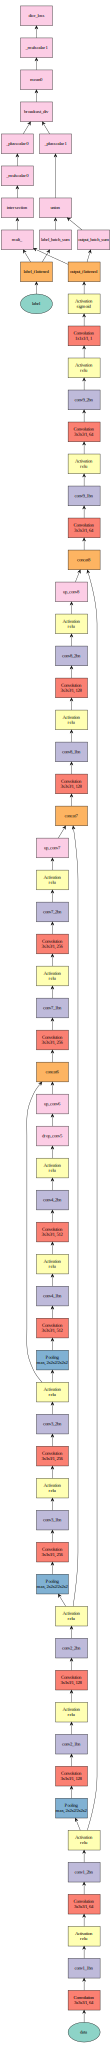

In [6]:

# CELL WITH 3 d unet model with 3x3x3 3d-convolutions


def build_unet_symbol_3d(coeff = 2):
    data = mx.symbol.Variable('data')
    conv1_1 = mx.sym.Convolution(data=data, kernel=(3, 3,3), num_filter=32 * coeff, pad=(1,1, 1), name='conv1_1')
    conv1_1bn = mx.sym.BatchNorm(data=conv1_1, name='conv1_1bn')
    act1_1 = mx.sym.Activation(data=conv1_1bn, act_type='relu', name='relu1_1')
    conv1_2 = mx.sym.Convolution(data=act1_1, kernel=(3, 3, 3), num_filter=32 * coeff, pad=(1,1, 1), name='conv1_2')
    conv1_2bn = mx.sym.BatchNorm(data=conv1_2, name='conv1_2bn')
    act1_2 = mx.sym.Activation(data=conv1_2bn, act_type='relu', name='relu1_2')
    pool1 = mx.symbol.Pooling(act1_2, pool_type="max", kernel=(2, 2, 2), stride=(2, 2, 2), name='pool1')
    
    conv2_1 = mx.sym.Convolution(data=pool1, kernel=(3, 3, 3), num_filter=64  * coeff, pad=(1,1,1), name='conv2_1')
    conv2_1bn = mx.sym.BatchNorm(data=conv2_1, name='conv2_1bn')
    act2_1 = mx.sym.Activation(data=conv2_1bn, act_type='relu', name='relu2_1')
    conv2_2 = mx.sym.Convolution(data=act2_1, kernel=(3, 3, 3), num_filter=64 * coeff, pad=(1,1, 1), name='conv2_2')
    conv2_2bn = mx.sym.BatchNorm(data=conv2_2, name='conv2_2bn')
    act2_2 = mx.sym.Activation(data=conv2_2bn, act_type='relu', name='relu2_2')
    pool2 = mx.symbol.Pooling(act2_2, pool_type="max", kernel=(2, 2, 2), stride=(2, 2, 2), name='pool2')
    
    
    conv3_1 = mx.sym.Convolution(data=pool2, kernel=(3,3,3), num_filter=128 * coeff, pad=(1,1,1), name='conv3_1')
    conv3_1bn = mx.sym.BatchNorm(data=conv3_1, name='conv3_1bn')
    act3_1 = mx.sym.Activation(data=conv3_1bn, act_type='relu', name='relu3_1')
    conv3_2 = mx.sym.Convolution(data=act3_1, kernel=(3,3,3), num_filter=128 * coeff, pad=(1,1,1), name='conv3_2')
    conv3_2bn = mx.sym.BatchNorm(data=conv3_2, name='conv3_2bn')
    act3_2 = mx.sym.Activation(data=conv3_2bn, act_type='relu', name='relu3_2')
    pool3 = mx.symbol.Pooling(act3_2, pool_type="max", kernel=(2, 2, 2), stride=(2, 2, 2), name='pool3')
    
    conv4_1 = mx.sym.Convolution(data=pool3, kernel=(3,3,3), num_filter=256 * coeff, pad=(1,1,1), name='conv4_1')
    conv4_1bn = mx.sym.BatchNorm(data=conv4_1, name='conv4_1bn')
    act4_1 = mx.sym.Activation(data=conv4_1bn, act_type='relu', name='relu4_1')
    conv4_2 = mx.sym.Convolution(data=act4_1, kernel=(3,3,3), num_filter=256 * coeff, pad=(1,1, 1), name='conv4_2')
    conv4_2bn = mx.sym.BatchNorm(data=conv4_2, name='conv4_2bn')
    act4_2 = mx.sym.Activation(data=conv4_2bn, act_type='relu', name='relu4_2')
    
    
    
    drop_conv5 = mx.sym.Dropout(data=act4_2, p=0.2, name='drop_conv5')
    
    up_conv6 = mx.symbol.Deconvolution(drop_conv5, kernel=(2, 2, 2), pad=(0, 0, 0),
                                    stride=(2, 2, 2), num_filter=256 * coeff, workspace=2048,
                                      name='up_conv6')
    concat6 = mx.symbol.Concat(up_conv6, act3_2, dim=1, name='concat6')
    conv7_1 = mx.sym.Convolution(data=concat6, kernel=(3,3,3), num_filter=128 * coeff, pad=(1,1,1), name='conv7_1')
    conv7_1bn = mx.sym.BatchNorm(data=conv7_1, name='conv7_1bn')
    act7_1 = mx.sym.Activation(data=conv7_1bn, act_type='relu', name='relu7_1')
    conv7_2 = mx.sym.Convolution(data=act7_1, kernel=(3,3,3), num_filter=128 * coeff, pad=(1,1,1), name='conv7_2')
    conv7_2bn = mx.sym.BatchNorm(data=conv7_2, name='conv7_2bn')
    act7_2 = mx.sym.Activation(data=conv7_2bn, act_type='relu', name='relu7_2')
    
    
    up_conv7 = mx.symbol.Deconvolution(act7_2, kernel=(2, 2, 2), pad=(0, 0, 0),
                                    stride=(2, 2, 2), num_filter=128 * coeff, workspace=2048,
                                      name='up_conv7')
    concat7 = mx.symbol.Concat(up_conv7, act2_2, dim=1, name='concat7')
    conv8_1 = mx.sym.Convolution(data=concat7, kernel=(3,3,3), num_filter=64 * coeff, pad=(1,1,1), name='conv8_1')
    conv8_1bn = mx.sym.BatchNorm(data=conv8_1, name='conv8_1bn')
    act8_1 = mx.sym.Activation(data=conv8_1bn, act_type='relu', name='relu8_1')
    conv8_2 = mx.sym.Convolution(data=act8_1, kernel=(3,3,3), num_filter=64 * coeff, pad=(1,1,1), name='conv8_2')
    conv8_2bn = mx.sym.BatchNorm(data=conv8_2, name='conv8_2bn')
    act8_2 = mx.sym.Activation(data=conv8_2bn, act_type='relu', name='relu8_2')
    
    up_conv8 = mx.symbol.Deconvolution(act8_2, kernel=(2, 2,2), pad=(0, 0,0),
                                    stride=(2, 2, 2), num_filter=128, workspace=2048,
                                      name='up_conv8')
    concat8 = mx.symbol.Concat(up_conv8, act1_2, dim=1, name='concat8')
    conv9_1 = mx.sym.Convolution(data=concat8, kernel=(3,3, 3), num_filter=32 * coeff, pad=(1,1,1), name='conv9_1')
    conv9_1bn = mx.sym.BatchNorm(data=conv9_1, name='conv9_1bn')
    act9_1 = mx.sym.Activation(data=conv9_1bn, act_type='relu', name='relu9_1')
    conv9_2 = mx.sym.Convolution(data=act9_1, kernel=(3,3,3), num_filter=32 * coeff, pad=(1,1,1), name='conv9_2')
    conv9_2bn = mx.sym.BatchNorm(data=conv9_2, name='conv9_2bn')
    act9_2 = mx.sym.Activation(data=conv9_2bn, act_type='relu', name='relu9_2')
    
    conv_output = mx.sym.Convolution(data=act9_2, kernel=(1,1,1), num_filter=1, name='conv_outut')
    output = mx.sym.Activation(data=conv_output, act_type='sigmoid', name='output')
    return output

output = build_unet_symbol_3d()


label = mx.sym.Variable('label', shape=(batch_size, 1, SIZE, SIZE, SIZE))
label_flattened = mx.sym.flatten(label, name='label_flattened')
output_flattened = mx.sym.flatten(output, name='output_flattened')
mult_ = mx.sym.broadcast_mul(output_flattened, label_flattened, name='mult_')
intersection = mx.sym.sum(mult_, axis=1, name='intersection')

label_batch_sum = mx.sym.sum(label_flattened, axis=(1,), name='label_batch_sum')
output_batch_sum = mx.sym.sum(output_flattened, axis=(1,), name='output_batch_sum')
#union = mx.sym.broadcast_sub(mx.sym.broadcast_add(label_batch_sum, output_batch_sum), intersection, name='union')
union = mx.sym.broadcast_add(label_batch_sum, output_batch_sum, name='union')
dice_coef = mx.sym.broadcast_div(2*intersection + 1., union + 1., name='broadcast_div')
dice_loss = mx.sym.MakeLoss(-mx.sym.mean(dice_coef), name='dice_loss')


#final_loss = mx.sym.mean(-mx.sym.log(dice_coef + 1e-6) + mx.sym.mean(-label_flattened * mx.sym.log(output_flattened + 1e-6) - \
#                                                  (1-label_flattened) * mx.sym.log(1. - output_flattened + 1e-6), axis=1))
final_loss = mx.sym.mean(mx.sym.mean(-label_flattened * mx.sym.log(output_flattened + 1e-6) - \
                                                  (1-label_flattened) * mx.sym.log(1. - output_flattened + 1e-6), axis=1))

final_loss = mx.sym.MakeLoss(final_loss, name='final_loss')


output_loss = mx.sym.Group([mx.sym.BlockGrad(dice_loss), mx.sym.BlockGrad(output), mx.sym.BlockGrad(label_flattened), 
                            mx.sym.BlockGrad(output_flattened), mx.sym.BlockGrad(mult_),
                            mx.sym.BlockGrad(intersection), mx.sym.BlockGrad(label_batch_sum),
                            mx.sym.BlockGrad(output_batch_sum), mx.sym.BlockGrad(union), mx.sym.BlockGrad(dice_coef),
                           final_loss])

output_loss.infer_shape(data=(batch_size, 1, SIZE, SIZE, SIZE))[1]
mx.viz.plot_network(dice_loss)

In [ ]:
# CHECK data shapes are ok cell


len(output_loss.infer_shape(data=(batch_size, 1, SIZE, SIZE, SIZE))[0])
for x in zip([el for el in output_loss.get_internals() if 'weight' not in el.name and 
             'bias' not in el.name and 'bn' not in el.name], 
             output_loss.infer_shape(data=(batch_size, 1, SIZE, SIZE, SIZE))[0]):
    #print(x)
    pass
len(output_loss.infer_shape(data=(batch_size, 1, SIZE, SIZE, SIZE))[0])
for x in zip(output_loss.list_outputs(), output_loss.infer_shape(data=(batch_size, 1, SIZE, SIZE, SIZE))[1]):
    print(x)
    #print(len(output_loss.infer_shape(data=(batch_size, 1, 256, 128))[0]),
    #     len(output_loss.infer_shape(data=(batch_size, 1, 256, 128))[1]),
    #      len(output_loss.infer_shape(data=(batch_size, 1, 256, 128))[2]))
    #break
#for idx, sym in enumerate([el for el in output_loss.get_internals() if 'weight' not in el.name and 
#             'bias' not in el.name and 'bn' not in el.name]):
#    print(idx, end=', ')

('blockgrad0_output', (1,))
('blockgrad1_output', (3, 1, 80, 80, 80))
('blockgrad2_output', (3, 512000))
('blockgrad3_output', (3, 512000))
('blockgrad4_output', (3, 512000))
('blockgrad5_output', (3,))
('blockgrad6_output', (3,))
('blockgrad7_output', (3,))
('blockgrad8_output', (3,))
('blockgrad9_output', (3,))
('final_loss_output', (1,))


In [ ]:
# CELL with creating mxnet module with 3d unet model and training
#You should change here /YOUR/PATH/TO/DUMP/MODELS


model = mx.mod.Module(context=mx.gpu(0), symbol=output_loss, label_names=['label'])
print('inited model')
optimizer = mx.optimizer.RMSProp()
print('inited optimizer')
monitor = mx.mon.Monitor(50, 
                         pattern='.*loss.*')

initializer = mx.init.Xavier(rnd_type='uniform', factor_type="in", magnitude=2)
model.bind(data_shapes=[('data', (batch_size, 1, SIZE, SIZE, SIZE))],
           label_shapes=[('label', (batch_size,1, SIZE, SIZE, SIZE))])
model.init_params(initializer)

### IF YOU WANT TO REPRODUCE TRAINING CONTINUATION UNCOMMENT CODE BELOW
#params = mx.model.load_checkpoint('/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung/unet_r001e07', 7)[1:]
#model.set_params(*params)
# evaluation metrices
checkpoint = mx.callback.do_checkpoint('/YOUR/PATH/TO/DUMP/MODELS/unet3d')
# callbacks that run after each batch
batch_end_callbacks = [mx.callback.Speedometer(batch_size, 10)]
print('starting to fit')
# run
try:
    model.fit(train_iter,
        begin_epoch        = 0,
        num_epoch          = 30,
        eval_data          = val_iter,
        eval_metric        = eval_metrics,
        optimizer          = optimizer,
        initializer        = initializer,
        batch_end_callback = batch_end_callbacks,
        epoch_end_callback = checkpoint,
        monitor = monitor)

    model.set_optimizer(optimizer=mx.optimizer.RMSProp(1e-4), force_init=True)

    model.fit(train_iter,
        begin_epoch        = 31,
        num_epoch          = 50,
        eval_data          = val_iter,
        eval_metric        = eval_metrics,
        optimizer          = optimizer,
        initializer        = initializer,
        batch_end_callback = batch_end_callbacks,
        epoch_end_callback = checkpoint,
        monitor = monitor)
except Exception as e:
    link = 'https://api.telegram.org/bot345085725:AAHRhcsTnw5GfI-MmO1zS_0zxR3t6uPbBYM/sendMessage'
    chatid = '-209261843'
    message = 'something got wrong with error ' + str(e)
    import time
    for x in range(2):
        os.system("""curl "{}" -d 'chat_id={}&text={}'""".format(link, chatid, message))
        time.sleep(30)

inited model
inited optimizer


starting to fit


/usr/local/lib/python3.5/dist-packages/mxnet-0.10.1-py3.5.egg/mxnet/module/base_module.py:463: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)
/usr/local/lib/python3.5/dist-packages/mxnet-0.10.1-py3.5.egg/mxnet/module/base_module.py:465: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.3333333333333333). Is this intended?
  optimizer_params=optimizer_params)
INFO:root:Batch:       1 dice_loss_output               1.59761e-05	
INFO:root:Batch:       1 final_loss_output              0.607595	
INFO:root:Batch:       1 final_loss_backward_data       1.0	
INFO:root:Batch:       1 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [10]	Speed: 2.10 samples/sec	Dice=-0.005602
INFO:root:Epoch[0] Batch [20]	Speed: 1.95 samples/sec	Dice=-0.010618
INFO:root:Epoch[0] Batch [30]	Speed: 1.95 samples/sec	Dice=-0.00

label_batch_sum vs dice coef [(44.0, 0.00023174487), (5359.0, 0.022641029), (803.0, 0.0033216875)]
output sum  [ 48415.03  57466.03  48868.  ]
own dice  1.09490955196e-08


INFO:root:Batch:      51 dice_loss_output               0.00497436	
INFO:root:Batch:      51 final_loss_output              0.092413	
INFO:root:Batch:      51 final_loss_backward_data       1.0	
INFO:root:Batch:      51 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [50]	Speed: 1.82 samples/sec	Dice=-0.007114
INFO:root:Epoch[0] Batch [60]	Speed: 2.09 samples/sec	Dice=-0.009838
INFO:root:Epoch[0] Batch [70]	Speed: 1.95 samples/sec	Dice=-0.002806
INFO:root:Epoch[0] Batch [80]	Speed: 1.95 samples/sec	Dice=-0.005188
INFO:root:Epoch[0] Batch [90]	Speed: 1.95 samples/sec	Dice=-0.005971


label_batch_sum vs dice coef [(54.0, 0.00015373407), (584.0, 0.0018963467), (59.0, 0.0002095292)]
output sum  [ 18268.26  29876.11  17821.76]
own dice  3.76969315765e-09


INFO:root:Batch:     101 dice_loss_output               0.00329519	
INFO:root:Batch:     101 final_loss_output              0.03973	
INFO:root:Batch:     101 final_loss_backward_data       1.0	
INFO:root:Batch:     101 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [100]	Speed: 1.82 samples/sec	Dice=-0.007628
INFO:root:Epoch[0] Batch [110]	Speed: 2.09 samples/sec	Dice=-0.004398
INFO:root:Epoch[0] Batch [120]	Speed: 1.95 samples/sec	Dice=-0.004303
INFO:root:Epoch[0] Batch [130]	Speed: 1.95 samples/sec	Dice=-0.006713
INFO:root:Epoch[0] Batch [140]	Speed: 1.95 samples/sec	Dice=-0.005784


label_batch_sum vs dice coef [(466.0, 0.024571385), (41.0, 0.0025439537), (573.0, 0.01266819)]
output sum  [ 10430.12  11700.42   6888.36]
own dice  4.0992708849e-09


INFO:root:Batch:     151 dice_loss_output               0.00675379	
INFO:root:Batch:     151 final_loss_output              0.0337911	
INFO:root:Batch:     151 final_loss_backward_data       1.0	
INFO:root:Batch:     151 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [150]	Speed: 1.82 samples/sec	Dice=-0.014931
INFO:root:Epoch[0] Batch [160]	Speed: 2.09 samples/sec	Dice=-0.011653
INFO:root:Epoch[0] Batch [170]	Speed: 1.95 samples/sec	Dice=-0.016899
INFO:root:Epoch[0] Batch [180]	Speed: 1.94 samples/sec	Dice=-0.024756
INFO:root:Epoch[0] Batch [190]	Speed: 1.95 samples/sec	Dice=-0.025191


label_batch_sum vs dice coef [(335.0, 0.037948348), (95.0, 0.0084111001), (7921.0, 0.1152938)]
output sum  [  5282.62   6195.45  15334.07]
own dice  0.102319219655


INFO:root:Batch:     201 dice_loss_output               0.0827792	
INFO:root:Batch:     201 final_loss_output              0.0595994	
INFO:root:Batch:     201 final_loss_backward_data       1.0	
INFO:root:Batch:     201 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [200]	Speed: 1.82 samples/sec	Dice=-0.057310
INFO:root:Epoch[0] Batch [210]	Speed: 2.09 samples/sec	Dice=-0.042690
INFO:root:Epoch[0] Batch [220]	Speed: 1.95 samples/sec	Dice=-0.043290
INFO:root:Epoch[0] Batch [230]	Speed: 1.95 samples/sec	Dice=-0.059124
INFO:root:Epoch[0] Batch [240]	Speed: 1.95 samples/sec	Dice=-0.044688


label_batch_sum vs dice coef [(119.0, 0.0017845669), (7366.0, 0.013070961), (190.0, 0.00021091453)]
output sum  [ 22469.98  15925.21  23704.64]
own dice  0.0745174397089


INFO:root:Batch:     251 dice_loss_output               0.0315207	
INFO:root:Batch:     251 final_loss_output              0.0432405	
INFO:root:Batch:     251 final_loss_backward_data       1.0	
INFO:root:Batch:     251 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [250]	Speed: 1.82 samples/sec	Dice=-0.044876
INFO:root:Epoch[0] Batch [260]	Speed: 2.09 samples/sec	Dice=-0.080351
INFO:root:Epoch[0] Batch [270]	Speed: 1.95 samples/sec	Dice=-0.053503
INFO:root:Epoch[0] Batch [280]	Speed: 1.95 samples/sec	Dice=-0.107308
INFO:root:Epoch[0] Batch [290]	Speed: 1.94 samples/sec	Dice=-0.091360


label_batch_sum vs dice coef [(152.0, 0.0047273394), (1573.0, 0.37489054), (694.0, 0.01023725)]
output sum  [ 1698.88  2067.18  2485.24]
own dice  0.17544719574


INFO:root:Batch:     301 dice_loss_output               0.038016	
INFO:root:Batch:     301 final_loss_output              0.0165192	
INFO:root:Batch:     301 final_loss_backward_data       1.0	
INFO:root:Batch:     301 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [300]	Speed: 1.82 samples/sec	Dice=-0.093018
INFO:root:Epoch[0] Batch [310]	Speed: 2.09 samples/sec	Dice=-0.112255
INFO:root:Epoch[0] Batch [320]	Speed: 1.95 samples/sec	Dice=-0.078644
INFO:root:Epoch[0] Batch [330]	Speed: 1.95 samples/sec	Dice=-0.127851
INFO:root:Epoch[0] Batch [340]	Speed: 1.94 samples/sec	Dice=-0.124478


label_batch_sum vs dice coef [(3427.0, 0.4531804), (84.0, 0.012401764), (3035.0, 0.099663012)]
output sum  [  3732.35   1187.21  11971.8 ]
own dice  0.229463835705


INFO:root:Batch:     351 dice_loss_output               0.237949	
INFO:root:Batch:     351 final_loss_output              0.00780491	
INFO:root:Batch:     351 final_loss_backward_data       1.0	
INFO:root:Batch:     351 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [350]	Speed: 1.82 samples/sec	Dice=-0.167188
INFO:root:Epoch[0] Batch [360]	Speed: 2.09 samples/sec	Dice=-0.179088
INFO:root:Epoch[0] Batch [370]	Speed: 1.95 samples/sec	Dice=-0.130085
INFO:root:Epoch[0] Batch [380]	Speed: 1.94 samples/sec	Dice=-0.158426
INFO:root:Epoch[0] Batch [390]	Speed: 1.95 samples/sec	Dice=-0.136387


label_batch_sum vs dice coef [(249.0, 0.04438464), (1167.0, 0.36763805), (13.0, 0.0075639226)]
output sum  [  950.15  4684.35   625.01]
own dice  0.174349887322


INFO:root:Batch:     401 dice_loss_output               0.0238794	
INFO:root:Batch:     401 final_loss_output              0.00473468	
INFO:root:Batch:     401 final_loss_backward_data       1.0	
INFO:root:Batch:     401 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [400]	Speed: 1.82 samples/sec	Dice=-0.115837
INFO:root:Epoch[0] Batch [410]	Speed: 2.09 samples/sec	Dice=-0.148915
INFO:root:Epoch[0] Batch [420]	Speed: 1.95 samples/sec	Dice=-0.177395
INFO:root:Epoch[0] Batch [430]	Speed: 1.95 samples/sec	Dice=-0.187881
INFO:root:Epoch[0] Batch [440]	Speed: 1.95 samples/sec	Dice=-0.071625


label_batch_sum vs dice coef [(458.0, 0.0041933814), (78.0, 0.012506135), (496.0, 0.29075781)]
output sum  [ 1844.57  5613.9    898.12]
own dice  0.135999622392


INFO:root:Batch:     451 dice_loss_output               0.00249755	
INFO:root:Batch:     451 final_loss_output              0.0126064	
INFO:root:Batch:     451 final_loss_backward_data       1.0	
INFO:root:Batch:     451 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [450]	Speed: 1.82 samples/sec	Dice=-0.113164
INFO:root:Epoch[0] Batch [460]	Speed: 2.09 samples/sec	Dice=-0.147063
INFO:root:Epoch[0] Batch [470]	Speed: 1.94 samples/sec	Dice=-0.113876
INFO:root:Epoch[0] Batch [480]	Speed: 1.95 samples/sec	Dice=-0.124257
INFO:root:Epoch[0] Batch [490]	Speed: 1.94 samples/sec	Dice=-0.183554


label_batch_sum vs dice coef [(95.0, 0.0010703205), (128.0, 0.17523207), (133.0, 0.031027872)]
output sum  [ 932.26  139.22  727.8 ]
own dice  0.175587847433


INFO:root:Batch:     501 dice_loss_output               0.163012	
INFO:root:Batch:     501 final_loss_output              0.0722677	
INFO:root:Batch:     501 final_loss_backward_data       1.0	
INFO:root:Batch:     501 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [500]	Speed: 1.82 samples/sec	Dice=-0.154172
INFO:root:Epoch[0] Batch [510]	Speed: 2.09 samples/sec	Dice=-0.259452
INFO:root:Epoch[0] Batch [520]	Speed: 1.95 samples/sec	Dice=-0.181538
INFO:root:Epoch[0] Batch [530]	Speed: 1.95 samples/sec	Dice=-0.170779
INFO:root:Epoch[0] Batch [540]	Speed: 1.95 samples/sec	Dice=-0.157517


label_batch_sum vs dice coef [(501.0, 0.068600282), (268.0, 0.16821031), (99.0, 0.023257723)]
output sum  [ 1867.34  1049.89  2587.93]
own dice  0.238170294223


INFO:root:Batch:     551 dice_loss_output               0.199613	
INFO:root:Batch:     551 final_loss_output              0.0154484	
INFO:root:Batch:     551 final_loss_backward_data       1.0	
INFO:root:Batch:     551 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [550]	Speed: 1.82 samples/sec	Dice=-0.146959
INFO:root:Epoch[0] Batch [560]	Speed: 2.09 samples/sec	Dice=-0.273010
INFO:root:Epoch[0] Batch [570]	Speed: 1.94 samples/sec	Dice=-0.228266
INFO:root:Epoch[0] Batch [580]	Speed: 1.94 samples/sec	Dice=-0.265744
INFO:root:Epoch[0] Batch [590]	Speed: 1.94 samples/sec	Dice=-0.269679


label_batch_sum vs dice coef [(28.0, 0.088125467), (1373.0, 0.0008077519), (189.0, 0.40931562)]
output sum  [ 405.38  357.04  732.8 ]
own dice  0.417831749903


INFO:root:Batch:     601 dice_loss_output               0.0148207	
INFO:root:Batch:     601 final_loss_output              0.0595453	
INFO:root:Batch:     601 final_loss_backward_data       1.0	
INFO:root:Batch:     601 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [600]	Speed: 1.82 samples/sec	Dice=-0.271194
INFO:root:Epoch[0] Batch [610]	Speed: 2.09 samples/sec	Dice=-0.151828
INFO:root:Epoch[0] Batch [620]	Speed: 1.95 samples/sec	Dice=-0.253408
INFO:root:Epoch[0] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.186130
INFO:root:Epoch[0] Batch [640]	Speed: 1.94 samples/sec	Dice=-0.266818


label_batch_sum vs dice coef [(506.0, 0.45606792), (721.0, 0.78857666), (147.0, 0.0015984962)]
output sum  [ 613.84  557.18  481.84]
own dice  0.272207822958


INFO:root:Batch:     651 dice_loss_output               0.153181	
INFO:root:Batch:     651 final_loss_output              0.0258733	
INFO:root:Batch:     651 final_loss_backward_data       1.0	
INFO:root:Batch:     651 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [650]	Speed: 1.82 samples/sec	Dice=-0.251975
INFO:root:Epoch[0] Batch [660]	Speed: 2.09 samples/sec	Dice=-0.282317
INFO:root:Epoch[0] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.237614
INFO:root:Epoch[0] Batch [680]	Speed: 1.95 samples/sec	Dice=-0.243382
INFO:root:Epoch[0] Batch [690]	Speed: 1.95 samples/sec	Dice=-0.204319


label_batch_sum vs dice coef [(391.0, 0.0023758968), (7239.0, 0.00014068373), (646.0, 0.75355285)]
output sum  [  33.82    5.14  570.24]
own dice  0.259019584625


INFO:root:Batch:     701 dice_loss_output               0.239813	
INFO:root:Batch:     701 final_loss_output              0.0181264	
INFO:root:Batch:     701 final_loss_backward_data       1.0	
INFO:root:Batch:     701 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [700]	Speed: 1.82 samples/sec	Dice=-0.257660
INFO:root:Epoch[0] Batch [710]	Speed: 2.09 samples/sec	Dice=-0.261150
INFO:root:Epoch[0] Batch [720]	Speed: 1.94 samples/sec	Dice=-0.212260
INFO:root:Epoch[0] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.327041
INFO:root:Epoch[0] Batch [740]	Speed: 1.95 samples/sec	Dice=-0.160703


label_batch_sum vs dice coef [(2119.0, 0.7049495), (43.0, 0.14601408), (265.0, 0.62147236)]
output sum  [ 1776.48   369.28   581.83]
own dice  0.458760016676


INFO:root:Batch:     751 dice_loss_output               0.502737	
INFO:root:Batch:     751 final_loss_output              0.00270266	
INFO:root:Batch:     751 final_loss_backward_data       1.0	
INFO:root:Batch:     751 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [750]	Speed: 1.82 samples/sec	Dice=-0.407870
INFO:root:Epoch[0] Batch [760]	Speed: 2.09 samples/sec	Dice=-0.250070
INFO:root:Epoch[0] Batch [770]	Speed: 1.94 samples/sec	Dice=-0.348792
INFO:root:Epoch[0] Batch [780]	Speed: 1.94 samples/sec	Dice=-0.284147
INFO:root:Epoch[0] Batch [790]	Speed: 1.94 samples/sec	Dice=-0.328638


label_batch_sum vs dice coef [(340.0, 0.39904404), (251.0, 0.63482499), (4198.0, 0.54510421)]
output sum  [  580.24   509.68  2932.65]
own dice  0.28734285275


INFO:root:Batch:     801 dice_loss_output               0.0159708	
INFO:root:Batch:     801 final_loss_output              0.0038635	
INFO:root:Batch:     801 final_loss_backward_data       1.0	
INFO:root:Batch:     801 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [800]	Speed: 1.82 samples/sec	Dice=-0.267554
INFO:root:Epoch[0] Batch [810]	Speed: 2.09 samples/sec	Dice=-0.235253
INFO:root:Epoch[0] Batch [820]	Speed: 1.95 samples/sec	Dice=-0.289898
INFO:root:Epoch[0] Batch [830]	Speed: 1.94 samples/sec	Dice=-0.301172
INFO:root:Epoch[0] Batch [840]	Speed: 1.94 samples/sec	Dice=-0.320432


label_batch_sum vs dice coef [(7344.0, 0.024860216), (369.0, 0.3153249), (143.0, 0.40913561)]
output sum  [ 220.37   70.71   38.82]
own dice  0.277708811356


INFO:root:Batch:     851 dice_loss_output               0.417397	
INFO:root:Batch:     851 final_loss_output              0.0129644	
INFO:root:Batch:     851 final_loss_backward_data       1.0	
INFO:root:Batch:     851 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [850]	Speed: 1.82 samples/sec	Dice=-0.269426
INFO:root:Epoch[0] Batch [860]	Speed: 2.09 samples/sec	Dice=-0.353999
INFO:root:Epoch[0] Batch [870]	Speed: 1.94 samples/sec	Dice=-0.275689
INFO:root:Epoch[0] Batch [880]	Speed: 1.94 samples/sec	Dice=-0.333223
INFO:root:Epoch[0] Batch [890]	Speed: 1.94 samples/sec	Dice=-0.245108


label_batch_sum vs dice coef [(111.0, 0.12095284), (2934.0, 0.027304141), (28029.0, 0.12881467)]
output sum  [  166.58    58.41  1943.27]
own dice  0.432294760773


INFO:root:Batch:     901 dice_loss_output               0.490271	
INFO:root:Batch:     901 final_loss_output              0.00300358	
INFO:root:Batch:     901 final_loss_backward_data       1.0	
INFO:root:Batch:     901 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [900]	Speed: 1.82 samples/sec	Dice=-0.388989
INFO:root:Epoch[0] Batch [910]	Speed: 2.09 samples/sec	Dice=-0.260694
INFO:root:Epoch[0] Batch [920]	Speed: 1.95 samples/sec	Dice=-0.351883
INFO:root:Epoch[0] Batch [930]	Speed: 1.94 samples/sec	Dice=-0.339688
INFO:root:Epoch[0] Batch [940]	Speed: 1.94 samples/sec	Dice=-0.241412


label_batch_sum vs dice coef [(2439.0, 0.00041529525), (1832.0, 0.63482207), (2722.0, 0.00038377181)]
output sum  [    1.28  2836.09     3.24]
own dice  0.320147926026


INFO:root:Batch:     951 dice_loss_output               0.284095	
INFO:root:Batch:     951 final_loss_output              0.00662026	
INFO:root:Batch:     951 final_loss_backward_data       1.0	
INFO:root:Batch:     951 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [950]	Speed: 1.82 samples/sec	Dice=-0.290036
INFO:root:Epoch[0] Batch [960]	Speed: 2.09 samples/sec	Dice=-0.437025
INFO:root:Epoch[0] Batch [970]	Speed: 1.94 samples/sec	Dice=-0.408885
INFO:root:Epoch[0] Batch [980]	Speed: 1.94 samples/sec	Dice=-0.343617
INFO:root:Epoch[0] Batch [990]	Speed: 1.94 samples/sec	Dice=-0.292706


label_batch_sum vs dice coef [(1403.0, 0.11411481), (4178.0, 0.00027367426), (2576.0, 0.081192903)]
output sum  [ 235.51    8.26  244.29]
own dice  0.322489913222


INFO:root:Batch:    1001 dice_loss_output               0.426134	
INFO:root:Batch:    1001 final_loss_output              0.0142995	
INFO:root:Batch:    1001 final_loss_backward_data       1.0	
INFO:root:Batch:    1001 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [1000]	Speed: 1.82 samples/sec	Dice=-0.264842
INFO:root:Epoch[0] Batch [1010]	Speed: 2.09 samples/sec	Dice=-0.305712
INFO:root:Epoch[0] Batch [1020]	Speed: 1.95 samples/sec	Dice=-0.391150
INFO:root:Epoch[0] Batch [1030]	Speed: 1.95 samples/sec	Dice=-0.238831
INFO:root:Epoch[0] Batch [1040]	Speed: 1.95 samples/sec	Dice=-0.295295


label_batch_sum vs dice coef [(25.0, 0.14775762), (3487.0, 0.68711239), (4.0, 0.0055474313)]
output sum  [   80.78  3884.28   175.28]
own dice  0.452216358306


INFO:root:Batch:    1051 dice_loss_output               0.406896	
INFO:root:Batch:    1051 final_loss_output              0.139476	
INFO:root:Batch:    1051 final_loss_backward_data       1.0	
INFO:root:Batch:    1051 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [1050]	Speed: 1.82 samples/sec	Dice=-0.323617
INFO:root:Epoch[0] Batch [1060]	Speed: 2.09 samples/sec	Dice=-0.395521
INFO:root:Epoch[0] Batch [1070]	Speed: 1.95 samples/sec	Dice=-0.311900
INFO:root:Epoch[0] Batch [1080]	Speed: 1.95 samples/sec	Dice=-0.345470
INFO:root:Epoch[0] Batch [1090]	Speed: 1.95 samples/sec	Dice=-0.261789


label_batch_sum vs dice coef [(2144.0, 0.023471264), (268.0, 0.14703673), (453.0, 0.4618817)]
output sum  [  47.9   125.42  473.51]
own dice  0.319259257263


INFO:root:Batch:    1101 dice_loss_output               0.197396	
INFO:root:Batch:    1101 final_loss_output              0.0674182	
INFO:root:Batch:    1101 final_loss_backward_data       1.0	
INFO:root:Batch:    1101 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [1100]	Speed: 1.82 samples/sec	Dice=-0.272321
INFO:root:Epoch[0] Batch [1110]	Speed: 2.09 samples/sec	Dice=-0.394958
INFO:root:Epoch[0] Batch [1120]	Speed: 1.95 samples/sec	Dice=-0.419331
INFO:root:Epoch[0] Batch [1130]	Speed: 1.94 samples/sec	Dice=-0.317073
INFO:root:Epoch[0] Batch [1140]	Speed: 1.94 samples/sec	Dice=-0.283081


label_batch_sum vs dice coef [(1104.0, 0.72389585), (445.0, 0.002330682), (6.0, 0.060375374)]
output sum  [ 1940.64     0.92     9.57]
own dice  0.471498852939


INFO:root:Batch:    1151 dice_loss_output               0.0294512	
INFO:root:Batch:    1151 final_loss_output              0.066491	
INFO:root:Batch:    1151 final_loss_backward_data       1.0	
INFO:root:Batch:    1151 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [1150]	Speed: 1.82 samples/sec	Dice=-0.359571
INFO:root:Epoch[0] Batch [1160]	Speed: 2.09 samples/sec	Dice=-0.344431
INFO:root:Epoch[0] Batch [1170]	Speed: 1.94 samples/sec	Dice=-0.339657
INFO:root:Epoch[0] Batch [1180]	Speed: 1.95 samples/sec	Dice=-0.341814
INFO:root:Epoch[0] Batch [1190]	Speed: 1.95 samples/sec	Dice=-0.237299


label_batch_sum vs dice coef [(78.0, 0.49216649), (1368.0, 0.48419091), (119.0, 0.60632539)]
output sum  [   83.66  2918.61    79.9 ]
own dice  0.413409714786


INFO:root:Batch:    1201 dice_loss_output               0.642945	
INFO:root:Batch:    1201 final_loss_output              0.0254922	
INFO:root:Batch:    1201 final_loss_backward_data       1.0	
INFO:root:Batch:    1201 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [1200]	Speed: 1.82 samples/sec	Dice=-0.414666
INFO:root:Epoch[0] Batch [1210]	Speed: 2.09 samples/sec	Dice=-0.390719
INFO:root:Epoch[0] Batch [1220]	Speed: 1.95 samples/sec	Dice=-0.385163
INFO:root:Epoch[0] Batch [1230]	Speed: 1.94 samples/sec	Dice=-0.365196
INFO:root:Epoch[0] Batch [1240]	Speed: 1.94 samples/sec	Dice=-0.350204


label_batch_sum vs dice coef [(828.0, 0.67043507), (20.0, 0.0052074725), (1432.0, 0.82212162)]
output sum  [ 1150.44   171.04  1306.81]
own dice  0.479109157924


INFO:root:Batch:    1251 dice_loss_output               0.831448	
INFO:root:Batch:    1251 final_loss_output              0.00555025	
INFO:root:Batch:    1251 final_loss_backward_data       1.0	
INFO:root:Batch:    1251 dice_loss_backward_data        1.0	
INFO:root:Epoch[0] Batch [1250]	Speed: 1.82 samples/sec	Dice=-0.400476
INFO:root:Epoch[0] Batch [1260]	Speed: 2.09 samples/sec	Dice=-0.310533
INFO:root:Epoch[0] Batch [1270]	Speed: 1.94 samples/sec	Dice=-0.344849
INFO:root:Epoch[0] Batch [1280]	Speed: 1.94 samples/sec	Dice=-0.322771
INFO:root:Epoch[0] Batch [1290]	Speed: 1.95 samples/sec	Dice=-0.489204


Stopping training iteration 60 times


INFO:root:Epoch[0] Train-Dice=-0.380083
INFO:root:Epoch[0] Time cost=2000.343
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0001.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.010898875), (0.0, 0.92824256), (0.0, 0.62162709)]
output sum  [ 90.75   0.08   0.61]
own dice  0.337334232309
label_batch_sum vs dice coef [(50.0, 0.014592634), (174.0, 0.91510552), (0.0, 0.3955709)]
output sum  [  17.6   169.98    1.53]
own dice  0.487646661492
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.0052676653), (0.0, 0.50710762), (0.0, 0.17931974)]
output sum  [ 188.84    0.97    4.58]
own dice  0.406337344962
label_batch_sum vs dice coef [(0.0, 0.0047199507), (72.0, 0.70761228), (0.0, 0.10109559)]
output sum  [ 210.87   44.13    8.89]
own dice  0.364461943859
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.23482412), (0.0, 0.77819633), (0.0, 0.58123815)]
output sum  [ 3.26  0.29  0.72]
own dice  0.362422091148
label_batch_sum vs dice coef [(0.0, 0.013152096), (124.0, 0.0071791359), (0.0, 0.071835913)]
output sum  [ 75.03  17.12  12.92]
own dice  0.368030162232
sampling val batch
label_batch_sum vs di

INFO:root:Epoch[0] Validation-Dice=-0.455654


Final validation dice is  0.387999478031 -0.455653745836
Final global dice is  0.375894842027


INFO:root:Batch:    1301 dice_loss_output               0.552346	
INFO:root:Batch:    1301 final_loss_output              0.0172325	
INFO:root:Batch:    1301 final_loss_backward_data       1.0	
INFO:root:Batch:    1301 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [10]	Speed: 1.95 samples/sec	Dice=-0.389548
INFO:root:Epoch[1] Batch [20]	Speed: 1.95 samples/sec	Dice=-0.396079
INFO:root:Epoch[1] Batch [30]	Speed: 1.95 samples/sec	Dice=-0.364064
INFO:root:Epoch[1] Batch [40]	Speed: 1.95 samples/sec	Dice=-0.436693


label_batch_sum vs dice coef [(173.0, 0.087223835), (2948.0, 0.92439234), (442.0, 0.7619099)]
output sum  [  278.1   2783.15   464.58]
own dice  0.85617021297


INFO:root:Epoch[1] Batch [50]	Speed: 1.95 samples/sec	Dice=-0.406339
INFO:root:Batch:    1351 dice_loss_output               0.365666	
INFO:root:Batch:    1351 final_loss_output              0.00545217	
INFO:root:Batch:    1351 final_loss_backward_data       1.0	
INFO:root:Batch:    1351 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [60]	Speed: 1.95 samples/sec	Dice=-0.330228
INFO:root:Epoch[1] Batch [70]	Speed: 1.95 samples/sec	Dice=-0.378484
INFO:root:Epoch[1] Batch [80]	Speed: 1.95 samples/sec	Dice=-0.256416
INFO:root:Epoch[1] Batch [90]	Speed: 1.95 samples/sec	Dice=-0.387936


label_batch_sum vs dice coef [(4.0, 0.016093718), (316.0, 0.81608468), (11.0, 0.017524634)]
output sum  [  57.14  263.89   45.07]
own dice  0.709010344032


INFO:root:Epoch[1] Batch [100]	Speed: 1.95 samples/sec	Dice=-0.369553
INFO:root:Batch:    1401 dice_loss_output               0.370779	
INFO:root:Batch:    1401 final_loss_output              0.00125816	
INFO:root:Batch:    1401 final_loss_backward_data       1.0	
INFO:root:Batch:    1401 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [110]	Speed: 1.95 samples/sec	Dice=-0.270993
INFO:root:Epoch[1] Batch [120]	Speed: 1.94 samples/sec	Dice=-0.419554
INFO:root:Epoch[1] Batch [130]	Speed: 1.95 samples/sec	Dice=-0.254649
INFO:root:Epoch[1] Batch [140]	Speed: 1.94 samples/sec	Dice=-0.338241


label_batch_sum vs dice coef [(22.0, 0.020852601), (491.0, 0.0010402617), (584.0, 0.22476041)]
output sum  [   24.97   487.59  2814.31]
own dice  0.177056780586


INFO:root:Epoch[1] Batch [150]	Speed: 1.95 samples/sec	Dice=-0.459740
INFO:root:Batch:    1451 dice_loss_output               0.283796	
INFO:root:Batch:    1451 final_loss_output              0.0373402	
INFO:root:Batch:    1451 final_loss_backward_data       1.0	
INFO:root:Batch:    1451 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [160]	Speed: 1.94 samples/sec	Dice=-0.367838
INFO:root:Epoch[1] Batch [170]	Speed: 1.94 samples/sec	Dice=-0.426316
INFO:root:Epoch[1] Batch [180]	Speed: 1.94 samples/sec	Dice=-0.400311
INFO:root:Epoch[1] Batch [190]	Speed: 1.94 samples/sec	Dice=-0.454894


label_batch_sum vs dice coef [(442.0, 0.51006401), (6543.0, 0.5835163), (45781.0, 0.077775814)]
output sum  [  161.29  2856.92  2433.81]
own dice  0.159762905927


INFO:root:Epoch[1] Batch [200]	Speed: 1.94 samples/sec	Dice=-0.396137
INFO:root:Batch:    1501 dice_loss_output               0.550938	
INFO:root:Batch:    1501 final_loss_output              0.00969484	
INFO:root:Batch:    1501 final_loss_backward_data       1.0	
INFO:root:Batch:    1501 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [210]	Speed: 1.94 samples/sec	Dice=-0.374926
INFO:root:Epoch[1] Batch [220]	Speed: 1.94 samples/sec	Dice=-0.294882
INFO:root:Epoch[1] Batch [230]	Speed: 1.95 samples/sec	Dice=-0.339574
INFO:root:Epoch[1] Batch [240]	Speed: 1.95 samples/sec	Dice=-0.345006


label_batch_sum vs dice coef [(124.0, 0.42297676), (80.0, 0.15724617), (67.0, 0.63669574)]
output sum  [ 436.39  827.17  119.25]
own dice  0.324115759974


INFO:root:Epoch[1] Batch [250]	Speed: 1.95 samples/sec	Dice=-0.384434
INFO:root:Batch:    1551 dice_loss_output               0.461496	
INFO:root:Batch:    1551 final_loss_output              0.0114922	
INFO:root:Batch:    1551 final_loss_backward_data       1.0	
INFO:root:Batch:    1551 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [270]	Speed: 1.95 samples/sec	Dice=-0.471647
INFO:root:Epoch[1] Batch [280]	Speed: 1.95 samples/sec	Dice=-0.316408
INFO:root:Epoch[1] Batch [290]	Speed: 1.95 samples/sec	Dice=-0.388275


label_batch_sum vs dice coef [(173.0, 0.0053188973), (2114.0, 0.75470376), (224.0, 0.86415964)]
output sum  [   14.32  1551.1    175.51]
own dice  0.734885909821


INFO:root:Epoch[1] Batch [300]	Speed: 1.94 samples/sec	Dice=-0.390060
INFO:root:Batch:    1601 dice_loss_output               0.446149	
INFO:root:Batch:    1601 final_loss_output              0.0127151	
INFO:root:Batch:    1601 final_loss_backward_data       1.0	
INFO:root:Batch:    1601 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [310]	Speed: 1.94 samples/sec	Dice=-0.408143
INFO:root:Epoch[1] Batch [320]	Speed: 1.94 samples/sec	Dice=-0.355737
INFO:root:Epoch[1] Batch [330]	Speed: 1.94 samples/sec	Dice=-0.371039
INFO:root:Epoch[1] Batch [340]	Speed: 1.94 samples/sec	Dice=-0.403353


label_batch_sum vs dice coef [(521.0, 0.73085719), (2114.0, 0.75673217), (339.0, 0.67075795)]
output sum  [  484.2   1776.1    624.36]
own dice  0.744863014136


INFO:root:Epoch[1] Batch [350]	Speed: 1.95 samples/sec	Dice=-0.517383
INFO:root:Batch:    1651 dice_loss_output               0.271776	
INFO:root:Batch:    1651 final_loss_output              0.0204655	
INFO:root:Batch:    1651 final_loss_backward_data       1.0	
INFO:root:Batch:    1651 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [360]	Speed: 1.95 samples/sec	Dice=-0.269406
INFO:root:Epoch[1] Batch [370]	Speed: 1.95 samples/sec	Dice=-0.409657
INFO:root:Epoch[1] Batch [380]	Speed: 1.95 samples/sec	Dice=-0.361078
INFO:root:Epoch[1] Batch [390]	Speed: 1.95 samples/sec	Dice=-0.509427


label_batch_sum vs dice coef [(201.0, 0.42829764), (285.0, 0.87668526), (572.0, 0.24566309)]
output sum  [  75.2   275.36  834.98]
own dice  0.430865301379


INFO:root:Epoch[1] Batch [400]	Speed: 1.95 samples/sec	Dice=-0.467638
INFO:root:Batch:    1701 dice_loss_output               0.0958582	
INFO:root:Batch:    1701 final_loss_output              0.0136464	
INFO:root:Batch:    1701 final_loss_backward_data       1.0	
INFO:root:Batch:    1701 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [410]	Speed: 1.95 samples/sec	Dice=-0.435873
INFO:root:Epoch[1] Batch [420]	Speed: 1.95 samples/sec	Dice=-0.405629
INFO:root:Epoch[1] Batch [640]	Speed: 1.94 samples/sec	Dice=-0.346886


label_batch_sum vs dice coef [(329.0, 0.66742754), (1045.0, 0.83957767), (304.0, 0.30596143)]
output sum  [  221.61   999.54  1583.34]
own dice  0.59651474621


INFO:root:Epoch[1] Batch [650]	Speed: 1.94 samples/sec	Dice=-0.337692
INFO:root:Batch:    1951 dice_loss_output               0.480606	
INFO:root:Batch:    1951 final_loss_output              0.0034714	
INFO:root:Batch:    1951 final_loss_backward_data       1.0	
INFO:root:Batch:    1951 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [660]	Speed: 1.94 samples/sec	Dice=-0.385342
INFO:root:Epoch[1] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.331253
INFO:root:Epoch[1] Batch [680]	Speed: 1.94 samples/sec	Dice=-0.434573
INFO:root:Epoch[1] Batch [690]	Speed: 1.95 samples/sec	Dice=-0.379861


label_batch_sum vs dice coef [(161.0, 0.8345595), (15337.0, 0.4739261), (34.0, 0.13142227)]
output sum  [  125.96  5386.6    293.51]
own dice  0.474824191526


INFO:root:Epoch[1] Batch [700]	Speed: 1.94 samples/sec	Dice=-0.453443
INFO:root:Batch:    2001 dice_loss_output               0.231218	
INFO:root:Batch:    2001 final_loss_output              0.142838	
INFO:root:Batch:    2001 final_loss_backward_data       1.0	
INFO:root:Batch:    2001 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [710]	Speed: 1.94 samples/sec	Dice=-0.445821
INFO:root:Epoch[1] Batch [720]	Speed: 1.94 samples/sec	Dice=-0.378335
INFO:root:Epoch[1] Batch [730]	Speed: 1.94 samples/sec	Dice=-0.368932
INFO:root:Epoch[1] Batch [740]	Speed: 1.94 samples/sec	Dice=-0.549270


label_batch_sum vs dice coef [(496.0, 0.020930313), (584.0, 0.0017257087), (822.0, 0.77140427)]
output sum  [  76.52    0.59  945.44]
own dice  0.468685480149


INFO:root:Epoch[1] Batch [750]	Speed: 1.94 samples/sec	Dice=-0.451381
INFO:root:Batch:    2051 dice_loss_output               0.724445	
INFO:root:Batch:    2051 final_loss_output              0.00629057	
INFO:root:Batch:    2051 final_loss_backward_data       1.0	
INFO:root:Batch:    2051 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [760]	Speed: 1.94 samples/sec	Dice=-0.470311
INFO:root:Epoch[1] Batch [770]	Speed: 1.95 samples/sec	Dice=-0.372872
INFO:root:Epoch[1] Batch [780]	Speed: 1.94 samples/sec	Dice=-0.470292
INFO:root:Epoch[1] Batch [790]	Speed: 1.94 samples/sec	Dice=-0.500298


label_batch_sum vs dice coef [(54.0, 0.017736683), (51.0, 0.029301794), (1862.0, 0.12589669)]
output sum  [   1.51   23.81  248.29]
own dice  0.115955060153


INFO:root:Epoch[1] Batch [800]	Speed: 1.95 samples/sec	Dice=-0.395619
INFO:root:Batch:    2101 dice_loss_output               0.563105	
INFO:root:Batch:    2101 final_loss_output              0.00573342	
INFO:root:Batch:    2101 final_loss_backward_data       1.0	
INFO:root:Batch:    2101 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [810]	Speed: 1.95 samples/sec	Dice=-0.399956
INFO:root:Epoch[1] Batch [820]	Speed: 1.95 samples/sec	Dice=-0.326002
INFO:root:Epoch[1] Batch [830]	Speed: 1.95 samples/sec	Dice=-0.460879
INFO:root:Epoch[1] Batch [840]	Speed: 1.95 samples/sec	Dice=-0.504322


label_batch_sum vs dice coef [(262.0, 0.68873894), (19623.0, 0.53913891), (12771.0, 0.0837918)]
output sum  [  343.8  7660.    629.8]
own dice  0.394666537282


INFO:root:Epoch[1] Batch [850]	Speed: 1.94 samples/sec	Dice=-0.462042
INFO:root:Batch:    2151 dice_loss_output               0.698504	
INFO:root:Batch:    2151 final_loss_output              0.0147953	
INFO:root:Batch:    2151 final_loss_backward_data       1.0	
INFO:root:Batch:    2151 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [860]	Speed: 1.95 samples/sec	Dice=-0.490208
INFO:root:Epoch[1] Batch [870]	Speed: 1.95 samples/sec	Dice=-0.393397
INFO:root:Epoch[1] Batch [880]	Speed: 1.95 samples/sec	Dice=-0.504545
INFO:root:Epoch[1] Batch [890]	Speed: 1.94 samples/sec	Dice=-0.395252


label_batch_sum vs dice coef [(239.0, 0.86986357), (933.0, 0.58085525), (647.0, 0.77169853)]
output sum  [ 211.33  465.34  555.36]
own dice  0.702560736367


INFO:root:Epoch[1] Batch [900]	Speed: 1.95 samples/sec	Dice=-0.562540
INFO:root:Batch:    2201 dice_loss_output               0.2116	
INFO:root:Batch:    2201 final_loss_output              0.00192141	
INFO:root:Batch:    2201 final_loss_backward_data       1.0	
INFO:root:Batch:    2201 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [910]	Speed: 1.94 samples/sec	Dice=-0.399202
INFO:root:Epoch[1] Batch [920]	Speed: 1.94 samples/sec	Dice=-0.476728
INFO:root:Epoch[1] Batch [930]	Speed: 1.94 samples/sec	Dice=-0.478710
INFO:root:Epoch[1] Batch [940]	Speed: 1.94 samples/sec	Dice=-0.474190


label_batch_sum vs dice coef [(2396.0, 0.59803307), (2728.0, 0.60870892), (1331.0, 0.87687051)]
output sum  [ 1077.75  1698.11  1348.55]
own dice  0.681929527339


INFO:root:Epoch[1] Batch [950]	Speed: 1.95 samples/sec	Dice=-0.497677
INFO:root:Batch:    2251 dice_loss_output               0.279089	
INFO:root:Batch:    2251 final_loss_output              0.00408625	
INFO:root:Batch:    2251 final_loss_backward_data       1.0	
INFO:root:Batch:    2251 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [960]	Speed: 1.94 samples/sec	Dice=-0.500006
INFO:root:Epoch[1] Batch [970]	Speed: 1.95 samples/sec	Dice=-0.362759
INFO:root:Epoch[1] Batch [980]	Speed: 1.95 samples/sec	Dice=-0.437146
INFO:root:Epoch[1] Batch [990]	Speed: 1.94 samples/sec	Dice=-0.491483


label_batch_sum vs dice coef [(103.0, 0.010238259), (1832.0, 0.63873297), (500.0, 0.43873698)]
output sum  [   17.06  3612.08   957.35]
own dice  0.589615220155


INFO:root:Epoch[1] Batch [1000]	Speed: 1.95 samples/sec	Dice=-0.421263
INFO:root:Batch:    2301 dice_loss_output               0.845569	
INFO:root:Batch:    2301 final_loss_output              0.010489	
INFO:root:Batch:    2301 final_loss_backward_data       1.0	
INFO:root:Batch:    2301 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [1010]	Speed: 1.94 samples/sec	Dice=-0.588094
INFO:root:Epoch[1] Batch [1020]	Speed: 1.94 samples/sec	Dice=-0.517209
INFO:root:Epoch[1] Batch [1030]	Speed: 1.95 samples/sec	Dice=-0.479271
INFO:root:Epoch[1] Batch [1040]	Speed: 1.94 samples/sec	Dice=-0.378210


label_batch_sum vs dice coef [(13.0, 0.035398491), (8.0, 0.011777124), (78.0, 0.80721933)]
output sum  [ 14.25  75.92  95.3 ]
own dice  0.619469043386


INFO:root:Epoch[1] Batch [1050]	Speed: 1.95 samples/sec	Dice=-0.443744
INFO:root:Batch:    2351 dice_loss_output               0.419477	
INFO:root:Batch:    2351 final_loss_output              0.0141425	
INFO:root:Batch:    2351 final_loss_backward_data       1.0	
INFO:root:Batch:    2351 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [1060]	Speed: 1.95 samples/sec	Dice=-0.439739
INFO:root:Epoch[1] Batch [1070]	Speed: 1.94 samples/sec	Dice=-0.432758
INFO:root:Epoch[1] Batch [1080]	Speed: 1.94 samples/sec	Dice=-0.384154
INFO:root:Epoch[1] Batch [1090]	Speed: 1.94 samples/sec	Dice=-0.463160


label_batch_sum vs dice coef [(4212.0, 0.67217851), (266.0, 0.6223076), (2948.0, 0.0003395789)]
output sum  [ 2672.15   166.82     0.66]
own dice  0.475381008719


INFO:root:Epoch[1] Batch [1100]	Speed: 1.94 samples/sec	Dice=-0.494154
INFO:root:Batch:    2401 dice_loss_output               0.161781	
INFO:root:Batch:    2401 final_loss_output              0.00305401	
INFO:root:Batch:    2401 final_loss_backward_data       1.0	
INFO:root:Batch:    2401 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [1110]	Speed: 1.94 samples/sec	Dice=-0.345679
INFO:root:Epoch[1] Batch [1120]	Speed: 1.94 samples/sec	Dice=-0.535900
INFO:root:Epoch[1] Batch [1130]	Speed: 1.94 samples/sec	Dice=-0.428453
INFO:root:Epoch[1] Batch [1140]	Speed: 1.95 samples/sec	Dice=-0.446651


label_batch_sum vs dice coef [(506.0, 0.0019745382), (686.0, 0.84906888), (99.0, 0.059796482)]
output sum  [    0.88   603.53  2978.04]
own dice  0.26523888125


INFO:root:Epoch[1] Batch [1150]	Speed: 1.95 samples/sec	Dice=-0.542608
INFO:root:Batch:    2451 dice_loss_output               0.556458	
INFO:root:Batch:    2451 final_loss_output              0.00293399	
INFO:root:Batch:    2451 final_loss_backward_data       1.0	
INFO:root:Batch:    2451 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [1160]	Speed: 1.95 samples/sec	Dice=-0.367856
INFO:root:Epoch[1] Batch [1170]	Speed: 1.95 samples/sec	Dice=-0.450840
INFO:root:Epoch[1] Batch [1180]	Speed: 1.95 samples/sec	Dice=-0.380419
INFO:root:Epoch[1] Batch [1190]	Speed: 1.95 samples/sec	Dice=-0.475248


label_batch_sum vs dice coef [(2266.0, 0.00016470817), (65.0, 0.21746941), (411.0, 0.12954125)]
output sum  [ 4147.01   231.68    59.39]
own dice  0.0159351425553


INFO:root:Epoch[1] Batch [1200]	Speed: 1.94 samples/sec	Dice=-0.441103
INFO:root:Batch:    2501 dice_loss_output               0.457832	
INFO:root:Batch:    2501 final_loss_output              0.0300402	
INFO:root:Batch:    2501 final_loss_backward_data       1.0	
INFO:root:Batch:    2501 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [1210]	Speed: 1.94 samples/sec	Dice=-0.489360
INFO:root:Epoch[1] Batch [1220]	Speed: 1.94 samples/sec	Dice=-0.425885
INFO:root:Epoch[1] Batch [1230]	Speed: 1.94 samples/sec	Dice=-0.482697
INFO:root:Epoch[1] Batch [1240]	Speed: 1.94 samples/sec	Dice=-0.446313


label_batch_sum vs dice coef [(822.0, 0.75642395), (151.0, 0.18214755), (32.0, 0.5955326)]
output sum  [ 1046.74  1348.29    65.79]
own dice  0.5196662708


INFO:root:Epoch[1] Batch [1250]	Speed: 1.95 samples/sec	Dice=-0.499465
INFO:root:Batch:    2551 dice_loss_output               0.788249	
INFO:root:Batch:    2551 final_loss_output              0.00491389	
INFO:root:Batch:    2551 final_loss_backward_data       1.0	
INFO:root:Batch:    2551 dice_loss_backward_data        1.0	
INFO:root:Epoch[1] Batch [1260]	Speed: 1.95 samples/sec	Dice=-0.650046
INFO:root:Epoch[1] Batch [1270]	Speed: 1.95 samples/sec	Dice=-0.477688
INFO:root:Epoch[1] Batch [1280]	Speed: 1.95 samples/sec	Dice=-0.492538
INFO:root:Epoch[1] Batch [1290]	Speed: 1.95 samples/sec	Dice=-0.499157


label_batch_sum vs dice coef [(8.0, 0.010512437), (190.0, 0.0050337072), (3151.0, 0.68762279)]
output sum  [   86.13    15.37  1760.99]
own dice  0.654867257301
Stopping training iteration 60 times


INFO:root:Epoch[1] Train-Dice=-0.448040
INFO:root:Epoch[1] Time cost=2001.142
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0002.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.71298659), (0.0, 0.91629267), (0.0, 0.10199597)]
output sum  [ 0.4   0.09  8.8 ]
own dice  0.464975680203
label_batch_sum vs dice coef [(0.0, 0.14277318), (0.0, 0.98210216), (0.0, 0.9725045)]
output sum  [ 6.    0.02  0.03]
own dice  0.48473740307
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.98790723), (0.0, 0.97376925), (56.0, 0.017499095)]
output sum  [ 0.01  0.03  0.16]
own dice  0.462078057494
label_batch_sum vs dice coef [(0.0, 0.0030783771), (0.0, 0.95099944), (235.0, 0.73556316)]
output sum  [ 323.85    0.05  146.41]
own dice  0.455475547179
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.96737003), (0.0, 0.96957928), (0.0, 0.86343306)]
output sum  [ 0.03  0.03  0.16]
own dice  0.454111715334
label_batch_sum vs dice coef [(3263.0, 0.88961321), (0.0, 0.98625749), (0.0, 0.84402579)]
output sum  [ 2811.83     0.01     0.18]
own dice  0.466980917596
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.

INFO:root:Epoch[1] Validation-Dice=-0.617379


Final validation dice is  0.496926026148 -0.617378770195
Final global dice is  0.475548342848


INFO:root:Batch:    2601 dice_loss_output               0.29565	
INFO:root:Batch:    2601 final_loss_output              0.00372107	
INFO:root:Batch:    2601 final_loss_backward_data       1.0	
INFO:root:Batch:    2601 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [10]	Speed: 1.95 samples/sec	Dice=-0.517326
INFO:root:Epoch[2] Batch [20]	Speed: 1.95 samples/sec	Dice=-0.539277
INFO:root:Epoch[2] Batch [30]	Speed: 1.95 samples/sec	Dice=-0.520290


label_batch_sum vs dice coef [(34.0, 0.31079829), (584.0, 0.70442349), (30.0, 0.0010371013)]
output sum  [  14.31  397.71  933.24]
own dice  0.51202386282


INFO:root:Epoch[2] Batch [40]	Speed: 1.95 samples/sec	Dice=-0.395562
INFO:root:Epoch[2] Batch [50]	Speed: 1.95 samples/sec	Dice=-0.415113
INFO:root:Batch:    2651 dice_loss_output               0.724588	
INFO:root:Batch:    2651 final_loss_output              0.0119748	
INFO:root:Batch:    2651 final_loss_backward_data       1.0	
INFO:root:Batch:    2651 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [60]	Speed: 1.95 samples/sec	Dice=-0.568152
INFO:root:Epoch[2] Batch [70]	Speed: 1.95 samples/sec	Dice=-0.441851
INFO:root:Epoch[2] Batch [80]	Speed: 1.95 samples/sec	Dice=-0.442479


label_batch_sum vs dice coef [(115.0, 0.85076606), (114.0, 0.8548938), (181.0, 0.011379025)]
output sum  [ 131.38  140.52   84.42]
own dice  0.663083485315


INFO:root:Epoch[2] Batch [90]	Speed: 1.94 samples/sec	Dice=-0.492432
INFO:root:Epoch[2] Batch [100]	Speed: 1.94 samples/sec	Dice=-0.422284
INFO:root:Batch:    2701 dice_loss_output               0.230533	
INFO:root:Batch:    2701 final_loss_output              0.0741643	
INFO:root:Batch:    2701 final_loss_backward_data       1.0	
INFO:root:Batch:    2701 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [110]	Speed: 1.94 samples/sec	Dice=-0.352693
INFO:root:Epoch[2] Batch [120]	Speed: 1.94 samples/sec	Dice=-0.478060
INFO:root:Epoch[2] Batch [130]	Speed: 1.95 samples/sec	Dice=-0.386741


label_batch_sum vs dice coef [(34.0, 0.11342454), (3.0, 0.00032743206), (8348.0, 0.11554129)]
output sum  [  507.16  3050.11   555.75]
own dice  0.32694046648


INFO:root:Epoch[2] Batch [140]	Speed: 1.95 samples/sec	Dice=-0.482904
INFO:root:Epoch[2] Batch [150]	Speed: 1.95 samples/sec	Dice=-0.476355
INFO:root:Batch:    2751 dice_loss_output               0.512979	
INFO:root:Batch:    2751 final_loss_output              0.049394	
INFO:root:Batch:    2751 final_loss_backward_data       1.0	
INFO:root:Batch:    2751 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [160]	Speed: 1.95 samples/sec	Dice=-0.508086
INFO:root:Epoch[2] Batch [170]	Speed: 1.95 samples/sec	Dice=-0.505639
INFO:root:Epoch[2] Batch [180]	Speed: 1.95 samples/sec	Dice=-0.384124


label_batch_sum vs dice coef [(455.0, 0.0022252451), (194.0, 0.0051657287), (42.0, 0.24096701)]
output sum  [  0.27   1.12  21.87]
own dice  0.202246700938


INFO:root:Epoch[2] Batch [190]	Speed: 1.94 samples/sec	Dice=-0.375769
INFO:root:Epoch[2] Batch [200]	Speed: 1.95 samples/sec	Dice=-0.557688
INFO:root:Batch:    2801 dice_loss_output               0.168832	
INFO:root:Batch:    2801 final_loss_output              0.064011	
INFO:root:Batch:    2801 final_loss_backward_data       1.0	
INFO:root:Batch:    2801 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [210]	Speed: 1.94 samples/sec	Dice=-0.400243
INFO:root:Epoch[2] Batch [220]	Speed: 1.95 samples/sec	Dice=-0.508635
INFO:root:Epoch[2] Batch [230]	Speed: 1.94 samples/sec	Dice=-0.470198


label_batch_sum vs dice coef [(3770.0, 0.81930822), (2728.0, 0.65922374), (2758.0, 0.85097575)]
output sum  [ 3084.06  1536.8   2300.16]
own dice  0.680535190598


INFO:root:Epoch[2] Batch [240]	Speed: 1.95 samples/sec	Dice=-0.504189
INFO:root:Epoch[2] Batch [250]	Speed: 1.94 samples/sec	Dice=-0.607719
INFO:root:Batch:    2851 dice_loss_output               0.788043	
INFO:root:Batch:    2851 final_loss_output              0.0127512	
INFO:root:Batch:    2851 final_loss_backward_data       1.0	
INFO:root:Batch:    2851 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [260]	Speed: 1.95 samples/sec	Dice=-0.529663
INFO:root:Epoch[2] Batch [270]	Speed: 1.95 samples/sec	Dice=-0.491417
INFO:root:Epoch[2] Batch [280]	Speed: 1.95 samples/sec	Dice=-0.454539


label_batch_sum vs dice coef [(223.0, 0.54823321), (88.0, 0.88422775), (8.0, 0.10500759)]
output sum  [ 115.99  109.05    0.52]
own dice  0.661212565482


INFO:root:Epoch[2] Batch [290]	Speed: 1.95 samples/sec	Dice=-0.562655
INFO:root:Epoch[2] Batch [300]	Speed: 1.94 samples/sec	Dice=-0.423086
INFO:root:Batch:    2901 dice_loss_output               0.643692	
INFO:root:Batch:    2901 final_loss_output              0.0282822	
INFO:root:Batch:    2901 final_loss_backward_data       1.0	
INFO:root:Batch:    2901 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [310]	Speed: 1.94 samples/sec	Dice=-0.507966
INFO:root:Epoch[2] Batch [320]	Speed: 1.95 samples/sec	Dice=-0.414060
INFO:root:Epoch[2] Batch [330]	Speed: 1.95 samples/sec	Dice=-0.599117


label_batch_sum vs dice coef [(1112.0, 0.00091436994), (52.0, 0.18344161), (1349.0, 0.00073673745)]
output sum  [   0.39  353.82   25.24]
own dice  0.579807054019


INFO:root:Epoch[2] Batch [340]	Speed: 1.94 samples/sec	Dice=-0.505611
INFO:root:Epoch[2] Batch [350]	Speed: 1.94 samples/sec	Dice=-0.364310
INFO:root:Batch:    2951 dice_loss_output               0.503545	
INFO:root:Batch:    2951 final_loss_output              0.00256109	
INFO:root:Batch:    2951 final_loss_backward_data       1.0	
INFO:root:Batch:    2951 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [360]	Speed: 1.94 samples/sec	Dice=-0.465553
INFO:root:Epoch[2] Batch [370]	Speed: 1.94 samples/sec	Dice=-0.480825
INFO:root:Epoch[2] Batch [380]	Speed: 1.95 samples/sec	Dice=-0.406503


label_batch_sum vs dice coef [(1485.0, 0.91519135), (16799.0, 0.28476748), (5081.0, 0.84041512)]
output sum  [ 1539.23  3450.99  4959.45]
own dice  0.621386198852


INFO:root:Epoch[2] Batch [390]	Speed: 1.94 samples/sec	Dice=-0.536504
INFO:root:Epoch[2] Batch [400]	Speed: 1.95 samples/sec	Dice=-0.508126
INFO:root:Batch:    3001 dice_loss_output               0.23829	
INFO:root:Batch:    3001 final_loss_output              0.0491631	
INFO:root:Batch:    3001 final_loss_backward_data       1.0	
INFO:root:Batch:    3001 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [410]	Speed: 1.94 samples/sec	Dice=-0.529559
INFO:root:Epoch[2] Batch [420]	Speed: 1.94 samples/sec	Dice=-0.494018
INFO:root:Epoch[2] Batch [430]	Speed: 1.95 samples/sec	Dice=-0.542667


label_batch_sum vs dice coef [(157.0, 0.68623537), (102.0, 0.7277177), (450.0, 0.0027207506)]
output sum  [ 158.33  169.01    0.46]
own dice  0.456977590843


INFO:root:Epoch[2] Batch [440]	Speed: 1.94 samples/sec	Dice=-0.373611
INFO:root:Epoch[2] Batch [450]	Speed: 1.94 samples/sec	Dice=-0.404044
INFO:root:Batch:    3051 dice_loss_output               0.281063	
INFO:root:Batch:    3051 final_loss_output              0.100087	
INFO:root:Batch:    3051 final_loss_backward_data       1.0	
INFO:root:Batch:    3051 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [460]	Speed: 1.95 samples/sec	Dice=-0.448215
INFO:root:Epoch[2] Batch [470]	Speed: 1.94 samples/sec	Dice=-0.435390
INFO:root:Epoch[2] Batch [480]	Speed: 1.95 samples/sec	Dice=-0.441999


label_batch_sum vs dice coef [(521.0, 0.0018036878), (1945.0, 0.82336819), (1580.0, 0.4202542)]
output sum  [   61.08  1729.56  1132.6 ]
own dice  0.577133172978


INFO:root:Epoch[2] Batch [490]	Speed: 1.95 samples/sec	Dice=-0.461554
INFO:root:Epoch[2] Batch [500]	Speed: 1.95 samples/sec	Dice=-0.516141
INFO:root:Batch:    3101 dice_loss_output               0.323732	
INFO:root:Batch:    3101 final_loss_output              0.00790634	
INFO:root:Batch:    3101 final_loss_backward_data       1.0	
INFO:root:Batch:    3101 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [510]	Speed: 1.94 samples/sec	Dice=-0.481889
INFO:root:Epoch[2] Batch [520]	Speed: 1.94 samples/sec	Dice=-0.497340
INFO:root:Epoch[2] Batch [530]	Speed: 1.94 samples/sec	Dice=-0.497211


label_batch_sum vs dice coef [(224.0, 0.86335778), (203.0, 0.59529513), (7399.0, 0.0016801673)]
output sum  [ 276.42   86.87    6.29]
own dice  0.491851390337


INFO:root:Epoch[2] Batch [540]	Speed: 1.95 samples/sec	Dice=-0.628560
INFO:root:Epoch[2] Batch [550]	Speed: 1.95 samples/sec	Dice=-0.460740
INFO:root:Batch:    3151 dice_loss_output               0.366829	
INFO:root:Batch:    3151 final_loss_output              0.0182345	
INFO:root:Batch:    3151 final_loss_backward_data       1.0	
INFO:root:Batch:    3151 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [560]	Speed: 1.94 samples/sec	Dice=-0.525459
INFO:root:Epoch[2] Batch [570]	Speed: 1.95 samples/sec	Dice=-0.606788
INFO:root:Epoch[2] Batch [580]	Speed: 1.94 samples/sec	Dice=-0.507992


label_batch_sum vs dice coef [(384.0, 0.0062504397), (844.0, 0.0011961259), (8379.0, 0.86880571)]
output sum  [   72.72     3.81  9489.86]
own dice  0.467058332899


INFO:root:Epoch[2] Batch [590]	Speed: 1.95 samples/sec	Dice=-0.381948
INFO:root:Epoch[2] Batch [600]	Speed: 1.95 samples/sec	Dice=-0.471149
INFO:root:Batch:    3201 dice_loss_output               0.758881	
INFO:root:Batch:    3201 final_loss_output              0.143262	
INFO:root:Batch:    3201 final_loss_backward_data       1.0	
INFO:root:Batch:    3201 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [610]	Speed: 1.95 samples/sec	Dice=-0.475015
INFO:root:Epoch[2] Batch [620]	Speed: 1.95 samples/sec	Dice=-0.476126
INFO:root:Epoch[2] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.458023


label_batch_sum vs dice coef [(190.0, 0.61410099), (3111.0, 0.0003225049), (1578.0, 0.50878274)]
output sum  [  402.06     0.61  1172.27]
own dice  0.451959900831


INFO:root:Epoch[2] Batch [640]	Speed: 1.95 samples/sec	Dice=-0.447290
INFO:root:Epoch[2] Batch [650]	Speed: 1.94 samples/sec	Dice=-0.554996
INFO:root:Batch:    3251 dice_loss_output               0.474187	
INFO:root:Batch:    3251 final_loss_output              0.0731719	
INFO:root:Batch:    3251 final_loss_backward_data       1.0	
INFO:root:Batch:    3251 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [660]	Speed: 1.94 samples/sec	Dice=-0.479864
INFO:root:Epoch[2] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.599550
INFO:root:Epoch[2] Batch [680]	Speed: 1.94 samples/sec	Dice=-0.618398


label_batch_sum vs dice coef [(3376.0, 0.46482888), (3546.0, 0.49540555), (512.0, 0.0017625702)]
output sum  [ 1489.68  1400.42    57.06]
own dice  0.506026961082


INFO:root:Epoch[2] Batch [690]	Speed: 1.94 samples/sec	Dice=-0.491390
INFO:root:Epoch[2] Batch [700]	Speed: 1.94 samples/sec	Dice=-0.619866
INFO:root:Batch:    3301 dice_loss_output               0.222472	
INFO:root:Batch:    3301 final_loss_output              0.0271002	
INFO:root:Batch:    3301 final_loss_backward_data       1.0	
INFO:root:Batch:    3301 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [710]	Speed: 1.95 samples/sec	Dice=-0.472860
INFO:root:Epoch[2] Batch [720]	Speed: 1.94 samples/sec	Dice=-0.574012
INFO:root:Epoch[2] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.543028


label_batch_sum vs dice coef [(3350.0, 0.40062302), (7366.0, 0.00013827306), (708.0, 0.84383827)]
output sum  [ 994.4     1.07  717.88]
own dice  0.484162566195


INFO:root:Epoch[2] Batch [740]	Speed: 1.94 samples/sec	Dice=-0.491964
INFO:root:Epoch[2] Batch [750]	Speed: 1.94 samples/sec	Dice=-0.474608
INFO:root:Batch:    3351 dice_loss_output               0.542428	
INFO:root:Batch:    3351 final_loss_output              0.00166456	
INFO:root:Batch:    3351 final_loss_backward_data       1.0	
INFO:root:Batch:    3351 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [760]	Speed: 1.94 samples/sec	Dice=-0.434512
INFO:root:Epoch[2] Batch [770]	Speed: 1.94 samples/sec	Dice=-0.525460
INFO:root:Epoch[2] Batch [780]	Speed: 1.94 samples/sec	Dice=-0.420504


label_batch_sum vs dice coef [(2.0, 0.32235205), (9611.0, 0.80649036), (1557.0, 0.12424733)]
output sum  [    0.1   6728.26   107.69]
own dice  0.656875353547


INFO:root:Epoch[2] Batch [790]	Speed: 1.94 samples/sec	Dice=-0.511517
INFO:root:Epoch[2] Batch [800]	Speed: 1.94 samples/sec	Dice=-0.419167
INFO:root:Batch:    3401 dice_loss_output               0.79268	
INFO:root:Batch:    3401 final_loss_output              0.0044678	
INFO:root:Batch:    3401 final_loss_backward_data       1.0	
INFO:root:Batch:    3401 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [810]	Speed: 1.95 samples/sec	Dice=-0.547615
INFO:root:Epoch[2] Batch [820]	Speed: 1.95 samples/sec	Dice=-0.414222
INFO:root:Epoch[2] Batch [830]	Speed: 1.95 samples/sec	Dice=-0.510178


label_batch_sum vs dice coef [(62.0, 0.10488661), (70.0, 0.84667444), (19.0, 0.27748585)]
output sum  [ 729.61   91.94  116.14]
own dice  0.296469758068


INFO:root:Epoch[2] Batch [840]	Speed: 1.94 samples/sec	Dice=-0.494448
INFO:root:Epoch[2] Batch [850]	Speed: 1.95 samples/sec	Dice=-0.624026
INFO:root:Batch:    3451 dice_loss_output               0.199953	
INFO:root:Batch:    3451 final_loss_output              0.0108871	
INFO:root:Batch:    3451 final_loss_backward_data       1.0	
INFO:root:Batch:    3451 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [860]	Speed: 1.94 samples/sec	Dice=-0.480448
INFO:root:Epoch[2] Batch [870]	Speed: 1.95 samples/sec	Dice=-0.512475
INFO:root:Epoch[2] Batch [880]	Speed: 1.95 samples/sec	Dice=-0.557514


label_batch_sum vs dice coef [(124.0, 0.040569115), (1816.0, 0.57315755), (483.0, 0.2455993)]
output sum  [ 4172.18   840.22  3110.69]
own dice  0.511062517661


INFO:root:Epoch[2] Batch [890]	Speed: 1.94 samples/sec	Dice=-0.480803
INFO:root:Epoch[2] Batch [900]	Speed: 1.94 samples/sec	Dice=-0.488710
INFO:root:Batch:    3501 dice_loss_output               0.57028	
INFO:root:Batch:    3501 final_loss_output              0.0632172	
INFO:root:Batch:    3501 final_loss_backward_data       1.0	
INFO:root:Batch:    3501 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [910]	Speed: 1.95 samples/sec	Dice=-0.574257
INFO:root:Epoch[2] Batch [920]	Speed: 1.95 samples/sec	Dice=-0.409738
INFO:root:Epoch[2] Batch [930]	Speed: 1.95 samples/sec	Dice=-0.532123


label_batch_sum vs dice coef [(139.0, 0.69683653), (5081.0, 0.84481734), (149.0, 0.00075502973)]
output sum  [  200.27  5622.67  1175.21]
own dice  0.692683335657


INFO:root:Epoch[2] Batch [940]	Speed: 1.95 samples/sec	Dice=-0.521093
INFO:root:Epoch[2] Batch [950]	Speed: 1.95 samples/sec	Dice=-0.546657
INFO:root:Batch:    3551 dice_loss_output               0.307582	
INFO:root:Batch:    3551 final_loss_output              0.0195412	
INFO:root:Batch:    3551 final_loss_backward_data       1.0	
INFO:root:Batch:    3551 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [960]	Speed: 1.95 samples/sec	Dice=-0.416594
INFO:root:Epoch[2] Batch [970]	Speed: 1.95 samples/sec	Dice=-0.540132
INFO:root:Epoch[2] Batch [980]	Speed: 1.95 samples/sec	Dice=-0.561155


label_batch_sum vs dice coef [(2634.0, 0.9252637), (2846.0, 0.89715338), (2.0, 0.30513179)]
output sum  [ 2691.29  2802.71     0.28]
own dice  0.507957280998


INFO:root:Epoch[2] Batch [990]	Speed: 1.95 samples/sec	Dice=-0.461218
INFO:root:Epoch[2] Batch [1000]	Speed: 1.94 samples/sec	Dice=-0.527530
INFO:root:Batch:    3601 dice_loss_output               0.822471	
INFO:root:Batch:    3601 final_loss_output              0.0112637	
INFO:root:Batch:    3601 final_loss_backward_data       1.0	
INFO:root:Batch:    3601 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [1010]	Speed: 1.95 samples/sec	Dice=-0.473161
INFO:root:Epoch[2] Batch [1020]	Speed: 1.95 samples/sec	Dice=-0.495946
INFO:root:Epoch[2] Batch [1030]	Speed: 1.95 samples/sec	Dice=-0.471237


label_batch_sum vs dice coef [(287.0, 0.0078999791), (6506.0, 0.84411412), (3654.0, 0.00033196798)]
output sum  [  220.52  5258.44    18.37]
own dice  0.465701609975


INFO:root:Epoch[2] Batch [1040]	Speed: 1.94 samples/sec	Dice=-0.550418
INFO:root:Epoch[2] Batch [1050]	Speed: 1.95 samples/sec	Dice=-0.548129
INFO:root:Batch:    3651 dice_loss_output               0.745517	
INFO:root:Batch:    3651 final_loss_output              0.0205264	
INFO:root:Batch:    3651 final_loss_backward_data       1.0	
INFO:root:Batch:    3651 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [1060]	Speed: 1.94 samples/sec	Dice=-0.603162
INFO:root:Epoch[2] Batch [1070]	Speed: 1.95 samples/sec	Dice=-0.423288
INFO:root:Epoch[2] Batch [1080]	Speed: 1.94 samples/sec	Dice=-0.546794


label_batch_sum vs dice coef [(249.0, 0.86630189), (1106.0, 0.83697778), (629.0, 0.65861118)]
output sum  [  258.3   1224.76   454.65]
own dice  0.761169726287


INFO:root:Epoch[2] Batch [1090]	Speed: 1.94 samples/sec	Dice=-0.581464
INFO:root:Epoch[2] Batch [1100]	Speed: 1.94 samples/sec	Dice=-0.550591
INFO:root:Batch:    3701 dice_loss_output               0.584412	
INFO:root:Batch:    3701 final_loss_output              0.00515576	
INFO:root:Batch:    3701 final_loss_backward_data       1.0	
INFO:root:Batch:    3701 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [1110]	Speed: 1.94 samples/sec	Dice=-0.570638
INFO:root:Epoch[2] Batch [1120]	Speed: 1.95 samples/sec	Dice=-0.518009
INFO:root:Epoch[2] Batch [1130]	Speed: 1.95 samples/sec	Dice=-0.449518


label_batch_sum vs dice coef [(223.0, 0.57549143), (13.0, 0.10904499), (4431.0, 0.67450064)]
output sum  [  269.86    27.08  2351.9 ]
own dice  0.707255646394


INFO:root:Epoch[2] Batch [1140]	Speed: 1.94 samples/sec	Dice=-0.584285
INFO:root:Epoch[2] Batch [1150]	Speed: 1.95 samples/sec	Dice=-0.312143
INFO:root:Batch:    3751 dice_loss_output               0.698585	
INFO:root:Batch:    3751 final_loss_output              0.00389762	
INFO:root:Batch:    3751 final_loss_backward_data       1.0	
INFO:root:Batch:    3751 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [1160]	Speed: 1.94 samples/sec	Dice=-0.611594
INFO:root:Epoch[2] Batch [1170]	Speed: 1.94 samples/sec	Dice=-0.628530
INFO:root:Epoch[2] Batch [1180]	Speed: 1.94 samples/sec	Dice=-0.506699


label_batch_sum vs dice coef [(135.0, 0.85499281), (12192.0, 0.0015488351), (1414.0, 0.92210519)]
output sum  [  161.22   742.46  1414.37]
own dice  0.310908314137


INFO:root:Epoch[2] Batch [1190]	Speed: 1.94 samples/sec	Dice=-0.516083
INFO:root:Epoch[2] Batch [1200]	Speed: 1.94 samples/sec	Dice=-0.630104
INFO:root:Batch:    3801 dice_loss_output               0.458885	
INFO:root:Batch:    3801 final_loss_output              0.00273813	
INFO:root:Batch:    3801 final_loss_backward_data       1.0	
INFO:root:Batch:    3801 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [1210]	Speed: 1.95 samples/sec	Dice=-0.558677
INFO:root:Epoch[2] Batch [1220]	Speed: 1.95 samples/sec	Dice=-0.533041
INFO:root:Epoch[2] Batch [1230]	Speed: 1.95 samples/sec	Dice=-0.410930


label_batch_sum vs dice coef [(25.0, 0.03071126), (90.0, 0.010974166), (325.0, 0.79777819)]
output sum  [   6.69    0.12  318.08]
own dice  0.661562600282


INFO:root:Epoch[2] Batch [1240]	Speed: 1.95 samples/sec	Dice=-0.405569
INFO:root:Epoch[2] Batch [1250]	Speed: 1.95 samples/sec	Dice=-0.462672
INFO:root:Batch:    3851 dice_loss_output               0.555403	
INFO:root:Batch:    3851 final_loss_output              0.00469407	
INFO:root:Batch:    3851 final_loss_backward_data       1.0	
INFO:root:Batch:    3851 dice_loss_backward_data        1.0	
INFO:root:Epoch[2] Batch [1260]	Speed: 1.95 samples/sec	Dice=-0.579857
INFO:root:Epoch[2] Batch [1270]	Speed: 1.95 samples/sec	Dice=-0.576063
INFO:root:Epoch[2] Batch [1280]	Speed: 1.95 samples/sec	Dice=-0.553659


label_batch_sum vs dice coef [(188.0, 0.010117413), (634.0, 0.9310773), (1884.0, 0.66206878)]
output sum  [    0.55   603.99  1100.38]
own dice  0.733744951948


INFO:root:Epoch[2] Batch [1290]	Speed: 1.95 samples/sec	Dice=-0.548554


Stopping training iteration 60 times


INFO:root:Epoch[2] Train-Dice=-0.524959
INFO:root:Epoch[2] Time cost=2000.699
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0003.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.65648741), (8748.0, 0.19504219), (0.0, 0.13459969)]
output sum  [   0.52  959.39    6.43]
own dice  0.406640513131
label_batch_sum vs dice coef [(0.0, 0.042801637), (0.0, 0.93946016), (0.0, 0.83387148)]
output sum  [ 22.36   0.06   0.2 ]
own dice  0.414472077584
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.67708218), (433.0, 0.496544), (0.0, 0.070653111)]
output sum  [   0.48  640.92   13.15]
own dice  0.441032306387
label_batch_sum vs dice coef [(0.0, 0.18304774), (0.0, 0.97155344), (0.0, 0.66524214)]
output sum  [ 4.46  0.03  0.5 ]
own dice  0.450843858815
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.67953879), (1322.0, 0.83423275), (0.0, 0.16227698)]
output sum  [    0.47  1807.47     5.16]
own dice  0.437175947419
label_batch_sum vs dice coef [(0.0, 0.0017653455), (0.0, 0.98828542), (0.0, 0.85022163)]
output sum  [ 565.46    0.01    0.18]
own dice  0.430050954374
sampling val batch
label_batch_sum vs d

INFO:root:Epoch[2] Validation-Dice=-0.518194


Final validation dice is  0.439970006843 -0.518193777107
Final global dice is  0.594769483502


INFO:root:Batch:    3901 dice_loss_output               0.444851	
INFO:root:Batch:    3901 final_loss_output              0.0275965	
INFO:root:Batch:    3901 final_loss_backward_data       1.0	
INFO:root:Batch:    3901 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [10]	Speed: 1.95 samples/sec	Dice=-0.535610
INFO:root:Epoch[3] Batch [20]	Speed: 1.95 samples/sec	Dice=-0.511016


label_batch_sum vs dice coef [(58.0, 0.45371228), (3389.0, 0.19643109), (2794.0, 0.83498681)]
output sum  [  187.22   392.19  3523.3 ]
own dice  0.62889641334


INFO:root:Epoch[3] Batch [30]	Speed: 1.95 samples/sec	Dice=-0.577998
INFO:root:Epoch[3] Batch [40]	Speed: 1.95 samples/sec	Dice=-0.555286
INFO:root:Epoch[3] Batch [50]	Speed: 1.94 samples/sec	Dice=-0.550198
INFO:root:Batch:    3951 dice_loss_output               0.836804	
INFO:root:Batch:    3951 final_loss_output              0.00895085	
INFO:root:Batch:    3951 final_loss_backward_data       1.0	
INFO:root:Batch:    3951 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [60]	Speed: 1.95 samples/sec	Dice=-0.607306
INFO:root:Epoch[3] Batch [70]	Speed: 1.95 samples/sec	Dice=-0.620742


label_batch_sum vs dice coef [(239.0, 0.82232106), (957.0, 0.66258222), (433.0, 0.73049724)]
output sum  [ 236.89  566.83  257.15]
own dice  0.692959794361


INFO:root:Epoch[3] Batch [80]	Speed: 1.94 samples/sec	Dice=-0.545942
INFO:root:Epoch[3] Batch [90]	Speed: 1.94 samples/sec	Dice=-0.581580
INFO:root:Epoch[3] Batch [100]	Speed: 1.94 samples/sec	Dice=-0.463946
INFO:root:Batch:    4001 dice_loss_output               0.0461994	
INFO:root:Batch:    4001 final_loss_output              0.00320693	
INFO:root:Batch:    4001 final_loss_backward_data       1.0	
INFO:root:Batch:    4001 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [110]	Speed: 1.95 samples/sec	Dice=-0.483905
INFO:root:Epoch[3] Batch [120]	Speed: 1.95 samples/sec	Dice=-0.565143


label_batch_sum vs dice coef [(183.0, 0.75115955), (35.0, 0.17486021), (1107.0, 0.00084583514)]
output sum  [ 235.11  232.22   76.73]
own dice  0.66818714195


INFO:root:Epoch[3] Batch [130]	Speed: 1.95 samples/sec	Dice=-0.589766
INFO:root:Epoch[3] Batch [140]	Speed: 1.95 samples/sec	Dice=-0.500330
INFO:root:Epoch[3] Batch [150]	Speed: 1.95 samples/sec	Dice=-0.677327
INFO:root:Batch:    4051 dice_loss_output               0.397512	
INFO:root:Batch:    4051 final_loss_output              0.0331243	
INFO:root:Batch:    4051 final_loss_backward_data       1.0	
INFO:root:Batch:    4051 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [160]	Speed: 1.95 samples/sec	Dice=-0.502787
INFO:root:Epoch[3] Batch [170]	Speed: 1.95 samples/sec	Dice=-0.329185


label_batch_sum vs dice coef [(223.0, 0.715635), (1541.0, 0.68814075), (1418.0, 0.82697237)]
output sum  [  150.58  1860.66  1237.78]
own dice  0.521070459647


INFO:root:Epoch[3] Batch [180]	Speed: 1.95 samples/sec	Dice=-0.479028
INFO:root:Epoch[3] Batch [190]	Speed: 1.95 samples/sec	Dice=-0.695039
INFO:root:Epoch[3] Batch [200]	Speed: 1.95 samples/sec	Dice=-0.560396
INFO:root:Batch:    4101 dice_loss_output               0.374515	
INFO:root:Batch:    4101 final_loss_output              0.00461158	
INFO:root:Batch:    4101 final_loss_backward_data       1.0	
INFO:root:Batch:    4101 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [210]	Speed: 1.95 samples/sec	Dice=-0.474947
INFO:root:Epoch[3] Batch [220]	Speed: 1.95 samples/sec	Dice=-0.528139


label_batch_sum vs dice coef [(135.0, 0.84560329), (245.0, 0.35809636), (906.0, 0.00095331267)]
output sum  [ 126.57  150.32  147.43]
own dice  0.589853803757


INFO:root:Epoch[3] Batch [230]	Speed: 1.95 samples/sec	Dice=-0.539619
INFO:root:Epoch[3] Batch [240]	Speed: 1.94 samples/sec	Dice=-0.439269
INFO:root:Epoch[3] Batch [250]	Speed: 1.94 samples/sec	Dice=-0.520561
INFO:root:Batch:    4151 dice_loss_output               0.415081	
INFO:root:Batch:    4151 final_loss_output              0.0162501	
INFO:root:Batch:    4151 final_loss_backward_data       1.0	
INFO:root:Batch:    4151 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [260]	Speed: 1.94 samples/sec	Dice=-0.559289
INFO:root:Epoch[3] Batch [270]	Speed: 1.94 samples/sec	Dice=-0.585329


label_batch_sum vs dice coef [(781.0, 0.89524478), (111.0, 0.89982224), (26.0, 0.48220694)]
output sum  [ 765.81   96.02   53.38]
own dice  0.790735501995


INFO:root:Epoch[3] Batch [280]	Speed: 1.94 samples/sec	Dice=-0.676036
INFO:root:Epoch[3] Batch [290]	Speed: 1.94 samples/sec	Dice=-0.404859
INFO:root:Epoch[3] Batch [300]	Speed: 1.94 samples/sec	Dice=-0.539272
INFO:root:Batch:    4201 dice_loss_output               0.74831	
INFO:root:Batch:    4201 final_loss_output              0.00378983	
INFO:root:Batch:    4201 final_loss_backward_data       1.0	
INFO:root:Batch:    4201 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [310]	Speed: 1.95 samples/sec	Dice=-0.444258
INFO:root:Epoch[3] Batch [320]	Speed: 1.95 samples/sec	Dice=-0.517796


label_batch_sum vs dice coef [(703.0, 0.82667166), (740.0, 0.87010056), (58.0, 0.88103086)]
output sum  [ 534.71  880.58   50.09]
own dice  0.676245333872


INFO:root:Epoch[3] Batch [330]	Speed: 1.95 samples/sec	Dice=-0.503433
INFO:root:Epoch[3] Batch [340]	Speed: 1.94 samples/sec	Dice=-0.559572
INFO:root:Epoch[3] Batch [350]	Speed: 1.94 samples/sec	Dice=-0.557923
INFO:root:Batch:    4251 dice_loss_output               0.755576	
INFO:root:Batch:    4251 final_loss_output              0.0527012	
INFO:root:Batch:    4251 final_loss_backward_data       1.0	
INFO:root:Batch:    4251 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [360]	Speed: 1.94 samples/sec	Dice=-0.574672
INFO:root:Epoch[3] Batch [370]	Speed: 1.95 samples/sec	Dice=-0.490417


label_batch_sum vs dice coef [(40.0, 0.50213289), (1106.0, 0.83528525), (296.0, 0.85789609)]
output sum  [   74.43  1210.11   336.34]
own dice  0.654074736714


INFO:root:Epoch[3] Batch [380]	Speed: 1.95 samples/sec	Dice=-0.638048
INFO:root:Epoch[3] Batch [390]	Speed: 1.95 samples/sec	Dice=-0.622966
INFO:root:Epoch[3] Batch [400]	Speed: 1.94 samples/sec	Dice=-0.553516
INFO:root:Batch:    4301 dice_loss_output               0.642061	
INFO:root:Batch:    4301 final_loss_output              0.00845363	
INFO:root:Batch:    4301 final_loss_backward_data       1.0	
INFO:root:Batch:    4301 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [410]	Speed: 1.94 samples/sec	Dice=-0.543013
INFO:root:Epoch[3] Batch [420]	Speed: 1.95 samples/sec	Dice=-0.520712


label_batch_sum vs dice coef [(8061.0, 0.6596036), (62.0, 0.80433369), (371.0, 0.84521621)]
output sum  [ 4234.87    56.02   453.67]
own dice  0.636429523625


INFO:root:Epoch[3] Batch [430]	Speed: 1.95 samples/sec	Dice=-0.510649
INFO:root:Epoch[3] Batch [440]	Speed: 1.95 samples/sec	Dice=-0.496515
INFO:root:Epoch[3] Batch [450]	Speed: 1.94 samples/sec	Dice=-0.570284
INFO:root:Batch:    4351 dice_loss_output               0.735788	
INFO:root:Batch:    4351 final_loss_output              0.00692967	
INFO:root:Batch:    4351 final_loss_backward_data       1.0	
INFO:root:Batch:    4351 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [460]	Speed: 1.94 samples/sec	Dice=-0.526428
INFO:root:Epoch[3] Batch [470]	Speed: 1.95 samples/sec	Dice=-0.534506


label_batch_sum vs dice coef [(7391.0, 0.52386117), (104.0, 0.80335522), (95.0, 0.47185865)]
output sum  [ 2697.97   149.9    227.35]
own dice  0.681326939834


INFO:root:Epoch[3] Batch [480]	Speed: 1.95 samples/sec	Dice=-0.578708
INFO:root:Epoch[3] Batch [490]	Speed: 1.95 samples/sec	Dice=-0.541879
INFO:root:Epoch[3] Batch [500]	Speed: 1.95 samples/sec	Dice=-0.496873
INFO:root:Batch:    4401 dice_loss_output               0.606608	
INFO:root:Batch:    4401 final_loss_output              0.0230334	
INFO:root:Batch:    4401 final_loss_backward_data       1.0	
INFO:root:Batch:    4401 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [510]	Speed: 1.95 samples/sec	Dice=-0.539806
INFO:root:Epoch[3] Batch [520]	Speed: 1.95 samples/sec	Dice=-0.506135


label_batch_sum vs dice coef [(28247.0, 0.8603127), (1832.0, 0.44649363), (190.0, 0.52838361)]
output sum  [ 23772.54   4098.06     69.68]
own dice  0.489899781077


INFO:root:Epoch[3] Batch [530]	Speed: 1.94 samples/sec	Dice=-0.496769
INFO:root:Epoch[3] Batch [540]	Speed: 1.94 samples/sec	Dice=-0.552660
INFO:root:Epoch[3] Batch [550]	Speed: 1.95 samples/sec	Dice=-0.530638
INFO:root:Batch:    4451 dice_loss_output               0.816629	
INFO:root:Batch:    4451 final_loss_output              0.00223711	
INFO:root:Batch:    4451 final_loss_backward_data       1.0	
INFO:root:Batch:    4451 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [560]	Speed: 1.94 samples/sec	Dice=-0.635337
INFO:root:Epoch[3] Batch [570]	Speed: 1.94 samples/sec	Dice=-0.520037


label_batch_sum vs dice coef [(1.0, 0.43830404), (194.0, 0.00099664438), (59.0, 0.82434881)]
output sum  [   0.28  809.46   46.45]
own dice  0.639451696213


INFO:root:Epoch[3] Batch [580]	Speed: 1.95 samples/sec	Dice=-0.576640
INFO:root:Epoch[3] Batch [590]	Speed: 1.95 samples/sec	Dice=-0.572167
INFO:root:Epoch[3] Batch [600]	Speed: 1.94 samples/sec	Dice=-0.589394
INFO:root:Batch:    4501 dice_loss_output               0.286006	
INFO:root:Batch:    4501 final_loss_output              0.0109323	
INFO:root:Batch:    4501 final_loss_backward_data       1.0	
INFO:root:Batch:    4501 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [610]	Speed: 1.94 samples/sec	Dice=-0.486320
INFO:root:Epoch[3] Batch [620]	Speed: 1.95 samples/sec	Dice=-0.371959


label_batch_sum vs dice coef [(13.0, 0.070991687), (421.0, 0.8612023), (94.0, 0.77458006)]
output sum  [   0.09  396.88  121.76]
own dice  0.79998211744


INFO:root:Epoch[3] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.607670
INFO:root:Epoch[3] Batch [640]	Speed: 1.95 samples/sec	Dice=-0.495242
INFO:root:Epoch[3] Batch [650]	Speed: 1.95 samples/sec	Dice=-0.567621
INFO:root:Batch:    4551 dice_loss_output               0.871244	
INFO:root:Batch:    4551 final_loss_output              0.0666165	
INFO:root:Batch:    4551 final_loss_backward_data       1.0	
INFO:root:Batch:    4551 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [660]	Speed: 1.95 samples/sec	Dice=-0.576910
INFO:root:Epoch[3] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.578803


label_batch_sum vs dice coef [(95.0, 0.64922392), (69.0, 0.88346732), (265.0, 0.90750271)]
output sum  [  88.25   82.07  279.17]
own dice  0.816763389467


INFO:root:Epoch[3] Batch [680]	Speed: 1.95 samples/sec	Dice=-0.664577
INFO:root:Epoch[3] Batch [690]	Speed: 1.95 samples/sec	Dice=-0.610901
INFO:root:Epoch[3] Batch [700]	Speed: 1.95 samples/sec	Dice=-0.593328
INFO:root:Batch:    4601 dice_loss_output               0.379042	
INFO:root:Batch:    4601 final_loss_output              0.00601566	
INFO:root:Batch:    4601 final_loss_backward_data       1.0	
INFO:root:Batch:    4601 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [710]	Speed: 1.94 samples/sec	Dice=-0.466367
INFO:root:Epoch[3] Batch [720]	Speed: 1.94 samples/sec	Dice=-0.478922


label_batch_sum vs dice coef [(59.0, 0.016627889), (2338.0, 0.41134125), (842.0, 0.064375289)]
output sum  [    0.15  2428.2   2966.76]
own dice  0.465440362931


INFO:root:Epoch[3] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.470321
INFO:root:Epoch[3] Batch [740]	Speed: 1.95 samples/sec	Dice=-0.539080
INFO:root:Epoch[3] Batch [750]	Speed: 1.95 samples/sec	Dice=-0.493179
INFO:root:Batch:    4651 dice_loss_output               0.553665	
INFO:root:Batch:    4651 final_loss_output              0.00223476	
INFO:root:Batch:    4651 final_loss_backward_data       1.0	
INFO:root:Batch:    4651 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [760]	Speed: 1.95 samples/sec	Dice=-0.509615
INFO:root:Epoch[3] Batch [770]	Speed: 1.94 samples/sec	Dice=-0.734906


label_batch_sum vs dice coef [(452.0, 0.54861528), (42.0, 0.61061072), (34.0, 0.81982285)]
output sum  [ 266.53   19.41   46.66]
own dice  0.642660072385


INFO:root:Epoch[3] Batch [780]	Speed: 1.94 samples/sec	Dice=-0.579793
INFO:root:Epoch[3] Batch [790]	Speed: 1.94 samples/sec	Dice=-0.488640
INFO:root:Epoch[3] Batch [800]	Speed: 1.94 samples/sec	Dice=-0.534739
INFO:root:Batch:    4701 dice_loss_output               0.779274	
INFO:root:Batch:    4701 final_loss_output              0.00283008	
INFO:root:Batch:    4701 final_loss_backward_data       1.0	
INFO:root:Batch:    4701 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [810]	Speed: 1.94 samples/sec	Dice=-0.606539
INFO:root:Epoch[3] Batch [820]	Speed: 1.94 samples/sec	Dice=-0.552638


label_batch_sum vs dice coef [(157.0, 0.77262604), (2065.0, 0.90512437), (15692.0, 0.75361454)]
output sum  [   136.26   2348.18  10074.49]
own dice  0.772772501798


INFO:root:Epoch[3] Batch [830]	Speed: 1.94 samples/sec	Dice=-0.564392
INFO:root:Epoch[3] Batch [840]	Speed: 1.95 samples/sec	Dice=-0.480199
INFO:root:Epoch[3] Batch [850]	Speed: 1.95 samples/sec	Dice=-0.528681
INFO:root:Batch:    4751 dice_loss_output               0.796635	
INFO:root:Batch:    4751 final_loss_output              0.00444278	
INFO:root:Batch:    4751 final_loss_backward_data       1.0	
INFO:root:Batch:    4751 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [860]	Speed: 1.95 samples/sec	Dice=-0.583178
INFO:root:Epoch[3] Batch [870]	Speed: 1.95 samples/sec	Dice=-0.483932


label_batch_sum vs dice coef [(7127.0, 0.12852196), (3204.0, 0.88660359), (3495.0, 0.10753713)]
output sum  [  557.98  2974.84   233.86]
own dice  0.521308280886


INFO:root:Epoch[3] Batch [880]	Speed: 1.95 samples/sec	Dice=-0.496652
INFO:root:Epoch[3] Batch [890]	Speed: 1.94 samples/sec	Dice=-0.544893
INFO:root:Epoch[3] Batch [900]	Speed: 1.94 samples/sec	Dice=-0.543737
INFO:root:Batch:    4801 dice_loss_output               0.754829	
INFO:root:Batch:    4801 final_loss_output              0.0421737	
INFO:root:Batch:    4801 final_loss_backward_data       1.0	
INFO:root:Batch:    4801 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [910]	Speed: 1.94 samples/sec	Dice=-0.613095
INFO:root:Epoch[3] Batch [920]	Speed: 1.95 samples/sec	Dice=-0.515967


label_batch_sum vs dice coef [(6702.0, 0.89051211), (384.0, 0.0026113978), (224.0, 0.88055068)]
output sum  [ 5849.97     0.33   267.43]
own dice  0.748584894904


INFO:root:Epoch[3] Batch [930]	Speed: 1.95 samples/sec	Dice=-0.544079
INFO:root:Epoch[3] Batch [940]	Speed: 1.95 samples/sec	Dice=-0.446864
INFO:root:Epoch[3] Batch [950]	Speed: 1.95 samples/sec	Dice=-0.555339
INFO:root:Batch:    4851 dice_loss_output               0.672831	
INFO:root:Batch:    4851 final_loss_output              0.0033764	
INFO:root:Batch:    4851 final_loss_backward_data       1.0	
INFO:root:Batch:    4851 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [960]	Speed: 1.95 samples/sec	Dice=-0.651171
INFO:root:Epoch[3] Batch [970]	Speed: 1.95 samples/sec	Dice=-0.503846


label_batch_sum vs dice coef [(35.0, 0.42044738), (335.0, 0.5342896), (2.0, 0.2373113)]
output sum  [  24.06  880.79    1.21]
own dice  0.686271112085


INFO:root:Epoch[3] Batch [980]	Speed: 1.95 samples/sec	Dice=-0.533666
INFO:root:Epoch[3] Batch [990]	Speed: 1.94 samples/sec	Dice=-0.501863
INFO:root:Epoch[3] Batch [1000]	Speed: 1.94 samples/sec	Dice=-0.610678
INFO:root:Batch:    4901 dice_loss_output               0.488446	
INFO:root:Batch:    4901 final_loss_output              0.033923	
INFO:root:Batch:    4901 final_loss_backward_data       1.0	
INFO:root:Batch:    4901 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [1010]	Speed: 1.94 samples/sec	Dice=-0.477828
INFO:root:Epoch[3] Batch [1020]	Speed: 1.94 samples/sec	Dice=-0.530505


label_batch_sum vs dice coef [(4065.0, 0.6711331), (355.0, 0.85709512), (86.0, 0.0064426763)]
output sum  [ 2141.6    414.17    68.24]
own dice  0.633846020034


INFO:root:Epoch[3] Batch [1030]	Speed: 1.95 samples/sec	Dice=-0.538040
INFO:root:Epoch[3] Batch [1040]	Speed: 1.95 samples/sec	Dice=-0.584307
INFO:root:Epoch[3] Batch [1050]	Speed: 1.95 samples/sec	Dice=-0.473703
INFO:root:Batch:    4951 dice_loss_output               0.524845	
INFO:root:Batch:    4951 final_loss_output              0.00426105	
INFO:root:Batch:    4951 final_loss_backward_data       1.0	
INFO:root:Batch:    4951 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [1060]	Speed: 1.95 samples/sec	Dice=-0.578835
INFO:root:Epoch[3] Batch [1070]	Speed: 1.95 samples/sec	Dice=-0.631113


label_batch_sum vs dice coef [(634.0, 0.91040063), (1202.0, 0.53698254), (104.0, 0.87728322)]
output sum  [  548.61  1548.92   105.46]
own dice  0.605573553181


INFO:root:Epoch[3] Batch [1080]	Speed: 1.95 samples/sec	Dice=-0.584204
INFO:root:Epoch[3] Batch [1090]	Speed: 1.95 samples/sec	Dice=-0.600267
INFO:root:Epoch[3] Batch [1100]	Speed: 1.95 samples/sec	Dice=-0.547747
INFO:root:Batch:    5001 dice_loss_output               0.816819	
INFO:root:Batch:    5001 final_loss_output              0.0392787	
INFO:root:Batch:    5001 final_loss_backward_data       1.0	
INFO:root:Batch:    5001 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [1110]	Speed: 1.95 samples/sec	Dice=-0.513984
INFO:root:Epoch[3] Batch [1120]	Speed: 1.94 samples/sec	Dice=-0.572798


label_batch_sum vs dice coef [(251.0, 0.55715692), (1246.0, 0.31372815), (23.0, 0.16823468)]
output sum  [ 638.55  536.37  231.65]
own dice  0.620030479814


INFO:root:Epoch[3] Batch [1130]	Speed: 1.95 samples/sec	Dice=-0.553279
INFO:root:Epoch[3] Batch [1140]	Speed: 1.95 samples/sec	Dice=-0.579409
INFO:root:Epoch[3] Batch [1150]	Speed: 1.95 samples/sec	Dice=-0.603156
INFO:root:Batch:    5051 dice_loss_output               0.293004	
INFO:root:Batch:    5051 final_loss_output              0.00512495	
INFO:root:Batch:    5051 final_loss_backward_data       1.0	
INFO:root:Batch:    5051 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [1160]	Speed: 1.95 samples/sec	Dice=-0.490291
INFO:root:Epoch[3] Batch [1170]	Speed: 1.94 samples/sec	Dice=-0.511321


label_batch_sum vs dice coef [(95.0, 0.58811921), (2846.0, 0.89468163), (88.0, 0.86389488)]
output sum  [   90.42  3015.52    83.33]
own dice  0.695886062283


INFO:root:Epoch[3] Batch [1180]	Speed: 1.94 samples/sec	Dice=-0.557276
INFO:root:Epoch[3] Batch [1190]	Speed: 1.94 samples/sec	Dice=-0.608878
INFO:root:Epoch[3] Batch [1200]	Speed: 1.94 samples/sec	Dice=-0.564662
INFO:root:Batch:    5101 dice_loss_output               0.0738543	
INFO:root:Batch:    5101 final_loss_output              0.00385993	
INFO:root:Batch:    5101 final_loss_backward_data       1.0	
INFO:root:Batch:    5101 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [1210]	Speed: 1.95 samples/sec	Dice=-0.437173
INFO:root:Epoch[3] Batch [1220]	Speed: 1.95 samples/sec	Dice=-0.547391


label_batch_sum vs dice coef [(586.0, 0.60181892), (956.0, 0.922333), (268.0, 0.62513447)]
output sum  [  384.77  1046.83   203.35]
own dice  0.713932513253


INFO:root:Epoch[3] Batch [1230]	Speed: 1.95 samples/sec	Dice=-0.602374
INFO:root:Epoch[3] Batch [1240]	Speed: 1.95 samples/sec	Dice=-0.516476
INFO:root:Epoch[3] Batch [1250]	Speed: 1.95 samples/sec	Dice=-0.642958
INFO:root:Batch:    5151 dice_loss_output               0.572652	
INFO:root:Batch:    5151 final_loss_output              0.0167567	
INFO:root:Batch:    5151 final_loss_backward_data       1.0	
INFO:root:Batch:    5151 dice_loss_backward_data        1.0	
INFO:root:Epoch[3] Batch [1260]	Speed: 1.95 samples/sec	Dice=-0.568746
INFO:root:Epoch[3] Batch [1270]	Speed: 1.95 samples/sec	Dice=-0.506285


label_batch_sum vs dice coef [(115.0, 0.0085070459), (177.0, 0.0003089424), (116.0, 0.75508618)]
output sum  [    1.86  3063.6    169.57]
own dice  0.537976072387


INFO:root:Epoch[3] Batch [1280]	Speed: 1.95 samples/sec	Dice=-0.543076
INFO:root:Epoch[3] Batch [1290]	Speed: 1.95 samples/sec	Dice=-0.501702


Stopping training iteration 60 times


INFO:root:Epoch[3] Train-Dice=-0.544276
INFO:root:Epoch[3] Time cost=2000.304
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0004.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.88593197), (4816.0, 0.00021538958), (7321.0, 0.87817639)]
output sum  [    0.13     9.79  6314.28]
own dice  0.575436745325
label_batch_sum vs dice coef [(423.0, 0.0024077054), (0.0, 0.26282242), (0.0, 0.029896293)]
output sum  [  0.16   2.8   32.45]
own dice  0.529889348307
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.93109345), (0.0, 0.36856407), (5003.0, 0.75771117)]
output sum  [    0.07     1.71  4076.49]
own dice  0.530756801532
label_batch_sum vs dice coef [(0.0, 0.92679685), (0.0, 0.95448905), (0.0, 0.035805702)]
output sum  [  0.08   0.05  26.93]
own dice  0.508286479327
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.69065768), (0.0, 0.85314828), (0.0, 0.8760615)]
output sum  [ 0.45  0.17  0.14]
own dice  0.518090207387
label_batch_sum vs dice coef [(77.0, 0.020562375), (0.0, 0.96060115), (0.0, 0.68233526)]
output sum  [ 2.13  0.04  0.47]
own dice  0.51533774646
sampling val batch
label_batch_sum vs

INFO:root:Epoch[3] Validation-Dice=-0.673204


Final validation dice is  0.51326003191 -0.673203692412
Final global dice is  0.648805865235


INFO:root:Batch:    5201 dice_loss_output               0.684538	
INFO:root:Batch:    5201 final_loss_output              0.00213357	
INFO:root:Batch:    5201 final_loss_backward_data       1.0	
INFO:root:Batch:    5201 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [10]	Speed: 1.95 samples/sec	Dice=-0.464524


label_batch_sum vs dice coef [(124.0, 0.85966867), (2580.0, 0.88322002), (11659.0, 0.5160892)]
output sum  [   96.49  2065.43  4090.79]
own dice  0.587600835439


INFO:root:Epoch[4] Batch [20]	Speed: 1.95 samples/sec	Dice=-0.565810
INFO:root:Epoch[4] Batch [30]	Speed: 1.95 samples/sec	Dice=-0.533200
INFO:root:Epoch[4] Batch [40]	Speed: 1.95 samples/sec	Dice=-0.478926
INFO:root:Epoch[4] Batch [50]	Speed: 1.95 samples/sec	Dice=-0.605554
INFO:root:Batch:    5251 dice_loss_output               0.293683	
INFO:root:Batch:    5251 final_loss_output              0.016028	
INFO:root:Batch:    5251 final_loss_backward_data       1.0	
INFO:root:Batch:    5251 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [60]	Speed: 1.95 samples/sec	Dice=-0.514542


label_batch_sum vs dice coef [(3.0, 0.24295478), (1106.0, 0.84526861), (449.0, 0.92857116)]
output sum  [    0.12  1079.13   473.57]
own dice  0.74564052247


INFO:root:Epoch[4] Batch [70]	Speed: 1.95 samples/sec	Dice=-0.631352
INFO:root:Epoch[4] Batch [80]	Speed: 1.94 samples/sec	Dice=-0.574605
INFO:root:Epoch[4] Batch [90]	Speed: 1.94 samples/sec	Dice=-0.467760
INFO:root:Epoch[4] Batch [100]	Speed: 1.95 samples/sec	Dice=-0.541676
INFO:root:Batch:    5301 dice_loss_output               0.540293	
INFO:root:Batch:    5301 final_loss_output              0.00512946	
INFO:root:Batch:    5301 final_loss_backward_data       1.0	
INFO:root:Batch:    5301 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [110]	Speed: 1.95 samples/sec	Dice=-0.573675


label_batch_sum vs dice coef [(149.0, 0.0014256332), (4415.0, 0.83602345), (134.0, 0.14447348)]
output sum  [  551.84  5484.82  1545.62]
own dice  0.565299467776


INFO:root:Epoch[4] Batch [120]	Speed: 1.95 samples/sec	Dice=-0.521341
INFO:root:Epoch[4] Batch [130]	Speed: 1.95 samples/sec	Dice=-0.651417
INFO:root:Epoch[4] Batch [140]	Speed: 1.95 samples/sec	Dice=-0.542594
INFO:root:Epoch[4] Batch [150]	Speed: 1.95 samples/sec	Dice=-0.435897
INFO:root:Batch:    5351 dice_loss_output               0.506944	
INFO:root:Batch:    5351 final_loss_output              0.0118533	
INFO:root:Batch:    5351 final_loss_backward_data       1.0	
INFO:root:Batch:    5351 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [160]	Speed: 1.95 samples/sec	Dice=-0.509039


label_batch_sum vs dice coef [(1095.0, 0.90336543), (128.0, 0.84244478), (1812.0, 0.90087676)]
output sum  [ 1032.42   122.37  1885.58]
own dice  0.84799887874


INFO:root:Epoch[4] Batch [170]	Speed: 1.95 samples/sec	Dice=-0.673564
INFO:root:Epoch[4] Batch [180]	Speed: 1.95 samples/sec	Dice=-0.540810
INFO:root:Epoch[4] Batch [190]	Speed: 1.94 samples/sec	Dice=-0.691344
INFO:root:Epoch[4] Batch [200]	Speed: 1.95 samples/sec	Dice=-0.497648
INFO:root:Batch:    5401 dice_loss_output               0.704517	
INFO:root:Batch:    5401 final_loss_output              0.00180296	
INFO:root:Batch:    5401 final_loss_backward_data       1.0	
INFO:root:Batch:    5401 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [210]	Speed: 1.95 samples/sec	Dice=-0.585718


label_batch_sum vs dice coef [(298.0, 0.640279), (417.0, 0.0026671784), (119.0, 0.59130353)]
output sum  [ 511.38    0.13   66.93]
own dice  0.581277338331


INFO:root:Epoch[4] Batch [220]	Speed: 1.95 samples/sec	Dice=-0.556537
INFO:root:Epoch[4] Batch [230]	Speed: 1.95 samples/sec	Dice=-0.491814
INFO:root:Epoch[4] Batch [240]	Speed: 1.95 samples/sec	Dice=-0.572718
INFO:root:Epoch[4] Batch [250]	Speed: 1.95 samples/sec	Dice=-0.475025
INFO:root:Batch:    5451 dice_loss_output               0.703635	
INFO:root:Batch:    5451 final_loss_output              0.026913	
INFO:root:Batch:    5451 final_loss_backward_data       1.0	
INFO:root:Batch:    5451 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [260]	Speed: 1.95 samples/sec	Dice=-0.544950


label_batch_sum vs dice coef [(151.0, 0.62457573), (32.0, 0.34499216), (3163.0, 0.84184098)]
output sum  [   84.54    11.77  2996.34]
own dice  0.537543221086


INFO:root:Epoch[4] Batch [270]	Speed: 1.95 samples/sec	Dice=-0.569026
INFO:root:Epoch[4] Batch [280]	Speed: 1.95 samples/sec	Dice=-0.588427
INFO:root:Epoch[4] Batch [290]	Speed: 1.95 samples/sec	Dice=-0.456670
INFO:root:Epoch[4] Batch [300]	Speed: 1.95 samples/sec	Dice=-0.677767
INFO:root:Batch:    5501 dice_loss_output               0.419182	
INFO:root:Batch:    5501 final_loss_output              0.00569343	
INFO:root:Batch:    5501 final_loss_backward_data       1.0	
INFO:root:Batch:    5501 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [310]	Speed: 1.95 samples/sec	Dice=-0.617470


label_batch_sum vs dice coef [(190.0, 0.80906242), (319.0, 0.0031170764), (64.0, 0.81833017)]
output sum  [ 245.55    0.84   54.52]
own dice  0.62848177979


INFO:root:Epoch[4] Batch [320]	Speed: 1.95 samples/sec	Dice=-0.495808
INFO:root:Epoch[4] Batch [330]	Speed: 1.95 samples/sec	Dice=-0.533342
INFO:root:Epoch[4] Batch [340]	Speed: 1.95 samples/sec	Dice=-0.545680
INFO:root:Epoch[4] Batch [350]	Speed: 1.95 samples/sec	Dice=-0.478514
INFO:root:Batch:    5551 dice_loss_output               0.552185	
INFO:root:Batch:    5551 final_loss_output              0.00210024	
INFO:root:Batch:    5551 final_loss_backward_data       1.0	
INFO:root:Batch:    5551 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [360]	Speed: 1.94 samples/sec	Dice=-0.548484


label_batch_sum vs dice coef [(484.0, 0.90458822), (189.0, 0.8785705), (40.0, 0.83375245)]
output sum  [ 403.6   202.91   28.53]
own dice  0.609404134777


INFO:root:Epoch[4] Batch [370]	Speed: 1.95 samples/sec	Dice=-0.553814
INFO:root:Epoch[4] Batch [380]	Speed: 1.95 samples/sec	Dice=-0.623094
INFO:root:Epoch[4] Batch [390]	Speed: 1.94 samples/sec	Dice=-0.567775
INFO:root:Epoch[4] Batch [400]	Speed: 1.94 samples/sec	Dice=-0.569978
INFO:root:Batch:    5601 dice_loss_output               0.237242	
INFO:root:Batch:    5601 final_loss_output              0.0675387	
INFO:root:Batch:    5601 final_loss_backward_data       1.0	
INFO:root:Batch:    5601 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [410]	Speed: 1.94 samples/sec	Dice=-0.621982


label_batch_sum vs dice coef [(1406.0, 0.81539488), (816.0, 0.80114657), (245.0, 0.81896323)]
output sum  [ 1414.51   743.36   225.42]
own dice  0.647969681428


INFO:root:Epoch[4] Batch [420]	Speed: 1.95 samples/sec	Dice=-0.603586
INFO:root:Epoch[4] Batch [430]	Speed: 1.94 samples/sec	Dice=-0.708278
INFO:root:Epoch[4] Batch [440]	Speed: 1.95 samples/sec	Dice=-0.442046
INFO:root:Epoch[4] Batch [450]	Speed: 1.95 samples/sec	Dice=-0.652970
INFO:root:Batch:    5651 dice_loss_output               0.547362	
INFO:root:Batch:    5651 final_loss_output              0.00786793	
INFO:root:Batch:    5651 final_loss_backward_data       1.0	
INFO:root:Batch:    5651 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [460]	Speed: 1.95 samples/sec	Dice=-0.497226


label_batch_sum vs dice coef [(2846.0, 0.89773875), (1.0, 0.030985), (223.0, 0.78081)]
output sum  [ 2979.67    30.27   165.33]
own dice  0.552354046825


INFO:root:Epoch[4] Batch [470]	Speed: 1.94 samples/sec	Dice=-0.572046
INFO:root:Epoch[4] Batch [480]	Speed: 1.94 samples/sec	Dice=-0.622231
INFO:root:Epoch[4] Batch [490]	Speed: 1.95 samples/sec	Dice=-0.539491
INFO:root:Epoch[4] Batch [500]	Speed: 1.94 samples/sec	Dice=-0.536294
INFO:root:Batch:    5701 dice_loss_output               0.857619	
INFO:root:Batch:    5701 final_loss_output              0.00554722	
INFO:root:Batch:    5701 final_loss_backward_data       1.0	
INFO:root:Batch:    5701 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [510]	Speed: 1.94 samples/sec	Dice=-0.595252


label_batch_sum vs dice coef [(4545.0, 0.74434441), (5556.0, 0.15293917), (26.0, 0.0049976869)]
output sum  [ 5465.3    658.86   173.11]
own dice  0.680917175628


INFO:root:Epoch[4] Batch [520]	Speed: 1.94 samples/sec	Dice=-0.634788
INFO:root:Epoch[4] Batch [530]	Speed: 1.94 samples/sec	Dice=-0.572648
INFO:root:Epoch[4] Batch [540]	Speed: 1.95 samples/sec	Dice=-0.477002
INFO:root:Epoch[4] Batch [550]	Speed: 1.95 samples/sec	Dice=-0.643138
INFO:root:Batch:    5751 dice_loss_output               0.538247	
INFO:root:Batch:    5751 final_loss_output              0.00567181	
INFO:root:Batch:    5751 final_loss_backward_data       1.0	
INFO:root:Batch:    5751 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [560]	Speed: 1.94 samples/sec	Dice=-0.603095


label_batch_sum vs dice coef [(7344.0, 0.79743367), (176.0, 0.7244004), (3188.0, 0.00038009844)]
output sum  [ 5380.14   111.48     0.19]
own dice  0.636893993928


INFO:root:Epoch[4] Batch [570]	Speed: 1.94 samples/sec	Dice=-0.534964
INFO:root:Epoch[4] Batch [580]	Speed: 1.94 samples/sec	Dice=-0.658298
INFO:root:Epoch[4] Batch [590]	Speed: 1.94 samples/sec	Dice=-0.526086
INFO:root:Epoch[4] Batch [600]	Speed: 1.95 samples/sec	Dice=-0.614953
INFO:root:Batch:    5801 dice_loss_output               0.457246	
INFO:root:Batch:    5801 final_loss_output              0.0217825	
INFO:root:Batch:    5801 final_loss_backward_data       1.0	
INFO:root:Batch:    5801 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [610]	Speed: 1.95 samples/sec	Dice=-0.523471


label_batch_sum vs dice coef [(71.0, 0.74896765), (16.0, 0.047021378), (839.0, 0.94417262)]
output sum  [  42.84    4.27  838.24]
own dice  0.655602087792


INFO:root:Epoch[4] Batch [620]	Speed: 1.95 samples/sec	Dice=-0.573719
INFO:root:Epoch[4] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.555417
INFO:root:Epoch[4] Batch [640]	Speed: 1.95 samples/sec	Dice=-0.500379
INFO:root:Epoch[4] Batch [650]	Speed: 1.94 samples/sec	Dice=-0.721734
INFO:root:Batch:    5851 dice_loss_output               0.834044	
INFO:root:Batch:    5851 final_loss_output              0.00382459	
INFO:root:Batch:    5851 final_loss_backward_data       1.0	
INFO:root:Batch:    5851 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [660]	Speed: 1.94 samples/sec	Dice=-0.593813


label_batch_sum vs dice coef [(13.0, 0.011780977), (10.0, 0.090040214), (743.0, 0.90262955)]
output sum  [ 103.      0.11  740.41]
own dice  0.68911764892


INFO:root:Epoch[4] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.557814
INFO:root:Epoch[4] Batch [680]	Speed: 1.95 samples/sec	Dice=-0.530088
INFO:root:Epoch[4] Batch [690]	Speed: 1.94 samples/sec	Dice=-0.457263
INFO:root:Epoch[4] Batch [700]	Speed: 1.94 samples/sec	Dice=-0.528477
INFO:root:Batch:    5901 dice_loss_output               0.585257	
INFO:root:Batch:    5901 final_loss_output              0.0102001	
INFO:root:Batch:    5901 final_loss_backward_data       1.0	
INFO:root:Batch:    5901 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [710]	Speed: 1.94 samples/sec	Dice=-0.525644


label_batch_sum vs dice coef [(130.0, 0.86619449), (2856.0, 0.65171725), (2439.0, 0.44898239)]
output sum  [  142.53  1921.27  2468.2 ]
own dice  0.659664368284


INFO:root:Epoch[4] Batch [720]	Speed: 1.95 samples/sec	Dice=-0.695960
INFO:root:Epoch[4] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.575415
INFO:root:Epoch[4] Batch [740]	Speed: 1.95 samples/sec	Dice=-0.566615
INFO:root:Epoch[4] Batch [750]	Speed: 1.95 samples/sec	Dice=-0.515508
INFO:root:Batch:    5951 dice_loss_output               0.846422	
INFO:root:Batch:    5951 final_loss_output              0.00441416	
INFO:root:Batch:    5951 final_loss_backward_data       1.0	
INFO:root:Batch:    5951 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [760]	Speed: 1.95 samples/sec	Dice=-0.591365


label_batch_sum vs dice coef [(1581.0, 0.90568751), (384.0, 0.39197475), (64.0, 0.70230633)]
output sum  [ 1598.33    99.32    46.63]
own dice  0.695249363382


INFO:root:Epoch[4] Batch [770]	Speed: 1.95 samples/sec	Dice=-0.606839
INFO:root:Epoch[4] Batch [780]	Speed: 1.95 samples/sec	Dice=-0.555194
INFO:root:Epoch[4] Batch [790]	Speed: 1.95 samples/sec	Dice=-0.546034
INFO:root:Epoch[4] Batch [800]	Speed: 1.95 samples/sec	Dice=-0.575181
INFO:root:Batch:    6001 dice_loss_output               0.72238	
INFO:root:Batch:    6001 final_loss_output              0.00554853	
INFO:root:Batch:    6001 final_loss_backward_data       1.0	
INFO:root:Batch:    6001 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [810]	Speed: 1.94 samples/sec	Dice=-0.630674


label_batch_sum vs dice coef [(2643.0, 0.89883441), (34.0, 0.818555), (3770.0, 0.85111296)]
output sum  [ 2792.87    23.66  3574.14]
own dice  0.764871747811


INFO:root:Epoch[4] Batch [820]	Speed: 1.95 samples/sec	Dice=-0.643643
INFO:root:Epoch[4] Batch [830]	Speed: 1.95 samples/sec	Dice=-0.633333
INFO:root:Epoch[4] Batch [840]	Speed: 1.95 samples/sec	Dice=-0.598179
INFO:root:Epoch[4] Batch [850]	Speed: 1.95 samples/sec	Dice=-0.519821
INFO:root:Batch:    6051 dice_loss_output               0.68453	
INFO:root:Batch:    6051 final_loss_output              0.0316698	
INFO:root:Batch:    6051 final_loss_backward_data       1.0	
INFO:root:Batch:    6051 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [860]	Speed: 1.94 samples/sec	Dice=-0.483025


label_batch_sum vs dice coef [(7323.0, 0.00014893759), (303.0, 0.78846633), (124.0, 0.82016134)]
output sum  [   0.34  331.08   96.19]
own dice  0.545881837563


INFO:root:Epoch[4] Batch [870]	Speed: 1.95 samples/sec	Dice=-0.630532
INFO:root:Epoch[4] Batch [880]	Speed: 1.95 samples/sec	Dice=-0.535644
INFO:root:Epoch[4] Batch [890]	Speed: 1.94 samples/sec	Dice=-0.658395
INFO:root:Epoch[4] Batch [900]	Speed: 1.94 samples/sec	Dice=-0.592577
INFO:root:Batch:    6101 dice_loss_output               0.448104	
INFO:root:Batch:    6101 final_loss_output              0.00481432	
INFO:root:Batch:    6101 final_loss_backward_data       1.0	
INFO:root:Batch:    6101 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [910]	Speed: 1.94 samples/sec	Dice=-0.596233


label_batch_sum vs dice coef [(181.0, 0.52795833), (17665.0, 0.91553861), (3.0, 0.24836485)]
output sum  [    99.07  17546.38      0.03]
own dice  0.715702514164


INFO:root:Epoch[4] Batch [920]	Speed: 1.94 samples/sec	Dice=-0.642672
INFO:root:Epoch[4] Batch [930]	Speed: 1.94 samples/sec	Dice=-0.505119
INFO:root:Epoch[4] Batch [940]	Speed: 1.94 samples/sec	Dice=-0.620566
INFO:root:Epoch[4] Batch [950]	Speed: 1.95 samples/sec	Dice=-0.679133
INFO:root:Batch:    6151 dice_loss_output               0.772311	
INFO:root:Batch:    6151 final_loss_output              0.00770668	
INFO:root:Batch:    6151 final_loss_backward_data       1.0	
INFO:root:Batch:    6151 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [960]	Speed: 1.95 samples/sec	Dice=-0.635603


label_batch_sum vs dice coef [(358.0, 0.0027899113), (719.0, 0.13135859), (1293.0, 0.91731727)]
output sum  [    0.16   149.37  1203.95]
own dice  0.746404012912


INFO:root:Epoch[4] Batch [970]	Speed: 1.94 samples/sec	Dice=-0.628143
INFO:root:Epoch[4] Batch [980]	Speed: 1.95 samples/sec	Dice=-0.602103
INFO:root:Epoch[4] Batch [990]	Speed: 1.94 samples/sec	Dice=-0.616255
INFO:root:Epoch[4] Batch [1000]	Speed: 1.94 samples/sec	Dice=-0.604920
INFO:root:Batch:    6201 dice_loss_output               0.525165	
INFO:root:Batch:    6201 final_loss_output              0.0113965	
INFO:root:Batch:    6201 final_loss_backward_data       1.0	
INFO:root:Batch:    6201 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [1010]	Speed: 1.95 samples/sec	Dice=-0.623437


label_batch_sum vs dice coef [(144.0, 0.087831333), (31.0, 0.010846661), (284.0, 0.7845872)]
output sum  [ 103.32   60.19  358.77]
own dice  0.485463960831


INFO:root:Epoch[4] Batch [1020]	Speed: 1.95 samples/sec	Dice=-0.465374
INFO:root:Epoch[4] Batch [1030]	Speed: 1.95 samples/sec	Dice=-0.465315
INFO:root:Epoch[4] Batch [1040]	Speed: 1.95 samples/sec	Dice=-0.548025
INFO:root:Epoch[4] Batch [1050]	Speed: 1.94 samples/sec	Dice=-0.558647
INFO:root:Batch:    6251 dice_loss_output               0.526533	
INFO:root:Batch:    6251 final_loss_output              0.00403953	
INFO:root:Batch:    6251 final_loss_backward_data       1.0	
INFO:root:Batch:    6251 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [1060]	Speed: 1.94 samples/sec	Dice=-0.647580


label_batch_sum vs dice coef [(708.0, 0.83858603), (310.0, 0.0031697019), (265.0, 0.68252122)]
output sum  [ 865.94    5.82  367.22]
own dice  0.594984202982


INFO:root:Epoch[4] Batch [1070]	Speed: 1.95 samples/sec	Dice=-0.582004
INFO:root:Epoch[4] Batch [1080]	Speed: 1.95 samples/sec	Dice=-0.623740
INFO:root:Epoch[4] Batch [1090]	Speed: 1.95 samples/sec	Dice=-0.579991
INFO:root:Epoch[4] Batch [1100]	Speed: 1.95 samples/sec	Dice=-0.532132
INFO:root:Batch:    6301 dice_loss_output               0.532284	
INFO:root:Batch:    6301 final_loss_output              0.00219282	
INFO:root:Batch:    6301 final_loss_backward_data       1.0	
INFO:root:Batch:    6301 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [1110]	Speed: 1.95 samples/sec	Dice=-0.593463


label_batch_sum vs dice coef [(442.0, 0.0040073968), (146.0, 0.89527279), (2881.0, 0.00071440253)]
output sum  [   0.5   161.5    27.78]
own dice  0.680512530663


INFO:root:Epoch[4] Batch [1120]	Speed: 1.95 samples/sec	Dice=-0.715341
INFO:root:Epoch[4] Batch [1130]	Speed: 1.95 samples/sec	Dice=-0.661965
INFO:root:Epoch[4] Batch [1140]	Speed: 1.95 samples/sec	Dice=-0.549973
INFO:root:Epoch[4] Batch [1150]	Speed: 1.95 samples/sec	Dice=-0.652506
INFO:root:Batch:    6351 dice_loss_output               0.283762	
INFO:root:Batch:    6351 final_loss_output              0.0388549	
INFO:root:Batch:    6351 final_loss_backward_data       1.0	
INFO:root:Batch:    6351 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [1160]	Speed: 1.94 samples/sec	Dice=-0.540527


label_batch_sum vs dice coef [(885.0, 0.91578221), (124.0, 0.89425814), (495.0, 0.80834031)]
output sum  [ 1006.6    109.52   351.05]
own dice  0.688772143898


INFO:root:Epoch[4] Batch [1170]	Speed: 1.95 samples/sec	Dice=-0.575893
INFO:root:Epoch[4] Batch [1180]	Speed: 1.95 samples/sec	Dice=-0.618603
INFO:root:Epoch[4] Batch [1190]	Speed: 1.95 samples/sec	Dice=-0.592842
INFO:root:Epoch[4] Batch [1200]	Speed: 1.94 samples/sec	Dice=-0.540923
INFO:root:Batch:    6401 dice_loss_output               0.845257	
INFO:root:Batch:    6401 final_loss_output              0.00615229	
INFO:root:Batch:    6401 final_loss_backward_data       1.0	
INFO:root:Batch:    6401 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [1210]	Speed: 1.95 samples/sec	Dice=-0.668593


label_batch_sum vs dice coef [(4.0, 0.033445623), (23.0, 0.85577887), (190.0, 0.88397819)]
output sum  [  24.9    26.25  207.85]
own dice  0.755501122874


INFO:root:Epoch[4] Batch [1220]	Speed: 1.95 samples/sec	Dice=-0.612356
INFO:root:Epoch[4] Batch [1230]	Speed: 1.95 samples/sec	Dice=-0.576351
INFO:root:Epoch[4] Batch [1240]	Speed: 1.94 samples/sec	Dice=-0.678820
INFO:root:Epoch[4] Batch [1250]	Speed: 1.94 samples/sec	Dice=-0.665935
INFO:root:Batch:    6451 dice_loss_output               0.765333	
INFO:root:Batch:    6451 final_loss_output              0.0208667	
INFO:root:Batch:    6451 final_loss_backward_data       1.0	
INFO:root:Batch:    6451 dice_loss_backward_data        1.0	
INFO:root:Epoch[4] Batch [1260]	Speed: 1.94 samples/sec	Dice=-0.573730


label_batch_sum vs dice coef [(340.0, 0.89099246), (1202.0, 0.73284519), (72.0, 0.82659668)]
output sum  [ 383.19  892.47  101.67]
own dice  0.710500514739


INFO:root:Epoch[4] Batch [1270]	Speed: 1.95 samples/sec	Dice=-0.583356
INFO:root:Epoch[4] Batch [1280]	Speed: 1.95 samples/sec	Dice=-0.635963
INFO:root:Epoch[4] Batch [1290]	Speed: 1.94 samples/sec	Dice=-0.617010


Stopping training iteration 60 times


INFO:root:Epoch[4] Train-Dice=-0.704995
INFO:root:Epoch[4] Time cost=2000.310
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0005.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.96628177), (0.0, 0.90013641), (0.0, 0.050351307)]
output sum  [  0.03   0.11  18.86]
own dice  0.423138774147
label_batch_sum vs dice coef [(0.0, 0.26301152), (0.0, 0.26957226), (0.0, 0.94115061)]
output sum  [ 2.8   2.71  0.06]
own dice  0.48813086787
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.97868103), (5234.0, 0.92097223), (32.0, 0.11671714)]
output sum  [    0.02  4722.01   135.85]
own dice  0.501984340784
label_batch_sum vs dice coef [(0.0, 0.30158851), (0.0, 0.99380589), (0.0, 0.22949021)]
output sum  [ 2.32  0.01  3.36]
own dice  0.496761925032
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.92663437), (1539.0, 0.73485649), (0.0, 0.079573691)]
output sum  [    0.08  1742.62    11.57]
own dice  0.509848599339
label_batch_sum vs dice coef [(694.0, 0.68345755), (0.0, 0.78980386), (0.0, 0.96955395)]
output sum  [ 1183.37     0.27     0.03]
own dice  0.513798640486
sampling val batch
label_batch_sum vs d

INFO:root:Epoch[4] Validation-Dice=-0.681739


Final validation dice is  0.516746196425 -0.68173887712
Final global dice is  0.687108873207
label_batch_sum vs dice coef [(3515.0, 0.9085263), (68.0, 0.01285348), (851.0, 0.86988938)]
output sum  [ 3840.03     8.8    816.87]
own dice  0.825907135282


INFO:root:Batch:    6501 dice_loss_output               0.647835	
INFO:root:Batch:    6501 final_loss_output              0.0284261	
INFO:root:Batch:    6501 final_loss_backward_data       1.0	
INFO:root:Batch:    6501 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [10]	Speed: 1.82 samples/sec	Dice=-0.595446
INFO:root:Epoch[5] Batch [20]	Speed: 2.09 samples/sec	Dice=-0.557390
INFO:root:Epoch[5] Batch [30]	Speed: 1.95 samples/sec	Dice=-0.438816
INFO:root:Epoch[5] Batch [40]	Speed: 1.95 samples/sec	Dice=-0.544518
INFO:root:Epoch[5] Batch [50]	Speed: 1.95 samples/sec	Dice=-0.498758


label_batch_sum vs dice coef [(2918.0, 0.78546363), (58.0, 0.89263743), (3548.0, 0.87391073)]
output sum  [ 2095.95    52.5   3650.46]
own dice  0.664492432846


INFO:root:Batch:    6551 dice_loss_output               0.531983	
INFO:root:Batch:    6551 final_loss_output              0.0645622	
INFO:root:Batch:    6551 final_loss_backward_data       1.0	
INFO:root:Batch:    6551 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [60]	Speed: 1.82 samples/sec	Dice=-0.636659
INFO:root:Epoch[5] Batch [70]	Speed: 2.09 samples/sec	Dice=-0.556656
INFO:root:Epoch[5] Batch [80]	Speed: 1.95 samples/sec	Dice=-0.591340
INFO:root:Epoch[5] Batch [90]	Speed: 1.95 samples/sec	Dice=-0.593444
INFO:root:Epoch[5] Batch [100]	Speed: 1.95 samples/sec	Dice=-0.623750


label_batch_sum vs dice coef [(296.0, 0.7579779), (2166.0, 0.8435511), (244.0, 0.83290064)]
output sum  [  272.15  2248.04   299.34]
own dice  0.765697676979


INFO:root:Batch:    6601 dice_loss_output               0.518467	
INFO:root:Batch:    6601 final_loss_output              0.00426086	
INFO:root:Batch:    6601 final_loss_backward_data       1.0	
INFO:root:Batch:    6601 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [110]	Speed: 1.82 samples/sec	Dice=-0.613081
INFO:root:Epoch[5] Batch [120]	Speed: 2.09 samples/sec	Dice=-0.619491
INFO:root:Epoch[5] Batch [130]	Speed: 1.95 samples/sec	Dice=-0.530038
INFO:root:Epoch[5] Batch [140]	Speed: 1.95 samples/sec	Dice=-0.662828
INFO:root:Epoch[5] Batch [150]	Speed: 1.95 samples/sec	Dice=-0.616995


label_batch_sum vs dice coef [(3217.0, 0.8672356), (2058.0, 0.80282122), (62.0, 0.67657691)]
output sum  [ 2615.44  1688.45    39.11]
own dice  0.755130857741


INFO:root:Batch:    6651 dice_loss_output               0.607455	
INFO:root:Batch:    6651 final_loss_output              0.0442768	
INFO:root:Batch:    6651 final_loss_backward_data       1.0	
INFO:root:Batch:    6651 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [160]	Speed: 1.82 samples/sec	Dice=-0.675176
INFO:root:Epoch[5] Batch [170]	Speed: 2.09 samples/sec	Dice=-0.463945
INFO:root:Epoch[5] Batch [180]	Speed: 1.95 samples/sec	Dice=-0.434065
INFO:root:Epoch[5] Batch [190]	Speed: 1.95 samples/sec	Dice=-0.648187
INFO:root:Epoch[5] Batch [200]	Speed: 1.95 samples/sec	Dice=-0.581048


label_batch_sum vs dice coef [(15991.0, 0.80979222), (199.0, 0.6778391), (110.0, 0.0076485425)]
output sum  [ 11319.82    345.87     19.74]
own dice  0.726793090198


INFO:root:Batch:    6701 dice_loss_output               0.429042	
INFO:root:Batch:    6701 final_loss_output              0.00124404	
INFO:root:Batch:    6701 final_loss_backward_data       1.0	
INFO:root:Batch:    6701 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [210]	Speed: 1.82 samples/sec	Dice=-0.555094
INFO:root:Epoch[5] Batch [220]	Speed: 2.09 samples/sec	Dice=-0.596189
INFO:root:Epoch[5] Batch [230]	Speed: 1.95 samples/sec	Dice=-0.689038
INFO:root:Epoch[5] Batch [240]	Speed: 1.95 samples/sec	Dice=-0.615706
INFO:root:Epoch[5] Batch [250]	Speed: 1.94 samples/sec	Dice=-0.589370


label_batch_sum vs dice coef [(44.0, 0.022058381), (128.0, 0.79617411), (421.0, 0.86063546)]
output sum  [   0.38  168.44  430.59]
own dice  0.693549535309


INFO:root:Batch:    6751 dice_loss_output               0.511613	
INFO:root:Batch:    6751 final_loss_output              0.0147954	
INFO:root:Batch:    6751 final_loss_backward_data       1.0	
INFO:root:Batch:    6751 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [260]	Speed: 1.82 samples/sec	Dice=-0.601637
INFO:root:Epoch[5] Batch [270]	Speed: 2.09 samples/sec	Dice=-0.647849
INFO:root:Epoch[5] Batch [280]	Speed: 1.95 samples/sec	Dice=-0.560125
INFO:root:Epoch[5] Batch [290]	Speed: 1.94 samples/sec	Dice=-0.603259
INFO:root:Epoch[5] Batch [300]	Speed: 1.95 samples/sec	Dice=-0.587991


label_batch_sum vs dice coef [(247.0, 0.84460551), (68.0, 0.75453538), (17.0, 0.056591146)]
output sum  [ 312.75   55.01    1.3 ]
own dice  0.743933161738


INFO:root:Batch:    6801 dice_loss_output               0.214927	
INFO:root:Batch:    6801 final_loss_output              0.013956	
INFO:root:Batch:    6801 final_loss_backward_data       1.0	
INFO:root:Batch:    6801 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [310]	Speed: 1.82 samples/sec	Dice=-0.527111
INFO:root:Epoch[5] Batch [320]	Speed: 2.09 samples/sec	Dice=-0.618217
INFO:root:Epoch[5] Batch [330]	Speed: 1.94 samples/sec	Dice=-0.565134
INFO:root:Epoch[5] Batch [340]	Speed: 1.95 samples/sec	Dice=-0.704678
INFO:root:Epoch[5] Batch [350]	Speed: 1.94 samples/sec	Dice=-0.471530


label_batch_sum vs dice coef [(2341.0, 0.78427672), (1763.0, 0.65033454), (104.0, 0.86211962)]
output sum  [ 3524.66  1123.3    124.82]
own dice  0.673903394768


INFO:root:Batch:    6851 dice_loss_output               0.466183	
INFO:root:Batch:    6851 final_loss_output              0.00513778	
INFO:root:Batch:    6851 final_loss_backward_data       1.0	
INFO:root:Batch:    6851 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [360]	Speed: 1.82 samples/sec	Dice=-0.585142
INFO:root:Epoch[5] Batch [370]	Speed: 2.09 samples/sec	Dice=-0.618236
INFO:root:Epoch[5] Batch [380]	Speed: 1.95 samples/sec	Dice=-0.679662
INFO:root:Epoch[5] Batch [390]	Speed: 1.94 samples/sec	Dice=-0.594337
INFO:root:Epoch[5] Batch [400]	Speed: 1.95 samples/sec	Dice=-0.583548


label_batch_sum vs dice coef [(23735.0, 0.8199259), (110.0, 0.0079950271), (8486.0, 0.92015636)]
output sum  [ 17135.89     14.11   8079.55]
own dice  0.612637103004


INFO:root:Batch:    6901 dice_loss_output               0.564702	
INFO:root:Batch:    6901 final_loss_output              0.0124047	
INFO:root:Batch:    6901 final_loss_backward_data       1.0	
INFO:root:Batch:    6901 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [410]	Speed: 1.82 samples/sec	Dice=-0.518361
INFO:root:Epoch[5] Batch [420]	Speed: 2.09 samples/sec	Dice=-0.642858
INFO:root:Epoch[5] Batch [430]	Speed: 1.94 samples/sec	Dice=-0.565614
INFO:root:Epoch[5] Batch [440]	Speed: 1.94 samples/sec	Dice=-0.504813
INFO:root:Epoch[5] Batch [450]	Speed: 1.94 samples/sec	Dice=-0.612498


label_batch_sum vs dice coef [(62.0, 0.64776802), (2114.0, 0.8442387), (47.0, 0.74247736)]
output sum  [   36.62  2078.52    61.82]
own dice  0.68730216654


INFO:root:Batch:    6951 dice_loss_output               0.464734	
INFO:root:Batch:    6951 final_loss_output              0.0313095	
INFO:root:Batch:    6951 final_loss_backward_data       1.0	
INFO:root:Batch:    6951 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [460]	Speed: 1.82 samples/sec	Dice=-0.651477
INFO:root:Epoch[5] Batch [470]	Speed: 2.09 samples/sec	Dice=-0.575226
INFO:root:Epoch[5] Batch [480]	Speed: 1.95 samples/sec	Dice=-0.559630
INFO:root:Epoch[5] Batch [490]	Speed: 1.95 samples/sec	Dice=-0.571757
INFO:root:Epoch[5] Batch [500]	Speed: 1.95 samples/sec	Dice=-0.651017


label_batch_sum vs dice coef [(124.0, 0.87328798), (155.0, 0.91111434), (1387.0, 0.92536336)]
output sum  [  103.21   150.9   1571.97]
own dice  0.629366289515


INFO:root:Batch:    7001 dice_loss_output               0.796719	
INFO:root:Batch:    7001 final_loss_output              0.00201903	
INFO:root:Batch:    7001 final_loss_backward_data       1.0	
INFO:root:Batch:    7001 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [510]	Speed: 1.82 samples/sec	Dice=-0.594893
INFO:root:Epoch[5] Batch [520]	Speed: 2.09 samples/sec	Dice=-0.563825
INFO:root:Epoch[5] Batch [530]	Speed: 1.94 samples/sec	Dice=-0.590238
INFO:root:Epoch[5] Batch [540]	Speed: 1.95 samples/sec	Dice=-0.665303
INFO:root:Epoch[5] Batch [550]	Speed: 1.95 samples/sec	Dice=-0.555900


label_batch_sum vs dice coef [(159.0, 0.0062342756), (1730.0, 0.90716851), (3992.0, 0.00025054309)]
output sum  [    3.11  1798.52     1.41]
own dice  0.655649363506


INFO:root:Batch:    7051 dice_loss_output               0.411858	
INFO:root:Batch:    7051 final_loss_output              0.0360606	
INFO:root:Batch:    7051 final_loss_backward_data       1.0	
INFO:root:Batch:    7051 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [560]	Speed: 1.82 samples/sec	Dice=-0.565573
INFO:root:Epoch[5] Batch [570]	Speed: 2.09 samples/sec	Dice=-0.603604
INFO:root:Epoch[5] Batch [580]	Speed: 1.94 samples/sec	Dice=-0.636799
INFO:root:Epoch[5] Batch [590]	Speed: 1.95 samples/sec	Dice=-0.551925
INFO:root:Epoch[5] Batch [600]	Speed: 1.95 samples/sec	Dice=-0.498323


label_batch_sum vs dice coef [(634.0, 0.8957265), (2576.0, 0.76415139), (466.0, 0.85654598)]
output sum  [  706.01  2040.1    584.12]
own dice  0.625760107225


INFO:root:Batch:    7101 dice_loss_output               0.667165	
INFO:root:Batch:    7101 final_loss_output              0.010786	
INFO:root:Batch:    7101 final_loss_backward_data       1.0	
INFO:root:Batch:    7101 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [610]	Speed: 1.82 samples/sec	Dice=-0.601433
INFO:root:Epoch[5] Batch [620]	Speed: 2.09 samples/sec	Dice=-0.629436
INFO:root:Epoch[5] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.765434
INFO:root:Epoch[5] Batch [640]	Speed: 1.95 samples/sec	Dice=-0.693597
INFO:root:Epoch[5] Batch [650]	Speed: 1.95 samples/sec	Dice=-0.550098


label_batch_sum vs dice coef [(411.0, 0.61630201), (466.0, 0.28324422), (718.0, 0.88243306)]
output sum  [ 250.07  977.52  838.8 ]
own dice  0.683198016505


INFO:root:Batch:    7151 dice_loss_output               0.501967	
INFO:root:Batch:    7151 final_loss_output              0.0519149	
INFO:root:Batch:    7151 final_loss_backward_data       1.0	
INFO:root:Batch:    7151 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [660]	Speed: 1.82 samples/sec	Dice=-0.607466
INFO:root:Epoch[5] Batch [670]	Speed: 2.09 samples/sec	Dice=-0.555525
INFO:root:Epoch[5] Batch [680]	Speed: 1.95 samples/sec	Dice=-0.604821
INFO:root:Epoch[5] Batch [690]	Speed: 1.94 samples/sec	Dice=-0.598595
INFO:root:Epoch[5] Batch [700]	Speed: 1.95 samples/sec	Dice=-0.553963


label_batch_sum vs dice coef [(296.0, 0.87642109), (223.0, 0.86881334), (851.0, 0.80573344)]
output sum  [ 314.73  282.25  699.97]
own dice  0.610680454083


INFO:root:Batch:    7201 dice_loss_output               0.645828	
INFO:root:Batch:    7201 final_loss_output              0.00613799	
INFO:root:Batch:    7201 final_loss_backward_data       1.0	
INFO:root:Batch:    7201 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [710]	Speed: 1.82 samples/sec	Dice=-0.626134
INFO:root:Epoch[5] Batch [720]	Speed: 2.09 samples/sec	Dice=-0.667664
INFO:root:Epoch[5] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.617186
INFO:root:Epoch[5] Batch [740]	Speed: 1.95 samples/sec	Dice=-0.597739
INFO:root:Epoch[5] Batch [750]	Speed: 1.95 samples/sec	Dice=-0.506426


label_batch_sum vs dice coef [(8486.0, 0.91764784), (37.0, 0.02630052), (906.0, 0.91486788)]
output sum  [ 7968.78     0.02  1033.83]
own dice  0.621852147754


INFO:root:Batch:    7251 dice_loss_output               0.146048	
INFO:root:Batch:    7251 final_loss_output              0.0135112	
INFO:root:Batch:    7251 final_loss_backward_data       1.0	
INFO:root:Batch:    7251 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [760]	Speed: 1.82 samples/sec	Dice=-0.547742
INFO:root:Epoch[5] Batch [770]	Speed: 2.09 samples/sec	Dice=-0.560004
INFO:root:Epoch[5] Batch [780]	Speed: 1.95 samples/sec	Dice=-0.640386
INFO:root:Epoch[5] Batch [790]	Speed: 1.94 samples/sec	Dice=-0.653058
INFO:root:Epoch[5] Batch [800]	Speed: 1.95 samples/sec	Dice=-0.700743


label_batch_sum vs dice coef [(5170.0, 0.00019507061), (1373.0, 0.0007278212), (3222.0, 0.91060644)]
output sum  [    0.09     0.6   3007.23]
own dice  0.538450461723


INFO:root:Batch:    7301 dice_loss_output               0.463871	
INFO:root:Batch:    7301 final_loss_output              0.0322509	
INFO:root:Batch:    7301 final_loss_backward_data       1.0	
INFO:root:Batch:    7301 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [810]	Speed: 1.82 samples/sec	Dice=-0.442857
INFO:root:Epoch[5] Batch [820]	Speed: 2.09 samples/sec	Dice=-0.477400
INFO:root:Epoch[5] Batch [830]	Speed: 1.95 samples/sec	Dice=-0.570431
INFO:root:Epoch[5] Batch [840]	Speed: 1.95 samples/sec	Dice=-0.610950
INFO:root:Epoch[5] Batch [850]	Speed: 1.95 samples/sec	Dice=-0.644834


label_batch_sum vs dice coef [(1106.0, 0.88273501), (1730.0, 0.61027169), (636.0, 0.78189236)]
output sum  [ 1048.71  3404.47   784.5 ]
own dice  0.671810260825


INFO:root:Batch:    7351 dice_loss_output               0.573716	
INFO:root:Batch:    7351 final_loss_output              0.00301048	
INFO:root:Batch:    7351 final_loss_backward_data       1.0	
INFO:root:Batch:    7351 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [860]	Speed: 1.82 samples/sec	Dice=-0.620072
INFO:root:Epoch[5] Batch [870]	Speed: 2.09 samples/sec	Dice=-0.563365
INFO:root:Epoch[5] Batch [880]	Speed: 1.95 samples/sec	Dice=-0.661390
INFO:root:Epoch[5] Batch [890]	Speed: 1.95 samples/sec	Dice=-0.599329
INFO:root:Epoch[5] Batch [900]	Speed: 1.95 samples/sec	Dice=-0.519614


label_batch_sum vs dice coef [(11032.0, 0.83449376), (179.0, 0.0055528763), (56.0, 0.70912623)]
output sum  [ 8442.08     0.09    36.81]
own dice  0.576394229829


INFO:root:Batch:    7401 dice_loss_output               0.587948	
INFO:root:Batch:    7401 final_loss_output              0.00203385	
INFO:root:Batch:    7401 final_loss_backward_data       1.0	
INFO:root:Batch:    7401 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [910]	Speed: 1.82 samples/sec	Dice=-0.500853
INFO:root:Epoch[5] Batch [920]	Speed: 2.09 samples/sec	Dice=-0.635988
INFO:root:Epoch[5] Batch [930]	Speed: 1.95 samples/sec	Dice=-0.679551
INFO:root:Epoch[5] Batch [940]	Speed: 1.95 samples/sec	Dice=-0.563521
INFO:root:Epoch[5] Batch [950]	Speed: 1.95 samples/sec	Dice=-0.575473


label_batch_sum vs dice coef [(4.0, 0.19902892), (62.0, 0.74377644), (1152.0, 0.9224239)]
output sum  [    0.02    57.58  1215.  ]
own dice  0.613689841445


INFO:root:Batch:    7451 dice_loss_output               0.812683	
INFO:root:Batch:    7451 final_loss_output              0.00320504	
INFO:root:Batch:    7451 final_loss_backward_data       1.0	
INFO:root:Batch:    7451 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [960]	Speed: 1.82 samples/sec	Dice=-0.581755
INFO:root:Epoch[5] Batch [970]	Speed: 2.09 samples/sec	Dice=-0.659326
INFO:root:Epoch[5] Batch [980]	Speed: 1.95 samples/sec	Dice=-0.653689
INFO:root:Epoch[5] Batch [990]	Speed: 1.95 samples/sec	Dice=-0.592310
INFO:root:Epoch[5] Batch [1000]	Speed: 1.94 samples/sec	Dice=-0.661221


label_batch_sum vs dice coef [(529.0, 0.0018871038), (528.0, 0.89514065), (770.0, 0.00037052046)]
output sum  [    0.02   551.48  1936.61]
own dice  0.659223286408


INFO:root:Batch:    7501 dice_loss_output               0.792704	
INFO:root:Batch:    7501 final_loss_output              0.0259202	
INFO:root:Batch:    7501 final_loss_backward_data       1.0	
INFO:root:Batch:    7501 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [1010]	Speed: 1.82 samples/sec	Dice=-0.612224
INFO:root:Epoch[5] Batch [1020]	Speed: 2.09 samples/sec	Dice=-0.571925
INFO:root:Epoch[5] Batch [1030]	Speed: 1.94 samples/sec	Dice=-0.490590
INFO:root:Epoch[5] Batch [1040]	Speed: 1.95 samples/sec	Dice=-0.564956
INFO:root:Epoch[5] Batch [1050]	Speed: 1.95 samples/sec	Dice=-0.519141


label_batch_sum vs dice coef [(428.0, 0.0022292347), (193.0, 0.76657367), (9025.0, 0.67892289)]
output sum  [   19.86   237.28  4815.97]
own dice  0.687591988452


INFO:root:Batch:    7551 dice_loss_output               0.481562	
INFO:root:Batch:    7551 final_loss_output              0.0336068	
INFO:root:Batch:    7551 final_loss_backward_data       1.0	
INFO:root:Batch:    7551 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [1060]	Speed: 1.82 samples/sec	Dice=-0.576820
INFO:root:Epoch[5] Batch [1070]	Speed: 2.09 samples/sec	Dice=-0.557678
INFO:root:Epoch[5] Batch [1080]	Speed: 1.95 samples/sec	Dice=-0.618508
INFO:root:Epoch[5] Batch [1090]	Speed: 1.95 samples/sec	Dice=-0.660791
INFO:root:Epoch[5] Batch [1100]	Speed: 1.95 samples/sec	Dice=-0.647991


label_batch_sum vs dice coef [(723.0, 0.75697583), (3.0, 0.17612885), (81.0, 0.14482446)]
output sum  [ 1098.03     1.68    85.21]
own dice  0.570370083578


INFO:root:Batch:    7601 dice_loss_output               0.621328	
INFO:root:Batch:    7601 final_loss_output              0.00221732	
INFO:root:Batch:    7601 final_loss_backward_data       1.0	
INFO:root:Batch:    7601 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [1110]	Speed: 1.82 samples/sec	Dice=-0.554379
INFO:root:Epoch[5] Batch [1120]	Speed: 2.09 samples/sec	Dice=-0.613076
INFO:root:Epoch[5] Batch [1130]	Speed: 1.95 samples/sec	Dice=-0.725634
INFO:root:Epoch[5] Batch [1140]	Speed: 1.94 samples/sec	Dice=-0.615534
INFO:root:Epoch[5] Batch [1150]	Speed: 1.94 samples/sec	Dice=-0.576812


label_batch_sum vs dice coef [(23.0, 0.77351731), (187.0, 0.83987588), (1541.0, 0.80993026)]
output sum  [   31.6    247.76  1258.85]
own dice  0.666625418909


INFO:root:Batch:    7651 dice_loss_output               0.603148	
INFO:root:Batch:    7651 final_loss_output              0.00461771	
INFO:root:Batch:    7651 final_loss_backward_data       1.0	
INFO:root:Batch:    7651 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [1160]	Speed: 1.82 samples/sec	Dice=-0.613573
INFO:root:Epoch[5] Batch [1170]	Speed: 2.09 samples/sec	Dice=-0.664522
INFO:root:Epoch[5] Batch [1180]	Speed: 1.95 samples/sec	Dice=-0.701481
INFO:root:Epoch[5] Batch [1190]	Speed: 1.94 samples/sec	Dice=-0.643690
INFO:root:Epoch[5] Batch [1200]	Speed: 1.94 samples/sec	Dice=-0.572143


label_batch_sum vs dice coef [(245.0, 0.80457056), (989.0, 0.0010176135), (4377.0, 0.94498712)]
output sum  [  183.88     0.17  4174.23]
own dice  0.679679998997


INFO:root:Batch:    7701 dice_loss_output               0.621665	
INFO:root:Batch:    7701 final_loss_output              0.00351101	
INFO:root:Batch:    7701 final_loss_backward_data       1.0	
INFO:root:Batch:    7701 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [1210]	Speed: 1.82 samples/sec	Dice=-0.547601
INFO:root:Epoch[5] Batch [1220]	Speed: 2.09 samples/sec	Dice=-0.586046
INFO:root:Epoch[5] Batch [1230]	Speed: 1.94 samples/sec	Dice=-0.714732
INFO:root:Epoch[5] Batch [1240]	Speed: 1.94 samples/sec	Dice=-0.420544
INFO:root:Epoch[5] Batch [1250]	Speed: 1.95 samples/sec	Dice=-0.578845


label_batch_sum vs dice coef [(601.0, 0.84810084), (293.0, 0.29019833), (434.0, 0.78147542)]
output sum  [  652.54  1417.05   641.04]
own dice  0.629744877546


INFO:root:Batch:    7751 dice_loss_output               0.772782	
INFO:root:Batch:    7751 final_loss_output              0.00129788	
INFO:root:Batch:    7751 final_loss_backward_data       1.0	
INFO:root:Batch:    7751 dice_loss_backward_data        1.0	
INFO:root:Epoch[5] Batch [1260]	Speed: 1.82 samples/sec	Dice=-0.629575
INFO:root:Epoch[5] Batch [1270]	Speed: 2.09 samples/sec	Dice=-0.639995
INFO:root:Epoch[5] Batch [1280]	Speed: 1.95 samples/sec	Dice=-0.541252
INFO:root:Epoch[5] Batch [1290]	Speed: 1.95 samples/sec	Dice=-0.652826


Stopping training iteration 60 times


INFO:root:Epoch[5] Train-Dice=-0.517126
INFO:root:Epoch[5] Time cost=2000.061
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0006.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.93228179), (2370.0, 0.92028606), (0.0, 0.00056480867)]
output sum  [    0.07  2496.23  1769.51]
own dice  0.630497989729
label_batch_sum vs dice coef [(0.0, 0.84513843), (0.0, 0.93728292), (0.0, 0.94305986)]
output sum  [ 0.18  0.07  0.06]
own dice  0.603886160404
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.75141847), (10477.0, 0.76305377), (2432.0, 0.90681505)]
output sum  [    0.33  7877.89  2904.69]
own dice  0.583303937268
label_batch_sum vs dice coef [(0.0, 0.95189631), (0.0, 0.93193561), (0.0, 0.91327089)]
output sum  [ 0.05  0.07  0.09]
own dice  0.582989518755
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.93659776), (0.0, 0.96926236), (0.0, 0.95499313)]
output sum  [ 0.07  0.03  0.05]
own dice  0.585865843477
label_batch_sum vs dice coef [(0.0, 0.45992383), (0.0, 0.91963381), (0.0, 0.93056947)]
output sum  [ 1.17  0.09  0.07]
own dice  0.580746940852
sampling val batch
label_batch_sum vs dice coef 

INFO:root:Epoch[5] Validation-Dice=-0.724327


Final validation dice is  0.587734699107 -0.724326857788
Final global dice is  0.659384592363
label_batch_sum vs dice coef [(0.0, 0.6193983), (2457.0, 0.92215705), (1003.0, 0.30923212)]
output sum  [    0.61  2322.89  2628.12]
own dice  0.694411986212


INFO:root:Epoch[6] Batch [10]	Speed: 1.94 samples/sec	Dice=-0.581080
INFO:root:Batch:    7801 dice_loss_output               0.559659	
INFO:root:Batch:    7801 final_loss_output              0.112439	
INFO:root:Batch:    7801 final_loss_backward_data       1.0	
INFO:root:Batch:    7801 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [20]	Speed: 1.95 samples/sec	Dice=-0.547712
INFO:root:Epoch[6] Batch [30]	Speed: 1.95 samples/sec	Dice=-0.640264
INFO:root:Epoch[6] Batch [40]	Speed: 1.94 samples/sec	Dice=-0.413821
INFO:root:Epoch[6] Batch [50]	Speed: 1.94 samples/sec	Dice=-0.628274


label_batch_sum vs dice coef [(3933.0, 0.81902057), (365.0, 0.73993659), (3515.0, 0.92585397)]
output sum  [ 4651.81   227.43  3668.34]
own dice  0.865194583466


INFO:root:Epoch[6] Batch [60]	Speed: 1.95 samples/sec	Dice=-0.655174
INFO:root:Batch:    7851 dice_loss_output               0.349569	
INFO:root:Batch:    7851 final_loss_output              0.00728937	
INFO:root:Batch:    7851 final_loss_backward_data       1.0	
INFO:root:Batch:    7851 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [70]	Speed: 1.95 samples/sec	Dice=-0.634885
INFO:root:Epoch[6] Batch [80]	Speed: 1.95 samples/sec	Dice=-0.636446
INFO:root:Epoch[6] Batch [90]	Speed: 1.95 samples/sec	Dice=-0.594902
INFO:root:Epoch[6] Batch [100]	Speed: 1.95 samples/sec	Dice=-0.612098


label_batch_sum vs dice coef [(210.0, 0.031583209), (98.0, 0.73040873), (562.0, 0.91303021)]
output sum  [ 798.16  149.56  632.46]
own dice  0.535141802157


INFO:root:Epoch[6] Batch [110]	Speed: 1.95 samples/sec	Dice=-0.539896
INFO:root:Batch:    7901 dice_loss_output               0.809757	
INFO:root:Batch:    7901 final_loss_output              0.0136368	
INFO:root:Batch:    7901 final_loss_backward_data       1.0	
INFO:root:Batch:    7901 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [120]	Speed: 1.95 samples/sec	Dice=-0.595729
INFO:root:Epoch[6] Batch [130]	Speed: 1.95 samples/sec	Dice=-0.552177
INFO:root:Epoch[6] Batch [140]	Speed: 1.95 samples/sec	Dice=-0.654305
INFO:root:Epoch[6] Batch [150]	Speed: 1.95 samples/sec	Dice=-0.657281


label_batch_sum vs dice coef [(58.0, 0.59957713), (104.0, 0.84310508), (315.0, 0.86738837)]
output sum  [ 136.14  136.88  381.95]
own dice  0.820603909231


INFO:root:Epoch[6] Batch [160]	Speed: 1.95 samples/sec	Dice=-0.638483
INFO:root:Batch:    7951 dice_loss_output               0.849743	
INFO:root:Batch:    7951 final_loss_output              0.00377604	
INFO:root:Batch:    7951 final_loss_backward_data       1.0	
INFO:root:Batch:    7951 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [170]	Speed: 1.95 samples/sec	Dice=-0.773196
INFO:root:Epoch[6] Batch [180]	Speed: 1.95 samples/sec	Dice=-0.601193
INFO:root:Epoch[6] Batch [190]	Speed: 1.95 samples/sec	Dice=-0.557084
INFO:root:Epoch[6] Batch [200]	Speed: 1.94 samples/sec	Dice=-0.680610


label_batch_sum vs dice coef [(17955.0, 0.65908295), (7621.0, 0.5623033), (236.0, 0.34828919)]
output sum  [ 10131.01   4555.6     241.75]
own dice  0.629843727127


INFO:root:Epoch[6] Batch [210]	Speed: 1.95 samples/sec	Dice=-0.659491
INFO:root:Batch:    8001 dice_loss_output               0.590539	
INFO:root:Batch:    8001 final_loss_output              0.00133713	
INFO:root:Batch:    8001 final_loss_backward_data       1.0	
INFO:root:Batch:    8001 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [220]	Speed: 1.95 samples/sec	Dice=-0.521571
INFO:root:Epoch[6] Batch [230]	Speed: 1.95 samples/sec	Dice=-0.455900
INFO:root:Epoch[6] Batch [240]	Speed: 1.95 samples/sec	Dice=-0.643076
INFO:root:Epoch[6] Batch [250]	Speed: 1.95 samples/sec	Dice=-0.551754


label_batch_sum vs dice coef [(722.0, 0.81155205), (7177.0, 0.84515482), (56.0, 0.81170839)]
output sum  [  583.4   6031.38    69.63]
own dice  0.84314661947


INFO:root:Epoch[6] Batch [260]	Speed: 1.95 samples/sec	Dice=-0.694350
INFO:root:Batch:    8051 dice_loss_output               0.610655	
INFO:root:Batch:    8051 final_loss_output              0.0135325	
INFO:root:Batch:    8051 final_loss_backward_data       1.0	
INFO:root:Batch:    8051 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [270]	Speed: 1.95 samples/sec	Dice=-0.555964
INFO:root:Epoch[6] Batch [280]	Speed: 1.95 samples/sec	Dice=-0.602122
INFO:root:Epoch[6] Batch [290]	Speed: 1.94 samples/sec	Dice=-0.630205
INFO:root:Epoch[6] Batch [300]	Speed: 1.95 samples/sec	Dice=-0.631214


label_batch_sum vs dice coef [(201.0, 0.84616661), (4212.0, 0.77367616), (1607.0, 0.70064139)]
output sum  [  173.29  3586.15  1627.07]
own dice  0.757800891742


INFO:root:Epoch[6] Batch [310]	Speed: 1.95 samples/sec	Dice=-0.634653
INFO:root:Batch:    8101 dice_loss_output               0.523302	
INFO:root:Batch:    8101 final_loss_output              0.00919239	
INFO:root:Batch:    8101 final_loss_backward_data       1.0	
INFO:root:Batch:    8101 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [320]	Speed: 1.95 samples/sec	Dice=-0.616782
INFO:root:Epoch[6] Batch [330]	Speed: 1.95 samples/sec	Dice=-0.723616
INFO:root:Epoch[6] Batch [340]	Speed: 1.95 samples/sec	Dice=-0.676205
INFO:root:Epoch[6] Batch [350]	Speed: 1.95 samples/sec	Dice=-0.606918


label_batch_sum vs dice coef [(217.0, 0.75849688), (940.0, 0.86189783), (411.0, 0.61164486)]
output sum  [  143.33  1016.79   432.99]
own dice  0.786097946963


INFO:root:Epoch[6] Batch [360]	Speed: 1.94 samples/sec	Dice=-0.640074
INFO:root:Batch:    8151 dice_loss_output               0.591911	
INFO:root:Batch:    8151 final_loss_output              0.00496769	
INFO:root:Batch:    8151 final_loss_backward_data       1.0	
INFO:root:Batch:    8151 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [370]	Speed: 1.95 samples/sec	Dice=-0.638877
INFO:root:Epoch[6] Batch [380]	Speed: 1.95 samples/sec	Dice=-0.565116
INFO:root:Epoch[6] Batch [390]	Speed: 1.95 samples/sec	Dice=-0.568445
INFO:root:Epoch[6] Batch [400]	Speed: 1.95 samples/sec	Dice=-0.635965


label_batch_sum vs dice coef [(3468.0, 0.87292486), (42.0, 0.65903986), (204.0, 0.91743791)]
output sum  [ 4172.28    55.76   206.53]
own dice  0.875107454409


INFO:root:Epoch[6] Batch [410]	Speed: 1.95 samples/sec	Dice=-0.607783
INFO:root:Batch:    8201 dice_loss_output               0.301535	
INFO:root:Batch:    8201 final_loss_output              0.0494005	
INFO:root:Batch:    8201 final_loss_backward_data       1.0	
INFO:root:Batch:    8201 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [420]	Speed: 1.95 samples/sec	Dice=-0.494985
INFO:root:Epoch[6] Batch [430]	Speed: 1.95 samples/sec	Dice=-0.605497
INFO:root:Epoch[6] Batch [440]	Speed: 1.95 samples/sec	Dice=-0.591780
INFO:root:Epoch[6] Batch [460]	Speed: 1.95 samples/sec	Dice=-0.625671
INFO:root:Batch:    8251 dice_loss_output               0.625946	
INFO:root:Batch:    8251 final_loss_output              0.00534299	
INFO:root:Batch:    8251 final_loss_backward_data       1.0	
INFO:root:Batch:    8251 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [470]	Speed: 1.95 samples/sec	Dice=-0.566375
INFO:root:Epoch[6] Batch [480]	Speed: 1.95 samples/sec	Dice=-0.672251

label_batch_sum vs dice coef [(963.0, 0.85973245), (634.0, 0.91219556), (208.0, 0.21461588)]
output sum  [ 1210.69   691.94   999.87]
own dice  0.71110167754


INFO:root:Epoch[6] Batch [510]	Speed: 1.95 samples/sec	Dice=-0.659358
INFO:root:Batch:    8301 dice_loss_output               0.53111	
INFO:root:Batch:    8301 final_loss_output              0.0109777	
INFO:root:Batch:    8301 final_loss_backward_data       1.0	
INFO:root:Batch:    8301 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [520]	Speed: 1.95 samples/sec	Dice=-0.560862
INFO:root:Epoch[6] Batch [530]	Speed: 1.95 samples/sec	Dice=-0.656931
INFO:root:Epoch[6] Batch [540]	Speed: 1.95 samples/sec	Dice=-0.561313
INFO:root:Epoch[6] Batch [550]	Speed: 1.95 samples/sec	Dice=-0.705426


label_batch_sum vs dice coef [(62.0, 0.75193089), (6954.0, 0.88734746), (69.0, 0.90198082)]
output sum  [   76.03  6604.01    67.22]
own dice  0.890234234313


INFO:root:Epoch[6] Batch [560]	Speed: 1.95 samples/sec	Dice=-0.716704
INFO:root:Batch:    8351 dice_loss_output               0.894336	
INFO:root:Batch:    8351 final_loss_output              0.0031302	
INFO:root:Batch:    8351 final_loss_backward_data       1.0	
INFO:root:Batch:    8351 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [570]	Speed: 1.95 samples/sec	Dice=-0.736428
INFO:root:Epoch[6] Batch [580]	Speed: 1.95 samples/sec	Dice=-0.508113
INFO:root:Epoch[6] Batch [590]	Speed: 1.95 samples/sec	Dice=-0.667044
INFO:root:Epoch[6] Batch [600]	Speed: 1.95 samples/sec	Dice=-0.592030


label_batch_sum vs dice coef [(1376.0, 0.74564326), (189.0, 0.8994621), (88.0, 0.88828892)]
output sum  [ 1340.93   213.18   102.34]
own dice  0.773043216159


INFO:root:Epoch[6] Batch [610]	Speed: 1.94 samples/sec	Dice=-0.510240
INFO:root:Batch:    8401 dice_loss_output               0.555036	
INFO:root:Batch:    8401 final_loss_output              0.0681796	
INFO:root:Batch:    8401 final_loss_backward_data       1.0	
INFO:root:Batch:    8401 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [620]	Speed: 1.95 samples/sec	Dice=-0.570602
INFO:root:Epoch[6] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.623537
INFO:root:Epoch[6] Batch [640]	Speed: 1.95 samples/sec	Dice=-0.507254
INFO:root:Epoch[6] Batch [650]	Speed: 1.95 samples/sec	Dice=-0.565420


label_batch_sum vs dice coef [(708.0, 0.89472109), (740.0, 0.88261789), (387.0, 0.69361407)]
output sum  [ 776.23  873.7   222.5 ]
own dice  0.860000000378


INFO:root:Epoch[6] Batch [660]	Speed: 1.95 samples/sec	Dice=-0.657813
INFO:root:Batch:    8451 dice_loss_output               0.472388	
INFO:root:Batch:    8451 final_loss_output              0.0554016	
INFO:root:Batch:    8451 final_loss_backward_data       1.0	
INFO:root:Batch:    8451 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [670]	Speed: 1.94 samples/sec	Dice=-0.611984
INFO:root:Epoch[6] Batch [680]	Speed: 1.95 samples/sec	Dice=-0.711880
INFO:root:Epoch[6] Batch [690]	Speed: 1.95 samples/sec	Dice=-0.664756
INFO:root:Epoch[6] Batch [700]	Speed: 1.95 samples/sec	Dice=-0.596996


label_batch_sum vs dice coef [(2351.0, 0.83629), (563.0, 0.0017314999), (278.0, 0.73171604)]
output sum  [ 3064.11    15.12   458.59]
own dice  0.754677755042


INFO:root:Epoch[6] Batch [710]	Speed: 1.95 samples/sec	Dice=-0.611950
INFO:root:Batch:    8501 dice_loss_output               0.03724	
INFO:root:Batch:    8501 final_loss_output              0.0593735	
INFO:root:Batch:    8501 final_loss_backward_data       1.0	
INFO:root:Batch:    8501 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [720]	Speed: 1.95 samples/sec	Dice=-0.539387
INFO:root:Epoch[6] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.682546
INFO:root:Epoch[6] Batch [740]	Speed: 1.95 samples/sec	Dice=-0.691755
INFO:root:Epoch[6] Batch [750]	Speed: 1.95 samples/sec	Dice=-0.531949


label_batch_sum vs dice coef [(434.0, 0.30177876), (60.0, 0.72835183), (786.0, 0.80798501)]
output sum  [ 226.36   56.83  671.14]
own dice  0.65737410226


INFO:root:Epoch[6] Batch [760]	Speed: 1.95 samples/sec	Dice=-0.538140
INFO:root:Batch:    8551 dice_loss_output               0.173632	
INFO:root:Batch:    8551 final_loss_output              0.0338875	
INFO:root:Batch:    8551 final_loss_backward_data       1.0	
INFO:root:Batch:    8551 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [770]	Speed: 1.95 samples/sec	Dice=-0.541692
INFO:root:Epoch[6] Batch [780]	Speed: 1.95 samples/sec	Dice=-0.656198
INFO:root:Epoch[6] Batch [790]	Speed: 1.95 samples/sec	Dice=-0.626339
INFO:root:Epoch[6] Batch [800]	Speed: 1.95 samples/sec	Dice=-0.609118


label_batch_sum vs dice coef [(59.0, 0.84511232), (4.0, 0.0070473948), (984.0, 0.83599728)]
output sum  [   77.68   136.91  1351.14]
own dice  0.79294478607


INFO:root:Epoch[6] Batch [810]	Speed: 1.94 samples/sec	Dice=-0.672716
INFO:root:Batch:    8601 dice_loss_output               0.542651	
INFO:root:Batch:    8601 final_loss_output              0.0203846	
INFO:root:Batch:    8601 final_loss_backward_data       1.0	
INFO:root:Batch:    8601 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [820]	Speed: 1.94 samples/sec	Dice=-0.606765
INFO:root:Epoch[6] Batch [830]	Speed: 1.95 samples/sec	Dice=-0.740252
INFO:root:Epoch[6] Batch [840]	Speed: 1.95 samples/sec	Dice=-0.582901
INFO:root:Epoch[6] Batch [850]	Speed: 1.95 samples/sec	Dice=-0.622863


label_batch_sum vs dice coef [(2.0, 0.00098004052), (384.0, 0.056576788), (1611.0, 0.85249102)]
output sum  [ 1017.37    69.82  1929.06]
own dice  0.611892327015


INFO:root:Epoch[6] Batch [860]	Speed: 1.95 samples/sec	Dice=-0.645905
INFO:root:Batch:    8651 dice_loss_output               0.522065	
INFO:root:Batch:    8651 final_loss_output              0.00394831	
INFO:root:Batch:    8651 final_loss_backward_data       1.0	
INFO:root:Batch:    8651 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [870]	Speed: 1.94 samples/sec	Dice=-0.708211
INFO:root:Epoch[6] Batch [880]	Speed: 1.94 samples/sec	Dice=-0.677707
INFO:root:Epoch[6] Batch [890]	Speed: 1.94 samples/sec	Dice=-0.557342
INFO:root:Epoch[6] Batch [900]	Speed: 1.94 samples/sec	Dice=-0.558104


label_batch_sum vs dice coef [(450.0, 0.00078055658), (825.0, 0.80901772), (339.0, 0.91387022)]
output sum  [ 864.19  596.2   370.37]
own dice  0.55890581424


INFO:root:Epoch[6] Batch [910]	Speed: 1.94 samples/sec	Dice=-0.633177
INFO:root:Batch:    8701 dice_loss_output               0.562194	
INFO:root:Batch:    8701 final_loss_output              0.00191574	
INFO:root:Batch:    8701 final_loss_backward_data       1.0	
INFO:root:Batch:    8701 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [920]	Speed: 1.95 samples/sec	Dice=-0.623356
INFO:root:Epoch[6] Batch [930]	Speed: 1.95 samples/sec	Dice=-0.631854
INFO:root:Epoch[6] Batch [940]	Speed: 1.95 samples/sec	Dice=-0.602633
INFO:root:Epoch[6] Batch [950]	Speed: 1.95 samples/sec	Dice=-0.698121


label_batch_sum vs dice coef [(2286.0, 0.798105), (2629.0, 0.92675865), (263.0, 0.80940056)]
output sum  [ 2159.84  2731.88   243.38]
own dice  0.86797208233


INFO:root:Epoch[6] Batch [960]	Speed: 1.95 samples/sec	Dice=-0.647040
INFO:root:Batch:    8751 dice_loss_output               0.81661	
INFO:root:Batch:    8751 final_loss_output              0.00580775	
INFO:root:Batch:    8751 final_loss_backward_data       1.0	
INFO:root:Batch:    8751 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [970]	Speed: 1.95 samples/sec	Dice=-0.618199
INFO:root:Epoch[6] Batch [980]	Speed: 1.94 samples/sec	Dice=-0.648113
INFO:root:Epoch[6] Batch [990]	Speed: 1.95 samples/sec	Dice=-0.641131
INFO:root:Epoch[6] Batch [1000]	Speed: 1.94 samples/sec	Dice=-0.547457


label_batch_sum vs dice coef [(14.0, 0.45155278), (47.0, 0.85974628), (502.0, 0.86345804)]
output sum  [   9.8    60.68  465.83]
own dice  0.86210045788


INFO:root:Epoch[6] Batch [1010]	Speed: 1.94 samples/sec	Dice=-0.668019
INFO:root:Batch:    8801 dice_loss_output               0.291927	
INFO:root:Batch:    8801 final_loss_output              0.00246834	
INFO:root:Batch:    8801 final_loss_backward_data       1.0	
INFO:root:Batch:    8801 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [1020]	Speed: 1.95 samples/sec	Dice=-0.651820
INFO:root:Epoch[6] Batch [1030]	Speed: 1.95 samples/sec	Dice=-0.586193
INFO:root:Epoch[6] Batch [1040]	Speed: 1.95 samples/sec	Dice=-0.642325
INFO:root:Epoch[6] Batch [1050]	Speed: 1.95 samples/sec	Dice=-0.590662


label_batch_sum vs dice coef [(5702.0, 0.74058604), (1721.0, 0.75828534), (296.0, 0.8000769)]
output sum  [ 3884.35  1151.64   331.12]
own dice  0.750324007204


INFO:root:Epoch[6] Batch [1060]	Speed: 1.94 samples/sec	Dice=-0.615395
INFO:root:Batch:    8851 dice_loss_output               0.449945	
INFO:root:Batch:    8851 final_loss_output              0.0124819	
INFO:root:Batch:    8851 final_loss_backward_data       1.0	
INFO:root:Batch:    8851 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [1070]	Speed: 1.94 samples/sec	Dice=-0.637130
INFO:root:Epoch[6] Batch [1080]	Speed: 1.95 samples/sec	Dice=-0.566487
INFO:root:Epoch[6] Batch [1090]	Speed: 1.95 samples/sec	Dice=-0.615114
INFO:root:Epoch[6] Batch [1100]	Speed: 1.95 samples/sec	Dice=-0.688119


label_batch_sum vs dice coef [(190.0, 0.8564229), (2000.0, 0.00050030102), (198.0, 0.67102093)]
output sum  [ 178.98    0.2   351.53]
own dice  0.235657852162


INFO:root:Epoch[6] Batch [1110]	Speed: 1.95 samples/sec	Dice=-0.675948
INFO:root:Batch:    8901 dice_loss_output               0.67233	
INFO:root:Batch:    8901 final_loss_output              0.0157594	
INFO:root:Batch:    8901 final_loss_backward_data       1.0	
INFO:root:Batch:    8901 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [1120]	Speed: 1.95 samples/sec	Dice=-0.556293
INFO:root:Epoch[6] Batch [1130]	Speed: 1.95 samples/sec	Dice=-0.673469
INFO:root:Epoch[6] Batch [1140]	Speed: 1.95 samples/sec	Dice=-0.522970
INFO:root:Epoch[6] Batch [1150]	Speed: 1.95 samples/sec	Dice=-0.592825


label_batch_sum vs dice coef [(210.0, 0.86302316), (2144.0, 0.84118265), (458.0, 0.46009231)]
output sum  [  242.29  2098.72   199.3 ]
own dice  0.799776078


INFO:root:Epoch[6] Batch [1160]	Speed: 1.95 samples/sec	Dice=-0.683498
INFO:root:Batch:    8951 dice_loss_output               0.587118	
INFO:root:Batch:    8951 final_loss_output              0.00209268	
INFO:root:Batch:    8951 final_loss_backward_data       1.0	
INFO:root:Batch:    8951 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [1170]	Speed: 1.94 samples/sec	Dice=-0.659429
INFO:root:Epoch[6] Batch [1180]	Speed: 1.95 samples/sec	Dice=-0.618138
INFO:root:Epoch[6] Batch [1190]	Speed: 1.95 samples/sec	Dice=-0.591689
INFO:root:Epoch[6] Batch [1200]	Speed: 1.94 samples/sec	Dice=-0.566559


label_batch_sum vs dice coef [(1848.0, 0.85710019), (210.0, 0.004741577), (234.0, 0.90848047)]
output sum  [ 1961.51     0.04   235.01]
own dice  0.826512455902


INFO:root:Epoch[6] Batch [1210]	Speed: 1.94 samples/sec	Dice=-0.589497
INFO:root:Batch:    9001 dice_loss_output               0.475699	
INFO:root:Batch:    9001 final_loss_output              0.00946618	
INFO:root:Batch:    9001 final_loss_backward_data       1.0	
INFO:root:Batch:    9001 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [1220]	Speed: 1.95 samples/sec	Dice=-0.673798
INFO:root:Epoch[6] Batch [1230]	Speed: 1.95 samples/sec	Dice=-0.647798
INFO:root:Epoch[6] Batch [1240]	Speed: 1.95 samples/sec	Dice=-0.573071
INFO:root:Epoch[6] Batch [1250]	Speed: 1.95 samples/sec	Dice=-0.673456


label_batch_sum vs dice coef [(136.0, 0.58793771), (56.0, 0.71664983), (3088.0, 0.87897998)]
output sum  [  172.81    65.7   2521.08]
own dice  0.862485520664


INFO:root:Epoch[6] Batch [1260]	Speed: 1.94 samples/sec	Dice=-0.558462
INFO:root:Batch:    9051 dice_loss_output               0.833492	
INFO:root:Batch:    9051 final_loss_output              0.0165078	
INFO:root:Batch:    9051 final_loss_backward_data       1.0	
INFO:root:Batch:    9051 dice_loss_backward_data        1.0	
INFO:root:Epoch[6] Batch [1270]	Speed: 1.94 samples/sec	Dice=-0.732022
INFO:root:Epoch[6] Batch [1280]	Speed: 1.94 samples/sec	Dice=-0.606088
INFO:root:Epoch[6] Batch [1290]	Speed: 1.94 samples/sec	Dice=-0.583771


Stopping training iteration 60 times


INFO:root:Epoch[6] Train-Dice=-0.679928
INFO:root:Epoch[6] Time cost=1999.916
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0007.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.9815684), (0.0, 0.021132948), (0.0, 0.0096775936)]
output sum  [   0.02   46.32  102.33]
own dice  0.24757213848
label_batch_sum vs dice coef [(0.0, 0.00031879984), (0.0, 0.10958887), (0.0, 0.8106268)]
output sum  [ 3135.76     8.13     0.23]
own dice  0.310657421238
sampling val batch
label_batch_sum vs dice coef [(128.0, 0.77186692), (0.0, 0.047052737), (0.0, 0.81372929)]
output sum  [ 129.96   20.25    0.23]
own dice  0.294167400847
label_batch_sum vs dice coef [(0.0, 0.014669658), (176.0, 0.0015108318), (0.0, 0.93338031)]
output sum  [  67.17  485.18    0.07]
own dice  0.324323617517
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.93689603), (0.0, 0.47964722), (0.0, 0.98320735)]
output sum  [ 0.07  1.08  0.02]
own dice  0.354092606604
label_batch_sum vs dice coef [(0.0, 0.015926456), (0.0, 0.99682176), (0.0, 0.81736898)]
output sum  [ 61.79   0.     0.22]
own dice  0.373008207855
sampling val batch
label_batch_sum vs

INFO:root:Epoch[6] Validation-Dice=-0.585881


Final validation dice is  0.403105016466 -0.585880672451
Final global dice is  0.621589026807


INFO:root:Epoch[7] Batch [10]	Speed: 1.90 samples/sec	Dice=-0.586125
INFO:root:Batch:    9101 dice_loss_output               0.766684	
INFO:root:Batch:    9101 final_loss_output              0.00531759	
INFO:root:Batch:    9101 final_loss_backward_data       1.0	
INFO:root:Batch:    9101 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [20]	Speed: 1.87 samples/sec	Dice=-0.704730
INFO:root:Epoch[7] Batch [30]	Speed: 1.89 samples/sec	Dice=-0.602415
INFO:root:Epoch[7] Batch [40]	Speed: 1.90 samples/sec	Dice=-0.568210


label_batch_sum vs dice coef [(1884.0, 0.76707953), (2576.0, 0.78245765), (727.0, 0.77913046)]
output sum  [ 1410.44  1963.71  1076.97]
own dice  0.78736420554


INFO:root:Epoch[7] Batch [50]	Speed: 1.88 samples/sec	Dice=-0.654061
INFO:root:Epoch[7] Batch [60]	Speed: 1.85 samples/sec	Dice=-0.711513
INFO:root:Batch:    9151 dice_loss_output               0.332053	
INFO:root:Batch:    9151 final_loss_output              0.0286556	
INFO:root:Batch:    9151 final_loss_backward_data       1.0	
INFO:root:Batch:    9151 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [70]	Speed: 1.88 samples/sec	Dice=-0.603317
INFO:root:Epoch[7] Batch [80]	Speed: 1.88 samples/sec	Dice=-0.625757
INFO:root:Epoch[7] Batch [90]	Speed: 1.92 samples/sec	Dice=-0.642225


label_batch_sum vs dice coef [(19.0, 0.0070909946), (1644.0, 0.56713003), (44.0, 0.28088966)]
output sum  [ 121.03  943.59  246.1 ]
own dice  0.723112485975


INFO:root:Epoch[7] Batch [100]	Speed: 1.91 samples/sec	Dice=-0.616836
INFO:root:Epoch[7] Batch [110]	Speed: 1.87 samples/sec	Dice=-0.646345
INFO:root:Batch:    9201 dice_loss_output               0.66362	
INFO:root:Batch:    9201 final_loss_output              0.000673422	
INFO:root:Batch:    9201 final_loss_backward_data       1.0	
INFO:root:Batch:    9201 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [120]	Speed: 1.88 samples/sec	Dice=-0.639103
INFO:root:Epoch[7] Batch [130]	Speed: 1.81 samples/sec	Dice=-0.575961
INFO:root:Epoch[7] Batch [140]	Speed: 1.81 samples/sec	Dice=-0.624059


label_batch_sum vs dice coef [(251.0, 0.89399135), (6156.0, 0.66851223), (7337.0, 0.94572717)]
output sum  [  276.32  5129.1   7489.41]
own dice  0.72399395576


INFO:root:Epoch[7] Batch [150]	Speed: 1.80 samples/sec	Dice=-0.653155
INFO:root:Epoch[7] Batch [160]	Speed: 1.80 samples/sec	Dice=-0.676746
INFO:root:Batch:    9251 dice_loss_output               0.427717	
INFO:root:Batch:    9251 final_loss_output              0.00536734	
INFO:root:Batch:    9251 final_loss_backward_data       1.0	
INFO:root:Batch:    9251 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [170]	Speed: 1.80 samples/sec	Dice=-0.602570
INFO:root:Epoch[7] Batch [180]	Speed: 1.80 samples/sec	Dice=-0.667293
INFO:root:Epoch[7] Batch [190]	Speed: 1.81 samples/sec	Dice=-0.613710


label_batch_sum vs dice coef [(516.0, 0.91395015), (1264.0, 0.69461769), (442.0, 0.80423725)]
output sum  [  585.37  1315.05   549.86]
own dice  0.772210199827


INFO:root:Epoch[7] Batch [200]	Speed: 1.80 samples/sec	Dice=-0.609095
INFO:root:Epoch[7] Batch [210]	Speed: 1.80 samples/sec	Dice=-0.597436
INFO:root:Batch:    9301 dice_loss_output               0.543066	
INFO:root:Batch:    9301 final_loss_output              0.0145258	
INFO:root:Batch:    9301 final_loss_backward_data       1.0	
INFO:root:Batch:    9301 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [220]	Speed: 1.80 samples/sec	Dice=-0.638923
INFO:root:Epoch[7] Batch [230]	Speed: 1.80 samples/sec	Dice=-0.566012
INFO:root:Epoch[7] Batch [240]	Speed: 1.80 samples/sec	Dice=-0.623192


label_batch_sum vs dice coef [(161.0, 0.91099495), (2065.0, 0.91575736), (1007.0, 0.040076058)]
output sum  [  152.82  2358.98    23.45]
own dice  0.847936393578


INFO:root:Epoch[7] Batch [250]	Speed: 1.80 samples/sec	Dice=-0.619801
INFO:root:Epoch[7] Batch [260]	Speed: 1.80 samples/sec	Dice=-0.545338
INFO:root:Batch:    9351 dice_loss_output               0.876109	
INFO:root:Batch:    9351 final_loss_output              0.0269464	
INFO:root:Batch:    9351 final_loss_backward_data       1.0	
INFO:root:Batch:    9351 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [270]	Speed: 1.80 samples/sec	Dice=-0.703986
INFO:root:Epoch[7] Batch [280]	Speed: 1.80 samples/sec	Dice=-0.690605
INFO:root:Epoch[7] Batch [290]	Speed: 1.80 samples/sec	Dice=-0.610255


label_batch_sum vs dice coef [(285.0, 0.8986575), (1086.0, 0.91141069), (34.0, 0.95936799)]
output sum  [  265.03  1233.16    36.74]
own dice  0.782770546959


INFO:root:Epoch[7] Batch [300]	Speed: 1.83 samples/sec	Dice=-0.689473
INFO:root:Epoch[7] Batch [310]	Speed: 1.93 samples/sec	Dice=-0.419525
INFO:root:Batch:    9401 dice_loss_output               0.762286	
INFO:root:Batch:    9401 final_loss_output              0.0235388	
INFO:root:Batch:    9401 final_loss_backward_data       1.0	
INFO:root:Batch:    9401 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [320]	Speed: 1.93 samples/sec	Dice=-0.711152
INFO:root:Epoch[7] Batch [330]	Speed: 1.90 samples/sec	Dice=-0.569332
INFO:root:Epoch[7] Batch [340]	Speed: 1.92 samples/sec	Dice=-0.619892


label_batch_sum vs dice coef [(1388.0, 0.93361682), (128.0, 0.90801901), (271.0, 0.71709782)]
output sum  [ 1458.05   130.12   267.8 ]
own dice  0.710222143516


INFO:root:Epoch[7] Batch [350]	Speed: 1.94 samples/sec	Dice=-0.655830
INFO:root:Epoch[7] Batch [360]	Speed: 1.94 samples/sec	Dice=-0.706696
INFO:root:Batch:    9451 dice_loss_output               0.453021	
INFO:root:Batch:    9451 final_loss_output              0.00931598	
INFO:root:Batch:    9451 final_loss_backward_data       1.0	
INFO:root:Batch:    9451 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [370]	Speed: 1.94 samples/sec	Dice=-0.627317
INFO:root:Epoch[7] Batch [380]	Speed: 1.94 samples/sec	Dice=-0.625362
INFO:root:Epoch[7] Batch [390]	Speed: 1.95 samples/sec	Dice=-0.727140


label_batch_sum vs dice coef [(24.0, 0.028339468), (2237.0, 0.53020281), (1940.0, 0.033011634)]
output sum  [   10.86  1162.55    35.3 ]
own dice  0.426001351533


INFO:root:Epoch[7] Batch [400]	Speed: 1.95 samples/sec	Dice=-0.467013
INFO:root:Epoch[7] Batch [410]	Speed: 1.94 samples/sec	Dice=-0.702851
INFO:root:Batch:    9501 dice_loss_output               0.28072	
INFO:root:Batch:    9501 final_loss_output              0.0158064	
INFO:root:Batch:    9501 final_loss_backward_data       1.0	
INFO:root:Batch:    9501 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [420]	Speed: 1.94 samples/sec	Dice=-0.633300
INFO:root:Epoch[7] Batch [430]	Speed: 1.93 samples/sec	Dice=-0.534844
INFO:root:Epoch[7] Batch [440]	Speed: 1.87 samples/sec	Dice=-0.691532


label_batch_sum vs dice coef [(157.0, 0.82347494), (1832.0, 0.86385196), (439.0, 0.85233456)]
output sum  [  122.61  1812.57   431.71]
own dice  0.512056661273


INFO:root:Epoch[7] Batch [450]	Speed: 1.92 samples/sec	Dice=-0.586774
INFO:root:Epoch[7] Batch [460]	Speed: 1.86 samples/sec	Dice=-0.644400
INFO:root:Batch:    9551 dice_loss_output               0.868417	
INFO:root:Batch:    9551 final_loss_output              0.00910464	
INFO:root:Batch:    9551 final_loss_backward_data       1.0	
INFO:root:Batch:    9551 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [470]	Speed: 1.88 samples/sec	Dice=-0.653383
INFO:root:Epoch[7] Batch [480]	Speed: 1.89 samples/sec	Dice=-0.707918
INFO:root:Epoch[7] Batch [490]	Speed: 1.93 samples/sec	Dice=-0.618713


label_batch_sum vs dice coef [(2576.0, 0.74097329), (5418.0, 0.92043304), (13.0, 0.065885313)]
output sum  [ 1762.34  5461.68     1.18]
own dice  0.803948321907


INFO:root:Epoch[7] Batch [500]	Speed: 1.91 samples/sec	Dice=-0.547851
INFO:root:Epoch[7] Batch [510]	Speed: 1.90 samples/sec	Dice=-0.708924
INFO:root:Batch:    9601 dice_loss_output               0.765764	
INFO:root:Batch:    9601 final_loss_output              0.0260583	
INFO:root:Batch:    9601 final_loss_backward_data       1.0	
INFO:root:Batch:    9601 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [520]	Speed: 1.86 samples/sec	Dice=-0.665530
INFO:root:Epoch[7] Batch [530]	Speed: 1.92 samples/sec	Dice=-0.504731
INFO:root:Epoch[7] Batch [540]	Speed: 1.93 samples/sec	Dice=-0.734610


label_batch_sum vs dice coef [(15725.0, 0.68378472), (95.0, 0.86069995), (93.0, 0.88689685)]
output sum  [ 21635.88     82.23     78.46]
own dice  0.589608758196


INFO:root:Epoch[7] Batch [550]	Speed: 1.91 samples/sec	Dice=-0.643441
INFO:root:Epoch[7] Batch [560]	Speed: 1.93 samples/sec	Dice=-0.682278
INFO:root:Batch:    9651 dice_loss_output               0.578513	
INFO:root:Batch:    9651 final_loss_output              0.018533	
INFO:root:Batch:    9651 final_loss_backward_data       1.0	
INFO:root:Batch:    9651 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [570]	Speed: 1.93 samples/sec	Dice=-0.597901
INFO:root:Epoch[7] Batch [580]	Speed: 1.93 samples/sec	Dice=-0.627468
INFO:root:Epoch[7] Batch [590]	Speed: 1.91 samples/sec	Dice=-0.687206


label_batch_sum vs dice coef [(201.0, 0.61810893), (190.0, 0.83109927), (4.0, 0.2487893)]
output sum  [ 311.09  241.02   28.99]
own dice  0.584810042328


INFO:root:Epoch[7] Batch [600]	Speed: 1.93 samples/sec	Dice=-0.537627
INFO:root:Epoch[7] Batch [610]	Speed: 1.91 samples/sec	Dice=-0.546688
INFO:root:Batch:    9701 dice_loss_output               0.695441	
INFO:root:Batch:    9701 final_loss_output              0.00234866	
INFO:root:Batch:    9701 final_loss_backward_data       1.0	
INFO:root:Batch:    9701 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [620]	Speed: 1.90 samples/sec	Dice=-0.654003
INFO:root:Epoch[7] Batch [630]	Speed: 1.93 samples/sec	Dice=-0.594999
INFO:root:Epoch[7] Batch [640]	Speed: 1.92 samples/sec	Dice=-0.670719


label_batch_sum vs dice coef [(71.0, 0.85238338), (121.0, 0.68445837), (13.0, 0.71491462)]
output sum  [  55.15  162.58    7.54]
own dice  0.405392348437


INFO:root:Epoch[7] Batch [650]	Speed: 1.93 samples/sec	Dice=-0.618445
INFO:root:Epoch[7] Batch [660]	Speed: 1.92 samples/sec	Dice=-0.622376
INFO:root:Batch:    9751 dice_loss_output               0.708053	
INFO:root:Batch:    9751 final_loss_output              0.14045	
INFO:root:Batch:    9751 final_loss_backward_data       1.0	
INFO:root:Batch:    9751 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [670]	Speed: 1.93 samples/sec	Dice=-0.654782
INFO:root:Epoch[7] Batch [680]	Speed: 1.93 samples/sec	Dice=-0.685362
INFO:root:Epoch[7] Batch [690]	Speed: 1.93 samples/sec	Dice=-0.615661


label_batch_sum vs dice coef [(1293.0, 0.91510892), (44.0, 0.90676028), (99.0, 0.0096253725)]
output sum  [ 1235.21    48.19     3.9 ]
own dice  0.741000363052


INFO:root:Epoch[7] Batch [700]	Speed: 1.93 samples/sec	Dice=-0.617645
INFO:root:Epoch[7] Batch [710]	Speed: 1.93 samples/sec	Dice=-0.691674
INFO:root:Batch:    9801 dice_loss_output               0.636101	
INFO:root:Batch:    9801 final_loss_output              0.0126806	
INFO:root:Batch:    9801 final_loss_backward_data       1.0	
INFO:root:Batch:    9801 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [720]	Speed: 1.93 samples/sec	Dice=-0.630665
INFO:root:Epoch[7] Batch [730]	Speed: 1.93 samples/sec	Dice=-0.595150
INFO:root:Epoch[7] Batch [740]	Speed: 1.93 samples/sec	Dice=-0.599076


label_batch_sum vs dice coef [(249.0, 0.86028177), (181.0, 0.91685766), (107.0, 0.13441509)]
output sum  [ 297.59  174.13   24.66]
own dice  0.758848485446


INFO:root:Epoch[7] Batch [750]	Speed: 1.90 samples/sec	Dice=-0.549539
INFO:root:Epoch[7] Batch [760]	Speed: 1.90 samples/sec	Dice=-0.592600
INFO:root:Batch:    9851 dice_loss_output               0.878572	
INFO:root:Batch:    9851 final_loss_output              0.0195141	
INFO:root:Batch:    9851 final_loss_backward_data       1.0	
INFO:root:Batch:    9851 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [770]	Speed: 1.91 samples/sec	Dice=-0.631581
INFO:root:Epoch[7] Batch [780]	Speed: 1.91 samples/sec	Dice=-0.626199
INFO:root:Epoch[7] Batch [790]	Speed: 1.93 samples/sec	Dice=-0.563584


label_batch_sum vs dice coef [(59.0, 0.92951006), (55.0, 0.018227024), (2342.0, 0.85162145)]
output sum  [   58.63     0.04  2673.55]
own dice  0.854166621686


INFO:root:Epoch[7] Batch [800]	Speed: 1.92 samples/sec	Dice=-0.569151
INFO:root:Epoch[7] Batch [810]	Speed: 1.88 samples/sec	Dice=-0.634042
INFO:root:Batch:    9901 dice_loss_output               0.581322	
INFO:root:Batch:    9901 final_loss_output              0.0070718	
INFO:root:Batch:    9901 final_loss_backward_data       1.0	
INFO:root:Batch:    9901 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [820]	Speed: 1.89 samples/sec	Dice=-0.700300
INFO:root:Epoch[7] Batch [830]	Speed: 1.90 samples/sec	Dice=-0.673979
INFO:root:Epoch[7] Batch [840]	Speed: 1.90 samples/sec	Dice=-0.701790


label_batch_sum vs dice coef [(121.0, 0.7992931), (181.0, 0.90126169), (211.0, 0.9056021)]
output sum  [ 115.69  166.79  242.55]
own dice  0.837222339051


INFO:root:Epoch[7] Batch [850]	Speed: 1.87 samples/sec	Dice=-0.724450
INFO:root:Epoch[7] Batch [860]	Speed: 1.86 samples/sec	Dice=-0.700255
INFO:root:Batch:    9951 dice_loss_output               0.561076	
INFO:root:Batch:    9951 final_loss_output              0.00543477	
INFO:root:Batch:    9951 final_loss_backward_data       1.0	
INFO:root:Batch:    9951 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [870]	Speed: 1.88 samples/sec	Dice=-0.692155
INFO:root:Epoch[7] Batch [880]	Speed: 1.86 samples/sec	Dice=-0.597802
INFO:root:Epoch[7] Batch [890]	Speed: 1.86 samples/sec	Dice=-0.610947


label_batch_sum vs dice coef [(675.0, 0.91726595), (241.0, 0.81693858), (119.0, 0.86132938)]
output sum  [ 652.42  184.56  103.94]
own dice  0.604437620865


INFO:root:Epoch[7] Batch [900]	Speed: 1.90 samples/sec	Dice=-0.633376
INFO:root:Epoch[7] Batch [910]	Speed: 1.91 samples/sec	Dice=-0.625493
INFO:root:Batch:   10001 dice_loss_output               0.306341	
INFO:root:Batch:   10001 final_loss_output              0.0113842	
INFO:root:Batch:   10001 final_loss_backward_data       1.0	
INFO:root:Batch:   10001 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [920]	Speed: 1.81 samples/sec	Dice=-0.587773
INFO:root:Epoch[7] Batch [930]	Speed: 1.86 samples/sec	Dice=-0.664054
INFO:root:Epoch[7] Batch [940]	Speed: 1.87 samples/sec	Dice=-0.644129


label_batch_sum vs dice coef [(22.0, 0.25623876), (2913.0, 0.0062416941), (164.0, 0.86249095)]
output sum  [ 136.79    8.94  162.55]
own dice  0.510984125505


INFO:root:Epoch[7] Batch [950]	Speed: 1.87 samples/sec	Dice=-0.667017
INFO:root:Epoch[7] Batch [960]	Speed: 1.89 samples/sec	Dice=-0.618826
INFO:root:Batch:   10051 dice_loss_output               0.649291	
INFO:root:Batch:   10051 final_loss_output              0.0121513	
INFO:root:Batch:   10051 final_loss_backward_data       1.0	
INFO:root:Batch:   10051 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [970]	Speed: 1.88 samples/sec	Dice=-0.596270
INFO:root:Epoch[7] Batch [980]	Speed: 1.89 samples/sec	Dice=-0.470206
INFO:root:Epoch[7] Batch [990]	Speed: 1.85 samples/sec	Dice=-0.597180


label_batch_sum vs dice coef [(714.0, 0.73110825), (410.0, 0.88430071), (601.0, 0.80835605)]
output sum  [ 436.09  374.29  679.93]
own dice  0.620992650145


INFO:root:Epoch[7] Batch [1000]	Speed: 1.90 samples/sec	Dice=-0.640738
INFO:root:Epoch[7] Batch [1010]	Speed: 1.87 samples/sec	Dice=-0.586060
INFO:root:Batch:   10101 dice_loss_output               0.582361	
INFO:root:Batch:   10101 final_loss_output              0.0112143	
INFO:root:Batch:   10101 final_loss_backward_data       1.0	
INFO:root:Batch:   10101 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [1020]	Speed: 1.85 samples/sec	Dice=-0.486189
INFO:root:Epoch[7] Batch [1030]	Speed: 1.89 samples/sec	Dice=-0.583827
INFO:root:Epoch[7] Batch [1040]	Speed: 1.88 samples/sec	Dice=-0.663844


label_batch_sum vs dice coef [(851.0, 0.74668807), (822.0, 0.85204613), (631.0, 0.83259064)]
output sum  [ 543.43  722.34  830.6 ]
own dice  0.840307287636


INFO:root:Epoch[7] Batch [1050]	Speed: 1.90 samples/sec	Dice=-0.645005
INFO:root:Epoch[7] Batch [1060]	Speed: 1.86 samples/sec	Dice=-0.567968
INFO:root:Batch:   10151 dice_loss_output               0.763971	
INFO:root:Batch:   10151 final_loss_output              0.0242213	
INFO:root:Batch:   10151 final_loss_backward_data       1.0	
INFO:root:Batch:   10151 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [1070]	Speed: 1.88 samples/sec	Dice=-0.633187
INFO:root:Epoch[7] Batch [1080]	Speed: 1.90 samples/sec	Dice=-0.584646
INFO:root:Epoch[7] Batch [1090]	Speed: 1.86 samples/sec	Dice=-0.621877


label_batch_sum vs dice coef [(54.0, 0.82767516), (23.0, 0.67778021), (384.0, 0.76086628)]
output sum  [  38.4    39.44  478.24]
own dice  0.623452213728


INFO:root:Epoch[7] Batch [1100]	Speed: 1.84 samples/sec	Dice=-0.605465
INFO:root:Epoch[7] Batch [1110]	Speed: 1.83 samples/sec	Dice=-0.693731
INFO:root:Batch:   10201 dice_loss_output               0.683318	
INFO:root:Batch:   10201 final_loss_output              0.00729699	
INFO:root:Batch:   10201 final_loss_backward_data       1.0	
INFO:root:Batch:   10201 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [1120]	Speed: 1.84 samples/sec	Dice=-0.625368
INFO:root:Epoch[7] Batch [1130]	Speed: 1.86 samples/sec	Dice=-0.649963
INFO:root:Epoch[7] Batch [1140]	Speed: 1.85 samples/sec	Dice=-0.636000


label_batch_sum vs dice coef [(10230.0, 0.9009015), (146.0, 0.46702409), (14.0, 0.064446777)]
output sum  [ 9566.16   114.41     0.52]
own dice  0.895282603977


INFO:root:Epoch[7] Batch [1150]	Speed: 1.87 samples/sec	Dice=-0.589129
INFO:root:Epoch[7] Batch [1160]	Speed: 1.89 samples/sec	Dice=-0.721053
INFO:root:Batch:   10251 dice_loss_output               0.702551	
INFO:root:Batch:   10251 final_loss_output              0.0170608	
INFO:root:Batch:   10251 final_loss_backward_data       1.0	
INFO:root:Batch:   10251 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [1170]	Speed: 1.86 samples/sec	Dice=-0.603552
INFO:root:Epoch[7] Batch [1180]	Speed: 1.91 samples/sec	Dice=-0.625791
INFO:root:Epoch[7] Batch [1190]	Speed: 1.93 samples/sec	Dice=-0.702234


label_batch_sum vs dice coef [(471.0, 0.0021202241), (239.0, 0.85222161), (776.0, 0.89968312)]
output sum  [   0.05  181.43  723.07]
own dice  0.625124999559


INFO:root:Epoch[7] Batch [1200]	Speed: 1.92 samples/sec	Dice=-0.663586
INFO:root:Epoch[7] Batch [1210]	Speed: 1.92 samples/sec	Dice=-0.610861
INFO:root:Batch:   10301 dice_loss_output               0.879209	
INFO:root:Batch:   10301 final_loss_output              0.00355459	
INFO:root:Batch:   10301 final_loss_backward_data       1.0	
INFO:root:Batch:   10301 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [1220]	Speed: 1.92 samples/sec	Dice=-0.581520
INFO:root:Epoch[7] Batch [1230]	Speed: 1.92 samples/sec	Dice=-0.593643
INFO:root:Epoch[7] Batch [1240]	Speed: 1.92 samples/sec	Dice=-0.676951


label_batch_sum vs dice coef [(283.0, 0.87329948), (7272.0, 0.90546179), (7.0, 0.15198281)]
output sum  [  332.44  7520.31    31.03]
own dice  0.829925471094


INFO:root:Epoch[7] Batch [1250]	Speed: 1.92 samples/sec	Dice=-0.589111
INFO:root:Epoch[7] Batch [1260]	Speed: 1.90 samples/sec	Dice=-0.633046
INFO:root:Batch:   10351 dice_loss_output               0.881918	
INFO:root:Batch:   10351 final_loss_output              0.00345638	
INFO:root:Batch:   10351 final_loss_backward_data       1.0	
INFO:root:Batch:   10351 dice_loss_backward_data        1.0	
INFO:root:Epoch[7] Batch [1270]	Speed: 1.90 samples/sec	Dice=-0.651549
INFO:root:Epoch[7] Batch [1280]	Speed: 1.89 samples/sec	Dice=-0.624491
INFO:root:Epoch[7] Batch [1290]	Speed: 1.89 samples/sec	Dice=-0.566621


label_batch_sum vs dice coef [(44.0, 0.95946211), (22109.0, 0.86489284), (1106.0, 0.87724155)]
output sum  [    45.67  18045.28   1033.27]
own dice  0.746113154573
Stopping training iteration 60 times


INFO:root:Epoch[7] Train-Dice=-0.613433
INFO:root:Epoch[7] Time cost=2065.180
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0008.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.23737778), (0.0, 0.99969864), (0.0, 0.0021257291)]
output sum  [   3.21    0.    469.43]
own dice  0.377615143862
label_batch_sum vs dice coef [(0.0, 0.92614836), (0.0, 0.17820947), (0.0, 0.98222131)]
output sum  [ 0.08  4.61  0.02]
own dice  0.316382929896
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99950993), (0.0, 0.99907911), (350.0, 0.24088387)]
output sum  [  0.     0.    54.33]
own dice  0.328221392414
label_batch_sum vs dice coef [(0.0, 0.38227594), (761.0, 0.68517226), (0.0, 0.006485024)]
output sum  [   1.62  893.3   153.2 ]
own dice  0.349542297561
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99742401), (0.0, 0.61482024), (0.0, 0.72651494)]
output sum  [ 0.    0.63  0.38]
own dice  0.365230193686
label_batch_sum vs dice coef [(0.0, 0.047875684), (0.0, 0.99908376), (0.0, 0.99355513)]
output sum  [ 19.89   0.     0.01]
own dice  0.357332234829
sampling val batch
label_batch_sum vs dice coef [(0.0

INFO:root:Epoch[7] Validation-Dice=-0.553895


Final validation dice is  0.374003530013 -0.553895413013
Final global dice is  0.674774079698


INFO:root:Epoch[8] Batch [10]	Speed: 1.92 samples/sec	Dice=-0.594466
INFO:root:Batch:   10401 dice_loss_output               0.77486	
INFO:root:Batch:   10401 final_loss_output              0.0411257	
INFO:root:Batch:   10401 final_loss_backward_data       1.0	
INFO:root:Batch:   10401 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [20]	Speed: 1.89 samples/sec	Dice=-0.791824
INFO:root:Epoch[8] Batch [30]	Speed: 1.90 samples/sec	Dice=-0.726640


label_batch_sum vs dice coef [(40.0, 0.8551116), (3529.0, 0.64666969), (308.0, 0.71192926)]
output sum  [   41.43  2927.44   261.43]
own dice  0.765142928557


INFO:root:Epoch[8] Batch [40]	Speed: 1.89 samples/sec	Dice=-0.667071
INFO:root:Epoch[8] Batch [50]	Speed: 1.90 samples/sec	Dice=-0.551109
INFO:root:Epoch[8] Batch [60]	Speed: 1.90 samples/sec	Dice=-0.580839
INFO:root:Batch:   10451 dice_loss_output               0.881529	
INFO:root:Batch:   10451 final_loss_output              0.00251916	
INFO:root:Batch:   10451 final_loss_backward_data       1.0	
INFO:root:Batch:   10451 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [70]	Speed: 1.89 samples/sec	Dice=-0.696821
INFO:root:Epoch[8] Batch [80]	Speed: 1.90 samples/sec	Dice=-0.691690


label_batch_sum vs dice coef [(3.0, 0.10435812), (1763.0, 0.74120748), (816.0, 0.88499427)]
output sum  [    5.58  1187.17   718.17]
own dice  0.736655724737


INFO:root:Epoch[8] Batch [90]	Speed: 1.90 samples/sec	Dice=-0.563008
INFO:root:Epoch[8] Batch [100]	Speed: 1.89 samples/sec	Dice=-0.611519
INFO:root:Epoch[8] Batch [110]	Speed: 1.89 samples/sec	Dice=-0.626776
INFO:root:Batch:   10501 dice_loss_output               0.55795	
INFO:root:Batch:   10501 final_loss_output              0.015842	
INFO:root:Batch:   10501 final_loss_backward_data       1.0	
INFO:root:Batch:   10501 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [120]	Speed: 1.91 samples/sec	Dice=-0.514353
INFO:root:Epoch[8] Batch [130]	Speed: 1.89 samples/sec	Dice=-0.631060


label_batch_sum vs dice coef [(467.0, 0.92272735), (541.0, 0.76014221), (1819.0, 0.82916743)]
output sum  [  488.53   457.25  2348.22]
own dice  0.768791726223


INFO:root:Epoch[8] Batch [140]	Speed: 1.91 samples/sec	Dice=-0.651919
INFO:root:Epoch[8] Batch [150]	Speed: 1.90 samples/sec	Dice=-0.638231
INFO:root:Epoch[8] Batch [160]	Speed: 1.89 samples/sec	Dice=-0.782108
INFO:root:Batch:   10551 dice_loss_output               0.56413	
INFO:root:Batch:   10551 final_loss_output              0.0490969	
INFO:root:Batch:   10551 final_loss_backward_data       1.0	
INFO:root:Batch:   10551 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [170]	Speed: 1.90 samples/sec	Dice=-0.579221
INFO:root:Epoch[8] Batch [180]	Speed: 1.90 samples/sec	Dice=-0.548188


label_batch_sum vs dice coef [(5058.0, 0.74123979), (4782.0, 0.011689873), (3084.0, 0.15786204)]
output sum  [ 7714.83    28.97   289.55]
own dice  0.654888053905


INFO:root:Epoch[8] Batch [190]	Speed: 1.90 samples/sec	Dice=-0.593294
INFO:root:Epoch[8] Batch [200]	Speed: 1.91 samples/sec	Dice=-0.733034
INFO:root:Epoch[8] Batch [210]	Speed: 1.91 samples/sec	Dice=-0.715705
INFO:root:Batch:   10601 dice_loss_output               0.883144	
INFO:root:Batch:   10601 final_loss_output              0.0384474	
INFO:root:Batch:   10601 final_loss_backward_data       1.0	
INFO:root:Batch:   10601 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [220]	Speed: 1.89 samples/sec	Dice=-0.657070
INFO:root:Epoch[8] Batch [230]	Speed: 1.91 samples/sec	Dice=-0.618069


label_batch_sum vs dice coef [(4024.0, 0.91823983), (2272.0, 0.92895812), (562.0, 0.8918668)]
output sum  [ 3830.13  2403.75   585.65]
own dice  0.731019301772


INFO:root:Epoch[8] Batch [240]	Speed: 1.89 samples/sec	Dice=-0.673514
INFO:root:Epoch[8] Batch [250]	Speed: 1.89 samples/sec	Dice=-0.666330
INFO:root:Epoch[8] Batch [260]	Speed: 1.89 samples/sec	Dice=-0.611165
INFO:root:Batch:   10651 dice_loss_output               0.529091	
INFO:root:Batch:   10651 final_loss_output              0.00210715	
INFO:root:Batch:   10651 final_loss_backward_data       1.0	
INFO:root:Batch:   10651 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [270]	Speed: 1.90 samples/sec	Dice=-0.552429
INFO:root:Epoch[8] Batch [280]	Speed: 1.89 samples/sec	Dice=-0.560166


label_batch_sum vs dice coef [(4.0, 0.1485889), (2728.0, 0.81342477), (39.0, 0.01521699)]
output sum  [    2.66  2896.95    25.74]
own dice  0.626572683013


INFO:root:Epoch[8] Batch [290]	Speed: 1.90 samples/sec	Dice=-0.616332
INFO:root:Epoch[8] Batch [300]	Speed: 1.89 samples/sec	Dice=-0.544871
INFO:root:Epoch[8] Batch [310]	Speed: 1.90 samples/sec	Dice=-0.704928
INFO:root:Batch:   10701 dice_loss_output               0.68714	
INFO:root:Batch:   10701 final_loss_output              0.0197245	
INFO:root:Batch:   10701 final_loss_backward_data       1.0	
INFO:root:Batch:   10701 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [320]	Speed: 1.89 samples/sec	Dice=-0.674986
INFO:root:Epoch[8] Batch [330]	Speed: 1.89 samples/sec	Dice=-0.519669


label_batch_sum vs dice coef [(213.0, 0.88229293), (1895.0, 0.93936723), (128.0, 0.91126186)]
output sum  [  217.24  1932.96   130.73]
own dice  0.822586318448


INFO:root:Epoch[8] Batch [340]	Speed: 1.91 samples/sec	Dice=-0.723766
INFO:root:Epoch[8] Batch [350]	Speed: 1.90 samples/sec	Dice=-0.623101
INFO:root:Epoch[8] Batch [360]	Speed: 1.89 samples/sec	Dice=-0.608150
INFO:root:Batch:   10751 dice_loss_output               0.697562	
INFO:root:Batch:   10751 final_loss_output              0.0121444	
INFO:root:Batch:   10751 final_loss_backward_data       1.0	
INFO:root:Batch:   10751 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [370]	Speed: 1.89 samples/sec	Dice=-0.710994
INFO:root:Epoch[8] Batch [380]	Speed: 1.89 samples/sec	Dice=-0.634412


label_batch_sum vs dice coef [(268.0, 0.74809551), (173.0, 0.66634732), (713.0, 0.54215872)]
output sum  [  232.42   319.85  1097.54]
own dice  0.684168013434


INFO:root:Epoch[8] Batch [390]	Speed: 1.90 samples/sec	Dice=-0.682183
INFO:root:Epoch[8] Batch [400]	Speed: 1.88 samples/sec	Dice=-0.575608
INFO:root:Epoch[8] Batch [410]	Speed: 1.90 samples/sec	Dice=-0.630839
INFO:root:Batch:   10801 dice_loss_output               0.847155	
INFO:root:Batch:   10801 final_loss_output              0.00289841	
INFO:root:Batch:   10801 final_loss_backward_data       1.0	
INFO:root:Batch:   10801 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [420]	Speed: 1.90 samples/sec	Dice=-0.683573
INFO:root:Epoch[8] Batch [430]	Speed: 1.89 samples/sec	Dice=-0.707164


label_batch_sum vs dice coef [(16.0, 0.056874171), (5232.0, 0.91955948), (1167.0, 0.81453073)]
output sum  [    0.63  4698.97   843.47]
own dice  0.738797219561


INFO:root:Epoch[8] Batch [440]	Speed: 1.90 samples/sec	Dice=-0.653625
INFO:root:Epoch[8] Batch [450]	Speed: 1.90 samples/sec	Dice=-0.684126
INFO:root:Epoch[8] Batch [460]	Speed: 1.90 samples/sec	Dice=-0.689652
INFO:root:Batch:   10851 dice_loss_output               0.879174	
INFO:root:Batch:   10851 final_loss_output              0.00262076	
INFO:root:Batch:   10851 final_loss_backward_data       1.0	
INFO:root:Batch:   10851 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [470]	Speed: 1.89 samples/sec	Dice=-0.679168
INFO:root:Epoch[8] Batch [480]	Speed: 1.90 samples/sec	Dice=-0.558433


label_batch_sum vs dice coef [(20064.0, 0.69006979), (686.0, 0.84316325), (3123.0, 0.80026889)]
output sum  [ 11446.08    633.92   2951.03]
own dice  0.665962138494


INFO:root:Epoch[8] Batch [490]	Speed: 1.90 samples/sec	Dice=-0.626278
INFO:root:Epoch[8] Batch [500]	Speed: 1.90 samples/sec	Dice=-0.682615
INFO:root:Epoch[8] Batch [510]	Speed: 1.90 samples/sec	Dice=-0.595522
INFO:root:Batch:   10901 dice_loss_output               0.431516	
INFO:root:Batch:   10901 final_loss_output              0.00242728	
INFO:root:Batch:   10901 final_loss_backward_data       1.0	
INFO:root:Batch:   10901 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [520]	Speed: 1.89 samples/sec	Dice=-0.718946
INFO:root:Epoch[8] Batch [530]	Speed: 1.90 samples/sec	Dice=-0.719720


label_batch_sum vs dice coef [(862.0, 0.13794547), (58.0, 0.87285531), (15.0, 0.062804736)]
output sum  [ 71.26  48.99   0.07]
own dice  0.705090483868


INFO:root:Epoch[8] Batch [540]	Speed: 1.89 samples/sec	Dice=-0.662632
INFO:root:Epoch[8] Batch [550]	Speed: 1.90 samples/sec	Dice=-0.575659
INFO:root:Epoch[8] Batch [560]	Speed: 1.90 samples/sec	Dice=-0.711051
INFO:root:Batch:   10951 dice_loss_output               0.810806	
INFO:root:Batch:   10951 final_loss_output              0.00110354	
INFO:root:Batch:   10951 final_loss_backward_data       1.0	
INFO:root:Batch:   10951 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [570]	Speed: 1.90 samples/sec	Dice=-0.652143
INFO:root:Epoch[8] Batch [580]	Speed: 1.91 samples/sec	Dice=-0.781220


label_batch_sum vs dice coef [(1202.0, 0.71259248), (2548.0, 0.70308673), (210.0, 0.89472091)]
output sum  [ 1219.33  1786.21   222.75]
own dice  0.624121419406


INFO:root:Epoch[8] Batch [590]	Speed: 1.90 samples/sec	Dice=-0.580294
INFO:root:Epoch[8] Batch [600]	Speed: 1.89 samples/sec	Dice=-0.733746
INFO:root:Epoch[8] Batch [610]	Speed: 1.90 samples/sec	Dice=-0.677262
INFO:root:Batch:   11001 dice_loss_output               0.569783	
INFO:root:Batch:   11001 final_loss_output              0.00268017	
INFO:root:Batch:   11001 final_loss_backward_data       1.0	
INFO:root:Batch:   11001 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [620]	Speed: 1.91 samples/sec	Dice=-0.699836
INFO:root:Epoch[8] Batch [630]	Speed: 1.90 samples/sec	Dice=-0.552531


label_batch_sum vs dice coef [(303.0, 0.8040579), (1258.0, 0.0055920063), (157.0, 0.76880622)]
output sum  [ 411.34   11.35  139.48]
own dice  0.507114847497


INFO:root:Epoch[8] Batch [640]	Speed: 1.88 samples/sec	Dice=-0.593776
INFO:root:Epoch[8] Batch [650]	Speed: 1.90 samples/sec	Dice=-0.588388
INFO:root:Epoch[8] Batch [660]	Speed: 1.90 samples/sec	Dice=-0.766198
INFO:root:Batch:   11051 dice_loss_output               0.899512	
INFO:root:Batch:   11051 final_loss_output              0.0127224	
INFO:root:Batch:   11051 final_loss_backward_data       1.0	
INFO:root:Batch:   11051 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [670]	Speed: 1.90 samples/sec	Dice=-0.679651
INFO:root:Epoch[8] Batch [680]	Speed: 1.91 samples/sec	Dice=-0.711110


label_batch_sum vs dice coef [(740.0, 0.91976237), (10.0, 0.052488677), (2548.0, 0.6969561)]
output sum  [  786.45    19.43  1891.34]
own dice  0.654868809726


INFO:root:Epoch[8] Batch [690]	Speed: 1.90 samples/sec	Dice=-0.632703
INFO:root:Epoch[8] Batch [700]	Speed: 1.89 samples/sec	Dice=-0.701776
INFO:root:Epoch[8] Batch [710]	Speed: 1.90 samples/sec	Dice=-0.746973
INFO:root:Batch:   11101 dice_loss_output               0.83895	
INFO:root:Batch:   11101 final_loss_output              0.00780898	
INFO:root:Batch:   11101 final_loss_backward_data       1.0	
INFO:root:Batch:   11101 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [720]	Speed: 1.90 samples/sec	Dice=-0.693326
INFO:root:Epoch[8] Batch [730]	Speed: 1.89 samples/sec	Dice=-0.701395


label_batch_sum vs dice coef [(2152.0, 0.88928533), (901.0, 0.50238317), (121.0, 0.85035282)]
output sum  [ 2261.14   311.06   122.93]
own dice  0.780744293451


INFO:root:Epoch[8] Batch [740]	Speed: 1.89 samples/sec	Dice=-0.603727
INFO:root:Epoch[8] Batch [750]	Speed: 1.91 samples/sec	Dice=-0.652548
INFO:root:Epoch[8] Batch [760]	Speed: 1.89 samples/sec	Dice=-0.684097
INFO:root:Batch:   11151 dice_loss_output               0.434781	
INFO:root:Batch:   11151 final_loss_output              0.0352153	
INFO:root:Batch:   11151 final_loss_backward_data       1.0	
INFO:root:Batch:   11151 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [770]	Speed: 1.90 samples/sec	Dice=-0.604095
INFO:root:Epoch[8] Batch [780]	Speed: 1.89 samples/sec	Dice=-0.662974


label_batch_sum vs dice coef [(816.0, 0.841573), (303.0, 0.0032664551), (157.0, 0.76302731)]
output sum  [ 654.06    2.47   99.5 ]
own dice  0.723102974573


INFO:root:Epoch[8] Batch [790]	Speed: 1.91 samples/sec	Dice=-0.512391
INFO:root:Epoch[8] Batch [800]	Speed: 1.90 samples/sec	Dice=-0.682374
INFO:root:Epoch[8] Batch [810]	Speed: 1.91 samples/sec	Dice=-0.642599
INFO:root:Batch:   11201 dice_loss_output               0.817686	
INFO:root:Batch:   11201 final_loss_output              0.00258889	
INFO:root:Batch:   11201 final_loss_backward_data       1.0	
INFO:root:Batch:   11201 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [820]	Speed: 1.90 samples/sec	Dice=-0.667606
INFO:root:Epoch[8] Batch [830]	Speed: 1.91 samples/sec	Dice=-0.683311


label_batch_sum vs dice coef [(439.0, 0.82249725), (1730.0, 0.89115328), (14734.0, 0.54230124)]
output sum  [  355.61  1940.12  6241.61]
own dice  0.772746944985


INFO:root:Epoch[8] Batch [840]	Speed: 1.90 samples/sec	Dice=-0.790557
INFO:root:Epoch[8] Batch [850]	Speed: 1.90 samples/sec	Dice=-0.756496
INFO:root:Epoch[8] Batch [860]	Speed: 1.90 samples/sec	Dice=-0.653469
INFO:root:Batch:   11251 dice_loss_output               0.869743	
INFO:root:Batch:   11251 final_loss_output              0.00246749	
INFO:root:Batch:   11251 final_loss_backward_data       1.0	
INFO:root:Batch:   11251 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [870]	Speed: 1.91 samples/sec	Dice=-0.706364
INFO:root:Epoch[8] Batch [880]	Speed: 1.89 samples/sec	Dice=-0.618725


label_batch_sum vs dice coef [(723.0, 0.83445132), (4208.0, 0.8237288), (2460.0, 0.00043356224)]
output sum  [  701.94  4676.98     0.56]
own dice  0.668717503216


INFO:root:Epoch[8] Batch [890]	Speed: 1.89 samples/sec	Dice=-0.643754
INFO:root:Epoch[8] Batch [900]	Speed: 1.89 samples/sec	Dice=-0.687128
INFO:root:Epoch[8] Batch [910]	Speed: 1.90 samples/sec	Dice=-0.619257
INFO:root:Batch:   11301 dice_loss_output               0.509136	
INFO:root:Batch:   11301 final_loss_output              0.0398682	
INFO:root:Batch:   11301 final_loss_backward_data       1.0	
INFO:root:Batch:   11301 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [920]	Speed: 1.90 samples/sec	Dice=-0.729549
INFO:root:Epoch[8] Batch [930]	Speed: 1.90 samples/sec	Dice=-0.717947


label_batch_sum vs dice coef [(816.0, 0.90611237), (4895.0, 0.72862434), (351.0, 0.89996248)]
output sum  [  777.81  7456.24   375.7 ]
own dice  0.804771075101


INFO:root:Epoch[8] Batch [940]	Speed: 1.89 samples/sec	Dice=-0.698224
INFO:root:Epoch[8] Batch [950]	Speed: 1.90 samples/sec	Dice=-0.715638
INFO:root:Epoch[8] Batch [960]	Speed: 1.90 samples/sec	Dice=-0.770083
INFO:root:Batch:   11351 dice_loss_output               0.80761	
INFO:root:Batch:   11351 final_loss_output              0.00399267	
INFO:root:Batch:   11351 final_loss_backward_data       1.0	
INFO:root:Batch:   11351 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [970]	Speed: 1.91 samples/sec	Dice=-0.566986
INFO:root:Epoch[8] Batch [980]	Speed: 1.91 samples/sec	Dice=-0.719972


label_batch_sum vs dice coef [(16.0, 0.0036195982), (156.0, 0.14442077), (265.0, 0.90185642)]
output sum  [  265.48  1988.31   227.09]
own dice  0.523610639464


INFO:root:Epoch[8] Batch [990]	Speed: 1.89 samples/sec	Dice=-0.642670
INFO:root:Epoch[8] Batch [1000]	Speed: 1.90 samples/sec	Dice=-0.552950
INFO:root:Epoch[8] Batch [1010]	Speed: 1.89 samples/sec	Dice=-0.642830
INFO:root:Batch:   11401 dice_loss_output               0.800599	
INFO:root:Batch:   11401 final_loss_output              0.0119766	
INFO:root:Batch:   11401 final_loss_backward_data       1.0	
INFO:root:Batch:   11401 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [1020]	Speed: 1.91 samples/sec	Dice=-0.707565
INFO:root:Epoch[8] Batch [1030]	Speed: 1.90 samples/sec	Dice=-0.754700


label_batch_sum vs dice coef [(446.0, 0.86685091), (533.0, 0.79581034), (77.0, 0.013395216)]
output sum  [ 388.61  555.85    0.78]
own dice  0.730271724543


INFO:root:Epoch[8] Batch [1040]	Speed: 1.90 samples/sec	Dice=-0.693752
INFO:root:Epoch[8] Batch [1050]	Speed: 1.90 samples/sec	Dice=-0.605662
INFO:root:Epoch[8] Batch [1060]	Speed: 1.89 samples/sec	Dice=-0.611726
INFO:root:Batch:   11451 dice_loss_output               0.562587	
INFO:root:Batch:   11451 final_loss_output              0.0020721	
INFO:root:Batch:   11451 final_loss_backward_data       1.0	
INFO:root:Batch:   11451 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [1070]	Speed: 1.90 samples/sec	Dice=-0.536983
INFO:root:Epoch[8] Batch [1080]	Speed: 1.90 samples/sec	Dice=-0.652512


label_batch_sum vs dice coef [(246.0, 0.80839658), (10180.0, 0.74805611), (2225.0, 0.38554758)]
output sum  [  351.49  7106.38   630.84]
own dice  0.778730019677


INFO:root:Epoch[8] Batch [1090]	Speed: 1.89 samples/sec	Dice=-0.733432
INFO:root:Epoch[8] Batch [1100]	Speed: 1.89 samples/sec	Dice=-0.673860
INFO:root:Epoch[8] Batch [1110]	Speed: 1.91 samples/sec	Dice=-0.736220
INFO:root:Batch:   11501 dice_loss_output               0.352152	
INFO:root:Batch:   11501 final_loss_output              0.00472376	
INFO:root:Batch:   11501 final_loss_backward_data       1.0	
INFO:root:Batch:   11501 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [1120]	Speed: 1.90 samples/sec	Dice=-0.680299
INFO:root:Epoch[8] Batch [1130]	Speed: 1.90 samples/sec	Dice=-0.607117


label_batch_sum vs dice coef [(97.0, 0.57903737), (1264.0, 0.73335201), (4212.0, 0.81073982)]
output sum  [   49.01  1233.87  4765.02]
own dice  0.660130519399


INFO:root:Epoch[8] Batch [1140]	Speed: 1.91 samples/sec	Dice=-0.563649
INFO:root:Epoch[8] Batch [1150]	Speed: 1.90 samples/sec	Dice=-0.695099
INFO:root:Epoch[8] Batch [1160]	Speed: 1.91 samples/sec	Dice=-0.818781
INFO:root:Batch:   11551 dice_loss_output               0.396377	
INFO:root:Batch:   11551 final_loss_output              0.00598589	
INFO:root:Batch:   11551 final_loss_backward_data       1.0	
INFO:root:Batch:   11551 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [1170]	Speed: 1.90 samples/sec	Dice=-0.614894
INFO:root:Epoch[8] Batch [1180]	Speed: 1.91 samples/sec	Dice=-0.688646


label_batch_sum vs dice coef [(2351.0, 0.93840718), (13618.0, 0.72055781), (4876.0, 0.74238318)]
output sum  [ 2338.8   8227.75  3774.94]
own dice  0.797536261076


INFO:root:Epoch[8] Batch [1190]	Speed: 1.90 samples/sec	Dice=-0.577441
INFO:root:Epoch[8] Batch [1200]	Speed: 1.90 samples/sec	Dice=-0.571330
INFO:root:Epoch[8] Batch [1210]	Speed: 1.91 samples/sec	Dice=-0.586440
INFO:root:Batch:   11601 dice_loss_output               0.835063	
INFO:root:Batch:   11601 final_loss_output              0.00348237	
INFO:root:Batch:   11601 final_loss_backward_data       1.0	
INFO:root:Batch:   11601 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [1220]	Speed: 1.89 samples/sec	Dice=-0.647202
INFO:root:Epoch[8] Batch [1230]	Speed: 1.91 samples/sec	Dice=-0.756642


label_batch_sum vs dice coef [(10513.0, 0.8224321), (4623.0, 0.88250279), (433.0, 0.60082191)]
output sum  [ 8959.53  5030.58   344.38]
own dice  0.623164187994


INFO:root:Epoch[8] Batch [1240]	Speed: 1.88 samples/sec	Dice=-0.583754
INFO:root:Epoch[8] Batch [1250]	Speed: 1.92 samples/sec	Dice=-0.567594
INFO:root:Epoch[8] Batch [1260]	Speed: 1.89 samples/sec	Dice=-0.669917
INFO:root:Batch:   11651 dice_loss_output               0.576794	
INFO:root:Batch:   11651 final_loss_output              0.0230029	
INFO:root:Batch:   11651 final_loss_backward_data       1.0	
INFO:root:Batch:   11651 dice_loss_backward_data        1.0	
INFO:root:Epoch[8] Batch [1270]	Speed: 1.89 samples/sec	Dice=-0.654012
INFO:root:Epoch[8] Batch [1280]	Speed: 1.90 samples/sec	Dice=-0.628332


label_batch_sum vs dice coef [(1390.0, 0.64999294), (121.0, 0.0065605645), (556.0, 0.78372765)]
output sum  [ 716.29   30.43  757.39]
own dice  0.752090321258


INFO:root:Epoch[8] Batch [1290]	Speed: 1.90 samples/sec	Dice=-0.696858


Stopping training iteration 60 times


INFO:root:Epoch[8] Train-Dice=-0.719213
INFO:root:Epoch[8] Time cost=2050.171
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0009.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.096114047), (0.0, 0.96764809), (0.0, 0.96995193)]
output sum  [ 9.4   0.03  0.03]
own dice  0.600653977289
label_batch_sum vs dice coef [(0.0, 0.87364489), (1649.0, 0.61749339), (0.0, 0.002736747)]
output sum  [    0.14  3063.15   364.4 ]
own dice  0.640226587141
sampling val batch
label_batch_sum vs dice coef [(95.0, 0.80623782), (0.0, 0.84939361), (0.0, 0.99174714)]
output sum  [ 67.35   0.18   0.01]
own dice  0.615345906518
label_batch_sum vs dice coef [(0.0, 0.9738965), (1078.0, 0.73275667), (0.0, 0.97027731)]
output sum  [   0.03  990.11    0.03]
own dice  0.612632500588
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.52203131), (0.0, 0.98841929), (0.0, 0.99236286)]
output sum  [ 0.92  0.01  0.01]
own dice  0.598462224422
label_batch_sum vs dice coef [(0.0, 0.92504686), (25.0, 0.038407151), (0.0, 0.25545189)]
output sum  [ 0.08  0.04  2.91]
own dice  0.590187159218
sampling val batch
label_batch_sum vs dice coef [(0

INFO:root:Epoch[8] Validation-Dice=-0.770546


Final validation dice is  0.613681058864 -0.770546093315
Final global dice is  0.747503915798


INFO:root:Epoch[9] Batch [10]	Speed: 1.91 samples/sec	Dice=-0.496877
INFO:root:Batch:   11701 dice_loss_output               0.512315	
INFO:root:Batch:   11701 final_loss_output              0.00383906	
INFO:root:Batch:   11701 final_loss_backward_data       1.0	
INFO:root:Batch:   11701 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [20]	Speed: 1.91 samples/sec	Dice=-0.660527


label_batch_sum vs dice coef [(1202.0, 0.82097536), (18.0, 0.036061678), (1414.0, 0.92468667)]
output sum  [ 1119.22     8.79  1419.01]
own dice  0.84583150703


INFO:root:Epoch[9] Batch [30]	Speed: 1.90 samples/sec	Dice=-0.677864
INFO:root:Epoch[9] Batch [40]	Speed: 1.90 samples/sec	Dice=-0.605840
INFO:root:Epoch[9] Batch [50]	Speed: 1.91 samples/sec	Dice=-0.701464
INFO:root:Epoch[9] Batch [60]	Speed: 1.90 samples/sec	Dice=-0.591387
INFO:root:Batch:   11751 dice_loss_output               0.845921	
INFO:root:Batch:   11751 final_loss_output              0.0317742	
INFO:root:Batch:   11751 final_loss_backward_data       1.0	
INFO:root:Batch:   11751 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [70]	Speed: 1.90 samples/sec	Dice=-0.750501


label_batch_sum vs dice coef [(34.0, 0.96438295), (251.0, 0.83161974), (16050.0, 0.83091998)]
output sum  [    33.6     307.92  15063.66]
own dice  0.712044320731


INFO:root:Epoch[9] Batch [80]	Speed: 1.91 samples/sec	Dice=-0.607486
INFO:root:Epoch[9] Batch [90]	Speed: 1.89 samples/sec	Dice=-0.697760
INFO:root:Epoch[9] Batch [100]	Speed: 1.89 samples/sec	Dice=-0.614938
INFO:root:Epoch[9] Batch [110]	Speed: 1.90 samples/sec	Dice=-0.640052
INFO:root:Batch:   11801 dice_loss_output               0.540998	
INFO:root:Batch:   11801 final_loss_output              0.0538131	
INFO:root:Batch:   11801 final_loss_backward_data       1.0	
INFO:root:Batch:   11801 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [120]	Speed: 1.90 samples/sec	Dice=-0.550969


label_batch_sum vs dice coef [(27927.0, 0.94539779), (816.0, 0.82491684), (284.0, 0.88181591)]
output sum  [ 27084.72    582.08    260.14]
own dice  0.836312354461


INFO:root:Epoch[9] Batch [130]	Speed: 1.90 samples/sec	Dice=-0.765074
INFO:root:Epoch[9] Batch [140]	Speed: 1.91 samples/sec	Dice=-0.600353
INFO:root:Epoch[9] Batch [150]	Speed: 1.91 samples/sec	Dice=-0.709272
INFO:root:Epoch[9] Batch [160]	Speed: 1.89 samples/sec	Dice=-0.607472
INFO:root:Batch:   11851 dice_loss_output               0.57809	
INFO:root:Batch:   11851 final_loss_output              0.00434281	
INFO:root:Batch:   11851 final_loss_backward_data       1.0	
INFO:root:Batch:   11851 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [170]	Speed: 1.90 samples/sec	Dice=-0.671397


label_batch_sum vs dice coef [(7264.0, 0.94598001), (3332.0, 0.072019227), (4687.0, 0.86702985)]
output sum  [ 7020.69   163.34  5395.15]
own dice  0.769785217564


INFO:root:Epoch[9] Batch [180]	Speed: 1.90 samples/sec	Dice=-0.717130
INFO:root:Epoch[9] Batch [190]	Speed: 1.91 samples/sec	Dice=-0.644125
INFO:root:Epoch[9] Batch [200]	Speed: 1.90 samples/sec	Dice=-0.552287
INFO:root:Epoch[9] Batch [210]	Speed: 1.90 samples/sec	Dice=-0.637530
INFO:root:Batch:   11901 dice_loss_output               0.814056	
INFO:root:Batch:   11901 final_loss_output              0.0448025	
INFO:root:Batch:   11901 final_loss_backward_data       1.0	
INFO:root:Batch:   11901 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [220]	Speed: 1.91 samples/sec	Dice=-0.660182


label_batch_sum vs dice coef [(6046.0, 0.95073283), (435.0, 0.66656971), (8141.0, 0.93958259)]
output sum  [ 5845.15   234.72  7766.4 ]
own dice  0.638961559448


INFO:root:Epoch[9] Batch [230]	Speed: 1.91 samples/sec	Dice=-0.639802
INFO:root:Epoch[9] Batch [240]	Speed: 1.89 samples/sec	Dice=-0.655708
INFO:root:Epoch[9] Batch [250]	Speed: 1.90 samples/sec	Dice=-0.684664
INFO:root:Epoch[9] Batch [260]	Speed: 1.90 samples/sec	Dice=-0.644941
INFO:root:Batch:   11951 dice_loss_output               0.612689	
INFO:root:Batch:   11951 final_loss_output              0.00509916	
INFO:root:Batch:   11951 final_loss_backward_data       1.0	
INFO:root:Batch:   11951 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [270]	Speed: 1.89 samples/sec	Dice=-0.717499


label_batch_sum vs dice coef [(34.0, 0.91239655), (157.0, 0.83748925), (2119.0, 0.75072926)]
output sum  [   40.62   126.73  1696.95]
own dice  0.683858424164


INFO:root:Epoch[9] Batch [280]	Speed: 1.90 samples/sec	Dice=-0.632209
INFO:root:Epoch[9] Batch [290]	Speed: 1.90 samples/sec	Dice=-0.707079
INFO:root:Epoch[9] Batch [300]	Speed: 1.91 samples/sec	Dice=-0.729062
INFO:root:Epoch[9] Batch [310]	Speed: 1.90 samples/sec	Dice=-0.566660
INFO:root:Batch:   12001 dice_loss_output               0.348274	
INFO:root:Batch:   12001 final_loss_output              0.00822385	
INFO:root:Batch:   12001 final_loss_backward_data       1.0	
INFO:root:Batch:   12001 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [320]	Speed: 1.89 samples/sec	Dice=-0.686273


label_batch_sum vs dice coef [(754.0, 0.75323081), (258.0, 0.0036868975), (5556.0, 0.61570364)]
output sum  [  960.2     12.25  3097.64]
own dice  0.698139088971


INFO:root:Epoch[9] Batch [330]	Speed: 1.91 samples/sec	Dice=-0.629084
INFO:root:Epoch[9] Batch [340]	Speed: 1.90 samples/sec	Dice=-0.724748
INFO:root:Epoch[9] Batch [350]	Speed: 1.90 samples/sec	Dice=-0.648845
INFO:root:Epoch[9] Batch [360]	Speed: 1.90 samples/sec	Dice=-0.605723
INFO:root:Batch:   12051 dice_loss_output               0.904309	
INFO:root:Batch:   12051 final_loss_output              0.000389931	
INFO:root:Batch:   12051 final_loss_backward_data       1.0	
INFO:root:Batch:   12051 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [370]	Speed: 1.91 samples/sec	Dice=-0.708314


label_batch_sum vs dice coef [(740.0, 0.88713568), (2110.0, 0.70792127), (59.0, 0.8752237)]
output sum  [  858.36  1314.57    75.92]
own dice  0.754797098492


INFO:root:Epoch[9] Batch [380]	Speed: 1.90 samples/sec	Dice=-0.760351
INFO:root:Epoch[9] Batch [390]	Speed: 1.90 samples/sec	Dice=-0.660924
INFO:root:Epoch[9] Batch [400]	Speed: 1.91 samples/sec	Dice=-0.622953
INFO:root:Epoch[9] Batch [410]	Speed: 1.89 samples/sec	Dice=-0.610485
INFO:root:Batch:   12101 dice_loss_output               0.774724	
INFO:root:Batch:   12101 final_loss_output              0.000991539	
INFO:root:Batch:   12101 final_loss_backward_data       1.0	
INFO:root:Batch:   12101 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [420]	Speed: 1.91 samples/sec	Dice=-0.646145


label_batch_sum vs dice coef [(183.0, 0.0054417481), (35.0, 0.027772011), (104.0, 0.87903881)]
output sum  [   0.03    0.02  118.7 ]
own dice  0.726185509257


INFO:root:Epoch[9] Batch [430]	Speed: 1.90 samples/sec	Dice=-0.669847
INFO:root:Epoch[9] Batch [440]	Speed: 1.89 samples/sec	Dice=-0.726135
INFO:root:Epoch[9] Batch [450]	Speed: 1.91 samples/sec	Dice=-0.660755
INFO:root:Epoch[9] Batch [460]	Speed: 1.90 samples/sec	Dice=-0.632470
INFO:root:Batch:   12151 dice_loss_output               0.693872	
INFO:root:Batch:   12151 final_loss_output              0.00512821	
INFO:root:Batch:   12151 final_loss_backward_data       1.0	
INFO:root:Batch:   12151 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [470]	Speed: 1.90 samples/sec	Dice=-0.649719


label_batch_sum vs dice coef [(10.0, 0.090376824), (546.0, 0.78328896), (513.0, 0.30115223)]
output sum  [   0.16  399.09   91.78]
own dice  0.725352675566


INFO:root:Epoch[9] Batch [480]	Speed: 1.90 samples/sec	Dice=-0.656296
INFO:root:Epoch[9] Batch [490]	Speed: 1.90 samples/sec	Dice=-0.593557
INFO:root:Epoch[9] Batch [500]	Speed: 1.91 samples/sec	Dice=-0.725001
INFO:root:Epoch[9] Batch [510]	Speed: 1.90 samples/sec	Dice=-0.715018
INFO:root:Batch:   12201 dice_loss_output               0.819624	
INFO:root:Batch:   12201 final_loss_output              0.0025869	
INFO:root:Batch:   12201 final_loss_backward_data       1.0	
INFO:root:Batch:   12201 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [520]	Speed: 1.90 samples/sec	Dice=-0.744595


label_batch_sum vs dice coef [(433.0, 0.71997762), (95.0, 0.87534648), (3812.0, 0.28055665)]
output sum  [  396.76   106.22  1060.77]
own dice  0.657640611829


INFO:root:Epoch[9] Batch [530]	Speed: 1.90 samples/sec	Dice=-0.702891
INFO:root:Epoch[9] Batch [540]	Speed: 1.90 samples/sec	Dice=-0.667753
INFO:root:Epoch[9] Batch [550]	Speed: 1.90 samples/sec	Dice=-0.685658
INFO:root:Epoch[9] Batch [560]	Speed: 1.91 samples/sec	Dice=-0.642030
INFO:root:Batch:   12251 dice_loss_output               0.696436	
INFO:root:Batch:   12251 final_loss_output              0.00752887	
INFO:root:Batch:   12251 final_loss_backward_data       1.0	
INFO:root:Batch:   12251 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [570]	Speed: 1.90 samples/sec	Dice=-0.730859


label_batch_sum vs dice coef [(121.0, 0.80671543), (1236.0, 0.87182915), (285.0, 0.81682992)]
output sum  [  129.58  1181.37   338.54]
own dice  0.749257013973


INFO:root:Epoch[9] Batch [580]	Speed: 1.90 samples/sec	Dice=-0.732828
INFO:root:Epoch[9] Batch [590]	Speed: 1.90 samples/sec	Dice=-0.595280
INFO:root:Epoch[9] Batch [600]	Speed: 1.91 samples/sec	Dice=-0.649258
INFO:root:Epoch[9] Batch [610]	Speed: 1.90 samples/sec	Dice=-0.730552
INFO:root:Batch:   12301 dice_loss_output               0.901501	
INFO:root:Batch:   12301 final_loss_output              0.00703255	
INFO:root:Batch:   12301 final_loss_backward_data       1.0	
INFO:root:Batch:   12301 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [620]	Speed: 1.89 samples/sec	Dice=-0.620603


label_batch_sum vs dice coef [(599.0, 0.82765996), (501.0, 0.0019917577), (59.0, 0.91223311)]
output sum  [ 496.14    0.09   52.93]
own dice  0.701767908018


INFO:root:Epoch[9] Batch [630]	Speed: 1.90 samples/sec	Dice=-0.665905
INFO:root:Epoch[9] Batch [640]	Speed: 1.91 samples/sec	Dice=-0.685037
INFO:root:Epoch[9] Batch [650]	Speed: 1.90 samples/sec	Dice=-0.699959
INFO:root:Epoch[9] Batch [660]	Speed: 1.90 samples/sec	Dice=-0.663047
INFO:root:Batch:   12351 dice_loss_output               0.755176	
INFO:root:Batch:   12351 final_loss_output              0.00324443	
INFO:root:Batch:   12351 final_loss_backward_data       1.0	
INFO:root:Batch:   12351 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [670]	Speed: 1.91 samples/sec	Dice=-0.739566


label_batch_sum vs dice coef [(1011.0, 0.47443095), (584.0, 0.84439987), (497.0, 0.78486991)]
output sum  [ 576.34  529.65  607.27]
own dice  0.766065087454


INFO:root:Epoch[9] Batch [680]	Speed: 1.89 samples/sec	Dice=-0.699154
INFO:root:Epoch[9] Batch [690]	Speed: 1.91 samples/sec	Dice=-0.751448
INFO:root:Epoch[9] Batch [700]	Speed: 1.89 samples/sec	Dice=-0.715480
INFO:root:Epoch[9] Batch [710]	Speed: 1.89 samples/sec	Dice=-0.675640
INFO:root:Batch:   12401 dice_loss_output               0.816885	
INFO:root:Batch:   12401 final_loss_output              0.013795	
INFO:root:Batch:   12401 final_loss_backward_data       1.0	
INFO:root:Batch:   12401 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [720]	Speed: 1.92 samples/sec	Dice=-0.708309


label_batch_sum vs dice coef [(249.0, 0.88672072), (486.0, 0.0020789632), (434.0, 0.9046042)]
output sum  [ 252.39    0.34  471.52]
own dice  0.802399923542


INFO:root:Epoch[9] Batch [730]	Speed: 1.89 samples/sec	Dice=-0.753689
INFO:root:Epoch[9] Batch [740]	Speed: 1.91 samples/sec	Dice=-0.684857
INFO:root:Epoch[9] Batch [750]	Speed: 1.90 samples/sec	Dice=-0.584188
INFO:root:Epoch[9] Batch [760]	Speed: 1.89 samples/sec	Dice=-0.684113
INFO:root:Batch:   12451 dice_loss_output               0.628231	
INFO:root:Batch:   12451 final_loss_output              0.00144454	
INFO:root:Batch:   12451 final_loss_backward_data       1.0	
INFO:root:Batch:   12451 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [770]	Speed: 1.92 samples/sec	Dice=-0.665535


label_batch_sum vs dice coef [(1373.0, 0.0007269865), (78.0, 0.56247503), (2810.0, 0.72207695)]
output sum  [    1.82   124.28  3406.18]
own dice  0.73976451456


INFO:root:Epoch[9] Batch [780]	Speed: 1.89 samples/sec	Dice=-0.678686
INFO:root:Epoch[9] Batch [790]	Speed: 1.91 samples/sec	Dice=-0.465195
INFO:root:Epoch[9] Batch [800]	Speed: 1.90 samples/sec	Dice=-0.638871
INFO:root:Epoch[9] Batch [810]	Speed: 1.90 samples/sec	Dice=-0.713286
INFO:root:Batch:   12501 dice_loss_output               0.81469	
INFO:root:Batch:   12501 final_loss_output              0.0022777	
INFO:root:Batch:   12501 final_loss_backward_data       1.0	
INFO:root:Batch:   12501 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [820]	Speed: 1.89 samples/sec	Dice=-0.673220


label_batch_sum vs dice coef [(24427.0, 0.79008758), (13.0, 0.9374401), (408.0, 0.002248477)]
output sum  [ 17109.32     13.74     35.75]
own dice  0.752508431642


INFO:root:Epoch[9] Batch [830]	Speed: 1.91 samples/sec	Dice=-0.657166
INFO:root:Epoch[9] Batch [840]	Speed: 1.90 samples/sec	Dice=-0.652373
INFO:root:Epoch[9] Batch [850]	Speed: 1.90 samples/sec	Dice=-0.621624
INFO:root:Epoch[9] Batch [860]	Speed: 1.90 samples/sec	Dice=-0.680313
INFO:root:Batch:   12551 dice_loss_output               0.273666	
INFO:root:Batch:   12551 final_loss_output              0.010586	
INFO:root:Batch:   12551 final_loss_backward_data       1.0	
INFO:root:Batch:   12551 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [870]	Speed: 1.89 samples/sec	Dice=-0.658587


label_batch_sum vs dice coef [(298.0, 0.54994977), (562.0, 0.89770061), (53.0, 0.82595122)]
output sum  [ 535.94  565.71   71.13]
own dice  0.821518879687


INFO:root:Epoch[9] Batch [880]	Speed: 1.91 samples/sec	Dice=-0.716517
INFO:root:Epoch[9] Batch [890]	Speed: 1.91 samples/sec	Dice=-0.668693
INFO:root:Epoch[9] Batch [900]	Speed: 1.91 samples/sec	Dice=-0.662368
INFO:root:Epoch[9] Batch [910]	Speed: 1.91 samples/sec	Dice=-0.609653
INFO:root:Batch:   12601 dice_loss_output               0.779012	
INFO:root:Batch:   12601 final_loss_output              0.0134085	
INFO:root:Batch:   12601 final_loss_backward_data       1.0	
INFO:root:Batch:   12601 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [920]	Speed: 1.89 samples/sec	Dice=-0.655731


label_batch_sum vs dice coef [(4.0, 0.14604831), (34.0, 0.87140292), (85.0, 0.85506099)]
output sum  [  1.85  31.81  76.9 ]
own dice  0.791216318942


INFO:root:Epoch[9] Batch [930]	Speed: 1.90 samples/sec	Dice=-0.661434
INFO:root:Epoch[9] Batch [940]	Speed: 1.91 samples/sec	Dice=-0.710488
INFO:root:Epoch[9] Batch [950]	Speed: 1.90 samples/sec	Dice=-0.497729
INFO:root:Epoch[9] Batch [960]	Speed: 1.91 samples/sec	Dice=-0.650501
INFO:root:Batch:   12651 dice_loss_output               0.783893	
INFO:root:Batch:   12651 final_loss_output              0.00696457	
INFO:root:Batch:   12651 final_loss_backward_data       1.0	
INFO:root:Batch:   12651 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [970]	Speed: 1.89 samples/sec	Dice=-0.650219


label_batch_sum vs dice coef [(153.0, 0.0055265841), (245.0, 0.8880977), (4478.0, 0.74130684)]
output sum  [   26.94   234.63  2926.74]
own dice  0.632369374905


INFO:root:Epoch[9] Batch [980]	Speed: 1.91 samples/sec	Dice=-0.626743
INFO:root:Epoch[9] Batch [990]	Speed: 1.91 samples/sec	Dice=-0.670309
INFO:root:Epoch[9] Batch [1000]	Speed: 1.89 samples/sec	Dice=-0.617978
INFO:root:Epoch[9] Batch [1010]	Speed: 1.90 samples/sec	Dice=-0.596969
INFO:root:Batch:   12701 dice_loss_output               0.325341	
INFO:root:Batch:   12701 final_loss_output              0.0108781	
INFO:root:Batch:   12701 final_loss_backward_data       1.0	
INFO:root:Batch:   12701 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [1020]	Speed: 1.90 samples/sec	Dice=-0.631593


label_batch_sum vs dice coef [(5769.0, 0.15934481), (553.0, 0.72508436), (142.0, 0.74123687)]
output sum  [ 892.31  716.47  222.33]
own dice  0.624967984862


INFO:root:Epoch[9] Batch [1030]	Speed: 1.90 samples/sec	Dice=-0.636887
INFO:root:Epoch[9] Batch [1040]	Speed: 1.90 samples/sec	Dice=-0.748190
INFO:root:Epoch[9] Batch [1050]	Speed: 1.89 samples/sec	Dice=-0.793780
INFO:root:Epoch[9] Batch [1060]	Speed: 1.90 samples/sec	Dice=-0.640184
INFO:root:Batch:   12751 dice_loss_output               0.903641	
INFO:root:Batch:   12751 final_loss_output              0.0127575	
INFO:root:Batch:   12751 final_loss_backward_data       1.0	
INFO:root:Batch:   12751 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [1070]	Speed: 1.90 samples/sec	Dice=-0.636835


label_batch_sum vs dice coef [(1450.0, 0.66706026), (387.0, 0.69236422), (3268.0, 0.68471527)]
output sum  [ 2309.07   217.67  4860.14]
own dice  0.781166129825


INFO:root:Epoch[9] Batch [1080]	Speed: 1.90 samples/sec	Dice=-0.708909
INFO:root:Epoch[9] Batch [1090]	Speed: 1.91 samples/sec	Dice=-0.641963
INFO:root:Epoch[9] Batch [1100]	Speed: 1.90 samples/sec	Dice=-0.645761
INFO:root:Epoch[9] Batch [1110]	Speed: 1.91 samples/sec	Dice=-0.591058
INFO:root:Batch:   12801 dice_loss_output               0.620568	
INFO:root:Batch:   12801 final_loss_output              0.00114477	
INFO:root:Batch:   12801 final_loss_backward_data       1.0	
INFO:root:Batch:   12801 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [1120]	Speed: 1.90 samples/sec	Dice=-0.720669


label_batch_sum vs dice coef [(298.0, 0.91287607), (2065.0, 0.91619867), (1396.0, 0.90870404)]
output sum  [  279.9   2352.71  1296.44]
own dice  0.656045842878


INFO:root:Epoch[9] Batch [1130]	Speed: 1.90 samples/sec	Dice=-0.640079
INFO:root:Epoch[9] Batch [1140]	Speed: 1.90 samples/sec	Dice=-0.680992
INFO:root:Epoch[9] Batch [1150]	Speed: 1.90 samples/sec	Dice=-0.720257
INFO:root:Epoch[9] Batch [1160]	Speed: 1.92 samples/sec	Dice=-0.667010
INFO:root:Batch:   12851 dice_loss_output               0.871975	
INFO:root:Batch:   12851 final_loss_output              0.00827771	
INFO:root:Batch:   12851 final_loss_backward_data       1.0	
INFO:root:Batch:   12851 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [1170]	Speed: 1.90 samples/sec	Dice=-0.722726


label_batch_sum vs dice coef [(94.0, 0.87783957), (533.0, 0.0018868261), (98.0, 0.073111027)]
output sum  [ 99.02   0.24   3.27]
own dice  0.507832714544


INFO:root:Epoch[9] Batch [1180]	Speed: 1.91 samples/sec	Dice=-0.439760
INFO:root:Epoch[9] Batch [1190]	Speed: 1.90 samples/sec	Dice=-0.641326
INFO:root:Epoch[9] Batch [1200]	Speed: 1.91 samples/sec	Dice=-0.721356
INFO:root:Epoch[9] Batch [1210]	Speed: 1.89 samples/sec	Dice=-0.646904
INFO:root:Batch:   12901 dice_loss_output               0.507769	
INFO:root:Batch:   12901 final_loss_output              0.00354212	
INFO:root:Batch:   12901 final_loss_backward_data       1.0	
INFO:root:Batch:   12901 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [1220]	Speed: 1.89 samples/sec	Dice=-0.698159


label_batch_sum vs dice coef [(359.0, 0.56419057), (634.0, 0.92599112), (209.0, 0.14699993)]
output sum  [ 162.51  694.57   23.91]
own dice  0.761179838658


INFO:root:Epoch[9] Batch [1230]	Speed: 1.92 samples/sec	Dice=-0.771796
INFO:root:Epoch[9] Batch [1240]	Speed: 1.90 samples/sec	Dice=-0.715261
INFO:root:Epoch[9] Batch [1250]	Speed: 1.90 samples/sec	Dice=-0.722584
INFO:root:Epoch[9] Batch [1260]	Speed: 1.91 samples/sec	Dice=-0.583213
INFO:root:Batch:   12951 dice_loss_output               0.669373	
INFO:root:Batch:   12951 final_loss_output              0.010524	
INFO:root:Batch:   12951 final_loss_backward_data       1.0	
INFO:root:Batch:   12951 dice_loss_backward_data        1.0	
INFO:root:Epoch[9] Batch [1270]	Speed: 1.90 samples/sec	Dice=-0.703646


label_batch_sum vs dice coef [(512.0, 0.65743971), (546.0, 0.0019018482), (181.0, 0.90168846)]
output sum  [ 491.86    0.21  182.7 ]
own dice  0.663475979708


INFO:root:Epoch[9] Batch [1280]	Speed: 1.90 samples/sec	Dice=-0.698014
INFO:root:Epoch[9] Batch [1290]	Speed: 1.90 samples/sec	Dice=-0.688318


Stopping training iteration 60 times


INFO:root:Epoch[9] Train-Dice=-0.656624
INFO:root:Epoch[9] Time cost=2046.813
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0010.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99809796), (0.0, 0.567137), (0.0, 0.99807572)]
output sum  [ 0.    0.76  0.  ]
own dice  0.601817880813
label_batch_sum vs dice coef [(0.0, 0.99922502), (0.0, 0.57597101), (0.0, 0.079238869)]
output sum  [  0.     0.74  11.62]
own dice  0.618399162384
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99968719), (0.0, 0.99958509), (46.0, 0.0018213084)]
output sum  [   0.      0.    502.09]
own dice  0.586692678525
label_batch_sum vs dice coef [(0.0, 0.99940515), (2847.0, 0.95075613), (0.0, 0.99465054)]
output sum  [    0.    2978.04     0.01]
own dice  0.592205435205
sampling val batch
label_batch_sum vs dice coef [(1103.0, 0.82234484), (0.0, 0.99269658), (0.0, 0.99913102)]
output sum  [ 958.7     0.01    0.  ]
own dice  0.589796393457
label_batch_sum vs dice coef [(0.0, 0.10599501), (0.0, 0.95947015), (0.0, 0.73133409)]
output sum  [ 8.43  0.04  0.37]
own dice  0.58510901648
sampling val batch
label_batch_sum vs dice coef 

INFO:root:Epoch[9] Validation-Dice=-0.760265


Final validation dice is  0.608263834552 -0.760264792
Final global dice is  0.759252011571


INFO:root:Epoch[10] Batch [10]	Speed: 1.90 samples/sec	Dice=-0.747088


label_batch_sum vs dice coef [(245.0, 0.80222416), (12909.0, 0.9387852), (308.0, 0.91454953)]
output sum  [   247.21  14092.86    312.93]
own dice  0.822952372268


INFO:root:Batch:   13001 dice_loss_output               0.308988	
INFO:root:Batch:   13001 final_loss_output              0.0263773	
INFO:root:Batch:   13001 final_loss_backward_data       1.0	
INFO:root:Batch:   13001 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [20]	Speed: 1.79 samples/sec	Dice=-0.679129
INFO:root:Epoch[10] Batch [30]	Speed: 2.04 samples/sec	Dice=-0.606615
INFO:root:Epoch[10] Batch [40]	Speed: 1.90 samples/sec	Dice=-0.712707
INFO:root:Epoch[10] Batch [50]	Speed: 1.90 samples/sec	Dice=-0.676183
INFO:root:Epoch[10] Batch [60]	Speed: 1.90 samples/sec	Dice=-0.532289


label_batch_sum vs dice coef [(484.0, 0.89241642), (4102.0, 0.75343931), (1316.0, 0.00096247747)]
output sum  [  401.35  5794.99    71.87]
own dice  0.724258205788


INFO:root:Batch:   13051 dice_loss_output               0.505311	
INFO:root:Batch:   13051 final_loss_output              0.0139122	
INFO:root:Batch:   13051 final_loss_backward_data       1.0	
INFO:root:Batch:   13051 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [70]	Speed: 1.77 samples/sec	Dice=-0.681218
INFO:root:Epoch[10] Batch [80]	Speed: 2.05 samples/sec	Dice=-0.695801
INFO:root:Epoch[10] Batch [90]	Speed: 1.91 samples/sec	Dice=-0.652683
INFO:root:Epoch[10] Batch [100]	Speed: 1.90 samples/sec	Dice=-0.799684
INFO:root:Epoch[10] Batch [110]	Speed: 1.90 samples/sec	Dice=-0.631493


label_batch_sum vs dice coef [(1185.0, 0.00084305613), (975.0, 0.41833946), (181.0, 0.85350615)]
output sum  [    1.28  3299.78   160.11]
own dice  0.619126481366


INFO:root:Batch:   13101 dice_loss_output               0.819324	
INFO:root:Batch:   13101 final_loss_output              0.00459229	
INFO:root:Batch:   13101 final_loss_backward_data       1.0	
INFO:root:Batch:   13101 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [120]	Speed: 1.78 samples/sec	Dice=-0.603802
INFO:root:Epoch[10] Batch [130]	Speed: 2.05 samples/sec	Dice=-0.676199
INFO:root:Epoch[10] Batch [140]	Speed: 1.90 samples/sec	Dice=-0.802242
INFO:root:Epoch[10] Batch [150]	Speed: 1.90 samples/sec	Dice=-0.652886
INFO:root:Epoch[10] Batch [160]	Speed: 1.89 samples/sec	Dice=-0.652371


label_batch_sum vs dice coef [(816.0, 0.90284789), (1684.0, 0.26301616), (7.0, 0.12448335)]
output sum  [ 796.96  671.44    0.03]
own dice  0.684633113126


INFO:root:Batch:   13151 dice_loss_output               0.663464	
INFO:root:Batch:   13151 final_loss_output              0.00444276	
INFO:root:Batch:   13151 final_loss_backward_data       1.0	
INFO:root:Batch:   13151 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [170]	Speed: 1.80 samples/sec	Dice=-0.660911
INFO:root:Epoch[10] Batch [180]	Speed: 2.03 samples/sec	Dice=-0.689131
INFO:root:Epoch[10] Batch [190]	Speed: 1.91 samples/sec	Dice=-0.583987
INFO:root:Epoch[10] Batch [200]	Speed: 1.90 samples/sec	Dice=-0.692505
INFO:root:Epoch[10] Batch [210]	Speed: 1.89 samples/sec	Dice=-0.585488


label_batch_sum vs dice coef [(119.0, 0.84085566), (2104.0, 0.8404718), (963.0, 0.8660633)]
output sum  [   89.95  1936.47  1190.05]
own dice  0.706682756119


INFO:root:Batch:   13201 dice_loss_output               0.902853	
INFO:root:Batch:   13201 final_loss_output              0.000800231	
INFO:root:Batch:   13201 final_loss_backward_data       1.0	
INFO:root:Batch:   13201 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [220]	Speed: 1.79 samples/sec	Dice=-0.649909
INFO:root:Epoch[10] Batch [230]	Speed: 2.04 samples/sec	Dice=-0.592291
INFO:root:Epoch[10] Batch [240]	Speed: 1.91 samples/sec	Dice=-0.687815
INFO:root:Epoch[10] Batch [250]	Speed: 1.91 samples/sec	Dice=-0.709956
INFO:root:Epoch[10] Batch [260]	Speed: 1.89 samples/sec	Dice=-0.644183


label_batch_sum vs dice coef [(486.0, 0.0022247569), (135.0, 0.89001507), (9370.0, 0.81096131)]
output sum  [    0.06   133.75  8547.86]
own dice  0.683506055739


INFO:root:Batch:   13251 dice_loss_output               0.63971	
INFO:root:Batch:   13251 final_loss_output              0.00543752	
INFO:root:Batch:   13251 final_loss_backward_data       1.0	
INFO:root:Batch:   13251 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [270]	Speed: 1.78 samples/sec	Dice=-0.699789
INFO:root:Epoch[10] Batch [280]	Speed: 2.04 samples/sec	Dice=-0.750238
INFO:root:Epoch[10] Batch [290]	Speed: 1.91 samples/sec	Dice=-0.657581
INFO:root:Epoch[10] Batch [300]	Speed: 1.90 samples/sec	Dice=-0.645377
INFO:root:Epoch[10] Batch [310]	Speed: 1.90 samples/sec	Dice=-0.721753


label_batch_sum vs dice coef [(2948.0, 0.94188261), (466.0, 0.8804639), (119.0, 0.90766841)]
output sum  [ 3073.88   562.83   127.44]
own dice  0.776432927556


INFO:root:Batch:   13301 dice_loss_output               0.824606	
INFO:root:Batch:   13301 final_loss_output              0.011389	
INFO:root:Batch:   13301 final_loss_backward_data       1.0	
INFO:root:Batch:   13301 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [320]	Speed: 1.78 samples/sec	Dice=-0.760148
INFO:root:Epoch[10] Batch [330]	Speed: 2.05 samples/sec	Dice=-0.593660
INFO:root:Epoch[10] Batch [340]	Speed: 1.91 samples/sec	Dice=-0.726283
INFO:root:Epoch[10] Batch [350]	Speed: 1.90 samples/sec	Dice=-0.668599
INFO:root:Epoch[10] Batch [360]	Speed: 1.90 samples/sec	Dice=-0.613620


label_batch_sum vs dice coef [(58.0, 0.8688606), (44.0, 0.70505565), (19.0, 0.15173307)]
output sum  [ 71.08  58.68  91.77]
own dice  0.752575578959


INFO:root:Batch:   13351 dice_loss_output               0.214476	
INFO:root:Batch:   13351 final_loss_output              0.0717498	
INFO:root:Batch:   13351 final_loss_backward_data       1.0	
INFO:root:Batch:   13351 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [370]	Speed: 1.79 samples/sec	Dice=-0.648138
INFO:root:Epoch[10] Batch [380]	Speed: 2.03 samples/sec	Dice=-0.644913
INFO:root:Epoch[10] Batch [390]	Speed: 1.92 samples/sec	Dice=-0.692550
INFO:root:Epoch[10] Batch [400]	Speed: 1.90 samples/sec	Dice=-0.717144
INFO:root:Epoch[10] Batch [410]	Speed: 1.90 samples/sec	Dice=-0.673139


label_batch_sum vs dice coef [(59.0, 0.89940166), (816.0, 0.90371245), (310.0, 0.0029665688)]
output sum  [  65.28  746.53   26.11]
own dice  0.77760195776


INFO:root:Batch:   13401 dice_loss_output               0.841679	
INFO:root:Batch:   13401 final_loss_output              0.00259473	
INFO:root:Batch:   13401 final_loss_backward_data       1.0	
INFO:root:Batch:   13401 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [420]	Speed: 1.78 samples/sec	Dice=-0.679715
INFO:root:Epoch[10] Batch [430]	Speed: 2.05 samples/sec	Dice=-0.723839
INFO:root:Epoch[10] Batch [440]	Speed: 1.91 samples/sec	Dice=-0.738197
INFO:root:Epoch[10] Batch [450]	Speed: 1.90 samples/sec	Dice=-0.703138
INFO:root:Epoch[10] Batch [460]	Speed: 1.92 samples/sec	Dice=-0.749385


label_batch_sum vs dice coef [(303.0, 0.82466173), (228.0, 0.87081683), (4358.0, 0.72421414)]
output sum  [  386.35   266.09  3270.99]
own dice  0.834586819551


INFO:root:Batch:   13451 dice_loss_output               0.611507	
INFO:root:Batch:   13451 final_loss_output              0.000676241	
INFO:root:Batch:   13451 final_loss_backward_data       1.0	
INFO:root:Batch:   13451 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [470]	Speed: 1.78 samples/sec	Dice=-0.698451
INFO:root:Epoch[10] Batch [480]	Speed: 2.03 samples/sec	Dice=-0.660829
INFO:root:Epoch[10] Batch [490]	Speed: 1.91 samples/sec	Dice=-0.652213
INFO:root:Epoch[10] Batch [500]	Speed: 1.92 samples/sec	Dice=-0.608612
INFO:root:Epoch[10] Batch [510]	Speed: 1.91 samples/sec	Dice=-0.700238


label_batch_sum vs dice coef [(235.0, 0.94531029), (128.0, 0.896658), (19585.0, 0.8929643)]
output sum  [   244.3     106.67  21499.66]
own dice  0.69350470033


INFO:root:Batch:   13501 dice_loss_output               0.859706	
INFO:root:Batch:   13501 final_loss_output              0.0041846	
INFO:root:Batch:   13501 final_loss_backward_data       1.0	
INFO:root:Batch:   13501 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [520]	Speed: 1.77 samples/sec	Dice=-0.663219
INFO:root:Epoch[10] Batch [530]	Speed: 2.05 samples/sec	Dice=-0.664061
INFO:root:Epoch[10] Batch [540]	Speed: 1.90 samples/sec	Dice=-0.797466
INFO:root:Epoch[10] Batch [550]	Speed: 1.90 samples/sec	Dice=-0.637716
INFO:root:Epoch[10] Batch [560]	Speed: 1.91 samples/sec	Dice=-0.565181


label_batch_sum vs dice coef [(703.0, 0.84909707), (285.0, 0.84436548), (80.0, 0.76160616)]
output sum  [ 560.31  342.39   60.56]
own dice  0.629518271944


INFO:root:Batch:   13551 dice_loss_output               0.842805	
INFO:root:Batch:   13551 final_loss_output              0.00532915	
INFO:root:Batch:   13551 final_loss_backward_data       1.0	
INFO:root:Batch:   13551 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [570]	Speed: 1.78 samples/sec	Dice=-0.642856
INFO:root:Epoch[10] Batch [580]	Speed: 2.04 samples/sec	Dice=-0.668657
INFO:root:Epoch[10] Batch [590]	Speed: 1.90 samples/sec	Dice=-0.735339
INFO:root:Epoch[10] Batch [600]	Speed: 1.89 samples/sec	Dice=-0.685969
INFO:root:Epoch[10] Batch [610]	Speed: 1.92 samples/sec	Dice=-0.640127


label_batch_sum vs dice coef [(119.0, 0.63686293), (223.0, 0.72874534), (1202.0, 0.81073308)]
output sum  [  176.97   365.28  1057.17]
own dice  0.684360095703


INFO:root:Batch:   13601 dice_loss_output               0.784034	
INFO:root:Batch:   13601 final_loss_output              0.00605192	
INFO:root:Batch:   13601 final_loss_backward_data       1.0	
INFO:root:Batch:   13601 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [620]	Speed: 1.77 samples/sec	Dice=-0.669492
INFO:root:Epoch[10] Batch [630]	Speed: 2.04 samples/sec	Dice=-0.630779
INFO:root:Epoch[10] Batch [640]	Speed: 1.90 samples/sec	Dice=-0.720538
INFO:root:Epoch[10] Batch [650]	Speed: 1.91 samples/sec	Dice=-0.815251
INFO:root:Epoch[10] Batch [660]	Speed: 1.90 samples/sec	Dice=-0.593982


label_batch_sum vs dice coef [(30.0, 0.030884402), (1563.0, 0.00063283305), (2265.0, 0.71220982)]
output sum  [    9.94    46.43  2669.31]
own dice  0.765658191993


INFO:root:Batch:   13651 dice_loss_output               0.625194	
INFO:root:Batch:   13651 final_loss_output              0.0347872	
INFO:root:Batch:   13651 final_loss_backward_data       1.0	
INFO:root:Batch:   13651 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [670]	Speed: 1.79 samples/sec	Dice=-0.662274
INFO:root:Epoch[10] Batch [680]	Speed: 2.03 samples/sec	Dice=-0.745503
INFO:root:Epoch[10] Batch [690]	Speed: 1.89 samples/sec	Dice=-0.675917
INFO:root:Epoch[10] Batch [700]	Speed: 1.92 samples/sec	Dice=-0.591117
INFO:root:Epoch[10] Batch [710]	Speed: 1.90 samples/sec	Dice=-0.720215


label_batch_sum vs dice coef [(92.0, 0.012007988), (6313.0, 0.78913295), (1608.0, 0.54662019)]
output sum  [    1.37  6139.45   692.3 ]
own dice  0.746157340723


INFO:root:Batch:   13701 dice_loss_output               0.622356	
INFO:root:Batch:   13701 final_loss_output              0.0172925	
INFO:root:Batch:   13701 final_loss_backward_data       1.0	
INFO:root:Batch:   13701 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [720]	Speed: 1.78 samples/sec	Dice=-0.691562
INFO:root:Epoch[10] Batch [730]	Speed: 2.05 samples/sec	Dice=-0.743364
INFO:root:Epoch[10] Batch [740]	Speed: 1.90 samples/sec	Dice=-0.678773
INFO:root:Epoch[10] Batch [750]	Speed: 1.91 samples/sec	Dice=-0.737874
INFO:root:Epoch[10] Batch [760]	Speed: 1.89 samples/sec	Dice=-0.664145


label_batch_sum vs dice coef [(101.0, 0.90530646), (62.0, 0.9206596), (263.0, 0.006256396)]
output sum  [ 111.26   64.18   56.06]
own dice  0.573070482951


INFO:root:Batch:   13751 dice_loss_output               0.870343	
INFO:root:Batch:   13751 final_loss_output              0.010506	
INFO:root:Batch:   13751 final_loss_backward_data       1.0	
INFO:root:Batch:   13751 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [770]	Speed: 1.78 samples/sec	Dice=-0.601356
INFO:root:Epoch[10] Batch [780]	Speed: 2.05 samples/sec	Dice=-0.707253
INFO:root:Epoch[10] Batch [790]	Speed: 1.90 samples/sec	Dice=-0.791108
INFO:root:Epoch[10] Batch [800]	Speed: 1.90 samples/sec	Dice=-0.693675
INFO:root:Epoch[10] Batch [810]	Speed: 1.90 samples/sec	Dice=-0.718750


label_batch_sum vs dice coef [(6130.0, 0.771483), (10.0, 0.090536036), (2945.0, 0.94751275)]
output sum  [ 7308.2      0.05  3096.48]
own dice  0.808274689294


INFO:root:Batch:   13801 dice_loss_output               0.915675	
INFO:root:Batch:   13801 final_loss_output              0.00224051	
INFO:root:Batch:   13801 final_loss_backward_data       1.0	
INFO:root:Batch:   13801 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [820]	Speed: 1.79 samples/sec	Dice=-0.728257
INFO:root:Epoch[10] Batch [830]	Speed: 2.05 samples/sec	Dice=-0.671607
INFO:root:Epoch[10] Batch [840]	Speed: 1.90 samples/sec	Dice=-0.659131
INFO:root:Epoch[10] Batch [850]	Speed: 1.90 samples/sec	Dice=-0.674392
INFO:root:Epoch[10] Batch [860]	Speed: 1.90 samples/sec	Dice=-0.557653


label_batch_sum vs dice coef [(1658.0, 0.35464883), (323.0, 0.93789583), (94.0, 0.752729)]
output sum  [ 439.68  304.94  109.41]
own dice  0.683609720306


INFO:root:Batch:   13851 dice_loss_output               0.892641	
INFO:root:Batch:   13851 final_loss_output              0.004924	
INFO:root:Batch:   13851 final_loss_backward_data       1.0	
INFO:root:Batch:   13851 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [870]	Speed: 1.78 samples/sec	Dice=-0.740835
INFO:root:Epoch[10] Batch [880]	Speed: 2.05 samples/sec	Dice=-0.732532
INFO:root:Epoch[10] Batch [890]	Speed: 1.89 samples/sec	Dice=-0.595207
INFO:root:Epoch[10] Batch [900]	Speed: 1.92 samples/sec	Dice=-0.671526
INFO:root:Epoch[10] Batch [910]	Speed: 1.89 samples/sec	Dice=-0.591331


label_batch_sum vs dice coef [(2594.0, 0.92098999), (23.0, 0.86504221), (2082.0, 0.83796275)]
output sum  [ 2570.75    25.71  1682.72]
own dice  0.825541606082


INFO:root:Batch:   13901 dice_loss_output               0.295349	
INFO:root:Batch:   13901 final_loss_output              0.00177852	
INFO:root:Batch:   13901 final_loss_backward_data       1.0	
INFO:root:Batch:   13901 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [920]	Speed: 1.79 samples/sec	Dice=-0.712183
INFO:root:Epoch[10] Batch [930]	Speed: 2.02 samples/sec	Dice=-0.674881
INFO:root:Epoch[10] Batch [940]	Speed: 1.92 samples/sec	Dice=-0.596791
INFO:root:Epoch[10] Batch [950]	Speed: 1.92 samples/sec	Dice=-0.674712
INFO:root:Epoch[10] Batch [960]	Speed: 1.90 samples/sec	Dice=-0.738468


label_batch_sum vs dice coef [(266.0, 0.039877679), (42.0, 0.023047084), (361.0, 0.8451519)]
output sum  [   4.93    0.42  391.3 ]
own dice  0.787297208895


INFO:root:Batch:   13951 dice_loss_output               0.619373	
INFO:root:Batch:   13951 final_loss_output              0.00228638	
INFO:root:Batch:   13951 final_loss_backward_data       1.0	
INFO:root:Batch:   13951 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [970]	Speed: 1.79 samples/sec	Dice=-0.660027
INFO:root:Epoch[10] Batch [980]	Speed: 2.03 samples/sec	Dice=-0.722853
INFO:root:Epoch[10] Batch [990]	Speed: 1.92 samples/sec	Dice=-0.660401
INFO:root:Epoch[10] Batch [1000]	Speed: 1.90 samples/sec	Dice=-0.692560
INFO:root:Epoch[10] Batch [1010]	Speed: 1.90 samples/sec	Dice=-0.780751


label_batch_sum vs dice coef [(59.0, 0.90982836), (925.0, 0.91307956), (455.0, 0.62415802)]
output sum  [  63.65  919.55  208.18]
own dice  0.852631927175


INFO:root:Batch:   14001 dice_loss_output               0.522759	
INFO:root:Batch:   14001 final_loss_output              0.00146274	
INFO:root:Batch:   14001 final_loss_backward_data       1.0	
INFO:root:Batch:   14001 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [1020]	Speed: 1.79 samples/sec	Dice=-0.677977
INFO:root:Epoch[10] Batch [1030]	Speed: 2.04 samples/sec	Dice=-0.635165
INFO:root:Epoch[10] Batch [1040]	Speed: 1.91 samples/sec	Dice=-0.632936
INFO:root:Epoch[10] Batch [1050]	Speed: 1.89 samples/sec	Dice=-0.587122
INFO:root:Epoch[10] Batch [1060]	Speed: 1.91 samples/sec	Dice=-0.609276


label_batch_sum vs dice coef [(800.0, 0.76877284), (2439.0, 0.81506562), (556.0, 0.8358078)]
output sum  [  568.8   1988.96   431.52]
own dice  0.788766824605


INFO:root:Batch:   14051 dice_loss_output               0.820817	
INFO:root:Batch:   14051 final_loss_output              0.00972347	
INFO:root:Batch:   14051 final_loss_backward_data       1.0	
INFO:root:Batch:   14051 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [1070]	Speed: 1.78 samples/sec	Dice=-0.682657
INFO:root:Epoch[10] Batch [1080]	Speed: 2.05 samples/sec	Dice=-0.569489
INFO:root:Epoch[10] Batch [1090]	Speed: 1.91 samples/sec	Dice=-0.586149
INFO:root:Epoch[10] Batch [1100]	Speed: 1.90 samples/sec	Dice=-0.699953
INFO:root:Epoch[10] Batch [1110]	Speed: 1.90 samples/sec	Dice=-0.750726


label_batch_sum vs dice coef [(403.0, 0.7153607), (2877.0, 0.68541586), (121.0, 0.88067162)]
output sum  [  494.16  1902.33   132.09]
own dice  0.687998908358


INFO:root:Batch:   14101 dice_loss_output               0.528105	
INFO:root:Batch:   14101 final_loss_output              0.00156453	
INFO:root:Batch:   14101 final_loss_backward_data       1.0	
INFO:root:Batch:   14101 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [1120]	Speed: 1.79 samples/sec	Dice=-0.703130
INFO:root:Epoch[10] Batch [1130]	Speed: 2.04 samples/sec	Dice=-0.681541
INFO:root:Epoch[10] Batch [1140]	Speed: 1.90 samples/sec	Dice=-0.610391
INFO:root:Epoch[10] Batch [1150]	Speed: 1.90 samples/sec	Dice=-0.506481
INFO:root:Epoch[10] Batch [1160]	Speed: 1.91 samples/sec	Dice=-0.679024


label_batch_sum vs dice coef [(1594.0, 0.0014688073), (4468.0, 0.96332526), (888.0, 0.81177562)]
output sum  [   35.52  4296.74   712.79]
own dice  0.732725750065


INFO:root:Batch:   14151 dice_loss_output               0.15286	
INFO:root:Batch:   14151 final_loss_output              0.0174761	
INFO:root:Batch:   14151 final_loss_backward_data       1.0	
INFO:root:Batch:   14151 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [1170]	Speed: 1.78 samples/sec	Dice=-0.623830
INFO:root:Epoch[10] Batch [1180]	Speed: 2.04 samples/sec	Dice=-0.708982
INFO:root:Epoch[10] Batch [1190]	Speed: 1.90 samples/sec	Dice=-0.701313
INFO:root:Epoch[10] Batch [1200]	Speed: 1.91 samples/sec	Dice=-0.569783
INFO:root:Epoch[10] Batch [1210]	Speed: 1.91 samples/sec	Dice=-0.666206


label_batch_sum vs dice coef [(44.0, 0.97573894), (119.0, 0.8519581), (233.0, 0.93376595)]
output sum  [  41.94  151.4   218.51]
own dice  0.752758053555


INFO:root:Batch:   14201 dice_loss_output               0.663144	
INFO:root:Batch:   14201 final_loss_output              0.0170906	
INFO:root:Batch:   14201 final_loss_backward_data       1.0	
INFO:root:Batch:   14201 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [1220]	Speed: 1.79 samples/sec	Dice=-0.751301
INFO:root:Epoch[10] Batch [1230]	Speed: 2.03 samples/sec	Dice=-0.656411
INFO:root:Epoch[10] Batch [1240]	Speed: 1.91 samples/sec	Dice=-0.737772
INFO:root:Epoch[10] Batch [1250]	Speed: 1.91 samples/sec	Dice=-0.661983
INFO:root:Epoch[10] Batch [1260]	Speed: 1.91 samples/sec	Dice=-0.713112


label_batch_sum vs dice coef [(11.0, 0.083311021), (13.0, 0.90794712), (228.0, 0.88381624)]
output sum  [   0.     11.89  220.68]
own dice  0.758916584777


INFO:root:Batch:   14251 dice_loss_output               0.288437	
INFO:root:Batch:   14251 final_loss_output              0.00177121	
INFO:root:Batch:   14251 final_loss_backward_data       1.0	
INFO:root:Batch:   14251 dice_loss_backward_data        1.0	
INFO:root:Epoch[10] Batch [1270]	Speed: 1.78 samples/sec	Dice=-0.628650
INFO:root:Epoch[10] Batch [1280]	Speed: 2.04 samples/sec	Dice=-0.626732
INFO:root:Epoch[10] Batch [1290]	Speed: 1.90 samples/sec	Dice=-0.738194


Stopping training iteration 60 times


INFO:root:Epoch[10] Train-Dice=-0.722725
INFO:root:Epoch[10] Time cost=2044.134
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0011.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99873847), (0.0, 0.99886203), (0.0, 0.99940646)]
output sum  [ 0.  0.  0.]
own dice  0.601185465315
label_batch_sum vs dice coef [(0.0, 0.98900807), (18233.0, 0.87496126), (0.0, 0.0070860172)]
output sum  [     0.01  17393.92    140.12]
own dice  0.604122754896
sampling val batch
label_batch_sum vs dice coef [(208.0, 0.73028773), (0.0, 0.9459452), (0.0, 0.99587703)]
output sum  [ 318.27    0.06    0.  ]
own dice  0.56801906739
label_batch_sum vs dice coef [(0.0, 0.96242666), (0.0, 0.97752666), (0.0, 0.023168141)]
output sum  [  0.04   0.02  42.16]
own dice  0.556741670429
sampling val batch
label_batch_sum vs dice coef [(142.0, 0.74658149), (0.0, 0.99460429), (0.0, 0.99753845)]
output sum  [ 98.21   0.01   0.  ]
own dice  0.571296347061
label_batch_sum vs dice coef [(0.0, 0.017571498), (0.0, 0.99610764), (439.0, 0.87975138)]
output sum  [  55.91    0.    399.73]
own dice  0.574707016557
sampling val batch
label_batch_sum vs dice 

INFO:root:Epoch[10] Validation-Dice=-0.755245


Final validation dice is  0.579649715105 -0.755244702253
Final global dice is  0.751403800672


INFO:root:Epoch[11] Batch [10]	Speed: 1.90 samples/sec	Dice=-0.776344


label_batch_sum vs dice coef [(9760.0, 0.83006728), (39.0, 0.80761218), (39.0, 0.0024398246)]
output sum  [ 8696.81    48.65   370.48]
own dice  0.813123055112


INFO:root:Epoch[11] Batch [20]	Speed: 1.90 samples/sec	Dice=-0.713583
INFO:root:Batch:   14301 dice_loss_output               0.855345	
INFO:root:Batch:   14301 final_loss_output              0.0169764	
INFO:root:Batch:   14301 final_loss_backward_data       1.0	
INFO:root:Batch:   14301 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [30]	Speed: 1.90 samples/sec	Dice=-0.728106
INFO:root:Epoch[11] Batch [40]	Speed: 1.92 samples/sec	Dice=-0.660473
INFO:root:Epoch[11] Batch [50]	Speed: 1.91 samples/sec	Dice=-0.630579
INFO:root:Epoch[11] Batch [60]	Speed: 1.90 samples/sec	Dice=-0.698374


label_batch_sum vs dice coef [(4127.0, 0.95988697), (2033.0, 0.82122952), (95.0, 0.87506479)]
output sum  [ 4131.82  1643.91   112.72]
own dice  0.917249897145


INFO:root:Epoch[11] Batch [70]	Speed: 1.91 samples/sec	Dice=-0.654018
INFO:root:Batch:   14351 dice_loss_output               0.624339	
INFO:root:Batch:   14351 final_loss_output              0.0161498	
INFO:root:Batch:   14351 final_loss_backward_data       1.0	
INFO:root:Batch:   14351 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [80]	Speed: 1.91 samples/sec	Dice=-0.650278
INFO:root:Epoch[11] Batch [90]	Speed: 1.90 samples/sec	Dice=-0.642113
INFO:root:Epoch[11] Batch [100]	Speed: 1.90 samples/sec	Dice=-0.746967
INFO:root:Epoch[11] Batch [110]	Speed: 1.91 samples/sec	Dice=-0.662071


label_batch_sum vs dice coef [(10273.0, 0.78932673), (880.0, 0.67007208), (439.0, 0.84624743)]
output sum  [ 8751.23   449.72   482.17]
own dice  0.786863711102


INFO:root:Epoch[11] Batch [120]	Speed: 1.91 samples/sec	Dice=-0.709832
INFO:root:Batch:   14401 dice_loss_output               0.548165	
INFO:root:Batch:   14401 final_loss_output              0.000121066	
INFO:root:Batch:   14401 final_loss_backward_data       1.0	
INFO:root:Batch:   14401 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [130]	Speed: 1.90 samples/sec	Dice=-0.607164
INFO:root:Epoch[11] Batch [140]	Speed: 1.91 samples/sec	Dice=-0.655189
INFO:root:Epoch[11] Batch [150]	Speed: 1.91 samples/sec	Dice=-0.679625
INFO:root:Epoch[11] Batch [160]	Speed: 1.90 samples/sec	Dice=-0.703679


label_batch_sum vs dice coef [(740.0, 0.91075152), (919.0, 0.90287048), (898.0, 0.29948452)]
output sum  [  824.83  1069.17   168.11]
own dice  0.766435986664


INFO:root:Epoch[11] Batch [170]	Speed: 1.91 samples/sec	Dice=-0.754981
INFO:root:Batch:   14451 dice_loss_output               0.80271	
INFO:root:Batch:   14451 final_loss_output              0.000858661	
INFO:root:Batch:   14451 final_loss_backward_data       1.0	
INFO:root:Batch:   14451 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [180]	Speed: 1.90 samples/sec	Dice=-0.687483
INFO:root:Epoch[11] Batch [190]	Speed: 1.90 samples/sec	Dice=-0.565105
INFO:root:Epoch[11] Batch [200]	Speed: 1.90 samples/sec	Dice=-0.649347
INFO:root:Epoch[11] Batch [210]	Speed: 1.91 samples/sec	Dice=-0.686845


label_batch_sum vs dice coef [(579.0, 0.0010347933), (6828.0, 0.82532895), (1700.0, 0.72159094)]
output sum  [ 5516.88  6285.65  1116.94]
own dice  0.586713858069


INFO:root:Epoch[11] Batch [220]	Speed: 1.89 samples/sec	Dice=-0.636982
INFO:root:Batch:   14501 dice_loss_output               0.678859	
INFO:root:Batch:   14501 final_loss_output              0.0180579	
INFO:root:Batch:   14501 final_loss_backward_data       1.0	
INFO:root:Batch:   14501 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [230]	Speed: 1.92 samples/sec	Dice=-0.749999
INFO:root:Epoch[11] Batch [240]	Speed: 1.90 samples/sec	Dice=-0.719161
INFO:root:Epoch[11] Batch [250]	Speed: 1.92 samples/sec	Dice=-0.734622
INFO:root:Epoch[11] Batch [260]	Speed: 1.90 samples/sec	Dice=-0.709685


label_batch_sum vs dice coef [(48.0, 0.25692451), (39.0, 0.21471356), (189.0, 0.89175791)]
output sum  [ 271.17  317.46  221.1 ]
own dice  0.484736359993


INFO:root:Epoch[11] Batch [270]	Speed: 1.90 samples/sec	Dice=-0.656168
INFO:root:Batch:   14551 dice_loss_output               0.47417	
INFO:root:Batch:   14551 final_loss_output              0.00310957	
INFO:root:Batch:   14551 final_loss_backward_data       1.0	
INFO:root:Batch:   14551 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [280]	Speed: 1.91 samples/sec	Dice=-0.622148
INFO:root:Epoch[11] Batch [290]	Speed: 1.90 samples/sec	Dice=-0.723888
INFO:root:Epoch[11] Batch [300]	Speed: 1.91 samples/sec	Dice=-0.584636
INFO:root:Epoch[11] Batch [310]	Speed: 1.89 samples/sec	Dice=-0.713787


label_batch_sum vs dice coef [(6829.0, 0.87829047), (982.0, 0.0010178402), (913.0, 0.90786278)]
output sum  [ 7390.32     0.    1006.47]
own dice  0.832429279771


INFO:root:Epoch[11] Batch [320]	Speed: 1.90 samples/sec	Dice=-0.678546
INFO:root:Batch:   14601 dice_loss_output               0.608221	
INFO:root:Batch:   14601 final_loss_output              0.00217783	
INFO:root:Batch:   14601 final_loss_backward_data       1.0	
INFO:root:Batch:   14601 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [330]	Speed: 1.91 samples/sec	Dice=-0.765553
INFO:root:Epoch[11] Batch [340]	Speed: 1.90 samples/sec	Dice=-0.598364
INFO:root:Epoch[11] Batch [350]	Speed: 1.90 samples/sec	Dice=-0.756535
INFO:root:Epoch[11] Batch [360]	Speed: 1.91 samples/sec	Dice=-0.695155


label_batch_sum vs dice coef [(3596.0, 0.00027773791), (1471.0, 0.00068025285), (43.0, 0.85078973)]
output sum  [  6.36   0.14  32.02]
own dice  0.0124368460699


INFO:root:Epoch[11] Batch [370]	Speed: 1.91 samples/sec	Dice=-0.729524
INFO:root:Batch:   14651 dice_loss_output               0.581122	
INFO:root:Batch:   14651 final_loss_output              0.00687332	
INFO:root:Batch:   14651 final_loss_backward_data       1.0	
INFO:root:Batch:   14651 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [380]	Speed: 1.90 samples/sec	Dice=-0.674140
INFO:root:Epoch[11] Batch [390]	Speed: 1.90 samples/sec	Dice=-0.699842
INFO:root:Epoch[11] Batch [400]	Speed: 1.90 samples/sec	Dice=-0.704496
INFO:root:Epoch[11] Batch [410]	Speed: 1.91 samples/sec	Dice=-0.705467


label_batch_sum vs dice coef [(17100.0, 0.79380542), (6130.0, 0.76289177), (788.0, 0.0016507324)]
output sum  [ 14226.7    7130.85      3.35]
own dice  0.783173644883


INFO:root:Epoch[11] Batch [420]	Speed: 1.91 samples/sec	Dice=-0.666732
INFO:root:Batch:   14701 dice_loss_output               0.770935	
INFO:root:Batch:   14701 final_loss_output              0.0134064	
INFO:root:Batch:   14701 final_loss_backward_data       1.0	
INFO:root:Batch:   14701 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [430]	Speed: 1.91 samples/sec	Dice=-0.762202
INFO:root:Epoch[11] Batch [440]	Speed: 1.91 samples/sec	Dice=-0.750046
INFO:root:Epoch[11] Batch [450]	Speed: 1.90 samples/sec	Dice=-0.620127
INFO:root:Epoch[11] Batch [460]	Speed: 1.89 samples/sec	Dice=-0.655186


label_batch_sum vs dice coef [(1202.0, 0.8178249), (91.0, 0.010818455), (296.0, 0.85140061)]
output sum  [ 961.13    0.56  306.26]
own dice  0.800840042699


INFO:root:Epoch[11] Batch [470]	Speed: 1.91 samples/sec	Dice=-0.578881
INFO:root:Batch:   14751 dice_loss_output               0.886519	
INFO:root:Batch:   14751 final_loss_output              0.0129718	
INFO:root:Batch:   14751 final_loss_backward_data       1.0	
INFO:root:Batch:   14751 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [480]	Speed: 1.91 samples/sec	Dice=-0.711876
INFO:root:Epoch[11] Batch [490]	Speed: 1.92 samples/sec	Dice=-0.714492
INFO:root:Epoch[11] Batch [500]	Speed: 1.91 samples/sec	Dice=-0.608283
INFO:root:Epoch[11] Batch [510]	Speed: 1.90 samples/sec	Dice=-0.739455


label_batch_sum vs dice coef [(41.0, 0.82061827), (988.0, 0.91518265), (34.0, 0.87883234)]
output sum  [  51.32  959.52   43.51]
own dice  0.911667454362


INFO:root:Epoch[11] Batch [520]	Speed: 1.92 samples/sec	Dice=-0.792424
INFO:root:Batch:   14801 dice_loss_output               0.762857	
INFO:root:Batch:   14801 final_loss_output              0.0380975	
INFO:root:Batch:   14801 final_loss_backward_data       1.0	
INFO:root:Batch:   14801 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [530]	Speed: 1.91 samples/sec	Dice=-0.768381
INFO:root:Epoch[11] Batch [540]	Speed: 1.92 samples/sec	Dice=-0.742096
INFO:root:Epoch[11] Batch [550]	Speed: 1.90 samples/sec	Dice=-0.674288
INFO:root:Epoch[11] Batch [560]	Speed: 1.91 samples/sec	Dice=-0.698654


label_batch_sum vs dice coef [(740.0, 0.91176498), (1607.0, 0.68570477), (109.0, 0.68586969)]
output sum  [  757.37  2172.88   146.8 ]
own dice  0.748914616952


INFO:root:Epoch[11] Batch [570]	Speed: 1.90 samples/sec	Dice=-0.720892
INFO:root:Batch:   14851 dice_loss_output               0.883876	
INFO:root:Batch:   14851 final_loss_output              0.00306158	
INFO:root:Batch:   14851 final_loss_backward_data       1.0	
INFO:root:Batch:   14851 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [580]	Speed: 1.90 samples/sec	Dice=-0.682147
INFO:root:Epoch[11] Batch [590]	Speed: 1.91 samples/sec	Dice=-0.719983
INFO:root:Epoch[11] Batch [600]	Speed: 1.91 samples/sec	Dice=-0.615706
INFO:root:Epoch[11] Batch [610]	Speed: 1.90 samples/sec	Dice=-0.697822


label_batch_sum vs dice coef [(15880.0, 0.86256796), (121.0, 0.89289051), (201.0, 0.65685523)]
output sum  [ 14699.85    130.57    110.13]
own dice  0.863602835104


INFO:root:Epoch[11] Batch [620]	Speed: 1.91 samples/sec	Dice=-0.762369
INFO:root:Batch:   14901 dice_loss_output               0.732972	
INFO:root:Batch:   14901 final_loss_output              0.0121372	
INFO:root:Batch:   14901 final_loss_backward_data       1.0	
INFO:root:Batch:   14901 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [630]	Speed: 1.91 samples/sec	Dice=-0.630755
INFO:root:Epoch[11] Batch [640]	Speed: 1.92 samples/sec	Dice=-0.718131
INFO:root:Epoch[11] Batch [650]	Speed: 1.89 samples/sec	Dice=-0.599198
INFO:root:Epoch[11] Batch [660]	Speed: 1.91 samples/sec	Dice=-0.732725


label_batch_sum vs dice coef [(8.0, 0.004542348), (7921.0, 0.92266887), (88.0, 0.64772362)]
output sum  [  211.16  8381.05   165.5 ]
own dice  0.908830719749


INFO:root:Epoch[11] Batch [670]	Speed: 1.92 samples/sec	Dice=-0.699394
INFO:root:Batch:   14951 dice_loss_output               0.867892	
INFO:root:Batch:   14951 final_loss_output              0.00196096	
INFO:root:Batch:   14951 final_loss_backward_data       1.0	
INFO:root:Batch:   14951 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [680]	Speed: 1.90 samples/sec	Dice=-0.744033
INFO:root:Epoch[11] Batch [690]	Speed: 1.91 samples/sec	Dice=-0.741689
INFO:root:Epoch[11] Batch [700]	Speed: 1.91 samples/sec	Dice=-0.715947
INFO:root:Epoch[11] Batch [710]	Speed: 1.91 samples/sec	Dice=-0.693905


label_batch_sum vs dice coef [(355.0, 0.55625528), (8131.0, 0.80662912), (2598.0, 0.62798262)]
output sum  [  224.23  7153.24  1364.09]
own dice  0.767225326002


INFO:root:Epoch[11] Batch [720]	Speed: 1.90 samples/sec	Dice=-0.672212
INFO:root:Batch:   15001 dice_loss_output               0.855344	
INFO:root:Batch:   15001 final_loss_output              0.0192225	
INFO:root:Batch:   15001 final_loss_backward_data       1.0	
INFO:root:Batch:   15001 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [730]	Speed: 1.92 samples/sec	Dice=-0.688862
INFO:root:Epoch[11] Batch [740]	Speed: 1.91 samples/sec	Dice=-0.657342
INFO:root:Epoch[11] Batch [750]	Speed: 1.90 samples/sec	Dice=-0.664400
INFO:root:Epoch[11] Batch [760]	Speed: 1.90 samples/sec	Dice=-0.693109


label_batch_sum vs dice coef [(68.0, 0.3891311), (9.0, 0.33395734), (582.0, 0.042668182)]
output sum  [ 17.98  46.77  75.35]
own dice  0.088945373711


INFO:root:Epoch[11] Batch [770]	Speed: 1.91 samples/sec	Dice=-0.630497
INFO:root:Batch:   15051 dice_loss_output               0.862174	
INFO:root:Batch:   15051 final_loss_output              0.0130513	
INFO:root:Batch:   15051 final_loss_backward_data       1.0	
INFO:root:Batch:   15051 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [780]	Speed: 1.90 samples/sec	Dice=-0.615129
INFO:root:Epoch[11] Batch [790]	Speed: 1.91 samples/sec	Dice=-0.610326
INFO:root:Epoch[11] Batch [800]	Speed: 1.90 samples/sec	Dice=-0.718964
INFO:root:Epoch[11] Batch [810]	Speed: 1.91 samples/sec	Dice=-0.648122


label_batch_sum vs dice coef [(2700.0, 0.92601681), (251.0, 0.80244756), (945.0, 0.90008008)]
output sum  [ 2704.45   353.85  1033.93]
own dice  0.910432824731


INFO:root:Epoch[11] Batch [820]	Speed: 1.91 samples/sec	Dice=-0.624632
INFO:root:Batch:   15101 dice_loss_output               0.797029	
INFO:root:Batch:   15101 final_loss_output              0.00389956	
INFO:root:Batch:   15101 final_loss_backward_data       1.0	
INFO:root:Batch:   15101 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [830]	Speed: 1.90 samples/sec	Dice=-0.755257
INFO:root:Epoch[11] Batch [840]	Speed: 1.92 samples/sec	Dice=-0.570916
INFO:root:Epoch[11] Batch [850]	Speed: 1.90 samples/sec	Dice=-0.724696
INFO:root:Epoch[11] Batch [860]	Speed: 1.92 samples/sec	Dice=-0.737369


label_batch_sum vs dice coef [(310.0, 0.0032237428), (200.0, 0.71229529), (16.0, 0.011408109)]
output sum  [   0.04  236.69   72.77]
own dice  0.373944519012


INFO:root:Epoch[11] Batch [870]	Speed: 1.89 samples/sec	Dice=-0.579680
INFO:root:Batch:   15151 dice_loss_output               0.346752	
INFO:root:Batch:   15151 final_loss_output              0.0115955	
INFO:root:Batch:   15151 final_loss_backward_data       1.0	
INFO:root:Batch:   15151 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [880]	Speed: 1.91 samples/sec	Dice=-0.722124
INFO:root:Epoch[11] Batch [890]	Speed: 1.92 samples/sec	Dice=-0.580563
INFO:root:Epoch[11] Batch [900]	Speed: 1.90 samples/sec	Dice=-0.771696
INFO:root:Epoch[11] Batch [910]	Speed: 1.91 samples/sec	Dice=-0.680784


label_batch_sum vs dice coef [(18.0, 0.01234771), (2144.0, 0.85338563), (19.0, 0.0040223203)]
output sum  [   61.99  2125.57   230.  ]
own dice  0.794693345379


INFO:root:Epoch[11] Batch [920]	Speed: 1.91 samples/sec	Dice=-0.640250
INFO:root:Batch:   15201 dice_loss_output               0.833366	
INFO:root:Batch:   15201 final_loss_output              0.00891904	
INFO:root:Batch:   15201 final_loss_backward_data       1.0	
INFO:root:Batch:   15201 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [930]	Speed: 1.90 samples/sec	Dice=-0.763018
INFO:root:Epoch[11] Batch [940]	Speed: 1.91 samples/sec	Dice=-0.791945
INFO:root:Epoch[11] Batch [950]	Speed: 1.91 samples/sec	Dice=-0.764098
INFO:root:Epoch[11] Batch [960]	Speed: 1.92 samples/sec	Dice=-0.790449


label_batch_sum vs dice coef [(99.0, 0.17522471), (16.0, 0.058787148), (4930.0, 0.89044797)]
output sum  [  929.71     0.01  5041.58]
own dice  0.822409573182


INFO:root:Epoch[11] Batch [970]	Speed: 1.90 samples/sec	Dice=-0.564983
INFO:root:Batch:   15251 dice_loss_output               0.581915	
INFO:root:Batch:   15251 final_loss_output              0.0242219	
INFO:root:Batch:   15251 final_loss_backward_data       1.0	
INFO:root:Batch:   15251 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [980]	Speed: 1.91 samples/sec	Dice=-0.528157
INFO:root:Epoch[11] Batch [990]	Speed: 1.91 samples/sec	Dice=-0.678583
INFO:root:Epoch[11] Batch [1000]	Speed: 1.90 samples/sec	Dice=-0.711312
INFO:root:Epoch[11] Batch [1010]	Speed: 1.91 samples/sec	Dice=-0.686329


label_batch_sum vs dice coef [(100.0, 0.0094925659), (1804.0, 0.91612107), (3.0, 0.24966875)]
output sum  [    5.16  1836.24     0.01]
own dice  0.890904241422


INFO:root:Epoch[11] Batch [1020]	Speed: 1.90 samples/sec	Dice=-0.760693
INFO:root:Batch:   15301 dice_loss_output               0.582348	
INFO:root:Batch:   15301 final_loss_output              0.00398995	
INFO:root:Batch:   15301 final_loss_backward_data       1.0	
INFO:root:Batch:   15301 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [1030]	Speed: 1.90 samples/sec	Dice=-0.766728
INFO:root:Epoch[11] Batch [1040]	Speed: 1.90 samples/sec	Dice=-0.654667
INFO:root:Epoch[11] Batch [1050]	Speed: 1.90 samples/sec	Dice=-0.686495
INFO:root:Epoch[11] Batch [1060]	Speed: 1.91 samples/sec	Dice=-0.647911


label_batch_sum vs dice coef [(1665.0, 0.92583805), (17367.0, 0.83241147), (2757.0, 0.6474337)]
output sum  [  1630.6   15235.21   1394.34]
own dice  0.825458436012


INFO:root:Epoch[11] Batch [1070]	Speed: 1.90 samples/sec	Dice=-0.755526
INFO:root:Batch:   15351 dice_loss_output               0.524779	
INFO:root:Batch:   15351 final_loss_output              0.00597257	
INFO:root:Batch:   15351 final_loss_backward_data       1.0	
INFO:root:Batch:   15351 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [1080]	Speed: 1.91 samples/sec	Dice=-0.742319
INFO:root:Epoch[11] Batch [1090]	Speed: 1.91 samples/sec	Dice=-0.646025
INFO:root:Epoch[11] Batch [1100]	Speed: 1.91 samples/sec	Dice=-0.675680
INFO:root:Epoch[11] Batch [1110]	Speed: 1.90 samples/sec	Dice=-0.676858


label_batch_sum vs dice coef [(57.0, 0.43654692), (68.0, 0.028533526), (1159.0, 0.84958887)]
output sum  [   89.51   798.92  1525.38]
own dice  0.640173020708


INFO:root:Epoch[11] Batch [1120]	Speed: 1.90 samples/sec	Dice=-0.620953
INFO:root:Batch:   15401 dice_loss_output               0.594378	
INFO:root:Batch:   15401 final_loss_output              0.00586358	
INFO:root:Batch:   15401 final_loss_backward_data       1.0	
INFO:root:Batch:   15401 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [1130]	Speed: 1.90 samples/sec	Dice=-0.692025
INFO:root:Epoch[11] Batch [1140]	Speed: 1.91 samples/sec	Dice=-0.596737
INFO:root:Epoch[11] Batch [1150]	Speed: 1.91 samples/sec	Dice=-0.759990
INFO:root:Epoch[11] Batch [1160]	Speed: 1.91 samples/sec	Dice=-0.696466


label_batch_sum vs dice coef [(71.0, 0.74703473), (3253.0, 0.00030731515), (411.0, 0.35030824)]
output sum  [ 90.18   0.01  89.28]
own dice  0.0747759306664


INFO:root:Epoch[11] Batch [1170]	Speed: 1.90 samples/sec	Dice=-0.582040
INFO:root:Batch:   15451 dice_loss_output               0.849716	
INFO:root:Batch:   15451 final_loss_output              0.0658686	
INFO:root:Batch:   15451 final_loss_backward_data       1.0	
INFO:root:Batch:   15451 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [1180]	Speed: 1.90 samples/sec	Dice=-0.765323
INFO:root:Epoch[11] Batch [1190]	Speed: 1.91 samples/sec	Dice=-0.765212
INFO:root:Epoch[11] Batch [1200]	Speed: 1.90 samples/sec	Dice=-0.710905
INFO:root:Epoch[11] Batch [1210]	Speed: 1.91 samples/sec	Dice=-0.733229


label_batch_sum vs dice coef [(16.0, 0.058749475), (278.0, 0.66351336), (4400.0, 0.94218463)]
output sum  [    0.02   152.84  4363.21]
own dice  0.92785745336


INFO:root:Epoch[11] Batch [1220]	Speed: 1.91 samples/sec	Dice=-0.755970
INFO:root:Batch:   15501 dice_loss_output               0.747166	
INFO:root:Batch:   15501 final_loss_output              0.023539	
INFO:root:Batch:   15501 final_loss_backward_data       1.0	
INFO:root:Batch:   15501 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [1230]	Speed: 1.91 samples/sec	Dice=-0.730796
INFO:root:Epoch[11] Batch [1240]	Speed: 1.91 samples/sec	Dice=-0.661561
INFO:root:Epoch[11] Batch [1250]	Speed: 1.91 samples/sec	Dice=-0.675768
INFO:root:Epoch[11] Batch [1260]	Speed: 1.91 samples/sec	Dice=-0.659579


label_batch_sum vs dice coef [(2548.0, 0.7432577), (792.0, 0.84903544), (963.0, 0.8927151)]
output sum  [ 1892.5    757.63  1113.  ]
own dice  0.804660386955


INFO:root:Epoch[11] Batch [1270]	Speed: 1.89 samples/sec	Dice=-0.693057
INFO:root:Batch:   15551 dice_loss_output               0.787405	
INFO:root:Batch:   15551 final_loss_output              0.00315786	
INFO:root:Batch:   15551 final_loss_backward_data       1.0	
INFO:root:Batch:   15551 dice_loss_backward_data        1.0	
INFO:root:Epoch[11] Batch [1280]	Speed: 1.90 samples/sec	Dice=-0.642932
INFO:root:Epoch[11] Batch [1290]	Speed: 1.91 samples/sec	Dice=-0.712677


Stopping training iteration 60 times


INFO:root:Epoch[11] Train-Dice=-0.608963
INFO:root:Epoch[11] Time cost=2041.794
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0012.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.62797844), (0.0, 0.99824858), (0.0, 0.99825031)]
output sum  [ 0.59  0.    0.  ]
own dice  0.359736447311
label_batch_sum vs dice coef [(0.0, 0.99757165), (69.0, 0.94807327), (0.0, 0.068112686)]
output sum  [  0.    67.92  13.68]
own dice  0.378968978314
sampling val batch
label_batch_sum vs dice coef [(924.0, 0.89676696), (0.0, 0.45271069), (0.0, 0.95910406)]
output sum  [ 1091.88     1.21     0.04]
own dice  0.371852357361
label_batch_sum vs dice coef [(0.0, 0.048591301), (399.0, 0.0022870207), (3096.0, 0.69042605)]
output sum  [   19.58    37.28  4452.22]
own dice  0.404876866271
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.95432788), (0.0, 0.8104381), (0.0, 0.0064069382)]
output sum  [   0.05    0.23  155.08]
own dice  0.431130753217
label_batch_sum vs dice coef [(0.0, 0.95642078), (455.0, 0.85152966), (0.0, 0.00068921817)]
output sum  [    0.05   414.62  1449.92]
own dice  0.426452243526
sampling val batch
label_

INFO:root:Epoch[11] Validation-Dice=-0.555705


Final validation dice is  0.406716098167 -0.555704516728
Final global dice is  0.700600782799
label_batch_sum vs dice coef [(863.0, 0.82485729), (523.0, 0.91676897), (1.0, 0.0032756773)]
output sum  [ 1218.85   589.56   303.28]
own dice  0.825616687387


INFO:root:Epoch[12] Batch [10]	Speed: 1.90 samples/sec	Dice=-0.667010
INFO:root:Epoch[12] Batch [20]	Speed: 1.92 samples/sec	Dice=-0.551762
INFO:root:Batch:   15601 dice_loss_output               0.8367	
INFO:root:Batch:   15601 final_loss_output              0.00573227	
INFO:root:Batch:   15601 final_loss_backward_data       1.0	
INFO:root:Batch:   15601 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [30]	Speed: 1.90 samples/sec	Dice=-0.681995
INFO:root:Epoch[12] Batch [40]	Speed: 1.92 samples/sec	Dice=-0.689289
INFO:root:Epoch[12] Batch [50]	Speed: 1.91 samples/sec	Dice=-0.762297


label_batch_sum vs dice coef [(1397.0, 0.0007607353), (822.0, 0.85825753), (1966.0, 0.79051363)]
output sum  [    0.09   728.43  1293.63]
own dice  0.726530923326


INFO:root:Epoch[12] Batch [60]	Speed: 1.90 samples/sec	Dice=-0.751366
INFO:root:Epoch[12] Batch [70]	Speed: 1.90 samples/sec	Dice=-0.680044
INFO:root:Batch:   15651 dice_loss_output               0.571232	
INFO:root:Batch:   15651 final_loss_output              0.0184979	
INFO:root:Batch:   15651 final_loss_backward_data       1.0	
INFO:root:Batch:   15651 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [80]	Speed: 1.92 samples/sec	Dice=-0.698152
INFO:root:Epoch[12] Batch [90]	Speed: 1.90 samples/sec	Dice=-0.723417
INFO:root:Epoch[12] Batch [100]	Speed: 1.91 samples/sec	Dice=-0.584783


label_batch_sum vs dice coef [(14937.0, 0.94001567), (910.0, 0.62450123), (95.0, 0.69028932)]
output sum  [ 14703.54    463.14    103.57]
own dice  0.885674982759


INFO:root:Epoch[12] Batch [110]	Speed: 1.91 samples/sec	Dice=-0.713107
INFO:root:Epoch[12] Batch [120]	Speed: 1.91 samples/sec	Dice=-0.763135
INFO:root:Batch:   15701 dice_loss_output               0.791587	
INFO:root:Batch:   15701 final_loss_output              0.00254538	
INFO:root:Batch:   15701 final_loss_backward_data       1.0	
INFO:root:Batch:   15701 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [130]	Speed: 1.91 samples/sec	Dice=-0.696323
INFO:root:Epoch[12] Batch [140]	Speed: 1.91 samples/sec	Dice=-0.733891
INFO:root:Epoch[12] Batch [150]	Speed: 1.90 samples/sec	Dice=-0.734373


label_batch_sum vs dice coef [(103.0, 0.91227067), (1815.0, 0.79827648), (644.0, 0.86935806)]
output sum  [  108.99  1524.19   707.03]
own dice  0.85593633413


INFO:root:Epoch[12] Batch [160]	Speed: 1.90 samples/sec	Dice=-0.673941
INFO:root:Epoch[12] Batch [170]	Speed: 1.90 samples/sec	Dice=-0.687699
INFO:root:Batch:   15751 dice_loss_output               0.636406	
INFO:root:Batch:   15751 final_loss_output              0.00329039	
INFO:root:Batch:   15751 final_loss_backward_data       1.0	
INFO:root:Batch:   15751 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [180]	Speed: 1.90 samples/sec	Dice=-0.653291
INFO:root:Epoch[12] Batch [190]	Speed: 1.91 samples/sec	Dice=-0.747110
INFO:root:Epoch[12] Batch [200]	Speed: 1.91 samples/sec	Dice=-0.637775


label_batch_sum vs dice coef [(1526.0, 0.88963276), (42.0, 0.85210675), (5657.0, 0.85154969)]
output sum  [ 1717.39    34.84  6632.47]
own dice  0.617672099423


INFO:root:Epoch[12] Batch [210]	Speed: 1.91 samples/sec	Dice=-0.703351
INFO:root:Epoch[12] Batch [220]	Speed: 1.90 samples/sec	Dice=-0.768922
INFO:root:Batch:   15801 dice_loss_output               0.831205	
INFO:root:Batch:   15801 final_loss_output              0.00116602	
INFO:root:Batch:   15801 final_loss_backward_data       1.0	
INFO:root:Batch:   15801 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [230]	Speed: 1.91 samples/sec	Dice=-0.655278
INFO:root:Epoch[12] Batch [240]	Speed: 1.91 samples/sec	Dice=-0.614837
INFO:root:Epoch[12] Batch [250]	Speed: 1.91 samples/sec	Dice=-0.663099


label_batch_sum vs dice coef [(173.0, 0.61589891), (211.0, 0.83834386), (201.0, 0.87713462)]
output sum  [ 235.77  237.75  184.72]
own dice  0.881864991793


INFO:root:Epoch[12] Batch [260]	Speed: 1.91 samples/sec	Dice=-0.797802
INFO:root:Epoch[12] Batch [270]	Speed: 1.91 samples/sec	Dice=-0.731742
INFO:root:Batch:   15851 dice_loss_output               0.910827	
INFO:root:Batch:   15851 final_loss_output              0.00735299	
INFO:root:Batch:   15851 final_loss_backward_data       1.0	
INFO:root:Batch:   15851 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [280]	Speed: 1.91 samples/sec	Dice=-0.615646
INFO:root:Epoch[12] Batch [290]	Speed: 1.90 samples/sec	Dice=-0.735846
INFO:root:Epoch[12] Batch [300]	Speed: 1.91 samples/sec	Dice=-0.679118


label_batch_sum vs dice coef [(16.0, 0.4228808), (497.0, 0.83682042), (69.0, 0.70163149)]
output sum  [  56.2   511.16   99.27]
own dice  0.787493118198


INFO:root:Epoch[12] Batch [310]	Speed: 1.90 samples/sec	Dice=-0.700775
INFO:root:Epoch[12] Batch [320]	Speed: 1.90 samples/sec	Dice=-0.645249
INFO:root:Batch:   15901 dice_loss_output               0.833018	
INFO:root:Batch:   15901 final_loss_output              0.0377739	
INFO:root:Batch:   15901 final_loss_backward_data       1.0	
INFO:root:Batch:   15901 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [330]	Speed: 1.90 samples/sec	Dice=-0.666287
INFO:root:Epoch[12] Batch [340]	Speed: 1.90 samples/sec	Dice=-0.714423
INFO:root:Epoch[12] Batch [350]	Speed: 1.91 samples/sec	Dice=-0.714049


label_batch_sum vs dice coef [(104.0, 0.35916391), (182.0, 0.8699699), (54.0, 0.94127035)]
output sum  [ 174.35  174.44   48.58]
own dice  0.668660999285


INFO:root:Epoch[12] Batch [360]	Speed: 1.90 samples/sec	Dice=-0.700136
INFO:root:Epoch[12] Batch [370]	Speed: 1.91 samples/sec	Dice=-0.694748
INFO:root:Batch:   15951 dice_loss_output               0.363117	
INFO:root:Batch:   15951 final_loss_output              0.0439701	
INFO:root:Batch:   15951 final_loss_backward_data       1.0	
INFO:root:Batch:   15951 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [380]	Speed: 1.91 samples/sec	Dice=-0.720413
INFO:root:Epoch[12] Batch [390]	Speed: 1.91 samples/sec	Dice=-0.718977
INFO:root:Epoch[12] Batch [400]	Speed: 1.91 samples/sec	Dice=-0.743642


label_batch_sum vs dice coef [(4856.0, 0.87530422), (365.0, 0.83240134), (1414.0, 0.92722243)]
output sum  [ 5450.29   354.38  1299.51]
own dice  0.88188171564


INFO:root:Epoch[12] Batch [410]	Speed: 1.91 samples/sec	Dice=-0.731335
INFO:root:Epoch[12] Batch [420]	Speed: 1.91 samples/sec	Dice=-0.609336
INFO:root:Batch:   16001 dice_loss_output               0.895876	
INFO:root:Batch:   16001 final_loss_output              0.00558844	
INFO:root:Batch:   16001 final_loss_backward_data       1.0	
INFO:root:Batch:   16001 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [430]	Speed: 1.91 samples/sec	Dice=-0.624022
INFO:root:Epoch[12] Batch [440]	Speed: 1.91 samples/sec	Dice=-0.681079
INFO:root:Epoch[12] Batch [450]	Speed: 1.90 samples/sec	Dice=-0.735641


label_batch_sum vs dice coef [(4478.0, 0.73856682), (543.0, 0.78750217), (249.0, 0.86122352)]
output sum  [ 2854.38   725.74   300.49]
own dice  0.654188160481


INFO:root:Epoch[12] Batch [460]	Speed: 1.91 samples/sec	Dice=-0.638864
INFO:root:Epoch[12] Batch [470]	Speed: 1.90 samples/sec	Dice=-0.666996
INFO:root:Batch:   16051 dice_loss_output               0.781801	
INFO:root:Batch:   16051 final_loss_output              0.00500002	
INFO:root:Batch:   16051 final_loss_backward_data       1.0	
INFO:root:Batch:   16051 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [480]	Speed: 1.91 samples/sec	Dice=-0.690675
INFO:root:Epoch[12] Batch [490]	Speed: 1.91 samples/sec	Dice=-0.663700
INFO:root:Epoch[12] Batch [500]	Speed: 1.90 samples/sec	Dice=-0.613419


label_batch_sum vs dice coef [(728.0, 0.66924763), (2962.0, 0.92679393), (42.0, 0.55156732)]
output sum  [  485.73  2901.85    77.62]
own dice  0.881254903228


INFO:root:Epoch[12] Batch [510]	Speed: 1.91 samples/sec	Dice=-0.654744
INFO:root:Epoch[12] Batch [520]	Speed: 1.92 samples/sec	Dice=-0.725512
INFO:root:Batch:   16101 dice_loss_output               0.82763	
INFO:root:Batch:   16101 final_loss_output              0.00761984	
INFO:root:Batch:   16101 final_loss_backward_data       1.0	
INFO:root:Batch:   16101 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [530]	Speed: 1.90 samples/sec	Dice=-0.697125
INFO:root:Epoch[12] Batch [540]	Speed: 1.90 samples/sec	Dice=-0.720909
INFO:root:Epoch[12] Batch [550]	Speed: 1.90 samples/sec	Dice=-0.783212


label_batch_sum vs dice coef [(298.0, 0.92921203), (282.0, 0.15664165), (223.0, 0.8848719)]
output sum  [ 311.11   65.84  232.19]
own dice  0.813085586366


INFO:root:Epoch[12] Batch [560]	Speed: 1.90 samples/sec	Dice=-0.699153
INFO:root:Epoch[12] Batch [570]	Speed: 1.90 samples/sec	Dice=-0.715733
INFO:root:Batch:   16151 dice_loss_output               0.321275	
INFO:root:Batch:   16151 final_loss_output              0.0208768	
INFO:root:Batch:   16151 final_loss_backward_data       1.0	
INFO:root:Batch:   16151 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [580]	Speed: 1.91 samples/sec	Dice=-0.643977
INFO:root:Epoch[12] Batch [590]	Speed: 1.92 samples/sec	Dice=-0.617439
INFO:root:Epoch[12] Batch [600]	Speed: 1.90 samples/sec	Dice=-0.745175


label_batch_sum vs dice coef [(5235.0, 0.93232948), (12614.0, 0.8354944), (205.0, 0.91153818)]
output sum  [  4857.98  15056.77    219.94]
own dice  0.865974892945


INFO:root:Epoch[12] Batch [610]	Speed: 1.91 samples/sec	Dice=-0.620625
INFO:root:Epoch[12] Batch [620]	Speed: 1.90 samples/sec	Dice=-0.739590
INFO:root:Batch:   16201 dice_loss_output               0.416216	
INFO:root:Batch:   16201 final_loss_output              0.020842	
INFO:root:Batch:   16201 final_loss_backward_data       1.0	
INFO:root:Batch:   16201 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [630]	Speed: 1.90 samples/sec	Dice=-0.698897
INFO:root:Epoch[12] Batch [640]	Speed: 1.91 samples/sec	Dice=-0.694102
INFO:root:Epoch[12] Batch [650]	Speed: 1.91 samples/sec	Dice=-0.712605


label_batch_sum vs dice coef [(1.0, 0.33658871), (2594.0, 0.93212032), (54.0, 0.90890265)]
output sum  [    0.97  2626.93    51.43]
own dice  0.853463149436


INFO:root:Epoch[12] Batch [660]	Speed: 1.91 samples/sec	Dice=-0.768193
INFO:root:Epoch[12] Batch [670]	Speed: 1.91 samples/sec	Dice=-0.668603
INFO:root:Batch:   16251 dice_loss_output               0.618168	
INFO:root:Batch:   16251 final_loss_output              0.0312242	
INFO:root:Batch:   16251 final_loss_backward_data       1.0	
INFO:root:Batch:   16251 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [680]	Speed: 1.89 samples/sec	Dice=-0.742925
INFO:root:Epoch[12] Batch [690]	Speed: 1.92 samples/sec	Dice=-0.742105
INFO:root:Epoch[12] Batch [700]	Speed: 1.90 samples/sec	Dice=-0.775340


label_batch_sum vs dice coef [(2123.0, 0.70380229), (588.0, 0.60513049), (63.0, 0.87359416)]
output sum  [ 2159.32   953.59    68.51]
own dice  0.790680949767


INFO:root:Epoch[12] Batch [710]	Speed: 1.92 samples/sec	Dice=-0.743878
INFO:root:Epoch[12] Batch [720]	Speed: 1.91 samples/sec	Dice=-0.556083
INFO:root:Batch:   16301 dice_loss_output               0.669911	
INFO:root:Batch:   16301 final_loss_output              0.00295969	
INFO:root:Batch:   16301 final_loss_backward_data       1.0	
INFO:root:Batch:   16301 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [730]	Speed: 1.92 samples/sec	Dice=-0.712400
INFO:root:Epoch[12] Batch [740]	Speed: 1.90 samples/sec	Dice=-0.682941
INFO:root:Epoch[12] Batch [750]	Speed: 1.91 samples/sec	Dice=-0.778139


label_batch_sum vs dice coef [(2709.0, 0.76187724), (258.0, 0.73904729), (33172.0, 0.86639863)]
output sum  [  1919.64    177.54  29999.37]
own dice  0.838087849416


INFO:root:Epoch[12] Batch [760]	Speed: 1.91 samples/sec	Dice=-0.732157
INFO:root:Epoch[12] Batch [770]	Speed: 1.90 samples/sec	Dice=-0.747807
INFO:root:Batch:   16351 dice_loss_output               0.815171	
INFO:root:Batch:   16351 final_loss_output              0.00362207	
INFO:root:Batch:   16351 final_loss_backward_data       1.0	
INFO:root:Batch:   16351 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [780]	Speed: 1.92 samples/sec	Dice=-0.586506
INFO:root:Epoch[12] Batch [790]	Speed: 1.90 samples/sec	Dice=-0.669722
INFO:root:Epoch[12] Batch [800]	Speed: 1.92 samples/sec	Dice=-0.645124


label_batch_sum vs dice coef [(3000.0, 0.92641544), (588.0, 0.76572949), (210.0, 0.83300751)]
output sum  [ 3212.74   602.28   255.79]
own dice  0.832436452376


INFO:root:Epoch[12] Batch [810]	Speed: 1.90 samples/sec	Dice=-0.795349
INFO:root:Epoch[12] Batch [820]	Speed: 1.91 samples/sec	Dice=-0.710985
INFO:root:Batch:   16401 dice_loss_output               0.823131	
INFO:root:Batch:   16401 final_loss_output              0.00197485	
INFO:root:Batch:   16401 final_loss_backward_data       1.0	
INFO:root:Batch:   16401 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [830]	Speed: 1.91 samples/sec	Dice=-0.761954
INFO:root:Epoch[12] Batch [840]	Speed: 1.90 samples/sec	Dice=-0.738023
INFO:root:Epoch[12] Batch [850]	Speed: 1.91 samples/sec	Dice=-0.739673


label_batch_sum vs dice coef [(1331.0, 0.88731402), (12793.0, 0.82825726), (5464.0, 0.90114737)]
output sum  [  1468.83  13730.81   5181.95]
own dice  0.842538296292


INFO:root:Epoch[12] Batch [860]	Speed: 1.91 samples/sec	Dice=-0.665215
INFO:root:Epoch[12] Batch [870]	Speed: 1.91 samples/sec	Dice=-0.661184
INFO:root:Batch:   16451 dice_loss_output               0.742322	
INFO:root:Batch:   16451 final_loss_output              0.00675385	
INFO:root:Batch:   16451 final_loss_backward_data       1.0	
INFO:root:Batch:   16451 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [880]	Speed: 1.91 samples/sec	Dice=-0.673699
INFO:root:Epoch[12] Batch [890]	Speed: 1.90 samples/sec	Dice=-0.767665
INFO:root:Epoch[12] Batch [900]	Speed: 1.92 samples/sec	Dice=-0.714887


label_batch_sum vs dice coef [(5308.0, 0.89221489), (446.0, 0.64519531), (810.0, 0.90290314)]
output sum  [ 4953.99   740.09   732.73]
own dice  0.717903281847


INFO:root:Epoch[12] Batch [910]	Speed: 1.91 samples/sec	Dice=-0.656913
INFO:root:Epoch[12] Batch [920]	Speed: 1.90 samples/sec	Dice=-0.715085
INFO:root:Batch:   16501 dice_loss_output               0.601617	
INFO:root:Batch:   16501 final_loss_output              0.00487323	
INFO:root:Batch:   16501 final_loss_backward_data       1.0	
INFO:root:Batch:   16501 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [930]	Speed: 1.90 samples/sec	Dice=-0.716778
INFO:root:Epoch[12] Batch [940]	Speed: 1.91 samples/sec	Dice=-0.618684
INFO:root:Epoch[12] Batch [950]	Speed: 1.91 samples/sec	Dice=-0.683343


label_batch_sum vs dice coef [(512.0, 0.20506054), (9566.0, 0.90782839), (2329.0, 0.88752049)]
output sum  [ 2243.01  9413.09  2099.58]
own dice  0.755933805847


INFO:root:Epoch[12] Batch [960]	Speed: 1.91 samples/sec	Dice=-0.702115
INFO:root:Epoch[12] Batch [970]	Speed: 1.91 samples/sec	Dice=-0.609517
INFO:root:Batch:   16551 dice_loss_output               0.513068	
INFO:root:Batch:   16551 final_loss_output              0.00259274	
INFO:root:Batch:   16551 final_loss_backward_data       1.0	
INFO:root:Batch:   16551 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [980]	Speed: 1.90 samples/sec	Dice=-0.595962
INFO:root:Epoch[12] Batch [990]	Speed: 1.91 samples/sec	Dice=-0.692104
INFO:root:Epoch[12] Batch [1000]	Speed: 1.90 samples/sec	Dice=-0.723248


label_batch_sum vs dice coef [(19587.0, 0.90661848), (1028.0, 0.0011798181), (119.0, 0.8763175)]
output sum  [ 17950.79      0.95     97.13]
own dice  0.695905786863


INFO:root:Epoch[12] Batch [1010]	Speed: 1.91 samples/sec	Dice=-0.700606
INFO:root:Epoch[12] Batch [1020]	Speed: 1.90 samples/sec	Dice=-0.734196
INFO:root:Batch:   16601 dice_loss_output               0.872767	
INFO:root:Batch:   16601 final_loss_output              0.00128219	
INFO:root:Batch:   16601 final_loss_backward_data       1.0	
INFO:root:Batch:   16601 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [1030]	Speed: 1.91 samples/sec	Dice=-0.604164
INFO:root:Epoch[12] Batch [1040]	Speed: 1.92 samples/sec	Dice=-0.721611
INFO:root:Epoch[12] Batch [1050]	Speed: 1.90 samples/sec	Dice=-0.664492


label_batch_sum vs dice coef [(72.0, 0.40012324), (395.0, 0.032010041), (19930.0, 0.87028933)]
output sum  [   246.24     11.77  22074.54]
own dice  0.900616330118


INFO:root:Epoch[12] Batch [1060]	Speed: 1.92 samples/sec	Dice=-0.782722
INFO:root:Epoch[12] Batch [1070]	Speed: 1.90 samples/sec	Dice=-0.693495
INFO:root:Batch:   16651 dice_loss_output               0.856607	
INFO:root:Batch:   16651 final_loss_output              0.00314005	
INFO:root:Batch:   16651 final_loss_backward_data       1.0	
INFO:root:Batch:   16651 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [1080]	Speed: 1.92 samples/sec	Dice=-0.664174
INFO:root:Epoch[12] Batch [1090]	Speed: 1.91 samples/sec	Dice=-0.747031
INFO:root:Epoch[12] Batch [1100]	Speed: 1.91 samples/sec	Dice=-0.722121


label_batch_sum vs dice coef [(1293.0, 0.93920755), (49.0, 0.73630244), (2794.0, 0.89727926)]
output sum  [ 1221.69    37.49  2836.09]
own dice  0.847663737248


INFO:root:Epoch[12] Batch [1110]	Speed: 1.90 samples/sec	Dice=-0.765412
INFO:root:Epoch[12] Batch [1120]	Speed: 1.91 samples/sec	Dice=-0.694962
INFO:root:Batch:   16701 dice_loss_output               0.792049	
INFO:root:Batch:   16701 final_loss_output              0.00123131	
INFO:root:Batch:   16701 final_loss_backward_data       1.0	
INFO:root:Batch:   16701 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [1130]	Speed: 1.90 samples/sec	Dice=-0.723930
INFO:root:Epoch[12] Batch [1140]	Speed: 1.90 samples/sec	Dice=-0.765429
INFO:root:Epoch[12] Batch [1150]	Speed: 1.89 samples/sec	Dice=-0.777887


label_batch_sum vs dice coef [(925.0, 0.9135018), (6.0, 0.20534125), (4042.0, 0.69266611)]
output sum  [  993.37    12.17  7082.65]
own dice  0.660796235492


INFO:root:Epoch[12] Batch [1160]	Speed: 1.91 samples/sec	Dice=-0.767018
INFO:root:Epoch[12] Batch [1170]	Speed: 1.91 samples/sec	Dice=-0.663267
INFO:root:Batch:   16751 dice_loss_output               0.861456	
INFO:root:Batch:   16751 final_loss_output              0.00225582	
INFO:root:Batch:   16751 final_loss_backward_data       1.0	
INFO:root:Batch:   16751 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [1180]	Speed: 1.91 samples/sec	Dice=-0.745884
INFO:root:Epoch[12] Batch [1190]	Speed: 1.91 samples/sec	Dice=-0.639064
INFO:root:Epoch[12] Batch [1200]	Speed: 1.91 samples/sec	Dice=-0.684536


label_batch_sum vs dice coef [(69.0, 0.73225933), (1001.0, 0.70343536), (3971.0, 0.82733321)]
output sum  [  108.22   882.04  5064.27]
own dice  0.78738831083


INFO:root:Epoch[12] Batch [1210]	Speed: 1.90 samples/sec	Dice=-0.701603
INFO:root:Epoch[12] Batch [1220]	Speed: 1.92 samples/sec	Dice=-0.664917
INFO:root:Batch:   16801 dice_loss_output               0.595174	
INFO:root:Batch:   16801 final_loss_output              0.00777634	
INFO:root:Batch:   16801 final_loss_backward_data       1.0	
INFO:root:Batch:   16801 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [1230]	Speed: 1.91 samples/sec	Dice=-0.651022
INFO:root:Epoch[12] Batch [1240]	Speed: 1.91 samples/sec	Dice=-0.688444
INFO:root:Epoch[12] Batch [1250]	Speed: 1.91 samples/sec	Dice=-0.770697


label_batch_sum vs dice coef [(57.0, 0.9314608), (2012.0, 0.79462934), (251.0, 0.81727237)]
output sum  [   57.11  1567.83   359.36]
own dice  0.737477062002


INFO:root:Epoch[12] Batch [1260]	Speed: 1.92 samples/sec	Dice=-0.756106
INFO:root:Epoch[12] Batch [1270]	Speed: 1.91 samples/sec	Dice=-0.702396
INFO:root:Batch:   16851 dice_loss_output               0.867298	
INFO:root:Batch:   16851 final_loss_output              0.00226219	
INFO:root:Batch:   16851 final_loss_backward_data       1.0	
INFO:root:Batch:   16851 dice_loss_backward_data        1.0	
INFO:root:Epoch[12] Batch [1280]	Speed: 1.90 samples/sec	Dice=-0.707526
INFO:root:Epoch[12] Batch [1290]	Speed: 1.91 samples/sec	Dice=-0.725280


Stopping training iteration 60 times


INFO:root:Epoch[12] Train-Dice=-0.761201
INFO:root:Epoch[12] Time cost=2040.402
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0013.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.24880412), (0.0, 0.027380655), (3009.0, 0.91121119)]
output sum  [    3.02    35.52  3193.43]
own dice  0.522695504781
label_batch_sum vs dice coef [(45.0, 0.87061548), (0.0, 0.96483564), (0.0, 0.96534717)]
output sum  [ 36.87   0.04   0.04]
own dice  0.412484275431
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.18848209), (0.0, 0.18027276), (0.0, 0.56972003)]
output sum  [ 4.31  4.55  0.76]
own dice  0.356824062397
label_batch_sum vs dice coef [(0.0, 0.090247504), (0.0, 0.15639627), (0.0, 0.98758942)]
output sum  [ 10.08   5.39   0.01]
own dice  0.385183917586
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.08124622), (0.0, 0.43611121), (0.0, 0.98212886)]
output sum  [ 11.31   1.29   0.02]
own dice  0.405330619943
label_batch_sum vs dice coef [(897.0, 0.87278956), (0.0, 0.89130187), (209.0, 0.86502165)]
output sum  [ 831.7     0.12  253.72]
own dice  0.416519022064
sampling val batch
label_batch_sum vs dice co

INFO:root:Epoch[12] Validation-Dice=-0.513834


Final validation dice is  0.419503391631 -0.513834160299
Final global dice is  0.74003598196


INFO:root:Epoch[13] Batch [10]	Speed: 1.91 samples/sec	Dice=-0.632004
INFO:root:Epoch[13] Batch [20]	Speed: 1.92 samples/sec	Dice=-0.742421
INFO:root:Batch:   16901 dice_loss_output               0.582831	
INFO:root:Batch:   16901 final_loss_output              0.00100217	
INFO:root:Batch:   16901 final_loss_backward_data       1.0	
INFO:root:Batch:   16901 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [30]	Speed: 1.91 samples/sec	Dice=-0.806574
INFO:root:Epoch[13] Batch [40]	Speed: 1.91 samples/sec	Dice=-0.652298


label_batch_sum vs dice coef [(5.0, 0.16598208), (268.0, 0.79528809), (174.0, 0.91978514)]
output sum  [   0.03  284.02  182.  ]
own dice  0.733628624768


INFO:root:Epoch[13] Batch [50]	Speed: 1.91 samples/sec	Dice=-0.674353
INFO:root:Epoch[13] Batch [60]	Speed: 1.91 samples/sec	Dice=-0.742740
INFO:root:Epoch[13] Batch [70]	Speed: 1.90 samples/sec	Dice=-0.638756
INFO:root:Batch:   16951 dice_loss_output               0.804352	
INFO:root:Batch:   16951 final_loss_output              0.00112262	
INFO:root:Batch:   16951 final_loss_backward_data       1.0	
INFO:root:Batch:   16951 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [80]	Speed: 1.92 samples/sec	Dice=-0.788923
INFO:root:Epoch[13] Batch [90]	Speed: 1.91 samples/sec	Dice=-0.759050


label_batch_sum vs dice coef [(620.0, 0.80576605), (698.0, 0.87381399), (6340.0, 0.86598235)]
output sum  [  642.86   835.7   5593.84]
own dice  0.71551249253


INFO:root:Epoch[13] Batch [100]	Speed: 1.91 samples/sec	Dice=-0.709501
INFO:root:Epoch[13] Batch [110]	Speed: 1.91 samples/sec	Dice=-0.791782
INFO:root:Epoch[13] Batch [120]	Speed: 1.90 samples/sec	Dice=-0.751510
INFO:root:Batch:   17001 dice_loss_output               0.757424	
INFO:root:Batch:   17001 final_loss_output              0.0130323	
INFO:root:Batch:   17001 final_loss_backward_data       1.0	
INFO:root:Batch:   17001 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [130]	Speed: 1.90 samples/sec	Dice=-0.679319
INFO:root:Epoch[13] Batch [140]	Speed: 1.90 samples/sec	Dice=-0.637794


label_batch_sum vs dice coef [(56.0, 0.61643744), (183.0, 0.82185805), (33.0, 0.0062382328)]
output sum  [  69.63  220.49  126.34]
own dice  0.791103482222


INFO:root:Epoch[13] Batch [150]	Speed: 1.91 samples/sec	Dice=-0.640558
INFO:root:Epoch[13] Batch [160]	Speed: 1.91 samples/sec	Dice=-0.819053
INFO:root:Epoch[13] Batch [170]	Speed: 1.91 samples/sec	Dice=-0.748086
INFO:root:Batch:   17051 dice_loss_output               0.564206	
INFO:root:Batch:   17051 final_loss_output              0.00323104	
INFO:root:Batch:   17051 final_loss_backward_data       1.0	
INFO:root:Batch:   17051 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [180]	Speed: 1.91 samples/sec	Dice=-0.635401
INFO:root:Epoch[13] Batch [190]	Speed: 1.91 samples/sec	Dice=-0.735555


label_batch_sum vs dice coef [(2244.0, 0.0004455616), (688.0, 0.0014560604), (13.0, 0.74011433)]
output sum  [  0.04   0.02  22.48]
own dice  0.641425955433


INFO:root:Epoch[13] Batch [200]	Speed: 1.91 samples/sec	Dice=-0.684035
INFO:root:Epoch[13] Batch [210]	Speed: 1.91 samples/sec	Dice=-0.669768
INFO:root:Epoch[13] Batch [220]	Speed: 1.90 samples/sec	Dice=-0.768262
INFO:root:Batch:   17101 dice_loss_output               0.587027	
INFO:root:Batch:   17101 final_loss_output              0.0407061	
INFO:root:Batch:   17101 final_loss_backward_data       1.0	
INFO:root:Batch:   17101 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [230]	Speed: 1.91 samples/sec	Dice=-0.741607
INFO:root:Epoch[13] Batch [240]	Speed: 1.91 samples/sec	Dice=-0.604894


label_batch_sum vs dice coef [(2543.0, 0.92699564), (60.0, 0.85463583), (151.0, 0.91105926)]
output sum  [ 2461.94    48.33   129.49]
own dice  0.839047954315


INFO:root:Epoch[13] Batch [250]	Speed: 1.90 samples/sec	Dice=-0.723969
INFO:root:Epoch[13] Batch [260]	Speed: 1.92 samples/sec	Dice=-0.667533
INFO:root:Epoch[13] Batch [270]	Speed: 1.91 samples/sec	Dice=-0.791898
INFO:root:Batch:   17151 dice_loss_output               0.850952	
INFO:root:Batch:   17151 final_loss_output              0.00297563	
INFO:root:Batch:   17151 final_loss_backward_data       1.0	
INFO:root:Batch:   17151 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [280]	Speed: 1.91 samples/sec	Dice=-0.687790
INFO:root:Epoch[13] Batch [290]	Speed: 1.91 samples/sec	Dice=-0.769867


label_batch_sum vs dice coef [(740.0, 0.90608644), (676.0, 0.84015363), (1108.0, 0.93938285)]
output sum  [  837.06   502.46  1155.76]
own dice  0.730632251425


INFO:root:Epoch[13] Batch [300]	Speed: 1.91 samples/sec	Dice=-0.645344
INFO:root:Epoch[13] Batch [310]	Speed: 1.91 samples/sec	Dice=-0.671265
INFO:root:Epoch[13] Batch [320]	Speed: 1.92 samples/sec	Dice=-0.683123
INFO:root:Batch:   17201 dice_loss_output               0.839227	
INFO:root:Batch:   17201 final_loss_output              0.00437813	
INFO:root:Batch:   17201 final_loss_backward_data       1.0	
INFO:root:Batch:   17201 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [330]	Speed: 1.91 samples/sec	Dice=-0.737622
INFO:root:Epoch[13] Batch [340]	Speed: 1.91 samples/sec	Dice=-0.641463


label_batch_sum vs dice coef [(13.0, 0.96147609), (210.0, 0.80302447), (2112.0, 0.84041554)]
output sum  [   12.01   301.6   1799.15]
own dice  0.790047416489


INFO:root:Epoch[13] Batch [350]	Speed: 1.90 samples/sec	Dice=-0.752732
INFO:root:Epoch[13] Batch [360]	Speed: 1.91 samples/sec	Dice=-0.635568
INFO:root:Epoch[13] Batch [370]	Speed: 1.90 samples/sec	Dice=-0.656560
INFO:root:Batch:   17251 dice_loss_output               0.692338	
INFO:root:Batch:   17251 final_loss_output              0.0260656	
INFO:root:Batch:   17251 final_loss_backward_data       1.0	
INFO:root:Batch:   17251 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [380]	Speed: 1.92 samples/sec	Dice=-0.749898
INFO:root:Epoch[13] Batch [390]	Speed: 1.90 samples/sec	Dice=-0.787575


label_batch_sum vs dice coef [(285.0, 0.90993434), (13.0, 0.80021703), (3515.0, 0.91810817)]
output sum  [  254.55     8.53  3493.63]
own dice  0.836175352913


INFO:root:Epoch[13] Batch [400]	Speed: 1.91 samples/sec	Dice=-0.768040
INFO:root:Epoch[13] Batch [410]	Speed: 1.91 samples/sec	Dice=-0.667149
INFO:root:Epoch[13] Batch [420]	Speed: 1.91 samples/sec	Dice=-0.753882
INFO:root:Batch:   17301 dice_loss_output               0.872826	
INFO:root:Batch:   17301 final_loss_output              0.00185841	
INFO:root:Batch:   17301 final_loss_backward_data       1.0	
INFO:root:Batch:   17301 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [430]	Speed: 1.89 samples/sec	Dice=-0.663575
INFO:root:Epoch[13] Batch [440]	Speed: 1.91 samples/sec	Dice=-0.686458


label_batch_sum vs dice coef [(224.0, 0.78837442), (62.0, 0.96223426), (4538.0, 0.55590975)]
output sum  [  242.57    60.87  1778.27]
own dice  0.744998862556


INFO:root:Epoch[13] Batch [450]	Speed: 1.91 samples/sec	Dice=-0.709393
INFO:root:Epoch[13] Batch [460]	Speed: 1.91 samples/sec	Dice=-0.630487
INFO:root:Epoch[13] Batch [470]	Speed: 1.91 samples/sec	Dice=-0.807022
INFO:root:Batch:   17351 dice_loss_output               0.648753	
INFO:root:Batch:   17351 final_loss_output              0.0228356	
INFO:root:Batch:   17351 final_loss_backward_data       1.0	
INFO:root:Batch:   17351 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [480]	Speed: 1.91 samples/sec	Dice=-0.731927
INFO:root:Epoch[13] Batch [490]	Speed: 1.91 samples/sec	Dice=-0.646843


label_batch_sum vs dice coef [(37.0, 0.012902653), (3495.0, 0.76962066), (59.0, 0.88852817)]
output sum  [  104.44  4307.86    51.65]
own dice  0.798198388826


INFO:root:Epoch[13] Batch [500]	Speed: 1.91 samples/sec	Dice=-0.698130
INFO:root:Epoch[13] Batch [510]	Speed: 1.91 samples/sec	Dice=-0.671115
INFO:root:Epoch[13] Batch [520]	Speed: 1.91 samples/sec	Dice=-0.739093
INFO:root:Batch:   17401 dice_loss_output               0.412874	
INFO:root:Batch:   17401 final_loss_output              0.0162103	
INFO:root:Batch:   17401 final_loss_backward_data       1.0	
INFO:root:Batch:   17401 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [530]	Speed: 1.91 samples/sec	Dice=-0.582346
INFO:root:Epoch[13] Batch [540]	Speed: 1.90 samples/sec	Dice=-0.751896


label_batch_sum vs dice coef [(440.0, 0.86024868), (235.0, 0.82994395), (2144.0, 0.77277166)]
output sum  [  576.56   325.37  1692.82]
own dice  0.758721378403


INFO:root:Epoch[13] Batch [550]	Speed: 1.91 samples/sec	Dice=-0.657658
INFO:root:Epoch[13] Batch [560]	Speed: 1.91 samples/sec	Dice=-0.677578
INFO:root:Epoch[13] Batch [570]	Speed: 1.90 samples/sec	Dice=-0.784701
INFO:root:Batch:   17451 dice_loss_output               0.739036	
INFO:root:Batch:   17451 final_loss_output              0.012776	
INFO:root:Batch:   17451 final_loss_backward_data       1.0	
INFO:root:Batch:   17451 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [580]	Speed: 1.91 samples/sec	Dice=-0.763169
INFO:root:Epoch[13] Batch [590]	Speed: 1.92 samples/sec	Dice=-0.686037


label_batch_sum vs dice coef [(2250.0, 0.00044424905), (2910.0, 0.82478237), (26016.0, 0.93758208)]
output sum  [     0.04   2260.79  25589.27]
own dice  0.745727411623


INFO:root:Epoch[13] Batch [600]	Speed: 1.91 samples/sec	Dice=-0.747046
INFO:root:Epoch[13] Batch [610]	Speed: 1.91 samples/sec	Dice=-0.677915
INFO:root:Epoch[13] Batch [620]	Speed: 1.91 samples/sec	Dice=-0.782537
INFO:root:Batch:   17501 dice_loss_output               0.553408	
INFO:root:Batch:   17501 final_loss_output              0.0500824	
INFO:root:Batch:   17501 final_loss_backward_data       1.0	
INFO:root:Batch:   17501 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [630]	Speed: 1.91 samples/sec	Dice=-0.631972
INFO:root:Epoch[13] Batch [640]	Speed: 1.90 samples/sec	Dice=-0.715956


label_batch_sum vs dice coef [(135.0, 0.81837124), (632.0, 0.78270262), (1485.0, 0.90211678)]
output sum  [  181.38   677.98  1691.93]
own dice  0.883335424498


INFO:root:Epoch[13] Batch [650]	Speed: 1.91 samples/sec	Dice=-0.737877
INFO:root:Epoch[13] Batch [660]	Speed: 1.91 samples/sec	Dice=-0.692526
INFO:root:Epoch[13] Batch [670]	Speed: 1.91 samples/sec	Dice=-0.601566
INFO:root:Batch:   17551 dice_loss_output               0.511605	
INFO:root:Batch:   17551 final_loss_output              0.00074426	
INFO:root:Batch:   17551 final_loss_backward_data       1.0	
INFO:root:Batch:   17551 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [680]	Speed: 1.91 samples/sec	Dice=-0.697715
INFO:root:Epoch[13] Batch [690]	Speed: 1.91 samples/sec	Dice=-0.709516


label_batch_sum vs dice coef [(201.0, 0.77015215), (740.0, 0.91665685), (1938.0, 0.00062446692)]
output sum  [ 160.42  806.9     0.63]
own dice  0.753909594396


INFO:root:Epoch[13] Batch [700]	Speed: 1.90 samples/sec	Dice=-0.713615
INFO:root:Epoch[13] Batch [710]	Speed: 1.91 samples/sec	Dice=-0.596287
INFO:root:Epoch[13] Batch [720]	Speed: 1.90 samples/sec	Dice=-0.709466
INFO:root:Batch:   17601 dice_loss_output               0.879065	
INFO:root:Batch:   17601 final_loss_output              0.00538009	
INFO:root:Batch:   17601 final_loss_backward_data       1.0	
INFO:root:Batch:   17601 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [730]	Speed: 1.91 samples/sec	Dice=-0.768678
INFO:root:Epoch[13] Batch [740]	Speed: 1.90 samples/sec	Dice=-0.595107


label_batch_sum vs dice coef [(708.0, 0.85300756), (1159.0, 0.82299823), (541.0, 0.75603384)]
output sum  [  929.6   1592.99   705.32]
own dice  0.763415197872


INFO:root:Epoch[13] Batch [750]	Speed: 1.91 samples/sec	Dice=-0.756923
INFO:root:Epoch[13] Batch [760]	Speed: 1.91 samples/sec	Dice=-0.662395
INFO:root:Epoch[13] Batch [770]	Speed: 1.90 samples/sec	Dice=-0.724480
INFO:root:Batch:   17651 dice_loss_output               0.605812	
INFO:root:Batch:   17651 final_loss_output              0.0122535	
INFO:root:Batch:   17651 final_loss_backward_data       1.0	
INFO:root:Batch:   17651 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [780]	Speed: 1.91 samples/sec	Dice=-0.745897
INFO:root:Epoch[13] Batch [790]	Speed: 1.90 samples/sec	Dice=-0.719326


label_batch_sum vs dice coef [(773.0, 0.85718238), (634.0, 0.93681329), (34.0, 0.94436324)]
output sum  [ 831.1  684.9   38. ]
own dice  0.738531514035


INFO:root:Epoch[13] Batch [800]	Speed: 1.90 samples/sec	Dice=-0.700116
INFO:root:Epoch[13] Batch [810]	Speed: 1.92 samples/sec	Dice=-0.660674
INFO:root:Epoch[13] Batch [820]	Speed: 1.91 samples/sec	Dice=-0.774973
INFO:root:Batch:   17701 dice_loss_output               0.824047	
INFO:root:Batch:   17701 final_loss_output              0.000774803	
INFO:root:Batch:   17701 final_loss_backward_data       1.0	
INFO:root:Batch:   17701 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [830]	Speed: 1.91 samples/sec	Dice=-0.715734
INFO:root:Epoch[13] Batch [840]	Speed: 1.91 samples/sec	Dice=-0.741911


label_batch_sum vs dice coef [(176.0, 0.005649067), (7126.0, 0.95233941), (183.0, 0.77804607)]
output sum  [    0.02  7006.24   160.65]
own dice  0.860723193992


INFO:root:Epoch[13] Batch [850]	Speed: 1.91 samples/sec	Dice=-0.763833
INFO:root:Epoch[13] Batch [860]	Speed: 1.91 samples/sec	Dice=-0.742575
INFO:root:Epoch[13] Batch [870]	Speed: 1.90 samples/sec	Dice=-0.629689
INFO:root:Batch:   17751 dice_loss_output               0.314776	
INFO:root:Batch:   17751 final_loss_output              0.00438464	
INFO:root:Batch:   17751 final_loss_backward_data       1.0	
INFO:root:Batch:   17751 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [880]	Speed: 1.91 samples/sec	Dice=-0.636017
INFO:root:Epoch[13] Batch [890]	Speed: 1.90 samples/sec	Dice=-0.647581


label_batch_sum vs dice coef [(398.0, 0.8920576), (776.0, 0.90596777), (15275.0, 0.91616058)]
output sum  [   429.5     854.59  15700.26]
own dice  0.74285253784


INFO:root:Epoch[13] Batch [900]	Speed: 1.92 samples/sec	Dice=-0.699673
INFO:root:Epoch[13] Batch [910]	Speed: 1.91 samples/sec	Dice=-0.599699
INFO:root:Epoch[13] Batch [920]	Speed: 1.91 samples/sec	Dice=-0.669330
INFO:root:Batch:   17801 dice_loss_output               0.911085	
INFO:root:Batch:   17801 final_loss_output              0.0013535	
INFO:root:Batch:   17801 final_loss_backward_data       1.0	
INFO:root:Batch:   17801 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [930]	Speed: 1.91 samples/sec	Dice=-0.692295
INFO:root:Epoch[13] Batch [940]	Speed: 1.91 samples/sec	Dice=-0.646408


label_batch_sum vs dice coef [(401.0, 0.51142913), (466.0, 0.3171593), (235.0, 0.93249166)]
output sum  [ 1034.66   228.68   261.62]
own dice  0.593006974792


INFO:root:Epoch[13] Batch [950]	Speed: 1.91 samples/sec	Dice=-0.707840
INFO:root:Epoch[13] Batch [960]	Speed: 1.91 samples/sec	Dice=-0.656476
INFO:root:Epoch[13] Batch [970]	Speed: 1.91 samples/sec	Dice=-0.790562
INFO:root:Batch:   17851 dice_loss_output               0.556659	
INFO:root:Batch:   17851 final_loss_output              0.0315029	
INFO:root:Batch:   17851 final_loss_backward_data       1.0	
INFO:root:Batch:   17851 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [980]	Speed: 1.91 samples/sec	Dice=-0.649493
INFO:root:Epoch[13] Batch [990]	Speed: 1.90 samples/sec	Dice=-0.756022


label_batch_sum vs dice coef [(36.0, 0.1299389), (486.0, 0.82108915), (104.0, 0.88200718)]
output sum  [   2.04  589.4   118.76]
own dice  0.827810635442


INFO:root:Epoch[13] Batch [1000]	Speed: 1.90 samples/sec	Dice=-0.757489
INFO:root:Epoch[13] Batch [1010]	Speed: 1.92 samples/sec	Dice=-0.767155
INFO:root:Epoch[13] Batch [1020]	Speed: 1.91 samples/sec	Dice=-0.777005
INFO:root:Batch:   17901 dice_loss_output               0.681835	
INFO:root:Batch:   17901 final_loss_output              0.044149	
INFO:root:Batch:   17901 final_loss_backward_data       1.0	
INFO:root:Batch:   17901 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [1030]	Speed: 1.91 samples/sec	Dice=-0.709543
INFO:root:Epoch[13] Batch [1040]	Speed: 1.90 samples/sec	Dice=-0.688661


label_batch_sum vs dice coef [(892.0, 0.83536875), (5015.0, 0.93888921), (243.0, 0.0040981271)]
output sum  [  810.75  4583.92     0.02]
own dice  0.854451341864


INFO:root:Epoch[13] Batch [1050]	Speed: 1.91 samples/sec	Dice=-0.723408
INFO:root:Epoch[13] Batch [1060]	Speed: 1.89 samples/sec	Dice=-0.751091
INFO:root:Epoch[13] Batch [1070]	Speed: 1.91 samples/sec	Dice=-0.702131
INFO:root:Batch:   17951 dice_loss_output               0.777465	
INFO:root:Batch:   17951 final_loss_output              0.0174884	
INFO:root:Batch:   17951 final_loss_backward_data       1.0	
INFO:root:Batch:   17951 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [1080]	Speed: 1.92 samples/sec	Dice=-0.786926
INFO:root:Epoch[13] Batch [1090]	Speed: 1.91 samples/sec	Dice=-0.697926


label_batch_sum vs dice coef [(92.0, 0.60324377), (3.0, 0.24779266), (102.0, 0.87544817)]
output sum  [ 127.77    0.04  121.84]
own dice  0.719443070937


INFO:root:Epoch[13] Batch [1100]	Speed: 1.91 samples/sec	Dice=-0.664627
INFO:root:Epoch[13] Batch [1110]	Speed: 1.90 samples/sec	Dice=-0.692863
INFO:root:Epoch[13] Batch [1120]	Speed: 1.91 samples/sec	Dice=-0.707633
INFO:root:Batch:   18001 dice_loss_output               0.811792	
INFO:root:Batch:   18001 final_loss_output              0.0083364	
INFO:root:Batch:   18001 final_loss_backward_data       1.0	
INFO:root:Batch:   18001 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [1130]	Speed: 1.91 samples/sec	Dice=-0.622889
INFO:root:Epoch[13] Batch [1140]	Speed: 1.90 samples/sec	Dice=-0.698596


label_batch_sum vs dice coef [(360.0, 0.87325811), (8.0, 0.10729986), (98.0, 0.8726694)]
output sum  [ 450.32    0.32  104.84]
own dice  0.779686433479


INFO:root:Epoch[13] Batch [1150]	Speed: 1.90 samples/sec	Dice=-0.726930
INFO:root:Epoch[13] Batch [1160]	Speed: 1.92 samples/sec	Dice=-0.765544
INFO:root:Epoch[13] Batch [1170]	Speed: 1.91 samples/sec	Dice=-0.679837
INFO:root:Batch:   18051 dice_loss_output               0.840117	
INFO:root:Batch:   18051 final_loss_output              0.00370108	
INFO:root:Batch:   18051 final_loss_backward_data       1.0	
INFO:root:Batch:   18051 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [1180]	Speed: 1.91 samples/sec	Dice=-0.711582
INFO:root:Epoch[13] Batch [1190]	Speed: 1.91 samples/sec	Dice=-0.736785


label_batch_sum vs dice coef [(110.0, 0.0067008948), (210.0, 0.82900244), (235.0, 0.91273826)]
output sum  [  38.24  285.36  267.88]
own dice  0.78966610695


INFO:root:Epoch[13] Batch [1200]	Speed: 1.89 samples/sec	Dice=-0.782111
INFO:root:Epoch[13] Batch [1210]	Speed: 1.91 samples/sec	Dice=-0.690359
INFO:root:Epoch[13] Batch [1220]	Speed: 1.90 samples/sec	Dice=-0.820970
INFO:root:Batch:   18101 dice_loss_output               0.577851	
INFO:root:Batch:   18101 final_loss_output              0.00271285	
INFO:root:Batch:   18101 final_loss_backward_data       1.0	
INFO:root:Batch:   18101 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [1230]	Speed: 1.90 samples/sec	Dice=-0.705716
INFO:root:Epoch[13] Batch [1240]	Speed: 1.91 samples/sec	Dice=-0.719769


label_batch_sum vs dice coef [(5194.0, 0.89326483), (9.0, 0.035922471), (4952.0, 0.69458622)]
output sum  [ 4815.33    17.84  7894.81]
own dice  0.761041098568


INFO:root:Epoch[13] Batch [1250]	Speed: 1.91 samples/sec	Dice=-0.710781
INFO:root:Epoch[13] Batch [1260]	Speed: 1.91 samples/sec	Dice=-0.676813
INFO:root:Epoch[13] Batch [1270]	Speed: 1.90 samples/sec	Dice=-0.779587
INFO:root:Batch:   18151 dice_loss_output               0.585361	
INFO:root:Batch:   18151 final_loss_output              0.000802491	
INFO:root:Batch:   18151 final_loss_backward_data       1.0	
INFO:root:Batch:   18151 dice_loss_backward_data        1.0	
INFO:root:Epoch[13] Batch [1280]	Speed: 1.90 samples/sec	Dice=-0.762970
INFO:root:Epoch[13] Batch [1290]	Speed: 1.92 samples/sec	Dice=-0.707103


label_batch_sum vs dice coef [(21.0, 0.045362502), (4523.0, 0.91074151), (34.0, 0.98410666)]
output sum  [    0.04  4765.75    35.03]
own dice  0.717249061684
Stopping training iteration 60 times


INFO:root:Epoch[13] Train-Dice=-0.670452
INFO:root:Epoch[13] Time cost=2039.523
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0014.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99806875), (0.0, 0.99445724), (0.0, 0.99818879)]
output sum  [ 0.    0.01  0.  ]
own dice  0.69005631839
label_batch_sum vs dice coef [(0.0, 0.11877766), (0.0, 0.95099574), (0.0, 0.92355943)]
output sum  [ 7.42  0.05  0.08]
own dice  0.642834329021
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.95529807), (289.0, 0.55126536), (0.0, 0.99555051)]
output sum  [   0.05  135.7     0.  ]
own dice  0.615262543393
label_batch_sum vs dice coef [(0.0, 0.034987103), (0.0, 0.99514753), (0.0, 0.95251745)]
output sum  [ 27.58   0.     0.05]
own dice  0.63004822124
sampling val batch
label_batch_sum vs dice coef [(98.0, 0.021683399), (1597.0, 0.83553171), (239.0, 0.76032954)]
output sum  [    0.61  1724.09   160.82]
own dice  0.625596504973
label_batch_sum vs dice coef [(0.0, 0.98199028), (0.0, 0.99720448), (0.0, 0.99711251)]
output sum  [ 0.02  0.    0.  ]
own dice  0.612246691526
sampling val batch
label_batch_sum vs dice coef [(0.0

INFO:root:Epoch[13] Validation-Dice=-0.752752


Final validation dice is  0.601208695501 -0.752751951715
Final global dice is  0.786532337294


INFO:root:Epoch[14] Batch [10]	Speed: 1.91 samples/sec	Dice=-0.635483
INFO:root:Epoch[14] Batch [20]	Speed: 1.91 samples/sec	Dice=-0.750292
INFO:root:Batch:   18201 dice_loss_output               0.355144	
INFO:root:Batch:   18201 final_loss_output              0.0670276	
INFO:root:Batch:   18201 final_loss_backward_data       1.0	
INFO:root:Batch:   18201 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [30]	Speed: 1.91 samples/sec	Dice=-0.589202


label_batch_sum vs dice coef [(431.0, 0.81904894), (130.0, 0.62735182), (1414.0, 0.93474203)]
output sum  [  502.72    67.6   1350.81]
own dice  0.746118146817


INFO:root:Epoch[14] Batch [40]	Speed: 1.92 samples/sec	Dice=-0.724705
INFO:root:Epoch[14] Batch [50]	Speed: 1.89 samples/sec	Dice=-0.620599
INFO:root:Epoch[14] Batch [60]	Speed: 1.92 samples/sec	Dice=-0.598461
INFO:root:Epoch[14] Batch [70]	Speed: 1.91 samples/sec	Dice=-0.732697
INFO:root:Batch:   18251 dice_loss_output               0.834303	
INFO:root:Batch:   18251 final_loss_output              0.00290712	
INFO:root:Batch:   18251 final_loss_backward_data       1.0	
INFO:root:Batch:   18251 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [80]	Speed: 1.90 samples/sec	Dice=-0.825740


label_batch_sum vs dice coef [(62.0, 0.96799588), (13.0, 0.026179085), (16.0, 0.052681785)]
output sum  [ 63.48  24.48   1.99]
own dice  0.703631882466


INFO:root:Epoch[14] Batch [90]	Speed: 1.92 samples/sec	Dice=-0.669395
INFO:root:Epoch[14] Batch [100]	Speed: 1.90 samples/sec	Dice=-0.748468
INFO:root:Epoch[14] Batch [110]	Speed: 1.90 samples/sec	Dice=-0.687714
INFO:root:Epoch[14] Batch [120]	Speed: 1.91 samples/sec	Dice=-0.694456
INFO:root:Batch:   18301 dice_loss_output               0.877558	
INFO:root:Batch:   18301 final_loss_output              0.00355639	
INFO:root:Batch:   18301 final_loss_backward_data       1.0	
INFO:root:Batch:   18301 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [130]	Speed: 1.90 samples/sec	Dice=-0.668795


label_batch_sum vs dice coef [(253.0, 0.86002493), (1832.0, 0.88436818), (10621.0, 0.78576326)]
output sum  [  232.65  1774.33  8684.24]
own dice  0.81362494998


INFO:root:Epoch[14] Batch [140]	Speed: 1.92 samples/sec	Dice=-0.725899
INFO:root:Epoch[14] Batch [150]	Speed: 1.91 samples/sec	Dice=-0.747142
INFO:root:Epoch[14] Batch [160]	Speed: 1.90 samples/sec	Dice=-0.718242
INFO:root:Epoch[14] Batch [170]	Speed: 1.91 samples/sec	Dice=-0.620375
INFO:root:Batch:   18351 dice_loss_output               0.8192	
INFO:root:Batch:   18351 final_loss_output              0.0113001	
INFO:root:Batch:   18351 final_loss_backward_data       1.0	
INFO:root:Batch:   18351 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [180]	Speed: 1.91 samples/sec	Dice=-0.675855


label_batch_sum vs dice coef [(3651.0, 0.94889557), (1280.0, 0.00078009529), (2287.0, 0.93641239)]
output sum  [ 3465.21     1.02  2169.1 ]
own dice  0.791274004631


INFO:root:Epoch[14] Batch [190]	Speed: 1.91 samples/sec	Dice=-0.661348
INFO:root:Epoch[14] Batch [200]	Speed: 1.91 samples/sec	Dice=-0.716913
INFO:root:Epoch[14] Batch [210]	Speed: 1.91 samples/sec	Dice=-0.672812
INFO:root:Epoch[14] Batch [220]	Speed: 1.92 samples/sec	Dice=-0.709562
INFO:root:Batch:   18401 dice_loss_output               0.714518	
INFO:root:Batch:   18401 final_loss_output              0.00718018	
INFO:root:Batch:   18401 final_loss_backward_data       1.0	
INFO:root:Batch:   18401 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [230]	Speed: 1.90 samples/sec	Dice=-0.714843


label_batch_sum vs dice coef [(315.0, 0.91160977), (682.0, 0.060388658), (25312.0, 0.86985993)]
output sum  [   332.54     32.02  23506.96]
own dice  0.779113382177


INFO:root:Epoch[14] Batch [240]	Speed: 1.91 samples/sec	Dice=-0.622595
INFO:root:Epoch[14] Batch [250]	Speed: 1.90 samples/sec	Dice=-0.700131
INFO:root:Epoch[14] Batch [260]	Speed: 1.91 samples/sec	Dice=-0.638838
INFO:root:Epoch[14] Batch [270]	Speed: 1.90 samples/sec	Dice=-0.653646
INFO:root:Batch:   18451 dice_loss_output               0.711234	
INFO:root:Batch:   18451 final_loss_output              0.00720779	
INFO:root:Batch:   18451 final_loss_backward_data       1.0	
INFO:root:Batch:   18451 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [280]	Speed: 1.92 samples/sec	Dice=-0.667756


label_batch_sum vs dice coef [(7.0, 0.42002773), (26.0, 0.79149002), (142.0, 0.84521949)]
output sum  [   1.5    25.16  122.81]
own dice  0.684791534718


INFO:root:Epoch[14] Batch [290]	Speed: 1.90 samples/sec	Dice=-0.682925
INFO:root:Epoch[14] Batch [300]	Speed: 1.91 samples/sec	Dice=-0.705137
INFO:root:Epoch[14] Batch [310]	Speed: 1.91 samples/sec	Dice=-0.635202
INFO:root:Epoch[14] Batch [320]	Speed: 1.90 samples/sec	Dice=-0.740866
INFO:root:Batch:   18501 dice_loss_output               0.824724	
INFO:root:Batch:   18501 final_loss_output              0.00593554	
INFO:root:Batch:   18501 final_loss_backward_data       1.0	
INFO:root:Batch:   18501 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [330]	Speed: 1.91 samples/sec	Dice=-0.688540


label_batch_sum vs dice coef [(195.0, 0.92184532), (963.0, 0.89397931), (35.0, 0.96634161)]
output sum  [  199.16  1058.41    32.71]
own dice  0.762377325289


INFO:root:Epoch[14] Batch [340]	Speed: 1.91 samples/sec	Dice=-0.814235
INFO:root:Epoch[14] Batch [350]	Speed: 1.90 samples/sec	Dice=-0.753423
INFO:root:Epoch[14] Batch [360]	Speed: 1.91 samples/sec	Dice=-0.758033
INFO:root:Epoch[14] Batch [370]	Speed: 1.90 samples/sec	Dice=-0.669719
INFO:root:Batch:   18551 dice_loss_output               0.437071	
INFO:root:Batch:   18551 final_loss_output              0.0330626	
INFO:root:Batch:   18551 final_loss_backward_data       1.0	
INFO:root:Batch:   18551 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [380]	Speed: 1.90 samples/sec	Dice=-0.693696


label_batch_sum vs dice coef [(3.0, 0.24945641), (39.0, 0.16722111), (384.0, 0.79730862)]
output sum  [   0.01    8.03  363.52]
own dice  0.796635331346


INFO:root:Epoch[14] Batch [390]	Speed: 1.91 samples/sec	Dice=-0.687058
INFO:root:Epoch[14] Batch [400]	Speed: 1.91 samples/sec	Dice=-0.753983
INFO:root:Epoch[14] Batch [410]	Speed: 1.89 samples/sec	Dice=-0.712479
INFO:root:Epoch[14] Batch [420]	Speed: 1.91 samples/sec	Dice=-0.706239
INFO:root:Batch:   18601 dice_loss_output               0.879806	
INFO:root:Batch:   18601 final_loss_output              0.00126363	
INFO:root:Batch:   18601 final_loss_backward_data       1.0	
INFO:root:Batch:   18601 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [430]	Speed: 1.91 samples/sec	Dice=-0.759051


label_batch_sum vs dice coef [(3000.0, 0.9205389), (251.0, 0.85079592), (33.0, 0.81630164)]
output sum  [ 3267.87   320.95    22.89]
own dice  0.737338372993


INFO:root:Epoch[14] Batch [440]	Speed: 1.92 samples/sec	Dice=-0.756887
INFO:root:Epoch[14] Batch [450]	Speed: 1.91 samples/sec	Dice=-0.574635
INFO:root:Epoch[14] Batch [460]	Speed: 1.90 samples/sec	Dice=-0.677757
INFO:root:Epoch[14] Batch [470]	Speed: 1.91 samples/sec	Dice=-0.705024
INFO:root:Batch:   18651 dice_loss_output               0.851384	
INFO:root:Batch:   18651 final_loss_output              0.0048218	
INFO:root:Batch:   18651 final_loss_backward_data       1.0	
INFO:root:Batch:   18651 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [480]	Speed: 1.90 samples/sec	Dice=-0.688888


label_batch_sum vs dice coef [(513.0, 0.93051934), (588.0, 0.76857108), (2324.0, 0.88003939)]
output sum  [  483.73   694.66  2207.86]
own dice  0.842182706474


INFO:root:Epoch[14] Batch [490]	Speed: 1.92 samples/sec	Dice=-0.742900
INFO:root:Epoch[14] Batch [500]	Speed: 1.91 samples/sec	Dice=-0.624407
INFO:root:Epoch[14] Batch [510]	Speed: 1.90 samples/sec	Dice=-0.646161
INFO:root:Epoch[14] Batch [520]	Speed: 1.92 samples/sec	Dice=-0.794526
INFO:root:Batch:   18701 dice_loss_output               0.614556	
INFO:root:Batch:   18701 final_loss_output              0.0136406	
INFO:root:Batch:   18701 final_loss_backward_data       1.0	
INFO:root:Batch:   18701 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [530]	Speed: 1.90 samples/sec	Dice=-0.697135


label_batch_sum vs dice coef [(1812.0, 0.91466498), (9.0, 0.098089963), (439.0, 0.90059531)]
output sum  [ 1961.78     0.19   430.18]
own dice  0.786839928142


INFO:root:Epoch[14] Batch [540]	Speed: 1.91 samples/sec	Dice=-0.740603
INFO:root:Epoch[14] Batch [550]	Speed: 1.92 samples/sec	Dice=-0.711847
INFO:root:Epoch[14] Batch [560]	Speed: 1.90 samples/sec	Dice=-0.712882
INFO:root:Epoch[14] Batch [570]	Speed: 1.91 samples/sec	Dice=-0.701239
INFO:root:Batch:   18751 dice_loss_output               0.659291	
INFO:root:Batch:   18751 final_loss_output              0.00297027	
INFO:root:Batch:   18751 final_loss_backward_data       1.0	
INFO:root:Batch:   18751 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [580]	Speed: 1.90 samples/sec	Dice=-0.688250


label_batch_sum vs dice coef [(223.0, 0.84785521), (439.0, 0.0022728143), (201.0, 0.76284218)]
output sum  [ 248.33    0.01  183.12]
own dice  0.764904923961


INFO:root:Epoch[14] Batch [590]	Speed: 1.91 samples/sec	Dice=-0.711450
INFO:root:Epoch[14] Batch [600]	Speed: 1.91 samples/sec	Dice=-0.603416
INFO:root:Epoch[14] Batch [610]	Speed: 1.90 samples/sec	Dice=-0.686867
INFO:root:Epoch[14] Batch [620]	Speed: 1.92 samples/sec	Dice=-0.795096
INFO:root:Batch:   18801 dice_loss_output               0.486986	
INFO:root:Batch:   18801 final_loss_output              0.0213074	
INFO:root:Batch:   18801 final_loss_backward_data       1.0	
INFO:root:Batch:   18801 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [630]	Speed: 1.90 samples/sec	Dice=-0.706997


label_batch_sum vs dice coef [(1339.0, 0.91745639), (2537.0, 0.91944093), (40.0, 0.024328107)]
output sum  [ 1313.86  2648.19     0.1 ]
own dice  0.834847176047


INFO:root:Epoch[14] Batch [640]	Speed: 1.91 samples/sec	Dice=-0.733961
INFO:root:Epoch[14] Batch [650]	Speed: 1.91 samples/sec	Dice=-0.743881
INFO:root:Epoch[14] Batch [660]	Speed: 1.91 samples/sec	Dice=-0.741023
INFO:root:Epoch[14] Batch [670]	Speed: 1.91 samples/sec	Dice=-0.734241
INFO:root:Batch:   18851 dice_loss_output               0.850501	
INFO:root:Batch:   18851 final_loss_output              0.00312665	
INFO:root:Batch:   18851 final_loss_backward_data       1.0	
INFO:root:Batch:   18851 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [680]	Speed: 1.91 samples/sec	Dice=-0.712991


label_batch_sum vs dice coef [(69.0, 0.9405511), (1217.0, 0.69824344), (779.0, 0.89379787)]
output sum  [  71.39  856.94  840.46]
own dice  0.812369409679


INFO:root:Epoch[14] Batch [690]	Speed: 1.92 samples/sec	Dice=-0.788522
INFO:root:Epoch[14] Batch [700]	Speed: 1.90 samples/sec	Dice=-0.741817
INFO:root:Epoch[14] Batch [710]	Speed: 1.90 samples/sec	Dice=-0.767563
INFO:root:Epoch[14] Batch [720]	Speed: 1.91 samples/sec	Dice=-0.769256
INFO:root:Batch:   18901 dice_loss_output               0.527132	
INFO:root:Batch:   18901 final_loss_output              0.0326349	
INFO:root:Batch:   18901 final_loss_backward_data       1.0	
INFO:root:Batch:   18901 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [730]	Speed: 1.90 samples/sec	Dice=-0.683582


label_batch_sum vs dice coef [(446.0, 0.90509838), (5457.0, 0.79186118), (1665.0, 0.93280429)]
output sum  [  491.73  5175.33  1684.23]
own dice  0.686579619826


INFO:root:Epoch[14] Batch [740]	Speed: 1.92 samples/sec	Dice=-0.690728
INFO:root:Epoch[14] Batch [750]	Speed: 1.91 samples/sec	Dice=-0.587141
INFO:root:Epoch[14] Batch [760]	Speed: 1.90 samples/sec	Dice=-0.656119
INFO:root:Epoch[14] Batch [770]	Speed: 1.90 samples/sec	Dice=-0.720443
INFO:root:Batch:   18951 dice_loss_output               0.586913	
INFO:root:Batch:   18951 final_loss_output              0.00937311	
INFO:root:Batch:   18951 final_loss_backward_data       1.0	
INFO:root:Batch:   18951 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [780]	Speed: 1.91 samples/sec	Dice=-0.795114


label_batch_sum vs dice coef [(3000.0, 0.90639865), (71.0, 0.85109538), (2065.0, 0.9124943)]
output sum  [ 3389.33    54.65  2369.52]
own dice  0.826049257984


INFO:root:Epoch[14] Batch [790]	Speed: 1.90 samples/sec	Dice=-0.730233
INFO:root:Epoch[14] Batch [800]	Speed: 1.90 samples/sec	Dice=-0.662686
INFO:root:Epoch[14] Batch [810]	Speed: 1.91 samples/sec	Dice=-0.721936
INFO:root:Epoch[14] Batch [820]	Speed: 1.91 samples/sec	Dice=-0.671700
INFO:root:Batch:   19001 dice_loss_output               0.56379	
INFO:root:Batch:   19001 final_loss_output              0.0283708	
INFO:root:Batch:   19001 final_loss_backward_data       1.0	
INFO:root:Batch:   19001 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [830]	Speed: 1.91 samples/sec	Dice=-0.721996


label_batch_sum vs dice coef [(2123.0, 0.67312551), (28.0, 0.83349067), (773.0, 0.87630683)]
output sum  [ 3492.44    35.85   726.18]
own dice  0.771377422122


INFO:root:Epoch[14] Batch [840]	Speed: 1.91 samples/sec	Dice=-0.690002
INFO:root:Epoch[14] Batch [850]	Speed: 1.91 samples/sec	Dice=-0.716129
INFO:root:Epoch[14] Batch [860]	Speed: 1.89 samples/sec	Dice=-0.741214
INFO:root:Epoch[14] Batch [870]	Speed: 1.91 samples/sec	Dice=-0.668130
INFO:root:Batch:   19051 dice_loss_output               0.621885	
INFO:root:Batch:   19051 final_loss_output              0.00872783	
INFO:root:Batch:   19051 final_loss_backward_data       1.0	
INFO:root:Batch:   19051 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [880]	Speed: 1.92 samples/sec	Dice=-0.715573


label_batch_sum vs dice coef [(189.0, 0.92439801), (417.0, 0.86292583), (9678.0, 0.94001746)]
output sum  [  191.14   420.98  9408.75]
own dice  0.738470946051


INFO:root:Epoch[14] Batch [890]	Speed: 1.90 samples/sec	Dice=-0.744651
INFO:root:Epoch[14] Batch [900]	Speed: 1.91 samples/sec	Dice=-0.790219
INFO:root:Epoch[14] Batch [910]	Speed: 1.91 samples/sec	Dice=-0.692564
INFO:root:Epoch[14] Batch [920]	Speed: 1.91 samples/sec	Dice=-0.709074
INFO:root:Batch:   19101 dice_loss_output               0.563011	
INFO:root:Batch:   19101 final_loss_output              0.00485253	
INFO:root:Batch:   19101 final_loss_backward_data       1.0	
INFO:root:Batch:   19101 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [930]	Speed: 1.92 samples/sec	Dice=-0.769719


label_batch_sum vs dice coef [(157.0, 0.87293184), (2513.0, 0.91667724), (135.0, 0.88295972)]
output sum  [  155.77  2603.17   129.97]
own dice  0.801536588808


INFO:root:Epoch[14] Batch [940]	Speed: 1.91 samples/sec	Dice=-0.779854
INFO:root:Epoch[14] Batch [950]	Speed: 1.89 samples/sec	Dice=-0.823424
INFO:root:Epoch[14] Batch [960]	Speed: 1.90 samples/sec	Dice=-0.760371
INFO:root:Epoch[14] Batch [970]	Speed: 1.92 samples/sec	Dice=-0.729100
INFO:root:Batch:   19151 dice_loss_output               0.5973	
INFO:root:Batch:   19151 final_loss_output              0.00429387	
INFO:root:Batch:   19151 final_loss_backward_data       1.0	
INFO:root:Batch:   19151 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [980]	Speed: 1.91 samples/sec	Dice=-0.662691


label_batch_sum vs dice coef [(1106.0, 0.84611702), (634.0, 0.94720793), (173.0, 0.76512665)]
output sum  [ 941.55  654.08  243.86]
own dice  0.805933443086


INFO:root:Epoch[14] Batch [990]	Speed: 1.91 samples/sec	Dice=-0.723167
INFO:root:Epoch[14] Batch [1000]	Speed: 1.91 samples/sec	Dice=-0.632582
INFO:root:Epoch[14] Batch [1010]	Speed: 1.90 samples/sec	Dice=-0.667571
INFO:root:Epoch[14] Batch [1020]	Speed: 1.91 samples/sec	Dice=-0.738872
INFO:root:Batch:   19201 dice_loss_output               0.590411	
INFO:root:Batch:   19201 final_loss_output              0.000891989	
INFO:root:Batch:   19201 final_loss_backward_data       1.0	
INFO:root:Batch:   19201 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [1030]	Speed: 1.91 samples/sec	Dice=-0.680610


label_batch_sum vs dice coef [(533.0, 0.83408886), (285.0, 0.59946167), (571.0, 0.81226337)]
output sum  [ 563.54  616.34  666.05]
own dice  0.794977816611


INFO:root:Epoch[14] Batch [1040]	Speed: 1.90 samples/sec	Dice=-0.775291
INFO:root:Epoch[14] Batch [1050]	Speed: 1.91 samples/sec	Dice=-0.751753
INFO:root:Epoch[14] Batch [1060]	Speed: 1.91 samples/sec	Dice=-0.770775
INFO:root:Epoch[14] Batch [1070]	Speed: 1.90 samples/sec	Dice=-0.723703
INFO:root:Batch:   19251 dice_loss_output               0.8206	
INFO:root:Batch:   19251 final_loss_output              0.00887585	
INFO:root:Batch:   19251 final_loss_backward_data       1.0	
INFO:root:Batch:   19251 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [1080]	Speed: 1.91 samples/sec	Dice=-0.785642


label_batch_sum vs dice coef [(773.0, 0.89315546), (17204.0, 0.90836281), (264.0, 0.92220694)]
output sum  [   676.5   17884.29    253.54]
own dice  0.774297869548


INFO:root:Epoch[14] Batch [1090]	Speed: 1.91 samples/sec	Dice=-0.686419
INFO:root:Epoch[14] Batch [1100]	Speed: 1.90 samples/sec	Dice=-0.523129
INFO:root:Epoch[14] Batch [1110]	Speed: 1.91 samples/sec	Dice=-0.734964
INFO:root:Epoch[14] Batch [1120]	Speed: 1.90 samples/sec	Dice=-0.663252
INFO:root:Batch:   19301 dice_loss_output               0.783261	
INFO:root:Batch:   19301 final_loss_output              0.000714897	
INFO:root:Batch:   19301 final_loss_backward_data       1.0	
INFO:root:Batch:   19301 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [1130]	Speed: 1.91 samples/sec	Dice=-0.775264


label_batch_sum vs dice coef [(19118.0, 0.79223669), (23.0, 0.93359607), (1235.0, 0.06843283)]
output sum  [ 12926.73     22.06     43.7 ]
own dice  0.730467189499


INFO:root:Epoch[14] Batch [1140]	Speed: 1.90 samples/sec	Dice=-0.669667
INFO:root:Epoch[14] Batch [1150]	Speed: 1.91 samples/sec	Dice=-0.596732
INFO:root:Epoch[14] Batch [1160]	Speed: 1.91 samples/sec	Dice=-0.751422
INFO:root:Epoch[14] Batch [1170]	Speed: 1.90 samples/sec	Dice=-0.701820
INFO:root:Batch:   19351 dice_loss_output               0.846502	
INFO:root:Batch:   19351 final_loss_output              0.00924642	
INFO:root:Batch:   19351 final_loss_backward_data       1.0	
INFO:root:Batch:   19351 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [1180]	Speed: 1.90 samples/sec	Dice=-0.748154


label_batch_sum vs dice coef [(102.0, 0.69904959), (2065.0, 0.92770189), (7.0, 0.39461076)]
output sum  [  128.28  2288.13     1.36]
own dice  0.822901185602


INFO:root:Epoch[14] Batch [1190]	Speed: 1.91 samples/sec	Dice=-0.753531
INFO:root:Epoch[14] Batch [1200]	Speed: 1.90 samples/sec	Dice=-0.686294
INFO:root:Epoch[14] Batch [1210]	Speed: 1.91 samples/sec	Dice=-0.639359
INFO:root:Epoch[14] Batch [1220]	Speed: 1.91 samples/sec	Dice=-0.674179
INFO:root:Batch:   19401 dice_loss_output               0.802807	
INFO:root:Batch:   19401 final_loss_output              0.0137906	
INFO:root:Batch:   19401 final_loss_backward_data       1.0	
INFO:root:Batch:   19401 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [1230]	Speed: 1.91 samples/sec	Dice=-0.699757


label_batch_sum vs dice coef [(8.0, 0.30156243), (56.0, 0.59770352), (512.0, 0.75699794)]
output sum  [   1.66  122.92  677.  ]
own dice  0.781104412386


INFO:root:Epoch[14] Batch [1240]	Speed: 1.92 samples/sec	Dice=-0.741239
INFO:root:Epoch[14] Batch [1250]	Speed: 1.89 samples/sec	Dice=-0.737892
INFO:root:Epoch[14] Batch [1260]	Speed: 1.91 samples/sec	Dice=-0.718051
INFO:root:Epoch[14] Batch [1270]	Speed: 1.91 samples/sec	Dice=-0.697089
INFO:root:Batch:   19451 dice_loss_output               0.83487	
INFO:root:Batch:   19451 final_loss_output              0.0150324	
INFO:root:Batch:   19451 final_loss_backward_data       1.0	
INFO:root:Batch:   19451 dice_loss_backward_data        1.0	
INFO:root:Epoch[14] Batch [1280]	Speed: 1.89 samples/sec	Dice=-0.724450


label_batch_sum vs dice coef [(681.0, 0.78770626), (5467.0, 0.88372749), (4.0, 0.19619763)]
output sum  [  710.32  5594.51     0.1 ]
own dice  0.735376380201


INFO:root:Epoch[14] Batch [1290]	Speed: 1.92 samples/sec	Dice=-0.701628


Stopping training iteration 60 times


INFO:root:Epoch[14] Train-Dice=-0.737790
INFO:root:Epoch[14] Time cost=2040.073
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0015.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.98401642), (0.0, 0.99762517), (0.0, 0.99797124)]
output sum  [ 0.02  0.    0.  ]
own dice  0.587075639039
label_batch_sum vs dice coef [(0.0, 0.99668461), (239.0, 0.90193719), (0.0, 0.0078938613)]
output sum  [   0.    232.15  125.68]
own dice  0.548676867533
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.037798859), (0.0, 0.013710056), (0.0, 0.9986884)]
output sum  [ 25.46  71.94   0.  ]
own dice  0.533877438733
label_batch_sum vs dice coef [(0.0, 0.0092652682), (0.0, 0.9980585), (0.0, 0.15885544)]
output sum  [ 106.93    0.      5.3 ]
own dice  0.530495980889
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.50904346), (7280.0, 0.88865), (0.0, 0.062093917)]
output sum  [    0.96  7290.49    15.1 ]
own dice  0.531777518521
label_batch_sum vs dice coef [(176.0, 0.78194392), (7.0, 0.56962097), (0.0, 0.20122017)]
output sum  [ 215.61   18.33    3.97]
own dice  0.531986168427
sampling val batch
label_batch_sum vs di

INFO:root:Epoch[14] Validation-Dice=-0.693581


Final validation dice is  0.54541927941 -0.693580726054
Final global dice is  0.799904091623


INFO:root:Epoch[15] Batch [10]	Speed: 1.90 samples/sec	Dice=-0.753822
INFO:root:Epoch[15] Batch [20]	Speed: 1.91 samples/sec	Dice=-0.634077


label_batch_sum vs dice coef [(2948.0, 0.91526842), (2267.0, 0.82603711), (908.0, 0.37496808)]
output sum  [ 3266.78  2018.01   225.87]
own dice  0.805703098439


INFO:root:Batch:   19501 dice_loss_output               0.799377	
INFO:root:Batch:   19501 final_loss_output              0.0397795	
INFO:root:Batch:   19501 final_loss_backward_data       1.0	
INFO:root:Batch:   19501 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [30]	Speed: 1.79 samples/sec	Dice=-0.734123
INFO:root:Epoch[15] Batch [40]	Speed: 2.05 samples/sec	Dice=-0.751807
INFO:root:Epoch[15] Batch [50]	Speed: 1.90 samples/sec	Dice=-0.705903
INFO:root:Epoch[15] Batch [60]	Speed: 1.91 samples/sec	Dice=-0.670621
INFO:root:Epoch[15] Batch [70]	Speed: 1.91 samples/sec	Dice=-0.768936


label_batch_sum vs dice coef [(1671.0, 0.92748266), (521.0, 0.87654066), (7078.0, 0.94360352)]
output sum  [ 1683.08   438.08  7231.63]
own dice  0.856987789045


INFO:root:Batch:   19551 dice_loss_output               0.84138	
INFO:root:Batch:   19551 final_loss_output              0.00130853	
INFO:root:Batch:   19551 final_loss_backward_data       1.0	
INFO:root:Batch:   19551 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [80]	Speed: 1.78 samples/sec	Dice=-0.766194
INFO:root:Epoch[15] Batch [90]	Speed: 2.07 samples/sec	Dice=-0.706917
INFO:root:Epoch[15] Batch [100]	Speed: 1.91 samples/sec	Dice=-0.733998
INFO:root:Epoch[15] Batch [110]	Speed: 1.91 samples/sec	Dice=-0.675752
INFO:root:Epoch[15] Batch [120]	Speed: 1.91 samples/sec	Dice=-0.802670


label_batch_sum vs dice coef [(13.0, 0.97663099), (2076.0, 0.86864424), (79.0, 0.012378409)]
output sum  [   12.92  2395.81     0.79]
own dice  0.829215266275


INFO:root:Batch:   19601 dice_loss_output               0.575781	
INFO:root:Batch:   19601 final_loss_output              0.0224274	
INFO:root:Batch:   19601 final_loss_backward_data       1.0	
INFO:root:Batch:   19601 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [130]	Speed: 1.79 samples/sec	Dice=-0.720830
INFO:root:Epoch[15] Batch [140]	Speed: 2.05 samples/sec	Dice=-0.681153
INFO:root:Epoch[15] Batch [150]	Speed: 1.91 samples/sec	Dice=-0.675190
INFO:root:Epoch[15] Batch [160]	Speed: 1.90 samples/sec	Dice=-0.602583
INFO:root:Epoch[15] Batch [170]	Speed: 1.91 samples/sec	Dice=-0.763485


label_batch_sum vs dice coef [(40.0, 0.9819265), (103.0, 0.1015524), (339.0, 0.90283203)]
output sum  [   39.56  1444.21   377.06]
own dice  0.738342931061


INFO:root:Batch:   19651 dice_loss_output               0.859428	
INFO:root:Batch:   19651 final_loss_output              0.00700341	
INFO:root:Batch:   19651 final_loss_backward_data       1.0	
INFO:root:Batch:   19651 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [180]	Speed: 1.79 samples/sec	Dice=-0.656147
INFO:root:Epoch[15] Batch [190]	Speed: 2.05 samples/sec	Dice=-0.813998
INFO:root:Epoch[15] Batch [200]	Speed: 1.91 samples/sec	Dice=-0.697864
INFO:root:Epoch[15] Batch [210]	Speed: 1.92 samples/sec	Dice=-0.641900
INFO:root:Epoch[15] Batch [220]	Speed: 1.91 samples/sec	Dice=-0.591119


label_batch_sum vs dice coef [(285.0, 0.91991746), (162.0, 0.68663228), (721.0, 0.87594736)]
output sum  [ 299.58  204.74  709.6 ]
own dice  0.80654853032


INFO:root:Batch:   19701 dice_loss_output               0.591682	
INFO:root:Batch:   19701 final_loss_output              0.00746666	
INFO:root:Batch:   19701 final_loss_backward_data       1.0	
INFO:root:Batch:   19701 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [230]	Speed: 1.79 samples/sec	Dice=-0.688069
INFO:root:Epoch[15] Batch [240]	Speed: 2.05 samples/sec	Dice=-0.665604
INFO:root:Epoch[15] Batch [250]	Speed: 1.90 samples/sec	Dice=-0.781112
INFO:root:Epoch[15] Batch [260]	Speed: 1.90 samples/sec	Dice=-0.735535
INFO:root:Epoch[15] Batch [270]	Speed: 1.92 samples/sec	Dice=-0.664609


label_batch_sum vs dice coef [(7285.0, 0.89636135), (1280.0, 0.84176117), (645.0, 0.90029192)]
output sum  [ 7384.14  1515.48   571.89]
own dice  0.832470894703


INFO:root:Batch:   19751 dice_loss_output               0.74041	
INFO:root:Batch:   19751 final_loss_output              0.00721577	
INFO:root:Batch:   19751 final_loss_backward_data       1.0	
INFO:root:Batch:   19751 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [280]	Speed: 1.78 samples/sec	Dice=-0.713575
INFO:root:Epoch[15] Batch [290]	Speed: 2.05 samples/sec	Dice=-0.706125
INFO:root:Epoch[15] Batch [300]	Speed: 1.91 samples/sec	Dice=-0.786031
INFO:root:Epoch[15] Batch [310]	Speed: 1.92 samples/sec	Dice=-0.689525
INFO:root:Epoch[15] Batch [320]	Speed: 1.89 samples/sec	Dice=-0.637757


label_batch_sum vs dice coef [(5467.0, 0.92413151), (46.0, 0.76817709), (296.0, 0.90924555)]
output sum  [ 5535.1     28.51   252.48]
own dice  0.885547885035


INFO:root:Batch:   19801 dice_loss_output               0.315285	
INFO:root:Batch:   19801 final_loss_output              0.00971405	
INFO:root:Batch:   19801 final_loss_backward_data       1.0	
INFO:root:Batch:   19801 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [330]	Speed: 1.78 samples/sec	Dice=-0.746546
INFO:root:Epoch[15] Batch [340]	Speed: 2.06 samples/sec	Dice=-0.720298
INFO:root:Epoch[15] Batch [350]	Speed: 1.90 samples/sec	Dice=-0.678525
INFO:root:Epoch[15] Batch [360]	Speed: 1.90 samples/sec	Dice=-0.767390
INFO:root:Epoch[15] Batch [370]	Speed: 1.91 samples/sec	Dice=-0.624499


label_batch_sum vs dice coef [(285.0, 0.91325629), (367.0, 0.91359794), (13.0, 0.7149691)]
output sum  [ 324.69  344.55   22.13]
own dice  0.798648502554


INFO:root:Batch:   19851 dice_loss_output               0.852265	
INFO:root:Batch:   19851 final_loss_output              0.00403202	
INFO:root:Batch:   19851 final_loss_backward_data       1.0	
INFO:root:Batch:   19851 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [380]	Speed: 1.78 samples/sec	Dice=-0.768954
INFO:root:Epoch[15] Batch [390]	Speed: 2.05 samples/sec	Dice=-0.748033
INFO:root:Epoch[15] Batch [400]	Speed: 1.92 samples/sec	Dice=-0.689010
INFO:root:Epoch[15] Batch [410]	Speed: 1.90 samples/sec	Dice=-0.756704
INFO:root:Epoch[15] Batch [420]	Speed: 1.92 samples/sec	Dice=-0.745412


label_batch_sum vs dice coef [(124.0, 0.87053025), (12150.0, 0.89361602), (1573.0, 0.88698041)]
output sum  [   103.07  10764.19   1430.18]
own dice  0.782507799912


INFO:root:Batch:   19901 dice_loss_output               0.891854	
INFO:root:Batch:   19901 final_loss_output              0.00641814	
INFO:root:Batch:   19901 final_loss_backward_data       1.0	
INFO:root:Batch:   19901 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [430]	Speed: 1.76 samples/sec	Dice=-0.757869
INFO:root:Epoch[15] Batch [440]	Speed: 2.06 samples/sec	Dice=-0.744625
INFO:root:Epoch[15] Batch [450]	Speed: 1.90 samples/sec	Dice=-0.724045
INFO:root:Epoch[15] Batch [460]	Speed: 1.91 samples/sec	Dice=-0.676394
INFO:root:Epoch[15] Batch [470]	Speed: 1.91 samples/sec	Dice=-0.635184


label_batch_sum vs dice coef [(773.0, 0.87316942), (2119.0, 0.81435949), (636.0, 0.79733419)]
output sum  [  780.81  1516.17   608.76]
own dice  0.780362610598


INFO:root:Batch:   19951 dice_loss_output               0.578701	
INFO:root:Batch:   19951 final_loss_output              0.00173781	
INFO:root:Batch:   19951 final_loss_backward_data       1.0	
INFO:root:Batch:   19951 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [480]	Speed: 1.79 samples/sec	Dice=-0.738328
INFO:root:Epoch[15] Batch [490]	Speed: 2.04 samples/sec	Dice=-0.787378
INFO:root:Epoch[15] Batch [500]	Speed: 1.90 samples/sec	Dice=-0.676554
INFO:root:Epoch[15] Batch [510]	Speed: 1.91 samples/sec	Dice=-0.607797
INFO:root:Epoch[15] Batch [520]	Speed: 1.91 samples/sec	Dice=-0.779987


label_batch_sum vs dice coef [(7200.0, 0.83632213), (490.0, 0.91905618), (284.0, 0.93473995)]
output sum  [ 6454.61   484.19   272.72]
own dice  0.77915305163


INFO:root:Batch:   20001 dice_loss_output               0.601759	
INFO:root:Batch:   20001 final_loss_output              0.00435081	
INFO:root:Batch:   20001 final_loss_backward_data       1.0	
INFO:root:Batch:   20001 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [530]	Speed: 1.79 samples/sec	Dice=-0.669106
INFO:root:Epoch[15] Batch [540]	Speed: 2.03 samples/sec	Dice=-0.788703
INFO:root:Epoch[15] Batch [550]	Speed: 1.92 samples/sec	Dice=-0.742554
INFO:root:Epoch[15] Batch [560]	Speed: 1.90 samples/sec	Dice=-0.755732
INFO:root:Epoch[15] Batch [570]	Speed: 1.92 samples/sec	Dice=-0.712653


label_batch_sum vs dice coef [(722.0, 0.8335917), (224.0, 0.88123018), (442.0, 0.92311645)]
output sum  [ 585.66  265.18  421.02]
own dice  0.803096962131


INFO:root:Batch:   20051 dice_loss_output               0.589967	
INFO:root:Batch:   20051 final_loss_output              0.00296592	
INFO:root:Batch:   20051 final_loss_backward_data       1.0	
INFO:root:Batch:   20051 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [580]	Speed: 1.78 samples/sec	Dice=-0.770382
INFO:root:Epoch[15] Batch [590]	Speed: 2.05 samples/sec	Dice=-0.709692
INFO:root:Epoch[15] Batch [600]	Speed: 1.90 samples/sec	Dice=-0.666407
INFO:root:Epoch[15] Batch [610]	Speed: 1.91 samples/sec	Dice=-0.726696
INFO:root:Epoch[15] Batch [620]	Speed: 1.92 samples/sec	Dice=-0.734207


label_batch_sum vs dice coef [(533.0, 0.84173465), (433.0, 0.82683307), (71.0, 0.89850837)]
output sum  [ 599.82  317.57   64.43]
own dice  0.770816771343


INFO:root:Batch:   20101 dice_loss_output               0.513235	
INFO:root:Batch:   20101 final_loss_output              0.00158426	
INFO:root:Batch:   20101 final_loss_backward_data       1.0	
INFO:root:Batch:   20101 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [630]	Speed: 1.78 samples/sec	Dice=-0.682089
INFO:root:Epoch[15] Batch [640]	Speed: 2.05 samples/sec	Dice=-0.773062
INFO:root:Epoch[15] Batch [650]	Speed: 1.90 samples/sec	Dice=-0.719119
INFO:root:Epoch[15] Batch [660]	Speed: 1.91 samples/sec	Dice=-0.651629
INFO:root:Epoch[15] Batch [670]	Speed: 1.91 samples/sec	Dice=-0.785013


label_batch_sum vs dice coef [(42.0, 0.84838927), (394.0, 0.91033024), (135.0, 0.90757495)]
output sum  [  41.29  451.64  145.19]
own dice  0.780664129016


INFO:root:Batch:   20151 dice_loss_output               0.536388	
INFO:root:Batch:   20151 final_loss_output              0.00627863	
INFO:root:Batch:   20151 final_loss_backward_data       1.0	
INFO:root:Batch:   20151 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [680]	Speed: 1.79 samples/sec	Dice=-0.728852
INFO:root:Epoch[15] Batch [690]	Speed: 2.05 samples/sec	Dice=-0.654247
INFO:root:Epoch[15] Batch [700]	Speed: 1.92 samples/sec	Dice=-0.688225
INFO:root:Epoch[15] Batch [710]	Speed: 1.90 samples/sec	Dice=-0.760953
INFO:root:Epoch[15] Batch [720]	Speed: 1.90 samples/sec	Dice=-0.708205


label_batch_sum vs dice coef [(517.0, 0.74427283), (3696.0, 0.93982631), (3209.0, 0.017627534)]
output sum  [  400.83  3493.19    31.69]
own dice  0.738318552732


INFO:root:Batch:   20201 dice_loss_output               0.596394	
INFO:root:Batch:   20201 final_loss_output              0.00436707	
INFO:root:Batch:   20201 final_loss_backward_data       1.0	
INFO:root:Batch:   20201 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [730]	Speed: 1.79 samples/sec	Dice=-0.656391
INFO:root:Epoch[15] Batch [740]	Speed: 2.05 samples/sec	Dice=-0.782195
INFO:root:Epoch[15] Batch [750]	Speed: 1.90 samples/sec	Dice=-0.675726
INFO:root:Epoch[15] Batch [760]	Speed: 1.90 samples/sec	Dice=-0.647094
INFO:root:Epoch[15] Batch [770]	Speed: 1.92 samples/sec	Dice=-0.821266


label_batch_sum vs dice coef [(13919.0, 0.76599091), (11316.0, 0.7446087), (1104.0, 0.92331207)]
output sum  [ 13129.91   7168.01   1216.93]
own dice  0.792492586036


INFO:root:Batch:   20251 dice_loss_output               0.315895	
INFO:root:Batch:   20251 final_loss_output              0.00165507	
INFO:root:Batch:   20251 final_loss_backward_data       1.0	
INFO:root:Batch:   20251 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [780]	Speed: 1.78 samples/sec	Dice=-0.638050
INFO:root:Epoch[15] Batch [790]	Speed: 2.06 samples/sec	Dice=-0.740715
INFO:root:Epoch[15] Batch [800]	Speed: 1.90 samples/sec	Dice=-0.694621
INFO:root:Epoch[15] Batch [810]	Speed: 1.90 samples/sec	Dice=-0.761082
INFO:root:Epoch[15] Batch [820]	Speed: 1.91 samples/sec	Dice=-0.650820


label_batch_sum vs dice coef [(7264.0, 0.93284667), (88.0, 0.90005517), (210.0, 0.81017691)]
output sum  [ 7059.7     89.86   150.01]
own dice  0.85982329133


INFO:root:Batch:   20301 dice_loss_output               0.585403	
INFO:root:Batch:   20301 final_loss_output              0.00214952	
INFO:root:Batch:   20301 final_loss_backward_data       1.0	
INFO:root:Batch:   20301 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [830]	Speed: 1.78 samples/sec	Dice=-0.806269
INFO:root:Epoch[15] Batch [840]	Speed: 2.05 samples/sec	Dice=-0.747223
INFO:root:Epoch[15] Batch [850]	Speed: 1.91 samples/sec	Dice=-0.704777
INFO:root:Epoch[15] Batch [860]	Speed: 1.91 samples/sec	Dice=-0.748874
INFO:root:Epoch[15] Batch [870]	Speed: 1.91 samples/sec	Dice=-0.747780


label_batch_sum vs dice coef [(920.0, 0.0010860038), (450.0, 0.47230273), (183.0, 0.083887659)]
output sum  [    0.01  1235.24  3784.57]
own dice  0.711542447284


INFO:root:Batch:   20351 dice_loss_output               0.830642	
INFO:root:Batch:   20351 final_loss_output              0.00873089	
INFO:root:Batch:   20351 final_loss_backward_data       1.0	
INFO:root:Batch:   20351 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [880]	Speed: 1.78 samples/sec	Dice=-0.678717
INFO:root:Epoch[15] Batch [890]	Speed: 2.04 samples/sec	Dice=-0.798371
INFO:root:Epoch[15] Batch [900]	Speed: 1.91 samples/sec	Dice=-0.771121
INFO:root:Epoch[15] Batch [910]	Speed: 1.90 samples/sec	Dice=-0.738991
INFO:root:Epoch[15] Batch [920]	Speed: 1.92 samples/sec	Dice=-0.666655


label_batch_sum vs dice coef [(1557.0, 0.67020684), (5432.0, 0.90712106), (169.0, 0.18474533)]
output sum  [  889.73  4883.4   1583.92]
own dice  0.739700780759


INFO:root:Batch:   20401 dice_loss_output               0.570223	
INFO:root:Batch:   20401 final_loss_output              0.026494	
INFO:root:Batch:   20401 final_loss_backward_data       1.0	
INFO:root:Batch:   20401 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [930]	Speed: 1.78 samples/sec	Dice=-0.631123
INFO:root:Epoch[15] Batch [940]	Speed: 2.05 samples/sec	Dice=-0.767018
INFO:root:Epoch[15] Batch [950]	Speed: 1.91 samples/sec	Dice=-0.726966
INFO:root:Epoch[15] Batch [960]	Speed: 1.90 samples/sec	Dice=-0.752158
INFO:root:Epoch[15] Batch [970]	Speed: 1.91 samples/sec	Dice=-0.717317


label_batch_sum vs dice coef [(7.0, 0.10172252), (2450.0, 0.73692936), (181.0, 0.91999978)]
output sum  [    1.84  1866.67   175.55]
own dice  0.841069938451


INFO:root:Batch:   20451 dice_loss_output               0.604986	
INFO:root:Batch:   20451 final_loss_output              0.0122135	
INFO:root:Batch:   20451 final_loss_backward_data       1.0	
INFO:root:Batch:   20451 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [980]	Speed: 1.79 samples/sec	Dice=-0.756229
INFO:root:Epoch[15] Batch [990]	Speed: 2.04 samples/sec	Dice=-0.680113
INFO:root:Epoch[15] Batch [1000]	Speed: 1.90 samples/sec	Dice=-0.672529
INFO:root:Epoch[15] Batch [1010]	Speed: 1.90 samples/sec	Dice=-0.677162
INFO:root:Epoch[15] Batch [1020]	Speed: 1.91 samples/sec	Dice=-0.781867


label_batch_sum vs dice coef [(434.0, 0.8854326), (151.0, 0.91402715), (1812.0, 0.9296115)]
output sum  [  510.3    146.9   1767.88]
own dice  0.853784861596


INFO:root:Batch:   20501 dice_loss_output               0.570098	
INFO:root:Batch:   20501 final_loss_output              0.00583865	
INFO:root:Batch:   20501 final_loss_backward_data       1.0	
INFO:root:Batch:   20501 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [1030]	Speed: 1.77 samples/sec	Dice=-0.728200
INFO:root:Epoch[15] Batch [1040]	Speed: 2.07 samples/sec	Dice=-0.638872
INFO:root:Epoch[15] Batch [1050]	Speed: 1.91 samples/sec	Dice=-0.775033
INFO:root:Epoch[15] Batch [1060]	Speed: 1.91 samples/sec	Dice=-0.713730
INFO:root:Epoch[15] Batch [1070]	Speed: 1.89 samples/sec	Dice=-0.692053


label_batch_sum vs dice coef [(130.0, 0.83226711), (3868.0, 0.95189625), (147.0, 0.41424796)]
output sum  [  120.57  3685.57   515.42]
own dice  0.788708536273


INFO:root:Batch:   20551 dice_loss_output               0.614465	
INFO:root:Batch:   20551 final_loss_output              0.0153488	
INFO:root:Batch:   20551 final_loss_backward_data       1.0	
INFO:root:Batch:   20551 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [1080]	Speed: 1.78 samples/sec	Dice=-0.708921
INFO:root:Epoch[15] Batch [1090]	Speed: 2.05 samples/sec	Dice=-0.715316
INFO:root:Epoch[15] Batch [1100]	Speed: 1.90 samples/sec	Dice=-0.720311
INFO:root:Epoch[15] Batch [1110]	Speed: 1.91 samples/sec	Dice=-0.736377
INFO:root:Epoch[15] Batch [1120]	Speed: 1.90 samples/sec	Dice=-0.740144


label_batch_sum vs dice coef [(2123.0, 0.79418743), (2114.0, 0.82815987), (12934.0, 0.94298995)]
output sum  [  1926.84   1701.66  13362.27]
own dice  0.811744386522


INFO:root:Batch:   20601 dice_loss_output               0.694087	
INFO:root:Batch:   20601 final_loss_output              0.00144013	
INFO:root:Batch:   20601 final_loss_backward_data       1.0	
INFO:root:Batch:   20601 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [1130]	Speed: 1.79 samples/sec	Dice=-0.749605
INFO:root:Epoch[15] Batch [1140]	Speed: 2.04 samples/sec	Dice=-0.660826
INFO:root:Epoch[15] Batch [1150]	Speed: 1.92 samples/sec	Dice=-0.742028
INFO:root:Epoch[15] Batch [1160]	Speed: 1.90 samples/sec	Dice=-0.719788
INFO:root:Epoch[15] Batch [1170]	Speed: 1.91 samples/sec	Dice=-0.749140


label_batch_sum vs dice coef [(194.0, 0.89073807), (89.0, 0.86811227), (6951.0, 0.90320361)]
output sum  [  186.06    79.02  6764.26]
own dice  0.824513736044


INFO:root:Batch:   20651 dice_loss_output               0.639036	
INFO:root:Batch:   20651 final_loss_output              0.00464801	
INFO:root:Batch:   20651 final_loss_backward_data       1.0	
INFO:root:Batch:   20651 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [1180]	Speed: 1.79 samples/sec	Dice=-0.711304
INFO:root:Epoch[15] Batch [1190]	Speed: 2.05 samples/sec	Dice=-0.746981
INFO:root:Epoch[15] Batch [1200]	Speed: 1.91 samples/sec	Dice=-0.705526
INFO:root:Epoch[15] Batch [1210]	Speed: 1.90 samples/sec	Dice=-0.706043
INFO:root:Epoch[15] Batch [1220]	Speed: 1.90 samples/sec	Dice=-0.720431


label_batch_sum vs dice coef [(496.0, 0.8945027), (75.0, 0.012428605), (80.0, 0.84617448)]
output sum  [ 494.96    4.55   64.19]
own dice  0.849992740273


INFO:root:Batch:   20701 dice_loss_output               0.935704	
INFO:root:Batch:   20701 final_loss_output              0.00137659	
INFO:root:Batch:   20701 final_loss_backward_data       1.0	
INFO:root:Batch:   20701 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [1230]	Speed: 1.80 samples/sec	Dice=-0.818633
INFO:root:Epoch[15] Batch [1240]	Speed: 2.06 samples/sec	Dice=-0.724784
INFO:root:Epoch[15] Batch [1250]	Speed: 1.90 samples/sec	Dice=-0.723473
INFO:root:Epoch[15] Batch [1260]	Speed: 1.90 samples/sec	Dice=-0.644670
INFO:root:Epoch[15] Batch [1270]	Speed: 1.91 samples/sec	Dice=-0.821004


label_batch_sum vs dice coef [(13.0, 0.95990223), (1420.0, 0.93287003), (199.0, 0.7704162)]
output sum  [   14.13  1592.53   219.04]
own dice  0.857217659567


INFO:root:Batch:   20751 dice_loss_output               0.865759	
INFO:root:Batch:   20751 final_loss_output              0.00287056	
INFO:root:Batch:   20751 final_loss_backward_data       1.0	
INFO:root:Batch:   20751 dice_loss_backward_data        1.0	
INFO:root:Epoch[15] Batch [1280]	Speed: 1.78 samples/sec	Dice=-0.813797
INFO:root:Epoch[15] Batch [1290]	Speed: 2.07 samples/sec	Dice=-0.780791


Stopping training iteration 60 times


INFO:root:Epoch[15] Train-Dice=-0.789448
INFO:root:Epoch[15] Time cost=2040.147
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0016.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.95555693), (0.0, 0.99430853), (0.0, 0.082168706)]
output sum  [  0.05   0.01  11.17]
own dice  0.50541791857
label_batch_sum vs dice coef [(252.0, 0.58025992), (0.0, 0.54240781), (0.0, 0.99851459)]
output sum  [ 408.36    0.84    0.  ]
own dice  0.519731240147
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.46633229), (2395.0, 0.92683303), (120.0, 0.26698446)]
output sum  [    1.14  2396.71    25.43]
own dice  0.529635447503
label_batch_sum vs dice coef [(0.0, 0.95682532), (0.0, 0.999933), (0.0, 0.84565353)]
output sum  [ 0.05  0.    0.18]
own dice  0.541123031002
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99826127), (1258.0, 0.7832039), (0.0, 0.96345919)]
output sum  [   0.    855.95    0.04]
own dice  0.544938650656
label_batch_sum vs dice coef [(0.0, 0.0093266051), (0.0, 0.27315968), (0.0, 0.9989261)]
output sum  [ 106.22    2.66    0.  ]
own dice  0.539998654853
sampling val batch
label_batch_sum vs dic

INFO:root:Epoch[15] Validation-Dice=-0.693143


Final validation dice is  0.531737280011 -0.693143081987
Final global dice is  0.784427414332


INFO:root:Epoch[16] Batch [10]	Speed: 1.91 samples/sec	Dice=-0.656689
INFO:root:Epoch[16] Batch [20]	Speed: 1.90 samples/sec	Dice=-0.785640


label_batch_sum vs dice coef [(340.0, 0.90892023), (1414.0, 0.93561345), (9041.0, 0.65039593)]
output sum  [  366.25  1386.46  4576.65]
own dice  0.712264974846


INFO:root:Epoch[16] Batch [30]	Speed: 1.91 samples/sec	Dice=-0.781371
INFO:root:Batch:   20801 dice_loss_output               0.57962	
INFO:root:Batch:   20801 final_loss_output              0.00161922	
INFO:root:Batch:   20801 final_loss_backward_data       1.0	
INFO:root:Batch:   20801 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [40]	Speed: 1.91 samples/sec	Dice=-0.765979
INFO:root:Epoch[16] Batch [50]	Speed: 1.91 samples/sec	Dice=-0.686851
INFO:root:Epoch[16] Batch [60]	Speed: 1.91 samples/sec	Dice=-0.629472
INFO:root:Epoch[16] Batch [70]	Speed: 1.91 samples/sec	Dice=-0.753778


label_batch_sum vs dice coef [(303.0, 0.85783535), (14.0, 0.066644304), (146.0, 0.87994552)]
output sum  [ 301.63    0.01  138.41]
own dice  0.855875833083


INFO:root:Epoch[16] Batch [80]	Speed: 1.90 samples/sec	Dice=-0.715328
INFO:root:Batch:   20851 dice_loss_output               0.779986	
INFO:root:Batch:   20851 final_loss_output              0.00346485	
INFO:root:Batch:   20851 final_loss_backward_data       1.0	
INFO:root:Batch:   20851 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [90]	Speed: 1.92 samples/sec	Dice=-0.766246
INFO:root:Epoch[16] Batch [100]	Speed: 1.90 samples/sec	Dice=-0.779904
INFO:root:Epoch[16] Batch [110]	Speed: 1.91 samples/sec	Dice=-0.699675
INFO:root:Epoch[16] Batch [120]	Speed: 1.92 samples/sec	Dice=-0.731657


label_batch_sum vs dice coef [(15622.0, 0.86995721), (1264.0, 0.78890693), (778.0, 0.9379397)]
output sum  [ 13727.16    963.84    870.03]
own dice  0.86989205284


INFO:root:Epoch[16] Batch [130]	Speed: 1.91 samples/sec	Dice=-0.762929
INFO:root:Batch:   20901 dice_loss_output               0.810062	
INFO:root:Batch:   20901 final_loss_output              0.00483524	
INFO:root:Batch:   20901 final_loss_backward_data       1.0	
INFO:root:Batch:   20901 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [140]	Speed: 1.90 samples/sec	Dice=-0.762479
INFO:root:Epoch[16] Batch [150]	Speed: 1.89 samples/sec	Dice=-0.780871
INFO:root:Epoch[16] Batch [160]	Speed: 1.92 samples/sec	Dice=-0.755690
INFO:root:Epoch[16] Batch [170]	Speed: 1.92 samples/sec	Dice=-0.777647


label_batch_sum vs dice coef [(6255.0, 0.92110574), (1568.0, 0.84932613), (285.0, 0.93961453)]
output sum  [ 5727.21  1619.18   301.87]
own dice  0.908306911916


INFO:root:Epoch[16] Batch [180]	Speed: 1.91 samples/sec	Dice=-0.712309
INFO:root:Batch:   20951 dice_loss_output               0.876608	
INFO:root:Batch:   20951 final_loss_output              0.00456846	
INFO:root:Batch:   20951 final_loss_backward_data       1.0	
INFO:root:Batch:   20951 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [190]	Speed: 1.91 samples/sec	Dice=-0.772659
INFO:root:Epoch[16] Batch [200]	Speed: 1.91 samples/sec	Dice=-0.718242
INFO:root:Epoch[16] Batch [210]	Speed: 1.91 samples/sec	Dice=-0.712313
INFO:root:Epoch[16] Batch [220]	Speed: 1.91 samples/sec	Dice=-0.746364


label_batch_sum vs dice coef [(588.0, 0.8198806), (2324.0, 0.85256469), (23.0, 0.9561975)]
output sum  [  657.5   1910.85    23.01]
own dice  0.845554952298


INFO:root:Epoch[16] Batch [230]	Speed: 1.90 samples/sec	Dice=-0.731812
INFO:root:Batch:   21001 dice_loss_output               0.683691	
INFO:root:Batch:   21001 final_loss_output              0.000279069	
INFO:root:Batch:   21001 final_loss_backward_data       1.0	
INFO:root:Batch:   21001 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [240]	Speed: 1.92 samples/sec	Dice=-0.687573
INFO:root:Epoch[16] Batch [250]	Speed: 1.92 samples/sec	Dice=-0.731287
INFO:root:Epoch[16] Batch [260]	Speed: 1.90 samples/sec	Dice=-0.590214
INFO:root:Epoch[16] Batch [270]	Speed: 1.91 samples/sec	Dice=-0.709971


label_batch_sum vs dice coef [(859.0, 0.89688998), (245.0, 0.92785364), (680.0, 0.36736789)]
output sum  [ 929.18  249.8   175.61]
own dice  0.75804909226


INFO:root:Epoch[16] Batch [280]	Speed: 1.91 samples/sec	Dice=-0.704641
INFO:root:Batch:   21051 dice_loss_output               0.878864	
INFO:root:Batch:   21051 final_loss_output              0.00178219	
INFO:root:Batch:   21051 final_loss_backward_data       1.0	
INFO:root:Batch:   21051 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [290]	Speed: 1.92 samples/sec	Dice=-0.708427
INFO:root:Epoch[16] Batch [300]	Speed: 1.91 samples/sec	Dice=-0.742661
INFO:root:Epoch[16] Batch [310]	Speed: 1.90 samples/sec	Dice=-0.688151
INFO:root:Epoch[16] Batch [320]	Speed: 1.90 samples/sec	Dice=-0.827427


label_batch_sum vs dice coef [(5712.0, 0.76616889), (135.0, 0.92022485), (42.0, 0.86462814)]
output sum  [ 5229.55   127.4     43.11]
own dice  0.77476207281


INFO:root:Epoch[16] Batch [330]	Speed: 1.90 samples/sec	Dice=-0.760443
INFO:root:Batch:   21101 dice_loss_output               0.83463	
INFO:root:Batch:   21101 final_loss_output              0.0210163	
INFO:root:Batch:   21101 final_loss_backward_data       1.0	
INFO:root:Batch:   21101 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [340]	Speed: 1.90 samples/sec	Dice=-0.661330
INFO:root:Epoch[16] Batch [350]	Speed: 1.92 samples/sec	Dice=-0.692041
INFO:root:Epoch[16] Batch [360]	Speed: 1.90 samples/sec	Dice=-0.760991
INFO:root:Epoch[16] Batch [370]	Speed: 1.91 samples/sec	Dice=-0.682308


label_batch_sum vs dice coef [(98.0, 0.010219113), (2655.0, 0.91387975), (95.0, 0.8975637)]
output sum  [    0.02  2981.13    91.82]
own dice  0.898345153836


INFO:root:Epoch[16] Batch [380]	Speed: 1.91 samples/sec	Dice=-0.769736
INFO:root:Batch:   21151 dice_loss_output               0.568502	
INFO:root:Batch:   21151 final_loss_output              0.00161987	
INFO:root:Batch:   21151 final_loss_backward_data       1.0	
INFO:root:Batch:   21151 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [390]	Speed: 1.92 samples/sec	Dice=-0.697914
INFO:root:Epoch[16] Batch [400]	Speed: 1.91 samples/sec	Dice=-0.795711
INFO:root:Epoch[16] Batch [410]	Speed: 1.89 samples/sec	Dice=-0.786935
INFO:root:Epoch[16] Batch [420]	Speed: 1.92 samples/sec	Dice=-0.740443


label_batch_sum vs dice coef [(1331.0, 0.88985503), (16.0, 0.11902359), (210.0, 0.89645243)]
output sum  [ 1576.51     2.85   222.59]
own dice  0.886505809096


INFO:root:Epoch[16] Batch [430]	Speed: 1.91 samples/sec	Dice=-0.772030
INFO:root:Batch:   21201 dice_loss_output               0.828676	
INFO:root:Batch:   21201 final_loss_output              0.0152865	
INFO:root:Batch:   21201 final_loss_backward_data       1.0	
INFO:root:Batch:   21201 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [440]	Speed: 1.91 samples/sec	Dice=-0.700500
INFO:root:Epoch[16] Batch [450]	Speed: 1.91 samples/sec	Dice=-0.773559
INFO:root:Epoch[16] Batch [460]	Speed: 1.90 samples/sec	Dice=-0.738566
INFO:root:Epoch[16] Batch [470]	Speed: 1.91 samples/sec	Dice=-0.739002


label_batch_sum vs dice coef [(1812.0, 0.92200172), (466.0, 0.90323001), (659.0, 0.87825483)]
output sum  [ 1660.42   529.38   544.57]
own dice  0.912744579741


INFO:root:Epoch[16] Batch [480]	Speed: 1.90 samples/sec	Dice=-0.753054
INFO:root:Batch:   21251 dice_loss_output               0.720664	
INFO:root:Batch:   21251 final_loss_output              0.00108118	
INFO:root:Batch:   21251 final_loss_backward_data       1.0	
INFO:root:Batch:   21251 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [490]	Speed: 1.91 samples/sec	Dice=-0.677613
INFO:root:Epoch[16] Batch [500]	Speed: 1.90 samples/sec	Dice=-0.728137
INFO:root:Epoch[16] Batch [510]	Speed: 1.91 samples/sec	Dice=-0.734520
INFO:root:Epoch[16] Batch [520]	Speed: 1.91 samples/sec	Dice=-0.690627


label_batch_sum vs dice coef [(22.0, 0.043475758), (4893.0, 0.80774754), (34.0, 0.53871661)]
output sum  [    0.    5007.6     12.25]
own dice  0.811486892324


INFO:root:Epoch[16] Batch [530]	Speed: 1.91 samples/sec	Dice=-0.646909
INFO:root:Batch:   21301 dice_loss_output               0.520977	
INFO:root:Batch:   21301 final_loss_output              0.018699	
INFO:root:Batch:   21301 final_loss_backward_data       1.0	
INFO:root:Batch:   21301 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [540]	Speed: 1.91 samples/sec	Dice=-0.579729
INFO:root:Epoch[16] Batch [550]	Speed: 1.90 samples/sec	Dice=-0.682439
INFO:root:Epoch[16] Batch [560]	Speed: 1.91 samples/sec	Dice=-0.751837
INFO:root:Epoch[16] Batch [570]	Speed: 1.92 samples/sec	Dice=-0.710889


label_batch_sum vs dice coef [(619.0, 0.90335274), (827.0, 0.72248238), (594.0, 0.79007274)]
output sum  [ 539.8   514.63  513.57]
own dice  0.804323725598


INFO:root:Epoch[16] Batch [580]	Speed: 1.91 samples/sec	Dice=-0.747055
INFO:root:Batch:   21351 dice_loss_output               0.287748	
INFO:root:Batch:   21351 final_loss_output              0.00720329	
INFO:root:Batch:   21351 final_loss_backward_data       1.0	
INFO:root:Batch:   21351 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [590]	Speed: 1.91 samples/sec	Dice=-0.716847
INFO:root:Epoch[16] Batch [600]	Speed: 1.90 samples/sec	Dice=-0.699361
INFO:root:Epoch[16] Batch [610]	Speed: 1.91 samples/sec	Dice=-0.776689
INFO:root:Epoch[16] Batch [620]	Speed: 1.91 samples/sec	Dice=-0.836930


label_batch_sum vs dice coef [(531.0, 0.79261082), (3204.0, 0.89613396), (5836.0, 0.70154965)]
output sum  [  451.88  2782.98  4368.97]
own dice  0.776588317561


INFO:root:Epoch[16] Batch [630]	Speed: 1.91 samples/sec	Dice=-0.597378
INFO:root:Batch:   21401 dice_loss_output               0.59928	
INFO:root:Batch:   21401 final_loss_output              0.000657934	
INFO:root:Batch:   21401 final_loss_backward_data       1.0	
INFO:root:Batch:   21401 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [640]	Speed: 1.92 samples/sec	Dice=-0.688504
INFO:root:Epoch[16] Batch [650]	Speed: 1.91 samples/sec	Dice=-0.642109
INFO:root:Epoch[16] Batch [660]	Speed: 1.91 samples/sec	Dice=-0.748567
INFO:root:Epoch[16] Batch [670]	Speed: 1.90 samples/sec	Dice=-0.692093


label_batch_sum vs dice coef [(194.0, 0.89920056), (55.0, 0.16741841), (2948.0, 0.92537427)]
output sum  [  183.85     7.58  3190.25]
own dice  0.917972911402


INFO:root:Epoch[16] Batch [680]	Speed: 1.91 samples/sec	Dice=-0.739825
INFO:root:Batch:   21451 dice_loss_output               0.726673	
INFO:root:Batch:   21451 final_loss_output              0.00468595	
INFO:root:Batch:   21451 final_loss_backward_data       1.0	
INFO:root:Batch:   21451 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [690]	Speed: 1.91 samples/sec	Dice=-0.773265
INFO:root:Epoch[16] Batch [700]	Speed: 1.90 samples/sec	Dice=-0.715960
INFO:root:Epoch[16] Batch [710]	Speed: 1.91 samples/sec	Dice=-0.651880
INFO:root:Epoch[16] Batch [720]	Speed: 1.91 samples/sec	Dice=-0.718971


label_batch_sum vs dice coef [(98.0, 0.89512813), (782.0, 0.89049661), (2071.0, 0.30140361)]
output sum  [  105.78   783.72  5497.22]
own dice  0.413505717049


INFO:root:Epoch[16] Batch [730]	Speed: 1.90 samples/sec	Dice=-0.780264
INFO:root:Batch:   21501 dice_loss_output               0.729822	
INFO:root:Batch:   21501 final_loss_output              0.127697	
INFO:root:Batch:   21501 final_loss_backward_data       1.0	
INFO:root:Batch:   21501 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [740]	Speed: 1.91 samples/sec	Dice=-0.793330
INFO:root:Epoch[16] Batch [750]	Speed: 1.92 samples/sec	Dice=-0.696443
INFO:root:Epoch[16] Batch [760]	Speed: 1.90 samples/sec	Dice=-0.765690
INFO:root:Epoch[16] Batch [770]	Speed: 1.91 samples/sec	Dice=-0.790819


label_batch_sum vs dice coef [(446.0, 0.87934232), (210.0, 0.89825422), (224.0, 0.91487867)]
output sum  [ 378.27  233.67  223.78]
own dice  0.894337420348


INFO:root:Epoch[16] Batch [780]	Speed: 1.92 samples/sec	Dice=-0.761498
INFO:root:Batch:   21551 dice_loss_output               0.901721	
INFO:root:Batch:   21551 final_loss_output              0.00647948	
INFO:root:Batch:   21551 final_loss_backward_data       1.0	
INFO:root:Batch:   21551 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [790]	Speed: 1.91 samples/sec	Dice=-0.661988
INFO:root:Epoch[16] Batch [800]	Speed: 1.90 samples/sec	Dice=-0.674025
INFO:root:Epoch[16] Batch [810]	Speed: 1.90 samples/sec	Dice=-0.702726
INFO:root:Epoch[16] Batch [820]	Speed: 1.91 samples/sec	Dice=-0.610298


label_batch_sum vs dice coef [(1070.0, 0.86108363), (1573.0, 0.85977459), (2320.0, 0.93853998)]
output sum  [ 1048.96  1765.1   2506.16]
own dice  0.898066271598


INFO:root:Epoch[16] Batch [830]	Speed: 1.91 samples/sec	Dice=-0.737563
INFO:root:Batch:   21601 dice_loss_output               0.869878	
INFO:root:Batch:   21601 final_loss_output              0.00365	
INFO:root:Batch:   21601 final_loss_backward_data       1.0	
INFO:root:Batch:   21601 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [840]	Speed: 1.92 samples/sec	Dice=-0.717831
INFO:root:Epoch[16] Batch [850]	Speed: 1.90 samples/sec	Dice=-0.717164
INFO:root:Epoch[16] Batch [860]	Speed: 1.92 samples/sec	Dice=-0.718550
INFO:root:Epoch[16] Batch [870]	Speed: 1.90 samples/sec	Dice=-0.708333


label_batch_sum vs dice coef [(106.0, 0.025585076), (186.0, 0.005192854), (458.0, 0.83941352)]
output sum  [   1.01    5.6   375.59]
own dice  0.625550664092


INFO:root:Epoch[16] Batch [880]	Speed: 1.90 samples/sec	Dice=-0.638971
INFO:root:Batch:   21651 dice_loss_output               0.879824	
INFO:root:Batch:   21651 final_loss_output              0.00633776	
INFO:root:Batch:   21651 final_loss_backward_data       1.0	
INFO:root:Batch:   21651 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [890]	Speed: 1.92 samples/sec	Dice=-0.861813
INFO:root:Epoch[16] Batch [900]	Speed: 1.89 samples/sec	Dice=-0.734368
INFO:root:Epoch[16] Batch [910]	Speed: 1.92 samples/sec	Dice=-0.742909
INFO:root:Epoch[16] Batch [920]	Speed: 1.92 samples/sec	Dice=-0.767177


label_batch_sum vs dice coef [(1365.0, 0.92439508), (56.0, 0.86811578), (6.0, 0.69607329)]
output sum  [ 1512.52    54.41     3.96]
own dice  0.921026324822


INFO:root:Epoch[16] Batch [930]	Speed: 1.91 samples/sec	Dice=-0.736028
INFO:root:Batch:   21701 dice_loss_output               0.43401	
INFO:root:Batch:   21701 final_loss_output              0.00767898	
INFO:root:Batch:   21701 final_loss_backward_data       1.0	
INFO:root:Batch:   21701 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [940]	Speed: 1.91 samples/sec	Dice=-0.643128
INFO:root:Epoch[16] Batch [950]	Speed: 1.92 samples/sec	Dice=-0.738856
INFO:root:Epoch[16] Batch [960]	Speed: 1.92 samples/sec	Dice=-0.749800
INFO:root:Epoch[16] Batch [970]	Speed: 1.92 samples/sec	Dice=-0.714704


label_batch_sum vs dice coef [(104.0, 0.89528084), (162.0, 0.73962849), (851.0, 0.90232313)]
output sum  [ 100.9   206.37  860.67]
own dice  0.87702407056


INFO:root:Epoch[16] Batch [980]	Speed: 1.92 samples/sec	Dice=-0.799972
INFO:root:Batch:   21751 dice_loss_output               0.886044	
INFO:root:Batch:   21751 final_loss_output              0.0118088	
INFO:root:Batch:   21751 final_loss_backward_data       1.0	
INFO:root:Batch:   21751 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [990]	Speed: 1.92 samples/sec	Dice=-0.730298
INFO:root:Epoch[16] Batch [1000]	Speed: 1.92 samples/sec	Dice=-0.735723
INFO:root:Epoch[16] Batch [1010]	Speed: 1.92 samples/sec	Dice=-0.719862
INFO:root:Epoch[16] Batch [1020]	Speed: 1.92 samples/sec	Dice=-0.756886


label_batch_sum vs dice coef [(60.0, 0.40874317), (235.0, 0.85457194), (109.0, 0.78858137)]
output sum  [  23.27  251.1   121.46]
own dice  0.801007559181


INFO:root:Epoch[16] Batch [1030]	Speed: 1.92 samples/sec	Dice=-0.799582
INFO:root:Batch:   21801 dice_loss_output               0.858088	
INFO:root:Batch:   21801 final_loss_output              0.00773405	
INFO:root:Batch:   21801 final_loss_backward_data       1.0	
INFO:root:Batch:   21801 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [1040]	Speed: 1.92 samples/sec	Dice=-0.759539
INFO:root:Epoch[16] Batch [1050]	Speed: 1.92 samples/sec	Dice=-0.644506
INFO:root:Epoch[16] Batch [1060]	Speed: 1.92 samples/sec	Dice=-0.781378
INFO:root:Epoch[16] Batch [1070]	Speed: 1.92 samples/sec	Dice=-0.742885


label_batch_sum vs dice coef [(522.0, 0.89721113), (2082.0, 0.86251128), (619.0, 0.9042502)]
output sum  [  549.    1951.07   603.22]
own dice  0.877686473013


INFO:root:Epoch[16] Batch [1080]	Speed: 1.92 samples/sec	Dice=-0.739141
INFO:root:Batch:   21851 dice_loss_output               0.857022	
INFO:root:Batch:   21851 final_loss_output              0.00413116	
INFO:root:Batch:   21851 final_loss_backward_data       1.0	
INFO:root:Batch:   21851 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [1090]	Speed: 1.91 samples/sec	Dice=-0.831453
INFO:root:Epoch[16] Batch [1100]	Speed: 1.92 samples/sec	Dice=-0.649841
INFO:root:Epoch[16] Batch [1110]	Speed: 1.92 samples/sec	Dice=-0.639776
INFO:root:Epoch[16] Batch [1120]	Speed: 1.92 samples/sec	Dice=-0.682149


label_batch_sum vs dice coef [(694.0, 0.14637047), (324.0, 0.0030759061), (229.0, 0.88934398)]
output sum  [  57.65    0.12  247.91]
own dice  0.342562785946


INFO:root:Epoch[16] Batch [1130]	Speed: 1.92 samples/sec	Dice=-0.674095
INFO:root:Batch:   21901 dice_loss_output               0.891227	
INFO:root:Batch:   21901 final_loss_output              0.000698702	
INFO:root:Batch:   21901 final_loss_backward_data       1.0	
INFO:root:Batch:   21901 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [1140]	Speed: 1.92 samples/sec	Dice=-0.702848
INFO:root:Epoch[16] Batch [1150]	Speed: 1.92 samples/sec	Dice=-0.785139
INFO:root:Epoch[16] Batch [1160]	Speed: 1.92 samples/sec	Dice=-0.757221
INFO:root:Epoch[16] Batch [1170]	Speed: 1.92 samples/sec	Dice=-0.688541


label_batch_sum vs dice coef [(14.0, 0.066467427), (70.0, 0.17352244), (23.0, 0.85426539)]
output sum  [  0.04  11.75  25.08]
own dice  0.377622421145


INFO:root:Epoch[16] Batch [1180]	Speed: 1.92 samples/sec	Dice=-0.581514
INFO:root:Batch:   21951 dice_loss_output               0.736881	
INFO:root:Batch:   21951 final_loss_output              0.0724933	
INFO:root:Batch:   21951 final_loss_backward_data       1.0	
INFO:root:Batch:   21951 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [1190]	Speed: 1.92 samples/sec	Dice=-0.761795
INFO:root:Epoch[16] Batch [1200]	Speed: 1.92 samples/sec	Dice=-0.806378
INFO:root:Epoch[16] Batch [1210]	Speed: 1.92 samples/sec	Dice=-0.756008
INFO:root:Epoch[16] Batch [1220]	Speed: 1.92 samples/sec	Dice=-0.848902


label_batch_sum vs dice coef [(74.0, 0.40292528), (224.0, 0.9234857), (666.0, 0.73365092)]
output sum  [ 132.62  234.39  463.6 ]
own dice  0.746934226606


INFO:root:Epoch[16] Batch [1230]	Speed: 1.92 samples/sec	Dice=-0.676746
INFO:root:Batch:   22001 dice_loss_output               0.842911	
INFO:root:Batch:   22001 final_loss_output              0.00680547	
INFO:root:Batch:   22001 final_loss_backward_data       1.0	
INFO:root:Batch:   22001 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [1240]	Speed: 1.92 samples/sec	Dice=-0.741382
INFO:root:Epoch[16] Batch [1250]	Speed: 1.92 samples/sec	Dice=-0.713357
INFO:root:Epoch[16] Batch [1260]	Speed: 1.92 samples/sec	Dice=-0.656645
INFO:root:Epoch[16] Batch [1270]	Speed: 1.92 samples/sec	Dice=-0.735986


label_batch_sum vs dice coef [(5556.0, 0.68781626), (9314.0, 0.87488556), (200.0, 0.91815972)]
output sum  [ 3370.69  9039.51   222.28]
own dice  0.816812053991


INFO:root:Epoch[16] Batch [1280]	Speed: 1.92 samples/sec	Dice=-0.817225
INFO:root:Batch:   22051 dice_loss_output               0.603101	
INFO:root:Batch:   22051 final_loss_output              0.00270145	
INFO:root:Batch:   22051 final_loss_backward_data       1.0	
INFO:root:Batch:   22051 dice_loss_backward_data        1.0	
INFO:root:Epoch[16] Batch [1290]	Speed: 1.92 samples/sec	Dice=-0.796100


Stopping training iteration 60 times


INFO:root:Epoch[16] Train-Dice=-0.586136
INFO:root:Epoch[16] Time cost=2036.682
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0017.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.90198892), (0.0, 0.9879418), (0.0, 0.99887329)]
output sum  [ 0.11  0.01  0.  ]
own dice  0.780780023891
label_batch_sum vs dice coef [(0.0, 0.84010094), (0.0, 0.99996436), (0.0, 0.99874544)]
output sum  [ 0.19  0.    0.  ]
own dice  0.76133289096
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.90296113), (0.0, 0.98208642), (0.0, 0.17698179)]
output sum  [ 0.11  0.02  4.65]
own dice  0.717879783193
label_batch_sum vs dice coef [(0.0, 0.99718505), (0.0, 0.99822515), (0.0, 0.99106604)]
output sum  [ 0.    0.    0.01]
own dice  0.678530958227
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.98863345), (116.0, 0.86255127), (0.0, 0.98995703)]
output sum  [   0.01  149.01    0.01]
own dice  0.667772074518
label_batch_sum vs dice coef [(0.0, 0.9936114), (0.0, 0.92360729), (0.0, 0.95981514)]
output sum  [ 0.01  0.08  0.04]
own dice  0.668868890846
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.90971929), (0.0, 

INFO:root:Epoch[16] Validation-Dice=-0.826060


Final validation dice is  0.690673404709 -0.826059699736
Final global dice is  0.814817787927


INFO:root:Epoch[17] Batch [10]	Speed: 1.92 samples/sec	Dice=-0.787851


label_batch_sum vs dice coef [(59.0, 0.46486464), (740.0, 0.90999502), (11403.0, 0.75431961)]
output sum  [   18.85   799.75  8890.54]
own dice  0.773029507453


INFO:root:Epoch[17] Batch [20]	Speed: 1.92 samples/sec	Dice=-0.707966
INFO:root:Epoch[17] Batch [30]	Speed: 1.92 samples/sec	Dice=-0.800092
INFO:root:Batch:   22101 dice_loss_output               0.772574	
INFO:root:Batch:   22101 final_loss_output              0.00979679	
INFO:root:Batch:   22101 final_loss_backward_data       1.0	
INFO:root:Batch:   22101 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [40]	Speed: 1.92 samples/sec	Dice=-0.789373
INFO:root:Epoch[17] Batch [50]	Speed: 1.92 samples/sec	Dice=-0.809866
INFO:root:Epoch[17] Batch [60]	Speed: 1.92 samples/sec	Dice=-0.785211


label_batch_sum vs dice coef [(173.0, 0.7587719), (1106.0, 0.8958919), (16050.0, 0.8565706)]
output sum  [   237.82   1103.89  13022.49]
own dice  0.899422476354


INFO:root:Epoch[17] Batch [70]	Speed: 1.92 samples/sec	Dice=-0.683631
INFO:root:Epoch[17] Batch [80]	Speed: 1.92 samples/sec	Dice=-0.740735
INFO:root:Batch:   22151 dice_loss_output               0.600011	
INFO:root:Batch:   22151 final_loss_output              0.00684967	
INFO:root:Batch:   22151 final_loss_backward_data       1.0	
INFO:root:Batch:   22151 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [90]	Speed: 1.92 samples/sec	Dice=-0.619824
INFO:root:Epoch[17] Batch [100]	Speed: 1.92 samples/sec	Dice=-0.738493
INFO:root:Epoch[17] Batch [110]	Speed: 1.92 samples/sec	Dice=-0.770421


label_batch_sum vs dice coef [(340.0, 0.86075622), (690.0, 0.62022626), (67.0, 0.64088607)]
output sum  [ 390.3   578.06   87.73]
own dice  0.787834888064


INFO:root:Epoch[17] Batch [120]	Speed: 1.92 samples/sec	Dice=-0.786803
INFO:root:Epoch[17] Batch [130]	Speed: 1.92 samples/sec	Dice=-0.720438
INFO:root:Batch:   22201 dice_loss_output               0.740465	
INFO:root:Batch:   22201 final_loss_output              0.116881	
INFO:root:Batch:   22201 final_loss_backward_data       1.0	
INFO:root:Batch:   22201 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [140]	Speed: 1.92 samples/sec	Dice=-0.679184
INFO:root:Epoch[17] Batch [150]	Speed: 1.92 samples/sec	Dice=-0.756370
INFO:root:Epoch[17] Batch [160]	Speed: 1.92 samples/sec	Dice=-0.778043


label_batch_sum vs dice coef [(56.0, 0.01793804), (33.0, 0.12361889), (1940.0, 0.77809078)]
output sum  [    0.01    33.15  1838.53]
own dice  0.835684164395


INFO:root:Epoch[17] Batch [170]	Speed: 1.92 samples/sec	Dice=-0.660845
INFO:root:Epoch[17] Batch [180]	Speed: 1.92 samples/sec	Dice=-0.760167
INFO:root:Batch:   22251 dice_loss_output               0.872878	
INFO:root:Batch:   22251 final_loss_output              0.00255712	
INFO:root:Batch:   22251 final_loss_backward_data       1.0	
INFO:root:Batch:   22251 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [190]	Speed: 1.92 samples/sec	Dice=-0.722718
INFO:root:Epoch[17] Batch [200]	Speed: 1.92 samples/sec	Dice=-0.779440
INFO:root:Epoch[17] Batch [210]	Speed: 1.92 samples/sec	Dice=-0.654204


label_batch_sum vs dice coef [(53.0, 0.015082154), (3992.0, 0.72841138), (2846.0, 0.91967112)]
output sum  [ 1117.55  2372.09  2962.83]
own dice  0.800452334658


INFO:root:Epoch[17] Batch [220]	Speed: 1.92 samples/sec	Dice=-0.679714
INFO:root:Epoch[17] Batch [230]	Speed: 1.92 samples/sec	Dice=-0.701004
INFO:root:Batch:   22301 dice_loss_output               0.914663	
INFO:root:Batch:   22301 final_loss_output              0.0026992	
INFO:root:Batch:   22301 final_loss_backward_data       1.0	
INFO:root:Batch:   22301 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [240]	Speed: 1.92 samples/sec	Dice=-0.791390
INFO:root:Epoch[17] Batch [250]	Speed: 1.92 samples/sec	Dice=-0.795522
INFO:root:Epoch[17] Batch [260]	Speed: 1.92 samples/sec	Dice=-0.761313


label_batch_sum vs dice coef [(5672.0, 0.77373439), (129.0, 0.72927189), (268.0, 0.81387019)]
output sum  [ 4257.92   134.8    251.32]
own dice  0.795355293387


INFO:root:Epoch[17] Batch [270]	Speed: 1.92 samples/sec	Dice=-0.729238
INFO:root:Epoch[17] Batch [280]	Speed: 1.92 samples/sec	Dice=-0.775179
INFO:root:Batch:   22351 dice_loss_output               0.827048	
INFO:root:Batch:   22351 final_loss_output              0.00446063	
INFO:root:Batch:   22351 final_loss_backward_data       1.0	
INFO:root:Batch:   22351 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [290]	Speed: 1.91 samples/sec	Dice=-0.665699
INFO:root:Epoch[17] Batch [300]	Speed: 1.92 samples/sec	Dice=-0.780807
INFO:root:Epoch[17] Batch [310]	Speed: 1.92 samples/sec	Dice=-0.736596


label_batch_sum vs dice coef [(296.0, 0.87581921), (616.0, 0.53567648), (963.0, 0.90748602)]
output sum  [  259.48   241.49  1086.21]
own dice  0.86554059183


INFO:root:Epoch[17] Batch [320]	Speed: 1.92 samples/sec	Dice=-0.799543
INFO:root:Epoch[17] Batch [330]	Speed: 1.92 samples/sec	Dice=-0.722476
INFO:root:Batch:   22401 dice_loss_output               0.855162	
INFO:root:Batch:   22401 final_loss_output              0.00968207	
INFO:root:Batch:   22401 final_loss_backward_data       1.0	
INFO:root:Batch:   22401 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [340]	Speed: 1.92 samples/sec	Dice=-0.764315
INFO:root:Epoch[17] Batch [350]	Speed: 1.92 samples/sec	Dice=-0.791602
INFO:root:Epoch[17] Batch [360]	Speed: 1.92 samples/sec	Dice=-0.615708


label_batch_sum vs dice coef [(126.0, 0.0078722928), (41.0, 0.74855727), (22.0, 0.037742134)]
output sum  [  0.03  66.21   3.5 ]
own dice  0.718533295904


INFO:root:Epoch[17] Batch [370]	Speed: 1.92 samples/sec	Dice=-0.749658
INFO:root:Epoch[17] Batch [380]	Speed: 1.92 samples/sec	Dice=-0.669351
INFO:root:Batch:   22451 dice_loss_output               0.544769	
INFO:root:Batch:   22451 final_loss_output              0.0151014	
INFO:root:Batch:   22451 final_loss_backward_data       1.0	
INFO:root:Batch:   22451 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [390]	Speed: 1.92 samples/sec	Dice=-0.706161
INFO:root:Epoch[17] Batch [400]	Speed: 1.92 samples/sec	Dice=-0.512791
INFO:root:Epoch[17] Batch [410]	Speed: 1.92 samples/sec	Dice=-0.758806


label_batch_sum vs dice coef [(203.0, 0.80158263), (283.0, 0.89874434), (323.0, 0.90398568)]
output sum  [ 159.4   326.35  355.11]
own dice  0.655325296626


INFO:root:Epoch[17] Batch [420]	Speed: 1.92 samples/sec	Dice=-0.724220
INFO:root:Epoch[17] Batch [430]	Speed: 1.92 samples/sec	Dice=-0.820953
INFO:root:Batch:   22501 dice_loss_output               0.851701	
INFO:root:Batch:   22501 final_loss_output              0.00845327	
INFO:root:Batch:   22501 final_loss_backward_data       1.0	
INFO:root:Batch:   22501 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [440]	Speed: 1.92 samples/sec	Dice=-0.728152
INFO:root:Epoch[17] Batch [450]	Speed: 1.92 samples/sec	Dice=-0.782007
INFO:root:Epoch[17] Batch [460]	Speed: 1.92 samples/sec	Dice=-0.688270


label_batch_sum vs dice coef [(808.0, 0.87935024), (96.0, 0.91797709), (584.0, 0.90003562)]
output sum  [ 724.28  106.23  512.45]
own dice  0.825986833191


INFO:root:Epoch[17] Batch [470]	Speed: 1.92 samples/sec	Dice=-0.806616
INFO:root:Epoch[17] Batch [480]	Speed: 1.92 samples/sec	Dice=-0.708069
INFO:root:Batch:   22551 dice_loss_output               0.742904	
INFO:root:Batch:   22551 final_loss_output              0.00213985	
INFO:root:Batch:   22551 final_loss_backward_data       1.0	
INFO:root:Batch:   22551 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [490]	Speed: 1.92 samples/sec	Dice=-0.742559
INFO:root:Epoch[17] Batch [500]	Speed: 1.92 samples/sec	Dice=-0.630434
INFO:root:Epoch[17] Batch [510]	Speed: 1.92 samples/sec	Dice=-0.764483


label_batch_sum vs dice coef [(285.0, 0.93975991), (2554.0, 0.82561415), (63.0, 0.67135298)]
output sum  [  300.66  3093.72    40.19]
own dice  0.848147053645


INFO:root:Epoch[17] Batch [520]	Speed: 1.92 samples/sec	Dice=-0.714333
INFO:root:Epoch[17] Batch [530]	Speed: 1.92 samples/sec	Dice=-0.804125
INFO:root:Batch:   22601 dice_loss_output               0.601716	
INFO:root:Batch:   22601 final_loss_output              0.0491311	
INFO:root:Batch:   22601 final_loss_backward_data       1.0	
INFO:root:Batch:   22601 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [540]	Speed: 1.92 samples/sec	Dice=-0.786465
INFO:root:Epoch[17] Batch [550]	Speed: 1.92 samples/sec	Dice=-0.680154
INFO:root:Epoch[17] Batch [560]	Speed: 1.92 samples/sec	Dice=-0.752654


label_batch_sum vs dice coef [(3147.0, 0.5187493), (2287.0, 0.56370533), (7441.0, 0.91391599)]
output sum  [ 1129.18  1104.82  7831.71]
own dice  0.839773997176


INFO:root:Epoch[17] Batch [570]	Speed: 1.92 samples/sec	Dice=-0.737492
INFO:root:Epoch[17] Batch [580]	Speed: 1.92 samples/sec	Dice=-0.798387
INFO:root:Batch:   22651 dice_loss_output               0.613216	
INFO:root:Batch:   22651 final_loss_output              0.00561876	
INFO:root:Batch:   22651 final_loss_backward_data       1.0	
INFO:root:Batch:   22651 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [590]	Speed: 1.92 samples/sec	Dice=-0.716258
INFO:root:Epoch[17] Batch [600]	Speed: 1.92 samples/sec	Dice=-0.762275
INFO:root:Epoch[17] Batch [610]	Speed: 1.92 samples/sec	Dice=-0.762598


label_batch_sum vs dice coef [(288.0, 0.81767547), (5.0, 0.15585567), (4231.0, 0.90076745)]
output sum  [  336.91     0.42  4078.62]
own dice  0.850283488097


INFO:root:Epoch[17] Batch [620]	Speed: 1.92 samples/sec	Dice=-0.760866
INFO:root:Epoch[17] Batch [630]	Speed: 1.92 samples/sec	Dice=-0.682609
INFO:root:Batch:   22701 dice_loss_output               0.736014	
INFO:root:Batch:   22701 final_loss_output              0.0282875	
INFO:root:Batch:   22701 final_loss_backward_data       1.0	
INFO:root:Batch:   22701 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [640]	Speed: 1.92 samples/sec	Dice=-0.750064
INFO:root:Epoch[17] Batch [650]	Speed: 1.92 samples/sec	Dice=-0.767034
INFO:root:Epoch[17] Batch [660]	Speed: 1.92 samples/sec	Dice=-0.726817


label_batch_sum vs dice coef [(642.0, 0.92631799), (528.0, 0.84201884), (56.0, 0.022886762)]
output sum  [ 608.84  614.88    0.16]
own dice  0.815161167013


INFO:root:Epoch[17] Batch [670]	Speed: 1.92 samples/sec	Dice=-0.735950
INFO:root:Epoch[17] Batch [680]	Speed: 1.92 samples/sec	Dice=-0.817976
INFO:root:Batch:   22751 dice_loss_output               0.627563	
INFO:root:Batch:   22751 final_loss_output              0.00174635	
INFO:root:Batch:   22751 final_loss_backward_data       1.0	
INFO:root:Batch:   22751 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [690]	Speed: 1.92 samples/sec	Dice=-0.699330
INFO:root:Epoch[17] Batch [700]	Speed: 1.92 samples/sec	Dice=-0.778979
INFO:root:Epoch[17] Batch [710]	Speed: 1.92 samples/sec	Dice=-0.757555


label_batch_sum vs dice coef [(157.0, 0.87972426), (42.0, 0.85857534), (10188.0, 0.82322013)]
output sum  [  141.96    43.85  8112.65]
own dice  0.874761698249


INFO:root:Epoch[17] Batch [720]	Speed: 1.92 samples/sec	Dice=-0.794495
INFO:root:Epoch[17] Batch [730]	Speed: 1.92 samples/sec	Dice=-0.812136
INFO:root:Batch:   22801 dice_loss_output               0.84148	
INFO:root:Batch:   22801 final_loss_output              0.00440465	
INFO:root:Batch:   22801 final_loss_backward_data       1.0	
INFO:root:Batch:   22801 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [740]	Speed: 1.92 samples/sec	Dice=-0.699530
INFO:root:Epoch[17] Batch [750]	Speed: 1.92 samples/sec	Dice=-0.720918
INFO:root:Epoch[17] Batch [760]	Speed: 1.92 samples/sec	Dice=-0.667304


label_batch_sum vs dice coef [(1804.0, 0.91482216), (376.0, 0.77063602), (20.0, 0.63922203)]
output sum  [ 1686.06   538.83    20.92]
own dice  0.886798855501


INFO:root:Epoch[17] Batch [770]	Speed: 1.92 samples/sec	Dice=-0.717859
INFO:root:Epoch[17] Batch [780]	Speed: 1.92 samples/sec	Dice=-0.750664
INFO:root:Batch:   22851 dice_loss_output               0.883662	
INFO:root:Batch:   22851 final_loss_output              0.00548973	
INFO:root:Batch:   22851 final_loss_backward_data       1.0	
INFO:root:Batch:   22851 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [790]	Speed: 1.92 samples/sec	Dice=-0.750429
INFO:root:Epoch[17] Batch [800]	Speed: 1.92 samples/sec	Dice=-0.723771
INFO:root:Epoch[17] Batch [810]	Speed: 1.92 samples/sec	Dice=-0.809744


label_batch_sum vs dice coef [(190.0, 0.87599379), (121.0, 0.92196226), (496.0, 0.87755185)]
output sum  [ 225.12  113.03  495.75]
own dice  0.76501434116


INFO:root:Epoch[17] Batch [820]	Speed: 1.92 samples/sec	Dice=-0.734074
INFO:root:Epoch[17] Batch [830]	Speed: 1.92 samples/sec	Dice=-0.795847
INFO:root:Batch:   22901 dice_loss_output               0.909001	
INFO:root:Batch:   22901 final_loss_output              0.00759487	
INFO:root:Batch:   22901 final_loss_backward_data       1.0	
INFO:root:Batch:   22901 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [840]	Speed: 1.92 samples/sec	Dice=-0.765285
INFO:root:Epoch[17] Batch [850]	Speed: 1.92 samples/sec	Dice=-0.669745
INFO:root:Epoch[17] Batch [860]	Speed: 1.92 samples/sec	Dice=-0.749729


label_batch_sum vs dice coef [(116.0, 0.7672537), (6406.0, 0.90441978), (106.0, 0.79075104)]
output sum  [  171.97  5985.11   136.  ]
own dice  0.864398083905


INFO:root:Epoch[17] Batch [870]	Speed: 1.92 samples/sec	Dice=-0.830778
INFO:root:Epoch[17] Batch [880]	Speed: 1.92 samples/sec	Dice=-0.697851
INFO:root:Batch:   22951 dice_loss_output               0.236561	
INFO:root:Batch:   22951 final_loss_output              0.00424153	
INFO:root:Batch:   22951 final_loss_backward_data       1.0	
INFO:root:Batch:   22951 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [890]	Speed: 1.92 samples/sec	Dice=-0.722253
INFO:root:Epoch[17] Batch [900]	Speed: 1.92 samples/sec	Dice=-0.628649
INFO:root:Epoch[17] Batch [910]	Speed: 1.92 samples/sec	Dice=-0.734635


label_batch_sum vs dice coef [(463.0, 0.92808002), (34.0, 0.94623864), (1028.0, 0.71105051)]
output sum  [ 464.82   37.92  681.77]
own dice  0.868741835376


INFO:root:Epoch[17] Batch [920]	Speed: 1.92 samples/sec	Dice=-0.722401
INFO:root:Epoch[17] Batch [930]	Speed: 1.91 samples/sec	Dice=-0.730234
INFO:root:Batch:   23001 dice_loss_output               0.394628	
INFO:root:Batch:   23001 final_loss_output              0.0277178	
INFO:root:Batch:   23001 final_loss_backward_data       1.0	
INFO:root:Batch:   23001 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [940]	Speed: 1.92 samples/sec	Dice=-0.711319
INFO:root:Epoch[17] Batch [950]	Speed: 1.92 samples/sec	Dice=-0.580737
INFO:root:Epoch[17] Batch [960]	Speed: 1.92 samples/sec	Dice=-0.792612


label_batch_sum vs dice coef [(634.0, 0.91904861), (356.0, 0.79764974), (4073.0, 0.83513564)]
output sum  [  710.07   401.96  4604.59]
own dice  0.789326601714


INFO:root:Epoch[17] Batch [970]	Speed: 1.92 samples/sec	Dice=-0.757858
INFO:root:Epoch[17] Batch [980]	Speed: 1.92 samples/sec	Dice=-0.764781
INFO:root:Batch:   23051 dice_loss_output               0.904157	
INFO:root:Batch:   23051 final_loss_output              0.00145502	
INFO:root:Batch:   23051 final_loss_backward_data       1.0	
INFO:root:Batch:   23051 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [990]	Speed: 1.92 samples/sec	Dice=-0.746862
INFO:root:Epoch[17] Batch [1000]	Speed: 1.92 samples/sec	Dice=-0.787846
INFO:root:Epoch[17] Batch [1010]	Speed: 1.92 samples/sec	Dice=-0.647316


label_batch_sum vs dice coef [(7031.0, 0.89959788), (58.0, 0.94255543), (78.0, 0.9267025)]
output sum  [ 7862.39    62.15    83.93]
own dice  0.891921010083


INFO:root:Epoch[17] Batch [1020]	Speed: 1.92 samples/sec	Dice=-0.734861
INFO:root:Epoch[17] Batch [1030]	Speed: 1.92 samples/sec	Dice=-0.687391
INFO:root:Batch:   23101 dice_loss_output               0.830896	
INFO:root:Batch:   23101 final_loss_output              0.0241345	
INFO:root:Batch:   23101 final_loss_backward_data       1.0	
INFO:root:Batch:   23101 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [1040]	Speed: 1.92 samples/sec	Dice=-0.698268
INFO:root:Epoch[17] Batch [1050]	Speed: 1.92 samples/sec	Dice=-0.781220
INFO:root:Epoch[17] Batch [1060]	Speed: 1.92 samples/sec	Dice=-0.844074


label_batch_sum vs dice coef [(5086.0, 0.52997702), (145.0, 0.76202404), (188.0, 0.0055477275)]
output sum  [ 12723.84    146.79      0.05]
own dice  0.574502750137


INFO:root:Epoch[17] Batch [1070]	Speed: 1.92 samples/sec	Dice=-0.713086
INFO:root:Epoch[17] Batch [1080]	Speed: 1.92 samples/sec	Dice=-0.687489
INFO:root:Batch:   23151 dice_loss_output               0.628911	
INFO:root:Batch:   23151 final_loss_output              0.00175604	
INFO:root:Batch:   23151 final_loss_backward_data       1.0	
INFO:root:Batch:   23151 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [1090]	Speed: 1.92 samples/sec	Dice=-0.715490
INFO:root:Epoch[17] Batch [1100]	Speed: 1.92 samples/sec	Dice=-0.790901
INFO:root:Epoch[17] Batch [1110]	Speed: 1.92 samples/sec	Dice=-0.770203


label_batch_sum vs dice coef [(210.0, 0.79991096), (26.0, 0.82958573), (2119.0, 0.82626611)]
output sum  [  282.47    31.22  1744.5 ]
own dice  0.87427571893


INFO:root:Epoch[17] Batch [1120]	Speed: 1.92 samples/sec	Dice=-0.774397
INFO:root:Epoch[17] Batch [1130]	Speed: 1.92 samples/sec	Dice=-0.659236
INFO:root:Batch:   23201 dice_loss_output               0.819877	
INFO:root:Batch:   23201 final_loss_output              0.00242176	
INFO:root:Batch:   23201 final_loss_backward_data       1.0	
INFO:root:Batch:   23201 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [1140]	Speed: 1.92 samples/sec	Dice=-0.655090
INFO:root:Epoch[17] Batch [1150]	Speed: 1.92 samples/sec	Dice=-0.709831
INFO:root:Epoch[17] Batch [1160]	Speed: 1.92 samples/sec	Dice=-0.743839


label_batch_sum vs dice coef [(467.0, 0.93505043), (3115.0, 0.89706391), (2155.0, 0.85627925)]
output sum  [  492.21  2644.84  2596.55]
own dice  0.874837858699


INFO:root:Epoch[17] Batch [1170]	Speed: 1.92 samples/sec	Dice=-0.698876
INFO:root:Epoch[17] Batch [1180]	Speed: 1.92 samples/sec	Dice=-0.772889
INFO:root:Batch:   23251 dice_loss_output               0.570127	
INFO:root:Batch:   23251 final_loss_output              0.0203545	
INFO:root:Batch:   23251 final_loss_backward_data       1.0	
INFO:root:Batch:   23251 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [1190]	Speed: 1.92 samples/sec	Dice=-0.680669
INFO:root:Epoch[17] Batch [1200]	Speed: 1.92 samples/sec	Dice=-0.769150
INFO:root:Epoch[17] Batch [1210]	Speed: 1.92 samples/sec	Dice=-0.688333


label_batch_sum vs dice coef [(29.0, 0.031578816), (1670.0, 0.38247734), (816.0, 0.91444457)]
output sum  [   1.67  695.25  792.67]
own dice  0.786894030205


INFO:root:Epoch[17] Batch [1220]	Speed: 1.92 samples/sec	Dice=-0.804293
INFO:root:Epoch[17] Batch [1230]	Speed: 1.92 samples/sec	Dice=-0.717672
INFO:root:Batch:   23301 dice_loss_output               0.87524	
INFO:root:Batch:   23301 final_loss_output              0.00597873	
INFO:root:Batch:   23301 final_loss_backward_data       1.0	
INFO:root:Batch:   23301 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [1240]	Speed: 1.92 samples/sec	Dice=-0.710615
INFO:root:Epoch[17] Batch [1250]	Speed: 1.92 samples/sec	Dice=-0.697773
INFO:root:Epoch[17] Batch [1260]	Speed: 1.92 samples/sec	Dice=-0.759033


label_batch_sum vs dice coef [(641.0, 0.76527458), (98.0, 0.92473364), (119.0, 0.85532242)]
output sum  [ 908.87  100.76  130.53]
own dice  0.779653899356


INFO:root:Epoch[17] Batch [1270]	Speed: 1.92 samples/sec	Dice=-0.765354
INFO:root:Epoch[17] Batch [1280]	Speed: 1.92 samples/sec	Dice=-0.659009
INFO:root:Batch:   23351 dice_loss_output               0.593607	
INFO:root:Batch:   23351 final_loss_output              0.00339928	
INFO:root:Batch:   23351 final_loss_backward_data       1.0	
INFO:root:Batch:   23351 dice_loss_backward_data        1.0	
INFO:root:Epoch[17] Batch [1290]	Speed: 1.92 samples/sec	Dice=-0.670523


Stopping training iteration 60 times


INFO:root:Epoch[17] Train-Dice=-0.726064
INFO:root:Epoch[17] Time cost=2029.176
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0018.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99019802), (16286.0, 0.81557351), (426.0, 0.76107085)]
output sum  [     0.01  12620.24    680.19]
own dice  0.783653589963
label_batch_sum vs dice coef [(0.0, 0.2005989), (512.0, 0.67433327), (0.0, 0.97158021)]
output sum  [   3.99  347.81    0.03]
own dice  0.748910724692
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.96888554), (829.0, 0.93164682), (4.0, 0.19788347)]
output sum  [   0.03  792.28    0.05]
own dice  0.692927583449
label_batch_sum vs dice coef [(232.0, 0.81467861), (0.0, 0.98549557), (0.0, 0.99281877)]
output sum  [ 179.34    0.01    0.01]
own dice  0.674131093514
sampling val batch
label_batch_sum vs dice coef [(153.0, 0.0064931074), (407.0, 0.88554472), (1148.0, 0.34155387)]
output sum  [   0.01  355.75  245.69]
own dice  0.655996227294
label_batch_sum vs dice coef [(0.0, 0.96573043), (0.0, 0.98857355), (0.0, 0.99576688)]
output sum  [ 0.04  0.01  0.  ]
own dice  0.658665077559
sampling val batch
labe

INFO:root:Epoch[17] Validation-Dice=-0.791369


Final validation dice is  0.663940597317 -0.79136927931
Final global dice is  0.814648392744
label_batch_sum vs dice coef [(30.0, 0.032472827), (496.0, 0.80417055), (5697.0, 0.81409431)]
output sum  [    0.04   629.8   4182.05]
own dice  0.721798257806


INFO:root:Epoch[18] Batch [10]	Speed: 1.92 samples/sec	Dice=-0.663970
INFO:root:Epoch[18] Batch [20]	Speed: 1.92 samples/sec	Dice=-0.823854
INFO:root:Epoch[18] Batch [30]	Speed: 1.92 samples/sec	Dice=-0.737932
INFO:root:Batch:   23401 dice_loss_output               0.875617	
INFO:root:Batch:   23401 final_loss_output              0.031563	
INFO:root:Batch:   23401 final_loss_backward_data       1.0	
INFO:root:Batch:   23401 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [40]	Speed: 1.92 samples/sec	Dice=-0.784459
INFO:root:Epoch[18] Batch [50]	Speed: 1.92 samples/sec	Dice=-0.747822


label_batch_sum vs dice coef [(1711.0, 0.78962094), (55.0, 0.72619116), (4.0, 0.22141443)]
output sum  [ 2268.03    34.2      0.32]
own dice  0.877028306458


INFO:root:Epoch[18] Batch [60]	Speed: 1.92 samples/sec	Dice=-0.728923
INFO:root:Epoch[18] Batch [70]	Speed: 1.92 samples/sec	Dice=-0.737095
INFO:root:Epoch[18] Batch [80]	Speed: 1.92 samples/sec	Dice=-0.697194
INFO:root:Batch:   23451 dice_loss_output               0.798962	
INFO:root:Batch:   23451 final_loss_output              0.0114027	
INFO:root:Batch:   23451 final_loss_backward_data       1.0	
INFO:root:Batch:   23451 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [90]	Speed: 1.92 samples/sec	Dice=-0.690690
INFO:root:Epoch[18] Batch [100]	Speed: 1.92 samples/sec	Dice=-0.728338


label_batch_sum vs dice coef [(387.0, 0.70715427), (111.0, 0.92323655), (13.0, 0.91671044)]
output sum  [ 519.03  111.59   15.45]
own dice  0.84793102169


INFO:root:Epoch[18] Batch [110]	Speed: 1.92 samples/sec	Dice=-0.746004
INFO:root:Epoch[18] Batch [120]	Speed: 1.92 samples/sec	Dice=-0.781327
INFO:root:Epoch[18] Batch [130]	Speed: 1.92 samples/sec	Dice=-0.675550
INFO:root:Batch:   23501 dice_loss_output               0.86315	
INFO:root:Batch:   23501 final_loss_output              0.00626058	
INFO:root:Batch:   23501 final_loss_backward_data       1.0	
INFO:root:Batch:   23501 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [140]	Speed: 1.92 samples/sec	Dice=-0.780523
INFO:root:Epoch[18] Batch [150]	Speed: 1.92 samples/sec	Dice=-0.759160


label_batch_sum vs dice coef [(278.0, 0.87978929), (142.0, 0.0069942996), (433.0, 0.79773396)]
output sum  [ 228.06    0.03  294.99]
own dice  0.80449003526


INFO:root:Epoch[18] Batch [160]	Speed: 1.92 samples/sec	Dice=-0.757601
INFO:root:Epoch[18] Batch [170]	Speed: 1.92 samples/sec	Dice=-0.705891
INFO:root:Epoch[18] Batch [180]	Speed: 1.92 samples/sec	Dice=-0.786511
INFO:root:Batch:   23551 dice_loss_output               0.851122	
INFO:root:Batch:   23551 final_loss_output              0.0059848	
INFO:root:Batch:   23551 final_loss_backward_data       1.0	
INFO:root:Batch:   23551 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [190]	Speed: 1.92 samples/sec	Dice=-0.729579
INFO:root:Epoch[18] Batch [200]	Speed: 1.91 samples/sec	Dice=-0.758321


label_batch_sum vs dice coef [(1328.0, 0.82611912), (852.0, 0.78248769), (40.0, 0.97929657)]
output sum  [ 1627.71  1028.51    39.35]
own dice  0.845812390707


INFO:root:Epoch[18] Batch [210]	Speed: 1.91 samples/sec	Dice=-0.741372
INFO:root:Epoch[18] Batch [220]	Speed: 1.91 samples/sec	Dice=-0.792698
INFO:root:Epoch[18] Batch [230]	Speed: 1.92 samples/sec	Dice=-0.803365
INFO:root:Batch:   23601 dice_loss_output               0.885117	
INFO:root:Batch:   23601 final_loss_output              0.00741018	
INFO:root:Batch:   23601 final_loss_backward_data       1.0	
INFO:root:Batch:   23601 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [240]	Speed: 1.92 samples/sec	Dice=-0.819845
INFO:root:Epoch[18] Batch [250]	Speed: 1.92 samples/sec	Dice=-0.710656


label_batch_sum vs dice coef [(10522.0, 0.82487833), (310.0, 0.85051215), (11316.0, 0.73032302)]
output sum  [ 8283.21   283.75  6728.96]
own dice  0.797895694895


INFO:root:Epoch[18] Batch [260]	Speed: 1.92 samples/sec	Dice=-0.765412
INFO:root:Epoch[18] Batch [270]	Speed: 1.92 samples/sec	Dice=-0.749485
INFO:root:Epoch[18] Batch [280]	Speed: 1.92 samples/sec	Dice=-0.720309
INFO:root:Batch:   23651 dice_loss_output               0.42628	
INFO:root:Batch:   23651 final_loss_output              0.00925549	
INFO:root:Batch:   23651 final_loss_backward_data       1.0	
INFO:root:Batch:   23651 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [290]	Speed: 1.92 samples/sec	Dice=-0.697295
INFO:root:Epoch[18] Batch [300]	Speed: 1.92 samples/sec	Dice=-0.752555


label_batch_sum vs dice coef [(107.0, 0.84270918), (181.0, 0.92139053), (193.0, 0.89977777)]
output sum  [ 103.82  164.73  230.62]
own dice  0.734632608335


INFO:root:Epoch[18] Batch [310]	Speed: 1.92 samples/sec	Dice=-0.835790
INFO:root:Epoch[18] Batch [320]	Speed: 1.92 samples/sec	Dice=-0.733473
INFO:root:Epoch[18] Batch [330]	Speed: 1.92 samples/sec	Dice=-0.686281
INFO:root:Batch:   23701 dice_loss_output               0.595164	
INFO:root:Batch:   23701 final_loss_output              0.00741376	
INFO:root:Batch:   23701 final_loss_backward_data       1.0	
INFO:root:Batch:   23701 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [340]	Speed: 1.92 samples/sec	Dice=-0.672304
INFO:root:Epoch[18] Batch [350]	Speed: 1.91 samples/sec	Dice=-0.662103


label_batch_sum vs dice coef [(13.0, 0.99579018), (1.0, 0.042601738), (1376.0, 0.78329128)]
output sum  [   12.89    21.47  1105.71]
own dice  0.60636213364


INFO:root:Epoch[18] Batch [360]	Speed: 1.91 samples/sec	Dice=-0.689223
INFO:root:Epoch[18] Batch [370]	Speed: 1.92 samples/sec	Dice=-0.686206
INFO:root:Epoch[18] Batch [380]	Speed: 1.92 samples/sec	Dice=-0.710994
INFO:root:Batch:   23751 dice_loss_output               0.782155	
INFO:root:Batch:   23751 final_loss_output              0.00426564	
INFO:root:Batch:   23751 final_loss_backward_data       1.0	
INFO:root:Batch:   23751 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [390]	Speed: 1.91 samples/sec	Dice=-0.659656
INFO:root:Epoch[18] Batch [400]	Speed: 1.92 samples/sec	Dice=-0.736723


label_batch_sum vs dice coef [(298.0, 0.84972286), (124.0, 0.90034413), (2439.0, 0.78916264)]
output sum  [  321.06   106.45  1923.49]
own dice  0.774196458236


INFO:root:Epoch[18] Batch [410]	Speed: 1.92 samples/sec	Dice=-0.735380
INFO:root:Epoch[18] Batch [420]	Speed: 1.92 samples/sec	Dice=-0.809212
INFO:root:Epoch[18] Batch [430]	Speed: 1.92 samples/sec	Dice=-0.735701
INFO:root:Batch:   23801 dice_loss_output               0.6289	
INFO:root:Batch:   23801 final_loss_output              0.00159127	
INFO:root:Batch:   23801 final_loss_backward_data       1.0	
INFO:root:Batch:   23801 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [440]	Speed: 1.92 samples/sec	Dice=-0.700957
INFO:root:Epoch[18] Batch [450]	Speed: 1.92 samples/sec	Dice=-0.645089


label_batch_sum vs dice coef [(131.0, 0.74109852), (4.0, 0.066256508), (956.0, 0.89497083)]
output sum  [  105.01    10.09  1088.06]
own dice  0.833862889276


INFO:root:Epoch[18] Batch [460]	Speed: 1.92 samples/sec	Dice=-0.779447
INFO:root:Epoch[18] Batch [470]	Speed: 1.92 samples/sec	Dice=-0.746158
INFO:root:Epoch[18] Batch [480]	Speed: 1.92 samples/sec	Dice=-0.735451
INFO:root:Batch:   23851 dice_loss_output               0.752526	
INFO:root:Batch:   23851 final_loss_output              0.00582078	
INFO:root:Batch:   23851 final_loss_backward_data       1.0	
INFO:root:Batch:   23851 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [490]	Speed: 1.92 samples/sec	Dice=-0.801510
INFO:root:Epoch[18] Batch [500]	Speed: 1.92 samples/sec	Dice=-0.771473


label_batch_sum vs dice coef [(229.0, 0.76364696), (203.0, 0.82092106), (180.0, 0.91296959)]
output sum  [ 283.85  163.29  175.89]
own dice  0.747399740872


INFO:root:Epoch[18] Batch [510]	Speed: 1.92 samples/sec	Dice=-0.657550
INFO:root:Epoch[18] Batch [520]	Speed: 1.92 samples/sec	Dice=-0.766525
INFO:root:Epoch[18] Batch [530]	Speed: 1.91 samples/sec	Dice=-0.768619
INFO:root:Batch:   23901 dice_loss_output               0.908339	
INFO:root:Batch:   23901 final_loss_output              0.00383629	
INFO:root:Batch:   23901 final_loss_backward_data       1.0	
INFO:root:Batch:   23901 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [540]	Speed: 1.92 samples/sec	Dice=-0.752537
INFO:root:Epoch[18] Batch [550]	Speed: 1.92 samples/sec	Dice=-0.700288


label_batch_sum vs dice coef [(4444.0, 0.75485283), (1485.0, 0.92419499), (6.0, 0.89239174)]
output sum  [ 5821.22  1616.63     4.94]
own dice  0.755387956242


INFO:root:Epoch[18] Batch [560]	Speed: 1.92 samples/sec	Dice=-0.763448
INFO:root:Epoch[18] Batch [570]	Speed: 1.92 samples/sec	Dice=-0.776327
INFO:root:Epoch[18] Batch [580]	Speed: 1.92 samples/sec	Dice=-0.689573
INFO:root:Batch:   23951 dice_loss_output               0.834269	
INFO:root:Batch:   23951 final_loss_output              0.00193892	
INFO:root:Batch:   23951 final_loss_backward_data       1.0	
INFO:root:Batch:   23951 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [590]	Speed: 1.92 samples/sec	Dice=-0.766322
INFO:root:Epoch[18] Batch [600]	Speed: 1.92 samples/sec	Dice=-0.783430


label_batch_sum vs dice coef [(112.0, 0.87893939), (18434.0, 0.87112767), (98.0, 0.83734214)]
output sum  [    94.82  16104.91    108.66]
own dice  0.810665292202


INFO:root:Epoch[18] Batch [610]	Speed: 1.92 samples/sec	Dice=-0.729708
INFO:root:Epoch[18] Batch [620]	Speed: 1.92 samples/sec	Dice=-0.753187
INFO:root:Epoch[18] Batch [630]	Speed: 1.91 samples/sec	Dice=-0.802495
INFO:root:Batch:   24001 dice_loss_output               0.850343	
INFO:root:Batch:   24001 final_loss_output              0.00248367	
INFO:root:Batch:   24001 final_loss_backward_data       1.0	
INFO:root:Batch:   24001 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [640]	Speed: 1.92 samples/sec	Dice=-0.660355
INFO:root:Epoch[18] Batch [650]	Speed: 1.92 samples/sec	Dice=-0.677452


label_batch_sum vs dice coef [(8.0, 0.11108003), (69.0, 0.92646056), (34.0, 0.88691378)]
output sum  [  0.    75.74  42.8 ]
own dice  0.737891824627


INFO:root:Epoch[18] Batch [660]	Speed: 1.92 samples/sec	Dice=-0.754099
INFO:root:Epoch[18] Batch [670]	Speed: 1.92 samples/sec	Dice=-0.743376
INFO:root:Epoch[18] Batch [680]	Speed: 1.92 samples/sec	Dice=-0.781190
INFO:root:Batch:   24051 dice_loss_output               0.850474	
INFO:root:Batch:   24051 final_loss_output              0.00440282	
INFO:root:Batch:   24051 final_loss_backward_data       1.0	
INFO:root:Batch:   24051 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [690]	Speed: 1.92 samples/sec	Dice=-0.750558
INFO:root:Epoch[18] Batch [700]	Speed: 1.91 samples/sec	Dice=-0.646934


label_batch_sum vs dice coef [(2326.0, 0.89355582), (139.0, 0.89283204), (64.0, 0.78965104)]
output sum  [ 2566.2    144.29    43.27]
own dice  0.813158643619


INFO:root:Epoch[18] Batch [710]	Speed: 1.92 samples/sec	Dice=-0.732038
INFO:root:Epoch[18] Batch [720]	Speed: 1.92 samples/sec	Dice=-0.610868
INFO:root:Epoch[18] Batch [730]	Speed: 1.92 samples/sec	Dice=-0.664587
INFO:root:Batch:   24101 dice_loss_output               0.780822	
INFO:root:Batch:   24101 final_loss_output              0.00504004	
INFO:root:Batch:   24101 final_loss_backward_data       1.0	
INFO:root:Batch:   24101 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [740]	Speed: 1.92 samples/sec	Dice=-0.563581
INFO:root:Epoch[18] Batch [750]	Speed: 1.92 samples/sec	Dice=-0.739354


label_batch_sum vs dice coef [(54.0, 0.96572399), (90.0, 0.011035202), (2457.0, 0.91970795)]
output sum  [   50.59     0.5   2379.86]
own dice  0.731729176815


INFO:root:Epoch[18] Batch [760]	Speed: 1.92 samples/sec	Dice=-0.690645
INFO:root:Epoch[18] Batch [770]	Speed: 1.92 samples/sec	Dice=-0.797849
INFO:root:Epoch[18] Batch [780]	Speed: 1.92 samples/sec	Dice=-0.690316
INFO:root:Batch:   24151 dice_loss_output               0.692916	
INFO:root:Batch:   24151 final_loss_output              0.00545753	
INFO:root:Batch:   24151 final_loss_backward_data       1.0	
INFO:root:Batch:   24151 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [790]	Speed: 1.92 samples/sec	Dice=-0.638240
INFO:root:Epoch[18] Batch [800]	Speed: 1.92 samples/sec	Dice=-0.818028


label_batch_sum vs dice coef [(119.0, 0.92889225), (7554.0, 0.91439623), (239.0, 0.73665696)]
output sum  [  116.79  7587.23   273.68]
own dice  0.826850104369


INFO:root:Epoch[18] Batch [810]	Speed: 1.92 samples/sec	Dice=-0.767888
INFO:root:Epoch[18] Batch [820]	Speed: 1.92 samples/sec	Dice=-0.719957
INFO:root:Epoch[18] Batch [830]	Speed: 1.92 samples/sec	Dice=-0.805328
INFO:root:Batch:   24201 dice_loss_output               0.646749	
INFO:root:Batch:   24201 final_loss_output              0.0239649	
INFO:root:Batch:   24201 final_loss_backward_data       1.0	
INFO:root:Batch:   24201 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [840]	Speed: 1.92 samples/sec	Dice=-0.789644
INFO:root:Epoch[18] Batch [850]	Speed: 1.92 samples/sec	Dice=-0.793794


label_batch_sum vs dice coef [(58.0, 0.94189548), (2926.0, 0.93013793), (4429.0, 0.70993251)]
output sum  [   53.01  2676.99  2622.93]
own dice  0.845808585456


INFO:root:Epoch[18] Batch [860]	Speed: 1.92 samples/sec	Dice=-0.718156
INFO:root:Epoch[18] Batch [870]	Speed: 1.92 samples/sec	Dice=-0.769120
INFO:root:Epoch[18] Batch [880]	Speed: 1.92 samples/sec	Dice=-0.671999
INFO:root:Batch:   24251 dice_loss_output               0.892659	
INFO:root:Batch:   24251 final_loss_output              0.0038466	
INFO:root:Batch:   24251 final_loss_backward_data       1.0	
INFO:root:Batch:   24251 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [890]	Speed: 1.92 samples/sec	Dice=-0.780642
INFO:root:Epoch[18] Batch [900]	Speed: 1.92 samples/sec	Dice=-0.818900


label_batch_sum vs dice coef [(3452.0, 0.80292201), (181.0, 0.0098049315), (58.0, 0.94759089)]
output sum  [ 2542.68     3.62    60.24]
own dice  0.807437823159


INFO:root:Epoch[18] Batch [910]	Speed: 1.92 samples/sec	Dice=-0.686393
INFO:root:Epoch[18] Batch [920]	Speed: 1.92 samples/sec	Dice=-0.762090
INFO:root:Epoch[18] Batch [930]	Speed: 1.92 samples/sec	Dice=-0.783564
INFO:root:Batch:   24301 dice_loss_output               0.915441	
INFO:root:Batch:   24301 final_loss_output              0.000168885	
INFO:root:Batch:   24301 final_loss_backward_data       1.0	
INFO:root:Batch:   24301 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [940]	Speed: 1.92 samples/sec	Dice=-0.698316
INFO:root:Epoch[18] Batch [950]	Speed: 1.92 samples/sec	Dice=-0.737182


label_batch_sum vs dice coef [(4856.0, 0.87888038), (339.0, 0.91377372), (5582.0, 0.68700111)]
output sum  [ 5223.62   352.66  8313.89]
own dice  0.730525237026


INFO:root:Epoch[18] Batch [960]	Speed: 1.92 samples/sec	Dice=-0.692846
INFO:root:Epoch[18] Batch [970]	Speed: 1.92 samples/sec	Dice=-0.674672
INFO:root:Epoch[18] Batch [980]	Speed: 1.92 samples/sec	Dice=-0.674703
INFO:root:Batch:   24351 dice_loss_output               0.877803	
INFO:root:Batch:   24351 final_loss_output              0.000780586	
INFO:root:Batch:   24351 final_loss_backward_data       1.0	
INFO:root:Batch:   24351 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [990]	Speed: 1.92 samples/sec	Dice=-0.730428
INFO:root:Epoch[18] Batch [1000]	Speed: 1.92 samples/sec	Dice=-0.860839


label_batch_sum vs dice coef [(93.0, 0.46229684), (201.0, 0.90368158), (1104.0, 0.9185831)]
output sum  [   27.8    188.28  1268.02]
own dice  0.793117822755


INFO:root:Epoch[18] Batch [1010]	Speed: 1.92 samples/sec	Dice=-0.737065
INFO:root:Epoch[18] Batch [1020]	Speed: 1.92 samples/sec	Dice=-0.803954
INFO:root:Epoch[18] Batch [1030]	Speed: 1.92 samples/sec	Dice=-0.741607
INFO:root:Batch:   24401 dice_loss_output               0.614063	
INFO:root:Batch:   24401 final_loss_output              0.00158103	
INFO:root:Batch:   24401 final_loss_backward_data       1.0	
INFO:root:Batch:   24401 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [1040]	Speed: 1.92 samples/sec	Dice=-0.676415
INFO:root:Epoch[18] Batch [1050]	Speed: 1.92 samples/sec	Dice=-0.674069


label_batch_sum vs dice coef [(1812.0, 0.93952811), (2697.0, 0.88788545), (16.0, 0.38736227)]
output sum  [ 1838.81  3076.75    26.57]
own dice  0.860810701871


INFO:root:Epoch[18] Batch [1060]	Speed: 1.92 samples/sec	Dice=-0.799013
INFO:root:Epoch[18] Batch [1070]	Speed: 1.92 samples/sec	Dice=-0.787332
INFO:root:Epoch[18] Batch [1080]	Speed: 1.92 samples/sec	Dice=-0.775669
INFO:root:Batch:   24451 dice_loss_output               0.701571	
INFO:root:Batch:   24451 final_loss_output              0.0203582	
INFO:root:Batch:   24451 final_loss_backward_data       1.0	
INFO:root:Batch:   24451 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [1090]	Speed: 1.92 samples/sec	Dice=-0.733372
INFO:root:Epoch[18] Batch [1100]	Speed: 1.92 samples/sec	Dice=-0.680832


label_batch_sum vs dice coef [(119.0, 0.80527264), (4856.0, 0.87031317), (1106.0, 0.89177996)]
output sum  [  143.5   4546.17  1070.44]
own dice  0.879856629156


INFO:root:Epoch[18] Batch [1110]	Speed: 1.92 samples/sec	Dice=-0.780027
INFO:root:Epoch[18] Batch [1120]	Speed: 1.92 samples/sec	Dice=-0.792595
INFO:root:Epoch[18] Batch [1130]	Speed: 1.92 samples/sec	Dice=-0.739885
INFO:root:Batch:   24501 dice_loss_output               0.86883	
INFO:root:Batch:   24501 final_loss_output              0.00330752	
INFO:root:Batch:   24501 final_loss_backward_data       1.0	
INFO:root:Batch:   24501 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [1140]	Speed: 1.91 samples/sec	Dice=-0.733063
INFO:root:Epoch[18] Batch [1150]	Speed: 1.92 samples/sec	Dice=-0.793619


label_batch_sum vs dice coef [(245.0, 0.31122983), (4912.0, 0.89179158), (2533.0, 0.37165487)]
output sum  [ 1038.05  4236.59   610.71]
own dice  0.820927762137


INFO:root:Epoch[18] Batch [1160]	Speed: 1.92 samples/sec	Dice=-0.722068
INFO:root:Epoch[18] Batch [1170]	Speed: 1.92 samples/sec	Dice=-0.809297
INFO:root:Epoch[18] Batch [1180]	Speed: 1.92 samples/sec	Dice=-0.750209
INFO:root:Batch:   24551 dice_loss_output               0.757419	
INFO:root:Batch:   24551 final_loss_output              0.00420146	
INFO:root:Batch:   24551 final_loss_backward_data       1.0	
INFO:root:Batch:   24551 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [1190]	Speed: 1.92 samples/sec	Dice=-0.710986
INFO:root:Epoch[18] Batch [1200]	Speed: 1.92 samples/sec	Dice=-0.705963


label_batch_sum vs dice coef [(98.0, 0.86277783), (2082.0, 0.8706882), (54.0, 0.93502957)]
output sum  [   95.19  2054.64    47.46]
own dice  0.853889576515


INFO:root:Epoch[18] Batch [1210]	Speed: 1.92 samples/sec	Dice=-0.781829
INFO:root:Epoch[18] Batch [1220]	Speed: 1.92 samples/sec	Dice=-0.779912
INFO:root:Epoch[18] Batch [1230]	Speed: 1.92 samples/sec	Dice=-0.746097
INFO:root:Batch:   24601 dice_loss_output               0.689662	
INFO:root:Batch:   24601 final_loss_output              0.00691621	
INFO:root:Batch:   24601 final_loss_backward_data       1.0	
INFO:root:Batch:   24601 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [1240]	Speed: 1.92 samples/sec	Dice=-0.730823
INFO:root:Epoch[18] Batch [1250]	Speed: 1.92 samples/sec	Dice=-0.705201


label_batch_sum vs dice coef [(450.0, 0.92695773), (883.0, 0.90392524), (908.0, 0.9327352)]
output sum  [ 492.87  863.59  909.2 ]
own dice  0.744916771892


INFO:root:Epoch[18] Batch [1260]	Speed: 1.92 samples/sec	Dice=-0.730197
INFO:root:Epoch[18] Batch [1270]	Speed: 1.92 samples/sec	Dice=-0.782132
INFO:root:Epoch[18] Batch [1280]	Speed: 1.92 samples/sec	Dice=-0.646292
INFO:root:Batch:   24651 dice_loss_output               0.865027	
INFO:root:Batch:   24651 final_loss_output              0.00394598	
INFO:root:Batch:   24651 final_loss_backward_data       1.0	
INFO:root:Batch:   24651 dice_loss_backward_data        1.0	
INFO:root:Epoch[18] Batch [1290]	Speed: 1.92 samples/sec	Dice=-0.759883


Stopping training iteration 60 times


INFO:root:Epoch[18] Train-Dice=-0.794538
INFO:root:Epoch[18] Time cost=2029.813
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0019.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99974686), (0.0, 0.99913007), (0.0, 0.9956364)]
output sum  [ 0.  0.  0.]
own dice  0.523728639805
label_batch_sum vs dice coef [(8.0, 0.1636803), (0.0, 0.98870951), (0.0, 0.31080219)]
output sum  [ 94.77   0.01   2.22]
own dice  0.554919565806
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99939036), (0.0, 0.99941695), (0.0, 0.0077501037)]
output sum  [   0.      0.    128.03]
own dice  0.475130678135
label_batch_sum vs dice coef [(0.0, 0.074719571), (0.0, 0.99991477), (0.0, 0.99987257)]
output sum  [ 12.38   0.     0.  ]
own dice  0.502820625394
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99791163), (738.0, 0.89788818), (113.0, 0.83687592)]
output sum  [   0.    774.53  121.04]
own dice  0.497043745054
label_batch_sum vs dice coef [(119.0, 0.86304218), (0.0, 0.64086372), (0.0, 0.0068612415)]
output sum  [ 152.12    0.56  144.75]
own dice  0.501728957376
sampling val batch
label_batch_sum vs dice coef [(0.

INFO:root:Epoch[18] Validation-Dice=-0.639100


Final validation dice is  0.490625862891 -0.639100447074
Final global dice is  0.764889128559


INFO:root:Epoch[19] Batch [10]	Speed: 1.92 samples/sec	Dice=-0.718877
INFO:root:Epoch[19] Batch [20]	Speed: 1.92 samples/sec	Dice=-0.733492
INFO:root:Epoch[19] Batch [30]	Speed: 1.92 samples/sec	Dice=-0.726086
INFO:root:Batch:   24701 dice_loss_output               0.688442	
INFO:root:Batch:   24701 final_loss_output              0.000730967	
INFO:root:Batch:   24701 final_loss_backward_data       1.0	
INFO:root:Batch:   24701 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [40]	Speed: 1.92 samples/sec	Dice=-0.786020


label_batch_sum vs dice coef [(13.0, 0.047993105), (75.0, 0.67260081), (119.0, 0.91735852)]
output sum  [ 532.35   67.95  133.96]
own dice  0.811966770622


INFO:root:Epoch[19] Batch [50]	Speed: 1.92 samples/sec	Dice=-0.784617
INFO:root:Epoch[19] Batch [60]	Speed: 1.92 samples/sec	Dice=-0.724022
INFO:root:Epoch[19] Batch [70]	Speed: 1.92 samples/sec	Dice=-0.751048
INFO:root:Epoch[19] Batch [80]	Speed: 1.92 samples/sec	Dice=-0.800057
INFO:root:Batch:   24751 dice_loss_output               0.323537	
INFO:root:Batch:   24751 final_loss_output              0.00674786	
INFO:root:Batch:   24751 final_loss_backward_data       1.0	
INFO:root:Batch:   24751 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [90]	Speed: 1.92 samples/sec	Dice=-0.669710


label_batch_sum vs dice coef [(23.0, 0.93621558), (908.0, 0.35610086), (71.0, 0.81611568)]
output sum  [  20.21  213.84   48.8 ]
own dice  0.743440824253


INFO:root:Epoch[19] Batch [100]	Speed: 1.92 samples/sec	Dice=-0.738966
INFO:root:Epoch[19] Batch [110]	Speed: 1.92 samples/sec	Dice=-0.637280
INFO:root:Epoch[19] Batch [120]	Speed: 1.92 samples/sec	Dice=-0.760091
INFO:root:Epoch[19] Batch [130]	Speed: 1.92 samples/sec	Dice=-0.744352
INFO:root:Batch:   24801 dice_loss_output               0.913262	
INFO:root:Batch:   24801 final_loss_output              0.00557669	
INFO:root:Batch:   24801 final_loss_backward_data       1.0	
INFO:root:Batch:   24801 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [140]	Speed: 1.92 samples/sec	Dice=-0.796638


label_batch_sum vs dice coef [(369.0, 0.0027028096), (20.0, 0.020526784), (37.0, 0.30886135)]
output sum  [   0.01   27.8   127.05]
own dice  0.726179734359


INFO:root:Epoch[19] Batch [150]	Speed: 1.92 samples/sec	Dice=-0.729802
INFO:root:Epoch[19] Batch [160]	Speed: 1.92 samples/sec	Dice=-0.790824
INFO:root:Epoch[19] Batch [170]	Speed: 1.92 samples/sec	Dice=-0.750274
INFO:root:Epoch[19] Batch [180]	Speed: 1.92 samples/sec	Dice=-0.801104
INFO:root:Batch:   24851 dice_loss_output               0.874778	
INFO:root:Batch:   24851 final_loss_output              0.00694678	
INFO:root:Batch:   24851 final_loss_backward_data       1.0	
INFO:root:Batch:   24851 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [190]	Speed: 1.92 samples/sec	Dice=-0.872564


label_batch_sum vs dice coef [(579.0, 0.82240093), (2065.0, 0.93194795), (24.0, 0.71368784)]
output sum  [  421.04  2235.66    35.24]
own dice  0.845850844438


INFO:root:Epoch[19] Batch [200]	Speed: 1.92 samples/sec	Dice=-0.740850
INFO:root:Epoch[19] Batch [210]	Speed: 1.92 samples/sec	Dice=-0.761594
INFO:root:Epoch[19] Batch [220]	Speed: 1.92 samples/sec	Dice=-0.785146
INFO:root:Epoch[19] Batch [230]	Speed: 1.92 samples/sec	Dice=-0.815891
INFO:root:Batch:   24901 dice_loss_output               0.896615	
INFO:root:Batch:   24901 final_loss_output              0.0490803	
INFO:root:Batch:   24901 final_loss_backward_data       1.0	
INFO:root:Batch:   24901 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [240]	Speed: 1.92 samples/sec	Dice=-0.674873


label_batch_sum vs dice coef [(26.0, 0.037025146), (40.0, 0.7436856), (1844.0, 0.87270373)]
output sum  [    0.01    25.08  2025.09]
own dice  0.881353879523


INFO:root:Epoch[19] Batch [250]	Speed: 1.92 samples/sec	Dice=-0.776496
INFO:root:Epoch[19] Batch [260]	Speed: 1.92 samples/sec	Dice=-0.750682
INFO:root:Epoch[19] Batch [270]	Speed: 1.92 samples/sec	Dice=-0.711672
INFO:root:Epoch[19] Batch [280]	Speed: 1.92 samples/sec	Dice=-0.612984
INFO:root:Batch:   24951 dice_loss_output               0.63724	
INFO:root:Batch:   24951 final_loss_output              0.00232072	
INFO:root:Batch:   24951 final_loss_backward_data       1.0	
INFO:root:Batch:   24951 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [290]	Speed: 1.92 samples/sec	Dice=-0.699240


label_batch_sum vs dice coef [(40.0, 0.28870443), (1028.0, 0.66173714), (4094.0, 0.69405794)]
output sum  [    6.34   555.68  2742.57]
own dice  0.839608099899


INFO:root:Epoch[19] Batch [300]	Speed: 1.92 samples/sec	Dice=-0.664460
INFO:root:Epoch[19] Batch [310]	Speed: 1.92 samples/sec	Dice=-0.818823
INFO:root:Epoch[19] Batch [320]	Speed: 1.92 samples/sec	Dice=-0.744250
INFO:root:Epoch[19] Batch [330]	Speed: 1.92 samples/sec	Dice=-0.812682
INFO:root:Batch:   25001 dice_loss_output               0.578225	
INFO:root:Batch:   25001 final_loss_output              0.0383044	
INFO:root:Batch:   25001 final_loss_backward_data       1.0	
INFO:root:Batch:   25001 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [340]	Speed: 1.92 samples/sec	Dice=-0.714267


label_batch_sum vs dice coef [(4217.0, 0.81219757), (661.0, 0.90896738), (60.0, 0.33959034)]
output sum  [ 4124.14   711.34   252.96]
own dice  0.749628592613


INFO:root:Epoch[19] Batch [350]	Speed: 1.92 samples/sec	Dice=-0.657385
INFO:root:Epoch[19] Batch [360]	Speed: 1.92 samples/sec	Dice=-0.675367
INFO:root:Epoch[19] Batch [370]	Speed: 1.92 samples/sec	Dice=-0.806900
INFO:root:Epoch[19] Batch [380]	Speed: 1.92 samples/sec	Dice=-0.740956
INFO:root:Batch:   25051 dice_loss_output               0.836536	
INFO:root:Batch:   25051 final_loss_output              0.0108037	
INFO:root:Batch:   25051 final_loss_backward_data       1.0	
INFO:root:Batch:   25051 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [390]	Speed: 1.92 samples/sec	Dice=-0.780262


label_batch_sum vs dice coef [(1212.0, 0.23019749), (1351.0, 0.9313364), (3009.0, 0.93287468)]
output sum  [  182.21  1272.17  2822.69]
own dice  0.879539758254


INFO:root:Epoch[19] Batch [400]	Speed: 1.92 samples/sec	Dice=-0.829567
INFO:root:Epoch[19] Batch [410]	Speed: 1.92 samples/sec	Dice=-0.764133
INFO:root:Epoch[19] Batch [420]	Speed: 1.91 samples/sec	Dice=-0.773783
INFO:root:Epoch[19] Batch [430]	Speed: 1.92 samples/sec	Dice=-0.807358
INFO:root:Batch:   25101 dice_loss_output               0.158045	
INFO:root:Batch:   25101 final_loss_output              0.0327664	
INFO:root:Batch:   25101 final_loss_backward_data       1.0	
INFO:root:Batch:   25101 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [440]	Speed: 1.92 samples/sec	Dice=-0.700876


label_batch_sum vs dice coef [(651.0, 0.68039066), (104.0, 0.91669327), (157.0, 0.88297498)]
output sum  [ 352.76  104.76  132.16]
own dice  0.675006660854


INFO:root:Epoch[19] Batch [450]	Speed: 1.92 samples/sec	Dice=-0.694803
INFO:root:Epoch[19] Batch [460]	Speed: 1.92 samples/sec	Dice=-0.791184
INFO:root:Epoch[19] Batch [470]	Speed: 1.92 samples/sec	Dice=-0.660413
INFO:root:Epoch[19] Batch [480]	Speed: 1.92 samples/sec	Dice=-0.707443
INFO:root:Batch:   25151 dice_loss_output               0.696828	
INFO:root:Batch:   25151 final_loss_output              0.0093282	
INFO:root:Batch:   25151 final_loss_backward_data       1.0	
INFO:root:Batch:   25151 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [490]	Speed: 1.92 samples/sec	Dice=-0.747238


label_batch_sum vs dice coef [(12.0, 0.070398621), (13.0, 0.99317592), (5235.0, 0.94546455)]
output sum  [    1.2     12.83  5048.34]
own dice  0.742365012657


INFO:root:Epoch[19] Batch [500]	Speed: 1.92 samples/sec	Dice=-0.786115
INFO:root:Epoch[19] Batch [510]	Speed: 1.92 samples/sec	Dice=-0.824008
INFO:root:Epoch[19] Batch [520]	Speed: 1.92 samples/sec	Dice=-0.705964
INFO:root:Epoch[19] Batch [530]	Speed: 1.92 samples/sec	Dice=-0.767019
INFO:root:Batch:   25201 dice_loss_output               0.687798	
INFO:root:Batch:   25201 final_loss_output              0.00775863	
INFO:root:Batch:   25201 final_loss_backward_data       1.0	
INFO:root:Batch:   25201 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [540]	Speed: 1.92 samples/sec	Dice=-0.751769


label_batch_sum vs dice coef [(9.0, 0.39954644), (1259.0, 0.00081116334), (851.0, 0.898067)]
output sum  [  22.64    0.07  861.75]
own dice  0.783180704372


INFO:root:Epoch[19] Batch [550]	Speed: 1.92 samples/sec	Dice=-0.746171
INFO:root:Epoch[19] Batch [560]	Speed: 1.92 samples/sec	Dice=-0.789723
INFO:root:Epoch[19] Batch [570]	Speed: 1.92 samples/sec	Dice=-0.714627
INFO:root:Epoch[19] Batch [580]	Speed: 1.92 samples/sec	Dice=-0.721781
INFO:root:Batch:   25251 dice_loss_output               0.820244	
INFO:root:Batch:   25251 final_loss_output              0.0347055	
INFO:root:Batch:   25251 final_loss_backward_data       1.0	
INFO:root:Batch:   25251 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [590]	Speed: 1.92 samples/sec	Dice=-0.678760


label_batch_sum vs dice coef [(91.0, 0.62123966), (136.0, 0.0084336391), (8513.0, 0.91136861)]
output sum  [  179.85     0.14  8487.08]
own dice  0.87330658572


INFO:root:Epoch[19] Batch [600]	Speed: 1.92 samples/sec	Dice=-0.770424
INFO:root:Epoch[19] Batch [610]	Speed: 1.92 samples/sec	Dice=-0.740982
INFO:root:Epoch[19] Batch [620]	Speed: 1.92 samples/sec	Dice=-0.696968
INFO:root:Epoch[19] Batch [630]	Speed: 1.91 samples/sec	Dice=-0.672593
INFO:root:Batch:   25301 dice_loss_output               0.683954	
INFO:root:Batch:   25301 final_loss_output              0.0130089	
INFO:root:Batch:   25301 final_loss_backward_data       1.0	
INFO:root:Batch:   25301 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [640]	Speed: 1.91 samples/sec	Dice=-0.750937


label_batch_sum vs dice coef [(32.0, 0.56839967), (562.0, 0.89700097), (2123.0, 0.77094978)]
output sum  [   81.36   553.99  1759.58]
own dice  0.781822212307


INFO:root:Epoch[19] Batch [650]	Speed: 1.91 samples/sec	Dice=-0.723507
INFO:root:Epoch[19] Batch [660]	Speed: 1.92 samples/sec	Dice=-0.839153
INFO:root:Epoch[19] Batch [670]	Speed: 1.92 samples/sec	Dice=-0.826384
INFO:root:Epoch[19] Batch [680]	Speed: 1.92 samples/sec	Dice=-0.726958
INFO:root:Batch:   25351 dice_loss_output               0.667825	
INFO:root:Batch:   25351 final_loss_output              0.0174666	
INFO:root:Batch:   25351 final_loss_backward_data       1.0	
INFO:root:Batch:   25351 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [690]	Speed: 1.92 samples/sec	Dice=-0.764378


label_batch_sum vs dice coef [(11832.0, 0.94754088), (641.0, 0.79963666), (303.0, 0.87737817)]
output sum  [ 11717.68    836.68    304.52]
own dice  0.847348092642


INFO:root:Epoch[19] Batch [700]	Speed: 1.92 samples/sec	Dice=-0.749388
INFO:root:Epoch[19] Batch [710]	Speed: 1.92 samples/sec	Dice=-0.724635
INFO:root:Epoch[19] Batch [720]	Speed: 1.92 samples/sec	Dice=-0.638937
INFO:root:Epoch[19] Batch [730]	Speed: 1.91 samples/sec	Dice=-0.773263
INFO:root:Batch:   25401 dice_loss_output               0.739776	
INFO:root:Batch:   25401 final_loss_output              0.0107283	
INFO:root:Batch:   25401 final_loss_backward_data       1.0	
INFO:root:Batch:   25401 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [740]	Speed: 1.92 samples/sec	Dice=-0.784344


label_batch_sum vs dice coef [(182.0, 0.77447134), (252.0, 0.87402087), (52.0, 0.43540588)]
output sum  [ 153.13  302.1    14.16]
own dice  0.767968935493


INFO:root:Epoch[19] Batch [750]	Speed: 1.91 samples/sec	Dice=-0.682927
INFO:root:Epoch[19] Batch [760]	Speed: 1.92 samples/sec	Dice=-0.738521
INFO:root:Epoch[19] Batch [770]	Speed: 1.92 samples/sec	Dice=-0.797151
INFO:root:Epoch[19] Batch [780]	Speed: 1.91 samples/sec	Dice=-0.796929
INFO:root:Batch:   25451 dice_loss_output               0.837702	
INFO:root:Batch:   25451 final_loss_output              0.0146631	
INFO:root:Batch:   25451 final_loss_backward_data       1.0	
INFO:root:Batch:   25451 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [790]	Speed: 1.92 samples/sec	Dice=-0.700416


label_batch_sum vs dice coef [(28.0, 0.82111961), (310.0, 0.0030224952), (6092.0, 0.94256788)]
output sum  [   40.42    19.85  6165.22]
own dice  0.89527516521


INFO:root:Epoch[19] Batch [800]	Speed: 1.91 samples/sec	Dice=-0.761098
INFO:root:Epoch[19] Batch [810]	Speed: 1.92 samples/sec	Dice=-0.721104
INFO:root:Epoch[19] Batch [820]	Speed: 1.91 samples/sec	Dice=-0.809458
INFO:root:Epoch[19] Batch [830]	Speed: 1.92 samples/sec	Dice=-0.780948
INFO:root:Batch:   25501 dice_loss_output               0.550512	
INFO:root:Batch:   25501 final_loss_output              0.0226009	
INFO:root:Batch:   25501 final_loss_backward_data       1.0	
INFO:root:Batch:   25501 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [840]	Speed: 1.92 samples/sec	Dice=-0.698958


label_batch_sum vs dice coef [(130.0, 0.47337586), (42.0, 0.84689236), (42.0, 0.7971549)]
output sum  [ 350.53   46.62   27.77]
own dice  0.754748866681


INFO:root:Epoch[19] Batch [850]	Speed: 1.92 samples/sec	Dice=-0.681684
INFO:root:Epoch[19] Batch [860]	Speed: 1.92 samples/sec	Dice=-0.692599
INFO:root:Epoch[19] Batch [870]	Speed: 1.91 samples/sec	Dice=-0.739531
INFO:root:Epoch[19] Batch [880]	Speed: 1.92 samples/sec	Dice=-0.672393
INFO:root:Batch:   25551 dice_loss_output               0.867747	
INFO:root:Batch:   25551 final_loss_output              0.00393271	
INFO:root:Batch:   25551 final_loss_backward_data       1.0	
INFO:root:Batch:   25551 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [890]	Speed: 1.91 samples/sec	Dice=-0.799337


label_batch_sum vs dice coef [(88.0, 0.74418223), (2321.0, 0.92597753), (165.0, 0.0059567713)]
output sum  [  117.99  2233.16     1.88]
own dice  0.837786470929


INFO:root:Epoch[19] Batch [900]	Speed: 1.92 samples/sec	Dice=-0.788607
INFO:root:Epoch[19] Batch [910]	Speed: 1.92 samples/sec	Dice=-0.744564
INFO:root:Epoch[19] Batch [920]	Speed: 1.92 samples/sec	Dice=-0.791559
INFO:root:Epoch[19] Batch [930]	Speed: 1.92 samples/sec	Dice=-0.705105
INFO:root:Batch:   25601 dice_loss_output               0.437799	
INFO:root:Batch:   25601 final_loss_output              0.00785185	
INFO:root:Batch:   25601 final_loss_backward_data       1.0	
INFO:root:Batch:   25601 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [940]	Speed: 1.92 samples/sec	Dice=-0.676383


label_batch_sum vs dice coef [(17135.0, 0.92436892), (224.0, 0.93453819), (539.0, 0.89851916)]
output sum  [ 18874.01    238.41    506.18]
own dice  0.79213926987


INFO:root:Epoch[19] Batch [950]	Speed: 1.92 samples/sec	Dice=-0.756628
INFO:root:Epoch[19] Batch [960]	Speed: 1.92 samples/sec	Dice=-0.742775
INFO:root:Epoch[19] Batch [970]	Speed: 1.92 samples/sec	Dice=-0.774227
INFO:root:Epoch[19] Batch [980]	Speed: 1.92 samples/sec	Dice=-0.757005
INFO:root:Batch:   25651 dice_loss_output               0.594513	
INFO:root:Batch:   25651 final_loss_output              0.00891371	
INFO:root:Batch:   25651 final_loss_backward_data       1.0	
INFO:root:Batch:   25651 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [990]	Speed: 1.92 samples/sec	Dice=-0.758091


label_batch_sum vs dice coef [(2119.0, 0.85385901), (1200.0, 0.8646304), (174.0, 0.90210021)]
output sum  [ 1645.9   1063.81   198.42]
own dice  0.859429394007


INFO:root:Epoch[19] Batch [1000]	Speed: 1.92 samples/sec	Dice=-0.698733
INFO:root:Epoch[19] Batch [1010]	Speed: 1.92 samples/sec	Dice=-0.650358
INFO:root:Epoch[19] Batch [1020]	Speed: 1.92 samples/sec	Dice=-0.790397
INFO:root:Epoch[19] Batch [1030]	Speed: 1.92 samples/sec	Dice=-0.794359
INFO:root:Batch:   25701 dice_loss_output               0.68977	
INFO:root:Batch:   25701 final_loss_output              0.00163373	
INFO:root:Batch:   25701 final_loss_backward_data       1.0	
INFO:root:Batch:   25701 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [1040]	Speed: 1.92 samples/sec	Dice=-0.818101


label_batch_sum vs dice coef [(3866.0, 0.9054001), (2898.0, 0.86278737), (2386.0, 0.92714721)]
output sum  [ 3699.56  2538.29  2283.41]
own dice  0.890957511634


INFO:root:Epoch[19] Batch [1050]	Speed: 1.92 samples/sec	Dice=-0.715302
INFO:root:Epoch[19] Batch [1060]	Speed: 1.92 samples/sec	Dice=-0.784294
INFO:root:Epoch[19] Batch [1070]	Speed: 1.92 samples/sec	Dice=-0.683664
INFO:root:Epoch[19] Batch [1080]	Speed: 1.92 samples/sec	Dice=-0.785669
INFO:root:Batch:   25751 dice_loss_output               0.567924	
INFO:root:Batch:   25751 final_loss_output              0.00850463	
INFO:root:Batch:   25751 final_loss_backward_data       1.0	
INFO:root:Batch:   25751 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [1090]	Speed: 1.92 samples/sec	Dice=-0.696534


label_batch_sum vs dice coef [(171.0, 0.6740756), (224.0, 0.90947735), (189.0, 0.57581741)]
output sum  [  92.31  236.56   98.17]
own dice  0.702133082165


INFO:root:Epoch[19] Batch [1100]	Speed: 1.91 samples/sec	Dice=-0.769389
INFO:root:Epoch[19] Batch [1110]	Speed: 1.92 samples/sec	Dice=-0.700427
INFO:root:Epoch[19] Batch [1120]	Speed: 1.92 samples/sec	Dice=-0.798219
INFO:root:Epoch[19] Batch [1130]	Speed: 1.92 samples/sec	Dice=-0.836273
INFO:root:Batch:   25801 dice_loss_output               0.615881	
INFO:root:Batch:   25801 final_loss_output              0.0118519	
INFO:root:Batch:   25801 final_loss_backward_data       1.0	
INFO:root:Batch:   25801 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [1140]	Speed: 1.92 samples/sec	Dice=-0.693359


label_batch_sum vs dice coef [(852.0, 0.81618547), (90.0, 0.011000363), (1180.0, 0.90373909)]
output sum  [  922.11     0.    1077.92]
own dice  0.8579401882


INFO:root:Epoch[19] Batch [1150]	Speed: 1.92 samples/sec	Dice=-0.648741
INFO:root:Epoch[19] Batch [1160]	Speed: 1.92 samples/sec	Dice=-0.753762
INFO:root:Epoch[19] Batch [1170]	Speed: 1.92 samples/sec	Dice=-0.701862
INFO:root:Epoch[19] Batch [1180]	Speed: 1.92 samples/sec	Dice=-0.776468
INFO:root:Batch:   25851 dice_loss_output               0.632645	
INFO:root:Batch:   25851 final_loss_output              0.00390023	
INFO:root:Batch:   25851 final_loss_backward_data       1.0	
INFO:root:Batch:   25851 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [1190]	Speed: 1.92 samples/sec	Dice=-0.655731


label_batch_sum vs dice coef [(1202.0, 0.85216683), (1347.0, 0.85833365), (174.0, 0.90889496)]
output sum  [ 1120.23  1274.02   189.31]
own dice  0.835887509144


INFO:root:Epoch[19] Batch [1200]	Speed: 1.92 samples/sec	Dice=-0.736935
INFO:root:Epoch[19] Batch [1210]	Speed: 1.92 samples/sec	Dice=-0.798902
INFO:root:Epoch[19] Batch [1220]	Speed: 1.92 samples/sec	Dice=-0.745449
INFO:root:Epoch[19] Batch [1230]	Speed: 1.92 samples/sec	Dice=-0.707529
INFO:root:Batch:   25901 dice_loss_output               0.806302	
INFO:root:Batch:   25901 final_loss_output              0.00237875	
INFO:root:Batch:   25901 final_loss_backward_data       1.0	
INFO:root:Batch:   25901 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [1240]	Speed: 1.92 samples/sec	Dice=-0.707630


label_batch_sum vs dice coef [(7.0, 0.50367063), (411.0, 0.55462354), (183.0, 0.90655202)]
output sum  [   2.66  330.49  199.4 ]
own dice  0.841492564753


INFO:root:Epoch[19] Batch [1250]	Speed: 1.92 samples/sec	Dice=-0.787313
INFO:root:Epoch[19] Batch [1260]	Speed: 1.92 samples/sec	Dice=-0.669137
INFO:root:Epoch[19] Batch [1270]	Speed: 1.92 samples/sec	Dice=-0.827527
INFO:root:Epoch[19] Batch [1280]	Speed: 1.92 samples/sec	Dice=-0.747796
INFO:root:Batch:   25951 dice_loss_output               0.643647	
INFO:root:Batch:   25951 final_loss_output              0.00269354	
INFO:root:Batch:   25951 final_loss_backward_data       1.0	
INFO:root:Batch:   25951 dice_loss_backward_data        1.0	
INFO:root:Epoch[19] Batch [1290]	Speed: 1.92 samples/sec	Dice=-0.676247


Stopping training iteration 60 times


INFO:root:Epoch[19] Train-Dice=-0.563647
INFO:root:Epoch[19] Time cost=2029.576


label_batch_sum vs dice coef [(285.0, 0.847381), (2457.0, 0.65075231), (320.0, 0.0030465696)]
output sum  [  368.31  4554.77     7.24]
own dice  0.675424415322


INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0020.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99006921), (0.0, 0.95153707), (0.0, 0.95651042)]
output sum  [ 0.01  0.05  0.05]
own dice  0.609180526935
label_batch_sum vs dice coef [(0.0, 0.99750912), (2095.0, 0.9308213), (0.0, 0.26956421)]
output sum  [    0.    2262.38     2.71]
own dice  0.484550734569
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.43822041), (0.0, 0.99994266), (0.0, 0.98791367)]
output sum  [ 1.28  0.    0.01]
own dice  0.465476582196
label_batch_sum vs dice coef [(0.0, 0.00027887744), (0.0, 0.83803803), (0.0, 0.11611617)]
output sum  [ 3584.8      0.19     7.61]
own dice  0.455403335298
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.23999223), (22.0, 0.043691758), (0.0, 0.99672097)]
output sum  [ 3.17  0.    0.  ]
own dice  0.474349661138
label_batch_sum vs dice coef [(0.0, 0.13606589), (0.0, 0.99987447), (0.0, 0.99516523)]
output sum  [ 6.35  0.    0.  ]
own dice  0.46508388861
sampling val batch
label_batch_sum vs dice coef [(721.0

INFO:root:Epoch[19] Validation-Dice=-0.631625


Final validation dice is  0.478055255705 -0.631624544955
Final global dice is  0.734872584389


INFO:root:Epoch[20] Batch [10]	Speed: 1.92 samples/sec	Dice=-0.734551
INFO:root:Epoch[20] Batch [20]	Speed: 1.92 samples/sec	Dice=-0.670695
INFO:root:Epoch[20] Batch [30]	Speed: 1.92 samples/sec	Dice=-0.748757


label_batch_sum vs dice coef [(13421.0, 0.86955607), (1763.0, 0.86473852), (69.0, 0.94936442)]
output sum  [ 11724.93   1684.44     68.03]
own dice  0.774599797639


INFO:root:Batch:   26001 dice_loss_output               0.617508	
INFO:root:Batch:   26001 final_loss_output              0.00292816	
INFO:root:Batch:   26001 final_loss_backward_data       1.0	
INFO:root:Batch:   26001 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [40]	Speed: 1.79 samples/sec	Dice=-0.755741
INFO:root:Epoch[20] Batch [50]	Speed: 2.06 samples/sec	Dice=-0.736448
INFO:root:Epoch[20] Batch [60]	Speed: 1.92 samples/sec	Dice=-0.762987
INFO:root:Epoch[20] Batch [70]	Speed: 1.92 samples/sec	Dice=-0.753514
INFO:root:Epoch[20] Batch [80]	Speed: 1.92 samples/sec	Dice=-0.788458


label_batch_sum vs dice coef [(102.0, 0.88254011), (1802.0, 0.91445112), (584.0, 0.89893049)]
output sum  [  129.26  1658.97   565.94]
own dice  0.841326084152


INFO:root:Batch:   26051 dice_loss_output               0.88501	
INFO:root:Batch:   26051 final_loss_output              0.000612182	
INFO:root:Batch:   26051 final_loss_backward_data       1.0	
INFO:root:Batch:   26051 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [90]	Speed: 1.79 samples/sec	Dice=-0.828160
INFO:root:Epoch[20] Batch [100]	Speed: 2.06 samples/sec	Dice=-0.759195
INFO:root:Epoch[20] Batch [110]	Speed: 1.92 samples/sec	Dice=-0.687623
INFO:root:Epoch[20] Batch [120]	Speed: 1.92 samples/sec	Dice=-0.668399
INFO:root:Epoch[20] Batch [130]	Speed: 1.92 samples/sec	Dice=-0.812678


label_batch_sum vs dice coef [(157.0, 0.8256427), (497.0, 0.8225581), (615.0, 0.81658876)]
output sum  [ 113.58  575.61  777.92]
own dice  0.851279653213


INFO:root:Batch:   26101 dice_loss_output               0.718051	
INFO:root:Batch:   26101 final_loss_output              0.00681108	
INFO:root:Batch:   26101 final_loss_backward_data       1.0	
INFO:root:Batch:   26101 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [140]	Speed: 1.80 samples/sec	Dice=-0.697529
INFO:root:Epoch[20] Batch [150]	Speed: 2.06 samples/sec	Dice=-0.697963
INFO:root:Epoch[20] Batch [160]	Speed: 1.92 samples/sec	Dice=-0.700377
INFO:root:Epoch[20] Batch [170]	Speed: 1.92 samples/sec	Dice=-0.805453
INFO:root:Epoch[20] Batch [180]	Speed: 1.92 samples/sec	Dice=-0.828244


label_batch_sum vs dice coef [(28.0, 0.87899578), (6951.0, 0.91739219), (2114.0, 0.87034631)]
output sum  [   35.85  6819.76  1996.63]
own dice  0.851699748451


INFO:root:Batch:   26151 dice_loss_output               0.598557	
INFO:root:Batch:   26151 final_loss_output              0.00043511	
INFO:root:Batch:   26151 final_loss_backward_data       1.0	
INFO:root:Batch:   26151 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [190]	Speed: 1.80 samples/sec	Dice=-0.740835
INFO:root:Epoch[20] Batch [200]	Speed: 2.06 samples/sec	Dice=-0.780601
INFO:root:Epoch[20] Batch [210]	Speed: 1.92 samples/sec	Dice=-0.715718
INFO:root:Epoch[20] Batch [220]	Speed: 1.92 samples/sec	Dice=-0.718451
INFO:root:Epoch[20] Batch [230]	Speed: 1.92 samples/sec	Dice=-0.755654


label_batch_sum vs dice coef [(3.0, 0.24978745), (32.0, 0.87113994), (59.0, 0.94840783)]
output sum  [  0.    34.49  55.19]
own dice  0.831017632431


INFO:root:Batch:   26201 dice_loss_output               0.606611	
INFO:root:Batch:   26201 final_loss_output              0.00373434	
INFO:root:Batch:   26201 final_loss_backward_data       1.0	
INFO:root:Batch:   26201 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [240]	Speed: 1.80 samples/sec	Dice=-0.696501
INFO:root:Epoch[20] Batch [250]	Speed: 2.06 samples/sec	Dice=-0.746579
INFO:root:Epoch[20] Batch [260]	Speed: 1.92 samples/sec	Dice=-0.707359
INFO:root:Epoch[20] Batch [270]	Speed: 1.92 samples/sec	Dice=-0.706774
INFO:root:Epoch[20] Batch [280]	Speed: 1.92 samples/sec	Dice=-0.727855


label_batch_sum vs dice coef [(1436.0, 0.64713061), (414.0, 0.002409555), (5.0, 0.12233032)]
output sum  [ 1062.02     0.01     2.18]
own dice  0.79533541479


INFO:root:Batch:   26251 dice_loss_output               0.682642	
INFO:root:Batch:   26251 final_loss_output              0.0141941	
INFO:root:Batch:   26251 final_loss_backward_data       1.0	
INFO:root:Batch:   26251 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [290]	Speed: 1.79 samples/sec	Dice=-0.675692
INFO:root:Epoch[20] Batch [300]	Speed: 2.06 samples/sec	Dice=-0.777643
INFO:root:Epoch[20] Batch [310]	Speed: 1.92 samples/sec	Dice=-0.805346
INFO:root:Epoch[20] Batch [320]	Speed: 1.92 samples/sec	Dice=-0.830318
INFO:root:Epoch[20] Batch [330]	Speed: 1.92 samples/sec	Dice=-0.715972


label_batch_sum vs dice coef [(477.0, 0.9524591), (604.0, 0.0016529297), (8900.0, 0.83219039)]
output sum  [  464.86     0.    9592.3 ]
own dice  0.760137166209


INFO:root:Batch:   26301 dice_loss_output               0.59432	
INFO:root:Batch:   26301 final_loss_output              0.0186764	
INFO:root:Batch:   26301 final_loss_backward_data       1.0	
INFO:root:Batch:   26301 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [340]	Speed: 1.80 samples/sec	Dice=-0.701211
INFO:root:Epoch[20] Batch [350]	Speed: 2.06 samples/sec	Dice=-0.811167
INFO:root:Epoch[20] Batch [360]	Speed: 1.92 samples/sec	Dice=-0.734460
INFO:root:Epoch[20] Batch [370]	Speed: 1.92 samples/sec	Dice=-0.671157
INFO:root:Epoch[20] Batch [380]	Speed: 1.92 samples/sec	Dice=-0.709726


label_batch_sum vs dice coef [(651.0, 0.0015669521), (434.0, 0.90688044), (4478.0, 0.77650523)]
output sum  [    0.08   494.41  3309.68]
own dice  0.697846056442


INFO:root:Batch:   26351 dice_loss_output               0.625887	
INFO:root:Batch:   26351 final_loss_output              0.00931622	
INFO:root:Batch:   26351 final_loss_backward_data       1.0	
INFO:root:Batch:   26351 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [390]	Speed: 1.80 samples/sec	Dice=-0.677218
INFO:root:Epoch[20] Batch [400]	Speed: 2.06 samples/sec	Dice=-0.720670
INFO:root:Epoch[20] Batch [410]	Speed: 1.92 samples/sec	Dice=-0.753169
INFO:root:Epoch[20] Batch [420]	Speed: 1.92 samples/sec	Dice=-0.645634
INFO:root:Epoch[20] Batch [430]	Speed: 1.92 samples/sec	Dice=-0.699288


label_batch_sum vs dice coef [(3498.0, 0.85744709), (28.0, 0.93835568), (781.0, 0.9253459)]
output sum  [ 4071.62    29.47   723.3 ]
own dice  0.846908632291


INFO:root:Batch:   26401 dice_loss_output               0.586767	
INFO:root:Batch:   26401 final_loss_output              0.00181795	
INFO:root:Batch:   26401 final_loss_backward_data       1.0	
INFO:root:Batch:   26401 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [440]	Speed: 1.79 samples/sec	Dice=-0.745086
INFO:root:Epoch[20] Batch [450]	Speed: 2.06 samples/sec	Dice=-0.788183
INFO:root:Epoch[20] Batch [460]	Speed: 1.92 samples/sec	Dice=-0.813668
INFO:root:Epoch[20] Batch [470]	Speed: 1.92 samples/sec	Dice=-0.730879
INFO:root:Epoch[20] Batch [480]	Speed: 1.92 samples/sec	Dice=-0.802758


label_batch_sum vs dice coef [(130.0, 0.37708473), (42.0, 0.88965231), (44.0, 0.96803296)]
output sum  [ 516.92   41.01   42.92]
own dice  0.783258915094


INFO:root:Batch:   26451 dice_loss_output               0.765448	
INFO:root:Batch:   26451 final_loss_output              0.0112935	
INFO:root:Batch:   26451 final_loss_backward_data       1.0	
INFO:root:Batch:   26451 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [490]	Speed: 1.80 samples/sec	Dice=-0.749813
INFO:root:Epoch[20] Batch [500]	Speed: 2.06 samples/sec	Dice=-0.816492
INFO:root:Epoch[20] Batch [510]	Speed: 1.92 samples/sec	Dice=-0.761604
INFO:root:Epoch[20] Batch [520]	Speed: 1.92 samples/sec	Dice=-0.797540
INFO:root:Epoch[20] Batch [530]	Speed: 1.92 samples/sec	Dice=-0.746977


label_batch_sum vs dice coef [(381.0, 0.85983396), (118.0, 0.94347173), (10.0, 0.090815663)]
output sum  [ 403.2   124.99    0.01]
own dice  0.83700995218


INFO:root:Batch:   26501 dice_loss_output               0.923232	
INFO:root:Batch:   26501 final_loss_output              0.00505573	
INFO:root:Batch:   26501 final_loss_backward_data       1.0	
INFO:root:Batch:   26501 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [540]	Speed: 1.79 samples/sec	Dice=-0.782909
INFO:root:Epoch[20] Batch [550]	Speed: 2.06 samples/sec	Dice=-0.720368
INFO:root:Epoch[20] Batch [560]	Speed: 1.89 samples/sec	Dice=-0.771384
INFO:root:Epoch[20] Batch [570]	Speed: 1.91 samples/sec	Dice=-0.785602
INFO:root:Epoch[20] Batch [580]	Speed: 1.91 samples/sec	Dice=-0.779931


label_batch_sum vs dice coef [(519.0, 0.89447367), (442.0, 0.87812722), (387.0, 0.80419171)]
output sum  [ 436.9   386.23  329.51]
own dice  0.779278375915


INFO:root:Batch:   26551 dice_loss_output               0.56686	
INFO:root:Batch:   26551 final_loss_output              0.034358	
INFO:root:Batch:   26551 final_loss_backward_data       1.0	
INFO:root:Batch:   26551 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [590]	Speed: 1.79 samples/sec	Dice=-0.702781
INFO:root:Epoch[20] Batch [600]	Speed: 2.04 samples/sec	Dice=-0.775544
INFO:root:Epoch[20] Batch [610]	Speed: 1.91 samples/sec	Dice=-0.735619
INFO:root:Epoch[20] Batch [620]	Speed: 1.91 samples/sec	Dice=-0.691517
INFO:root:Epoch[20] Batch [630]	Speed: 1.91 samples/sec	Dice=-0.687688


label_batch_sum vs dice coef [(99.0, 0.0099981502), (335.0, 0.8946687), (1637.0, 0.87738168)]
output sum  [    0.02   321.36  1365.36]
own dice  0.858288455173


INFO:root:Batch:   26601 dice_loss_output               0.902359	
INFO:root:Batch:   26601 final_loss_output              0.0101614	
INFO:root:Batch:   26601 final_loss_backward_data       1.0	
INFO:root:Batch:   26601 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [640]	Speed: 1.78 samples/sec	Dice=-0.747118
INFO:root:Epoch[20] Batch [650]	Speed: 2.03 samples/sec	Dice=-0.856278
INFO:root:Epoch[20] Batch [660]	Speed: 1.91 samples/sec	Dice=-0.781520
INFO:root:Epoch[20] Batch [670]	Speed: 1.90 samples/sec	Dice=-0.617729
INFO:root:Epoch[20] Batch [680]	Speed: 1.90 samples/sec	Dice=-0.834518


label_batch_sum vs dice coef [(387.0, 0.82749677), (1822.0, 0.85812414), (2568.0, 0.84574741)]
output sum  [  320.98  1698.69  2790.08]
own dice  0.744158681823


INFO:root:Batch:   26651 dice_loss_output               0.912625	
INFO:root:Batch:   26651 final_loss_output              0.00220497	
INFO:root:Batch:   26651 final_loss_backward_data       1.0	
INFO:root:Batch:   26651 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [690]	Speed: 1.78 samples/sec	Dice=-0.730683
INFO:root:Epoch[20] Batch [700]	Speed: 2.05 samples/sec	Dice=-0.705754
INFO:root:Epoch[20] Batch [710]	Speed: 1.92 samples/sec	Dice=-0.760113
INFO:root:Epoch[20] Batch [720]	Speed: 1.91 samples/sec	Dice=-0.815513
INFO:root:Epoch[20] Batch [730]	Speed: 1.91 samples/sec	Dice=-0.709844


label_batch_sum vs dice coef [(6330.0, 0.93139708), (2100.0, 0.88462001), (14.0, 0.82796502)]
output sum  [ 6609.52  2016.59    11.69]
own dice  0.856513625231


INFO:root:Batch:   26701 dice_loss_output               0.390379	
INFO:root:Batch:   26701 final_loss_output              0.0138035	
INFO:root:Batch:   26701 final_loss_backward_data       1.0	
INFO:root:Batch:   26701 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [740]	Speed: 1.79 samples/sec	Dice=-0.747590
INFO:root:Epoch[20] Batch [750]	Speed: 2.04 samples/sec	Dice=-0.722263
INFO:root:Epoch[20] Batch [760]	Speed: 1.91 samples/sec	Dice=-0.774310
INFO:root:Epoch[20] Batch [770]	Speed: 1.91 samples/sec	Dice=-0.768378
INFO:root:Epoch[20] Batch [780]	Speed: 1.92 samples/sec	Dice=-0.708026


label_batch_sum vs dice coef [(1914.0, 0.92312789), (223.0, 0.9028874), (6.0, 0.065687403)]
output sum  [ 1849.16   206.52     8.22]
own dice  0.82251147307


INFO:root:Batch:   26751 dice_loss_output               0.610864	
INFO:root:Batch:   26751 final_loss_output              0.00667629	
INFO:root:Batch:   26751 final_loss_backward_data       1.0	
INFO:root:Batch:   26751 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [790]	Speed: 1.78 samples/sec	Dice=-0.687866
INFO:root:Epoch[20] Batch [800]	Speed: 2.05 samples/sec	Dice=-0.708683
INFO:root:Epoch[20] Batch [810]	Speed: 1.92 samples/sec	Dice=-0.800834
INFO:root:Epoch[20] Batch [820]	Speed: 1.91 samples/sec	Dice=-0.720767
INFO:root:Epoch[20] Batch [830]	Speed: 1.92 samples/sec	Dice=-0.778208


label_batch_sum vs dice coef [(3189.0, 0.2425088), (201.0, 0.84760386), (3.0, 0.42206275)]
output sum  [ 513.27  239.22    2.32]
own dice  0.816853299142


INFO:root:Batch:   26801 dice_loss_output               0.80237	
INFO:root:Batch:   26801 final_loss_output              0.00308888	
INFO:root:Batch:   26801 final_loss_backward_data       1.0	
INFO:root:Batch:   26801 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [840]	Speed: 1.79 samples/sec	Dice=-0.821835
INFO:root:Epoch[20] Batch [850]	Speed: 2.06 samples/sec	Dice=-0.752124
INFO:root:Epoch[20] Batch [860]	Speed: 1.91 samples/sec	Dice=-0.767008
INFO:root:Epoch[20] Batch [870]	Speed: 1.91 samples/sec	Dice=-0.710931
INFO:root:Epoch[20] Batch [880]	Speed: 1.92 samples/sec	Dice=-0.826483


label_batch_sum vs dice coef [(659.0, 0.90329903), (4.0, 0.16862135), (195.0, 0.95656973)]
output sum  [ 584.5     0.93  203.88]
own dice  0.710208667969


INFO:root:Batch:   26851 dice_loss_output               0.920598	
INFO:root:Batch:   26851 final_loss_output              0.00136769	
INFO:root:Batch:   26851 final_loss_backward_data       1.0	
INFO:root:Batch:   26851 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [890]	Speed: 1.79 samples/sec	Dice=-0.685808
INFO:root:Epoch[20] Batch [900]	Speed: 2.06 samples/sec	Dice=-0.801767
INFO:root:Epoch[20] Batch [910]	Speed: 1.91 samples/sec	Dice=-0.691377
INFO:root:Epoch[20] Batch [920]	Speed: 1.91 samples/sec	Dice=-0.745146
INFO:root:Epoch[20] Batch [930]	Speed: 1.91 samples/sec	Dice=-0.791056


label_batch_sum vs dice coef [(651.0, 0.89125997), (251.0, 0.86998004), (466.0, 0.87792063)]
output sum  [ 584.03  318.96  555.32]
own dice  0.790284305885


INFO:root:Batch:   26901 dice_loss_output               0.398767	
INFO:root:Batch:   26901 final_loss_output              0.00672562	
INFO:root:Batch:   26901 final_loss_backward_data       1.0	
INFO:root:Batch:   26901 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [940]	Speed: 1.79 samples/sec	Dice=-0.773008
INFO:root:Epoch[20] Batch [950]	Speed: 2.06 samples/sec	Dice=-0.812972
INFO:root:Epoch[20] Batch [960]	Speed: 1.91 samples/sec	Dice=-0.806854
INFO:root:Epoch[20] Batch [970]	Speed: 1.92 samples/sec	Dice=-0.825593
INFO:root:Epoch[20] Batch [980]	Speed: 1.92 samples/sec	Dice=-0.636910


label_batch_sum vs dice coef [(118.0, 0.0083959186), (181.0, 0.91005242), (359.0, 0.85499144)]
output sum  [   0.11  161.01  425.25]
own dice  0.706015892847


INFO:root:Batch:   26951 dice_loss_output               0.475104	
INFO:root:Batch:   26951 final_loss_output              0.0272869	
INFO:root:Batch:   26951 final_loss_backward_data       1.0	
INFO:root:Batch:   26951 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [990]	Speed: 1.78 samples/sec	Dice=-0.645239
INFO:root:Epoch[20] Batch [1000]	Speed: 2.05 samples/sec	Dice=-0.724855
INFO:root:Epoch[20] Batch [1010]	Speed: 1.90 samples/sec	Dice=-0.816796
INFO:root:Epoch[20] Batch [1020]	Speed: 1.92 samples/sec	Dice=-0.817332
INFO:root:Epoch[20] Batch [1030]	Speed: 1.91 samples/sec	Dice=-0.791743


label_batch_sum vs dice coef [(4614.0, 0.93369031), (10522.0, 0.8389737), (2941.0, 0.92546797)]
output sum  [ 4722.73  9310.63  3039.92]
own dice  0.854704116906


INFO:root:Batch:   27001 dice_loss_output               0.916392	
INFO:root:Batch:   27001 final_loss_output              0.00260303	
INFO:root:Batch:   27001 final_loss_backward_data       1.0	
INFO:root:Batch:   27001 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [1040]	Speed: 1.79 samples/sec	Dice=-0.823494
INFO:root:Epoch[20] Batch [1050]	Speed: 2.04 samples/sec	Dice=-0.642637
INFO:root:Epoch[20] Batch [1060]	Speed: 1.92 samples/sec	Dice=-0.780766
INFO:root:Epoch[20] Batch [1070]	Speed: 1.91 samples/sec	Dice=-0.731316
INFO:root:Epoch[20] Batch [1080]	Speed: 1.90 samples/sec	Dice=-0.768946


label_batch_sum vs dice coef [(22.0, 0.49081427), (855.0, 0.35458285), (4291.0, 0.013692454)]
output sum  [   6.82  186.23  156.18]
own dice  0.763912890666


INFO:root:Batch:   27051 dice_loss_output               0.895208	
INFO:root:Batch:   27051 final_loss_output              0.00226818	
INFO:root:Batch:   27051 final_loss_backward_data       1.0	
INFO:root:Batch:   27051 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [1090]	Speed: 1.78 samples/sec	Dice=-0.742628
INFO:root:Epoch[20] Batch [1100]	Speed: 2.07 samples/sec	Dice=-0.728172
INFO:root:Epoch[20] Batch [1110]	Speed: 1.92 samples/sec	Dice=-0.801710
INFO:root:Epoch[20] Batch [1120]	Speed: 1.91 samples/sec	Dice=-0.680278
INFO:root:Epoch[20] Batch [1130]	Speed: 1.92 samples/sec	Dice=-0.707461


label_batch_sum vs dice coef [(7825.0, 0.81914622), (8.0, 0.14245863), (99.0, 0.78327918)]
output sum  [ 7610.1      0.18   152.49]
own dice  0.832722779958


INFO:root:Batch:   27101 dice_loss_output               0.873978	
INFO:root:Batch:   27101 final_loss_output              0.000555694	
INFO:root:Batch:   27101 final_loss_backward_data       1.0	
INFO:root:Batch:   27101 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [1140]	Speed: 1.80 samples/sec	Dice=-0.716215
INFO:root:Epoch[20] Batch [1150]	Speed: 2.04 samples/sec	Dice=-0.778604
INFO:root:Epoch[20] Batch [1160]	Speed: 1.92 samples/sec	Dice=-0.704368
INFO:root:Epoch[20] Batch [1170]	Speed: 1.92 samples/sec	Dice=-0.746874
INFO:root:Epoch[20] Batch [1180]	Speed: 1.91 samples/sec	Dice=-0.684620


label_batch_sum vs dice coef [(119.0, 0.90461898), (26.0, 0.61992788), (230.0, 0.84877425)]
output sum  [  98.9    18.65  254.85]
own dice  0.768033802168


INFO:root:Batch:   27151 dice_loss_output               0.882256	
INFO:root:Batch:   27151 final_loss_output              0.00206948	
INFO:root:Batch:   27151 final_loss_backward_data       1.0	
INFO:root:Batch:   27151 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [1190]	Speed: 1.78 samples/sec	Dice=-0.698412
INFO:root:Epoch[20] Batch [1200]	Speed: 2.07 samples/sec	Dice=-0.698653
INFO:root:Epoch[20] Batch [1210]	Speed: 1.92 samples/sec	Dice=-0.788127
INFO:root:Epoch[20] Batch [1220]	Speed: 1.93 samples/sec	Dice=-0.806678
INFO:root:Epoch[20] Batch [1230]	Speed: 1.91 samples/sec	Dice=-0.801369


label_batch_sum vs dice coef [(3163.0, 0.89237666), (72.0, 0.88748169), (651.0, 0.87167996)]
output sum  [ 2853.72    88.03   552.66]
own dice  0.802177947833


INFO:root:Batch:   27201 dice_loss_output               0.915538	
INFO:root:Batch:   27201 final_loss_output              0.000772682	
INFO:root:Batch:   27201 final_loss_backward_data       1.0	
INFO:root:Batch:   27201 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [1240]	Speed: 1.79 samples/sec	Dice=-0.739279
INFO:root:Epoch[20] Batch [1250]	Speed: 2.06 samples/sec	Dice=-0.710920
INFO:root:Epoch[20] Batch [1260]	Speed: 1.92 samples/sec	Dice=-0.748812
INFO:root:Epoch[20] Batch [1270]	Speed: 1.92 samples/sec	Dice=-0.615363
INFO:root:Epoch[20] Batch [1280]	Speed: 1.91 samples/sec	Dice=-0.764894


label_batch_sum vs dice coef [(3672.0, 0.81548065), (210.0, 0.85157013), (2607.0, 0.93003571)]
output sum  [ 3612.58   270.61  2438.02]
own dice  0.82641633111


INFO:root:Batch:   27251 dice_loss_output               0.881238	
INFO:root:Batch:   27251 final_loss_output              0.00258171	
INFO:root:Batch:   27251 final_loss_backward_data       1.0	
INFO:root:Batch:   27251 dice_loss_backward_data        1.0	
INFO:root:Epoch[20] Batch [1290]	Speed: 1.79 samples/sec	Dice=-0.837241


Stopping training iteration 60 times


INFO:root:Epoch[20] Train-Dice=-0.781393
INFO:root:Epoch[20] Time cost=2032.780
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0021.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99821424), (0.0, 0.99814796), (0.0, 0.99856299)]
output sum  [ 0.  0.  0.]
own dice  0.658643326565
label_batch_sum vs dice coef [(0.0, 0.96605098), (0.0, 0.99825233), (0.0, 0.99548078)]
output sum  [ 0.04  0.    0.  ]
own dice  0.682953157624
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.076155894), (0.0, 0.9971559), (0.0, 0.96130073)]
output sum  [ 12.13   0.     0.04]
own dice  0.650791341411
label_batch_sum vs dice coef [(0.0, 0.99824607), (13.0, 0.92994881), (0.0, 0.88176298)]
output sum  [  0.    11.24   0.13]
own dice  0.663726548312
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99737453), (0.0, 0.99527466), (0.0, 0.99572104)]
output sum  [ 0.  0.  0.]
own dice  0.648149981819
label_batch_sum vs dice coef [(0.0, 0.99718601), (0.0, 0.34530392), (0.0, 0.97630125)]
output sum  [ 0.    1.9   0.02]
own dice  0.644239660116
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99802351), (0.0, 0.9965837)

INFO:root:Epoch[20] Validation-Dice=-0.812958


Final validation dice is  0.681343380409 -0.81295760905
Final global dice is  0.8062484752


INFO:root:Epoch[21] Batch [10]	Speed: 1.92 samples/sec	Dice=-0.664577
INFO:root:Epoch[21] Batch [20]	Speed: 1.91 samples/sec	Dice=-0.769404
INFO:root:Epoch[21] Batch [30]	Speed: 1.93 samples/sec	Dice=-0.715620


label_batch_sum vs dice coef [(4145.0, 0.8170017), (161.0, 0.93578178), (224.0, 0.86968172)]
output sum  [ 4076.07   171.89   285.46]
own dice  0.827342888834


INFO:root:Epoch[21] Batch [40]	Speed: 1.91 samples/sec	Dice=-0.685184
INFO:root:Batch:   27301 dice_loss_output               0.761432	
INFO:root:Batch:   27301 final_loss_output              0.0386517	
INFO:root:Batch:   27301 final_loss_backward_data       1.0	
INFO:root:Batch:   27301 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [50]	Speed: 1.92 samples/sec	Dice=-0.768485
INFO:root:Epoch[21] Batch [60]	Speed: 1.91 samples/sec	Dice=-0.832689
INFO:root:Epoch[21] Batch [70]	Speed: 1.92 samples/sec	Dice=-0.729560
INFO:root:Epoch[21] Batch [80]	Speed: 1.91 samples/sec	Dice=-0.800864


label_batch_sum vs dice coef [(1573.0, 0.89189124), (5847.0, 0.92485833), (12550.0, 0.79576623)]
output sum  [  1502.88   5829.13  10846.63]
own dice  0.843966059123


INFO:root:Epoch[21] Batch [90]	Speed: 1.92 samples/sec	Dice=-0.778747
INFO:root:Batch:   27351 dice_loss_output               0.691619	
INFO:root:Batch:   27351 final_loss_output              0.00920875	
INFO:root:Batch:   27351 final_loss_backward_data       1.0	
INFO:root:Batch:   27351 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [100]	Speed: 1.90 samples/sec	Dice=-0.713499
INFO:root:Epoch[21] Batch [110]	Speed: 1.93 samples/sec	Dice=-0.756815
INFO:root:Epoch[21] Batch [120]	Speed: 1.91 samples/sec	Dice=-0.763372
INFO:root:Epoch[21] Batch [130]	Speed: 1.91 samples/sec	Dice=-0.713386


label_batch_sum vs dice coef [(251.0, 0.93860358), (59.0, 0.94936877), (851.0, 0.89048427)]
output sum  [ 243.28   60.89  939.97]
own dice  0.906666667056


INFO:root:Epoch[21] Batch [140]	Speed: 1.91 samples/sec	Dice=-0.652817
INFO:root:Batch:   27401 dice_loss_output               0.649268	
INFO:root:Batch:   27401 final_loss_output              0.000972595	
INFO:root:Batch:   27401 final_loss_backward_data       1.0	
INFO:root:Batch:   27401 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [150]	Speed: 1.91 samples/sec	Dice=-0.629624
INFO:root:Epoch[21] Batch [160]	Speed: 1.91 samples/sec	Dice=-0.771390
INFO:root:Epoch[21] Batch [170]	Speed: 1.92 samples/sec	Dice=-0.854067
INFO:root:Epoch[21] Batch [180]	Speed: 1.90 samples/sec	Dice=-0.710632


label_batch_sum vs dice coef [(1560.0, 0.92847979), (1261.0, 0.84516507), (434.0, 0.6153295)]
output sum  [ 1694.29  1284.98   921.14]
own dice  0.841001258788


INFO:root:Epoch[21] Batch [190]	Speed: 1.91 samples/sec	Dice=-0.784920
INFO:root:Batch:   27451 dice_loss_output               0.557226	
INFO:root:Batch:   27451 final_loss_output              0.000630891	
INFO:root:Batch:   27451 final_loss_backward_data       1.0	
INFO:root:Batch:   27451 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [200]	Speed: 1.92 samples/sec	Dice=-0.738425
INFO:root:Epoch[21] Batch [210]	Speed: 1.90 samples/sec	Dice=-0.826105
INFO:root:Epoch[21] Batch [220]	Speed: 1.92 samples/sec	Dice=-0.719592
INFO:root:Epoch[21] Batch [230]	Speed: 1.92 samples/sec	Dice=-0.818603


label_batch_sum vs dice coef [(2.0, 0.31058955), (4151.0, 0.84828329), (417.0, 0.79186916)]
output sum  [    0.22  4820.7    564.71]
own dice  0.844841429301


INFO:root:Epoch[21] Batch [240]	Speed: 1.91 samples/sec	Dice=-0.773757
INFO:root:Batch:   27501 dice_loss_output               0.913747	
INFO:root:Batch:   27501 final_loss_output              0.00207179	
INFO:root:Batch:   27501 final_loss_backward_data       1.0	
INFO:root:Batch:   27501 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [250]	Speed: 1.91 samples/sec	Dice=-0.810353
INFO:root:Epoch[21] Batch [260]	Speed: 1.92 samples/sec	Dice=-0.755997
INFO:root:Epoch[21] Batch [270]	Speed: 1.91 samples/sec	Dice=-0.774938
INFO:root:Epoch[21] Batch [280]	Speed: 1.93 samples/sec	Dice=-0.751444


label_batch_sum vs dice coef [(1728.0, 0.6254673), (1812.0, 0.93774068), (39.0, 0.85738432)]
output sum  [ 1264.41  1871.04    49.29]
own dice  0.805007364057


INFO:root:Epoch[21] Batch [290]	Speed: 1.91 samples/sec	Dice=-0.772981
INFO:root:Batch:   27551 dice_loss_output               0.881678	
INFO:root:Batch:   27551 final_loss_output              0.00888421	
INFO:root:Batch:   27551 final_loss_backward_data       1.0	
INFO:root:Batch:   27551 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [300]	Speed: 1.90 samples/sec	Dice=-0.815145
INFO:root:Epoch[21] Batch [310]	Speed: 1.93 samples/sec	Dice=-0.787629
INFO:root:Epoch[21] Batch [320]	Speed: 1.92 samples/sec	Dice=-0.691106
INFO:root:Epoch[21] Batch [330]	Speed: 1.92 samples/sec	Dice=-0.809941


label_batch_sum vs dice coef [(13.0, 0.99803698), (563.0, 0.17518514), (182.0, 0.87282705)]
output sum  [   12.95  1093.9    149.68]
own dice  0.29900990446


INFO:root:Epoch[21] Batch [340]	Speed: 1.91 samples/sec	Dice=-0.745891
INFO:root:Batch:   27601 dice_loss_output               0.897057	
INFO:root:Batch:   27601 final_loss_output              0.00464638	
INFO:root:Batch:   27601 final_loss_backward_data       1.0	
INFO:root:Batch:   27601 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [350]	Speed: 1.91 samples/sec	Dice=-0.782861
INFO:root:Epoch[21] Batch [360]	Speed: 1.93 samples/sec	Dice=-0.816650
INFO:root:Epoch[21] Batch [370]	Speed: 1.90 samples/sec	Dice=-0.707311
INFO:root:Epoch[21] Batch [380]	Speed: 1.93 samples/sec	Dice=-0.811699


label_batch_sum vs dice coef [(62.0, 0.61718446), (34.0, 0.90146381), (22.0, 0.63451111)]
output sum  [ 133.38   41.54   32.92]
own dice  0.678899092388


INFO:root:Epoch[21] Batch [390]	Speed: 1.92 samples/sec	Dice=-0.800413
INFO:root:Batch:   27651 dice_loss_output               0.529149	
INFO:root:Batch:   27651 final_loss_output              0.00189441	
INFO:root:Batch:   27651 final_loss_backward_data       1.0	
INFO:root:Batch:   27651 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [400]	Speed: 1.91 samples/sec	Dice=-0.721821
INFO:root:Epoch[21] Batch [410]	Speed: 1.91 samples/sec	Dice=-0.805641
INFO:root:Epoch[21] Batch [420]	Speed: 1.92 samples/sec	Dice=-0.735814
INFO:root:Epoch[21] Batch [430]	Speed: 1.92 samples/sec	Dice=-0.698124


label_batch_sum vs dice coef [(6130.0, 0.7656365), (56.0, 0.96082103), (409.0, 0.53930485)]
output sum  [ 4152.15    58.41   269.17]
own dice  0.760535537999


INFO:root:Epoch[21] Batch [440]	Speed: 1.90 samples/sec	Dice=-0.735075
INFO:root:Batch:   27701 dice_loss_output               0.647554	
INFO:root:Batch:   27701 final_loss_output              0.0246065	
INFO:root:Batch:   27701 final_loss_backward_data       1.0	
INFO:root:Batch:   27701 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [450]	Speed: 1.92 samples/sec	Dice=-0.736835
INFO:root:Epoch[21] Batch [460]	Speed: 1.92 samples/sec	Dice=-0.829743
INFO:root:Epoch[21] Batch [470]	Speed: 1.91 samples/sec	Dice=-0.748151
INFO:root:Epoch[21] Batch [480]	Speed: 1.91 samples/sec	Dice=-0.771299


label_batch_sum vs dice coef [(513.0, 0.82354409), (39.0, 0.91416413), (1294.0, 0.92597169)]
output sum  [  507.06    42.35  1360.25]
own dice  0.897709110555


INFO:root:Epoch[21] Batch [490]	Speed: 1.91 samples/sec	Dice=-0.829140
INFO:root:Batch:   27751 dice_loss_output               0.619014	
INFO:root:Batch:   27751 final_loss_output              0.0164042	
INFO:root:Batch:   27751 final_loss_backward_data       1.0	
INFO:root:Batch:   27751 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [500]	Speed: 1.91 samples/sec	Dice=-0.773604
INFO:root:Epoch[21] Batch [510]	Speed: 1.90 samples/sec	Dice=-0.755618
INFO:root:Epoch[21] Batch [520]	Speed: 1.92 samples/sec	Dice=-0.827567
INFO:root:Epoch[21] Batch [530]	Speed: 1.92 samples/sec	Dice=-0.741301


label_batch_sum vs dice coef [(1884.0, 0.80548346), (599.0, 0.8964662), (371.0, 0.81705636)]
output sum  [ 1615.7    581.53   402.45]
own dice  0.828534751827


INFO:root:Epoch[21] Batch [540]	Speed: 1.91 samples/sec	Dice=-0.824075
INFO:root:Batch:   27801 dice_loss_output               0.896893	
INFO:root:Batch:   27801 final_loss_output              0.00540095	
INFO:root:Batch:   27801 final_loss_backward_data       1.0	
INFO:root:Batch:   27801 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [550]	Speed: 1.91 samples/sec	Dice=-0.740961
INFO:root:Epoch[21] Batch [560]	Speed: 1.92 samples/sec	Dice=-0.680116
INFO:root:Epoch[21] Batch [570]	Speed: 1.91 samples/sec	Dice=-0.799404
INFO:root:Epoch[21] Batch [580]	Speed: 1.91 samples/sec	Dice=-0.803370


label_batch_sum vs dice coef [(6588.0, 0.90184826), (2138.0, 0.87833661), (235.0, 0.94547504)]
output sum  [ 5983.15  2619.07   258.01]
own dice  0.89877816394


INFO:root:Epoch[21] Batch [590]	Speed: 1.92 samples/sec	Dice=-0.816140
INFO:root:Batch:   27851 dice_loss_output               0.310167	
INFO:root:Batch:   27851 final_loss_output              0.00876504	
INFO:root:Batch:   27851 final_loss_backward_data       1.0	
INFO:root:Batch:   27851 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [600]	Speed: 1.92 samples/sec	Dice=-0.592886
INFO:root:Epoch[21] Batch [610]	Speed: 1.90 samples/sec	Dice=-0.688196
INFO:root:Epoch[21] Batch [620]	Speed: 1.92 samples/sec	Dice=-0.782856
INFO:root:Epoch[21] Batch [630]	Speed: 1.91 samples/sec	Dice=-0.767279


label_batch_sum vs dice coef [(496.0, 0.88537496), (124.0, 0.93240446), (121.0, 0.9394725)]
output sum  [ 513.33  112.94  117.49]
own dice  0.902488231994


INFO:root:Epoch[21] Batch [640]	Speed: 1.91 samples/sec	Dice=-0.732338
INFO:root:Batch:   27901 dice_loss_output               0.867448	
INFO:root:Batch:   27901 final_loss_output              0.0114773	
INFO:root:Batch:   27901 final_loss_backward_data       1.0	
INFO:root:Batch:   27901 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [650]	Speed: 1.91 samples/sec	Dice=-0.858877
INFO:root:Epoch[21] Batch [660]	Speed: 1.92 samples/sec	Dice=-0.692813
INFO:root:Epoch[21] Batch [670]	Speed: 1.91 samples/sec	Dice=-0.727081
INFO:root:Epoch[21] Batch [680]	Speed: 1.93 samples/sec	Dice=-0.790247


label_batch_sum vs dice coef [(11.0, 0.083282098), (16045.0, 0.88645148), (310.0, 0.0032157756)]
output sum  [     0.01  15649.17      0.02]
own dice  0.879640886599


INFO:root:Epoch[21] Batch [690]	Speed: 1.91 samples/sec	Dice=-0.611473
INFO:root:Batch:   27951 dice_loss_output               0.464527	
INFO:root:Batch:   27951 final_loss_output              0.00153603	
INFO:root:Batch:   27951 final_loss_backward_data       1.0	
INFO:root:Batch:   27951 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [700]	Speed: 1.92 samples/sec	Dice=-0.738079
INFO:root:Epoch[21] Batch [710]	Speed: 1.91 samples/sec	Dice=-0.803601
INFO:root:Epoch[21] Batch [720]	Speed: 1.91 samples/sec	Dice=-0.748249
INFO:root:Epoch[21] Batch [730]	Speed: 1.92 samples/sec	Dice=-0.691141


label_batch_sum vs dice coef [(5235.0, 0.91108233), (183.0, 0.93479937), (89.0, 0.011109699)]
output sum  [ 5299.32   177.46     0.01]
own dice  0.906588900112


INFO:root:Epoch[21] Batch [740]	Speed: 1.92 samples/sec	Dice=-0.752102
INFO:root:Batch:   28001 dice_loss_output               0.811571	
INFO:root:Batch:   28001 final_loss_output              0.00336895	
INFO:root:Batch:   28001 final_loss_backward_data       1.0	
INFO:root:Batch:   28001 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [750]	Speed: 1.92 samples/sec	Dice=-0.808362
INFO:root:Epoch[21] Batch [760]	Speed: 1.92 samples/sec	Dice=-0.654267
INFO:root:Epoch[21] Batch [770]	Speed: 1.92 samples/sec	Dice=-0.710325
INFO:root:Epoch[21] Batch [780]	Speed: 1.92 samples/sec	Dice=-0.804454


label_batch_sum vs dice coef [(62.0, 0.98522228), (1107.0, 0.26154473), (137.0, 0.89696681)]
output sum  [   63.22  3170.43   134.34]
own dice  0.317812901927


INFO:root:Epoch[21] Batch [790]	Speed: 1.91 samples/sec	Dice=-0.834013
INFO:root:Batch:   28051 dice_loss_output               0.544926	
INFO:root:Batch:   28051 final_loss_output              0.0598814	
INFO:root:Batch:   28051 final_loss_backward_data       1.0	
INFO:root:Batch:   28051 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [800]	Speed: 1.91 samples/sec	Dice=-0.772235
INFO:root:Epoch[21] Batch [810]	Speed: 1.91 samples/sec	Dice=-0.682526
INFO:root:Epoch[21] Batch [820]	Speed: 1.91 samples/sec	Dice=-0.752635
INFO:root:Epoch[21] Batch [830]	Speed: 1.91 samples/sec	Dice=-0.775680


label_batch_sum vs dice coef [(376.0, 0.88987917), (10.0, 0.071586885), (3515.0, 0.93504369)]
output sum  [  322.77     2.97  3562.74]
own dice  0.930733709684


INFO:root:Epoch[21] Batch [840]	Speed: 1.92 samples/sec	Dice=-0.707867
INFO:root:Batch:   28101 dice_loss_output               0.687487	
INFO:root:Batch:   28101 final_loss_output              0.00393958	
INFO:root:Batch:   28101 final_loss_backward_data       1.0	
INFO:root:Batch:   28101 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [850]	Speed: 1.91 samples/sec	Dice=-0.779638
INFO:root:Epoch[21] Batch [860]	Speed: 1.91 samples/sec	Dice=-0.767270
INFO:root:Epoch[21] Batch [870]	Speed: 1.90 samples/sec	Dice=-0.770850
INFO:root:Epoch[21] Batch [880]	Speed: 1.92 samples/sec	Dice=-0.764451


label_batch_sum vs dice coef [(210.0, 0.90243167), (383.0, 0.76316947), (3651.0, 0.94161224)]
output sum  [  223.97   264.63  3514.53]
own dice  0.926491994267


INFO:root:Epoch[21] Batch [890]	Speed: 1.92 samples/sec	Dice=-0.848773
INFO:root:Batch:   28151 dice_loss_output               0.889449	
INFO:root:Batch:   28151 final_loss_output              0.0273255	
INFO:root:Batch:   28151 final_loss_backward_data       1.0	
INFO:root:Batch:   28151 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [900]	Speed: 1.92 samples/sec	Dice=-0.746582
INFO:root:Epoch[21] Batch [910]	Speed: 1.92 samples/sec	Dice=-0.799395
INFO:root:Epoch[21] Batch [920]	Speed: 1.91 samples/sec	Dice=-0.799732
INFO:root:Epoch[21] Batch [930]	Speed: 1.91 samples/sec	Dice=-0.785513


label_batch_sum vs dice coef [(69.0, 0.4710879), (99.0, 0.9604826), (655.0, 0.89514798)]
output sum  [ 213.53  101.49  712.14]
own dice  0.837560713235


INFO:root:Epoch[21] Batch [940]	Speed: 1.93 samples/sec	Dice=-0.754466
INFO:root:Batch:   28201 dice_loss_output               0.646621	
INFO:root:Batch:   28201 final_loss_output              0.00175269	
INFO:root:Batch:   28201 final_loss_backward_data       1.0	
INFO:root:Batch:   28201 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [950]	Speed: 1.91 samples/sec	Dice=-0.703264
INFO:root:Epoch[21] Batch [960]	Speed: 1.91 samples/sec	Dice=-0.860771
INFO:root:Epoch[21] Batch [970]	Speed: 1.93 samples/sec	Dice=-0.833189
INFO:root:Epoch[21] Batch [980]	Speed: 1.92 samples/sec	Dice=-0.688302


label_batch_sum vs dice coef [(560.0, 0.8540408), (816.0, 0.92311758), (603.0, 0.0016754116)]
output sum  [ 629.12  817.29    1.45]
own dice  0.737364885371


INFO:root:Epoch[21] Batch [990]	Speed: 1.92 samples/sec	Dice=-0.749412
INFO:root:Batch:   28251 dice_loss_output               0.824099	
INFO:root:Batch:   28251 final_loss_output              0.00184901	
INFO:root:Batch:   28251 final_loss_backward_data       1.0	
INFO:root:Batch:   28251 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [1000]	Speed: 1.92 samples/sec	Dice=-0.777372
INFO:root:Epoch[21] Batch [1010]	Speed: 1.92 samples/sec	Dice=-0.770682
INFO:root:Epoch[21] Batch [1020]	Speed: 1.91 samples/sec	Dice=-0.676156
INFO:root:Epoch[21] Batch [1030]	Speed: 1.92 samples/sec	Dice=-0.809654


label_batch_sum vs dice coef [(159.0, 0.91240805), (804.0, 0.9153161), (484.0, 0.91032892)]
output sum  [ 152.85  704.57  407.61]
own dice  0.915867158982


INFO:root:Epoch[21] Batch [1040]	Speed: 1.92 samples/sec	Dice=-0.645952
INFO:root:Batch:   28301 dice_loss_output               0.839675	
INFO:root:Batch:   28301 final_loss_output              0.00717013	
INFO:root:Batch:   28301 final_loss_backward_data       1.0	
INFO:root:Batch:   28301 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [1050]	Speed: 1.91 samples/sec	Dice=-0.781660
INFO:root:Epoch[21] Batch [1060]	Speed: 1.93 samples/sec	Dice=-0.720873
INFO:root:Epoch[21] Batch [1070]	Speed: 1.91 samples/sec	Dice=-0.779485
INFO:root:Epoch[21] Batch [1080]	Speed: 1.92 samples/sec	Dice=-0.831469


label_batch_sum vs dice coef [(13.0, 0.024826724), (5657.0, 0.88099378), (1106.0, 0.86581427)]
output sum  [   26.3   5873.69  1110.46]
own dice  0.879012345767


INFO:root:Epoch[21] Batch [1090]	Speed: 1.90 samples/sec	Dice=-0.755635
INFO:root:Batch:   28351 dice_loss_output               0.863945	
INFO:root:Batch:   28351 final_loss_output              0.0142735	
INFO:root:Batch:   28351 final_loss_backward_data       1.0	
INFO:root:Batch:   28351 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [1100]	Speed: 1.92 samples/sec	Dice=-0.747538
INFO:root:Epoch[21] Batch [1110]	Speed: 1.92 samples/sec	Dice=-0.777141
INFO:root:Epoch[21] Batch [1120]	Speed: 1.90 samples/sec	Dice=-0.744996
INFO:root:Epoch[21] Batch [1130]	Speed: 1.91 samples/sec	Dice=-0.785485


label_batch_sum vs dice coef [(361.0, 0.91512674), (740.0, 0.9311437), (467.0, 0.8641634)]
output sum  [ 347.49  741.13  558.04]
own dice  0.907280647457


INFO:root:Epoch[21] Batch [1140]	Speed: 1.92 samples/sec	Dice=-0.788308
INFO:root:Batch:   28401 dice_loss_output               0.767436	
INFO:root:Batch:   28401 final_loss_output              0.00177162	
INFO:root:Batch:   28401 final_loss_backward_data       1.0	
INFO:root:Batch:   28401 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [1150]	Speed: 1.91 samples/sec	Dice=-0.744949
INFO:root:Epoch[21] Batch [1160]	Speed: 1.91 samples/sec	Dice=-0.719979
INFO:root:Epoch[21] Batch [1170]	Speed: 1.91 samples/sec	Dice=-0.761921
INFO:root:Epoch[21] Batch [1180]	Speed: 1.92 samples/sec	Dice=-0.752094


label_batch_sum vs dice coef [(434.0, 0.83878195), (2.0, 0.013225607), (13.0, 0.99655724)]
output sum  [ 584.36   72.61   13.09]
own dice  0.790990992874


INFO:root:Epoch[21] Batch [1190]	Speed: 1.92 samples/sec	Dice=-0.727490
INFO:root:Batch:   28451 dice_loss_output               0.773218	
INFO:root:Batch:   28451 final_loss_output              0.0082619	
INFO:root:Batch:   28451 final_loss_backward_data       1.0	
INFO:root:Batch:   28451 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [1200]	Speed: 1.91 samples/sec	Dice=-0.754842
INFO:root:Epoch[21] Batch [1210]	Speed: 1.91 samples/sec	Dice=-0.671446
INFO:root:Epoch[21] Batch [1220]	Speed: 1.91 samples/sec	Dice=-0.855714
INFO:root:Epoch[21] Batch [1230]	Speed: 1.90 samples/sec	Dice=-0.736763


label_batch_sum vs dice coef [(20.0, 0.042379301), (183.0, 0.93342096), (1017.0, 0.82646054)]
output sum  [    4.63   188.39  1315.62]
own dice  0.837431193257


INFO:root:Epoch[21] Batch [1240]	Speed: 1.92 samples/sec	Dice=-0.778686
INFO:root:Batch:   28501 dice_loss_output               0.95052	
INFO:root:Batch:   28501 final_loss_output              0.00429628	
INFO:root:Batch:   28501 final_loss_backward_data       1.0	
INFO:root:Batch:   28501 dice_loss_backward_data        1.0	
INFO:root:Epoch[21] Batch [1250]	Speed: 1.92 samples/sec	Dice=-0.743578
INFO:root:Epoch[21] Batch [1260]	Speed: 1.91 samples/sec	Dice=-0.686760
INFO:root:Epoch[21] Batch [1270]	Speed: 1.91 samples/sec	Dice=-0.785775
INFO:root:Epoch[21] Batch [1280]	Speed: 1.91 samples/sec	Dice=-0.797640


label_batch_sum vs dice coef [(1648.0, 0.91340035), (174.0, 0.90435874), (3031.0, 0.87745327)]
output sum  [ 1550.14   184.61  2542.  ]
own dice  0.894310722216


INFO:root:Epoch[21] Batch [1290]	Speed: 1.92 samples/sec	Dice=-0.818720
INFO:root:Batch:   28551 dice_loss_output               0.715497	
INFO:root:Batch:   28551 final_loss_output              0.0128765	
INFO:root:Batch:   28551 final_loss_backward_data       1.0	
INFO:root:Batch:   28551 dice_loss_backward_data        1.0	


Stopping training iteration 60 times


INFO:root:Epoch[21] Train-Dice=-0.781354
INFO:root:Epoch[21] Time cost=2032.416
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0022.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99414343), (11.0, 0.089088187), (0.0, 0.99558902)]
output sum  [ 0.01  0.04  0.  ]
own dice  0.737700786254
label_batch_sum vs dice coef [(0.0, 0.99345773), (0.0, 0.99145681), (0.0, 0.98607635)]
output sum  [ 0.01  0.01  0.01]
own dice  0.722191288276
sampling val batch
label_batch_sum vs dice coef [(158.0, 0.29617152), (0.0, 0.99450582), (0.0, 0.98858821)]
output sum  [ 27.08   0.01   0.01]
own dice  0.696440856551
label_batch_sum vs dice coef [(0.0, 0.99545574), (0.0, 0.9952485), (0.0, 0.99637729)]
output sum  [ 0.  0.  0.]
own dice  0.700065858128
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.0088708419), (1642.0, 0.66381943), (0.0, 0.99709177)]
output sum  [ 111.73  979.18    0.  ]
own dice  0.679784018973
label_batch_sum vs dice coef [(0.0, 0.071388483), (1104.0, 0.93441564), (0.0, 0.99423981)]
output sum  [   13.01  1208.1      0.01]
own dice  0.683846330642
sampling val batch
label_batch_sum vs dice coef [(0.0, 

INFO:root:Epoch[21] Validation-Dice=-0.803881


Final validation dice is  0.693421264442 -0.803880913307
Final global dice is  0.829461222605


INFO:root:Epoch[22] Batch [10]	Speed: 1.91 samples/sec	Dice=-0.722548
INFO:root:Epoch[22] Batch [20]	Speed: 1.92 samples/sec	Dice=-0.650630


label_batch_sum vs dice coef [(501.0, 0.00062531675), (1539.0, 0.84456098), (265.0, 0.93893051)]
output sum  [ 1097.19  1288.99   253.74]
own dice  0.731241001525


INFO:root:Epoch[22] Batch [30]	Speed: 1.91 samples/sec	Dice=-0.692882
INFO:root:Epoch[22] Batch [40]	Speed: 1.92 samples/sec	Dice=-0.803152
INFO:root:Batch:   28601 dice_loss_output               0.569161	
INFO:root:Batch:   28601 final_loss_output              0.00336665	
INFO:root:Batch:   28601 final_loss_backward_data       1.0	
INFO:root:Batch:   28601 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [50]	Speed: 1.90 samples/sec	Dice=-0.745498
INFO:root:Epoch[22] Batch [60]	Speed: 1.92 samples/sec	Dice=-0.833084
INFO:root:Epoch[22] Batch [70]	Speed: 1.91 samples/sec	Dice=-0.737001


label_batch_sum vs dice coef [(1436.0, 0.27497464), (4383.0, 0.87807053), (2238.0, 0.94307226)]
output sum  [  911.83  4278.06  2072.66]
own dice  0.886865670181


INFO:root:Epoch[22] Batch [80]	Speed: 1.92 samples/sec	Dice=-0.729836
INFO:root:Epoch[22] Batch [90]	Speed: 1.91 samples/sec	Dice=-0.842453
INFO:root:Batch:   28651 dice_loss_output               0.618543	
INFO:root:Batch:   28651 final_loss_output              0.0132801	
INFO:root:Batch:   28651 final_loss_backward_data       1.0	
INFO:root:Batch:   28651 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [100]	Speed: 1.92 samples/sec	Dice=-0.795907
INFO:root:Epoch[22] Batch [110]	Speed: 1.91 samples/sec	Dice=-0.728040
INFO:root:Epoch[22] Batch [120]	Speed: 1.92 samples/sec	Dice=-0.786926


label_batch_sum vs dice coef [(4970.0, 0.91236299), (346.0, 0.85541439), (310.0, 0.0029428164)]
output sum  [ 5146.42   290.67    28.81]
own dice  0.885619589519


INFO:root:Epoch[22] Batch [130]	Speed: 1.91 samples/sec	Dice=-0.729811
INFO:root:Epoch[22] Batch [140]	Speed: 1.90 samples/sec	Dice=-0.724690
INFO:root:Batch:   28701 dice_loss_output               0.38111	
INFO:root:Batch:   28701 final_loss_output              0.00462625	
INFO:root:Batch:   28701 final_loss_backward_data       1.0	
INFO:root:Batch:   28701 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [150]	Speed: 1.91 samples/sec	Dice=-0.671915
INFO:root:Epoch[22] Batch [160]	Speed: 1.91 samples/sec	Dice=-0.810518
INFO:root:Epoch[22] Batch [170]	Speed: 1.92 samples/sec	Dice=-0.744422


label_batch_sum vs dice coef [(3263.0, 0.9252516), (59.0, 0.93038881), (28.0, 0.89455646)]
output sum  [ 3160.91    67.9     34.72]
own dice  0.875473930548


INFO:root:Epoch[22] Batch [180]	Speed: 1.90 samples/sec	Dice=-0.846228
INFO:root:Epoch[22] Batch [190]	Speed: 1.92 samples/sec	Dice=-0.837082
INFO:root:Batch:   28751 dice_loss_output               0.914197	
INFO:root:Batch:   28751 final_loss_output              0.0164571	
INFO:root:Batch:   28751 final_loss_backward_data       1.0	
INFO:root:Batch:   28751 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [200]	Speed: 1.92 samples/sec	Dice=-0.828373
INFO:root:Epoch[22] Batch [210]	Speed: 1.91 samples/sec	Dice=-0.840557
INFO:root:Epoch[22] Batch [220]	Speed: 1.90 samples/sec	Dice=-0.782011


label_batch_sum vs dice coef [(1938.0, 0.84581429), (359.0, 0.70739579), (104.0, 0.91962737)]
output sum  [ 1874.93   238.88   108.56]
own dice  0.821790715912


INFO:root:Epoch[22] Batch [230]	Speed: 1.92 samples/sec	Dice=-0.795259
INFO:root:Epoch[22] Batch [240]	Speed: 1.92 samples/sec	Dice=-0.777684
INFO:root:Batch:   28801 dice_loss_output               0.629563	
INFO:root:Batch:   28801 final_loss_output              0.0127299	
INFO:root:Batch:   28801 final_loss_backward_data       1.0	
INFO:root:Batch:   28801 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [250]	Speed: 1.90 samples/sec	Dice=-0.599186
INFO:root:Epoch[22] Batch [260]	Speed: 1.92 samples/sec	Dice=-0.677736
INFO:root:Epoch[22] Batch [270]	Speed: 1.92 samples/sec	Dice=-0.794563


label_batch_sum vs dice coef [(1698.0, 0.00058813847), (1494.0, 0.90874326), (686.0, 0.86514801)]
output sum  [    1.69  1666.76   678.85]
own dice  0.774746445786


INFO:root:Epoch[22] Batch [280]	Speed: 1.92 samples/sec	Dice=-0.707943
INFO:root:Epoch[22] Batch [290]	Speed: 1.90 samples/sec	Dice=-0.773196
INFO:root:Batch:   28851 dice_loss_output               0.762518	
INFO:root:Batch:   28851 final_loss_output              0.0154503	
INFO:root:Batch:   28851 final_loss_backward_data       1.0	
INFO:root:Batch:   28851 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [300]	Speed: 1.92 samples/sec	Dice=-0.786625
INFO:root:Epoch[22] Batch [310]	Speed: 1.91 samples/sec	Dice=-0.649257
INFO:root:Epoch[22] Batch [320]	Speed: 1.92 samples/sec	Dice=-0.739979


label_batch_sum vs dice coef [(160.0, 0.84138805), (1418.0, 0.86516178), (6521.0, 0.7844041)]
output sum  [  185.89  1198.5   4453.13]
own dice  0.837011593389


INFO:root:Epoch[22] Batch [330]	Speed: 1.92 samples/sec	Dice=-0.787847
INFO:root:Epoch[22] Batch [340]	Speed: 1.90 samples/sec	Dice=-0.690660
INFO:root:Batch:   28901 dice_loss_output               0.660099	
INFO:root:Batch:   28901 final_loss_output              0.0424495	
INFO:root:Batch:   28901 final_loss_backward_data       1.0	
INFO:root:Batch:   28901 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [350]	Speed: 1.91 samples/sec	Dice=-0.764041
INFO:root:Epoch[22] Batch [360]	Speed: 1.92 samples/sec	Dice=-0.786701
INFO:root:Epoch[22] Batch [370]	Speed: 1.90 samples/sec	Dice=-0.755254


label_batch_sum vs dice coef [(816.0, 0.8849715), (310.0, 0.0032153819), (484.0, 0.84831685)]
output sum  [ 756.24    0.01  577.66]
own dice  0.532272019182


INFO:root:Epoch[22] Batch [380]	Speed: 1.92 samples/sec	Dice=-0.625027
INFO:root:Epoch[22] Batch [390]	Speed: 1.92 samples/sec	Dice=-0.729629
INFO:root:Batch:   28951 dice_loss_output               0.564403	
INFO:root:Batch:   28951 final_loss_output              0.01652	
INFO:root:Batch:   28951 final_loss_backward_data       1.0	
INFO:root:Batch:   28951 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [400]	Speed: 1.89 samples/sec	Dice=-0.725743
INFO:root:Epoch[22] Batch [410]	Speed: 1.92 samples/sec	Dice=-0.769920
INFO:root:Epoch[22] Batch [420]	Speed: 1.92 samples/sec	Dice=-0.814124


label_batch_sum vs dice coef [(29.0, 0.65099722), (6455.0, 0.83982533), (6611.0, 0.91278887)]
output sum  [   60.63  5696.82  6877.86]
own dice  0.874672844827


INFO:root:Epoch[22] Batch [430]	Speed: 1.91 samples/sec	Dice=-0.767147
INFO:root:Epoch[22] Batch [440]	Speed: 1.92 samples/sec	Dice=-0.685033
INFO:root:Batch:   29001 dice_loss_output               0.840935	
INFO:root:Batch:   29001 final_loss_output              0.000720554	
INFO:root:Batch:   29001 final_loss_backward_data       1.0	
INFO:root:Batch:   29001 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [450]	Speed: 1.91 samples/sec	Dice=-0.766165
INFO:root:Epoch[22] Batch [460]	Speed: 1.91 samples/sec	Dice=-0.688687
INFO:root:Epoch[22] Batch [470]	Speed: 1.91 samples/sec	Dice=-0.742853


label_batch_sum vs dice coef [(601.0, 0.90940213), (102.0, 0.94239694), (35.0, 0.25998303)]
output sum  [ 587.26  110.47  223.3 ]
own dice  0.89117636079


INFO:root:Epoch[22] Batch [480]	Speed: 1.90 samples/sec	Dice=-0.757849
INFO:root:Epoch[22] Batch [490]	Speed: 1.92 samples/sec	Dice=-0.746746
INFO:root:Batch:   29051 dice_loss_output               0.347478	
INFO:root:Batch:   29051 final_loss_output              0.0135255	
INFO:root:Batch:   29051 final_loss_backward_data       1.0	
INFO:root:Batch:   29051 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [500]	Speed: 1.92 samples/sec	Dice=-0.680397
INFO:root:Epoch[22] Batch [510]	Speed: 1.90 samples/sec	Dice=-0.734279
INFO:root:Epoch[22] Batch [520]	Speed: 1.92 samples/sec	Dice=-0.751737


label_batch_sum vs dice coef [(40.0, 0.99037755), (3163.0, 0.89680773), (2728.0, 0.86278069)]
output sum  [   40.51  3108.25  2877.8 ]
own dice  0.899743559298


INFO:root:Epoch[22] Batch [530]	Speed: 1.91 samples/sec	Dice=-0.787763
INFO:root:Epoch[22] Batch [540]	Speed: 1.92 samples/sec	Dice=-0.778987
INFO:root:Batch:   29101 dice_loss_output               0.492512	
INFO:root:Batch:   29101 final_loss_output              0.00100686	
INFO:root:Batch:   29101 final_loss_backward_data       1.0	
INFO:root:Batch:   29101 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [550]	Speed: 1.92 samples/sec	Dice=-0.748997
INFO:root:Epoch[22] Batch [560]	Speed: 1.92 samples/sec	Dice=-0.772266
INFO:root:Epoch[22] Batch [570]	Speed: 1.92 samples/sec	Dice=-0.725537


label_batch_sum vs dice coef [(1167.0, 0.90427011), (335.0, 0.83928591), (58.0, 0.97198558)]
output sum  [ 1165.81   427.86    54.81]
own dice  0.88823227709


INFO:root:Epoch[22] Batch [580]	Speed: 1.90 samples/sec	Dice=-0.718410
INFO:root:Epoch[22] Batch [590]	Speed: 1.93 samples/sec	Dice=-0.718484
INFO:root:Batch:   29151 dice_loss_output               0.576267	
INFO:root:Batch:   29151 final_loss_output              0.0295472	
INFO:root:Batch:   29151 final_loss_backward_data       1.0	
INFO:root:Batch:   29151 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [600]	Speed: 1.91 samples/sec	Dice=-0.744356
INFO:root:Epoch[22] Batch [610]	Speed: 1.92 samples/sec	Dice=-0.732754
INFO:root:Epoch[22] Batch [620]	Speed: 1.91 samples/sec	Dice=-0.823762


label_batch_sum vs dice coef [(417.0, 0.83610547), (2948.0, 0.95117676), (1488.0, 0.88972312)]
output sum  [  313.83  2848.87  1461.48]
own dice  0.850364643718


INFO:root:Epoch[22] Batch [630]	Speed: 1.92 samples/sec	Dice=-0.743737
INFO:root:Epoch[22] Batch [640]	Speed: 1.91 samples/sec	Dice=-0.739769
INFO:root:Batch:   29201 dice_loss_output               0.913771	
INFO:root:Batch:   29201 final_loss_output              0.00261272	
INFO:root:Batch:   29201 final_loss_backward_data       1.0	
INFO:root:Batch:   29201 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [650]	Speed: 1.90 samples/sec	Dice=-0.734064
INFO:root:Epoch[22] Batch [660]	Speed: 1.92 samples/sec	Dice=-0.773723
INFO:root:Epoch[22] Batch [670]	Speed: 1.90 samples/sec	Dice=-0.700484


label_batch_sum vs dice coef [(4582.0, 0.8467539), (116.0, 0.86032099), (19118.0, 0.85505992)]
output sum  [  4222.88    142.04  15108.67]
own dice  0.841870914105


INFO:root:Epoch[22] Batch [680]	Speed: 1.87 samples/sec	Dice=-0.810130
INFO:root:Epoch[22] Batch [690]	Speed: 1.89 samples/sec	Dice=-0.733625
INFO:root:Batch:   29251 dice_loss_output               0.52493	
INFO:root:Batch:   29251 final_loss_output              0.0213599	
INFO:root:Batch:   29251 final_loss_backward_data       1.0	
INFO:root:Batch:   29251 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [700]	Speed: 1.91 samples/sec	Dice=-0.695949
INFO:root:Epoch[22] Batch [710]	Speed: 1.89 samples/sec	Dice=-0.756629
INFO:root:Epoch[22] Batch [720]	Speed: 1.92 samples/sec	Dice=-0.777605


label_batch_sum vs dice coef [(9788.0, 0.9172501), (267.0, 0.91109461), (465.0, 0.534886)]
output sum  [ 9341.36   278.32   604.93]
own dice  0.613465095416


INFO:root:Epoch[22] Batch [730]	Speed: 1.91 samples/sec	Dice=-0.693108
INFO:root:Epoch[22] Batch [740]	Speed: 1.93 samples/sec	Dice=-0.725543
INFO:root:Batch:   29301 dice_loss_output               0.603863	
INFO:root:Batch:   29301 final_loss_output              0.00690863	
INFO:root:Batch:   29301 final_loss_backward_data       1.0	
INFO:root:Batch:   29301 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [750]	Speed: 1.94 samples/sec	Dice=-0.759747
INFO:root:Epoch[22] Batch [760]	Speed: 1.94 samples/sec	Dice=-0.795259
INFO:root:Epoch[22] Batch [770]	Speed: 1.94 samples/sec	Dice=-0.739314


label_batch_sum vs dice coef [(958.0, 0.91822654), (59.0, 0.960765), (466.0, 0.89609939)]
output sum  [ 1035.54    61.79   513.41]
own dice  0.887038617088


INFO:root:Epoch[22] Batch [780]	Speed: 1.94 samples/sec	Dice=-0.767164
INFO:root:Epoch[22] Batch [790]	Speed: 1.94 samples/sec	Dice=-0.771332
INFO:root:Batch:   29351 dice_loss_output               0.754847	
INFO:root:Batch:   29351 final_loss_output              0.0207937	
INFO:root:Batch:   29351 final_loss_backward_data       1.0	
INFO:root:Batch:   29351 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [800]	Speed: 1.94 samples/sec	Dice=-0.684473
INFO:root:Epoch[22] Batch [810]	Speed: 1.91 samples/sec	Dice=-0.799905
INFO:root:Epoch[22] Batch [820]	Speed: 1.91 samples/sec	Dice=-0.782351


label_batch_sum vs dice coef [(265.0, 0.93067968), (1322.0, 0.84296334), (41.0, 0.72635174)]
output sum  [  242.24  1206.33    23.18]
own dice  0.851523769028


INFO:root:Epoch[22] Batch [830]	Speed: 1.92 samples/sec	Dice=-0.737813
INFO:root:Epoch[22] Batch [840]	Speed: 1.94 samples/sec	Dice=-0.651808
INFO:root:Batch:   29401 dice_loss_output               0.574642	
INFO:root:Batch:   29401 final_loss_output              0.0111579	
INFO:root:Batch:   29401 final_loss_backward_data       1.0	
INFO:root:Batch:   29401 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [850]	Speed: 1.94 samples/sec	Dice=-0.784199
INFO:root:Epoch[22] Batch [860]	Speed: 1.94 samples/sec	Dice=-0.773430
INFO:root:Epoch[22] Batch [870]	Speed: 1.94 samples/sec	Dice=-0.755331


label_batch_sum vs dice coef [(411.0, 0.74566758), (34.0, 0.99719238), (210.0, 0.90624434)]
output sum  [ 268.49   34.19  241.4 ]
own dice  0.854083898891


INFO:root:Epoch[22] Batch [880]	Speed: 1.94 samples/sec	Dice=-0.729383
INFO:root:Epoch[22] Batch [890]	Speed: 1.94 samples/sec	Dice=-0.832207
INFO:root:Batch:   29451 dice_loss_output               0.506174	
INFO:root:Batch:   29451 final_loss_output              0.00290795	
INFO:root:Batch:   29451 final_loss_backward_data       1.0	
INFO:root:Batch:   29451 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [900]	Speed: 1.94 samples/sec	Dice=-0.761753
INFO:root:Epoch[22] Batch [910]	Speed: 1.94 samples/sec	Dice=-0.713536
INFO:root:Epoch[22] Batch [920]	Speed: 1.94 samples/sec	Dice=-0.829365


label_batch_sum vs dice coef [(1505.0, 0.8138541), (210.0, 0.91793489), (42.0, 0.93927556)]
output sum  [ 1907.59   211.32    39.12]
own dice  0.744828447794


INFO:root:Epoch[22] Batch [930]	Speed: 1.94 samples/sec	Dice=-0.737936
INFO:root:Epoch[22] Batch [940]	Speed: 1.94 samples/sec	Dice=-0.832435
INFO:root:Batch:   29501 dice_loss_output               0.916459	
INFO:root:Batch:   29501 final_loss_output              0.0053967	
INFO:root:Batch:   29501 final_loss_backward_data       1.0	
INFO:root:Batch:   29501 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [950]	Speed: 1.94 samples/sec	Dice=-0.718966
INFO:root:Epoch[22] Batch [960]	Speed: 1.94 samples/sec	Dice=-0.633074
INFO:root:Epoch[22] Batch [970]	Speed: 1.94 samples/sec	Dice=-0.764668


label_batch_sum vs dice coef [(43.0, 0.87815779), (235.0, 0.95836884), (1305.0, 0.92861378)]
output sum  [   38.37   236.02  1228.1 ]
own dice  0.855570385155


INFO:root:Epoch[22] Batch [980]	Speed: 1.91 samples/sec	Dice=-0.753284
INFO:root:Epoch[22] Batch [990]	Speed: 1.88 samples/sec	Dice=-0.713829
INFO:root:Batch:   29551 dice_loss_output               0.565626	
INFO:root:Batch:   29551 final_loss_output              0.00663891	
INFO:root:Batch:   29551 final_loss_backward_data       1.0	
INFO:root:Batch:   29551 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [1000]	Speed: 1.88 samples/sec	Dice=-0.791140
INFO:root:Epoch[22] Batch [1010]	Speed: 1.86 samples/sec	Dice=-0.640763
INFO:root:Epoch[22] Batch [1020]	Speed: 1.92 samples/sec	Dice=-0.739966


label_batch_sum vs dice coef [(2980.0, 0.73475999), (619.0, 0.65826207), (181.0, 0.90964419)]
output sum  [ 1788.43   933.73   161.99]
own dice  0.797201816962


INFO:root:Epoch[22] Batch [1030]	Speed: 1.93 samples/sec	Dice=-0.697718
INFO:root:Epoch[22] Batch [1040]	Speed: 1.89 samples/sec	Dice=-0.818696
INFO:root:Batch:   29601 dice_loss_output               0.923807	
INFO:root:Batch:   29601 final_loss_output              0.00179693	
INFO:root:Batch:   29601 final_loss_backward_data       1.0	
INFO:root:Batch:   29601 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [1050]	Speed: 1.84 samples/sec	Dice=-0.792793
INFO:root:Epoch[22] Batch [1060]	Speed: 1.91 samples/sec	Dice=-0.730526
INFO:root:Epoch[22] Batch [1070]	Speed: 1.90 samples/sec	Dice=-0.728278


label_batch_sum vs dice coef [(79.0, 0.01245936), (1622.0, 0.86857253), (1418.0, 0.8695932)]
output sum  [    0.29  1264.66  1198.98]
own dice  0.785178761951


INFO:root:Epoch[22] Batch [1080]	Speed: 1.89 samples/sec	Dice=-0.649298
INFO:root:Epoch[22] Batch [1090]	Speed: 1.88 samples/sec	Dice=-0.750181
INFO:root:Batch:   29651 dice_loss_output               0.814925	
INFO:root:Batch:   29651 final_loss_output              0.000779893	
INFO:root:Batch:   29651 final_loss_backward_data       1.0	
INFO:root:Batch:   29651 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [1100]	Speed: 1.91 samples/sec	Dice=-0.806632
INFO:root:Epoch[22] Batch [1110]	Speed: 1.91 samples/sec	Dice=-0.734896
INFO:root:Epoch[22] Batch [1120]	Speed: 1.93 samples/sec	Dice=-0.730626


label_batch_sum vs dice coef [(848.0, 0.49545443), (55.0, 0.83592278), (142.0, 0.834005)]
output sum  [ 332.32   49.97  168.41]
own dice  0.779612884526


INFO:root:Epoch[22] Batch [1130]	Speed: 1.93 samples/sec	Dice=-0.724809
INFO:root:Epoch[22] Batch [1140]	Speed: 1.92 samples/sec	Dice=-0.654661
INFO:root:Batch:   29701 dice_loss_output               0.559397	
INFO:root:Batch:   29701 final_loss_output              0.00738282	
INFO:root:Batch:   29701 final_loss_backward_data       1.0	
INFO:root:Batch:   29701 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [1150]	Speed: 1.91 samples/sec	Dice=-0.764909
INFO:root:Epoch[22] Batch [1160]	Speed: 1.94 samples/sec	Dice=-0.724925
INFO:root:Epoch[22] Batch [1170]	Speed: 1.94 samples/sec	Dice=-0.748643


label_batch_sum vs dice coef [(7711.0, 0.94885969), (433.0, 0.85934693), (1257.0, 0.76850277)]
output sum  [ 7927.21   333.05   794.92]
own dice  0.786354896839


INFO:root:Epoch[22] Batch [1180]	Speed: 1.94 samples/sec	Dice=-0.733527
INFO:root:Epoch[22] Batch [1190]	Speed: 1.93 samples/sec	Dice=-0.816780
INFO:root:Batch:   29751 dice_loss_output               0.61129	
INFO:root:Batch:   29751 final_loss_output              0.0144986	
INFO:root:Batch:   29751 final_loss_backward_data       1.0	
INFO:root:Batch:   29751 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [1200]	Speed: 1.90 samples/sec	Dice=-0.740050
INFO:root:Epoch[22] Batch [1210]	Speed: 1.93 samples/sec	Dice=-0.619228
INFO:root:Epoch[22] Batch [1220]	Speed: 1.93 samples/sec	Dice=-0.702776


label_batch_sum vs dice coef [(434.0, 0.91421419), (185.0, 0.57879937), (2330.0, 0.87380666)]
output sum  [  482.15   240.48  2330.79]
own dice  0.854264082482


INFO:root:Epoch[22] Batch [1230]	Speed: 1.93 samples/sec	Dice=-0.793667
INFO:root:Epoch[22] Batch [1240]	Speed: 1.93 samples/sec	Dice=-0.778781
INFO:root:Batch:   29801 dice_loss_output               0.326447	
INFO:root:Batch:   29801 final_loss_output              0.00577936	
INFO:root:Batch:   29801 final_loss_backward_data       1.0	
INFO:root:Batch:   29801 dice_loss_backward_data        1.0	
INFO:root:Epoch[22] Batch [1250]	Speed: 1.93 samples/sec	Dice=-0.645485
INFO:root:Epoch[22] Batch [1260]	Speed: 1.94 samples/sec	Dice=-0.847499
INFO:root:Epoch[22] Batch [1270]	Speed: 1.90 samples/sec	Dice=-0.632212


label_batch_sum vs dice coef [(72.0, 0.95994854), (23.0, 0.942249), (340.0, 0.92907381)]
output sum  [  75.75   23.77  336.68]
own dice  0.849481111114


INFO:root:Epoch[22] Batch [1280]	Speed: 1.93 samples/sec	Dice=-0.772746
INFO:root:Epoch[22] Batch [1290]	Speed: 1.93 samples/sec	Dice=-0.820873
INFO:root:Batch:   29851 dice_loss_output               0.791879	
INFO:root:Batch:   29851 final_loss_output              0.00289042	
INFO:root:Batch:   29851 final_loss_backward_data       1.0	
INFO:root:Batch:   29851 dice_loss_backward_data        1.0	


Stopping training iteration 60 times


INFO:root:Epoch[22] Train-Dice=-0.723781
INFO:root:Epoch[22] Time cost=2031.249
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0023.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.84126073), (0.0, 0.99929738), (0.0, 0.98399127)]
output sum  [ 0.19  0.    0.02]
own dice  0.71114247745
label_batch_sum vs dice coef [(0.0, 0.99947482), (1186.0, 0.72250968), (1845.0, 0.90131414)]
output sum  [    0.     707.74  1845.09]
own dice  0.727138533865
sampling val batch
label_batch_sum vs dice coef [(61.0, 0.018941673), (76.0, 0.013102388), (1732.0, 0.81302428)]
output sum  [    0.23     0.48  1233.21]
own dice  0.677811201795
label_batch_sum vs dice coef [(0.0, 0.19841713), (121.0, 0.93243229), (0.0, 0.99974674)]
output sum  [   4.04  132.04    0.  ]
own dice  0.653265423185
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.93447047), (0.0, 0.0027472384), (0.0, 0.99968612)]
output sum  [   0.07  363.      0.  ]
own dice  0.638168706878
label_batch_sum vs dice coef [(0.0, 0.21493533), (2499.0, 0.85000521), (1287.0, 0.82455087)]
output sum  [    3.65  3168.15  1671.56]
own dice  0.644969347239
sampling val batch

INFO:root:Epoch[22] Validation-Dice=-0.795103


Final validation dice is  0.676882915731 -0.795102554345
Final global dice is  0.828150861616


INFO:root:Epoch[23] Batch [10]	Speed: 1.94 samples/sec	Dice=-0.666888


label_batch_sum vs dice coef [(2576.0, 0.86122674), (1376.0, 0.77934045), (208.0, 0.0012102827)]
output sum  [ 2476.37  1197.3    617.36]
own dice  0.825331045416


INFO:root:Epoch[23] Batch [20]	Speed: 1.94 samples/sec	Dice=-0.710005
INFO:root:Epoch[23] Batch [30]	Speed: 1.95 samples/sec	Dice=-0.757540
INFO:root:Epoch[23] Batch [40]	Speed: 1.94 samples/sec	Dice=-0.793312
INFO:root:Batch:   29901 dice_loss_output               0.909494	
INFO:root:Batch:   29901 final_loss_output              0.00262973	
INFO:root:Batch:   29901 final_loss_backward_data       1.0	
INFO:root:Batch:   29901 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [50]	Speed: 1.95 samples/sec	Dice=-0.760718
INFO:root:Epoch[23] Batch [60]	Speed: 1.95 samples/sec	Dice=-0.701229


label_batch_sum vs dice coef [(925.0, 0.91896343), (18.0, 0.052618172), (201.0, 0.56607139)]
output sum  [ 924.27    0.    341.98]
own dice  0.846511044988


INFO:root:Epoch[23] Batch [70]	Speed: 1.93 samples/sec	Dice=-0.742552
INFO:root:Epoch[23] Batch [80]	Speed: 1.93 samples/sec	Dice=-0.645283
INFO:root:Epoch[23] Batch [90]	Speed: 1.95 samples/sec	Dice=-0.713848
INFO:root:Batch:   29951 dice_loss_output               0.613983	
INFO:root:Batch:   29951 final_loss_output              0.00502159	
INFO:root:Batch:   29951 final_loss_backward_data       1.0	
INFO:root:Batch:   29951 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [100]	Speed: 1.95 samples/sec	Dice=-0.729976
INFO:root:Epoch[23] Batch [110]	Speed: 1.95 samples/sec	Dice=-0.808015


label_batch_sum vs dice coef [(412.0, 0.66286093), (557.0, 0.60044903), (59.0, 0.93341917)]
output sum  [ 220.61  278.45   67.49]
own dice  0.812087710321


INFO:root:Epoch[23] Batch [120]	Speed: 1.95 samples/sec	Dice=-0.718842
INFO:root:Epoch[23] Batch [130]	Speed: 1.95 samples/sec	Dice=-0.711868
INFO:root:Epoch[23] Batch [140]	Speed: 1.95 samples/sec	Dice=-0.786544
INFO:root:Batch:   30001 dice_loss_output               0.895638	
INFO:root:Batch:   30001 final_loss_output              0.00133948	
INFO:root:Batch:   30001 final_loss_backward_data       1.0	
INFO:root:Batch:   30001 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [150]	Speed: 1.95 samples/sec	Dice=-0.698894
INFO:root:Epoch[23] Batch [160]	Speed: 1.95 samples/sec	Dice=-0.783387


label_batch_sum vs dice coef [(209.0, 0.6893087), (72.0, 0.94367337), (2.0, 0.32867947)]
output sum  [ 192.4    75.96    0.04]
own dice  0.812857445928


INFO:root:Epoch[23] Batch [170]	Speed: 1.95 samples/sec	Dice=-0.685125
INFO:root:Epoch[23] Batch [180]	Speed: 1.95 samples/sec	Dice=-0.758744
INFO:root:Epoch[23] Batch [190]	Speed: 1.95 samples/sec	Dice=-0.801548
INFO:root:Batch:   30051 dice_loss_output               0.884955	
INFO:root:Batch:   30051 final_loss_output              0.000650053	
INFO:root:Batch:   30051 final_loss_backward_data       1.0	
INFO:root:Batch:   30051 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [200]	Speed: 1.95 samples/sec	Dice=-0.799596
INFO:root:Epoch[23] Batch [210]	Speed: 1.95 samples/sec	Dice=-0.726078


label_batch_sum vs dice coef [(2308.0, 0.28893492), (705.0, 0.8461346), (285.0, 0.94192135)]
output sum  [ 439.03  766.96  295.98]
own dice  0.819893071613


INFO:root:Epoch[23] Batch [220]	Speed: 1.95 samples/sec	Dice=-0.802248
INFO:root:Epoch[23] Batch [230]	Speed: 1.95 samples/sec	Dice=-0.701615
INFO:root:Epoch[23] Batch [240]	Speed: 1.95 samples/sec	Dice=-0.748412
INFO:root:Batch:   30101 dice_loss_output               0.442652	
INFO:root:Batch:   30101 final_loss_output              0.00554189	
INFO:root:Batch:   30101 final_loss_backward_data       1.0	
INFO:root:Batch:   30101 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [250]	Speed: 1.95 samples/sec	Dice=-0.775388
INFO:root:Epoch[23] Batch [260]	Speed: 1.95 samples/sec	Dice=-0.728207


label_batch_sum vs dice coef [(442.0, 0.88395894), (533.0, 0.85876417), (722.0, 0.93743753)]
output sum  [ 359.95  545.78  683.14]
own dice  0.902035025891


INFO:root:Epoch[23] Batch [270]	Speed: 1.95 samples/sec	Dice=-0.820200
INFO:root:Epoch[23] Batch [280]	Speed: 1.95 samples/sec	Dice=-0.738968
INFO:root:Epoch[23] Batch [290]	Speed: 1.95 samples/sec	Dice=-0.717046
INFO:root:Batch:   30151 dice_loss_output               0.846829	
INFO:root:Batch:   30151 final_loss_output              0.00246708	
INFO:root:Batch:   30151 final_loss_backward_data       1.0	
INFO:root:Batch:   30151 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [300]	Speed: 1.95 samples/sec	Dice=-0.784675
INFO:root:Epoch[23] Batch [310]	Speed: 1.95 samples/sec	Dice=-0.704859


label_batch_sum vs dice coef [(4.0, 0.19994096), (34.0, 0.99714243), (1999.0, 0.74972522)]
output sum  [    0.      34.11  2736.54]
own dice  0.853286944941


INFO:root:Epoch[23] Batch [320]	Speed: 1.95 samples/sec	Dice=-0.809401
INFO:root:Epoch[23] Batch [330]	Speed: 1.95 samples/sec	Dice=-0.801959
INFO:root:Epoch[23] Batch [340]	Speed: 1.95 samples/sec	Dice=-0.720564
INFO:root:Batch:   30201 dice_loss_output               0.634625	
INFO:root:Batch:   30201 final_loss_output              0.0152839	
INFO:root:Batch:   30201 final_loss_backward_data       1.0	
INFO:root:Batch:   30201 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [350]	Speed: 1.95 samples/sec	Dice=-0.717572
INFO:root:Epoch[23] Batch [360]	Speed: 1.95 samples/sec	Dice=-0.774670


label_batch_sum vs dice coef [(68.0, 0.53770387), (89.0, 0.50275147), (102.0, 0.92366654)]
output sum  [ 182.09  160.16  116.59]
own dice  0.655845903529


INFO:root:Epoch[23] Batch [370]	Speed: 1.95 samples/sec	Dice=-0.637634
INFO:root:Epoch[23] Batch [380]	Speed: 1.95 samples/sec	Dice=-0.756106
INFO:root:Epoch[23] Batch [390]	Speed: 1.95 samples/sec	Dice=-0.785707
INFO:root:Batch:   30251 dice_loss_output               0.259351	
INFO:root:Batch:   30251 final_loss_output              0.0352883	
INFO:root:Batch:   30251 final_loss_backward_data       1.0	
INFO:root:Batch:   30251 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [400]	Speed: 1.95 samples/sec	Dice=-0.785599
INFO:root:Epoch[23] Batch [410]	Speed: 1.95 samples/sec	Dice=-0.719878


label_batch_sum vs dice coef [(8635.0, 0.92734915), (421.0, 0.88885576), (2533.0, 0.93802708)]
output sum  [ 9105.8    399.5   2642.48]
own dice  0.744419467118


INFO:root:Epoch[23] Batch [420]	Speed: 1.95 samples/sec	Dice=-0.669934
INFO:root:Epoch[23] Batch [430]	Speed: 1.95 samples/sec	Dice=-0.711047
INFO:root:Epoch[23] Batch [440]	Speed: 1.95 samples/sec	Dice=-0.739474
INFO:root:Batch:   30301 dice_loss_output               0.439275	
INFO:root:Batch:   30301 final_loss_output              0.0711395	
INFO:root:Batch:   30301 final_loss_backward_data       1.0	
INFO:root:Batch:   30301 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [450]	Speed: 1.95 samples/sec	Dice=-0.672000
INFO:root:Epoch[23] Batch [460]	Speed: 1.95 samples/sec	Dice=-0.824513


label_batch_sum vs dice coef [(981.0, 0.87883157), (60.0, 0.4560006), (132.0, 0.55338544)]
output sum  [ 1001.59    30.03    59.96]
own dice  0.774084949621


INFO:root:Epoch[23] Batch [470]	Speed: 1.95 samples/sec	Dice=-0.665609
INFO:root:Epoch[23] Batch [480]	Speed: 1.95 samples/sec	Dice=-0.815492
INFO:root:Epoch[23] Batch [490]	Speed: 1.95 samples/sec	Dice=-0.767321
INFO:root:Batch:   30351 dice_loss_output               0.861932	
INFO:root:Batch:   30351 final_loss_output              0.000737444	
INFO:root:Batch:   30351 final_loss_backward_data       1.0	
INFO:root:Batch:   30351 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [500]	Speed: 1.95 samples/sec	Dice=-0.682081
INFO:root:Epoch[23] Batch [510]	Speed: 1.95 samples/sec	Dice=-0.721272


label_batch_sum vs dice coef [(229.0, 0.84440678), (2123.0, 0.82480055), (62.0, 0.94046021)]
output sum  [  171.52  2512.71    69.91]
own dice  0.869042908162


INFO:root:Epoch[23] Batch [520]	Speed: 1.95 samples/sec	Dice=-0.768365
INFO:root:Epoch[23] Batch [530]	Speed: 1.95 samples/sec	Dice=-0.817673
INFO:root:Epoch[23] Batch [540]	Speed: 1.95 samples/sec	Dice=-0.846889
INFO:root:Batch:   30401 dice_loss_output               0.861388	
INFO:root:Batch:   30401 final_loss_output              0.00738464	
INFO:root:Batch:   30401 final_loss_backward_data       1.0	
INFO:root:Batch:   30401 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [550]	Speed: 1.95 samples/sec	Dice=-0.868520
INFO:root:Epoch[23] Batch [560]	Speed: 1.95 samples/sec	Dice=-0.809118


label_batch_sum vs dice coef [(1414.0, 0.91964197), (708.0, 0.90708804), (6196.0, 0.7964046)]
output sum  [ 1270.46   766.    6683.3 ]
own dice  0.773463619026


INFO:root:Epoch[23] Batch [570]	Speed: 1.95 samples/sec	Dice=-0.750801
INFO:root:Epoch[23] Batch [580]	Speed: 1.95 samples/sec	Dice=-0.654925
INFO:root:Epoch[23] Batch [590]	Speed: 1.95 samples/sec	Dice=-0.779691
INFO:root:Batch:   30451 dice_loss_output               0.558034	
INFO:root:Batch:   30451 final_loss_output              0.00330061	
INFO:root:Batch:   30451 final_loss_backward_data       1.0	
INFO:root:Batch:   30451 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [600]	Speed: 1.95 samples/sec	Dice=-0.674092
INFO:root:Epoch[23] Batch [610]	Speed: 1.95 samples/sec	Dice=-0.723128


label_batch_sum vs dice coef [(548.0, 0.73056847), (717.0, 0.0013901431), (34.0, 0.97245729)]
output sum  [ 447.48    2.8    33.89]
own dice  0.790807848813


INFO:root:Epoch[23] Batch [620]	Speed: 1.96 samples/sec	Dice=-0.650629
INFO:root:Epoch[23] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.734406
INFO:root:Epoch[23] Batch [640]	Speed: 1.96 samples/sec	Dice=-0.824086
INFO:root:Batch:   30501 dice_loss_output               0.467894	
INFO:root:Batch:   30501 final_loss_output              0.0101181	
INFO:root:Batch:   30501 final_loss_backward_data       1.0	
INFO:root:Batch:   30501 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [650]	Speed: 1.95 samples/sec	Dice=-0.638180
INFO:root:Epoch[23] Batch [660]	Speed: 1.96 samples/sec	Dice=-0.739863


label_batch_sum vs dice coef [(1884.0, 0.83527946), (147.0, 0.93834645), (203.0, 0.13438474)]
output sum  [ 1570.69   154.64    14.26]
own dice  0.803380190407


INFO:root:Epoch[23] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.724389
INFO:root:Epoch[23] Batch [680]	Speed: 1.95 samples/sec	Dice=-0.709245
INFO:root:Epoch[23] Batch [690]	Speed: 1.95 samples/sec	Dice=-0.778047
INFO:root:Batch:   30551 dice_loss_output               0.862567	
INFO:root:Batch:   30551 final_loss_output              0.0179213	
INFO:root:Batch:   30551 final_loss_backward_data       1.0	
INFO:root:Batch:   30551 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [700]	Speed: 1.95 samples/sec	Dice=-0.721087
INFO:root:Epoch[23] Batch [710]	Speed: 1.95 samples/sec	Dice=-0.824863


label_batch_sum vs dice coef [(2116.0, 0.92964131), (62.0, 0.9490664), (109.0, 0.79693717)]
output sum  [ 2090.02    68.54   135.02]
own dice  0.868983038404


INFO:root:Epoch[23] Batch [720]	Speed: 1.95 samples/sec	Dice=-0.803153
INFO:root:Epoch[23] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.807834
INFO:root:Epoch[23] Batch [740]	Speed: 1.95 samples/sec	Dice=-0.787397
INFO:root:Batch:   30601 dice_loss_output               0.933796	
INFO:root:Batch:   30601 final_loss_output              0.000677605	
INFO:root:Batch:   30601 final_loss_backward_data       1.0	
INFO:root:Batch:   30601 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [750]	Speed: 1.95 samples/sec	Dice=-0.815768
INFO:root:Epoch[23] Batch [760]	Speed: 1.95 samples/sec	Dice=-0.698399


label_batch_sum vs dice coef [(970.0, 0.88228422), (560.0, 0.86091334), (1293.0, 0.94013751)]
output sum  [  850.7    488.43  1249.43]
own dice  0.827534250836


INFO:root:Epoch[23] Batch [770]	Speed: 1.95 samples/sec	Dice=-0.711356
INFO:root:Epoch[23] Batch [780]	Speed: 1.95 samples/sec	Dice=-0.707172
INFO:root:Epoch[23] Batch [790]	Speed: 1.95 samples/sec	Dice=-0.775107
INFO:root:Batch:   30651 dice_loss_output               0.594623	
INFO:root:Batch:   30651 final_loss_output              0.00959058	
INFO:root:Batch:   30651 final_loss_backward_data       1.0	
INFO:root:Batch:   30651 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [800]	Speed: 1.95 samples/sec	Dice=-0.749862
INFO:root:Epoch[23] Batch [810]	Speed: 1.95 samples/sec	Dice=-0.742757


label_batch_sum vs dice coef [(339.0, 0.95041245), (53.0, 0.92979699), (120.0, 0.93335426)]
output sum  [ 348.98   56.    106.4 ]
own dice  0.844088543744


INFO:root:Epoch[23] Batch [820]	Speed: 1.95 samples/sec	Dice=-0.794996
INFO:root:Epoch[23] Batch [830]	Speed: 1.95 samples/sec	Dice=-0.779162
INFO:root:Epoch[23] Batch [840]	Speed: 1.95 samples/sec	Dice=-0.665570
INFO:root:Batch:   30701 dice_loss_output               0.922651	
INFO:root:Batch:   30701 final_loss_output              0.00299408	
INFO:root:Batch:   30701 final_loss_backward_data       1.0	
INFO:root:Batch:   30701 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [850]	Speed: 1.95 samples/sec	Dice=-0.815300
INFO:root:Epoch[23] Batch [860]	Speed: 1.95 samples/sec	Dice=-0.813144


label_batch_sum vs dice coef [(303.0, 0.88688576), (28.0, 0.8599084), (128.0, 0.95049191)]
output sum  [ 334.     32.26  133.52]
own dice  0.841479069765


INFO:root:Epoch[23] Batch [870]	Speed: 1.95 samples/sec	Dice=-0.821259
INFO:root:Epoch[23] Batch [880]	Speed: 1.95 samples/sec	Dice=-0.827901
INFO:root:Epoch[23] Batch [890]	Speed: 1.95 samples/sec	Dice=-0.715907
INFO:root:Batch:   30751 dice_loss_output               0.825675	
INFO:root:Batch:   30751 final_loss_output              0.00979987	
INFO:root:Batch:   30751 final_loss_backward_data       1.0	
INFO:root:Batch:   30751 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [900]	Speed: 1.95 samples/sec	Dice=-0.786348
INFO:root:Epoch[23] Batch [910]	Speed: 1.95 samples/sec	Dice=-0.705929


label_batch_sum vs dice coef [(246.0, 0.93902588), (244.0, 0.0041041244), (2552.0, 0.92200565)]
output sum  [  231.28     0.    2491.68]
own dice  0.840286028894


INFO:root:Epoch[23] Batch [920]	Speed: 1.95 samples/sec	Dice=-0.726709
INFO:root:Epoch[23] Batch [930]	Speed: 1.95 samples/sec	Dice=-0.856921
INFO:root:Epoch[23] Batch [940]	Speed: 1.95 samples/sec	Dice=-0.784820
INFO:root:Batch:   30801 dice_loss_output               0.859088	
INFO:root:Batch:   30801 final_loss_output              0.00216867	
INFO:root:Batch:   30801 final_loss_backward_data       1.0	
INFO:root:Batch:   30801 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [950]	Speed: 1.95 samples/sec	Dice=-0.791888
INFO:root:Epoch[23] Batch [960]	Speed: 1.95 samples/sec	Dice=-0.787266


label_batch_sum vs dice coef [(1028.0, 0.85247028), (167.0, 0.85408145), (62.0, 0.97476375)]
output sum  [ 1034.07   179.3     61.75]
own dice  0.872114930066


INFO:root:Epoch[23] Batch [970]	Speed: 1.95 samples/sec	Dice=-0.849709
INFO:root:Epoch[23] Batch [980]	Speed: 1.95 samples/sec	Dice=-0.668924
INFO:root:Epoch[23] Batch [990]	Speed: 1.95 samples/sec	Dice=-0.709641
INFO:root:Batch:   30851 dice_loss_output               0.640703	
INFO:root:Batch:   30851 final_loss_output              0.0117128	
INFO:root:Batch:   30851 final_loss_backward_data       1.0	
INFO:root:Batch:   30851 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [1000]	Speed: 1.95 samples/sec	Dice=-0.790461
INFO:root:Epoch[23] Batch [1010]	Speed: 1.95 samples/sec	Dice=-0.687846


label_batch_sum vs dice coef [(3089.0, 0.92090034), (14577.0, 0.91138172), (977.0, 0.92238164)]
output sum  [  2851.08  13216.94   1019.57]
own dice  0.773950887264


INFO:root:Epoch[23] Batch [1020]	Speed: 1.95 samples/sec	Dice=-0.680253
INFO:root:Epoch[23] Batch [1030]	Speed: 1.95 samples/sec	Dice=-0.787280
INFO:root:Epoch[23] Batch [1040]	Speed: 1.95 samples/sec	Dice=-0.774563
INFO:root:Batch:   30901 dice_loss_output               0.869115	
INFO:root:Batch:   30901 final_loss_output              0.00465225	
INFO:root:Batch:   30901 final_loss_backward_data       1.0	
INFO:root:Batch:   30901 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [1050]	Speed: 1.95 samples/sec	Dice=-0.684047
INFO:root:Epoch[23] Batch [1060]	Speed: 1.95 samples/sec	Dice=-0.777735


label_batch_sum vs dice coef [(1293.0, 0.9280048), (866.0, 0.89472115), (5283.0, 0.60623991)]
output sum  [ 1183.87   813.75  9742.68]
own dice  0.803456775831


INFO:root:Epoch[23] Batch [1070]	Speed: 1.95 samples/sec	Dice=-0.696461
INFO:root:Epoch[23] Batch [1080]	Speed: 1.96 samples/sec	Dice=-0.758923
INFO:root:Epoch[23] Batch [1090]	Speed: 1.95 samples/sec	Dice=-0.691341
INFO:root:Batch:   30951 dice_loss_output               0.911186	
INFO:root:Batch:   30951 final_loss_output              0.00475498	
INFO:root:Batch:   30951 final_loss_backward_data       1.0	
INFO:root:Batch:   30951 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [1100]	Speed: 1.95 samples/sec	Dice=-0.831824
INFO:root:Epoch[23] Batch [1110]	Speed: 1.95 samples/sec	Dice=-0.761756


label_batch_sum vs dice coef [(147.0, 0.92448896), (3343.0, 0.91480857), (13.0, 0.95835972)]
output sum  [  153.78  3586.99    14.17]
own dice  0.733035008031


INFO:root:Epoch[23] Batch [1120]	Speed: 1.95 samples/sec	Dice=-0.685375
INFO:root:Epoch[23] Batch [1130]	Speed: 1.95 samples/sec	Dice=-0.820560
INFO:root:Epoch[23] Batch [1140]	Speed: 1.95 samples/sec	Dice=-0.767699
INFO:root:Batch:   31001 dice_loss_output               0.630776	
INFO:root:Batch:   31001 final_loss_output              0.0109901	
INFO:root:Batch:   31001 final_loss_backward_data       1.0	
INFO:root:Batch:   31001 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [1150]	Speed: 1.95 samples/sec	Dice=-0.709862
INFO:root:Epoch[23] Batch [1160]	Speed: 1.95 samples/sec	Dice=-0.827018


label_batch_sum vs dice coef [(55.0, 0.8635354), (56.0, 0.97186452), (1293.0, 0.94130069)]
output sum  [   55.71    54.89  1268.65]
own dice  0.86387493709


INFO:root:Epoch[23] Batch [1170]	Speed: 1.95 samples/sec	Dice=-0.825256
INFO:root:Epoch[23] Batch [1180]	Speed: 1.95 samples/sec	Dice=-0.733015
INFO:root:Epoch[23] Batch [1190]	Speed: 1.95 samples/sec	Dice=-0.836136
INFO:root:Batch:   31051 dice_loss_output               0.772636	
INFO:root:Batch:   31051 final_loss_output              0.0105256	
INFO:root:Batch:   31051 final_loss_backward_data       1.0	
INFO:root:Batch:   31051 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [1200]	Speed: 1.95 samples/sec	Dice=-0.732967
INFO:root:Epoch[23] Batch [1210]	Speed: 1.95 samples/sec	Dice=-0.715833


label_batch_sum vs dice coef [(10.0, 0.4286992), (1812.0, 0.94306988), (40.0, 0.93649763)]
output sum  [   18.62  1831.65    35.17]
own dice  0.878325950567


INFO:root:Epoch[23] Batch [1220]	Speed: 1.95 samples/sec	Dice=-0.750702
INFO:root:Epoch[23] Batch [1230]	Speed: 1.95 samples/sec	Dice=-0.793591
INFO:root:Epoch[23] Batch [1240]	Speed: 1.95 samples/sec	Dice=-0.742963
INFO:root:Batch:   31101 dice_loss_output               0.857731	
INFO:root:Batch:   31101 final_loss_output              0.00421231	
INFO:root:Batch:   31101 final_loss_backward_data       1.0	
INFO:root:Batch:   31101 dice_loss_backward_data        1.0	
INFO:root:Epoch[23] Batch [1250]	Speed: 1.95 samples/sec	Dice=-0.658696
INFO:root:Epoch[23] Batch [1260]	Speed: 1.95 samples/sec	Dice=-0.759179


label_batch_sum vs dice coef [(3.0, 0.69857895), (14.0, 0.066644281), (12.0, 0.042258311)]
output sum  [  6.01   0.01  10.66]
own dice  0.711547864879


INFO:root:Epoch[23] Batch [1270]	Speed: 1.95 samples/sec	Dice=-0.773637
INFO:root:Epoch[23] Batch [1280]	Speed: 1.95 samples/sec	Dice=-0.696255
INFO:root:Epoch[23] Batch [1290]	Speed: 1.95 samples/sec	Dice=-0.818555
INFO:root:Batch:   31151 dice_loss_output               0.297868	
INFO:root:Batch:   31151 final_loss_output              0.00515341	
INFO:root:Batch:   31151 final_loss_backward_data       1.0	
INFO:root:Batch:   31151 dice_loss_backward_data        1.0	


Stopping training iteration 60 times


INFO:root:Epoch[23] Train-Dice=-0.664612
INFO:root:Epoch[23] Time cost=1994.500
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0024.params"


sampling val batch
label_batch_sum vs dice coef [(29.0, 0.060124468), (0.0, 0.98281693), (0.0, 0.99840289)]
output sum  [ 33.94   0.02   0.  ]
own dice  0.755580623591
label_batch_sum vs dice coef [(0.0, 0.99674463), (0.0, 0.98720735), (0.0, 0.99891293)]
output sum  [ 0.    0.01  0.  ]
own dice  0.626068249385
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.020627936), (0.0, 0.99727899), (0.0, 0.99915016)]
output sum  [ 47.48   0.     0.  ]
own dice  0.593141280158
label_batch_sum vs dice coef [(0.0, 0.99743915), (0.0, 0.99631327), (0.0, 0.0085125016)]
output sum  [   0.      0.    116.47]
own dice  0.591173790716
sampling val batch
label_batch_sum vs dice coef [(449.0, 0.89672333), (0.0, 0.84383893), (0.0, 0.9957146)]
output sum  [ 429.74    0.19    0.  ]
own dice  0.583930487422
label_batch_sum vs dice coef [(0.0, 0.99248147), (2548.0, 0.91773552), (0.0, 0.014676965)]
output sum  [    0.01  2790.32    67.13]
own dice  0.592460913461
sampling val batch
label_batch_sum vs dice

INFO:root:Epoch[23] Validation-Dice=-0.739094


Final validation dice is  0.60912291328 -0.739094384187
Final global dice is  0.829330756068
label_batch_sum vs dice coef [(1057.0, 0.88514334), (297.0, 0.91742373), (58.0, 0.10381167)]
output sum  [ 1133.5    282.96     2.71]
own dice  0.836296685829


INFO:root:Epoch[24] Batch [10]	Speed: 1.95 samples/sec	Dice=-0.785105
INFO:root:Epoch[24] Batch [20]	Speed: 1.95 samples/sec	Dice=-0.769020
INFO:root:Epoch[24] Batch [30]	Speed: 1.95 samples/sec	Dice=-0.720703
INFO:root:Epoch[24] Batch [40]	Speed: 1.96 samples/sec	Dice=-0.797370
INFO:root:Batch:   31201 dice_loss_output               0.745773	
INFO:root:Batch:   31201 final_loss_output              0.131312	
INFO:root:Batch:   31201 final_loss_backward_data       1.0	
INFO:root:Batch:   31201 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [50]	Speed: 1.95 samples/sec	Dice=-0.713396


label_batch_sum vs dice coef [(4867.0, 0.80936807), (16.0, 0.090689182), (13263.0, 0.91233248)]
output sum  [  6484.08      0.32  12456.82]
own dice  0.887830555101


INFO:root:Epoch[24] Batch [60]	Speed: 1.96 samples/sec	Dice=-0.714325
INFO:root:Epoch[24] Batch [70]	Speed: 1.96 samples/sec	Dice=-0.742206
INFO:root:Epoch[24] Batch [80]	Speed: 1.95 samples/sec	Dice=-0.744302
INFO:root:Epoch[24] Batch [90]	Speed: 1.95 samples/sec	Dice=-0.735225
INFO:root:Batch:   31251 dice_loss_output               0.619761	
INFO:root:Batch:   31251 final_loss_output              0.00595406	
INFO:root:Batch:   31251 final_loss_backward_data       1.0	
INFO:root:Batch:   31251 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [100]	Speed: 1.95 samples/sec	Dice=-0.761259


label_batch_sum vs dice coef [(2820.0, 0.94981092), (500.0, 0.42887756), (2576.0, 0.84304577)]
output sum  [ 2983.67   368.07  2925.63]
own dice  0.890844588146


INFO:root:Epoch[24] Batch [110]	Speed: 1.95 samples/sec	Dice=-0.764450
INFO:root:Epoch[24] Batch [120]	Speed: 1.95 samples/sec	Dice=-0.753360
INFO:root:Epoch[24] Batch [130]	Speed: 1.95 samples/sec	Dice=-0.812047
INFO:root:Epoch[24] Batch [140]	Speed: 1.95 samples/sec	Dice=-0.699281
INFO:root:Batch:   31301 dice_loss_output               0.884376	
INFO:root:Batch:   31301 final_loss_output              0.0113648	
INFO:root:Batch:   31301 final_loss_backward_data       1.0	
INFO:root:Batch:   31301 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [150]	Speed: 1.95 samples/sec	Dice=-0.774941


label_batch_sum vs dice coef [(6.0, 0.012643483), (708.0, 0.87689006), (59.0, 0.94077921)]
output sum  [  72.09  717.59   66.49]
own dice  0.847611560087


INFO:root:Epoch[24] Batch [160]	Speed: 1.95 samples/sec	Dice=-0.737884
INFO:root:Epoch[24] Batch [170]	Speed: 1.95 samples/sec	Dice=-0.775652
INFO:root:Epoch[24] Batch [180]	Speed: 1.95 samples/sec	Dice=-0.832315
INFO:root:Epoch[24] Batch [190]	Speed: 1.95 samples/sec	Dice=-0.766933
INFO:root:Batch:   31351 dice_loss_output               0.61167	
INFO:root:Batch:   31351 final_loss_output              0.00393154	
INFO:root:Batch:   31351 final_loss_backward_data       1.0	
INFO:root:Batch:   31351 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [200]	Speed: 1.95 samples/sec	Dice=-0.729425


label_batch_sum vs dice coef [(50.0, 0.087172896), (4205.0, 0.89489764), (6.0, 0.14284116)]
output sum  [  193.28  4638.35     0.  ]
own dice  0.90998647349


INFO:root:Epoch[24] Batch [210]	Speed: 1.95 samples/sec	Dice=-0.711350
INFO:root:Epoch[24] Batch [220]	Speed: 1.95 samples/sec	Dice=-0.740845
INFO:root:Epoch[24] Batch [230]	Speed: 1.95 samples/sec	Dice=-0.816209
INFO:root:Epoch[24] Batch [240]	Speed: 1.95 samples/sec	Dice=-0.756530
INFO:root:Batch:   31401 dice_loss_output               0.794918	
INFO:root:Batch:   31401 final_loss_output              0.00223463	
INFO:root:Batch:   31401 final_loss_backward_data       1.0	
INFO:root:Batch:   31401 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [250]	Speed: 1.95 samples/sec	Dice=-0.732367


label_batch_sum vs dice coef [(190.0, 0.9142893), (1192.0, 0.92850089), (3.0, 0.24997589)]
output sum  [  197.52  1151.11     0.  ]
own dice  0.816471048083


INFO:root:Epoch[24] Batch [260]	Speed: 1.95 samples/sec	Dice=-0.730865
INFO:root:Epoch[24] Batch [270]	Speed: 1.95 samples/sec	Dice=-0.801190
INFO:root:Epoch[24] Batch [280]	Speed: 1.95 samples/sec	Dice=-0.728691
INFO:root:Epoch[24] Batch [290]	Speed: 1.95 samples/sec	Dice=-0.747168
INFO:root:Batch:   31451 dice_loss_output               0.889457	
INFO:root:Batch:   31451 final_loss_output              0.00587807	
INFO:root:Batch:   31451 final_loss_backward_data       1.0	
INFO:root:Batch:   31451 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [300]	Speed: 1.95 samples/sec	Dice=-0.835863


label_batch_sum vs dice coef [(9.0, 0.099912733), (434.0, 0.92763853), (11665.0, 0.95995253)]
output sum  [     0.01    470.03  12012.63]
own dice  0.880847614916


INFO:root:Epoch[24] Batch [310]	Speed: 1.95 samples/sec	Dice=-0.729590
INFO:root:Epoch[24] Batch [320]	Speed: 1.95 samples/sec	Dice=-0.666719
INFO:root:Epoch[24] Batch [330]	Speed: 1.95 samples/sec	Dice=-0.756000
INFO:root:Epoch[24] Batch [340]	Speed: 1.96 samples/sec	Dice=-0.784006
INFO:root:Batch:   31501 dice_loss_output               0.941056	
INFO:root:Batch:   31501 final_loss_output              0.000631493	
INFO:root:Batch:   31501 final_loss_backward_data       1.0	
INFO:root:Batch:   31501 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [350]	Speed: 1.95 samples/sec	Dice=-0.768234


label_batch_sum vs dice coef [(160.0, 0.86458373), (1985.0, 0.92988515), (5081.0, 0.86760366)]
output sum  [  176.23  2156.7   5550.71]
own dice  0.827501585473


INFO:root:Epoch[24] Batch [360]	Speed: 1.95 samples/sec	Dice=-0.785959
INFO:root:Epoch[24] Batch [370]	Speed: 1.95 samples/sec	Dice=-0.730681
INFO:root:Epoch[24] Batch [380]	Speed: 1.95 samples/sec	Dice=-0.744813
INFO:root:Epoch[24] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.821244
INFO:root:Batch:   31551 dice_loss_output               0.935252	
INFO:root:Batch:   31551 final_loss_output              0.00303405	
INFO:root:Batch:   31551 final_loss_backward_data       1.0	
INFO:root:Batch:   31551 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [400]	Speed: 1.95 samples/sec	Dice=-0.791808


label_batch_sum vs dice coef [(56.0, 0.86340415), (1104.0, 0.93574154), (11316.0, 0.86786151)]
output sum  [    47.09   1166.16  11654.84]
own dice  0.767847708288


INFO:root:Epoch[24] Batch [410]	Speed: 1.95 samples/sec	Dice=-0.761009
INFO:root:Epoch[24] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.756870
INFO:root:Epoch[24] Batch [430]	Speed: 1.95 samples/sec	Dice=-0.795485
INFO:root:Epoch[24] Batch [440]	Speed: 1.95 samples/sec	Dice=-0.754717
INFO:root:Batch:   31601 dice_loss_output               0.58724	
INFO:root:Batch:   31601 final_loss_output              0.0112323	
INFO:root:Batch:   31601 final_loss_backward_data       1.0	
INFO:root:Batch:   31601 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [450]	Speed: 1.95 samples/sec	Dice=-0.761729


label_batch_sum vs dice coef [(6403.0, 0.81582296), (95.0, 0.92974502), (34.0, 0.98708475)]
output sum  [ 5901.59    82.89    34.69]
own dice  0.821943351882


INFO:root:Epoch[24] Batch [460]	Speed: 1.95 samples/sec	Dice=-0.853865
INFO:root:Epoch[24] Batch [470]	Speed: 1.95 samples/sec	Dice=-0.710219
INFO:root:Epoch[24] Batch [480]	Speed: 1.95 samples/sec	Dice=-0.804859
INFO:root:Epoch[24] Batch [490]	Speed: 1.95 samples/sec	Dice=-0.744984
INFO:root:Batch:   31651 dice_loss_output               0.666724	
INFO:root:Batch:   31651 final_loss_output              0.00739477	
INFO:root:Batch:   31651 final_loss_backward_data       1.0	
INFO:root:Batch:   31651 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [500]	Speed: 1.95 samples/sec	Dice=-0.799012


label_batch_sum vs dice coef [(2043.0, 0.00049185712), (1505.0, 0.78954297), (69.0, 0.96732205)]
output sum  [    0.01  2077.06    66.98]
own dice  0.810844278095


INFO:root:Epoch[24] Batch [510]	Speed: 1.95 samples/sec	Dice=-0.757199
INFO:root:Epoch[24] Batch [520]	Speed: 1.95 samples/sec	Dice=-0.819218
INFO:root:Epoch[24] Batch [530]	Speed: 1.95 samples/sec	Dice=-0.799666
INFO:root:Epoch[24] Batch [540]	Speed: 1.95 samples/sec	Dice=-0.745485
INFO:root:Batch:   31701 dice_loss_output               0.587422	
INFO:root:Batch:   31701 final_loss_output              0.00613551	
INFO:root:Batch:   31701 final_loss_backward_data       1.0	
INFO:root:Batch:   31701 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [550]	Speed: 1.95 samples/sec	Dice=-0.707489


label_batch_sum vs dice coef [(59.0, 0.93186802), (5.0, 0.45060843), (28.0, 0.94451636)]
output sum  [ 56.22   5.14  25.01]
own dice  0.806762333218


INFO:root:Epoch[24] Batch [560]	Speed: 1.95 samples/sec	Dice=-0.756422
INFO:root:Epoch[24] Batch [570]	Speed: 1.95 samples/sec	Dice=-0.787246
INFO:root:Epoch[24] Batch [580]	Speed: 1.95 samples/sec	Dice=-0.752933
INFO:root:Epoch[24] Batch [590]	Speed: 1.95 samples/sec	Dice=-0.735061
INFO:root:Batch:   31751 dice_loss_output               0.911255	
INFO:root:Batch:   31751 final_loss_output              0.00175654	
INFO:root:Batch:   31751 final_loss_backward_data       1.0	
INFO:root:Batch:   31751 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [600]	Speed: 1.95 samples/sec	Dice=-0.718266


label_batch_sum vs dice coef [(8.0, 0.28946334), (257.0, 0.68629426), (3515.0, 0.93220824)]
output sum  [   47.71   338.83  3656.51]
own dice  0.85675573226


INFO:root:Epoch[24] Batch [610]	Speed: 1.95 samples/sec	Dice=-0.811507
INFO:root:Epoch[24] Batch [620]	Speed: 1.95 samples/sec	Dice=-0.734249
INFO:root:Epoch[24] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.859137
INFO:root:Epoch[24] Batch [640]	Speed: 1.95 samples/sec	Dice=-0.858730
INFO:root:Batch:   31801 dice_loss_output               0.926769	
INFO:root:Batch:   31801 final_loss_output              0.00107289	
INFO:root:Batch:   31801 final_loss_backward_data       1.0	
INFO:root:Batch:   31801 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [650]	Speed: 1.95 samples/sec	Dice=-0.712701


label_batch_sum vs dice coef [(411.0, 0.85164469), (59.0, 0.9664377), (303.0, 0.67035073)]
output sum  [ 384.79   63.    185.96]
own dice  0.833196560159


INFO:root:Epoch[24] Batch [660]	Speed: 1.95 samples/sec	Dice=-0.748232
INFO:root:Epoch[24] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.817581
INFO:root:Epoch[24] Batch [680]	Speed: 1.95 samples/sec	Dice=-0.830795
INFO:root:Epoch[24] Batch [690]	Speed: 1.95 samples/sec	Dice=-0.806940
INFO:root:Batch:   31851 dice_loss_output               0.886954	
INFO:root:Batch:   31851 final_loss_output              0.0175331	
INFO:root:Batch:   31851 final_loss_backward_data       1.0	
INFO:root:Batch:   31851 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [700]	Speed: 1.95 samples/sec	Dice=-0.716290


label_batch_sum vs dice coef [(3815.0, 0.89460689), (2.0, 0.18358111), (952.0, 0.81796873)]
output sum  [ 4363.18     2.45   833.22]
own dice  0.818173539311


INFO:root:Epoch[24] Batch [710]	Speed: 1.95 samples/sec	Dice=-0.833499
INFO:root:Epoch[24] Batch [720]	Speed: 1.95 samples/sec	Dice=-0.698793
INFO:root:Epoch[24] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.728069
INFO:root:Epoch[24] Batch [740]	Speed: 1.95 samples/sec	Dice=-0.686513
INFO:root:Batch:   31901 dice_loss_output               0.775582	
INFO:root:Batch:   31901 final_loss_output              0.0139108	
INFO:root:Batch:   31901 final_loss_backward_data       1.0	
INFO:root:Batch:   31901 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [750]	Speed: 1.95 samples/sec	Dice=-0.717556


label_batch_sum vs dice coef [(1029.0, 0.85641289), (339.0, 0.94899106), (1883.0, 0.94887859)]
output sum  [  859.8    317.19  1894.59]
own dice  0.826792762894


INFO:root:Epoch[24] Batch [760]	Speed: 1.95 samples/sec	Dice=-0.794049
INFO:root:Epoch[24] Batch [770]	Speed: 1.95 samples/sec	Dice=-0.761592
INFO:root:Epoch[24] Batch [780]	Speed: 1.95 samples/sec	Dice=-0.790858
INFO:root:Epoch[24] Batch [790]	Speed: 1.95 samples/sec	Dice=-0.792743
INFO:root:Batch:   31951 dice_loss_output               0.641689	
INFO:root:Batch:   31951 final_loss_output              0.00271622	
INFO:root:Batch:   31951 final_loss_backward_data       1.0	
INFO:root:Batch:   31951 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [800]	Speed: 1.95 samples/sec	Dice=-0.796763


label_batch_sum vs dice coef [(65.0, 0.54422069), (15.0, 0.06224177), (210.0, 0.74322879)]
output sum  [  24.01    0.07  305.28]
own dice  0.771489105644


INFO:root:Epoch[24] Batch [810]	Speed: 1.95 samples/sec	Dice=-0.690089
INFO:root:Epoch[24] Batch [820]	Speed: 1.95 samples/sec	Dice=-0.703261
INFO:root:Epoch[24] Batch [830]	Speed: 1.95 samples/sec	Dice=-0.638383
INFO:root:Epoch[24] Batch [840]	Speed: 1.95 samples/sec	Dice=-0.619336
INFO:root:Batch:   32001 dice_loss_output               0.90013	
INFO:root:Batch:   32001 final_loss_output              0.00283782	
INFO:root:Batch:   32001 final_loss_backward_data       1.0	
INFO:root:Batch:   32001 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [850]	Speed: 1.95 samples/sec	Dice=-0.793115


label_batch_sum vs dice coef [(6543.0, 0.87942982), (822.0, 0.87485009), (439.0, 0.9081555)]
output sum  [ 5954.55   695.67   427.53]
own dice  0.816259060714


INFO:root:Epoch[24] Batch [860]	Speed: 1.95 samples/sec	Dice=-0.775195
INFO:root:Epoch[24] Batch [870]	Speed: 1.95 samples/sec	Dice=-0.843185
INFO:root:Epoch[24] Batch [880]	Speed: 1.95 samples/sec	Dice=-0.830275
INFO:root:Epoch[24] Batch [890]	Speed: 1.95 samples/sec	Dice=-0.859863
INFO:root:Batch:   32051 dice_loss_output               0.734928	
INFO:root:Batch:   32051 final_loss_output              0.0016848	
INFO:root:Batch:   32051 final_loss_backward_data       1.0	
INFO:root:Batch:   32051 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [900]	Speed: 1.95 samples/sec	Dice=-0.766760


label_batch_sum vs dice coef [(245.0, 0.91114092), (1154.0, 0.88080919), (13.0, 0.99877667)]
output sum  [ 246.2   991.77   13.03]
own dice  0.891325992598


INFO:root:Epoch[24] Batch [910]	Speed: 1.95 samples/sec	Dice=-0.810719
INFO:root:Epoch[24] Batch [920]	Speed: 1.95 samples/sec	Dice=-0.812184
INFO:root:Epoch[24] Batch [930]	Speed: 1.95 samples/sec	Dice=-0.682260
INFO:root:Epoch[24] Batch [940]	Speed: 1.95 samples/sec	Dice=-0.712393
INFO:root:Batch:   32101 dice_loss_output               0.87284	
INFO:root:Batch:   32101 final_loss_output              0.01259	
INFO:root:Batch:   32101 final_loss_backward_data       1.0	
INFO:root:Batch:   32101 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [950]	Speed: 1.95 samples/sec	Dice=-0.742900


label_batch_sum vs dice coef [(588.0, 0.88789892), (2119.0, 0.85804999), (121.0, 0.92153907)]
output sum  [  632.76  1669.06   117.24]
own dice  0.850835050523


INFO:root:Epoch[24] Batch [960]	Speed: 1.95 samples/sec	Dice=-0.847877
INFO:root:Epoch[24] Batch [970]	Speed: 1.95 samples/sec	Dice=-0.711803
INFO:root:Epoch[24] Batch [980]	Speed: 1.95 samples/sec	Dice=-0.668882
INFO:root:Epoch[24] Batch [990]	Speed: 1.95 samples/sec	Dice=-0.751696
INFO:root:Batch:   32151 dice_loss_output               0.6955	
INFO:root:Batch:   32151 final_loss_output              0.016628	
INFO:root:Batch:   32151 final_loss_backward_data       1.0	
INFO:root:Batch:   32151 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [1000]	Speed: 1.95 samples/sec	Dice=-0.752604


label_batch_sum vs dice coef [(1730.0, 0.93466645), (20.0, 0.047441751), (935.0, 0.76514608)]
output sum  [ 1753.86     0.09  1121.21]
own dice  0.872925802561


INFO:root:Epoch[24] Batch [1010]	Speed: 1.95 samples/sec	Dice=-0.785154
INFO:root:Epoch[24] Batch [1020]	Speed: 1.95 samples/sec	Dice=-0.806388
INFO:root:Epoch[24] Batch [1030]	Speed: 1.95 samples/sec	Dice=-0.766611
INFO:root:Epoch[24] Batch [1040]	Speed: 1.95 samples/sec	Dice=-0.716040
INFO:root:Batch:   32201 dice_loss_output               0.400035	
INFO:root:Batch:   32201 final_loss_output              0.00291251	
INFO:root:Batch:   32201 final_loss_backward_data       1.0	
INFO:root:Batch:   32201 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [1050]	Speed: 1.95 samples/sec	Dice=-0.754944


label_batch_sum vs dice coef [(28.0, 0.034481652), (299.0, 0.89059699), (2846.0, 0.92459464)]
output sum  [    0.     304.02  3090.45]
own dice  0.820130729475


INFO:root:Epoch[24] Batch [1060]	Speed: 1.95 samples/sec	Dice=-0.763025
INFO:root:Epoch[24] Batch [1070]	Speed: 1.95 samples/sec	Dice=-0.674620
INFO:root:Epoch[24] Batch [1080]	Speed: 1.95 samples/sec	Dice=-0.774783
INFO:root:Epoch[24] Batch [1090]	Speed: 1.95 samples/sec	Dice=-0.736790
INFO:root:Batch:   32251 dice_loss_output               0.897165	
INFO:root:Batch:   32251 final_loss_output              0.00357078	
INFO:root:Batch:   32251 final_loss_backward_data       1.0	
INFO:root:Batch:   32251 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [1100]	Speed: 1.95 samples/sec	Dice=-0.710152


label_batch_sum vs dice coef [(183.0, 0.930547), (5009.0, 0.89201677), (1871.0, 0.94314486)]
output sum  [  163.41  5195.02  1959.05]
own dice  0.867812097483


INFO:root:Epoch[24] Batch [1110]	Speed: 1.95 samples/sec	Dice=-0.797440
INFO:root:Epoch[24] Batch [1120]	Speed: 1.95 samples/sec	Dice=-0.672466
INFO:root:Epoch[24] Batch [1130]	Speed: 1.95 samples/sec	Dice=-0.824140
INFO:root:Epoch[24] Batch [1140]	Speed: 1.95 samples/sec	Dice=-0.755856
INFO:root:Batch:   32301 dice_loss_output               0.874269	
INFO:root:Batch:   32301 final_loss_output              0.00176379	
INFO:root:Batch:   32301 final_loss_backward_data       1.0	
INFO:root:Batch:   32301 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [1150]	Speed: 1.95 samples/sec	Dice=-0.763126


label_batch_sum vs dice coef [(250.0, 0.88301057), (808.0, 0.84663588), (183.0, 0.94852608)]
output sum  [  242.21  1019.7    181.75]
own dice  0.880410747135


INFO:root:Epoch[24] Batch [1160]	Speed: 1.95 samples/sec	Dice=-0.868644
INFO:root:Epoch[24] Batch [1170]	Speed: 1.95 samples/sec	Dice=-0.747539
INFO:root:Epoch[24] Batch [1180]	Speed: 1.93 samples/sec	Dice=-0.711682
INFO:root:Epoch[24] Batch [1190]	Speed: 1.92 samples/sec	Dice=-0.793401
INFO:root:Batch:   32351 dice_loss_output               0.878501	
INFO:root:Batch:   32351 final_loss_output              0.000974539	
INFO:root:Batch:   32351 final_loss_backward_data       1.0	
INFO:root:Batch:   32351 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [1200]	Speed: 1.92 samples/sec	Dice=-0.745178


label_batch_sum vs dice coef [(17661.0, 0.91873109), (8486.0, 0.94178581), (417.0, 0.92207313)]
output sum  [ 17102.9    8125.25    405.95]
own dice  0.892502597045


INFO:root:Epoch[24] Batch [1210]	Speed: 1.92 samples/sec	Dice=-0.818501
INFO:root:Epoch[24] Batch [1220]	Speed: 1.92 samples/sec	Dice=-0.658969
INFO:root:Epoch[24] Batch [1230]	Speed: 1.92 samples/sec	Dice=-0.835526
INFO:root:Epoch[24] Batch [1240]	Speed: 1.92 samples/sec	Dice=-0.691351
INFO:root:Batch:   32401 dice_loss_output               0.854149	
INFO:root:Batch:   32401 final_loss_output              0.0104617	
INFO:root:Batch:   32401 final_loss_backward_data       1.0	
INFO:root:Batch:   32401 dice_loss_backward_data        1.0	
INFO:root:Epoch[24] Batch [1250]	Speed: 1.90 samples/sec	Dice=-0.848537


label_batch_sum vs dice coef [(167.0, 0.006244936), (121.0, 0.93340015), (333.0, 0.93163526)]
output sum  [   2.16  116.95  310.  ]
own dice  0.831237957541


INFO:root:Epoch[24] Batch [1260]	Speed: 1.91 samples/sec	Dice=-0.777866
INFO:root:Epoch[24] Batch [1270]	Speed: 1.92 samples/sec	Dice=-0.866174
INFO:root:Epoch[24] Batch [1280]	Speed: 1.93 samples/sec	Dice=-0.719107
INFO:root:Epoch[24] Batch [1290]	Speed: 1.91 samples/sec	Dice=-0.657209


Stopping training iteration 60 times


INFO:root:Epoch[24] Train-Dice=-0.761383
INFO:root:Epoch[24] Time cost=1997.720
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0025.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99966967), (0.0, 0.98815721), (0.0, 0.99741757)]
output sum  [ 0.    0.01  0.  ]
own dice  0.740405391089
label_batch_sum vs dice coef [(0.0, 0.70830518), (0.0, 0.71653146), (0.0, 0.81507939)]
output sum  [ 0.41  0.4   0.23]
own dice  0.723968496049
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99636251), (0.0, 0.99864346), (23.0, 0.96215379)]
output sum  [  0.     0.    24.84]
own dice  0.645908450144
label_batch_sum vs dice coef [(0.0, 0.99856323), (0.0, 0.99969661), (0.0, 0.9996897)]
output sum  [ 0.  0.  0.]
own dice  0.635049279152
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99485612), (212.0, 0.81600517), (0.0, 0.99944526)]
output sum  [   0.01  229.12    0.  ]
own dice  0.64330466897
label_batch_sum vs dice coef [(0.0, 0.045243245), (0.0, 0.026502131), (0.0, 0.99944192)]
output sum  [ 21.1   36.73   0.  ]
own dice  0.642143049518
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.031176554), (

INFO:root:Epoch[24] Validation-Dice=-0.765207


label_batch_sum vs dice coef [(0.0, 0.99980086), (304.0, 0.73259932), (0.0, 0.4390485)]
output sum  [   0.    203.57    1.28]
own dice  0.631033675756
Final validation dice is  0.631033675756 -0.765206793651
Final global dice is  0.829512873172


INFO:root:Batch:   32451 dice_loss_output               0.400224	
INFO:root:Batch:   32451 final_loss_output              0.000429888	
INFO:root:Batch:   32451 final_loss_backward_data       1.0	
INFO:root:Batch:   32451 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [10]	Speed: 2.06 samples/sec	Dice=-0.784933
INFO:root:Epoch[25] Batch [20]	Speed: 1.91 samples/sec	Dice=-0.761452
INFO:root:Epoch[25] Batch [30]	Speed: 1.92 samples/sec	Dice=-0.861168
INFO:root:Epoch[25] Batch [40]	Speed: 1.92 samples/sec	Dice=-0.688381


label_batch_sum vs dice coef [(11444.0, 0.85531211), (307.0, 0.045479555), (33.0, 0.60417783)]
output sum  [ 14448.22     15.1      32.99]
own dice  0.866300395883


INFO:root:Batch:   32501 dice_loss_output               0.560512	
INFO:root:Batch:   32501 final_loss_output              0.0106368	
INFO:root:Batch:   32501 final_loss_backward_data       1.0	
INFO:root:Batch:   32501 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [50]	Speed: 1.79 samples/sec	Dice=-0.701720
INFO:root:Epoch[25] Batch [60]	Speed: 2.06 samples/sec	Dice=-0.712939
INFO:root:Epoch[25] Batch [70]	Speed: 1.92 samples/sec	Dice=-0.706773
INFO:root:Epoch[25] Batch [80]	Speed: 1.91 samples/sec	Dice=-0.783974
INFO:root:Epoch[25] Batch [90]	Speed: 1.92 samples/sec	Dice=-0.773559


label_batch_sum vs dice coef [(88.0, 0.96759647), (418.0, 0.0023933169), (7565.0, 0.91373193)]
output sum  [   90.66     0.02  7009.3 ]
own dice  0.883698340412


INFO:root:Batch:   32551 dice_loss_output               0.67468	
INFO:root:Batch:   32551 final_loss_output              0.00491246	
INFO:root:Batch:   32551 final_loss_backward_data       1.0	
INFO:root:Batch:   32551 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [100]	Speed: 1.80 samples/sec	Dice=-0.811448
INFO:root:Epoch[25] Batch [110]	Speed: 2.05 samples/sec	Dice=-0.703760
INFO:root:Epoch[25] Batch [120]	Speed: 1.89 samples/sec	Dice=-0.771618
INFO:root:Epoch[25] Batch [130]	Speed: 1.94 samples/sec	Dice=-0.667472
INFO:root:Epoch[25] Batch [140]	Speed: 1.94 samples/sec	Dice=-0.706121


label_batch_sum vs dice coef [(1573.0, 0.91412818), (427.0, 0.73134899), (315.0, 0.9313243)]
output sum  [ 1556.28   421.92   337.67]
own dice  0.882098147744


INFO:root:Batch:   32601 dice_loss_output               0.553296	
INFO:root:Batch:   32601 final_loss_output              0.000216395	
INFO:root:Batch:   32601 final_loss_backward_data       1.0	
INFO:root:Batch:   32601 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [150]	Speed: 1.82 samples/sec	Dice=-0.814884
INFO:root:Epoch[25] Batch [160]	Speed: 2.08 samples/sec	Dice=-0.758073
INFO:root:Epoch[25] Batch [170]	Speed: 1.95 samples/sec	Dice=-0.815344
INFO:root:Epoch[25] Batch [180]	Speed: 1.95 samples/sec	Dice=-0.815157
INFO:root:Epoch[25] Batch [190]	Speed: 1.95 samples/sec	Dice=-0.887896


label_batch_sum vs dice coef [(604.0, 0.0016519927), (195.0, 0.86145604), (433.0, 0.60240835)]
output sum  [   0.34  218.62  650.13]
own dice  0.732390817804


INFO:root:Batch:   32651 dice_loss_output               0.551206	
INFO:root:Batch:   32651 final_loss_output              0.0125054	
INFO:root:Batch:   32651 final_loss_backward_data       1.0	
INFO:root:Batch:   32651 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [200]	Speed: 1.82 samples/sec	Dice=-0.635588
INFO:root:Epoch[25] Batch [210]	Speed: 2.09 samples/sec	Dice=-0.719196
INFO:root:Epoch[25] Batch [220]	Speed: 1.95 samples/sec	Dice=-0.768992
INFO:root:Epoch[25] Batch [230]	Speed: 1.95 samples/sec	Dice=-0.764198
INFO:root:Epoch[25] Batch [240]	Speed: 1.95 samples/sec	Dice=-0.766438


label_batch_sum vs dice coef [(1202.0, 0.86519355), (417.0, 0.81663269), (1588.0, 0.88169384)]
output sum  [ 1350.     516.71  1730.3 ]
own dice  0.868711603099


INFO:root:Batch:   32701 dice_loss_output               0.906951	
INFO:root:Batch:   32701 final_loss_output              0.00119787	
INFO:root:Batch:   32701 final_loss_backward_data       1.0	
INFO:root:Batch:   32701 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [250]	Speed: 1.82 samples/sec	Dice=-0.814220
INFO:root:Epoch[25] Batch [260]	Speed: 2.09 samples/sec	Dice=-0.693049
INFO:root:Epoch[25] Batch [270]	Speed: 1.95 samples/sec	Dice=-0.752249
INFO:root:Epoch[25] Batch [280]	Speed: 1.95 samples/sec	Dice=-0.778749
INFO:root:Epoch[25] Batch [290]	Speed: 1.96 samples/sec	Dice=-0.760654


label_batch_sum vs dice coef [(68.0, 0.82790786), (147.0, 0.73447329), (5013.0, 0.84888083)]
output sum  [   71.37   219.55  4225.78]
own dice  0.831878144202


INFO:root:Batch:   32751 dice_loss_output               0.863154	
INFO:root:Batch:   32751 final_loss_output              0.00384469	
INFO:root:Batch:   32751 final_loss_backward_data       1.0	
INFO:root:Batch:   32751 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [300]	Speed: 1.83 samples/sec	Dice=-0.840205
INFO:root:Epoch[25] Batch [310]	Speed: 2.10 samples/sec	Dice=-0.700981
INFO:root:Epoch[25] Batch [320]	Speed: 1.95 samples/sec	Dice=-0.695541
INFO:root:Epoch[25] Batch [330]	Speed: 1.95 samples/sec	Dice=-0.761627
INFO:root:Epoch[25] Batch [340]	Speed: 1.95 samples/sec	Dice=-0.837350


label_batch_sum vs dice coef [(4750.0, 0.8375119), (23.0, 0.95352578), (235.0, 0.94555247)]
output sum  [ 3930.7     25.29   225.69]
own dice  0.714818432481


INFO:root:Batch:   32801 dice_loss_output               0.906437	
INFO:root:Batch:   32801 final_loss_output              0.0673762	
INFO:root:Batch:   32801 final_loss_backward_data       1.0	
INFO:root:Batch:   32801 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [350]	Speed: 1.82 samples/sec	Dice=-0.716952
INFO:root:Epoch[25] Batch [360]	Speed: 2.09 samples/sec	Dice=-0.805840
INFO:root:Epoch[25] Batch [370]	Speed: 1.95 samples/sec	Dice=-0.759744
INFO:root:Epoch[25] Batch [380]	Speed: 1.95 samples/sec	Dice=-0.635798
INFO:root:Epoch[25] Batch [390]	Speed: 1.95 samples/sec	Dice=-0.809312


label_batch_sum vs dice coef [(50.0, 0.85389328), (203.0, 0.85854268), (5081.0, 0.8665362)]
output sum  [   62.66   201.45  5593.61]
own dice  0.717649735363


INFO:root:Batch:   32851 dice_loss_output               0.85635	
INFO:root:Batch:   32851 final_loss_output              0.000628888	
INFO:root:Batch:   32851 final_loss_backward_data       1.0	
INFO:root:Batch:   32851 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [400]	Speed: 1.82 samples/sec	Dice=-0.720932
INFO:root:Epoch[25] Batch [410]	Speed: 2.09 samples/sec	Dice=-0.774733
INFO:root:Epoch[25] Batch [420]	Speed: 1.95 samples/sec	Dice=-0.669776
INFO:root:Epoch[25] Batch [430]	Speed: 1.95 samples/sec	Dice=-0.766058
INFO:root:Epoch[25] Batch [440]	Speed: 1.95 samples/sec	Dice=-0.765140


label_batch_sum vs dice coef [(2457.0, 0.92791647), (104.0, 0.92019773), (585.0, 0.84380597)]
output sum  [ 2380.93   107.93   601.54]
own dice  0.803965301507


INFO:root:Batch:   32901 dice_loss_output               0.570615	
INFO:root:Batch:   32901 final_loss_output              0.00414791	
INFO:root:Batch:   32901 final_loss_backward_data       1.0	
INFO:root:Batch:   32901 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [450]	Speed: 1.83 samples/sec	Dice=-0.720626
INFO:root:Epoch[25] Batch [460]	Speed: 2.10 samples/sec	Dice=-0.685235
INFO:root:Epoch[25] Batch [470]	Speed: 1.95 samples/sec	Dice=-0.689186
INFO:root:Epoch[25] Batch [480]	Speed: 1.95 samples/sec	Dice=-0.719899
INFO:root:Epoch[25] Batch [490]	Speed: 1.95 samples/sec	Dice=-0.737380


label_batch_sum vs dice coef [(1812.0, 0.94162261), (4102.0, 0.80522811), (445.0, 0.0021880309)]
output sum  [ 1825.31  2983.76    11.1 ]
own dice  0.869044754962


INFO:root:Batch:   32951 dice_loss_output               0.802912	
INFO:root:Batch:   32951 final_loss_output              0.00870911	
INFO:root:Batch:   32951 final_loss_backward_data       1.0	
INFO:root:Batch:   32951 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [500]	Speed: 1.83 samples/sec	Dice=-0.803939
INFO:root:Epoch[25] Batch [510]	Speed: 2.10 samples/sec	Dice=-0.792179
INFO:root:Epoch[25] Batch [520]	Speed: 1.95 samples/sec	Dice=-0.739301
INFO:root:Epoch[25] Batch [530]	Speed: 1.95 samples/sec	Dice=-0.707630
INFO:root:Epoch[25] Batch [540]	Speed: 1.95 samples/sec	Dice=-0.822232


label_batch_sum vs dice coef [(104.0, 0.93187612), (285.0, 0.94645077), (28.0, 0.99787778)]
output sum  [ 107.95  300.12   27.88]
own dice  0.857411294467


INFO:root:Batch:   33001 dice_loss_output               0.733398	
INFO:root:Batch:   33001 final_loss_output              0.0257289	
INFO:root:Batch:   33001 final_loss_backward_data       1.0	
INFO:root:Batch:   33001 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [550]	Speed: 1.83 samples/sec	Dice=-0.806493
INFO:root:Epoch[25] Batch [560]	Speed: 2.10 samples/sec	Dice=-0.707485
INFO:root:Epoch[25] Batch [570]	Speed: 1.95 samples/sec	Dice=-0.700971
INFO:root:Epoch[25] Batch [580]	Speed: 1.95 samples/sec	Dice=-0.762836
INFO:root:Epoch[25] Batch [590]	Speed: 1.95 samples/sec	Dice=-0.751628


label_batch_sum vs dice coef [(6644.0, 0.88367409), (9852.0, 0.82073909), (15330.0, 0.85293812)]
output sum  [  6501.6    7454.64  12369.44]
own dice  0.846839485271


INFO:root:Batch:   33051 dice_loss_output               0.896263	
INFO:root:Batch:   33051 final_loss_output              0.00756897	
INFO:root:Batch:   33051 final_loss_backward_data       1.0	
INFO:root:Batch:   33051 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [600]	Speed: 1.82 samples/sec	Dice=-0.722655
INFO:root:Epoch[25] Batch [610]	Speed: 2.09 samples/sec	Dice=-0.832341
INFO:root:Epoch[25] Batch [620]	Speed: 1.95 samples/sec	Dice=-0.780903
INFO:root:Epoch[25] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.660315
INFO:root:Epoch[25] Batch [640]	Speed: 1.95 samples/sec	Dice=-0.798247


label_batch_sum vs dice coef [(1217.0, 0.92407274), (56.0, 0.95936263), (3815.0, 0.88719249)]
output sum  [ 1183.75    54.63  3864.02]
own dice  0.832238995435


INFO:root:Batch:   33101 dice_loss_output               0.936593	
INFO:root:Batch:   33101 final_loss_output              0.00125279	
INFO:root:Batch:   33101 final_loss_backward_data       1.0	
INFO:root:Batch:   33101 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [650]	Speed: 1.83 samples/sec	Dice=-0.718663
INFO:root:Epoch[25] Batch [660]	Speed: 2.10 samples/sec	Dice=-0.775054
INFO:root:Epoch[25] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.799882
INFO:root:Epoch[25] Batch [680]	Speed: 1.95 samples/sec	Dice=-0.810601
INFO:root:Epoch[25] Batch [690]	Speed: 1.95 samples/sec	Dice=-0.822198


label_batch_sum vs dice coef [(659.0, 0.91980112), (1368.0, 0.76596242), (3082.0, 0.91868627)]
output sum  [  625.37  1037.53  3093.39]
own dice  0.854491686165


INFO:root:Batch:   33151 dice_loss_output               0.924966	
INFO:root:Batch:   33151 final_loss_output              0.0154418	
INFO:root:Batch:   33151 final_loss_backward_data       1.0	
INFO:root:Batch:   33151 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [700]	Speed: 1.83 samples/sec	Dice=-0.804198
INFO:root:Epoch[25] Batch [710]	Speed: 2.09 samples/sec	Dice=-0.786807
INFO:root:Epoch[25] Batch [720]	Speed: 1.95 samples/sec	Dice=-0.799045
INFO:root:Epoch[25] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.707701
INFO:root:Epoch[25] Batch [740]	Speed: 1.95 samples/sec	Dice=-0.791537


label_batch_sum vs dice coef [(119.0, 0.91047221), (285.0, 0.94679934), (6082.0, 0.87169272)]
output sum  [  118.85   302.96  6013.42]
own dice  0.787807938411


INFO:root:Batch:   33201 dice_loss_output               0.336445	
INFO:root:Batch:   33201 final_loss_output              0.0210341	
INFO:root:Batch:   33201 final_loss_backward_data       1.0	
INFO:root:Batch:   33201 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [750]	Speed: 1.82 samples/sec	Dice=-0.713338
INFO:root:Epoch[25] Batch [760]	Speed: 2.09 samples/sec	Dice=-0.740168
INFO:root:Epoch[25] Batch [770]	Speed: 1.95 samples/sec	Dice=-0.746671
INFO:root:Epoch[25] Batch [780]	Speed: 1.95 samples/sec	Dice=-0.825630
INFO:root:Epoch[25] Batch [790]	Speed: 1.95 samples/sec	Dice=-0.833405


label_batch_sum vs dice coef [(687.0, 0.86622542), (157.0, 0.86482656), (722.0, 0.85840505)]
output sum  [ 844.92  124.34  570.75]
own dice  0.860467647252


INFO:root:Batch:   33251 dice_loss_output               0.848542	
INFO:root:Batch:   33251 final_loss_output              0.0205462	
INFO:root:Batch:   33251 final_loss_backward_data       1.0	
INFO:root:Batch:   33251 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [800]	Speed: 1.82 samples/sec	Dice=-0.832810
INFO:root:Epoch[25] Batch [810]	Speed: 2.09 samples/sec	Dice=-0.712216
INFO:root:Epoch[25] Batch [820]	Speed: 1.95 samples/sec	Dice=-0.822660
INFO:root:Epoch[25] Batch [830]	Speed: 1.95 samples/sec	Dice=-0.712010
INFO:root:Epoch[25] Batch [840]	Speed: 1.95 samples/sec	Dice=-0.785188


label_batch_sum vs dice coef [(8846.0, 0.83604127), (239.0, 0.64239812), (261.0, 0.53853881)]
output sum  [ 10873.98    406.54    533.05]
own dice  0.823517353585


INFO:root:Batch:   33301 dice_loss_output               0.767445	
INFO:root:Batch:   33301 final_loss_output              0.000409262	
INFO:root:Batch:   33301 final_loss_backward_data       1.0	
INFO:root:Batch:   33301 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [850]	Speed: 1.83 samples/sec	Dice=-0.750767
INFO:root:Epoch[25] Batch [860]	Speed: 2.09 samples/sec	Dice=-0.783339
INFO:root:Epoch[25] Batch [870]	Speed: 1.95 samples/sec	Dice=-0.746357
INFO:root:Epoch[25] Batch [880]	Speed: 1.95 samples/sec	Dice=-0.777062
INFO:root:Epoch[25] Batch [890]	Speed: 1.95 samples/sec	Dice=-0.689835


label_batch_sum vs dice coef [(3031.0, 0.90217203), (754.0, 0.88017386), (1557.0, 0.64960855)]
output sum  [ 3223.72   865.91  1968.48]
own dice  0.832864909866


INFO:root:Batch:   33351 dice_loss_output               0.718354	
INFO:root:Batch:   33351 final_loss_output              0.00150135	
INFO:root:Batch:   33351 final_loss_backward_data       1.0	
INFO:root:Batch:   33351 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [900]	Speed: 1.83 samples/sec	Dice=-0.776302
INFO:root:Epoch[25] Batch [910]	Speed: 2.09 samples/sec	Dice=-0.658809
INFO:root:Epoch[25] Batch [920]	Speed: 1.95 samples/sec	Dice=-0.742000
INFO:root:Epoch[25] Batch [930]	Speed: 1.95 samples/sec	Dice=-0.790963
INFO:root:Epoch[25] Batch [940]	Speed: 1.95 samples/sec	Dice=-0.791236


label_batch_sum vs dice coef [(9.0, 0.6723401), (239.0, 0.9142493), (2487.0, 0.78934562)]
output sum  [    4.61   218.9   1662.56]
own dice  0.775671546209


INFO:root:Batch:   33401 dice_loss_output               0.867519	
INFO:root:Batch:   33401 final_loss_output              0.00320756	
INFO:root:Batch:   33401 final_loss_backward_data       1.0	
INFO:root:Batch:   33401 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [950]	Speed: 1.83 samples/sec	Dice=-0.748302
INFO:root:Epoch[25] Batch [960]	Speed: 2.09 samples/sec	Dice=-0.715966
INFO:root:Epoch[25] Batch [970]	Speed: 1.95 samples/sec	Dice=-0.757887
INFO:root:Epoch[25] Batch [980]	Speed: 1.95 samples/sec	Dice=-0.769077
INFO:root:Epoch[25] Batch [990]	Speed: 1.95 samples/sec	Dice=-0.807101


label_batch_sum vs dice coef [(265.0, 0.94991601), (251.0, 0.89884639), (483.0, 0.088040866)]
output sum  [ 253.53  303.61   25.81]
own dice  0.713191777939


INFO:root:Batch:   33451 dice_loss_output               0.935907	
INFO:root:Batch:   33451 final_loss_output              0.00344307	
INFO:root:Batch:   33451 final_loss_backward_data       1.0	
INFO:root:Batch:   33451 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [1000]	Speed: 1.82 samples/sec	Dice=-0.679955
INFO:root:Epoch[25] Batch [1010]	Speed: 2.09 samples/sec	Dice=-0.792767
INFO:root:Epoch[25] Batch [1020]	Speed: 1.95 samples/sec	Dice=-0.746454
INFO:root:Epoch[25] Batch [1030]	Speed: 1.95 samples/sec	Dice=-0.835959
INFO:root:Epoch[25] Batch [1040]	Speed: 1.95 samples/sec	Dice=-0.828258


label_batch_sum vs dice coef [(517.0, 0.89307517), (304.0, 0.92580348), (3495.0, 0.6191172)]
output sum  [  524.66   306.15  7597.74]
own dice  0.797731556853


INFO:root:Batch:   33501 dice_loss_output               0.66455	
INFO:root:Batch:   33501 final_loss_output              0.000346723	
INFO:root:Batch:   33501 final_loss_backward_data       1.0	
INFO:root:Batch:   33501 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [1050]	Speed: 1.82 samples/sec	Dice=-0.811537
INFO:root:Epoch[25] Batch [1060]	Speed: 2.09 samples/sec	Dice=-0.776087
INFO:root:Epoch[25] Batch [1070]	Speed: 1.95 samples/sec	Dice=-0.681599
INFO:root:Epoch[25] Batch [1080]	Speed: 1.95 samples/sec	Dice=-0.791489
INFO:root:Epoch[25] Batch [1090]	Speed: 1.95 samples/sec	Dice=-0.775054


label_batch_sum vs dice coef [(1593.0, 0.66298431), (405.0, 0.8565796), (1660.0, 0.88902617)]
output sum  [ 1146.45   378.89  1595.77]
own dice  0.846338537297


INFO:root:Batch:   33551 dice_loss_output               0.632522	
INFO:root:Batch:   33551 final_loss_output              0.0189533	
INFO:root:Batch:   33551 final_loss_backward_data       1.0	
INFO:root:Batch:   33551 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [1100]	Speed: 1.83 samples/sec	Dice=-0.732804
INFO:root:Epoch[25] Batch [1110]	Speed: 2.09 samples/sec	Dice=-0.793344
INFO:root:Epoch[25] Batch [1120]	Speed: 1.95 samples/sec	Dice=-0.729357
INFO:root:Epoch[25] Batch [1130]	Speed: 1.95 samples/sec	Dice=-0.726955
INFO:root:Epoch[25] Batch [1140]	Speed: 1.95 samples/sec	Dice=-0.678102


label_batch_sum vs dice coef [(4561.0, 0.0074244319), (69.0, 0.16448449), (34.0, 0.98046851)]
output sum  [  23.18  775.06   35.37]
own dice  0.669352646472


INFO:root:Batch:   33601 dice_loss_output               0.865968	
INFO:root:Batch:   33601 final_loss_output              0.0289755	
INFO:root:Batch:   33601 final_loss_backward_data       1.0	
INFO:root:Batch:   33601 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [1150]	Speed: 1.83 samples/sec	Dice=-0.668010
INFO:root:Epoch[25] Batch [1160]	Speed: 2.10 samples/sec	Dice=-0.738840
INFO:root:Epoch[25] Batch [1170]	Speed: 1.95 samples/sec	Dice=-0.871917
INFO:root:Epoch[25] Batch [1180]	Speed: 1.95 samples/sec	Dice=-0.752184
INFO:root:Epoch[25] Batch [1190]	Speed: 1.95 samples/sec	Dice=-0.770363


label_batch_sum vs dice coef [(285.0, 0.93891525), (81.0, 0.87856871), (66.0, 0.72371656)]
output sum  [ 282.73   94.43   68.51]
own dice  0.862975943748


INFO:root:Batch:   33651 dice_loss_output               0.59893	
INFO:root:Batch:   33651 final_loss_output              0.00401157	
INFO:root:Batch:   33651 final_loss_backward_data       1.0	
INFO:root:Batch:   33651 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [1200]	Speed: 1.83 samples/sec	Dice=-0.770771
INFO:root:Epoch[25] Batch [1210]	Speed: 2.10 samples/sec	Dice=-0.803813
INFO:root:Epoch[25] Batch [1220]	Speed: 1.95 samples/sec	Dice=-0.700380
INFO:root:Epoch[25] Batch [1230]	Speed: 1.95 samples/sec	Dice=-0.781856
INFO:root:Epoch[25] Batch [1240]	Speed: 1.95 samples/sec	Dice=-0.797577


label_batch_sum vs dice coef [(10405.0, 0.91021681), (13263.0, 0.8618449), (29.0, 0.46676937)]
output sum  [  9314.51  10566.94     32.64]
own dice  0.850884528421


INFO:root:Batch:   33701 dice_loss_output               0.877667	
INFO:root:Batch:   33701 final_loss_output              0.000221561	
INFO:root:Batch:   33701 final_loss_backward_data       1.0	
INFO:root:Batch:   33701 dice_loss_backward_data        1.0	
INFO:root:Epoch[25] Batch [1250]	Speed: 1.82 samples/sec	Dice=-0.817255
INFO:root:Epoch[25] Batch [1260]	Speed: 2.09 samples/sec	Dice=-0.802044
INFO:root:Epoch[25] Batch [1270]	Speed: 1.95 samples/sec	Dice=-0.805075
INFO:root:Epoch[25] Batch [1280]	Speed: 1.95 samples/sec	Dice=-0.806758
INFO:root:Epoch[25] Batch [1290]	Speed: 1.95 samples/sec	Dice=-0.815578


Stopping training iteration 60 times


INFO:root:Epoch[25] Train-Dice=-0.785904
INFO:root:Epoch[25] Time cost=1998.994
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0026.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.0081589762), (0.0, 0.99580282), (0.0, 0.99362832)]
output sum  [ 121.56    0.      0.01]
own dice  0.439981575653
label_batch_sum vs dice coef [(50.0, 0.87424606), (174.0, 0.93216985), (0.0, 0.99252325)]
output sum  [  61.46  182.92    0.01]
own dice  0.635568257486
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.95322889), (0.0, 0.28776503), (0.0, 0.7583431)]
output sum  [ 0.05  2.48  0.32]
own dice  0.555779467675
label_batch_sum vs dice coef [(0.0, 0.99607831), (72.0, 0.9714517), (0.0, 0.97183222)]
output sum  [  0.    73.83   0.03]
own dice  0.567335330229
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.79540563), (0.0, 0.87840003), (0.0, 0.99217856)]
output sum  [ 0.26  0.14  0.01]
own dice  0.590265948687
label_batch_sum vs dice coef [(0.0, 0.035202511), (124.0, 0.78542954), (0.0, 0.96452242)]
output sum  [ 27.41  83.13   0.04]
own dice  0.600218133515
sampling val batch
label_batch_sum vs dice coef [(0.0,

INFO:root:Epoch[25] Validation-Dice=-0.744495


Final validation dice is  0.618512397232 -0.744494831376
Final global dice is  0.82835671711


INFO:root:Batch:   33751 dice_loss_output               0.910472	
INFO:root:Batch:   33751 final_loss_output              0.0199248	
INFO:root:Batch:   33751 final_loss_backward_data       1.0	
INFO:root:Batch:   33751 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [10]	Speed: 1.95 samples/sec	Dice=-0.718213
INFO:root:Epoch[26] Batch [20]	Speed: 1.95 samples/sec	Dice=-0.834912
INFO:root:Epoch[26] Batch [30]	Speed: 1.95 samples/sec	Dice=-0.791925
INFO:root:Epoch[26] Batch [40]	Speed: 1.95 samples/sec	Dice=-0.768954


label_batch_sum vs dice coef [(584.0, 0.89822018), (2144.0, 0.89802825), (4726.0, 0.87355876)]
output sum  [  487.52  2212.56  4620.16]
own dice  0.886219462892


INFO:root:Epoch[26] Batch [50]	Speed: 1.95 samples/sec	Dice=-0.763817
INFO:root:Batch:   33801 dice_loss_output               0.29594	
INFO:root:Batch:   33801 final_loss_output              0.00835104	
INFO:root:Batch:   33801 final_loss_backward_data       1.0	
INFO:root:Batch:   33801 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [60]	Speed: 1.95 samples/sec	Dice=-0.770944
INFO:root:Epoch[26] Batch [70]	Speed: 1.95 samples/sec	Dice=-0.764115
INFO:root:Epoch[26] Batch [80]	Speed: 1.95 samples/sec	Dice=-0.782251
INFO:root:Epoch[26] Batch [90]	Speed: 1.95 samples/sec	Dice=-0.770451


label_batch_sum vs dice coef [(339.0, 0.95479482), (17508.0, 0.91809368), (406.0, 0.84337074)]
output sum  [   342.51  18413.33    509.96]
own dice  0.918013580104


INFO:root:Epoch[26] Batch [100]	Speed: 1.95 samples/sec	Dice=-0.821373
INFO:root:Batch:   33851 dice_loss_output               0.619563	
INFO:root:Batch:   33851 final_loss_output              0.0032371	
INFO:root:Batch:   33851 final_loss_backward_data       1.0	
INFO:root:Batch:   33851 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [110]	Speed: 1.95 samples/sec	Dice=-0.718549
INFO:root:Epoch[26] Batch [120]	Speed: 1.95 samples/sec	Dice=-0.750402
INFO:root:Epoch[26] Batch [130]	Speed: 1.95 samples/sec	Dice=-0.794516
INFO:root:Epoch[26] Batch [140]	Speed: 1.95 samples/sec	Dice=-0.766618


label_batch_sum vs dice coef [(642.0, 0.92898542), (268.0, 0.45183221), (2081.0, 0.90971273)]
output sum  [  582.59   172.49  2050.93]
own dice  0.879848302224


INFO:root:Epoch[26] Batch [150]	Speed: 1.95 samples/sec	Dice=-0.754806
INFO:root:Batch:   33901 dice_loss_output               0.833666	
INFO:root:Batch:   33901 final_loss_output              0.030327	
INFO:root:Batch:   33901 final_loss_backward_data       1.0	
INFO:root:Batch:   33901 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [160]	Speed: 1.95 samples/sec	Dice=-0.784598
INFO:root:Epoch[26] Batch [170]	Speed: 1.95 samples/sec	Dice=-0.724450
INFO:root:Epoch[26] Batch [180]	Speed: 1.95 samples/sec	Dice=-0.747853
INFO:root:Epoch[26] Batch [190]	Speed: 1.95 samples/sec	Dice=-0.765690


label_batch_sum vs dice coef [(239.0, 0.8699072), (76.0, 0.012992077), (90.0, 0.15242918)]
output sum  [ 255.39    0.     24.39]
own dice  0.651026398079


INFO:root:Epoch[26] Batch [200]	Speed: 1.95 samples/sec	Dice=-0.658318
INFO:root:Batch:   33951 dice_loss_output               0.874096	
INFO:root:Batch:   33951 final_loss_output              0.026802	
INFO:root:Batch:   33951 final_loss_backward_data       1.0	
INFO:root:Batch:   33951 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [210]	Speed: 1.95 samples/sec	Dice=-0.773241
INFO:root:Epoch[26] Batch [220]	Speed: 1.95 samples/sec	Dice=-0.700743
INFO:root:Epoch[26] Batch [230]	Speed: 1.95 samples/sec	Dice=-0.765336
INFO:root:Epoch[26] Batch [240]	Speed: 1.95 samples/sec	Dice=-0.738187


label_batch_sum vs dice coef [(715.0, 0.93217987), (1444.0, 0.00069205184), (44.0, 0.69117194)]
output sum  [ 736.54    0.     81.42]
own dice  0.476821193785


INFO:root:Epoch[26] Batch [250]	Speed: 1.95 samples/sec	Dice=-0.745245
INFO:root:Batch:   34001 dice_loss_output               0.878824	
INFO:root:Batch:   34001 final_loss_output              0.00451905	
INFO:root:Batch:   34001 final_loss_backward_data       1.0	
INFO:root:Batch:   34001 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [260]	Speed: 1.95 samples/sec	Dice=-0.769124
INFO:root:Epoch[26] Batch [270]	Speed: 1.95 samples/sec	Dice=-0.762497
INFO:root:Epoch[26] Batch [280]	Speed: 1.95 samples/sec	Dice=-0.713249
INFO:root:Epoch[26] Batch [290]	Speed: 1.95 samples/sec	Dice=-0.748451


label_batch_sum vs dice coef [(1969.0, 0.8855657), (526.0, 0.89908409), (16.0, 0.25291386)]
output sum  [ 2044.16   507.97   107.79]
own dice  0.87408265764


INFO:root:Epoch[26] Batch [300]	Speed: 1.95 samples/sec	Dice=-0.817048
INFO:root:Batch:   34051 dice_loss_output               0.692143	
INFO:root:Batch:   34051 final_loss_output              0.0022338	
INFO:root:Batch:   34051 final_loss_backward_data       1.0	
INFO:root:Batch:   34051 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [310]	Speed: 1.95 samples/sec	Dice=-0.808192
INFO:root:Epoch[26] Batch [320]	Speed: 1.95 samples/sec	Dice=-0.724353
INFO:root:Epoch[26] Batch [330]	Speed: 1.95 samples/sec	Dice=-0.804070
INFO:root:Epoch[26] Batch [340]	Speed: 1.95 samples/sec	Dice=-0.699278


label_batch_sum vs dice coef [(118.0, 0.84739971), (1351.0, 0.93694884), (851.0, 0.89821202)]
output sum  [  117.83  1380.1    802.4 ]
own dice  0.9199480746


INFO:root:Epoch[26] Batch [350]	Speed: 1.95 samples/sec	Dice=-0.731778
INFO:root:Batch:   34101 dice_loss_output               0.901165	
INFO:root:Batch:   34101 final_loss_output              0.00356927	
INFO:root:Batch:   34101 final_loss_backward_data       1.0	
INFO:root:Batch:   34101 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [360]	Speed: 1.95 samples/sec	Dice=-0.678466
INFO:root:Epoch[26] Batch [370]	Speed: 1.95 samples/sec	Dice=-0.714890
INFO:root:Epoch[26] Batch [380]	Speed: 1.95 samples/sec	Dice=-0.784017
INFO:root:Epoch[26] Batch [390]	Speed: 1.95 samples/sec	Dice=-0.767616


label_batch_sum vs dice coef [(2000.0, 0.89303106), (1199.0, 0.88332629), (6470.0, 0.91713816)]
output sum  [ 2019.36  1121.34  6555.67]
own dice  0.910159876271


INFO:root:Epoch[26] Batch [400]	Speed: 1.95 samples/sec	Dice=-0.796230
INFO:root:Batch:   34151 dice_loss_output               0.919794	
INFO:root:Batch:   34151 final_loss_output              0.00259665	
INFO:root:Batch:   34151 final_loss_backward_data       1.0	
INFO:root:Batch:   34151 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [410]	Speed: 1.95 samples/sec	Dice=-0.803135
INFO:root:Epoch[26] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.765066
INFO:root:Epoch[26] Batch [430]	Speed: 1.95 samples/sec	Dice=-0.793646
INFO:root:Epoch[26] Batch [440]	Speed: 1.95 samples/sec	Dice=-0.746869


label_batch_sum vs dice coef [(3437.0, 0.93064725), (2348.0, 0.87673891), (497.0, 0.89457083)]
output sum  [ 3480.74  2237.35   506.19]
own dice  0.909090909164


INFO:root:Epoch[26] Batch [450]	Speed: 1.95 samples/sec	Dice=-0.829730
INFO:root:Batch:   34201 dice_loss_output               0.537721	
INFO:root:Batch:   34201 final_loss_output              0.00306745	
INFO:root:Batch:   34201 final_loss_backward_data       1.0	
INFO:root:Batch:   34201 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [460]	Speed: 1.95 samples/sec	Dice=-0.689151
INFO:root:Epoch[26] Batch [470]	Speed: 1.95 samples/sec	Dice=-0.783814
INFO:root:Epoch[26] Batch [480]	Speed: 1.95 samples/sec	Dice=-0.828335
INFO:root:Epoch[26] Batch [490]	Speed: 1.95 samples/sec	Dice=-0.745875


label_batch_sum vs dice coef [(400.0, 0.93382436), (955.0, 0.87240505), (235.0, 0.96192557)]
output sum  [  437.63  1073.65   237.78]
own dice  0.903187011716


INFO:root:Epoch[26] Batch [500]	Speed: 1.95 samples/sec	Dice=-0.753032
INFO:root:Batch:   34251 dice_loss_output               0.883955	
INFO:root:Batch:   34251 final_loss_output              0.0205414	
INFO:root:Batch:   34251 final_loss_backward_data       1.0	
INFO:root:Batch:   34251 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [510]	Speed: 1.95 samples/sec	Dice=-0.707646
INFO:root:Epoch[26] Batch [520]	Speed: 1.95 samples/sec	Dice=-0.832849
INFO:root:Epoch[26] Batch [530]	Speed: 1.95 samples/sec	Dice=-0.723566
INFO:root:Epoch[26] Batch [540]	Speed: 1.95 samples/sec	Dice=-0.780577


label_batch_sum vs dice coef [(135.0, 0.94269836), (4.0, 0.19922015), (63.0, 0.013069805)]
output sum  [ 131.11    0.02   12.81]
own dice  0.726224791751


INFO:root:Epoch[26] Batch [550]	Speed: 1.95 samples/sec	Dice=-0.771768
INFO:root:Batch:   34301 dice_loss_output               0.625581	
INFO:root:Batch:   34301 final_loss_output              0.00270298	
INFO:root:Batch:   34301 final_loss_backward_data       1.0	
INFO:root:Batch:   34301 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [560]	Speed: 1.95 samples/sec	Dice=-0.705361
INFO:root:Epoch[26] Batch [570]	Speed: 1.95 samples/sec	Dice=-0.813250
INFO:root:Epoch[26] Batch [580]	Speed: 1.95 samples/sec	Dice=-0.665462
INFO:root:Epoch[26] Batch [590]	Speed: 1.95 samples/sec	Dice=-0.834718


label_batch_sum vs dice coef [(484.0, 0.94230187), (58.0, 0.97092277), (3000.0, 0.92426348)]
output sum  [  443.21    59.41  3321.48]
own dice  0.929474113426


INFO:root:Epoch[26] Batch [600]	Speed: 1.95 samples/sec	Dice=-0.800486
INFO:root:Batch:   34351 dice_loss_output               0.886097	
INFO:root:Batch:   34351 final_loss_output              0.0190505	
INFO:root:Batch:   34351 final_loss_backward_data       1.0	
INFO:root:Batch:   34351 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [610]	Speed: 1.95 samples/sec	Dice=-0.756117
INFO:root:Epoch[26] Batch [620]	Speed: 1.95 samples/sec	Dice=-0.739413
INFO:root:Epoch[26] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.806078
INFO:root:Epoch[26] Batch [640]	Speed: 1.95 samples/sec	Dice=-0.755293


label_batch_sum vs dice coef [(115.0, 0.0086177643), (203.0, 0.85464609), (285.0, 0.93695557)]
output sum  [   0.06  165.07  304.13]
own dice  0.812324931724


INFO:root:Epoch[26] Batch [650]	Speed: 1.95 samples/sec	Dice=-0.847212
INFO:root:Batch:   34401 dice_loss_output               0.906027	
INFO:root:Batch:   34401 final_loss_output              0.00104283	
INFO:root:Batch:   34401 final_loss_backward_data       1.0	
INFO:root:Batch:   34401 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [660]	Speed: 1.95 samples/sec	Dice=-0.811185
INFO:root:Epoch[26] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.850934
INFO:root:Epoch[26] Batch [680]	Speed: 1.95 samples/sec	Dice=-0.761466
INFO:root:Epoch[26] Batch [690]	Speed: 1.95 samples/sec	Dice=-0.871625


label_batch_sum vs dice coef [(609.0, 0.85336095), (83.0, 0.012642823), (596.0, 0.85690784)]
output sum  [ 478.44    0.71  556.89]
own dice  0.827112827855


INFO:root:Epoch[26] Batch [700]	Speed: 1.95 samples/sec	Dice=-0.816035
INFO:root:Batch:   34451 dice_loss_output               0.630698	
INFO:root:Batch:   34451 final_loss_output              0.00763329	
INFO:root:Batch:   34451 final_loss_backward_data       1.0	
INFO:root:Batch:   34451 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [710]	Speed: 1.95 samples/sec	Dice=-0.831161
INFO:root:Epoch[26] Batch [720]	Speed: 1.95 samples/sec	Dice=-0.736466
INFO:root:Epoch[26] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.755490
INFO:root:Epoch[26] Batch [740]	Speed: 1.95 samples/sec	Dice=-0.781920


label_batch_sum vs dice coef [(23.0, 0.9121154), (1028.0, 0.81516194), (1156.0, 0.00086430006)]
output sum  [  22.07  884.04    0.02]
own dice  0.515093129367


INFO:root:Epoch[26] Batch [750]	Speed: 1.95 samples/sec	Dice=-0.714757
INFO:root:Batch:   34501 dice_loss_output               0.564034	
INFO:root:Batch:   34501 final_loss_output              0.00576989	
INFO:root:Batch:   34501 final_loss_backward_data       1.0	
INFO:root:Batch:   34501 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [760]	Speed: 1.95 samples/sec	Dice=-0.766997
INFO:root:Epoch[26] Batch [770]	Speed: 1.95 samples/sec	Dice=-0.785764
INFO:root:Epoch[26] Batch [780]	Speed: 1.95 samples/sec	Dice=-0.768519
INFO:root:Epoch[26] Batch [790]	Speed: 1.95 samples/sec	Dice=-0.801040


label_batch_sum vs dice coef [(251.0, 0.94198561), (210.0, 0.91545165), (59.0, 0.95359325)]
output sum  [ 256.45  224.84   62.72]
own dice  0.931326435265


INFO:root:Epoch[26] Batch [800]	Speed: 1.95 samples/sec	Dice=-0.820602
INFO:root:Batch:   34551 dice_loss_output               0.841359	
INFO:root:Batch:   34551 final_loss_output              0.0018862	
INFO:root:Batch:   34551 final_loss_backward_data       1.0	
INFO:root:Batch:   34551 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [810]	Speed: 1.95 samples/sec	Dice=-0.706812
INFO:root:Epoch[26] Batch [820]	Speed: 1.95 samples/sec	Dice=-0.817755
INFO:root:Epoch[26] Batch [830]	Speed: 1.95 samples/sec	Dice=-0.829969
INFO:root:Epoch[26] Batch [840]	Speed: 1.95 samples/sec	Dice=-0.706105


label_batch_sum vs dice coef [(6130.0, 0.84977311), (11.0, 0.029500468), (190.0, 0.92089725)]
output sum  [ 6085.46    21.9    199.82]
own dice  0.855222582545


INFO:root:Epoch[26] Batch [850]	Speed: 1.95 samples/sec	Dice=-0.722251
INFO:root:Batch:   34601 dice_loss_output               0.74727	
INFO:root:Batch:   34601 final_loss_output              0.00373767	
INFO:root:Batch:   34601 final_loss_backward_data       1.0	
INFO:root:Batch:   34601 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [860]	Speed: 1.95 samples/sec	Dice=-0.691979
INFO:root:Epoch[26] Batch [870]	Speed: 1.95 samples/sec	Dice=-0.704845
INFO:root:Epoch[26] Batch [880]	Speed: 1.95 samples/sec	Dice=-0.849048
INFO:root:Epoch[26] Batch [940]	Speed: 1.95 samples/sec	Dice=-0.750578


label_batch_sum vs dice coef [(2123.0, 0.8527301), (88.0, 0.94346666), (372.0, 0.39364704)]
output sum  [ 1985.78    96.44    99.51]
own dice  0.814177852739


INFO:root:Epoch[26] Batch [950]	Speed: 1.95 samples/sec	Dice=-0.757687
INFO:root:Batch:   34701 dice_loss_output               0.333208	
INFO:root:Batch:   34701 final_loss_output              0.00113836	
INFO:root:Batch:   34701 final_loss_backward_data       1.0	
INFO:root:Batch:   34701 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [960]	Speed: 1.95 samples/sec	Dice=-0.669364
INFO:root:Epoch[26] Batch [970]	Speed: 1.95 samples/sec	Dice=-0.748028
INFO:root:Epoch[26] Batch [980]	Speed: 1.95 samples/sec	Dice=-0.729727
INFO:root:Epoch[26] Batch [990]	Speed: 1.95 samples/sec	Dice=-0.762938


label_batch_sum vs dice coef [(3000.0, 0.92217845), (1491.0, 0.00067052315), (199.0, 0.72751296)]
output sum  [ 3009.58     0.01   302.99]
own dice  0.740601973597


INFO:root:Epoch[26] Batch [1000]	Speed: 1.95 samples/sec	Dice=-0.789997
INFO:root:Batch:   34751 dice_loss_output               0.86601	
INFO:root:Batch:   34751 final_loss_output              0.00114159	
INFO:root:Batch:   34751 final_loss_backward_data       1.0	
INFO:root:Batch:   34751 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [1010]	Speed: 1.95 samples/sec	Dice=-0.827002
INFO:root:Epoch[26] Batch [1020]	Speed: 1.95 samples/sec	Dice=-0.795963
INFO:root:Epoch[26] Batch [1030]	Speed: 1.95 samples/sec	Dice=-0.813793
INFO:root:Epoch[26] Batch [1040]	Speed: 1.95 samples/sec	Dice=-0.776633


label_batch_sum vs dice coef [(235.0, 0.94939375), (788.0, 0.86313623), (225.0, 0.81660438)]
output sum  [ 227.4   623.49  167.98]
own dice  0.873127753863


INFO:root:Epoch[26] Batch [1050]	Speed: 1.95 samples/sec	Dice=-0.818135
INFO:root:Batch:   34801 dice_loss_output               0.616679	
INFO:root:Batch:   34801 final_loss_output              0.00126248	
INFO:root:Batch:   34801 final_loss_backward_data       1.0	
INFO:root:Batch:   34801 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [1060]	Speed: 1.95 samples/sec	Dice=-0.770209
INFO:root:Epoch[26] Batch [1070]	Speed: 1.95 samples/sec	Dice=-0.829043
INFO:root:Epoch[26] Batch [1080]	Speed: 1.95 samples/sec	Dice=-0.787705
INFO:root:Epoch[26] Batch [1090]	Speed: 1.95 samples/sec	Dice=-0.832364


label_batch_sum vs dice coef [(790.0, 0.89971697), (10522.0, 0.82641864), (20281.0, 0.89103174)]
output sum  [   668.24   8663.93  18180.39]
own dice  0.872849562329


INFO:root:Epoch[26] Batch [1100]	Speed: 1.95 samples/sec	Dice=-0.809513
INFO:root:Batch:   34851 dice_loss_output               0.85089	
INFO:root:Batch:   34851 final_loss_output              0.0112328	
INFO:root:Batch:   34851 final_loss_backward_data       1.0	
INFO:root:Batch:   34851 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [1110]	Speed: 1.95 samples/sec	Dice=-0.794903
INFO:root:Epoch[26] Batch [1120]	Speed: 1.95 samples/sec	Dice=-0.801385
INFO:root:Epoch[26] Batch [1130]	Speed: 1.95 samples/sec	Dice=-0.741483
INFO:root:Epoch[26] Batch [1140]	Speed: 1.95 samples/sec	Dice=-0.797331


label_batch_sum vs dice coef [(88.0, 0.94480592), (2828.0, 0.92841578), (2569.0, 0.80788887)]
output sum  [   96.06  2773.67  2739.53]
own dice  0.872681433574


INFO:root:Epoch[26] Batch [1150]	Speed: 1.95 samples/sec	Dice=-0.774131
INFO:root:Batch:   34901 dice_loss_output               0.610179	
INFO:root:Batch:   34901 final_loss_output              0.00259223	
INFO:root:Batch:   34901 final_loss_backward_data       1.0	
INFO:root:Batch:   34901 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [1160]	Speed: 1.95 samples/sec	Dice=-0.736104
INFO:root:Epoch[26] Batch [1170]	Speed: 1.95 samples/sec	Dice=-0.809115
INFO:root:Epoch[26] Batch [1180]	Speed: 1.95 samples/sec	Dice=-0.735026
INFO:root:Epoch[26] Batch [1190]	Speed: 1.95 samples/sec	Dice=-0.789807


label_batch_sum vs dice coef [(94.0, 0.86141741), (5235.0, 0.94285303), (467.0, 0.92812991)]
output sum  [   74.36  4845.1    513.81]
own dice  0.9423487545


INFO:root:Epoch[26] Batch [1200]	Speed: 1.95 samples/sec	Dice=-0.750149
INFO:root:Batch:   34951 dice_loss_output               0.844255	
INFO:root:Batch:   34951 final_loss_output              0.00396639	
INFO:root:Batch:   34951 final_loss_backward_data       1.0	
INFO:root:Batch:   34951 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [1210]	Speed: 1.95 samples/sec	Dice=-0.844146
INFO:root:Epoch[26] Batch [1220]	Speed: 1.95 samples/sec	Dice=-0.864267
INFO:root:Epoch[26] Batch [1230]	Speed: 1.95 samples/sec	Dice=-0.811014
INFO:root:Epoch[26] Batch [1240]	Speed: 1.95 samples/sec	Dice=-0.780350


label_batch_sum vs dice coef [(636.0, 0.69572759), (609.0, 0.0016374853), (12938.0, 0.78890806)]
output sum  [   472.41      0.71  18450.59]
own dice  0.772142362122


INFO:root:Epoch[26] Batch [1250]	Speed: 1.95 samples/sec	Dice=-0.776301
INFO:root:Batch:   35001 dice_loss_output               0.857927	
INFO:root:Batch:   35001 final_loss_output              0.00421794	
INFO:root:Batch:   35001 final_loss_backward_data       1.0	
INFO:root:Batch:   35001 dice_loss_backward_data        1.0	
INFO:root:Epoch[26] Batch [1260]	Speed: 1.95 samples/sec	Dice=-0.742492
INFO:root:Epoch[26] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.789921
INFO:root:Epoch[26] Batch [1280]	Speed: 1.95 samples/sec	Dice=-0.711133
INFO:root:Epoch[26] Batch [1290]	Speed: 1.96 samples/sec	Dice=-0.810998


label_batch_sum vs dice coef [(1195.0, 0.88961792), (66.0, 0.012443349), (1603.0, 0.8027724)]
output sum  [ 1213.01    15.22  2197.27]
own dice  0.826086956798
Stopping training iteration 60 times


INFO:root:Epoch[26] Train-Dice=-0.748039
INFO:root:Epoch[26] Time cost=1994.703
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0027.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.096407548), (0.0, 0.95384002), (0.0, 0.77672756)]
output sum  [ 9.37  0.05  0.29]
own dice  0.584261960301
label_batch_sum vs dice coef [(0.0, 0.86815232), (0.0, 0.99882525), (0.0, 0.9990797)]
output sum  [ 0.15  0.    0.  ]
own dice  0.590377244953
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99909556), (0.0, 0.9954235), (56.0, 0.75764239)]
output sum  [  0.     0.    44.65]
own dice  0.609704218978
label_batch_sum vs dice coef [(0.0, 0.55610013), (0.0, 0.99884641), (235.0, 0.94059199)]
output sum  [   0.8     0.    223.11]
own dice  0.62266420214
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99882764), (0.0, 0.99716777), (0.0, 0.99939489)]
output sum  [ 0.  0.  0.]
own dice  0.616971490105
label_batch_sum vs dice coef [(3263.0, 0.92280591), (0.0, 0.99906558), (0.0, 0.99748021)]
output sum  [ 3052.34     0.       0.  ]
own dice  0.587360538031
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.914936

INFO:root:Epoch[26] Validation-Dice=-0.747966


Final validation dice is  0.620175933626 -0.74796601375
Final global dice is  0.837147105583


INFO:root:Batch:   35051 dice_loss_output               0.861439	
INFO:root:Batch:   35051 final_loss_output              0.00104216	
INFO:root:Batch:   35051 final_loss_backward_data       1.0	
INFO:root:Batch:   35051 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [10]	Speed: 1.95 samples/sec	Dice=-0.721842
INFO:root:Epoch[27] Batch [20]	Speed: 1.95 samples/sec	Dice=-0.762095
INFO:root:Epoch[27] Batch [30]	Speed: 1.95 samples/sec	Dice=-0.817232


label_batch_sum vs dice coef [(4999.0, 0.88789815), (1376.0, 0.79445648), (822.0, 0.90937817)]
output sum  [ 5346.5   1227.87   774.09]
own dice  0.888234992516


INFO:root:Epoch[27] Batch [40]	Speed: 1.95 samples/sec	Dice=-0.781140
INFO:root:Epoch[27] Batch [50]	Speed: 1.95 samples/sec	Dice=-0.857545
INFO:root:Batch:   35101 dice_loss_output               0.740925	
INFO:root:Batch:   35101 final_loss_output              0.000218853	
INFO:root:Batch:   35101 final_loss_backward_data       1.0	
INFO:root:Batch:   35101 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [60]	Speed: 1.95 samples/sec	Dice=-0.801245
INFO:root:Epoch[27] Batch [70]	Speed: 1.95 samples/sec	Dice=-0.715721


label_batch_sum vs dice coef [(62.0, 0.94250858), (1104.0, 0.93034595), (1167.0, 0.89341766)]
output sum  [   56.1   1230.18  1036.79]
own dice  0.591949901072


INFO:root:Epoch[27] Batch [90]	Speed: 1.95 samples/sec	Dice=-0.667831
INFO:root:Epoch[27] Batch [100]	Speed: 1.95 samples/sec	Dice=-0.720721
INFO:root:Batch:   35151 dice_loss_output               0.725897	
INFO:root:Batch:   35151 final_loss_output              0.00775592	
INFO:root:Batch:   35151 final_loss_backward_data       1.0	
INFO:root:Batch:   35151 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [110]	Speed: 1.95 samples/sec	Dice=-0.810027
INFO:root:Epoch[27] Batch [120]	Speed: 1.95 samples/sec	Dice=-0.807325
INFO:root:Epoch[27] Batch [130]	Speed: 1.95 samples/sec	Dice=-0.814665


label_batch_sum vs dice coef [(522.0, 0.70041788), (4124.0, 0.87641639), (1961.0, 0.88863677)]
output sum  [  430.19  4862.71  2064.54]
own dice  0.842805677648


INFO:root:Epoch[27] Batch [140]	Speed: 1.95 samples/sec	Dice=-0.773467
INFO:root:Epoch[27] Batch [150]	Speed: 1.95 samples/sec	Dice=-0.789852
INFO:root:Batch:   35201 dice_loss_output               0.831609	
INFO:root:Batch:   35201 final_loss_output              0.0104166	
INFO:root:Batch:   35201 final_loss_backward_data       1.0	
INFO:root:Batch:   35201 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [160]	Speed: 1.95 samples/sec	Dice=-0.838499
INFO:root:Epoch[27] Batch [170]	Speed: 1.95 samples/sec	Dice=-0.750001
INFO:root:Epoch[27] Batch [180]	Speed: 1.95 samples/sec	Dice=-0.795995


label_batch_sum vs dice coef [(2794.0, 0.91376537), (310.0, 0.0031396439), (157.0, 0.93663263)]
output sum  [ 2685.44     7.51   148.62]
own dice  0.839368979487


INFO:root:Epoch[27] Batch [190]	Speed: 1.95 samples/sec	Dice=-0.774905
INFO:root:Epoch[27] Batch [200]	Speed: 1.95 samples/sec	Dice=-0.697592
INFO:root:Batch:   35251 dice_loss_output               0.9192	
INFO:root:Batch:   35251 final_loss_output              0.00107252	
INFO:root:Batch:   35251 final_loss_backward_data       1.0	
INFO:root:Batch:   35251 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [210]	Speed: 1.95 samples/sec	Dice=-0.766310
INFO:root:Epoch[27] Batch [220]	Speed: 1.95 samples/sec	Dice=-0.753039
INFO:root:Epoch[27] Batch [230]	Speed: 1.95 samples/sec	Dice=-0.786208


label_batch_sum vs dice coef [(397.0, 0.93941528), (190.0, 0.91486585), (249.0, 0.91738373)]
output sum  [ 402.55  176.13  275.6 ]
own dice  0.861707565873


INFO:root:Epoch[27] Batch [240]	Speed: 1.95 samples/sec	Dice=-0.825085
INFO:root:Epoch[27] Batch [250]	Speed: 1.95 samples/sec	Dice=-0.835233
INFO:root:Batch:   35301 dice_loss_output               0.836473	
INFO:root:Batch:   35301 final_loss_output              0.000801191	
INFO:root:Batch:   35301 final_loss_backward_data       1.0	
INFO:root:Batch:   35301 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [260]	Speed: 1.95 samples/sec	Dice=-0.730125
INFO:root:Epoch[27] Batch [270]	Speed: 1.95 samples/sec	Dice=-0.710510
INFO:root:Epoch[27] Batch [280]	Speed: 1.95 samples/sec	Dice=-0.820086


label_batch_sum vs dice coef [(102.0, 0.93190223), (95.0, 0.96838516), (397.0, 0.88446254)]
output sum  [ 113.03   89.78  391.73]
own dice  0.891393977749


INFO:root:Epoch[27] Batch [290]	Speed: 1.95 samples/sec	Dice=-0.727325
INFO:root:Epoch[27] Batch [300]	Speed: 1.95 samples/sec	Dice=-0.841477
INFO:root:Batch:   35351 dice_loss_output               0.896923	
INFO:root:Batch:   35351 final_loss_output              0.0042206	
INFO:root:Batch:   35351 final_loss_backward_data       1.0	
INFO:root:Batch:   35351 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [310]	Speed: 1.95 samples/sec	Dice=-0.826750
INFO:root:Epoch[27] Batch [320]	Speed: 1.95 samples/sec	Dice=-0.683787
INFO:root:Epoch[27] Batch [330]	Speed: 1.95 samples/sec	Dice=-0.758905


label_batch_sum vs dice coef [(2102.0, 0.89302164), (98.0, 0.91559815), (5382.0, 0.92742944)]
output sum  [ 2033.09    97.02  5287.02]
own dice  0.592216722474


INFO:root:Epoch[27] Batch [340]	Speed: 1.95 samples/sec	Dice=-0.731268
INFO:root:Epoch[27] Batch [350]	Speed: 1.95 samples/sec	Dice=-0.780656
INFO:root:Batch:   35401 dice_loss_output               0.621683	
INFO:root:Batch:   35401 final_loss_output              0.00362225	
INFO:root:Batch:   35401 final_loss_backward_data       1.0	
INFO:root:Batch:   35401 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [360]	Speed: 1.95 samples/sec	Dice=-0.778318
INFO:root:Epoch[27] Batch [370]	Speed: 1.95 samples/sec	Dice=-0.768518
INFO:root:Epoch[27] Batch [380]	Speed: 1.95 samples/sec	Dice=-0.804274


label_batch_sum vs dice coef [(937.0, 0.89110535), (4544.0, 0.90376776), (12934.0, 0.94570899)]
output sum  [   789.45   4937.52  12475.11]
own dice  0.83948842849


INFO:root:Epoch[27] Batch [390]	Speed: 1.95 samples/sec	Dice=-0.741937
INFO:root:Epoch[27] Batch [400]	Speed: 1.95 samples/sec	Dice=-0.799988
INFO:root:Batch:   35451 dice_loss_output               0.844036	
INFO:root:Batch:   35451 final_loss_output              0.00376871	
INFO:root:Batch:   35451 final_loss_backward_data       1.0	
INFO:root:Batch:   35451 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [410]	Speed: 1.95 samples/sec	Dice=-0.780389
INFO:root:Epoch[27] Batch [420]	Speed: 1.95 samples/sec	Dice=-0.711219
INFO:root:Epoch[27] Batch [430]	Speed: 1.95 samples/sec	Dice=-0.853102


label_batch_sum vs dice coef [(135.0, 0.62432903), (497.0, 0.90876049), (135.0, 0.96002805)]
output sum  [  66.97  479.01  136.93]
own dice  0.904551430118


INFO:root:Epoch[27] Batch [440]	Speed: 1.95 samples/sec	Dice=-0.792251
INFO:root:Epoch[27] Batch [450]	Speed: 1.95 samples/sec	Dice=-0.753475
INFO:root:Batch:   35501 dice_loss_output               0.901052	
INFO:root:Batch:   35501 final_loss_output              0.00196017	
INFO:root:Batch:   35501 final_loss_backward_data       1.0	
INFO:root:Batch:   35501 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [460]	Speed: 1.95 samples/sec	Dice=-0.814797
INFO:root:Epoch[27] Batch [470]	Speed: 1.95 samples/sec	Dice=-0.832334
INFO:root:Epoch[27] Batch [480]	Speed: 1.95 samples/sec	Dice=-0.643606


label_batch_sum vs dice coef [(2205.0, 0.86896741), (195.0, 0.71648628), (54.0, 0.94993061)]
output sum  [ 2120.22   228.81    59.67]
own dice  0.859265499288


INFO:root:Epoch[27] Batch [490]	Speed: 1.95 samples/sec	Dice=-0.717676
INFO:root:Epoch[27] Batch [500]	Speed: 1.95 samples/sec	Dice=-0.834993
INFO:root:Batch:   35551 dice_loss_output               0.726476	
INFO:root:Batch:   35551 final_loss_output              0.000113274	
INFO:root:Batch:   35551 final_loss_backward_data       1.0	
INFO:root:Batch:   35551 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [510]	Speed: 1.95 samples/sec	Dice=-0.808020
INFO:root:Epoch[27] Batch [520]	Speed: 1.95 samples/sec	Dice=-0.784186
INFO:root:Epoch[27] Batch [530]	Speed: 1.95 samples/sec	Dice=-0.783689


label_batch_sum vs dice coef [(3292.0, 0.91855592), (1373.0, 0.83739024), (286.0, 0.76075619)]
output sum  [ 3113.44  1486.66   444.34]
own dice  0.851375745061


INFO:root:Epoch[27] Batch [540]	Speed: 1.95 samples/sec	Dice=-0.813114
INFO:root:Epoch[27] Batch [550]	Speed: 1.95 samples/sec	Dice=-0.670340
INFO:root:Batch:   35601 dice_loss_output               0.915167	
INFO:root:Batch:   35601 final_loss_output              0.000716091	
INFO:root:Batch:   35601 final_loss_backward_data       1.0	
INFO:root:Batch:   35601 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [560]	Speed: 1.95 samples/sec	Dice=-0.871782
INFO:root:Epoch[27] Batch [570]	Speed: 1.95 samples/sec	Dice=-0.764938
INFO:root:Epoch[27] Batch [580]	Speed: 1.95 samples/sec	Dice=-0.808735


label_batch_sum vs dice coef [(6235.0, 0.95156902), (1485.0, 0.92063493), (921.0, 0.63830519)]
output sum  [ 6403.11  1601.35   578.32]
own dice  0.905965138397


INFO:root:Epoch[27] Batch [590]	Speed: 1.95 samples/sec	Dice=-0.703126
INFO:root:Epoch[27] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.773488
INFO:root:Batch:   35651 dice_loss_output               0.572788	
INFO:root:Batch:   35651 final_loss_output              0.00261121	
INFO:root:Batch:   35651 final_loss_backward_data       1.0	
INFO:root:Batch:   35651 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [610]	Speed: 1.95 samples/sec	Dice=-0.676915
INFO:root:Epoch[27] Batch [620]	Speed: 1.95 samples/sec	Dice=-0.741353
INFO:root:Epoch[27] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.786380


label_batch_sum vs dice coef [(768.0, 0.9171021), (5802.0, 0.93064761), (112.0, 0.86389548)]
output sum  [  802.93  6305.2     99.56]
own dice  0.910591312786


INFO:root:Epoch[27] Batch [640]	Speed: 1.95 samples/sec	Dice=-0.841952
INFO:root:Epoch[27] Batch [650]	Speed: 1.95 samples/sec	Dice=-0.719032
INFO:root:Batch:   35701 dice_loss_output               0.907084	
INFO:root:Batch:   35701 final_loss_output              0.0157671	
INFO:root:Batch:   35701 final_loss_backward_data       1.0	
INFO:root:Batch:   35701 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [660]	Speed: 1.95 samples/sec	Dice=-0.806849
INFO:root:Epoch[27] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.817498
INFO:root:Epoch[27] Batch [680]	Speed: 1.95 samples/sec	Dice=-0.692026


label_batch_sum vs dice coef [(2420.0, 0.87743163), (71.0, 0.20945373), (3770.0, 0.89647061)]
output sum  [ 2323.98     7.86  3381.3 ]
own dice  0.875309233382


INFO:root:Epoch[27] Batch [690]	Speed: 1.95 samples/sec	Dice=-0.789375
INFO:root:Epoch[27] Batch [700]	Speed: 1.95 samples/sec	Dice=-0.807445
INFO:root:Batch:   35751 dice_loss_output               0.860095	
INFO:root:Batch:   35751 final_loss_output              0.00313982	
INFO:root:Batch:   35751 final_loss_backward_data       1.0	
INFO:root:Batch:   35751 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [710]	Speed: 1.95 samples/sec	Dice=-0.836178
INFO:root:Epoch[27] Batch [720]	Speed: 1.95 samples/sec	Dice=-0.819863
INFO:root:Epoch[27] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.780174


label_batch_sum vs dice coef [(1611.0, 0.94621891), (14.0, 0.25359246), (7576.0, 0.94785285)]
output sum  [ 1613.34    90.42  7805.  ]
own dice  0.916647929455


INFO:root:Epoch[27] Batch [740]	Speed: 1.95 samples/sec	Dice=-0.761225
INFO:root:Epoch[27] Batch [750]	Speed: 1.95 samples/sec	Dice=-0.802491
INFO:root:Batch:   35801 dice_loss_output               0.627285	
INFO:root:Batch:   35801 final_loss_output              0.00470429	
INFO:root:Batch:   35801 final_loss_backward_data       1.0	
INFO:root:Batch:   35801 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.749638
INFO:root:Epoch[27] Batch [770]	Speed: 1.95 samples/sec	Dice=-0.775393
INFO:root:Epoch[27] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.782404


label_batch_sum vs dice coef [(15435.0, 0.89988655), (156.0, 0.95463777), (1222.0, 0.41386473)]
output sum  [ 14781.34    154.61    333.74]
own dice  0.562248557649


INFO:root:Epoch[27] Batch [790]	Speed: 1.95 samples/sec	Dice=-0.737941
INFO:root:Epoch[27] Batch [800]	Speed: 1.95 samples/sec	Dice=-0.697222
INFO:root:Batch:   35851 dice_loss_output               0.59257	
INFO:root:Batch:   35851 final_loss_output              0.0137932	
INFO:root:Batch:   35851 final_loss_backward_data       1.0	
INFO:root:Batch:   35851 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [810]	Speed: 1.95 samples/sec	Dice=-0.677568
INFO:root:Epoch[27] Batch [820]	Speed: 1.95 samples/sec	Dice=-0.725052
INFO:root:Epoch[27] Batch [830]	Speed: 1.95 samples/sec	Dice=-0.737991


label_batch_sum vs dice coef [(121.0, 0.95685172), (1278.0, 0.20227599), (59.0, 0.88531643)]
output sum  [ 120.76  146.07   61.3 ]
own dice  0.713071039557


INFO:root:Epoch[27] Batch [840]	Speed: 1.95 samples/sec	Dice=-0.776547
INFO:root:Epoch[27] Batch [850]	Speed: 1.95 samples/sec	Dice=-0.734872
INFO:root:Batch:   35901 dice_loss_output               0.829167	
INFO:root:Batch:   35901 final_loss_output              0.00125551	
INFO:root:Batch:   35901 final_loss_backward_data       1.0	
INFO:root:Batch:   35901 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [860]	Speed: 1.95 samples/sec	Dice=-0.797963
INFO:root:Epoch[27] Batch [870]	Speed: 1.95 samples/sec	Dice=-0.673714
INFO:root:Epoch[27] Batch [880]	Speed: 1.95 samples/sec	Dice=-0.794519


label_batch_sum vs dice coef [(98.0, 0.95698714), (4036.0, 0.83065796), (166.0, 0.89177805)]
output sum  [   90.99  3082.97   151.21]
own dice  0.85442739114


INFO:root:Epoch[27] Batch [890]	Speed: 1.95 samples/sec	Dice=-0.736134
INFO:root:Epoch[27] Batch [900]	Speed: 1.95 samples/sec	Dice=-0.811289
INFO:root:Batch:   35951 dice_loss_output               0.931924	
INFO:root:Batch:   35951 final_loss_output              0.00238459	
INFO:root:Batch:   35951 final_loss_backward_data       1.0	
INFO:root:Batch:   35951 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [910]	Speed: 1.95 samples/sec	Dice=-0.785587
INFO:root:Epoch[27] Batch [920]	Speed: 1.95 samples/sec	Dice=-0.821857
INFO:root:Epoch[27] Batch [930]	Speed: 1.95 samples/sec	Dice=-0.813725


label_batch_sum vs dice coef [(2178.0, 0.77758861), (1554.0, 0.83522516), (12961.0, 0.8470543)]
output sum  [  2629.19   1155.18  12783.04]
own dice  0.862582674347


INFO:root:Epoch[27] Batch [940]	Speed: 1.95 samples/sec	Dice=-0.791089
INFO:root:Epoch[27] Batch [950]	Speed: 1.95 samples/sec	Dice=-0.677943
INFO:root:Batch:   36001 dice_loss_output               0.612702	
INFO:root:Batch:   36001 final_loss_output              0.00853136	
INFO:root:Batch:   36001 final_loss_backward_data       1.0	
INFO:root:Batch:   36001 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [960]	Speed: 1.95 samples/sec	Dice=-0.716482
INFO:root:Epoch[27] Batch [970]	Speed: 1.95 samples/sec	Dice=-0.737000
INFO:root:Epoch[27] Batch [980]	Speed: 1.95 samples/sec	Dice=-0.751572


label_batch_sum vs dice coef [(104.0, 0.88744742), (283.0, 0.9318217), (512.0, 0.80973685)]
output sum  [ 114.66  290.27  635.96]
own dice  0.784838484214


INFO:root:Epoch[27] Batch [990]	Speed: 1.95 samples/sec	Dice=-0.700480
INFO:root:Epoch[27] Batch [1000]	Speed: 1.95 samples/sec	Dice=-0.829872
INFO:root:Batch:   36051 dice_loss_output               0.867586	
INFO:root:Batch:   36051 final_loss_output              0.000720728	
INFO:root:Batch:   36051 final_loss_backward_data       1.0	
INFO:root:Batch:   36051 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [1010]	Speed: 1.95 samples/sec	Dice=-0.859529
INFO:root:Epoch[27] Batch [1020]	Speed: 1.95 samples/sec	Dice=-0.657853
INFO:root:Epoch[27] Batch [1030]	Speed: 1.95 samples/sec	Dice=-0.774134


label_batch_sum vs dice coef [(3589.0, 0.00027853693), (224.0, 0.95448518), (708.0, 0.91411531)]
output sum  [   0.2   218.56  777.14]
own dice  0.688488465038


INFO:root:Epoch[27] Batch [1040]	Speed: 1.95 samples/sec	Dice=-0.853127
INFO:root:Epoch[27] Batch [1050]	Speed: 1.95 samples/sec	Dice=-0.837649
INFO:root:Batch:   36101 dice_loss_output               0.79933	
INFO:root:Batch:   36101 final_loss_output              0.00797159	
INFO:root:Batch:   36101 final_loss_backward_data       1.0	
INFO:root:Batch:   36101 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [1060]	Speed: 1.95 samples/sec	Dice=-0.787806
INFO:root:Epoch[27] Batch [1070]	Speed: 1.95 samples/sec	Dice=-0.794541
INFO:root:Epoch[27] Batch [1080]	Speed: 1.95 samples/sec	Dice=-0.802784


label_batch_sum vs dice coef [(147.0, 0.95107305), (65.0, 0.015146567), (3005.0, 0.45148432)]
output sum  [  141.42     0.12  1019.82]
own dice  0.754666888604


INFO:root:Epoch[27] Batch [1090]	Speed: 1.95 samples/sec	Dice=-0.742069
INFO:root:Epoch[27] Batch [1100]	Speed: 1.95 samples/sec	Dice=-0.732210
INFO:root:Batch:   36151 dice_loss_output               0.592293	
INFO:root:Batch:   36151 final_loss_output              0.00723975	
INFO:root:Batch:   36151 final_loss_backward_data       1.0	
INFO:root:Batch:   36151 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [1110]	Speed: 1.95 samples/sec	Dice=-0.787875
INFO:root:Epoch[27] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.860230
INFO:root:Epoch[27] Batch [1130]	Speed: 1.95 samples/sec	Dice=-0.776998


label_batch_sum vs dice coef [(1717.0, 0.94766849), (1730.0, 0.93787414), (177.0, 0.62105727)]
output sum  [ 1728.72  1711.     113.36]
own dice  0.844005573946


INFO:root:Epoch[27] Batch [1140]	Speed: 1.95 samples/sec	Dice=-0.765673
INFO:root:Epoch[27] Batch [1150]	Speed: 1.96 samples/sec	Dice=-0.742875
INFO:root:Batch:   36201 dice_loss_output               0.851125	
INFO:root:Batch:   36201 final_loss_output              0.00239325	
INFO:root:Batch:   36201 final_loss_backward_data       1.0	
INFO:root:Batch:   36201 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [1160]	Speed: 1.95 samples/sec	Dice=-0.807398
INFO:root:Epoch[27] Batch [1170]	Speed: 1.95 samples/sec	Dice=-0.834066
INFO:root:Epoch[27] Batch [1180]	Speed: 1.95 samples/sec	Dice=-0.725234


label_batch_sum vs dice coef [(335.0, 0.93363035), (195.0, 0.96654195), (121.0, 0.93754965)]
output sum  [ 339.99  199.22  108.67]
own dice  0.870282837251


INFO:root:Epoch[27] Batch [1190]	Speed: 1.95 samples/sec	Dice=-0.735075
INFO:root:Epoch[27] Batch [1200]	Speed: 1.95 samples/sec	Dice=-0.733293
INFO:root:Batch:   36251 dice_loss_output               0.844396	
INFO:root:Batch:   36251 final_loss_output              0.000379611	
INFO:root:Batch:   36251 final_loss_backward_data       1.0	
INFO:root:Batch:   36251 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [1210]	Speed: 1.95 samples/sec	Dice=-0.754739
INFO:root:Epoch[27] Batch [1220]	Speed: 1.95 samples/sec	Dice=-0.832623
INFO:root:Epoch[27] Batch [1230]	Speed: 1.95 samples/sec	Dice=-0.690704


label_batch_sum vs dice coef [(19.0, 0.049994301), (5.0, 0.16656686), (812.0, 0.83006889)]
output sum  [   0.      0.    858.31]
own dice  0.839799642211


INFO:root:Epoch[27] Batch [1240]	Speed: 1.95 samples/sec	Dice=-0.692658
INFO:root:Epoch[27] Batch [1250]	Speed: 1.95 samples/sec	Dice=-0.722245
INFO:root:Batch:   36301 dice_loss_output               0.337212	
INFO:root:Batch:   36301 final_loss_output              0.0163224	
INFO:root:Batch:   36301 final_loss_backward_data       1.0	
INFO:root:Batch:   36301 dice_loss_backward_data        1.0	
INFO:root:Epoch[27] Batch [1260]	Speed: 1.95 samples/sec	Dice=-0.738252
INFO:root:Epoch[27] Batch [1270]	Speed: 1.95 samples/sec	Dice=-0.779036
INFO:root:Epoch[27] Batch [1280]	Speed: 1.95 samples/sec	Dice=-0.736343


label_batch_sum vs dice coef [(975.0, 0.71116269), (6.0, 0.14256513), (121.0, 0.94847673)]
output sum  [ 639.19    0.02  115.97]
own dice  0.816201031324


INFO:root:Epoch[27] Batch [1290]	Speed: 1.95 samples/sec	Dice=-0.734086


Stopping training iteration 60 times


INFO:root:Epoch[27] Train-Dice=-0.734266
INFO:root:Epoch[27] Time cost=1994.059
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0028.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99768782), (8748.0, 0.80109972), (0.0, 0.26751617)]
output sum  [    0.    6018.98     2.74]
own dice  0.529273560893
label_batch_sum vs dice coef [(0.0, 0.94301462), (0.0, 0.99682081), (0.0, 0.99490368)]
output sum  [ 0.06  0.    0.01]
own dice  0.614769945848
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99487311), (433.0, 0.8584699), (0.0, 0.98380291)]
output sum  [   0.01  330.44    0.02]
own dice  0.582364749413
label_batch_sum vs dice coef [(0.0, 0.99386203), (0.0, 0.99507684), (0.0, 0.98662508)]
output sum  [ 0.01  0.    0.01]
own dice  0.605040646959
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.24850805), (1322.0, 0.90130782), (0.0, 0.98770279)]
output sum  [    3.02  1477.92     0.01]
own dice  0.601102275646
label_batch_sum vs dice coef [(0.0, 0.25977066), (0.0, 0.98174), (0.0, 0.99756169)]
output sum  [ 2.85  0.02  0.  ]
own dice  0.600590895706
sampling val batch
label_batch_sum vs dice coef [(0

INFO:root:Epoch[27] Validation-Dice=-0.752207


Final validation dice is  0.628919325874 -0.75220666971
Final global dice is  0.832502297647


INFO:root:Batch:   36351 dice_loss_output               0.847999	
INFO:root:Batch:   36351 final_loss_output              0.00450853	
INFO:root:Batch:   36351 final_loss_backward_data       1.0	
INFO:root:Batch:   36351 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [10]	Speed: 1.95 samples/sec	Dice=-0.690153
INFO:root:Epoch[28] Batch [20]	Speed: 1.95 samples/sec	Dice=-0.805140


label_batch_sum vs dice coef [(2119.0, 0.88035381), (3703.0, 0.00026986981), (292.0, 0.92310935)]
output sum  [ 1787.59     2.04   324.64]
own dice  0.792071701326


INFO:root:Epoch[28] Batch [30]	Speed: 1.95 samples/sec	Dice=-0.771195
INFO:root:Epoch[28] Batch [40]	Speed: 1.95 samples/sec	Dice=-0.783130
INFO:root:Epoch[28] Batch [50]	Speed: 1.95 samples/sec	Dice=-0.789698
INFO:root:Batch:   36401 dice_loss_output               0.91337	
INFO:root:Batch:   36401 final_loss_output              0.00362903	
INFO:root:Batch:   36401 final_loss_backward_data       1.0	
INFO:root:Batch:   36401 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [60]	Speed: 1.95 samples/sec	Dice=-0.840095
INFO:root:Epoch[28] Batch [70]	Speed: 1.96 samples/sec	Dice=-0.729967


label_batch_sum vs dice coef [(124.0, 0.90561503), (2648.0, 0.43971041), (23.0, 0.76764625)]
output sum  [ 142.27  995.02   17.59]
own dice  0.778842947478


INFO:root:Epoch[28] Batch [80]	Speed: 1.95 samples/sec	Dice=-0.744510
INFO:root:Epoch[28] Batch [90]	Speed: 1.95 samples/sec	Dice=-0.771984
INFO:root:Epoch[28] Batch [100]	Speed: 1.95 samples/sec	Dice=-0.839013
INFO:root:Batch:   36451 dice_loss_output               0.862206	
INFO:root:Batch:   36451 final_loss_output              0.0163622	
INFO:root:Batch:   36451 final_loss_backward_data       1.0	
INFO:root:Batch:   36451 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [110]	Speed: 1.95 samples/sec	Dice=-0.796680
INFO:root:Epoch[28] Batch [120]	Speed: 1.95 samples/sec	Dice=-0.771371


label_batch_sum vs dice coef [(275.0, 0.80025858), (88.0, 0.85166472), (1252.0, 0.9057433)]
output sum  [  387.86   109.27  1411.22]
own dice  0.771218568042


INFO:root:Epoch[28] Batch [130]	Speed: 1.95 samples/sec	Dice=-0.696647
INFO:root:Epoch[28] Batch [140]	Speed: 1.95 samples/sec	Dice=-0.790726
INFO:root:Epoch[28] Batch [150]	Speed: 1.95 samples/sec	Dice=-0.844790
INFO:root:Batch:   36501 dice_loss_output               0.513472	
INFO:root:Batch:   36501 final_loss_output              0.0106356	
INFO:root:Batch:   36501 final_loss_backward_data       1.0	
INFO:root:Batch:   36501 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [160]	Speed: 1.95 samples/sec	Dice=-0.700540
INFO:root:Epoch[28] Batch [170]	Speed: 1.95 samples/sec	Dice=-0.704207


label_batch_sum vs dice coef [(3770.0, 0.8950761), (211.0, 0.90988117), (3008.0, 0.92292607)]
output sum  [ 3320.76   202.16  3085.59]
own dice  0.857118784952


INFO:root:Epoch[28] Batch [180]	Speed: 1.95 samples/sec	Dice=-0.799247
INFO:root:Epoch[28] Batch [190]	Speed: 1.95 samples/sec	Dice=-0.752775
INFO:root:Epoch[28] Batch [200]	Speed: 1.95 samples/sec	Dice=-0.751884
INFO:root:Batch:   36551 dice_loss_output               0.897994	
INFO:root:Batch:   36551 final_loss_output              0.00227054	
INFO:root:Batch:   36551 final_loss_backward_data       1.0	
INFO:root:Batch:   36551 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [210]	Speed: 1.95 samples/sec	Dice=-0.836131
INFO:root:Epoch[28] Batch [220]	Speed: 1.95 samples/sec	Dice=-0.823450


label_batch_sum vs dice coef [(100.0, 0.90651959), (754.0, 0.88240421), (1154.0, 0.62630463)]
output sum  [  94.53  734.62  730.48]
own dice  0.884732373616


INFO:root:Epoch[28] Batch [230]	Speed: 1.95 samples/sec	Dice=-0.805393
INFO:root:Epoch[28] Batch [240]	Speed: 1.95 samples/sec	Dice=-0.723614
INFO:root:Epoch[28] Batch [250]	Speed: 1.95 samples/sec	Dice=-0.808482
INFO:root:Batch:   36601 dice_loss_output               0.642256	
INFO:root:Batch:   36601 final_loss_output              0.00184456	
INFO:root:Batch:   36601 final_loss_backward_data       1.0	
INFO:root:Batch:   36601 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [260]	Speed: 1.95 samples/sec	Dice=-0.743616
INFO:root:Epoch[28] Batch [270]	Speed: 1.95 samples/sec	Dice=-0.822403


label_batch_sum vs dice coef [(686.0, 0.0014557998), (651.0, 0.90472555), (2944.0, 0.33093023)]
output sum  [   0.01  704.52  955.78]
own dice  0.734052345871


INFO:root:Epoch[28] Batch [280]	Speed: 1.95 samples/sec	Dice=-0.655171
INFO:root:Epoch[28] Batch [290]	Speed: 1.95 samples/sec	Dice=-0.851606
INFO:root:Epoch[28] Batch [300]	Speed: 1.95 samples/sec	Dice=-0.828649
INFO:root:Batch:   36651 dice_loss_output               0.573455	
INFO:root:Batch:   36651 final_loss_output              0.00239473	
INFO:root:Batch:   36651 final_loss_backward_data       1.0	
INFO:root:Batch:   36651 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [310]	Speed: 1.95 samples/sec	Dice=-0.778395
INFO:root:Epoch[28] Batch [320]	Speed: 1.95 samples/sec	Dice=-0.802073


label_batch_sum vs dice coef [(1730.0, 0.91864771), (249.0, 0.91602254), (32.0, 0.89214474)]
output sum  [ 1665.16   251.01    29.32]
own dice  0.872520052614


INFO:root:Epoch[28] Batch [330]	Speed: 1.95 samples/sec	Dice=-0.789122
INFO:root:Epoch[28] Batch [340]	Speed: 1.95 samples/sec	Dice=-0.754337
INFO:root:Epoch[28] Batch [350]	Speed: 1.95 samples/sec	Dice=-0.765030
INFO:root:Batch:   36701 dice_loss_output               0.643699	
INFO:root:Batch:   36701 final_loss_output              0.00579772	
INFO:root:Batch:   36701 final_loss_backward_data       1.0	
INFO:root:Batch:   36701 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [360]	Speed: 1.95 samples/sec	Dice=-0.767414
INFO:root:Epoch[28] Batch [370]	Speed: 1.95 samples/sec	Dice=-0.777869


label_batch_sum vs dice coef [(62.0, 0.98308933), (418.0, 0.82405657), (19.0, 0.90793222)]
output sum  [  64.1   342.56   17.02]
own dice  0.918885180498


INFO:root:Epoch[28] Batch [380]	Speed: 1.95 samples/sec	Dice=-0.817665
INFO:root:Epoch[28] Batch [390]	Speed: 1.95 samples/sec	Dice=-0.767267
INFO:root:Epoch[28] Batch [400]	Speed: 1.95 samples/sec	Dice=-0.840705
INFO:root:Epoch[28] Batch [410]	Speed: 1.95 samples/sec	Dice=-0.765075
INFO:root:Epoch[28] Batch [420]	Speed: 1.95 samples/sec	Dice=-0.867873


label_batch_sum vs dice coef [(183.0, 0.0055687837), (18.0, 0.45691702), (410.0, 0.8254016)]
output sum  [   0.02   22.8   341.18]
own dice  0.842386166133


INFO:root:Epoch[28] Batch [430]	Speed: 1.95 samples/sec	Dice=-0.707668
INFO:root:Epoch[28] Batch [440]	Speed: 1.95 samples/sec	Dice=-0.782889
INFO:root:Epoch[28] Batch [450]	Speed: 1.95 samples/sec	Dice=-0.780088
INFO:root:Batch:   36801 dice_loss_output               0.940388	
INFO:root:Batch:   36801 final_loss_output              0.00485347	
INFO:root:Batch:   36801 final_loss_backward_data       1.0	
INFO:root:Batch:   36801 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [460]	Speed: 1.95 samples/sec	Dice=-0.817271
INFO:root:Epoch[28] Batch [470]	Speed: 1.95 samples/sec	Dice=-0.846236


label_batch_sum vs dice coef [(8486.0, 0.94277537), (1884.0, 0.85127175), (687.0, 0.7437411)]
output sum  [ 8272.87  1593.33   474.02]
own dice  0.914839063346


INFO:root:Epoch[28] Batch [480]	Speed: 1.95 samples/sec	Dice=-0.739490
INFO:root:Epoch[28] Batch [490]	Speed: 1.95 samples/sec	Dice=-0.777830
INFO:root:Epoch[28] Batch [500]	Speed: 1.95 samples/sec	Dice=-0.798090
INFO:root:Batch:   36851 dice_loss_output               0.95009	
INFO:root:Batch:   36851 final_loss_output              0.00113237	
INFO:root:Batch:   36851 final_loss_backward_data       1.0	
INFO:root:Batch:   36851 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [510]	Speed: 1.95 samples/sec	Dice=-0.787270
INFO:root:Epoch[28] Batch [520]	Speed: 1.95 samples/sec	Dice=-0.744553


label_batch_sum vs dice coef [(121.0, 0.89562577), (2.0, 0.28598237), (119.0, 0.92443484)]
output sum  [ 119.41   14.48  103.48]
own dice  0.77830250689


INFO:root:Epoch[28] Batch [530]	Speed: 1.95 samples/sec	Dice=-0.713561
INFO:root:Epoch[28] Batch [540]	Speed: 1.95 samples/sec	Dice=-0.724719
INFO:root:Epoch[28] Batch [550]	Speed: 1.95 samples/sec	Dice=-0.690025
INFO:root:Batch:   36901 dice_loss_output               0.898334	
INFO:root:Batch:   36901 final_loss_output              0.00268852	
INFO:root:Batch:   36901 final_loss_backward_data       1.0	
INFO:root:Batch:   36901 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [560]	Speed: 1.95 samples/sec	Dice=-0.794172
INFO:root:Epoch[28] Batch [570]	Speed: 1.95 samples/sec	Dice=-0.785455


label_batch_sum vs dice coef [(1580.0, 0.78212541), (4411.0, 0.83908403), (439.0, 0.90121704)]
output sum  [ 2011.17  3522.11   443.43]
own dice  0.788109503469


INFO:root:Epoch[28] Batch [580]	Speed: 1.95 samples/sec	Dice=-0.768064
INFO:root:Epoch[28] Batch [590]	Speed: 1.95 samples/sec	Dice=-0.792664
INFO:root:Epoch[28] Batch [600]	Speed: 1.95 samples/sec	Dice=-0.794107
INFO:root:Batch:   36951 dice_loss_output               0.6668	
INFO:root:Batch:   36951 final_loss_output              0.000938524	
INFO:root:Batch:   36951 final_loss_backward_data       1.0	
INFO:root:Batch:   36951 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [610]	Speed: 1.95 samples/sec	Dice=-0.737102
INFO:root:Epoch[28] Batch [620]	Speed: 1.95 samples/sec	Dice=-0.743447


label_batch_sum vs dice coef [(775.0, 0.89881581), (223.0, 0.63419288), (1117.0, 0.8405748)]
output sum  [  784.78   186.41  1290.86]
own dice  0.784653167188


INFO:root:Epoch[28] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.752695
INFO:root:Epoch[28] Batch [640]	Speed: 1.95 samples/sec	Dice=-0.736255
INFO:root:Epoch[28] Batch [650]	Speed: 1.95 samples/sec	Dice=-0.806324
INFO:root:Batch:   37001 dice_loss_output               0.64537	
INFO:root:Batch:   37001 final_loss_output              0.00990569	
INFO:root:Batch:   37001 final_loss_backward_data       1.0	
INFO:root:Batch:   37001 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [660]	Speed: 1.95 samples/sec	Dice=-0.785340
INFO:root:Epoch[28] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.726307


label_batch_sum vs dice coef [(280.0, 0.94160229), (104.0, 0.79266727), (54.0, 0.93937927)]
output sum  [ 256.44   72.61   53.72]
own dice  0.727432191937


INFO:root:Epoch[28] Batch [680]	Speed: 1.95 samples/sec	Dice=-0.701652
INFO:root:Epoch[28] Batch [690]	Speed: 1.95 samples/sec	Dice=-0.751228
INFO:root:Epoch[28] Batch [700]	Speed: 1.95 samples/sec	Dice=-0.817197
INFO:root:Batch:   37051 dice_loss_output               0.862553	
INFO:root:Batch:   37051 final_loss_output              0.00290221	
INFO:root:Batch:   37051 final_loss_backward_data       1.0	
INFO:root:Batch:   37051 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [710]	Speed: 1.95 samples/sec	Dice=-0.840807
INFO:root:Epoch[28] Batch [720]	Speed: 1.95 samples/sec	Dice=-0.776665


label_batch_sum vs dice coef [(303.0, 0.89226824), (573.0, 0.91051137), (9221.0, 0.90782923)]
output sum  [   330.48    638.67  10061.27]
own dice  0.899813024447


INFO:root:Epoch[28] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.882718
INFO:root:Epoch[28] Batch [740]	Speed: 1.95 samples/sec	Dice=-0.770498
INFO:root:Epoch[28] Batch [750]	Speed: 1.95 samples/sec	Dice=-0.747955
INFO:root:Batch:   37101 dice_loss_output               0.865058	
INFO:root:Batch:   37101 final_loss_output              0.00156892	
INFO:root:Batch:   37101 final_loss_backward_data       1.0	
INFO:root:Batch:   37101 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [760]	Speed: 1.95 samples/sec	Dice=-0.645304
INFO:root:Epoch[28] Batch [770]	Speed: 1.95 samples/sec	Dice=-0.805665


label_batch_sum vs dice coef [(201.0, 0.93615937), (224.0, 0.95002109), (3574.0, 0.87624359)]
output sum  [  200.99   228.33  3848.73]
own dice  0.883184273815


INFO:root:Epoch[28] Batch [780]	Speed: 1.95 samples/sec	Dice=-0.863138
INFO:root:Epoch[28] Batch [790]	Speed: 1.95 samples/sec	Dice=-0.833053
INFO:root:Epoch[28] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.699676
INFO:root:Batch:   37151 dice_loss_output               0.897701	
INFO:root:Batch:   37151 final_loss_output              0.00858355	
INFO:root:Batch:   37151 final_loss_backward_data       1.0	
INFO:root:Batch:   37151 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [810]	Speed: 1.95 samples/sec	Dice=-0.841396
INFO:root:Epoch[28] Batch [820]	Speed: 1.95 samples/sec	Dice=-0.777247


label_batch_sum vs dice coef [(183.0, 0.95872098), (7315.0, 0.00013669611), (251.0, 0.94732296)]
output sum  [ 178.25    0.02  248.79]
own dice  0.727114291652


INFO:root:Epoch[28] Batch [830]	Speed: 1.95 samples/sec	Dice=-0.765015
INFO:root:Epoch[28] Batch [840]	Speed: 1.95 samples/sec	Dice=-0.807595
INFO:root:Epoch[28] Batch [850]	Speed: 1.95 samples/sec	Dice=-0.677511
INFO:root:Batch:   37201 dice_loss_output               0.854654	
INFO:root:Batch:   37201 final_loss_output              0.00297735	
INFO:root:Batch:   37201 final_loss_backward_data       1.0	
INFO:root:Batch:   37201 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [860]	Speed: 1.95 samples/sec	Dice=-0.794110
INFO:root:Epoch[28] Batch [870]	Speed: 1.95 samples/sec	Dice=-0.870322


label_batch_sum vs dice coef [(8900.0, 0.86872208), (381.0, 0.93832713), (411.0, 0.85535407)]
output sum  [ 9047.84   392.92   444.44]
own dice  0.769761096012


INFO:root:Epoch[28] Batch [880]	Speed: 1.95 samples/sec	Dice=-0.749877
INFO:root:Epoch[28] Batch [890]	Speed: 1.95 samples/sec	Dice=-0.782207
INFO:root:Epoch[28] Batch [900]	Speed: 1.95 samples/sec	Dice=-0.825961
INFO:root:Batch:   37251 dice_loss_output               0.891882	
INFO:root:Batch:   37251 final_loss_output              0.0040671	
INFO:root:Batch:   37251 final_loss_backward_data       1.0	
INFO:root:Batch:   37251 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [910]	Speed: 1.95 samples/sec	Dice=-0.803342
INFO:root:Epoch[28] Batch [920]	Speed: 1.95 samples/sec	Dice=-0.808595


label_batch_sum vs dice coef [(17127.0, 0.8744927), (249.0, 0.88069618), (1920.0, 0.86558306)]
output sum  [ 15559.28    302.75   2256.29]
own dice  0.873281619616


INFO:root:Epoch[28] Batch [930]	Speed: 1.95 samples/sec	Dice=-0.676296
INFO:root:Epoch[28] Batch [940]	Speed: 1.95 samples/sec	Dice=-0.860875
INFO:root:Epoch[28] Batch [950]	Speed: 1.95 samples/sec	Dice=-0.684097
INFO:root:Batch:   37301 dice_loss_output               0.920586	
INFO:root:Batch:   37301 final_loss_output              0.00711143	
INFO:root:Batch:   37301 final_loss_backward_data       1.0	
INFO:root:Batch:   37301 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [960]	Speed: 1.95 samples/sec	Dice=-0.782548
INFO:root:Epoch[28] Batch [970]	Speed: 1.95 samples/sec	Dice=-0.732698


label_batch_sum vs dice coef [(99.0, 0.89917505), (121.0, 0.91527081), (210.0, 0.77287138)]
output sum  [ 118.86  120.15  299.22]
own dice  0.867363075192


INFO:root:Epoch[28] Batch [980]	Speed: 1.95 samples/sec	Dice=-0.813137
INFO:root:Epoch[28] Batch [990]	Speed: 1.95 samples/sec	Dice=-0.821057
INFO:root:Epoch[28] Batch [1000]	Speed: 1.95 samples/sec	Dice=-0.780921
INFO:root:Batch:   37351 dice_loss_output               0.893068	
INFO:root:Batch:   37351 final_loss_output              0.01837	
INFO:root:Batch:   37351 final_loss_backward_data       1.0	
INFO:root:Batch:   37351 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [1010]	Speed: 1.95 samples/sec	Dice=-0.794528
INFO:root:Epoch[28] Batch [1020]	Speed: 1.95 samples/sec	Dice=-0.802045


label_batch_sum vs dice coef [(3009.0, 0.93170089), (142.0, 0.88540107), (12806.0, 0.94377929)]
output sum  [  2870.7     125.52  13121.23]
own dice  0.79973765982


INFO:root:Epoch[28] Batch [1030]	Speed: 1.95 samples/sec	Dice=-0.784684
INFO:root:Epoch[28] Batch [1040]	Speed: 1.95 samples/sec	Dice=-0.742945
INFO:root:Epoch[28] Batch [1050]	Speed: 1.95 samples/sec	Dice=-0.734757
INFO:root:Batch:   37401 dice_loss_output               0.863977	
INFO:root:Batch:   37401 final_loss_output              0.000460694	
INFO:root:Batch:   37401 final_loss_backward_data       1.0	
INFO:root:Batch:   37401 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [1060]	Speed: 1.95 samples/sec	Dice=-0.759418
INFO:root:Epoch[28] Batch [1070]	Speed: 1.95 samples/sec	Dice=-0.743160


label_batch_sum vs dice coef [(521.0, 0.91434145), (1940.0, 0.81637037), (1374.0, 0.89836508)]
output sum  [  498.3   1996.46  1327.24]
own dice  0.869384677303


INFO:root:Epoch[28] Batch [1080]	Speed: 1.95 samples/sec	Dice=-0.829639
INFO:root:Epoch[28] Batch [1090]	Speed: 1.95 samples/sec	Dice=-0.826609
INFO:root:Epoch[28] Batch [1100]	Speed: 1.95 samples/sec	Dice=-0.808163
INFO:root:Batch:   37451 dice_loss_output               0.655379	
INFO:root:Batch:   37451 final_loss_output              0.00034349	
INFO:root:Batch:   37451 final_loss_backward_data       1.0	
INFO:root:Batch:   37451 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [1110]	Speed: 1.95 samples/sec	Dice=-0.805003
INFO:root:Epoch[28] Batch [1120]	Speed: 1.95 samples/sec	Dice=-0.841391


label_batch_sum vs dice coef [(437.0, 0.85218322), (562.0, 0.92053849), (710.0, 0.91970968)]
output sum  [ 480.12  554.73  632.63]
own dice  0.720154027205


INFO:root:Epoch[28] Batch [1130]	Speed: 1.95 samples/sec	Dice=-0.722437
INFO:root:Epoch[28] Batch [1140]	Speed: 1.95 samples/sec	Dice=-0.783334
INFO:root:Epoch[28] Batch [1150]	Speed: 1.95 samples/sec	Dice=-0.848177
INFO:root:Batch:   37501 dice_loss_output               0.843357	
INFO:root:Batch:   37501 final_loss_output              0.001686	
INFO:root:Batch:   37501 final_loss_backward_data       1.0	
INFO:root:Batch:   37501 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [1160]	Speed: 1.95 samples/sec	Dice=-0.614748
INFO:root:Epoch[28] Batch [1170]	Speed: 1.95 samples/sec	Dice=-0.768371


label_batch_sum vs dice coef [(239.0, 0.86327016), (224.0, 0.94142818), (109.0, 0.88090742)]
output sum  [ 237.15  231.95  108.75]
own dice  0.846617861309


INFO:root:Epoch[28] Batch [1180]	Speed: 1.95 samples/sec	Dice=-0.806768
INFO:root:Epoch[28] Batch [1190]	Speed: 1.95 samples/sec	Dice=-0.755304
INFO:root:Epoch[28] Batch [1200]	Speed: 1.95 samples/sec	Dice=-0.755988
INFO:root:Batch:   37551 dice_loss_output               0.641869	
INFO:root:Batch:   37551 final_loss_output              0.00690435	
INFO:root:Batch:   37551 final_loss_backward_data       1.0	
INFO:root:Batch:   37551 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [1210]	Speed: 1.95 samples/sec	Dice=-0.738740
INFO:root:Epoch[28] Batch [1220]	Speed: 1.95 samples/sec	Dice=-0.744584


label_batch_sum vs dice coef [(72.0, 0.95082188), (69.0, 0.96204472), (2852.0, 0.63819319)]
output sum  [   77.38    70.67  1450.28]
own dice  0.78507161167


INFO:root:Epoch[28] Batch [1230]	Speed: 1.95 samples/sec	Dice=-0.823993
INFO:root:Epoch[28] Batch [1240]	Speed: 1.95 samples/sec	Dice=-0.828382
INFO:root:Epoch[28] Batch [1250]	Speed: 1.95 samples/sec	Dice=-0.767021
INFO:root:Batch:   37601 dice_loss_output               0.947923	
INFO:root:Batch:   37601 final_loss_output              0.000642174	
INFO:root:Batch:   37601 final_loss_backward_data       1.0	
INFO:root:Batch:   37601 dice_loss_backward_data        1.0	
INFO:root:Epoch[28] Batch [1260]	Speed: 1.95 samples/sec	Dice=-0.821281
INFO:root:Epoch[28] Batch [1270]	Speed: 1.95 samples/sec	Dice=-0.818769


label_batch_sum vs dice coef [(2948.0, 0.95279664), (28.0, 0.9659763), (8762.0, 0.63898677)]
output sum  [ 2943.07    26.14  4217.74]
own dice  0.856141469344


INFO:root:Epoch[28] Batch [1280]	Speed: 1.95 samples/sec	Dice=-0.773460
INFO:root:Epoch[28] Batch [1290]	Speed: 1.95 samples/sec	Dice=-0.820766


Stopping training iteration 60 times


INFO:root:Epoch[28] Train-Dice=-0.743004
INFO:root:Epoch[28] Time cost=1994.756
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0029.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.87410808), (4816.0, 0.8782866), (7321.0, 0.92281359)]
output sum  [    0.14  4078.44  6843.03]
own dice  0.615438504291
label_batch_sum vs dice coef [(423.0, 0.61922842), (0.0, 0.0010922588), (0.0, 0.99933666)]
output sum  [ 234.96  914.53    0.  ]
own dice  0.620487178758
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.45065397), (0.0, 0.97508186), (5003.0, 0.85241359)]
output sum  [    1.22     0.03  5327.16]
own dice  0.608270565194
label_batch_sum vs dice coef [(0.0, 0.9980216), (0.0, 0.018167675), (0.0, 0.045658056)]
output sum  [  0.    54.04  20.9 ]
own dice  0.604485527339
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.0089106681), (0.0, 0.9861691), (0.0, 0.092637666)]
output sum  [ 111.23    0.01    9.79]
own dice  0.571813963705
label_batch_sum vs dice coef [(77.0, 0.018543342), (0.0, 0.97644299), (0.0, 0.99056846)]
output sum  [ 0.23  0.02  0.01]
own dice  0.567442530194
sampling val batch
label_batc

INFO:root:Epoch[28] Validation-Dice=-0.686134


Final validation dice is  0.565657535361 -0.686134440158
Final global dice is  0.773682830162


INFO:root:Batch:   37651 dice_loss_output               0.822219	
INFO:root:Batch:   37651 final_loss_output              0.00382001	
INFO:root:Batch:   37651 final_loss_backward_data       1.0	
INFO:root:Batch:   37651 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [10]	Speed: 1.95 samples/sec	Dice=-0.756771


label_batch_sum vs dice coef [(5086.0, 0.91692293), (98.0, 0.96632677), (749.0, 0.81524807)]
output sum  [ 5203.26    96.05   646.22]
own dice  0.797783696713


INFO:root:Epoch[29] Batch [20]	Speed: 1.95 samples/sec	Dice=-0.747326
INFO:root:Epoch[29] Batch [30]	Speed: 1.95 samples/sec	Dice=-0.766743
INFO:root:Epoch[29] Batch [40]	Speed: 1.95 samples/sec	Dice=-0.738878
INFO:root:Epoch[29] Batch [50]	Speed: 1.95 samples/sec	Dice=-0.738123
INFO:root:Batch:   37701 dice_loss_output               0.934399	
INFO:root:Batch:   37701 final_loss_output              0.00288299	
INFO:root:Batch:   37701 final_loss_backward_data       1.0	
INFO:root:Batch:   37701 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [60]	Speed: 1.95 samples/sec	Dice=-0.718205


label_batch_sum vs dice coef [(12.0, 0.70801258), (2351.0, 0.90942854), (1665.0, 0.94094825)]
output sum  [   22.31  2618.91  1666.21]
own dice  0.882971129565


INFO:root:Epoch[29] Batch [70]	Speed: 1.95 samples/sec	Dice=-0.818262
INFO:root:Epoch[29] Batch [80]	Speed: 1.95 samples/sec	Dice=-0.802829
INFO:root:Epoch[29] Batch [90]	Speed: 1.95 samples/sec	Dice=-0.781622
INFO:root:Epoch[29] Batch [100]	Speed: 1.95 samples/sec	Dice=-0.826917
INFO:root:Batch:   37751 dice_loss_output               0.871045	
INFO:root:Batch:   37751 final_loss_output              0.00276337	
INFO:root:Batch:   37751 final_loss_backward_data       1.0	
INFO:root:Batch:   37751 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [110]	Speed: 1.95 samples/sec	Dice=-0.775442


label_batch_sum vs dice coef [(3256.0, 0.86686426), (21.0, 0.34233344), (1335.0, 0.89555097)]
output sum  [ 2564.66   103.61  1316.17]
own dice  0.798490597404


INFO:root:Epoch[29] Batch [120]	Speed: 1.95 samples/sec	Dice=-0.697643
INFO:root:Epoch[29] Batch [130]	Speed: 1.95 samples/sec	Dice=-0.848431
INFO:root:Epoch[29] Batch [140]	Speed: 1.95 samples/sec	Dice=-0.777852
INFO:root:Epoch[29] Batch [150]	Speed: 1.95 samples/sec	Dice=-0.743356
INFO:root:Batch:   37801 dice_loss_output               0.770552	
INFO:root:Batch:   37801 final_loss_output              0.00191433	
INFO:root:Batch:   37801 final_loss_backward_data       1.0	
INFO:root:Batch:   37801 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [160]	Speed: 1.95 samples/sec	Dice=-0.854012


label_batch_sum vs dice coef [(434.0, 0.92519975), (189.0, 0.077713981), (189.0, 0.86716765)]
output sum  [ 451.33    9.39  215.52]
own dice  0.839796658369


INFO:root:Epoch[29] Batch [170]	Speed: 1.95 samples/sec	Dice=-0.796865
INFO:root:Epoch[29] Batch [180]	Speed: 1.95 samples/sec	Dice=-0.718820
INFO:root:Epoch[29] Batch [190]	Speed: 1.95 samples/sec	Dice=-0.737357
INFO:root:Epoch[29] Batch [200]	Speed: 1.95 samples/sec	Dice=-0.796570
INFO:root:Batch:   37851 dice_loss_output               0.58943	
INFO:root:Batch:   37851 final_loss_output              0.00165216	
INFO:root:Batch:   37851 final_loss_backward_data       1.0	
INFO:root:Batch:   37851 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [210]	Speed: 1.95 samples/sec	Dice=-0.803159


label_batch_sum vs dice coef [(2344.0, 0.92294335), (195.0, 0.95297301), (4212.0, 0.83264738)]
output sum  [ 2245.47   189.82  5372.92]
own dice  0.87005786583


INFO:root:Epoch[29] Batch [220]	Speed: 1.95 samples/sec	Dice=-0.757786
INFO:root:Epoch[29] Batch [230]	Speed: 1.95 samples/sec	Dice=-0.853350
INFO:root:Epoch[29] Batch [240]	Speed: 1.95 samples/sec	Dice=-0.760805
INFO:root:Epoch[29] Batch [250]	Speed: 1.95 samples/sec	Dice=-0.847025
INFO:root:Batch:   37901 dice_loss_output               0.927349	
INFO:root:Batch:   37901 final_loss_output              0.00456771	
INFO:root:Batch:   37901 final_loss_backward_data       1.0	
INFO:root:Batch:   37901 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [260]	Speed: 1.95 samples/sec	Dice=-0.763507


label_batch_sum vs dice coef [(913.0, 0.90957695), (229.0, 0.90126836), (455.0, 0.82465291)]
output sum  [ 951.08  234.34  559.66]
own dice  0.808632234319


INFO:root:Epoch[29] Batch [270]	Speed: 1.95 samples/sec	Dice=-0.791411
INFO:root:Epoch[29] Batch [280]	Speed: 1.95 samples/sec	Dice=-0.776249
INFO:root:Epoch[29] Batch [290]	Speed: 1.95 samples/sec	Dice=-0.778322
INFO:root:Epoch[29] Batch [300]	Speed: 1.95 samples/sec	Dice=-0.748016
INFO:root:Batch:   37951 dice_loss_output               0.687691	
INFO:root:Batch:   37951 final_loss_output              0.00068314	
INFO:root:Batch:   37951 final_loss_backward_data       1.0	
INFO:root:Batch:   37951 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [310]	Speed: 1.95 samples/sec	Dice=-0.774615


label_batch_sum vs dice coef [(147.0, 0.96437615), (270.0, 0.75986367), (812.0, 0.0011936146)]
output sum  [ 144.72  184.55   25.71]
own dice  0.795108340376


INFO:root:Epoch[29] Batch [320]	Speed: 1.95 samples/sec	Dice=-0.686682
INFO:root:Epoch[29] Batch [330]	Speed: 1.95 samples/sec	Dice=-0.821393
INFO:root:Epoch[29] Batch [340]	Speed: 1.95 samples/sec	Dice=-0.859284
INFO:root:Epoch[29] Batch [350]	Speed: 1.95 samples/sec	Dice=-0.807596
INFO:root:Batch:   38001 dice_loss_output               0.699711	
INFO:root:Batch:   38001 final_loss_output              0.00987124	
INFO:root:Batch:   38001 final_loss_backward_data       1.0	
INFO:root:Batch:   38001 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [360]	Speed: 1.95 samples/sec	Dice=-0.704655


label_batch_sum vs dice coef [(14.0, 0.49179468), (816.0, 0.93001217), (4.0, 0.095788196)]
output sum  [  39.9   761.48   18.15]
own dice  0.884353179207


INFO:root:Epoch[29] Batch [370]	Speed: 1.95 samples/sec	Dice=-0.792610
INFO:root:Epoch[29] Batch [380]	Speed: 1.95 samples/sec	Dice=-0.852294
INFO:root:Epoch[29] Batch [390]	Speed: 1.95 samples/sec	Dice=-0.744329
INFO:root:Epoch[29] Batch [400]	Speed: 1.95 samples/sec	Dice=-0.749570
INFO:root:Batch:   38051 dice_loss_output               0.872758	
INFO:root:Batch:   38051 final_loss_output              0.0185921	
INFO:root:Batch:   38051 final_loss_backward_data       1.0	
INFO:root:Batch:   38051 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [410]	Speed: 1.95 samples/sec	Dice=-0.791763


label_batch_sum vs dice coef [(2082.0, 0.88126707), (223.0, 0.9136197), (407.0, 0.7127322)]
output sum  [ 2066.54   209.35   414.75]
own dice  0.849533620025


INFO:root:Epoch[29] Batch [420]	Speed: 1.95 samples/sec	Dice=-0.855484
INFO:root:Epoch[29] Batch [430]	Speed: 1.95 samples/sec	Dice=-0.636960
INFO:root:Epoch[29] Batch [440]	Speed: 1.95 samples/sec	Dice=-0.767992
INFO:root:Epoch[29] Batch [450]	Speed: 1.95 samples/sec	Dice=-0.780766
INFO:root:Batch:   38101 dice_loss_output               0.793745	
INFO:root:Batch:   38101 final_loss_output              0.00235683	
INFO:root:Batch:   38101 final_loss_backward_data       1.0	
INFO:root:Batch:   38101 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [460]	Speed: 1.95 samples/sec	Dice=-0.748619


label_batch_sum vs dice coef [(14.0, 0.88623655), (1913.0, 0.80870318), (358.0, 0.82974654)]
output sum  [   11.25  1540.75   410.05]
own dice  0.857478215769


INFO:root:Epoch[29] Batch [470]	Speed: 1.95 samples/sec	Dice=-0.793412
INFO:root:Epoch[29] Batch [480]	Speed: 1.95 samples/sec	Dice=-0.790446
INFO:root:Epoch[29] Batch [490]	Speed: 1.95 samples/sec	Dice=-0.703616
INFO:root:Epoch[29] Batch [500]	Speed: 1.95 samples/sec	Dice=-0.756923
INFO:root:Batch:   38151 dice_loss_output               0.907412	
INFO:root:Batch:   38151 final_loss_output              0.00359783	
INFO:root:Batch:   38151 final_loss_backward_data       1.0	
INFO:root:Batch:   38151 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [510]	Speed: 1.95 samples/sec	Dice=-0.809073


label_batch_sum vs dice coef [(33.0, 0.029632915), (123.0, 0.92297059), (62.0, 0.90044665)]
output sum  [   0.01  128.47   52.92]
own dice  0.83165636925


INFO:root:Epoch[29] Batch [520]	Speed: 1.95 samples/sec	Dice=-0.782428
INFO:root:Epoch[29] Batch [530]	Speed: 1.95 samples/sec	Dice=-0.836383
INFO:root:Epoch[29] Batch [540]	Speed: 1.95 samples/sec	Dice=-0.728706
INFO:root:Epoch[29] Batch [550]	Speed: 1.95 samples/sec	Dice=-0.807247
INFO:root:Batch:   38201 dice_loss_output               0.873772	
INFO:root:Batch:   38201 final_loss_output              0.00236359	
INFO:root:Batch:   38201 final_loss_backward_data       1.0	
INFO:root:Batch:   38201 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [560]	Speed: 1.95 samples/sec	Dice=-0.764680


label_batch_sum vs dice coef [(2872.0, 0.92285991), (4707.0, 0.88988638), (417.0, 0.91281307)]
output sum  [ 2583.76  5267.22   374.65]
own dice  0.834216957238


INFO:root:Epoch[29] Batch [570]	Speed: 1.95 samples/sec	Dice=-0.739266
INFO:root:Epoch[29] Batch [580]	Speed: 1.95 samples/sec	Dice=-0.730654
INFO:root:Epoch[29] Batch [590]	Speed: 1.95 samples/sec	Dice=-0.680305
INFO:root:Epoch[29] Batch [600]	Speed: 1.95 samples/sec	Dice=-0.713556
INFO:root:Batch:   38251 dice_loss_output               0.839996	
INFO:root:Batch:   38251 final_loss_output              0.00295704	
INFO:root:Batch:   38251 final_loss_backward_data       1.0	
INFO:root:Batch:   38251 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [610]	Speed: 1.95 samples/sec	Dice=-0.750028


label_batch_sum vs dice coef [(4.0, 0.11179063), (285.0, 0.95200431), (3992.0, 0.90362722)]
output sum  [    3.95   287.9   3524.35]
own dice  0.779492511724


INFO:root:Epoch[29] Batch [620]	Speed: 1.95 samples/sec	Dice=-0.720595
INFO:root:Epoch[29] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.719532
INFO:root:Epoch[29] Batch [640]	Speed: 1.95 samples/sec	Dice=-0.786818
INFO:root:Epoch[29] Batch [650]	Speed: 1.95 samples/sec	Dice=-0.772930
INFO:root:Batch:   38301 dice_loss_output               0.906243	
INFO:root:Batch:   38301 final_loss_output              0.00639507	
INFO:root:Batch:   38301 final_loss_backward_data       1.0	
INFO:root:Batch:   38301 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [660]	Speed: 1.95 samples/sec	Dice=-0.736227


label_batch_sum vs dice coef [(35.0, 0.47417188), (339.0, 0.95774978), (16578.0, 0.91794527)]
output sum  [   100.02    327.51  14558.12]
own dice  0.917448003767


INFO:root:Epoch[29] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.835499
INFO:root:Epoch[29] Batch [680]	Speed: 1.95 samples/sec	Dice=-0.772026
INFO:root:Epoch[29] Batch [690]	Speed: 1.95 samples/sec	Dice=-0.770523
INFO:root:Epoch[29] Batch [700]	Speed: 1.95 samples/sec	Dice=-0.769607
INFO:root:Batch:   38351 dice_loss_output               0.879621	
INFO:root:Batch:   38351 final_loss_output              0.000884991	
INFO:root:Batch:   38351 final_loss_backward_data       1.0	
INFO:root:Batch:   38351 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [710]	Speed: 1.95 samples/sec	Dice=-0.714392


label_batch_sum vs dice coef [(62.0, 0.97712088), (304.0, 0.64999926), (40.0, 0.92022926)]
output sum  [  61.61  172.3    47.02]
own dice  0.810249668645


INFO:root:Epoch[29] Batch [720]	Speed: 1.95 samples/sec	Dice=-0.828548
INFO:root:Epoch[29] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.736599
INFO:root:Epoch[29] Batch [740]	Speed: 1.95 samples/sec	Dice=-0.791322
INFO:root:Epoch[29] Batch [750]	Speed: 1.95 samples/sec	Dice=-0.766146
INFO:root:Batch:   38401 dice_loss_output               0.630353	
INFO:root:Batch:   38401 final_loss_output              0.00773898	
INFO:root:Batch:   38401 final_loss_backward_data       1.0	
INFO:root:Batch:   38401 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [760]	Speed: 1.95 samples/sec	Dice=-0.685422


label_batch_sum vs dice coef [(533.0, 0.90731823), (1824.0, 0.31502792), (139.0, 0.61866963)]
output sum  [  606.76  1570.27    72.1 ]
own dice  0.829846617233


INFO:root:Epoch[29] Batch [770]	Speed: 1.95 samples/sec	Dice=-0.778593
INFO:root:Epoch[29] Batch [780]	Speed: 1.95 samples/sec	Dice=-0.690595
INFO:root:Epoch[29] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.710464
INFO:root:Epoch[29] Batch [800]	Speed: 1.95 samples/sec	Dice=-0.768215
INFO:root:Batch:   38451 dice_loss_output               0.841942	
INFO:root:Batch:   38451 final_loss_output              0.000579263	
INFO:root:Batch:   38451 final_loss_backward_data       1.0	
INFO:root:Batch:   38451 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [810]	Speed: 1.95 samples/sec	Dice=-0.744128


label_batch_sum vs dice coef [(2801.0, 0.80524606), (211.0, 0.84409708), (8638.0, 0.89678925)]
output sum  [ 3424.69   226.86  8170.46]
own dice  0.84224008939


INFO:root:Epoch[29] Batch [820]	Speed: 1.95 samples/sec	Dice=-0.806271
INFO:root:Epoch[29] Batch [830]	Speed: 1.95 samples/sec	Dice=-0.839219
INFO:root:Epoch[29] Batch [840]	Speed: 1.95 samples/sec	Dice=-0.750407
INFO:root:Epoch[29] Batch [850]	Speed: 1.95 samples/sec	Dice=-0.840774
INFO:root:Batch:   38501 dice_loss_output               0.84353	
INFO:root:Batch:   38501 final_loss_output              0.0010128	
INFO:root:Batch:   38501 final_loss_backward_data       1.0	
INFO:root:Batch:   38501 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [860]	Speed: 1.94 samples/sec	Dice=-0.785261


label_batch_sum vs dice coef [(95.0, 0.92732978), (173.0, 0.034103129), (13919.0, 0.77685732)]
output sum  [    84.66   8777.57  16648.39]
own dice  0.851250913763


INFO:root:Epoch[29] Batch [870]	Speed: 1.94 samples/sec	Dice=-0.861389
INFO:root:Epoch[29] Batch [880]	Speed: 1.95 samples/sec	Dice=-0.875633
INFO:root:Epoch[29] Batch [890]	Speed: 1.95 samples/sec	Dice=-0.795711
INFO:root:Epoch[29] Batch [900]	Speed: 1.95 samples/sec	Dice=-0.789550
INFO:root:Batch:   38551 dice_loss_output               0.555237	
INFO:root:Batch:   38551 final_loss_output              0.00176756	
INFO:root:Batch:   38551 final_loss_backward_data       1.0	
INFO:root:Batch:   38551 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [910]	Speed: 1.96 samples/sec	Dice=-0.764717


label_batch_sum vs dice coef [(17253.0, 0.91768456), (541.0, 0.84856117), (152.0, 0.89943916)]
output sum  [ 17993.04    451.78    136.24]
own dice  0.84971760072


INFO:root:Epoch[29] Batch [920]	Speed: 1.95 samples/sec	Dice=-0.671789
INFO:root:Epoch[29] Batch [930]	Speed: 1.95 samples/sec	Dice=-0.718022
INFO:root:Epoch[29] Batch [940]	Speed: 1.95 samples/sec	Dice=-0.827111
INFO:root:Epoch[29] Batch [950]	Speed: 1.94 samples/sec	Dice=-0.813055
INFO:root:Batch:   38601 dice_loss_output               0.638454	
INFO:root:Batch:   38601 final_loss_output              0.00118593	
INFO:root:Batch:   38601 final_loss_backward_data       1.0	
INFO:root:Batch:   38601 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [960]	Speed: 1.95 samples/sec	Dice=-0.734047


label_batch_sum vs dice coef [(208.0, 0.77406949), (1170.0, 0.00087644416), (245.0, 0.87634307)]
output sum  [ 290.41    0.02  201.12]
own dice  0.791633309306


INFO:root:Epoch[29] Batch [970]	Speed: 1.95 samples/sec	Dice=-0.798080
INFO:root:Epoch[29] Batch [980]	Speed: 1.95 samples/sec	Dice=-0.774929
INFO:root:Epoch[29] Batch [990]	Speed: 1.95 samples/sec	Dice=-0.777547
INFO:root:Epoch[29] Batch [1000]	Speed: 1.95 samples/sec	Dice=-0.720993
INFO:root:Batch:   38651 dice_loss_output               0.435715	
INFO:root:Batch:   38651 final_loss_output              0.000380537	
INFO:root:Batch:   38651 final_loss_backward_data       1.0	
INFO:root:Batch:   38651 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [1010]	Speed: 1.95 samples/sec	Dice=-0.726900


label_batch_sum vs dice coef [(245.0, 0.9238444), (315.0, 0.93698436), (4212.0, 0.85128349)]
output sum  [  253.4    328.38  4557.89]
own dice  0.853878377491


INFO:root:Epoch[29] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.807493
INFO:root:Epoch[29] Batch [1030]	Speed: 1.95 samples/sec	Dice=-0.800600
INFO:root:Epoch[29] Batch [1040]	Speed: 1.95 samples/sec	Dice=-0.748142
INFO:root:Epoch[29] Batch [1050]	Speed: 1.95 samples/sec	Dice=-0.816278
INFO:root:Batch:   38701 dice_loss_output               0.718756	
INFO:root:Batch:   38701 final_loss_output              0.00448607	
INFO:root:Batch:   38701 final_loss_backward_data       1.0	
INFO:root:Batch:   38701 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [1060]	Speed: 1.95 samples/sec	Dice=-0.811456


label_batch_sum vs dice coef [(44.0, 0.9962098), (965.0, 0.86360919), (4092.0, 0.89598489)]
output sum  [   43.79   958.23  3629.91]
own dice  0.879441505418


INFO:root:Epoch[29] Batch [1070]	Speed: 1.95 samples/sec	Dice=-0.837294
INFO:root:Epoch[29] Batch [1080]	Speed: 1.95 samples/sec	Dice=-0.810852
INFO:root:Epoch[29] Batch [1090]	Speed: 1.95 samples/sec	Dice=-0.786555
INFO:root:Epoch[29] Batch [1100]	Speed: 1.95 samples/sec	Dice=-0.831616
INFO:root:Batch:   38751 dice_loss_output               0.583935	
INFO:root:Batch:   38751 final_loss_output              0.00514954	
INFO:root:Batch:   38751 final_loss_backward_data       1.0	
INFO:root:Batch:   38751 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [1110]	Speed: 1.95 samples/sec	Dice=-0.728563


label_batch_sum vs dice coef [(296.0, 0.90729946), (3253.0, 0.90658712), (241.0, 0.91643113)]
output sum  [  321.33  2988.48   239.64]
own dice  0.869226797125


INFO:root:Epoch[29] Batch [1120]	Speed: 1.95 samples/sec	Dice=-0.808102
INFO:root:Epoch[29] Batch [1130]	Speed: 1.95 samples/sec	Dice=-0.774195
INFO:root:Epoch[29] Batch [1140]	Speed: 1.95 samples/sec	Dice=-0.765252
INFO:root:Epoch[29] Batch [1150]	Speed: 1.95 samples/sec	Dice=-0.739062
INFO:root:Batch:   38801 dice_loss_output               0.929466	
INFO:root:Batch:   38801 final_loss_output              0.00189575	
INFO:root:Batch:   38801 final_loss_backward_data       1.0	
INFO:root:Batch:   38801 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [1160]	Speed: 1.95 samples/sec	Dice=-0.848387


label_batch_sum vs dice coef [(2344.0, 0.00042644294), (3338.0, 0.81320983), (10253.0, 0.95970428)]
output sum  [     0.     3147.23  10203.8 ]
own dice  0.865565124136


INFO:root:Epoch[29] Batch [1170]	Speed: 1.95 samples/sec	Dice=-0.757069
INFO:root:Epoch[29] Batch [1180]	Speed: 1.95 samples/sec	Dice=-0.801226
INFO:root:Epoch[29] Batch [1190]	Speed: 1.95 samples/sec	Dice=-0.738720
INFO:root:Epoch[29] Batch [1200]	Speed: 1.95 samples/sec	Dice=-0.861936
INFO:root:Batch:   38851 dice_loss_output               0.683209	
INFO:root:Batch:   38851 final_loss_output              0.0023519	
INFO:root:Batch:   38851 final_loss_backward_data       1.0	
INFO:root:Batch:   38851 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [1210]	Speed: 1.95 samples/sec	Dice=-0.704551


label_batch_sum vs dice coef [(95.0, 0.8735885), (1363.0, 0.58803338), (294.0, 0.82353902)]
output sum  [ 100.14  629.65  318.23]
own dice  0.730529820263


INFO:root:Epoch[29] Batch [1220]	Speed: 1.95 samples/sec	Dice=-0.786940
INFO:root:Epoch[29] Batch [1230]	Speed: 1.95 samples/sec	Dice=-0.742306
INFO:root:Epoch[29] Batch [1240]	Speed: 1.95 samples/sec	Dice=-0.840874
INFO:root:Epoch[29] Batch [1250]	Speed: 1.95 samples/sec	Dice=-0.785533
INFO:root:Batch:   38901 dice_loss_output               0.910185	
INFO:root:Batch:   38901 final_loss_output              0.000850139	
INFO:root:Batch:   38901 final_loss_backward_data       1.0	
INFO:root:Batch:   38901 dice_loss_backward_data        1.0	
INFO:root:Epoch[29] Batch [1260]	Speed: 1.95 samples/sec	Dice=-0.751432


label_batch_sum vs dice coef [(21.0, 0.6236968), (828.0, 0.82803899), (2260.0, 0.92023343)]
output sum  [   16.     808.03  2346.91]
own dice  0.891152122236


INFO:root:Epoch[29] Batch [1270]	Speed: 1.95 samples/sec	Dice=-0.864247
INFO:root:Epoch[29] Batch [1280]	Speed: 1.95 samples/sec	Dice=-0.791688
INFO:root:Epoch[29] Batch [1290]	Speed: 1.95 samples/sec	Dice=-0.748062


Stopping training iteration 60 times


INFO:root:Epoch[29] Train-Dice=-0.827016
INFO:root:Epoch[29] Time cost=1995.930
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0030.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.66790462), (0.0, 0.062496513), (0.0, 0.0069354563)]
output sum  [   0.5    15.    143.19]
own dice  0.600952134209
label_batch_sum vs dice coef [(0.0, 0.083142668), (0.0, 0.094798319), (0.0, 0.99618226)]
output sum  [ 11.03   9.55   0.  ]
own dice  0.620225368358
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99459803), (5234.0, 0.92041951), (32.0, 0.58644515)]
output sum  [    0.01  4631.75    58.05]
own dice  0.589930263645
label_batch_sum vs dice coef [(0.0, 0.99859387), (0.0, 0.99878556), (0.0, 0.99719536)]
output sum  [ 0.  0.  0.]
own dice  0.600774728934
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.88196433), (1539.0, 0.87932557), (0.0, 0.98798722)]
output sum  [    0.13  1405.99     0.01]
own dice  0.584169360034
label_batch_sum vs dice coef [(694.0, 0.88481057), (0.0, 0.64853358), (0.0, 0.99708384)]
output sum  [ 673.95    0.54    0.  ]
own dice  0.597923728066
sampling val batch
label_batch_sum vs 

INFO:root:Epoch[29] Validation-Dice=-0.762555


In [ ]:
# trying to improve model and continue training with reducing optimizer learning rate

try:
    print('started')
    #model.fit(train_iter,
    #    begin_epoch        = 31,
    #    num_epoch          = 50,
    #    eval_data          = val_iter,
    #    eval_metric        = eval_metrics,
    #    optimizer          = optimizer,
    #    initializer        = initializer,
    #    batch_end_callback = batch_end_callbacks,
    #    epoch_end_callback = checkpoint,
    #    monitor = monitor)
    #eval_metrics[0].reset()
    model.init_optimizer(optimizer=mx.optimizer.RMSProp(1e-4), force_init=True)
    print('finished')
    #train_iter1 = ImageIter(batch_size=batch_size,
    #                   data_shape=(1, SIZE, SIZE, SIZE),
    #                   image_data=patients_data,
    #                   metric=eval_metrics[0],
    #                   shuffle=True)
    #val_iter1 = ImageIter(batch_size=batch_size,
    #                     data_shape=(1, SIZE, SIZE, SIZE),
    #                     image_data=patients_data,
    #                     metric=eval_metrics[0],
    #                     shuffle=False)
    model.fit(train_iter,
        begin_epoch        = 51,
        num_epoch          = 71,
        eval_data          = val_iter,
        eval_metric        = eval_metrics,
        initializer        = initializer,
        batch_end_callback = batch_end_callbacks,
        epoch_end_callback = checkpoint,
        monitor = monitor)
    eval_metrics[0].reset()
except Exception as e:
    link = 'https://api.telegram.org/bot345085725:AAHRhcsTnw5GfI-MmO1zS_0zxR3t6uPbBYM/sendMessage'
    chatid = '-209261843'
    message = 'something got wrong with error ' + str(e)
    print(e)
    import time
    for x in range(2):
        os.system("""curl "{}" -d 'chat_id={}&text={}'""".format(link, chatid, message))
        time.sleep(10)

/usr/local/lib/python3.5/dist-packages/mxnet-0.10.1-py3.5.egg/mxnet/module/base_module.py:463: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)


started


INFO:root:Epoch[31] Batch [10]	Speed: 2.00 samples/sec	Dice=-0.723176
INFO:root:Batch:   40401 dice_loss_output               0.590796	
INFO:root:Batch:   40401 final_loss_output              0.0145889	
INFO:root:Batch:   40401 final_loss_backward_data       1.0	
INFO:root:Batch:   40401 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [20]	Speed: 1.99 samples/sec	Dice=-0.755327
INFO:root:Epoch[31] Batch [30]	Speed: 1.98 samples/sec	Dice=-0.741383
INFO:root:Epoch[31] Batch [40]	Speed: 1.98 samples/sec	Dice=-0.822176


label_batch_sum vs dice coef [(44.0, 0.91229802), (5359.0, 0.89537126), (803.0, 0.91361779)]
output sum  [   43.05  5066.59   754.09]
own dice  0.857967477242


INFO:root:Epoch[31] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.853364
INFO:root:Epoch[31] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.794060
INFO:root:Batch:   40451 dice_loss_output               0.766699	
INFO:root:Batch:   40451 final_loss_output              0.000820588	
INFO:root:Batch:   40451 final_loss_backward_data       1.0	
INFO:root:Batch:   40451 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.846618
INFO:root:Epoch[31] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.785803
INFO:root:Epoch[31] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.791304


label_batch_sum vs dice coef [(54.0, 0.99934936), (584.0, 0.93412405), (59.0, 0.98980963)]
output sum  [  53.94  546.12   59.74]
own dice  0.893049535808


INFO:root:Epoch[31] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.882321
INFO:root:Epoch[31] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.828143
INFO:root:Batch:   40501 dice_loss_output               0.650211	
INFO:root:Batch:   40501 final_loss_output              0.00146418	
INFO:root:Batch:   40501 final_loss_backward_data       1.0	
INFO:root:Batch:   40501 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.879569
INFO:root:Epoch[31] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.756419
INFO:root:Epoch[31] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.841268


label_batch_sum vs dice coef [(466.0, 0.92758256), (41.0, 0.92924732), (573.0, 0.8417657)]
output sum  [ 487.18   43.43  447.7 ]
own dice  0.806044048197


INFO:root:Epoch[31] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.723542
INFO:root:Epoch[31] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.762982
INFO:root:Batch:   40551 dice_loss_output               0.911047	
INFO:root:Batch:   40551 final_loss_output              0.00683258	
INFO:root:Batch:   40551 final_loss_backward_data       1.0	
INFO:root:Batch:   40551 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.839624
INFO:root:Epoch[31] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.785866
INFO:root:Epoch[31] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.874459


label_batch_sum vs dice coef [(335.0, 0.93258327), (95.0, 0.98876208), (7921.0, 0.94316268)]
output sum  [  346.69    92.96  8022.13]
own dice  0.903999971302


INFO:root:Epoch[31] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.824112
INFO:root:Epoch[31] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.877611
INFO:root:Batch:   40601 dice_loss_output               0.930407	
INFO:root:Batch:   40601 final_loss_output              0.000809674	
INFO:root:Batch:   40601 final_loss_backward_data       1.0	
INFO:root:Batch:   40601 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.790593
INFO:root:Epoch[31] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.869247
INFO:root:Epoch[31] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.766255


label_batch_sum vs dice coef [(119.0, 0.0083418796), (7366.0, 0.90513515), (190.0, 0.96385866)]
output sum  [    0.01  7871.97   195.78]
own dice  0.90376576643


INFO:root:Epoch[31] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.801187
INFO:root:Epoch[31] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.765077
INFO:root:Batch:   40651 dice_loss_output               0.796445	
INFO:root:Batch:   40651 final_loss_output              0.0228571	
INFO:root:Batch:   40651 final_loss_backward_data       1.0	
INFO:root:Batch:   40651 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.782057
INFO:root:Epoch[31] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.807052
INFO:root:Epoch[31] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.871544


label_batch_sum vs dice coef [(152.0, 0.0059151733), (1573.0, 0.91303182), (694.0, 0.89741099)]
output sum  [   16.09  1607.82   687.08]
own dice  0.901535345225


INFO:root:Epoch[31] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.831287
INFO:root:Epoch[31] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.786112
INFO:root:Batch:   40701 dice_loss_output               0.886885	
INFO:root:Batch:   40701 final_loss_output              0.00154867	
INFO:root:Batch:   40701 final_loss_backward_data       1.0	
INFO:root:Batch:   40701 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.851949
INFO:root:Epoch[31] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.794897
INFO:root:Epoch[31] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.856313


label_batch_sum vs dice coef [(3427.0, 0.81295204), (84.0, 0.89585412), (3035.0, 0.93140179)]
output sum  [ 3227.93    90.41  2812.5 ]
own dice  0.895781507732


INFO:root:Epoch[31] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.779829
INFO:root:Epoch[31] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.886291
INFO:root:Batch:   40751 dice_loss_output               0.936284	
INFO:root:Batch:   40751 final_loss_output              0.000598553	
INFO:root:Batch:   40751 final_loss_backward_data       1.0	
INFO:root:Batch:   40751 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.772736
INFO:root:Epoch[31] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.780251
INFO:root:Epoch[31] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.820221


label_batch_sum vs dice coef [(249.0, 0.93069029), (1167.0, 0.9080596), (13.0, 0.99902582)]
output sum  [  266.17  1149.52    13.03]
own dice  0.825042673224


INFO:root:Epoch[31] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.769666
INFO:root:Epoch[31] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.856743
INFO:root:Batch:   40801 dice_loss_output               0.954158	
INFO:root:Batch:   40801 final_loss_output              0.0027202	
INFO:root:Batch:   40801 final_loss_backward_data       1.0	
INFO:root:Batch:   40801 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.863784
INFO:root:Epoch[31] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.842795
INFO:root:Epoch[31] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.778331


label_batch_sum vs dice coef [(458.0, 0.75805598), (78.0, 0.87051338), (496.0, 0.90918505)]
output sum  [ 288.28   78.26  520.06]
own dice  0.895976790813


INFO:root:Epoch[31] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.808430
INFO:root:Epoch[31] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.708750
INFO:root:Batch:   40851 dice_loss_output               0.940429	
INFO:root:Batch:   40851 final_loss_output              0.0102364	
INFO:root:Batch:   40851 final_loss_backward_data       1.0	
INFO:root:Batch:   40851 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.804328
INFO:root:Epoch[31] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.765586
INFO:root:Epoch[31] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.800882


label_batch_sum vs dice coef [(95.0, 0.93265343), (128.0, 0.97563821), (133.0, 0.8991589)]
output sum  [ 101.38  124.8   162.87]
own dice  0.864755340394


INFO:root:Epoch[31] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.773881
INFO:root:Epoch[31] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.852176
INFO:root:Batch:   40901 dice_loss_output               0.808695	
INFO:root:Batch:   40901 final_loss_output              0.00681572	
INFO:root:Batch:   40901 final_loss_backward_data       1.0	
INFO:root:Batch:   40901 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.768514
INFO:root:Epoch[31] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.866824
INFO:root:Epoch[31] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.861713


label_batch_sum vs dice coef [(501.0, 0.0019920026), (268.0, 0.9102844), (99.0, 0.95336175)]
output sum  [   0.01  268.24  106.43]
own dice  0.860930257179


INFO:root:Epoch[31] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.788156
INFO:root:Epoch[31] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.820945
INFO:root:Batch:   40951 dice_loss_output               0.94006	
INFO:root:Batch:   40951 final_loss_output              0.00371839	
INFO:root:Batch:   40951 final_loss_backward_data       1.0	
INFO:root:Batch:   40951 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.837792
INFO:root:Epoch[31] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.869198
INFO:root:Epoch[31] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.819480


label_batch_sum vs dice coef [(28.0, 0.99993491), (1373.0, 0.87584174), (189.0, 0.96051073)]
output sum  [   28.    1487.2    190.01]
own dice  0.874649916989


INFO:root:Epoch[31] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.771517
INFO:root:Epoch[31] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.824095
INFO:root:Batch:   41001 dice_loss_output               0.835098	
INFO:root:Batch:   41001 final_loss_output              0.00388278	
INFO:root:Batch:   41001 final_loss_backward_data       1.0	
INFO:root:Batch:   41001 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.763765
INFO:root:Epoch[31] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.796769
INFO:root:Epoch[31] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.837334


label_batch_sum vs dice coef [(506.0, 0.80887991), (721.0, 0.90977776), (147.0, 0.95572293)]
output sum  [ 621.63  645.76  147.65]
own dice  0.90044186967


INFO:root:Epoch[31] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.828149
INFO:root:Epoch[31] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.775020
INFO:root:Batch:   41051 dice_loss_output               0.927675	
INFO:root:Batch:   41051 final_loss_output              0.00334479	
INFO:root:Batch:   41051 final_loss_backward_data       1.0	
INFO:root:Batch:   41051 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.835094
INFO:root:Epoch[31] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.739318
INFO:root:Epoch[31] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.796115


label_batch_sum vs dice coef [(391.0, 0.094315842), (7239.0, 0.86237651), (646.0, 0.9393453)]
output sum  [   18.88  8790.96   686.59]
own dice  0.879306586364


INFO:root:Epoch[31] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.804467
INFO:root:Epoch[31] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.786037
INFO:root:Batch:   41101 dice_loss_output               0.906387	
INFO:root:Batch:   41101 final_loss_output              0.00813284	
INFO:root:Batch:   41101 final_loss_backward_data       1.0	
INFO:root:Batch:   41101 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.864078
INFO:root:Epoch[31] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.848132
INFO:root:Epoch[31] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.777457


label_batch_sum vs dice coef [(2119.0, 0.90376574), (43.0, 0.92125791), (265.0, 0.94614977)]
output sum  [ 1920.13    40.56   248.39]
own dice  0.872381869611


INFO:root:Epoch[31] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.891128
INFO:root:Epoch[31] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.851493
INFO:root:Batch:   41151 dice_loss_output               0.373394	
INFO:root:Batch:   41151 final_loss_output              0.00448704	
INFO:root:Batch:   41151 final_loss_backward_data       1.0	
INFO:root:Batch:   41151 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.801677
INFO:root:Epoch[31] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.800356
INFO:root:Epoch[31] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.828104


label_batch_sum vs dice coef [(340.0, 0.95085043), (251.0, 0.91489112), (4198.0, 0.79496491)]
output sum  [  334.53   291.3   2983.85]
own dice  0.89851459387


INFO:root:Epoch[31] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.861273
INFO:root:Epoch[31] Batch [810]	Speed: 1.98 samples/sec	Dice=-0.735667
INFO:root:Batch:   41201 dice_loss_output               0.880689	
INFO:root:Batch:   41201 final_loss_output              0.00726292	
INFO:root:Batch:   41201 final_loss_backward_data       1.0	
INFO:root:Batch:   41201 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.763171
INFO:root:Epoch[31] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.783875
INFO:root:Epoch[31] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.838884


label_batch_sum vs dice coef [(7344.0, 0.90833288), (369.0, 0.90669858), (143.0, 0.83000362)]
output sum  [ 7389.4    357.57   187.66]
own dice  0.851723023096


INFO:root:Epoch[31] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.845577
INFO:root:Epoch[31] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.842308
INFO:root:Batch:   41251 dice_loss_output               0.585895	
INFO:root:Batch:   41251 final_loss_output              0.0234979	
INFO:root:Batch:   41251 final_loss_backward_data       1.0	
INFO:root:Batch:   41251 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.759097
INFO:root:Epoch[31] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.879691
INFO:root:Epoch[31] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.758742


label_batch_sum vs dice coef [(111.0, 0.74413276), (2934.0, 0.82583582), (28029.0, 0.90654677)]
output sum  [    96.63   2586.82  26031.54]
own dice  0.906356799584


INFO:root:Epoch[31] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.842893
INFO:root:Epoch[31] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.803047
INFO:root:Batch:   41301 dice_loss_output               0.913827	
INFO:root:Batch:   41301 final_loss_output              0.000675828	
INFO:root:Batch:   41301 final_loss_backward_data       1.0	
INFO:root:Batch:   41301 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.857229
INFO:root:Epoch[31] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.726031
INFO:root:Epoch[31] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.849561


label_batch_sum vs dice coef [(2439.0, 0.88845032), (1832.0, 0.91750216), (2722.0, 0.29124007)]
output sum  [ 2523.23  1801.72   504.39]
own dice  0.895126691919


INFO:root:Epoch[31] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.813250
INFO:root:Epoch[31] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.839927
INFO:root:Batch:   41351 dice_loss_output               0.904143	
INFO:root:Batch:   41351 final_loss_output              0.00182226	
INFO:root:Batch:   41351 final_loss_backward_data       1.0	
INFO:root:Batch:   41351 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.855359
INFO:root:Epoch[31] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.868034
INFO:root:Epoch[31] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.790590


label_batch_sum vs dice coef [(1403.0, 0.82134944), (4178.0, 0.74116939), (2576.0, 0.89767671)]
output sum  [ 1163.53  3187.73  2510.52]
own dice  0.886358205672


INFO:root:Epoch[31] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.854030
INFO:root:Epoch[31] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.818801
INFO:root:Batch:   41401 dice_loss_output               0.617982	
INFO:root:Batch:   41401 final_loss_output              0.00238873	
INFO:root:Batch:   41401 final_loss_backward_data       1.0	
INFO:root:Batch:   41401 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.761612
INFO:root:Epoch[31] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.732506
INFO:root:Epoch[31] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.832948


label_batch_sum vs dice coef [(25.0, 0.6463787), (3487.0, 0.83655292), (4.0, 0.19876711)]
output sum  [   17.82  3995.7      0.03]
own dice  0.899997145971


INFO:root:Epoch[31] Batch [1050]	Speed: 1.98 samples/sec	Dice=-0.822891
INFO:root:Epoch[31] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.826240
INFO:root:Batch:   41451 dice_loss_output               0.911653	
INFO:root:Batch:   41451 final_loss_output              0.00542705	
INFO:root:Batch:   41451 final_loss_backward_data       1.0	
INFO:root:Batch:   41451 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.859544
INFO:root:Epoch[31] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.797751
INFO:root:Epoch[31] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.810320


label_batch_sum vs dice coef [(2144.0, 0.90474546), (268.0, 0.91629881), (453.0, 0.83650464)]
output sum  [ 2312.16   260.32   488.45]
own dice  0.862318795595


INFO:root:Epoch[31] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.809025
INFO:root:Epoch[31] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.842919
INFO:root:Batch:   41501 dice_loss_output               0.837545	
INFO:root:Batch:   41501 final_loss_output              0.00252078	
INFO:root:Batch:   41501 final_loss_backward_data       1.0	
INFO:root:Batch:   41501 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.873822
INFO:root:Epoch[31] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.802564
INFO:root:Epoch[31] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.862932


label_batch_sum vs dice coef [(1104.0, 0.94054538), (445.0, 0.87998968), (6.0, 0.14283985)]
output sum  [ 1200.28   380.17     0.  ]
own dice  0.893927637407


INFO:root:Epoch[31] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.786561
INFO:root:Epoch[31] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.888873
INFO:root:Batch:   41551 dice_loss_output               0.955898	
INFO:root:Batch:   41551 final_loss_output              0.000380885	
INFO:root:Batch:   41551 final_loss_backward_data       1.0	
INFO:root:Batch:   41551 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.837329
INFO:root:Epoch[31] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.865278
INFO:root:Epoch[31] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.765039


label_batch_sum vs dice coef [(78.0, 0.92123324), (1368.0, 0.75644284), (119.0, 0.96264327)]
output sum  [   72.22  1024.98   111.38]
own dice  0.847612309136


INFO:root:Epoch[31] Batch [1200]	Speed: 1.96 samples/sec	Dice=-0.823661
INFO:root:Epoch[31] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.833663
INFO:root:Batch:   41601 dice_loss_output               0.926121	
INFO:root:Batch:   41601 final_loss_output              0.00504283	
INFO:root:Batch:   41601 final_loss_backward_data       1.0	
INFO:root:Batch:   41601 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [1220]	Speed: 1.96 samples/sec	Dice=-0.862049
INFO:root:Epoch[31] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.801156
INFO:root:Epoch[31] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.813472


label_batch_sum vs dice coef [(828.0, 0.82661968), (20.0, 0.024204824), (1432.0, 0.9424538)]
output sum  [  892.03    20.31  1402.34]
own dice  0.905275097477


INFO:root:Epoch[31] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.820573
INFO:root:Epoch[31] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.799380
INFO:root:Batch:   41651 dice_loss_output               0.826115	
INFO:root:Batch:   41651 final_loss_output              0.00221245	
INFO:root:Batch:   41651 final_loss_backward_data       1.0	
INFO:root:Batch:   41651 dice_loss_backward_data        1.0	
INFO:root:Epoch[31] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.808970
INFO:root:Epoch[31] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.871454
INFO:root:Epoch[31] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.888030


Stopping training iteration 60 times


INFO:root:Epoch[31] Train-Dice=-0.796383
INFO:root:Epoch[31] Time cost=1975.543
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0032.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.076283991), (0.0, 0.99867046), (0.0, 0.99755424)]
output sum  [ 12.11   0.     0.  ]
own dice  0.457031666771
label_batch_sum vs dice coef [(50.0, 0.94775373), (174.0, 0.94469577), (0.0, 0.99951506)]
output sum  [  54.26  183.95    0.  ]
own dice  0.745507845165
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.9985891), (0.0, 0.99658871), (0.0, 0.99793053)]
output sum  [ 0.  0.  0.]
own dice  0.711934365213
label_batch_sum vs dice coef [(0.0, 0.99937111), (72.0, 0.98487628), (0.0, 0.99705744)]
output sum  [  0.  72.   0.]
own dice  0.679323308172
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.86140579), (0.0, 0.99293464), (0.0, 0.99697149)]
output sum  [ 0.16  0.01  0.  ]
own dice  0.68612202955
label_batch_sum vs dice coef [(0.0, 0.99802619), (124.0, 0.92922068), (0.0, 0.99590552)]
output sum  [   0.    121.17    0.  ]
own dice  0.680558120833
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99969029), 

INFO:root:Epoch[31] Validation-Dice=-0.817783


Final validation dice is  0.710422495144 -0.817782631707
Final global dice is  0.859167509748


INFO:root:Epoch[32] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.884758
INFO:root:Batch:   41701 dice_loss_output               0.890795	
INFO:root:Batch:   41701 final_loss_output              0.00507234	
INFO:root:Batch:   41701 final_loss_backward_data       1.0	
INFO:root:Batch:   41701 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.853982
INFO:root:Epoch[32] Batch [30]	Speed: 1.96 samples/sec	Dice=-0.887650
INFO:root:Epoch[32] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.826456


label_batch_sum vs dice coef [(173.0, 0.89515835), (2948.0, 0.95439005), (442.0, 0.92786264)]
output sum  [  169.81  2964.96   393.97]
own dice  0.949358160602


INFO:root:Epoch[32] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.805707
INFO:root:Epoch[32] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.756551
INFO:root:Batch:   41751 dice_loss_output               0.364591	
INFO:root:Batch:   41751 final_loss_output              0.00827363	
INFO:root:Batch:   41751 final_loss_backward_data       1.0	
INFO:root:Batch:   41751 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.741962
INFO:root:Epoch[32] Batch [80]	Speed: 1.96 samples/sec	Dice=-0.723469
INFO:root:Epoch[32] Batch [90]	Speed: 1.96 samples/sec	Dice=-0.887014


label_batch_sum vs dice coef [(4.0, 0.19882329), (316.0, 0.91624916), (11.0, 0.91770357)]
output sum  [   0.03  303.7    11.56]
own dice  0.914728683493


INFO:root:Epoch[32] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.758153
INFO:root:Epoch[32] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.736263
INFO:root:Batch:   41801 dice_loss_output               0.903479	
INFO:root:Batch:   41801 final_loss_output              0.00372039	
INFO:root:Batch:   41801 final_loss_backward_data       1.0	
INFO:root:Batch:   41801 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.842686
INFO:root:Epoch[32] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.810128
INFO:root:Epoch[32] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.721839


label_batch_sum vs dice coef [(22.0, 0.4709112), (491.0, 0.001992984), (584.0, 0.93641883)]
output sum  [  12.95    9.76  543.91]
own dice  0.64822609953


INFO:root:Epoch[32] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.809727
INFO:root:Epoch[32] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.778730
INFO:root:Batch:   41851 dice_loss_output               0.869016	
INFO:root:Batch:   41851 final_loss_output              0.0183593	
INFO:root:Batch:   41851 final_loss_backward_data       1.0	
INFO:root:Batch:   41851 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.855249
INFO:root:Epoch[32] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.814091
INFO:root:Epoch[32] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.860070


label_batch_sum vs dice coef [(442.0, 0.92269653), (6543.0, 0.88115299), (45781.0, 0.80241805)]
output sum  [   390.85   5984.38  36710.6 ]
own dice  0.817713804348


INFO:root:Epoch[32] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.725388
INFO:root:Epoch[32] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.782118
INFO:root:Batch:   41901 dice_loss_output               0.91854	
INFO:root:Batch:   41901 final_loss_output              0.00130187	
INFO:root:Batch:   41901 final_loss_backward_data       1.0	
INFO:root:Batch:   41901 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.830063
INFO:root:Epoch[32] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.823122
INFO:root:Epoch[32] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.771889


label_batch_sum vs dice coef [(124.0, 0.94877648), (80.0, 0.84443545), (67.0, 0.86036521)]
output sum  [ 113.95  106.15   74.41]
own dice  0.893992934735


INFO:root:Epoch[32] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.743395
INFO:root:Epoch[32] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.856160
INFO:root:Batch:   41951 dice_loss_output               0.868565	
INFO:root:Batch:   41951 final_loss_output              0.00184926	
INFO:root:Batch:   41951 final_loss_backward_data       1.0	
INFO:root:Batch:   41951 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.864193
INFO:root:Epoch[32] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.772159
INFO:root:Epoch[32] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.781786


label_batch_sum vs dice coef [(173.0, 0.062109303), (2114.0, 0.88507062), (224.0, 0.95982081)]
output sum  [    5.29  2011.5    226.49]
own dice  0.862126944384


INFO:root:Epoch[32] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.776564
INFO:root:Epoch[32] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.848352
INFO:root:Batch:   42001 dice_loss_output               0.417938	
INFO:root:Batch:   42001 final_loss_output              0.02968	
INFO:root:Batch:   42001 final_loss_backward_data       1.0	
INFO:root:Batch:   42001 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.779129
INFO:root:Epoch[32] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.813061
INFO:root:Epoch[32] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.781130


label_batch_sum vs dice coef [(521.0, 0.91702974), (2114.0, 0.87045634), (339.0, 0.96071464)]
output sum  [  488.98  2166.35   337.98]
own dice  0.890303131987


INFO:root:Epoch[32] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.900628
INFO:root:Epoch[32] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.779542
INFO:root:Batch:   42051 dice_loss_output               0.898646	
INFO:root:Batch:   42051 final_loss_output              0.0018333	
INFO:root:Batch:   42051 final_loss_backward_data       1.0	
INFO:root:Batch:   42051 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.782147
INFO:root:Epoch[32] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.794427
INFO:root:Epoch[32] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.869207


label_batch_sum vs dice coef [(201.0, 0.74937457), (285.0, 0.96054846), (572.0, 0.74464804)]
output sum  [ 258.55  274.55  490.02]
own dice  0.807321773568


INFO:root:Epoch[32] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.770484
INFO:root:Epoch[32] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.870508
INFO:root:Batch:   42101 dice_loss_output               0.421908	
INFO:root:Batch:   42101 final_loss_output              0.0224299	
INFO:root:Batch:   42101 final_loss_backward_data       1.0	
INFO:root:Batch:   42101 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.776015
INFO:root:Epoch[32] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.725539
INFO:root:Epoch[32] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.785481


label_batch_sum vs dice coef [(1325.0, 0.81939828), (7921.0, 0.94063574), (2884.0, 0.92822731)]
output sum  [ 1146.02  8113.86  2895.14]
own dice  0.926698769426


INFO:root:Epoch[32] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.811279
INFO:root:Epoch[32] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.869059
INFO:root:Batch:   42151 dice_loss_output               0.879605	
INFO:root:Batch:   42151 final_loss_output              0.00593449	
INFO:root:Batch:   42151 final_loss_backward_data       1.0	
INFO:root:Batch:   42151 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.860872
INFO:root:Epoch[32] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.788736
INFO:root:Epoch[32] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.776812


label_batch_sum vs dice coef [(412.0, 0.93782312), (20286.0, 0.91152453), (457.0, 0.90049416)]
output sum  [   409.47  19552.88    461.13]
own dice  0.913786482356


INFO:root:Epoch[32] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.806442
INFO:root:Epoch[32] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.858835
INFO:root:Batch:   42201 dice_loss_output               0.918217	
INFO:root:Batch:   42201 final_loss_output              0.00135218	
INFO:root:Batch:   42201 final_loss_backward_data       1.0	
INFO:root:Batch:   42201 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.870213
INFO:root:Epoch[32] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.843359
INFO:root:Epoch[32] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.872693


label_batch_sum vs dice coef [(265.0, 0.95888871), (255.0, 0.7804212), (541.0, 0.88473397)]
output sum  [ 252.97  216.96  520.92]
own dice  0.883789063067


INFO:root:Epoch[32] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.875952
INFO:root:Epoch[32] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.851851
INFO:root:Batch:   42251 dice_loss_output               0.277585	
INFO:root:Batch:   42251 final_loss_output              0.014387	
INFO:root:Batch:   42251 final_loss_backward_data       1.0	
INFO:root:Batch:   42251 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.760851
INFO:root:Epoch[32] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.827051
INFO:root:Epoch[32] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.802363


label_batch_sum vs dice coef [(486.0, 0.78105688), (496.0, 0.92638451), (773.0, 0.89350629)]
output sum  [ 443.9   499.31  722.95]
own dice  0.87708029233


INFO:root:Epoch[32] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.859214
INFO:root:Epoch[32] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.824100
INFO:root:Batch:   42301 dice_loss_output               0.871104	
INFO:root:Batch:   42301 final_loss_output              0.00560227	
INFO:root:Batch:   42301 final_loss_backward_data       1.0	
INFO:root:Batch:   42301 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.874593
INFO:root:Epoch[32] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.781582
INFO:root:Epoch[32] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.754636


label_batch_sum vs dice coef [(329.0, 0.91874206), (1045.0, 0.89813149), (304.0, 0.92308545)]
output sum  [  347.16  1125.98   298.05]
own dice  0.908722109798


INFO:root:Epoch[32] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.771123
INFO:root:Epoch[32] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.826028
INFO:root:Batch:   42351 dice_loss_output               0.659056	
INFO:root:Batch:   42351 final_loss_output              0.00018109	
INFO:root:Batch:   42351 final_loss_backward_data       1.0	
INFO:root:Batch:   42351 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.820624
INFO:root:Epoch[32] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.819779
INFO:root:Epoch[32] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.827462


label_batch_sum vs dice coef [(161.0, 0.94606858), (15337.0, 0.94123453), (34.0, 0.99993676)]
output sum  [   155.84  14257.84     34.  ]
own dice  0.942662844209


INFO:root:Epoch[32] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.898815
INFO:root:Epoch[32] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.808821
INFO:root:Batch:   42401 dice_loss_output               0.614113	
INFO:root:Batch:   42401 final_loss_output              0.0193635	
INFO:root:Batch:   42401 final_loss_backward_data       1.0	
INFO:root:Batch:   42401 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.787732
INFO:root:Epoch[32] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.842312
INFO:root:Epoch[32] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.833794


label_batch_sum vs dice coef [(496.0, 0.91900826), (584.0, 0.7696389), (822.0, 0.92058599)]
output sum  [ 503.38  868.34  859.76]
own dice  0.868179623689


INFO:root:Epoch[32] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.849370
INFO:root:Epoch[32] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.870458
INFO:root:Batch:   42451 dice_loss_output               0.688184	
INFO:root:Batch:   42451 final_loss_output              0.00782696	
INFO:root:Batch:   42451 final_loss_backward_data       1.0	
INFO:root:Batch:   42451 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.735383
INFO:root:Epoch[32] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.839350
INFO:root:Epoch[32] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.842936


label_batch_sum vs dice coef [(54.0, 0.3734813), (51.0, 0.97098893), (1862.0, 0.87599117)]
output sum  [  187.13    50.4   1978.59]
own dice  0.848615091097


INFO:root:Epoch[32] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.775075
INFO:root:Epoch[32] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.742475
INFO:root:Batch:   42501 dice_loss_output               0.935175	
INFO:root:Batch:   42501 final_loss_output              0.00179133	
INFO:root:Batch:   42501 final_loss_backward_data       1.0	
INFO:root:Batch:   42501 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.827079
INFO:root:Epoch[32] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.829683
INFO:root:Epoch[32] Batch [840]	Speed: 1.98 samples/sec	Dice=-0.883139


label_batch_sum vs dice coef [(262.0, 0.88324285), (19623.0, 0.93657345), (12771.0, 0.9270649)]
output sum  [   220.24  19332.59  12639.87]
own dice  0.934889378157


INFO:root:Epoch[32] Batch [850]	Speed: 1.98 samples/sec	Dice=-0.852629
INFO:root:Epoch[32] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.850367
INFO:root:Batch:   42551 dice_loss_output               0.892264	
INFO:root:Batch:   42551 final_loss_output              0.0269051	
INFO:root:Batch:   42551 final_loss_backward_data       1.0	
INFO:root:Batch:   42551 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.754567
INFO:root:Epoch[32] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.840335
INFO:root:Epoch[32] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.767052


label_batch_sum vs dice coef [(239.0, 0.5706799), (933.0, 0.90510476), (647.0, 0.87355787)]
output sum  [ 531.98  950.47  695.93]
own dice  0.831370584236


INFO:root:Epoch[32] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.837792
INFO:root:Epoch[32] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.809863
INFO:root:Batch:   42601 dice_loss_output               0.646408	
INFO:root:Batch:   42601 final_loss_output              0.00139791	
INFO:root:Batch:   42601 final_loss_backward_data       1.0	
INFO:root:Batch:   42601 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.811001
INFO:root:Epoch[32] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.817984
INFO:root:Epoch[32] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.797868


label_batch_sum vs dice coef [(2396.0, 0.92302144), (2728.0, 0.88227868), (1331.0, 0.91026652)]
output sum  [ 2562.5   2578.22  1498.23]
own dice  0.90567765575


INFO:root:Epoch[32] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.876912
INFO:root:Epoch[32] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.794468
INFO:root:Batch:   42651 dice_loss_output               0.896961	
INFO:root:Batch:   42651 final_loss_output              0.00358989	
INFO:root:Batch:   42651 final_loss_backward_data       1.0	
INFO:root:Batch:   42651 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.757192
INFO:root:Epoch[32] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.803915
INFO:root:Epoch[32] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.807978


label_batch_sum vs dice coef [(103.0, 0.68965209), (1832.0, 0.91729736), (500.0, 0.85056418)]
output sum  [   65.34  1887.82   541.6 ]
own dice  0.897851641877


INFO:root:Epoch[32] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.772566
INFO:root:Epoch[32] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.880219
INFO:root:Batch:   42701 dice_loss_output               0.867745	
INFO:root:Batch:   42701 final_loss_output              0.00204092	
INFO:root:Batch:   42701 final_loss_backward_data       1.0	
INFO:root:Batch:   42701 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.871890
INFO:root:Epoch[32] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.806159
INFO:root:Epoch[32] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.727999


label_batch_sum vs dice coef [(13.0, 0.9998371), (8.0, 0.12514588), (78.0, 0.94938534)]
output sum  [ 13.    30.78  86.09]
own dice  0.812227082435


INFO:root:Epoch[32] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.868003
INFO:root:Epoch[32] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.792898
INFO:root:Batch:   42751 dice_loss_output               0.776281	
INFO:root:Batch:   42751 final_loss_output              0.000528135	
INFO:root:Batch:   42751 final_loss_backward_data       1.0	
INFO:root:Batch:   42751 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.881060
INFO:root:Epoch[32] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.775615
INFO:root:Epoch[32] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.771248


label_batch_sum vs dice coef [(4212.0, 0.87347472), (266.0, 0.8784793), (2948.0, 0.76566899)]
output sum  [ 4604.97   245.75  1906.96]
own dice  0.839227842864


INFO:root:Epoch[32] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.780688
INFO:root:Epoch[32] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.776157
INFO:root:Batch:   42801 dice_loss_output               0.949499	
INFO:root:Batch:   42801 final_loss_output              0.00136643	
INFO:root:Batch:   42801 final_loss_backward_data       1.0	
INFO:root:Batch:   42801 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.901303
INFO:root:Epoch[32] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.836078
INFO:root:Epoch[32] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.787559


label_batch_sum vs dice coef [(506.0, 0.64814109), (686.0, 0.9409644), (99.0, 0.9771629)]
output sum  [ 253.16  670.5   100.19]
own dice  0.848877375437


INFO:root:Epoch[32] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.864751
INFO:root:Epoch[32] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.760837
INFO:root:Batch:   42851 dice_loss_output               0.522597	
INFO:root:Batch:   42851 final_loss_output              0.000973937	
INFO:root:Batch:   42851 final_loss_backward_data       1.0	
INFO:root:Batch:   42851 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.816684
INFO:root:Epoch[32] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.841262
INFO:root:Epoch[32] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.828548


label_batch_sum vs dice coef [(2266.0, 0.81440365), (65.0, 0.61517888), (411.0, 0.88437051)]
output sum  [ 2321.02   105.37   446.01]
own dice  0.822775801027


INFO:root:Epoch[32] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.828947
INFO:root:Epoch[32] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.768039
INFO:root:Batch:   42901 dice_loss_output               0.864439	
INFO:root:Batch:   42901 final_loss_output              0.00487592	
INFO:root:Batch:   42901 final_loss_backward_data       1.0	
INFO:root:Batch:   42901 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.780068
INFO:root:Epoch[32] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.841633
INFO:root:Epoch[32] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.772556


label_batch_sum vs dice coef [(822.0, 0.93431121), (151.0, 0.88280737), (32.0, 0.9084512)]
output sum  [ 833.45  163.09   35.29]
own dice  0.930255403093


INFO:root:Epoch[32] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.843264
INFO:root:Epoch[32] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.911892
INFO:root:Batch:   42951 dice_loss_output               0.582342	
INFO:root:Batch:   42951 final_loss_output              0.0657396	
INFO:root:Batch:   42951 final_loss_backward_data       1.0	
INFO:root:Batch:   42951 dice_loss_backward_data        1.0	
INFO:root:Epoch[32] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.840651
INFO:root:Epoch[32] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.896500
INFO:root:Epoch[32] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.846005


label_batch_sum vs dice coef [(8.0, 0.0064932909), (190.0, 0.96301937), (3151.0, 0.86467999)]
output sum  [  163.29   189.08  3132.46]
own dice  0.84836065596
Stopping training iteration 60 times


INFO:root:Epoch[32] Train-Dice=-0.733739
INFO:root:Epoch[32] Time cost=1976.950
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0033.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.14118356), (0.0, 0.99904007), (0.0, 0.99763405)]
output sum  [ 6.08  0.    0.  ]
own dice  0.70452269448
label_batch_sum vs dice coef [(0.0, 0.99811327), (0.0, 0.99752909), (0.0, 0.99945241)]
output sum  [ 0.  0.  0.]
own dice  0.672827116381
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99956793), (0.0, 0.99905533), (56.0, 0.41521156)]
output sum  [  0.    0.   14.3]
own dice  0.646267218019
label_batch_sum vs dice coef [(0.0, 0.9251892), (0.0, 0.99751604), (235.0, 0.9489584)]
output sum  [   0.08    0.    231.28]
own dice  0.667787931382
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99915099), (0.0, 0.99964893), (0.0, 0.99025726)]
output sum  [ 0.    0.    0.01]
own dice  0.66135888029
label_batch_sum vs dice coef [(3263.0, 0.92894906), (0.0, 0.99951947), (0.0, 0.99943334)]
output sum  [ 3084.07     0.       0.  ]
own dice  0.652308832923
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99853253), 

INFO:root:Epoch[32] Validation-Dice=-0.802229


Final validation dice is  0.690990574281 -0.802229214446
Final global dice is  0.861762790977


INFO:root:Epoch[33] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.851292
INFO:root:Epoch[33] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.889548
INFO:root:Batch:   43001 dice_loss_output               0.93924	
INFO:root:Batch:   43001 final_loss_output              0.000187467	
INFO:root:Batch:   43001 final_loss_backward_data       1.0	
INFO:root:Batch:   43001 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.883324


label_batch_sum vs dice coef [(34.0, 0.96177131), (584.0, 0.93867248), (30.0, 0.014136245)]
output sum  [  36.74  538.25   39.74]
own dice  0.859097502025


INFO:root:Epoch[33] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.781165
INFO:root:Epoch[33] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.809132
INFO:root:Epoch[33] Batch [60]	Speed: 1.96 samples/sec	Dice=-0.907447
INFO:root:Epoch[33] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.809350
INFO:root:Batch:   43051 dice_loss_output               0.947933	
INFO:root:Batch:   43051 final_loss_output              0.00851264	
INFO:root:Batch:   43051 final_loss_backward_data       1.0	
INFO:root:Batch:   43051 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [80]	Speed: 1.96 samples/sec	Dice=-0.792326


label_batch_sum vs dice coef [(115.0, 0.88911742), (114.0, 0.93313664), (181.0, 0.21790351)]
output sum  [ 111.8   130.1    24.41]
own dice  0.851678304543


INFO:root:Epoch[33] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.846871
INFO:root:Epoch[33] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.730723
INFO:root:Epoch[33] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.773136
INFO:root:Epoch[33] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.812530
INFO:root:Batch:   43101 dice_loss_output               0.833416	
INFO:root:Batch:   43101 final_loss_output              0.00405347	
INFO:root:Batch:   43101 final_loss_backward_data       1.0	
INFO:root:Batch:   43101 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.755878


label_batch_sum vs dice coef [(34.0, 0.99999726), (3.0, 0.25079018), (8348.0, 0.83685637)]
output sum  [   34.       0.01  6774.46]
own dice  0.864532693329


INFO:root:Epoch[33] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.905365
INFO:root:Epoch[33] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.830061
INFO:root:Epoch[33] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.793808
INFO:root:Epoch[33] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.806695
INFO:root:Batch:   43151 dice_loss_output               0.610793	
INFO:root:Batch:   43151 final_loss_output              0.010499	
INFO:root:Batch:   43151 final_loss_backward_data       1.0	
INFO:root:Batch:   43151 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.765134


label_batch_sum vs dice coef [(455.0, 0.48117527), (194.0, 0.7941823), (42.0, 0.96037757)]
output sum  [ 308.67  225.81   42.1 ]
own dice  0.688505718978


INFO:root:Epoch[33] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.797785
INFO:root:Epoch[33] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.911726
INFO:root:Epoch[33] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.776532
INFO:root:Epoch[33] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.846150
INFO:root:Batch:   43201 dice_loss_output               0.644076	
INFO:root:Batch:   43201 final_loss_output              0.000894438	
INFO:root:Batch:   43201 final_loss_backward_data       1.0	
INFO:root:Batch:   43201 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.786789


label_batch_sum vs dice coef [(3770.0, 0.90703428), (2728.0, 0.88244486), (2758.0, 0.93728739)]
output sum  [ 3526.8   2587.27  2865.86]
own dice  0.864723610085


INFO:root:Epoch[33] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.801269
INFO:root:Epoch[33] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.877833
INFO:root:Epoch[33] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.831479
INFO:root:Epoch[33] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.816655
INFO:root:Batch:   43251 dice_loss_output               0.907699	
INFO:root:Batch:   43251 final_loss_output              0.000470107	
INFO:root:Batch:   43251 final_loss_backward_data       1.0	
INFO:root:Batch:   43251 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.838984


label_batch_sum vs dice coef [(223.0, 0.92965835), (88.0, 0.9711141), (8.0, 0.11105283)]
output sum  [ 224.72   91.17    0.  ]
own dice  0.888440925888


INFO:root:Epoch[33] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.825354
INFO:root:Epoch[33] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.793269
INFO:root:Epoch[33] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.831604
INFO:root:Epoch[33] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.823284
INFO:root:Batch:   43301 dice_loss_output               0.704962	
INFO:root:Batch:   43301 final_loss_output              0.00509857	
INFO:root:Batch:   43301 final_loss_backward_data       1.0	
INFO:root:Batch:   43301 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.857406


label_batch_sum vs dice coef [(1112.0, 0.58741373), (52.0, 0.94354028), (1349.0, 0.0026184046)]
output sum  [ 540.26   53.96    1.34]
own dice  0.734634290411


INFO:root:Epoch[33] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.780565
INFO:root:Epoch[33] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.776312
INFO:root:Epoch[33] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.802410
INFO:root:Epoch[33] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.854214
INFO:root:Batch:   43351 dice_loss_output               0.696105	
INFO:root:Batch:   43351 final_loss_output              0.0164336	
INFO:root:Batch:   43351 final_loss_backward_data       1.0	
INFO:root:Batch:   43351 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.835227


label_batch_sum vs dice coef [(1485.0, 0.93385434), (16799.0, 0.88908654), (5081.0, 0.89029157)]
output sum  [  1608.21  18798.02   5334.23]
own dice  0.904262022799


INFO:root:Epoch[33] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.819738
INFO:root:Epoch[33] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.865909
INFO:root:Epoch[33] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.796995
INFO:root:Epoch[33] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.817785
INFO:root:Batch:   43401 dice_loss_output               0.935865	
INFO:root:Batch:   43401 final_loss_output              0.0104463	
INFO:root:Batch:   43401 final_loss_backward_data       1.0	
INFO:root:Batch:   43401 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.845572


label_batch_sum vs dice coef [(157.0, 0.94993341), (102.0, 0.95820093), (450.0, 0.83293939)]
output sum  [ 146.29  109.61  510.57]
own dice  0.907088779984


INFO:root:Epoch[33] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.765502
INFO:root:Epoch[33] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.808303
INFO:root:Epoch[33] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.809756
INFO:root:Epoch[33] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.740167
INFO:root:Batch:   43451 dice_loss_output               0.914364	
INFO:root:Batch:   43451 final_loss_output              0.00160597	
INFO:root:Batch:   43451 final_loss_backward_data       1.0	
INFO:root:Batch:   43451 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.806407


label_batch_sum vs dice coef [(521.0, 0.86427188), (1945.0, 0.92254984), (1580.0, 0.92450786)]
output sum  [  608.22  1850.98  1532.07]
own dice  0.920849418477


INFO:root:Epoch[33] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.864901
INFO:root:Epoch[33] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.855369
INFO:root:Epoch[33] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.718624
INFO:root:Epoch[33] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.809329
INFO:root:Batch:   43501 dice_loss_output               0.827334	
INFO:root:Batch:   43501 final_loss_output              0.0063702	
INFO:root:Batch:   43501 final_loss_backward_data       1.0	
INFO:root:Batch:   43501 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.777243


label_batch_sum vs dice coef [(224.0, 0.9665302), (203.0, 0.90421379), (7399.0, 0.93331772)]
output sum  [  230.89   182.59  7179.32]
own dice  0.921774106278


INFO:root:Epoch[33] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.915816
INFO:root:Epoch[33] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.792721
INFO:root:Epoch[33] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.843430
INFO:root:Epoch[33] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.855475
INFO:root:Batch:   43551 dice_loss_output               0.953364	
INFO:root:Batch:   43551 final_loss_output              0.0137289	
INFO:root:Batch:   43551 final_loss_backward_data       1.0	
INFO:root:Batch:   43551 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.814077


label_batch_sum vs dice coef [(384.0, 0.85997158), (844.0, 0.71925014), (8379.0, 0.90724379)]
output sum  [  429.88  1128.51  8533.28]
own dice  0.89105484282


INFO:root:Epoch[33] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.672254
INFO:root:Epoch[33] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.816592
INFO:root:Epoch[33] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.789729
INFO:root:Epoch[33] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.748402
INFO:root:Batch:   43601 dice_loss_output               0.95328	
INFO:root:Batch:   43601 final_loss_output              0.00219487	
INFO:root:Batch:   43601 final_loss_backward_data       1.0	
INFO:root:Batch:   43601 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.800943


label_batch_sum vs dice coef [(190.0, 0.86649382), (3111.0, 0.86728072), (1578.0, 0.85427338)]
output sum  [  235.47  3759.09  1650.93]
own dice  0.892795654154


INFO:root:Epoch[33] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.833786
INFO:root:Epoch[33] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.864839
INFO:root:Epoch[33] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.821662
INFO:root:Epoch[33] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.819045
INFO:root:Batch:   43651 dice_loss_output               0.942611	
INFO:root:Batch:   43651 final_loss_output              0.000284279	
INFO:root:Batch:   43651 final_loss_backward_data       1.0	
INFO:root:Batch:   43651 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.909820


label_batch_sum vs dice coef [(3376.0, 0.81949115), (3546.0, 0.88114524), (512.0, 0.0011155395)]
output sum  [ 3679.71  3713.04   453.21]
own dice  0.825957604981


INFO:root:Epoch[33] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.791503
INFO:root:Epoch[33] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.817344
INFO:root:Epoch[33] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.781351
INFO:root:Epoch[33] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.853822
INFO:root:Batch:   43701 dice_loss_output               0.75562	
INFO:root:Batch:   43701 final_loss_output              0.00801264	
INFO:root:Batch:   43701 final_loss_backward_data       1.0	
INFO:root:Batch:   43701 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.830141


label_batch_sum vs dice coef [(3350.0, 0.86669457), (7366.0, 0.91416925), (708.0, 0.92562348)]
output sum  [ 3219.23  7839.37   723.68]
own dice  0.826897107291


INFO:root:Epoch[33] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.815472
INFO:root:Epoch[33] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.778150
INFO:root:Epoch[33] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.737300
INFO:root:Epoch[33] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.787078
INFO:root:Batch:   43751 dice_loss_output               0.796867	
INFO:root:Batch:   43751 final_loss_output              0.010628	
INFO:root:Batch:   43751 final_loss_backward_data       1.0	
INFO:root:Batch:   43751 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.814899


label_batch_sum vs dice coef [(2.0, 0.33209106), (9611.0, 0.93305546), (1557.0, 0.81138867)]
output sum  [    0.01  9108.02  1265.35]
own dice  0.914355259811


INFO:root:Epoch[33] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.804792
INFO:root:Epoch[33] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.788342
INFO:root:Epoch[33] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.838061
INFO:root:Epoch[33] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.811230
INFO:root:Batch:   43801 dice_loss_output               0.677033	
INFO:root:Batch:   43801 final_loss_output              0.000417608	
INFO:root:Batch:   43801 final_loss_backward_data       1.0	
INFO:root:Batch:   43801 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.824740


label_batch_sum vs dice coef [(62.0, 0.98397011), (70.0, 0.94219911), (19.0, 0.80201513)]
output sum  [ 62.05  72.12  28.63]
own dice  0.893422320725


INFO:root:Epoch[33] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.786788
INFO:root:Epoch[33] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.809954
INFO:root:Epoch[33] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.814162
INFO:root:Epoch[33] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.774291
INFO:root:Batch:   43851 dice_loss_output               0.903549	
INFO:root:Batch:   43851 final_loss_output              0.00279096	
INFO:root:Batch:   43851 final_loss_backward_data       1.0	
INFO:root:Batch:   43851 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.868556


label_batch_sum vs dice coef [(124.0, 0.94396365), (1816.0, 0.89891946), (483.0, 0.83885282)]
output sum  [  117.58  2058.04   605.66]
own dice  0.876439206734


INFO:root:Epoch[33] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.815394
INFO:root:Epoch[33] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.831558
INFO:root:Epoch[33] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.871037
INFO:root:Epoch[33] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.814319
INFO:root:Batch:   43901 dice_loss_output               0.82623	
INFO:root:Batch:   43901 final_loss_output              0.023805	
INFO:root:Batch:   43901 final_loss_backward_data       1.0	
INFO:root:Batch:   43901 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [930]	Speed: 1.96 samples/sec	Dice=-0.816379


label_batch_sum vs dice coef [(139.0, 0.86652577), (5081.0, 0.8855772), (149.0, 0.38894132)]
output sum  [  166.34  5573.9     42.29]
own dice  0.90240772281


INFO:root:Epoch[33] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.832927
INFO:root:Epoch[33] Batch [950]	Speed: 1.96 samples/sec	Dice=-0.808036
INFO:root:Epoch[33] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.811107
INFO:root:Epoch[33] Batch [970]	Speed: 1.96 samples/sec	Dice=-0.782206
INFO:root:Batch:   43951 dice_loss_output               0.623848	
INFO:root:Batch:   43951 final_loss_output              0.00221838	
INFO:root:Batch:   43951 final_loss_backward_data       1.0	
INFO:root:Batch:   43951 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.851691


label_batch_sum vs dice coef [(2634.0, 0.94020677), (2846.0, 0.9351126), (2.0, 0.62151539)]
output sum  [ 2663.59  2976.82     2.09]
own dice  0.831269527208


INFO:root:Epoch[33] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.805368
INFO:root:Epoch[33] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.821640
INFO:root:Epoch[33] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.788504
INFO:root:Epoch[33] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.793122
INFO:root:Batch:   44001 dice_loss_output               0.817179	
INFO:root:Batch:   44001 final_loss_output              0.00147171	
INFO:root:Batch:   44001 final_loss_backward_data       1.0	
INFO:root:Batch:   44001 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.860943


label_batch_sum vs dice coef [(287.0, 0.81368107), (6506.0, 0.88317698), (3654.0, 0.9021287)]
output sum  [  278.21  6555.3   3136.86]
own dice  0.888882212856


INFO:root:Epoch[33] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.862643
INFO:root:Epoch[33] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.874475
INFO:root:Epoch[33] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.862030
INFO:root:Epoch[33] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.841525
INFO:root:Batch:   44051 dice_loss_output               0.622485	
INFO:root:Batch:   44051 final_loss_output              0.0145231	
INFO:root:Batch:   44051 final_loss_backward_data       1.0	
INFO:root:Batch:   44051 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.804585


label_batch_sum vs dice coef [(249.0, 0.92719001), (1106.0, 0.91444069), (629.0, 0.869524)]
output sum  [  264.75  1135.     702.17]
own dice  0.917283820551


INFO:root:Epoch[33] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.853680
INFO:root:Epoch[33] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.809011
INFO:root:Epoch[33] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.912736
INFO:root:Epoch[33] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.765891
INFO:root:Batch:   44101 dice_loss_output               0.93933	
INFO:root:Batch:   44101 final_loss_output              0.000485749	
INFO:root:Batch:   44101 final_loss_backward_data       1.0	
INFO:root:Batch:   44101 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.838771


label_batch_sum vs dice coef [(223.0, 0.7671926), (13.0, 0.99703926), (4431.0, 0.84768981)]
output sum  [  282.37    13.08  3932.65]
own dice  0.893810603806


INFO:root:Epoch[33] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.827765
INFO:root:Epoch[33] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.572218
INFO:root:Epoch[33] Batch [1160]	Speed: 1.96 samples/sec	Dice=-0.841513
INFO:root:Epoch[33] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.835006
INFO:root:Batch:   44151 dice_loss_output               0.856386	
INFO:root:Batch:   44151 final_loss_output              0.00856808	
INFO:root:Batch:   44151 final_loss_backward_data       1.0	
INFO:root:Batch:   44151 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.809026


label_batch_sum vs dice coef [(135.0, 0.97381443), (12192.0, 0.80892503), (1414.0, 0.9421367)]
output sum  [  135.9   8397.16  1342.17]
own dice  0.840392038761


INFO:root:Epoch[33] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.861086
INFO:root:Epoch[33] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.896161
INFO:root:Epoch[33] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.894920
INFO:root:Epoch[33] Batch [1220]	Speed: 1.96 samples/sec	Dice=-0.787094
INFO:root:Batch:   44201 dice_loss_output               0.933377	
INFO:root:Batch:   44201 final_loss_output              0.00233133	
INFO:root:Batch:   44201 final_loss_backward_data       1.0	
INFO:root:Batch:   44201 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [1230]	Speed: 1.96 samples/sec	Dice=-0.768564


label_batch_sum vs dice coef [(25.0, 0.83980632), (90.0, 0.37455308), (325.0, 0.89550161)]
output sum  [  27.58   74.57  300.32]
own dice  0.830151933913


INFO:root:Epoch[33] Batch [1240]	Speed: 1.96 samples/sec	Dice=-0.775801
INFO:root:Epoch[33] Batch [1250]	Speed: 1.96 samples/sec	Dice=-0.765085
INFO:root:Epoch[33] Batch [1260]	Speed: 1.96 samples/sec	Dice=-0.800194
INFO:root:Epoch[33] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.838178
INFO:root:Batch:   44251 dice_loss_output               0.959449	
INFO:root:Batch:   44251 final_loss_output              0.00335415	
INFO:root:Batch:   44251 final_loss_backward_data       1.0	
INFO:root:Batch:   44251 dice_loss_backward_data        1.0	
INFO:root:Epoch[33] Batch [1280]	Speed: 1.96 samples/sec	Dice=-0.860395


label_batch_sum vs dice coef [(188.0, 0.91388792), (634.0, 0.94471991), (1884.0, 0.86220282)]
output sum  [  187.95   627.67  1890.78]
own dice  0.899314110953


INFO:root:Epoch[33] Batch [1290]	Speed: 1.96 samples/sec	Dice=-0.828746


Stopping training iteration 60 times


INFO:root:Epoch[33] Train-Dice=-0.889337
INFO:root:Epoch[33] Time cost=1978.249
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0034.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99855894), (8748.0, 0.89503205), (0.0, 0.059476484)]
output sum  [    0.    7740.72    15.81]
own dice  0.733865018482
label_batch_sum vs dice coef [(0.0, 0.95804441), (0.0, 0.98761708), (0.0, 0.0026973058)]
output sum  [   0.04    0.01  369.74]
own dice  0.694499112107
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99828619), (433.0, 0.93037558), (0.0, 0.56166476)]
output sum  [   0.    403.17    0.78]
own dice  0.66101790706
label_batch_sum vs dice coef [(0.0, 0.99540025), (0.0, 0.97496903), (0.0, 0.85937423)]
output sum  [ 0.    0.03  0.16]
own dice  0.669814969717
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.055204511), (1322.0, 0.91528696), (0.0, 0.99666327)]
output sum  [   17.11  1444.12     0.  ]
own dice  0.65461344651
label_batch_sum vs dice coef [(0.0, 0.96328348), (0.0, 0.99773347), (0.0, 0.99222857)]
output sum  [ 0.04  0.    0.01]
own dice  0.650333114953
sampling val batch
label_batch_sum vs d

INFO:root:Epoch[33] Validation-Dice=-0.793544


Final validation dice is  0.69184565191 -0.793544130929
Final global dice is  0.859114207111


INFO:root:Epoch[34] Batch [10]	Speed: 1.96 samples/sec	Dice=-0.841907
INFO:root:Epoch[34] Batch [20]	Speed: 1.96 samples/sec	Dice=-0.777668
INFO:root:Batch:   44301 dice_loss_output               0.934994	
INFO:root:Batch:   44301 final_loss_output              0.00773698	
INFO:root:Batch:   44301 final_loss_backward_data       1.0	
INFO:root:Batch:   44301 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(58.0, 0.99130452), (3389.0, 0.94713908), (2794.0, 0.90908045)]
output sum  [   57.    3245.39  2675.42]
own dice  0.751313738118


INFO:root:Epoch[34] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.789564
INFO:root:Epoch[34] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.788540
INFO:root:Epoch[34] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.917314
INFO:root:Epoch[34] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.903754
INFO:root:Epoch[34] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.828461
INFO:root:Batch:   44351 dice_loss_output               0.870849	
INFO:root:Batch:   44351 final_loss_output              0.00191154	
INFO:root:Batch:   44351 final_loss_backward_data       1.0	
INFO:root:Batch:   44351 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(239.0, 0.9521746), (957.0, 0.87432802), (433.0, 0.91327053)]
output sum  [ 225.9   865.27  405.67]
own dice  0.867808739407


INFO:root:Epoch[34] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.814993
INFO:root:Epoch[34] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.868926
INFO:root:Epoch[34] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.811930
INFO:root:Epoch[34] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.841443
INFO:root:Epoch[34] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.785135
INFO:root:Batch:   44401 dice_loss_output               0.939418	
INFO:root:Batch:   44401 final_loss_output              0.00209811	
INFO:root:Batch:   44401 final_loss_backward_data       1.0	
INFO:root:Batch:   44401 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(183.0, 0.85258681), (35.0, 0.986247), (1107.0, 0.38444322)]
output sum  [ 191.97   34.04  345.93]
own dice  0.838173973096


INFO:root:Epoch[34] Batch [130]	Speed: 1.96 samples/sec	Dice=-0.882683
INFO:root:Epoch[34] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.788056
INFO:root:Epoch[34] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.853105
INFO:root:Epoch[34] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.854943
INFO:root:Epoch[34] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.692737
INFO:root:Batch:   44451 dice_loss_output               0.8796	
INFO:root:Batch:   44451 final_loss_output              0.000977603	
INFO:root:Batch:   44451 final_loss_backward_data       1.0	
INFO:root:Batch:   44451 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(223.0, 0.93570691), (1541.0, 0.89135718), (1418.0, 0.88493943)]
output sum  [  226.33  1370.74  1205.21]
own dice  0.792657979123


INFO:root:Epoch[34] Batch [180]	Speed: 1.96 samples/sec	Dice=-0.820032
INFO:root:Epoch[34] Batch [190]	Speed: 1.96 samples/sec	Dice=-0.882433
INFO:root:Epoch[34] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.812510
INFO:root:Epoch[34] Batch [210]	Speed: 1.96 samples/sec	Dice=-0.770378
INFO:root:Epoch[34] Batch [220]	Speed: 1.96 samples/sec	Dice=-0.928566
INFO:root:Batch:   44501 dice_loss_output               0.869794	
INFO:root:Batch:   44501 final_loss_output              0.0165134	
INFO:root:Batch:   44501 final_loss_backward_data       1.0	
INFO:root:Batch:   44501 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(135.0, 0.97003567), (245.0, 0.93591535), (906.0, 0.55409288)]
output sum  [ 134.9   244.21  611.55]
own dice  0.860909052873


INFO:root:Epoch[34] Batch [230]	Speed: 1.96 samples/sec	Dice=-0.792108
INFO:root:Epoch[34] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.819629
INFO:root:Epoch[34] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.838826
INFO:root:Epoch[34] Batch [260]	Speed: 1.96 samples/sec	Dice=-0.757686
INFO:root:Epoch[34] Batch [270]	Speed: 1.96 samples/sec	Dice=-0.833872
INFO:root:Batch:   44551 dice_loss_output               0.958596	
INFO:root:Batch:   44551 final_loss_output              0.00516902	
INFO:root:Batch:   44551 final_loss_backward_data       1.0	
INFO:root:Batch:   44551 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(781.0, 0.92677808), (111.0, 0.93030322), (26.0, 0.74653846)]
output sum  [ 697.02  100.26   39.63]
own dice  0.922850775131


INFO:root:Epoch[34] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.891240
INFO:root:Epoch[34] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.742905
INFO:root:Epoch[34] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.780079
INFO:root:Epoch[34] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.792768
INFO:root:Epoch[34] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.748356
INFO:root:Batch:   44601 dice_loss_output               0.900767	
INFO:root:Batch:   44601 final_loss_output              0.00623609	
INFO:root:Batch:   44601 final_loss_backward_data       1.0	
INFO:root:Batch:   44601 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(703.0, 0.88467723), (740.0, 0.94276637), (58.0, 0.9912793)]
output sum  [ 645.56  744.     57.01]
own dice  0.91444859596


INFO:root:Epoch[34] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.834177
INFO:root:Epoch[34] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.834450
INFO:root:Epoch[34] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.832572
INFO:root:Epoch[34] Batch [360]	Speed: 1.96 samples/sec	Dice=-0.885768
INFO:root:Epoch[34] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.813439
INFO:root:Batch:   44651 dice_loss_output               0.682998	
INFO:root:Batch:   44651 final_loss_output              0.00408535	
INFO:root:Batch:   44651 final_loss_backward_data       1.0	
INFO:root:Batch:   44651 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(40.0, 0.9998877), (1106.0, 0.91507548), (296.0, 0.93348229)]
output sum  [   40.    1133.26   285.67]
own dice  0.924332375489


INFO:root:Epoch[34] Batch [380]	Speed: 1.96 samples/sec	Dice=-0.866241
INFO:root:Epoch[34] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.878043
INFO:root:Epoch[34] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.859225
INFO:root:Epoch[34] Batch [410]	Speed: 1.96 samples/sec	Dice=-0.828116
INFO:root:Epoch[34] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.863480
INFO:root:Batch:   44701 dice_loss_output               0.900402	
INFO:root:Batch:   44701 final_loss_output              0.0114034	
INFO:root:Batch:   44701 final_loss_backward_data       1.0	
INFO:root:Batch:   44701 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(8061.0, 0.92868096), (62.0, 0.99193531), (371.0, 0.92684036)]
output sum  [ 8750.54    63.     400.93]
own dice  0.920901046302


INFO:root:Epoch[34] Batch [430]	Speed: 1.96 samples/sec	Dice=-0.817748
INFO:root:Epoch[34] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.845707
INFO:root:Epoch[34] Batch [450]	Speed: 1.96 samples/sec	Dice=-0.842509
INFO:root:Epoch[34] Batch [460]	Speed: 1.96 samples/sec	Dice=-0.818660
INFO:root:Epoch[34] Batch [470]	Speed: 1.96 samples/sec	Dice=-0.809325
INFO:root:Batch:   44751 dice_loss_output               0.89093	
INFO:root:Batch:   44751 final_loss_output              0.00341523	
INFO:root:Batch:   44751 final_loss_backward_data       1.0	
INFO:root:Batch:   44751 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(7391.0, 0.91487926), (104.0, 0.9467991), (95.0, 0.98861414)]
output sum  [ 7279.66   108.64    92.86]
own dice  0.917814100456


INFO:root:Epoch[34] Batch [480]	Speed: 1.96 samples/sec	Dice=-0.837947
INFO:root:Epoch[34] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.788965
INFO:root:Epoch[34] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.799425
INFO:root:Epoch[34] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.799398
INFO:root:Epoch[34] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.854827
INFO:root:Batch:   44801 dice_loss_output               0.852156	
INFO:root:Batch:   44801 final_loss_output              0.00473158	
INFO:root:Batch:   44801 final_loss_backward_data       1.0	
INFO:root:Batch:   44801 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(28247.0, 0.91147745), (1832.0, 0.92096692), (190.0, 0.9651956)]
output sum  [ 26206.64   1824.98    192.06]
own dice  0.807870222492


INFO:root:Epoch[34] Batch [530]	Speed: 1.96 samples/sec	Dice=-0.875945
INFO:root:Epoch[34] Batch [540]	Speed: 1.96 samples/sec	Dice=-0.788108
INFO:root:Epoch[34] Batch [550]	Speed: 1.96 samples/sec	Dice=-0.785870
INFO:root:Epoch[34] Batch [560]	Speed: 1.96 samples/sec	Dice=-0.872680
INFO:root:Epoch[34] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.795136
INFO:root:Batch:   44851 dice_loss_output               0.955574	
INFO:root:Batch:   44851 final_loss_output              0.00246221	
INFO:root:Batch:   44851 final_loss_backward_data       1.0	
INFO:root:Batch:   44851 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1.0, 0.2252802), (194.0, 0.0051253145), (59.0, 0.99215436)]
output sum  [  2.44   0.11  59.94]
own dice  0.799581515203


INFO:root:Epoch[34] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.756719
INFO:root:Epoch[34] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.815979
INFO:root:Epoch[34] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.917793
INFO:root:Epoch[34] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.698127
INFO:root:Epoch[34] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.691972
INFO:root:Batch:   44901 dice_loss_output               0.927418	
INFO:root:Batch:   44901 final_loss_output              0.00255894	
INFO:root:Batch:   44901 final_loss_backward_data       1.0	
INFO:root:Batch:   44901 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(13.0, 0.99987376), (421.0, 0.91374189), (94.0, 0.94744676)]
output sum  [  13.    406.67   85.01]
own dice  0.898304576788


INFO:root:Epoch[34] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.839275
INFO:root:Epoch[34] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.870032
INFO:root:Epoch[34] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.839434
INFO:root:Epoch[34] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.877737
INFO:root:Epoch[34] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.714289
INFO:root:Batch:   44951 dice_loss_output               0.917358	
INFO:root:Batch:   44951 final_loss_output              0.00565949	
INFO:root:Batch:   44951 final_loss_backward_data       1.0	
INFO:root:Batch:   44951 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(95.0, 0.98646867), (69.0, 0.99150527), (265.0, 0.95659089)]
output sum  [  93.55   70.19  249.9 ]
own dice  0.922745818486


INFO:root:Epoch[34] Batch [680]	Speed: 1.96 samples/sec	Dice=-0.832890
INFO:root:Epoch[34] Batch [690]	Speed: 1.96 samples/sec	Dice=-0.862486
INFO:root:Epoch[34] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.827852
INFO:root:Epoch[34] Batch [710]	Speed: 1.96 samples/sec	Dice=-0.825971
INFO:root:Epoch[34] Batch [720]	Speed: 1.96 samples/sec	Dice=-0.799029
INFO:root:Batch:   45001 dice_loss_output               0.855879	
INFO:root:Batch:   45001 final_loss_output              0.0498037	
INFO:root:Batch:   45001 final_loss_backward_data       1.0	
INFO:root:Batch:   45001 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(59.0, 0.90567899), (2338.0, 0.88903224), (842.0, 0.8310861)]
output sum  [   65.38  2546.3    888.  ]
own dice  0.904207153811


INFO:root:Epoch[34] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.805676
INFO:root:Epoch[34] Batch [740]	Speed: 1.96 samples/sec	Dice=-0.817465
INFO:root:Epoch[34] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.828390
INFO:root:Epoch[34] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.795479
INFO:root:Epoch[34] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.875254
INFO:root:Batch:   45051 dice_loss_output               0.660452	
INFO:root:Batch:   45051 final_loss_output              0.0088276	
INFO:root:Batch:   45051 final_loss_backward_data       1.0	
INFO:root:Batch:   45051 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(452.0, 0.60430187), (42.0, 0.97977185), (34.0, 0.98254776)]
output sum  [ 237.48   43.72   35.23]
own dice  0.866278004268


INFO:root:Epoch[34] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.841871
INFO:root:Epoch[34] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.858744
INFO:root:Epoch[34] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.758516
INFO:root:Epoch[34] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.860035
INFO:root:Epoch[34] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.738201
INFO:root:Batch:   45101 dice_loss_output               0.938311	
INFO:root:Batch:   45101 final_loss_output              0.00270782	
INFO:root:Batch:   45101 final_loss_backward_data       1.0	
INFO:root:Batch:   45101 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(157.0, 0.95144618), (2065.0, 0.94082415), (15692.0, 0.95459664)]
output sum  [   144.78   2182.16  15456.4 ]
own dice  0.918353910663


INFO:root:Epoch[34] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.871547
INFO:root:Epoch[34] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.759407
INFO:root:Epoch[34] Batch [850]	Speed: 1.96 samples/sec	Dice=-0.813781
INFO:root:Epoch[34] Batch [860]	Speed: 1.96 samples/sec	Dice=-0.847765
INFO:root:Epoch[34] Batch [870]	Speed: 1.96 samples/sec	Dice=-0.815468
INFO:root:Batch:   45151 dice_loss_output               0.274443	
INFO:root:Batch:   45151 final_loss_output              0.00869746	
INFO:root:Batch:   45151 final_loss_backward_data       1.0	
INFO:root:Batch:   45151 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(7127.0, 0.86982197), (3204.0, 0.92823684), (3495.0, 0.81084579)]
output sum  [ 7325.13  2969.71  4385.15]
own dice  0.818460814353


INFO:root:Epoch[34] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.770125
INFO:root:Epoch[34] Batch [890]	Speed: 1.96 samples/sec	Dice=-0.773783
INFO:root:Epoch[34] Batch [900]	Speed: 1.96 samples/sec	Dice=-0.867476
INFO:root:Epoch[34] Batch [910]	Speed: 1.96 samples/sec	Dice=-0.805058
INFO:root:Epoch[34] Batch [920]	Speed: 1.96 samples/sec	Dice=-0.880680
INFO:root:Batch:   45201 dice_loss_output               0.938446	
INFO:root:Batch:   45201 final_loss_output              0.00712398	
INFO:root:Batch:   45201 final_loss_backward_data       1.0	
INFO:root:Batch:   45201 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(6702.0, 0.92920732), (384.0, 0.88099056), (224.0, 0.95546615)]
output sum  [ 6352.14   401.05   233.04]
own dice  0.911439892201


INFO:root:Epoch[34] Batch [930]	Speed: 1.96 samples/sec	Dice=-0.869477
INFO:root:Epoch[34] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.775145
INFO:root:Epoch[34] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.823838
INFO:root:Epoch[34] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.845627
INFO:root:Epoch[34] Batch [970]	Speed: 1.96 samples/sec	Dice=-0.821069
INFO:root:Batch:   45251 dice_loss_output               0.903538	
INFO:root:Batch:   45251 final_loss_output              0.00321704	
INFO:root:Batch:   45251 final_loss_backward_data       1.0	
INFO:root:Batch:   45251 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(35.0, 0.80036134), (335.0, 0.94250566), (2.0, 0.33323759)]
output sum  [  38.66  346.74    0.  ]
own dice  0.9003977133


INFO:root:Epoch[34] Batch [980]	Speed: 1.96 samples/sec	Dice=-0.810719
INFO:root:Epoch[34] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.873914
INFO:root:Epoch[34] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.852612
INFO:root:Epoch[34] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.812670
INFO:root:Epoch[34] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.785984
INFO:root:Batch:   45301 dice_loss_output               0.61097	
INFO:root:Batch:   45301 final_loss_output              0.0039794	
INFO:root:Batch:   45301 final_loss_backward_data       1.0	
INFO:root:Batch:   45301 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(4065.0, 0.80455804), (355.0, 0.92022955), (86.0, 0.57086086)]
output sum  [ 3074.5    368.36    52.21]
own dice  0.883258242218


INFO:root:Epoch[34] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.859761
INFO:root:Epoch[34] Batch [1040]	Speed: 1.96 samples/sec	Dice=-0.797232
INFO:root:Epoch[34] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.757508
INFO:root:Epoch[34] Batch [1060]	Speed: 1.96 samples/sec	Dice=-0.812357
INFO:root:Epoch[34] Batch [1070]	Speed: 1.96 samples/sec	Dice=-0.884141
INFO:root:Batch:   45351 dice_loss_output               0.842142	
INFO:root:Batch:   45351 final_loss_output              0.00858399	
INFO:root:Batch:   45351 final_loss_backward_data       1.0	
INFO:root:Batch:   45351 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(634.0, 0.95289993), (1202.0, 0.89848816), (104.0, 0.95208919)]
output sum  [  622.56  1230.64   108.13]
own dice  0.855149683904


INFO:root:Epoch[34] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.795856
INFO:root:Epoch[34] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.887312
INFO:root:Epoch[34] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.830267
INFO:root:Epoch[34] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.707610
INFO:root:Epoch[34] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.820399
INFO:root:Batch:   45401 dice_loss_output               0.928707	
INFO:root:Batch:   45401 final_loss_output              0.000665857	
INFO:root:Batch:   45401 final_loss_backward_data       1.0	
INFO:root:Batch:   45401 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(251.0, 0.91417032), (1246.0, 0.69674742), (23.0, 0.9999634)]
output sum  [  287.76  1130.27    23.  ]
own dice  0.888965217084


INFO:root:Epoch[34] Batch [1130]	Speed: 1.96 samples/sec	Dice=-0.826863
INFO:root:Epoch[34] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.790193
INFO:root:Epoch[34] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.865671
INFO:root:Epoch[34] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.786039
INFO:root:Epoch[34] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.766910
INFO:root:Batch:   45451 dice_loss_output               0.603381	
INFO:root:Batch:   45451 final_loss_output              0.00949074	
INFO:root:Batch:   45451 final_loss_backward_data       1.0	
INFO:root:Batch:   45451 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(95.0, 0.98845178), (2846.0, 0.93467569), (88.0, 0.97192013)]
output sum  [   93.14  2957.71    91.02]
own dice  0.846148929532


INFO:root:Epoch[34] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.778007
INFO:root:Epoch[34] Batch [1190]	Speed: 1.96 samples/sec	Dice=-0.864332
INFO:root:Epoch[34] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.822815
INFO:root:Epoch[34] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.748133
INFO:root:Epoch[34] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.781851
INFO:root:Batch:   45501 dice_loss_output               0.89747	
INFO:root:Batch:   45501 final_loss_output              0.0039156	
INFO:root:Batch:   45501 final_loss_backward_data       1.0	
INFO:root:Batch:   45501 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(586.0, 0.89776176), (956.0, 0.93100762), (268.0, 0.8926959)]
output sum  [  625.37  1069.47   233.41]
own dice  0.87475388057


INFO:root:Epoch[34] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.838963
INFO:root:Epoch[34] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.845872
INFO:root:Epoch[34] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.886528
INFO:root:Epoch[34] Batch [1260]	Speed: 1.96 samples/sec	Dice=-0.778726
INFO:root:Epoch[34] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.762560
INFO:root:Batch:   45551 dice_loss_output               0.953471	
INFO:root:Batch:   45551 final_loss_output              0.00326836	
INFO:root:Batch:   45551 final_loss_backward_data       1.0	
INFO:root:Batch:   45551 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(115.0, 0.008038993), (177.0, 0.605488), (116.0, 0.91940725)]
output sum  [   8.4    81.97  126.73]
own dice  0.776313352612


INFO:root:Epoch[34] Batch [1280]	Speed: 1.96 samples/sec	Dice=-0.751114
INFO:root:Epoch[34] Batch [1290]	Speed: 1.96 samples/sec	Dice=-0.779032


Stopping training iteration 60 times


INFO:root:Epoch[34] Train-Dice=-0.793396
INFO:root:Epoch[34] Time cost=1980.320
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0035.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99341452), (4816.0, 0.5148803), (7321.0, 0.93285418)]
output sum  [    0.01  1700.79  6994.63]
own dice  0.785245502448
label_batch_sum vs dice coef [(423.0, 0.40842241), (0.0, 0.99161386), (0.0, 0.99869752)]
output sum  [ 139.45    0.01    0.  ]
own dice  0.723545736152
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.034627385), (0.0, 0.99839491), (5003.0, 0.87781912)]
output sum  [   27.88     0.    5121.33]
own dice  0.68793239518
label_batch_sum vs dice coef [(0.0, 0.99610376), (0.0, 0.9830851), (0.0, 0.74549729)]
output sum  [ 0.    0.02  0.34]
own dice  0.685890019752
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.060363524), (0.0, 0.27704853), (0.0, 0.07485871)]
output sum  [ 15.57   2.61  12.36]
own dice  0.674187064862
label_batch_sum vs dice coef [(77.0, 0.16046806), (0.0, 0.99893719), (0.0, 0.99531978)]
output sum  [ 7.3  0.   0. ]
own dice  0.674301497947
sampling val batch
label_batch_sum vs dice c

INFO:root:Epoch[34] Validation-Dice=-0.802038


Final validation dice is  0.706290579564 -0.802038342161
Final global dice is  0.863682950967


INFO:root:Epoch[35] Batch [10]	Speed: 1.96 samples/sec	Dice=-0.751538


label_batch_sum vs dice coef [(124.0, 0.94761199), (2580.0, 0.94778413), (11659.0, 0.84875989)]
output sum  [  116.67  2465.84  9093.21]
own dice  0.809788089661


INFO:root:Epoch[35] Batch [20]	Speed: 1.96 samples/sec	Dice=-0.847537
INFO:root:Batch:   45601 dice_loss_output               0.524556	
INFO:root:Batch:   45601 final_loss_output              0.000603332	
INFO:root:Batch:   45601 final_loss_backward_data       1.0	
INFO:root:Batch:   45601 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [30]	Speed: 1.96 samples/sec	Dice=-0.782958
INFO:root:Epoch[35] Batch [40]	Speed: 1.96 samples/sec	Dice=-0.769711
INFO:root:Epoch[35] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.835651
INFO:root:Epoch[35] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.817191


label_batch_sum vs dice coef [(3.0, 0.24778159), (1106.0, 0.91373789), (449.0, 0.95492989)]
output sum  [    0.04  1140.15   444.32]
own dice  0.908747803901


INFO:root:Epoch[35] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.837593
INFO:root:Batch:   45651 dice_loss_output               0.767741	
INFO:root:Batch:   45651 final_loss_output              0.00649378	
INFO:root:Batch:   45651 final_loss_backward_data       1.0	
INFO:root:Batch:   45651 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.776579
INFO:root:Epoch[35] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.780860
INFO:root:Epoch[35] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.779573
INFO:root:Epoch[35] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.780901


label_batch_sum vs dice coef [(149.0, 0.85004902), (4415.0, 0.95107543), (134.0, 0.80561107)]
output sum  [  122.03  4464.98   155.89]
own dice  0.923568125839


INFO:root:Epoch[35] Batch [120]	Speed: 1.96 samples/sec	Dice=-0.850357
INFO:root:Batch:   45701 dice_loss_output               0.959749	
INFO:root:Batch:   45701 final_loss_output              0.000979287	
INFO:root:Batch:   45701 final_loss_backward_data       1.0	
INFO:root:Batch:   45701 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [130]	Speed: 1.96 samples/sec	Dice=-0.893166
INFO:root:Epoch[35] Batch [140]	Speed: 1.96 samples/sec	Dice=-0.839167
INFO:root:Epoch[35] Batch [150]	Speed: 1.96 samples/sec	Dice=-0.760351
INFO:root:Epoch[35] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.756786


label_batch_sum vs dice coef [(1095.0, 0.95145959), (128.0, 0.98453426), (1812.0, 0.94843024)]
output sum  [ 1052.82   126.15  1871.27]
own dice  0.931535856252


INFO:root:Epoch[35] Batch [170]	Speed: 1.96 samples/sec	Dice=-0.826461
INFO:root:Batch:   45751 dice_loss_output               0.67962	
INFO:root:Batch:   45751 final_loss_output              0.0021843	
INFO:root:Batch:   45751 final_loss_backward_data       1.0	
INFO:root:Batch:   45751 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [180]	Speed: 1.96 samples/sec	Dice=-0.791787
INFO:root:Epoch[35] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.846165
INFO:root:Epoch[35] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.820902
INFO:root:Epoch[35] Batch [210]	Speed: 1.96 samples/sec	Dice=-0.852353


label_batch_sum vs dice coef [(298.0, 0.96494699), (417.0, 0.90613949), (119.0, 0.85441267)]
output sum  [ 292.69  465.44  120.3 ]
own dice  0.796018550544


INFO:root:Epoch[35] Batch [220]	Speed: 1.96 samples/sec	Dice=-0.812063
INFO:root:Batch:   45801 dice_loss_output               0.62976	
INFO:root:Batch:   45801 final_loss_output              0.00370529	
INFO:root:Batch:   45801 final_loss_backward_data       1.0	
INFO:root:Batch:   45801 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.772339
INFO:root:Epoch[35] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.796834
INFO:root:Epoch[35] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.787015
INFO:root:Epoch[35] Batch [260]	Speed: 1.96 samples/sec	Dice=-0.822047


label_batch_sum vs dice coef [(151.0, 0.86187774), (32.0, 0.82700938), (3163.0, 0.90325588)]
output sum  [  164.79    28.19  3001.21]
own dice  0.86281547767


INFO:root:Epoch[35] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.857401
INFO:root:Batch:   45851 dice_loss_output               0.905576	
INFO:root:Batch:   45851 final_loss_output              0.00347876	
INFO:root:Batch:   45851 final_loss_backward_data       1.0	
INFO:root:Batch:   45851 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [280]	Speed: 1.96 samples/sec	Dice=-0.802985
INFO:root:Epoch[35] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.706466
INFO:root:Epoch[35] Batch [300]	Speed: 1.96 samples/sec	Dice=-0.892212
INFO:root:Epoch[35] Batch [310]	Speed: 1.96 samples/sec	Dice=-0.855990


label_batch_sum vs dice coef [(190.0, 0.96426153), (319.0, 0.0031250091), (64.0, 0.88524878)]
output sum  [ 189.04    0.     56.12]
own dice  0.81641672719


INFO:root:Epoch[35] Batch [320]	Speed: 1.96 samples/sec	Dice=-0.788557
INFO:root:Batch:   45901 dice_loss_output               0.613929	
INFO:root:Batch:   45901 final_loss_output              0.00996855	
INFO:root:Batch:   45901 final_loss_backward_data       1.0	
INFO:root:Batch:   45901 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [330]	Speed: 1.96 samples/sec	Dice=-0.779897
INFO:root:Epoch[35] Batch [340]	Speed: 1.96 samples/sec	Dice=-0.792966
INFO:root:Epoch[35] Batch [350]	Speed: 1.96 samples/sec	Dice=-0.792893
INFO:root:Epoch[35] Batch [360]	Speed: 1.96 samples/sec	Dice=-0.773891


label_batch_sum vs dice coef [(484.0, 0.93298954), (189.0, 0.96121317), (40.0, 0.99585873)]
output sum  [ 430.04  190.8    39.67]
own dice  0.788192990578


INFO:root:Epoch[35] Batch [370]	Speed: 1.96 samples/sec	Dice=-0.705779
INFO:root:Batch:   45951 dice_loss_output               0.925618	
INFO:root:Batch:   45951 final_loss_output              0.0108795	
INFO:root:Batch:   45951 final_loss_backward_data       1.0	
INFO:root:Batch:   45951 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [380]	Speed: 1.96 samples/sec	Dice=-0.863994
INFO:root:Epoch[35] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.815999
INFO:root:Epoch[35] Batch [400]	Speed: 1.96 samples/sec	Dice=-0.797256
INFO:root:Epoch[35] Batch [410]	Speed: 1.96 samples/sec	Dice=-0.874843


label_batch_sum vs dice coef [(1406.0, 0.87746716), (816.0, 0.93980312), (245.0, 0.93916184)]
output sum  [ 1169.34   807.62   243.59]
own dice  0.867611331008


INFO:root:Epoch[35] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.883795
INFO:root:Batch:   46001 dice_loss_output               0.852268	
INFO:root:Batch:   46001 final_loss_output              0.0026152	
INFO:root:Batch:   46001 final_loss_backward_data       1.0	
INFO:root:Batch:   46001 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [430]	Speed: 1.96 samples/sec	Dice=-0.889027
INFO:root:Epoch[35] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.718711
INFO:root:Epoch[35] Batch [450]	Speed: 1.96 samples/sec	Dice=-0.891607
INFO:root:Epoch[35] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.770380


label_batch_sum vs dice coef [(2846.0, 0.93382221), (1.0, 0.49678183), (223.0, 0.93566692)]
output sum  [ 3000.21     0.01   227.8 ]
own dice  0.880365892662


INFO:root:Epoch[35] Batch [470]	Speed: 1.96 samples/sec	Dice=-0.824750
INFO:root:Batch:   46051 dice_loss_output               0.9127	
INFO:root:Batch:   46051 final_loss_output              0.00425734	
INFO:root:Batch:   46051 final_loss_backward_data       1.0	
INFO:root:Batch:   46051 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [480]	Speed: 1.96 samples/sec	Dice=-0.875413
INFO:root:Epoch[35] Batch [490]	Speed: 1.96 samples/sec	Dice=-0.889941
INFO:root:Epoch[35] Batch [500]	Speed: 1.96 samples/sec	Dice=-0.781547
INFO:root:Epoch[35] Batch [510]	Speed: 1.96 samples/sec	Dice=-0.887633


label_batch_sum vs dice coef [(4545.0, 0.85721046), (5556.0, 0.84379196), (26.0, 0.037028361)]
output sum  [ 4569.55  5107.1      0.01]
own dice  0.897518550616


INFO:root:Epoch[35] Batch [520]	Speed: 1.96 samples/sec	Dice=-0.839635
INFO:root:Batch:   46101 dice_loss_output               0.905647	
INFO:root:Batch:   46101 final_loss_output              0.00316885	
INFO:root:Batch:   46101 final_loss_backward_data       1.0	
INFO:root:Batch:   46101 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.788514
INFO:root:Epoch[35] Batch [540]	Speed: 1.96 samples/sec	Dice=-0.756317
INFO:root:Epoch[35] Batch [550]	Speed: 1.96 samples/sec	Dice=-0.832000
INFO:root:Epoch[35] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.829548


label_batch_sum vs dice coef [(7344.0, 0.91860741), (176.0, 0.88845634), (3188.0, 0.82418066)]
output sum  [ 7570.23   193.8   3261.65]
own dice  0.890224908116


INFO:root:Epoch[35] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.802510
INFO:root:Batch:   46151 dice_loss_output               0.90755	
INFO:root:Batch:   46151 final_loss_output              0.000293676	
INFO:root:Batch:   46151 final_loss_backward_data       1.0	
INFO:root:Batch:   46151 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.813357
INFO:root:Epoch[35] Batch [590]	Speed: 1.96 samples/sec	Dice=-0.860596
INFO:root:Epoch[35] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.878128
INFO:root:Epoch[35] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.752999


label_batch_sum vs dice coef [(71.0, 0.96412736), (16.0, 0.058782797), (839.0, 0.94359118)]
output sum  [  68.02    0.01  850.89]
own dice  0.912354548764


INFO:root:Epoch[35] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.851110
INFO:root:Batch:   46201 dice_loss_output               0.644905	
INFO:root:Batch:   46201 final_loss_output              0.0155429	
INFO:root:Batch:   46201 final_loss_backward_data       1.0	
INFO:root:Batch:   46201 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [630]	Speed: 1.96 samples/sec	Dice=-0.822601
INFO:root:Epoch[35] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.829629
INFO:root:Epoch[35] Batch [650]	Speed: 1.96 samples/sec	Dice=-0.899450
INFO:root:Epoch[35] Batch [660]	Speed: 1.96 samples/sec	Dice=-0.883263


label_batch_sum vs dice coef [(13.0, 0.98531443), (10.0, 0.090900779), (743.0, 0.93794513)]
output sum  [  13.4     0.    748.01]
own dice  0.911456926235


INFO:root:Epoch[35] Batch [670]	Speed: 1.96 samples/sec	Dice=-0.797842
INFO:root:Batch:   46251 dice_loss_output               0.921941	
INFO:root:Batch:   46251 final_loss_output              0.0137923	
INFO:root:Batch:   46251 final_loss_backward_data       1.0	
INFO:root:Batch:   46251 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [680]	Speed: 1.96 samples/sec	Dice=-0.767199
INFO:root:Epoch[35] Batch [690]	Speed: 1.96 samples/sec	Dice=-0.754687
INFO:root:Epoch[35] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.763983
INFO:root:Epoch[35] Batch [710]	Speed: 1.96 samples/sec	Dice=-0.775001


label_batch_sum vs dice coef [(130.0, 0.87607026), (2856.0, 0.76632416), (2439.0, 0.89456737)]
output sum  [  135.94  2400.64  2383.96]
own dice  0.762987934426


INFO:root:Epoch[35] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.832973
INFO:root:Batch:   46301 dice_loss_output               0.957416	
INFO:root:Batch:   46301 final_loss_output              0.000350977	
INFO:root:Batch:   46301 final_loss_backward_data       1.0	
INFO:root:Batch:   46301 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [730]	Speed: 1.96 samples/sec	Dice=-0.857983
INFO:root:Epoch[35] Batch [740]	Speed: 1.96 samples/sec	Dice=-0.814659
INFO:root:Epoch[35] Batch [750]	Speed: 1.96 samples/sec	Dice=-0.764425
INFO:root:Epoch[35] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.865092


label_batch_sum vs dice coef [(1581.0, 0.93953723), (384.0, 0.8863216), (64.0, 0.72799063)]
output sum  [ 1542.64   403.18    42.05]
own dice  0.895316431916


INFO:root:Epoch[35] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.857816
INFO:root:Batch:   46351 dice_loss_output               0.825583	
INFO:root:Batch:   46351 final_loss_output              0.000667895	
INFO:root:Batch:   46351 final_loss_backward_data       1.0	
INFO:root:Batch:   46351 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.866816
INFO:root:Epoch[35] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.754724
INFO:root:Epoch[35] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.762627
INFO:root:Epoch[35] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.903533


label_batch_sum vs dice coef [(2643.0, 0.90982908), (34.0, 0.99187458), (3770.0, 0.90885454)]
output sum  [ 2586.38    34.53  3505.88]
own dice  0.897042868826


INFO:root:Epoch[35] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.752718
INFO:root:Batch:   46401 dice_loss_output               0.898233	
INFO:root:Batch:   46401 final_loss_output              0.0120928	
INFO:root:Batch:   46401 final_loss_backward_data       1.0	
INFO:root:Batch:   46401 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.863219
INFO:root:Epoch[35] Batch [840]	Speed: 1.96 samples/sec	Dice=-0.818894
INFO:root:Epoch[35] Batch [850]	Speed: 1.96 samples/sec	Dice=-0.784366
INFO:root:Epoch[35] Batch [860]	Speed: 1.96 samples/sec	Dice=-0.822646


label_batch_sum vs dice coef [(7323.0, 0.87315917), (303.0, 0.90774208), (124.0, 0.94975823)]
output sum  [ 9278.76   320.18   116.12]
own dice  0.858790838644


INFO:root:Epoch[35] Batch [870]	Speed: 1.96 samples/sec	Dice=-0.869164
INFO:root:Batch:   46451 dice_loss_output               0.85841	
INFO:root:Batch:   46451 final_loss_output              0.00931287	
INFO:root:Batch:   46451 final_loss_backward_data       1.0	
INFO:root:Batch:   46451 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.770790
INFO:root:Epoch[35] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.859796
INFO:root:Epoch[35] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.891204
INFO:root:Epoch[35] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.873192


label_batch_sum vs dice coef [(181.0, 0.89628971), (17665.0, 0.95272446), (3.0, 0.24420644)]
output sum  [   180.71  18020.72      0.09]
own dice  0.857839308515


INFO:root:Epoch[35] Batch [920]	Speed: 1.96 samples/sec	Dice=-0.797747
INFO:root:Batch:   46501 dice_loss_output               0.936049	
INFO:root:Batch:   46501 final_loss_output              0.000939614	
INFO:root:Batch:   46501 final_loss_backward_data       1.0	
INFO:root:Batch:   46501 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [930]	Speed: 1.96 samples/sec	Dice=-0.758746
INFO:root:Epoch[35] Batch [940]	Speed: 1.96 samples/sec	Dice=-0.885918
INFO:root:Epoch[35] Batch [950]	Speed: 1.96 samples/sec	Dice=-0.874244
INFO:root:Epoch[35] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.852748


label_batch_sum vs dice coef [(358.0, 0.0027876499), (719.0, 0.88660216), (1293.0, 0.94799733)]
output sum  [    0.01   706.17  1245.78]
own dice  0.898697207991


INFO:root:Epoch[35] Batch [970]	Speed: 1.96 samples/sec	Dice=-0.852416
INFO:root:Batch:   46551 dice_loss_output               0.595879	
INFO:root:Batch:   46551 final_loss_output              0.00272225	
INFO:root:Batch:   46551 final_loss_backward_data       1.0	
INFO:root:Batch:   46551 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [980]	Speed: 1.96 samples/sec	Dice=-0.875502
INFO:root:Epoch[35] Batch [990]	Speed: 1.96 samples/sec	Dice=-0.798811
INFO:root:Epoch[35] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.795965
INFO:root:Epoch[35] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.903712


label_batch_sum vs dice coef [(144.0, 0.62762743), (31.0, 0.22718631), (284.0, 0.91828316)]
output sum  [ 100.58    3.55  274.35]
own dice  0.836846062981


INFO:root:Epoch[35] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.775517
INFO:root:Batch:   46601 dice_loss_output               0.91922	
INFO:root:Batch:   46601 final_loss_output              0.00166025	
INFO:root:Batch:   46601 final_loss_backward_data       1.0	
INFO:root:Batch:   46601 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.787564
INFO:root:Epoch[35] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.833654
INFO:root:Epoch[35] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.817707
INFO:root:Epoch[35] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.875264


label_batch_sum vs dice coef [(708.0, 0.93419158), (310.0, 0.79680151), (265.0, 0.95571488)]
output sum  [ 718.67  242.3   246.77]
own dice  0.879645568377


INFO:root:Epoch[35] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.806538
INFO:root:Batch:   46651 dice_loss_output               0.85662	
INFO:root:Batch:   46651 final_loss_output              0.00366299	
INFO:root:Batch:   46651 final_loss_backward_data       1.0	
INFO:root:Batch:   46651 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.797081
INFO:root:Epoch[35] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.819237
INFO:root:Epoch[35] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.804380
INFO:root:Epoch[35] Batch [1110]	Speed: 1.96 samples/sec	Dice=-0.784778


label_batch_sum vs dice coef [(442.0, 0.80886382), (146.0, 0.94364047), (2881.0, 0.77125943)]
output sum  [  320.71   158.    2701.32]
own dice  0.891570671506


INFO:root:Epoch[35] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.882802
INFO:root:Batch:   46701 dice_loss_output               0.927535	
INFO:root:Batch:   46701 final_loss_output              0.00593885	
INFO:root:Batch:   46701 final_loss_backward_data       1.0	
INFO:root:Batch:   46701 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [1130]	Speed: 1.96 samples/sec	Dice=-0.870710
INFO:root:Epoch[35] Batch [1140]	Speed: 1.96 samples/sec	Dice=-0.799471
INFO:root:Epoch[35] Batch [1150]	Speed: 1.96 samples/sec	Dice=-0.878829
INFO:root:Epoch[35] Batch [1160]	Speed: 1.96 samples/sec	Dice=-0.855964


label_batch_sum vs dice coef [(885.0, 0.94068688), (124.0, 0.95372784), (495.0, 0.88190192)]
output sum  [ 951.09  114.93  408.82]
own dice  0.901941728082


INFO:root:Epoch[35] Batch [1170]	Speed: 1.96 samples/sec	Dice=-0.797733
INFO:root:Batch:   46751 dice_loss_output               0.601487	
INFO:root:Batch:   46751 final_loss_output              0.0121976	
INFO:root:Batch:   46751 final_loss_backward_data       1.0	
INFO:root:Batch:   46751 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [1180]	Speed: 1.96 samples/sec	Dice=-0.845307
INFO:root:Epoch[35] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.849277
INFO:root:Epoch[35] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.870348
INFO:root:Epoch[35] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.895129


label_batch_sum vs dice coef [(4.0, 0.19924527), (23.0, 0.99985856), (190.0, 0.96994704)]
output sum  [   0.02   23.01  197.26]
own dice  0.930398350631


INFO:root:Epoch[35] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.880428
INFO:root:Batch:   46801 dice_loss_output               0.913994	
INFO:root:Batch:   46801 final_loss_output              0.00285012	
INFO:root:Batch:   46801 final_loss_backward_data       1.0	
INFO:root:Batch:   46801 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [1230]	Speed: 1.96 samples/sec	Dice=-0.837275
INFO:root:Epoch[35] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.887166
INFO:root:Epoch[35] Batch [1250]	Speed: 1.96 samples/sec	Dice=-0.907117
INFO:root:Epoch[35] Batch [1260]	Speed: 1.96 samples/sec	Dice=-0.860088


label_batch_sum vs dice coef [(340.0, 0.95333689), (1202.0, 0.89981496), (72.0, 0.89869493)]
output sum  [  335.67  1201.89    78.3 ]
own dice  0.897440543843


INFO:root:Epoch[35] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.847551
INFO:root:Batch:   46851 dice_loss_output               0.743177	
INFO:root:Batch:   46851 final_loss_output              0.000257602	
INFO:root:Batch:   46851 final_loss_backward_data       1.0	
INFO:root:Batch:   46851 dice_loss_backward_data        1.0	
INFO:root:Epoch[35] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.771722
INFO:root:Epoch[35] Batch [1290]	Speed: 1.96 samples/sec	Dice=-0.803841


Stopping training iteration 60 times


INFO:root:Epoch[35] Train-Dice=-0.897810
INFO:root:Epoch[35] Time cost=1981.158
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0036.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99748021), (0.0, 0.98901176), (0.0, 0.0095092701)]
output sum  [   0.      0.01  104.16]
own dice  0.774046716114
label_batch_sum vs dice coef [(0.0, 0.99271435), (0.0, 0.50206476), (0.0, 0.99900454)]
output sum  [ 0.01  0.99  0.  ]
own dice  0.776388968134
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99542242), (5234.0, 0.93002319), (32.0, 0.6085887)]
output sum  [    0.    4750.73    42.85]
own dice  0.715965257067
label_batch_sum vs dice coef [(0.0, 0.9992637), (0.0, 0.99958712), (0.0, 0.99932647)]
output sum  [ 0.  0.  0.]
own dice  0.701146798174
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99654788), (1539.0, 0.88686907), (0.0, 0.98559892)]
output sum  [    0.    1413.43     0.01]
own dice  0.703966401765
label_batch_sum vs dice coef [(694.0, 0.90952134), (0.0, 0.3727985), (0.0, 0.99873275)]
output sum  [ 716.87    1.68    0.  ]
own dice  0.704841681008
sampling val batch
label_batch_sum vs dice coef

INFO:root:Epoch[35] Validation-Dice=-0.837795


Final validation dice is  0.736322242887 -0.837794877894
Final global dice is  0.869595433301
label_batch_sum vs dice coef [(3515.0, 0.936351), (68.0, 0.54181194), (851.0, 0.92944193)]
output sum  [ 3533.17    24.98   824.53]
own dice  0.9133833026


INFO:root:Epoch[36] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.877885
INFO:root:Epoch[36] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.723454
INFO:root:Batch:   46901 dice_loss_output               0.874985	
INFO:root:Batch:   46901 final_loss_output              0.0055314	
INFO:root:Batch:   46901 final_loss_backward_data       1.0	
INFO:root:Batch:   46901 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.742576
INFO:root:Epoch[36] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.737256
INFO:root:Epoch[36] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.759658


label_batch_sum vs dice coef [(2918.0, 0.86356622), (58.0, 0.99130636), (3548.0, 0.93475521)]
output sum  [ 2378.1     57.01  3251.67]
own dice  0.897245707714


INFO:root:Epoch[36] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.839457
INFO:root:Epoch[36] Batch [70]	Speed: 1.96 samples/sec	Dice=-0.820707
INFO:root:Batch:   46951 dice_loss_output               0.934154	
INFO:root:Batch:   46951 final_loss_output              0.0129547	
INFO:root:Batch:   46951 final_loss_backward_data       1.0	
INFO:root:Batch:   46951 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.862856
INFO:root:Epoch[36] Batch [90]	Speed: 1.96 samples/sec	Dice=-0.863593
INFO:root:Epoch[36] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.866950


label_batch_sum vs dice coef [(296.0, 0.93348289), (2166.0, 0.92923117), (244.0, 0.89847463)]
output sum  [  291.88  2248.36   264.6 ]
own dice  0.890227805657


INFO:root:Epoch[36] Batch [110]	Speed: 1.96 samples/sec	Dice=-0.798968
INFO:root:Epoch[36] Batch [120]	Speed: 1.96 samples/sec	Dice=-0.829654
INFO:root:Batch:   47001 dice_loss_output               0.94618	
INFO:root:Batch:   47001 final_loss_output              0.00111781	
INFO:root:Batch:   47001 final_loss_backward_data       1.0	
INFO:root:Batch:   47001 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.810395
INFO:root:Epoch[36] Batch [140]	Speed: 1.96 samples/sec	Dice=-0.868235
INFO:root:Epoch[36] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.852110


label_batch_sum vs dice coef [(3217.0, 0.93739992), (2058.0, 0.91471505), (62.0, 0.99085093)]
output sum  [ 3297.38  2016.18    60.97]
own dice  0.872367730578


INFO:root:Epoch[36] Batch [160]	Speed: 1.96 samples/sec	Dice=-0.833713
INFO:root:Epoch[36] Batch [170]	Speed: 1.96 samples/sec	Dice=-0.747543
INFO:root:Batch:   47051 dice_loss_output               0.947528	
INFO:root:Batch:   47051 final_loss_output              0.00298347	
INFO:root:Batch:   47051 final_loss_backward_data       1.0	
INFO:root:Batch:   47051 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [180]	Speed: 1.96 samples/sec	Dice=-0.763079
INFO:root:Epoch[36] Batch [190]	Speed: 1.96 samples/sec	Dice=-0.869551
INFO:root:Epoch[36] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.824995


label_batch_sum vs dice coef [(15991.0, 0.89060843), (199.0, 0.79562563), (110.0, 0.73203772)]
output sum  [ 13659.44    247.4     109.07]
own dice  0.909486566995


INFO:root:Epoch[36] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.814452
INFO:root:Epoch[36] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.803902
INFO:root:Batch:   47101 dice_loss_output               0.56533	
INFO:root:Batch:   47101 final_loss_output              0.00705854	
INFO:root:Batch:   47101 final_loss_backward_data       1.0	
INFO:root:Batch:   47101 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.863502
INFO:root:Epoch[36] Batch [240]	Speed: 1.96 samples/sec	Dice=-0.864758
INFO:root:Epoch[36] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.800176


label_batch_sum vs dice coef [(44.0, 0.5486533), (128.0, 0.90527183), (421.0, 0.91878456)]
output sum  [  16.32  138.57  400.54]
own dice  0.913096110372


INFO:root:Epoch[36] Batch [260]	Speed: 1.96 samples/sec	Dice=-0.910072
INFO:root:Epoch[36] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.859387
INFO:root:Batch:   47151 dice_loss_output               0.912834	
INFO:root:Batch:   47151 final_loss_output              0.0018343	
INFO:root:Batch:   47151 final_loss_backward_data       1.0	
INFO:root:Batch:   47151 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [280]	Speed: 1.96 samples/sec	Dice=-0.784030
INFO:root:Epoch[36] Batch [290]	Speed: 1.96 samples/sec	Dice=-0.795458
INFO:root:Epoch[36] Batch [300]	Speed: 1.96 samples/sec	Dice=-0.814499


label_batch_sum vs dice coef [(247.0, 0.94097513), (68.0, 0.80899918), (17.0, 0.70124471)]
output sum  [ 261.     83.07   15.12]
own dice  0.830649849088


INFO:root:Epoch[36] Batch [310]	Speed: 1.96 samples/sec	Dice=-0.712834
INFO:root:Epoch[36] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.843095
INFO:root:Batch:   47201 dice_loss_output               0.895466	
INFO:root:Batch:   47201 final_loss_output              0.00975851	
INFO:root:Batch:   47201 final_loss_backward_data       1.0	
INFO:root:Batch:   47201 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [330]	Speed: 1.96 samples/sec	Dice=-0.868149
INFO:root:Epoch[36] Batch [340]	Speed: 1.96 samples/sec	Dice=-0.822544
INFO:root:Epoch[36] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.814452


label_batch_sum vs dice coef [(2341.0, 0.92498547), (1763.0, 0.85626495), (104.0, 0.94559556)]
output sum  [ 2433.2   2007.72   109.54]
own dice  0.850320882962


INFO:root:Epoch[36] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.819183
INFO:root:Epoch[36] Batch [370]	Speed: 1.96 samples/sec	Dice=-0.833554
INFO:root:Batch:   47251 dice_loss_output               0.932155	
INFO:root:Batch:   47251 final_loss_output              0.000653514	
INFO:root:Batch:   47251 final_loss_backward_data       1.0	
INFO:root:Batch:   47251 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [380]	Speed: 1.96 samples/sec	Dice=-0.805402
INFO:root:Epoch[36] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.773414
INFO:root:Epoch[36] Batch [400]	Speed: 1.96 samples/sec	Dice=-0.839092


label_batch_sum vs dice coef [(23735.0, 0.94341218), (110.0, 0.440992), (8486.0, 0.94366139)]
output sum  [ 22477.45     34.58   8105.2 ]
own dice  0.910954606108


INFO:root:Epoch[36] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.810658
INFO:root:Epoch[36] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.835732
INFO:root:Batch:   47301 dice_loss_output               0.622462	
INFO:root:Batch:   47301 final_loss_output              0.0010341	
INFO:root:Batch:   47301 final_loss_backward_data       1.0	
INFO:root:Batch:   47301 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [430]	Speed: 1.96 samples/sec	Dice=-0.808825
INFO:root:Epoch[36] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.782825
INFO:root:Epoch[36] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.869819


label_batch_sum vs dice coef [(62.0, 0.99167341), (2114.0, 0.89016628), (47.0, 0.93629783)]
output sum  [   63.04  2122.3     45.93]
own dice  0.872924108923


INFO:root:Epoch[36] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.866551
INFO:root:Epoch[36] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.809584
INFO:root:Batch:   47351 dice_loss_output               0.522057	
INFO:root:Batch:   47351 final_loss_output              0.0360674	
INFO:root:Batch:   47351 final_loss_backward_data       1.0	
INFO:root:Batch:   47351 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [480]	Speed: 1.96 samples/sec	Dice=-0.803839
INFO:root:Epoch[36] Batch [490]	Speed: 1.96 samples/sec	Dice=-0.846904
INFO:root:Epoch[36] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.890363


label_batch_sum vs dice coef [(124.0, 0.95006055), (155.0, 0.96031702), (1387.0, 0.94711679)]
output sum  [  114.32   155.41  1479.6 ]
own dice  0.912643681994


INFO:root:Epoch[36] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.837827
INFO:root:Epoch[36] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.765734
INFO:root:Batch:   47401 dice_loss_output               0.937164	
INFO:root:Batch:   47401 final_loss_output              0.00231639	
INFO:root:Batch:   47401 final_loss_backward_data       1.0	
INFO:root:Batch:   47401 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [530]	Speed: 1.95 samples/sec	Dice=-0.837955
INFO:root:Epoch[36] Batch [540]	Speed: 1.94 samples/sec	Dice=-0.864812
INFO:root:Epoch[36] Batch [550]	Speed: 1.92 samples/sec	Dice=-0.806418


label_batch_sum vs dice coef [(159.0, 0.0062514921), (1730.0, 0.93213314), (3992.0, 0.91004175)]
output sum  [    0.    1864.65  3564.41]
own dice  0.885972531261


INFO:root:Epoch[36] Batch [560]	Speed: 1.91 samples/sec	Dice=-0.828675
INFO:root:Epoch[36] Batch [570]	Speed: 1.91 samples/sec	Dice=-0.830673
INFO:root:Batch:   47451 dice_loss_output               0.963054	
INFO:root:Batch:   47451 final_loss_output              0.00352372	
INFO:root:Batch:   47451 final_loss_backward_data       1.0	
INFO:root:Batch:   47451 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [580]	Speed: 1.86 samples/sec	Dice=-0.874088
INFO:root:Epoch[36] Batch [590]	Speed: 1.89 samples/sec	Dice=-0.816920
INFO:root:Epoch[36] Batch [600]	Speed: 1.90 samples/sec	Dice=-0.769907


label_batch_sum vs dice coef [(634.0, 0.94865036), (2576.0, 0.90526181), (466.0, 0.94404912)]
output sum  [  634.35  2620.9    496.95]
own dice  0.826173699319


INFO:root:Epoch[36] Batch [610]	Speed: 1.91 samples/sec	Dice=-0.815615
INFO:root:Epoch[36] Batch [620]	Speed: 1.91 samples/sec	Dice=-0.849914
INFO:root:Batch:   47501 dice_loss_output               0.970396	
INFO:root:Batch:   47501 final_loss_output              9.33322e-05	
INFO:root:Batch:   47501 final_loss_backward_data       1.0	
INFO:root:Batch:   47501 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [630]	Speed: 1.91 samples/sec	Dice=-0.881333
INFO:root:Epoch[36] Batch [640]	Speed: 1.94 samples/sec	Dice=-0.889396
INFO:root:Epoch[36] Batch [650]	Speed: 1.94 samples/sec	Dice=-0.787201


label_batch_sum vs dice coef [(411.0, 0.88995713), (466.0, 0.73371989), (718.0, 0.93607348)]
output sum  [ 451.67  531.21  720.6 ]
own dice  0.886193103359


INFO:root:Epoch[36] Batch [660]	Speed: 1.94 samples/sec	Dice=-0.858005
INFO:root:Epoch[36] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.720547
INFO:root:Batch:   47551 dice_loss_output               0.714979	
INFO:root:Batch:   47551 final_loss_output              0.000657459	
INFO:root:Batch:   47551 final_loss_backward_data       1.0	
INFO:root:Batch:   47551 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [680]	Speed: 1.95 samples/sec	Dice=-0.820156
INFO:root:Epoch[36] Batch [690]	Speed: 1.95 samples/sec	Dice=-0.819288
INFO:root:Epoch[36] Batch [700]	Speed: 1.95 samples/sec	Dice=-0.796358


label_batch_sum vs dice coef [(296.0, 0.94422174), (223.0, 0.9485572), (851.0, 0.92910558)]
output sum  [ 281.02  230.17  837.41]
own dice  0.889721102809


INFO:root:Epoch[36] Batch [710]	Speed: 1.95 samples/sec	Dice=-0.885210
INFO:root:Epoch[36] Batch [720]	Speed: 1.95 samples/sec	Dice=-0.846742
INFO:root:Batch:   47601 dice_loss_output               0.906415	
INFO:root:Batch:   47601 final_loss_output              0.00357617	
INFO:root:Batch:   47601 final_loss_backward_data       1.0	
INFO:root:Batch:   47601 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [730]	Speed: 1.95 samples/sec	Dice=-0.851911
INFO:root:Epoch[36] Batch [740]	Speed: 1.95 samples/sec	Dice=-0.830601
INFO:root:Epoch[36] Batch [750]	Speed: 1.95 samples/sec	Dice=-0.824212


label_batch_sum vs dice coef [(8486.0, 0.94231617), (37.0, 0.026315277), (906.0, 0.9481768)]
output sum  [ 8129.25     0.     955.27]
own dice  0.900983940896


INFO:root:Epoch[36] Batch [760]	Speed: 1.95 samples/sec	Dice=-0.873453
INFO:root:Epoch[36] Batch [770]	Speed: 1.95 samples/sec	Dice=-0.751694
INFO:root:Batch:   47651 dice_loss_output               0.907165	
INFO:root:Batch:   47651 final_loss_output              0.00137602	
INFO:root:Batch:   47651 final_loss_backward_data       1.0	
INFO:root:Batch:   47651 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [780]	Speed: 1.95 samples/sec	Dice=-0.867757
INFO:root:Epoch[36] Batch [790]	Speed: 1.95 samples/sec	Dice=-0.899923
INFO:root:Epoch[36] Batch [800]	Speed: 1.95 samples/sec	Dice=-0.887304


label_batch_sum vs dice coef [(5170.0, 0.89167482), (1373.0, 0.88864481), (3222.0, 0.93136781)]
output sum  [ 5140.82  1426.07  3049.21]
own dice  0.81235412404


INFO:root:Epoch[36] Batch [810]	Speed: 1.95 samples/sec	Dice=-0.734427
INFO:root:Epoch[36] Batch [820]	Speed: 1.95 samples/sec	Dice=-0.684113
INFO:root:Batch:   47701 dice_loss_output               0.797199	
INFO:root:Batch:   47701 final_loss_output              0.0038019	
INFO:root:Batch:   47701 final_loss_backward_data       1.0	
INFO:root:Batch:   47701 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [830]	Speed: 1.90 samples/sec	Dice=-0.819644
INFO:root:Epoch[36] Batch [840]	Speed: 1.96 samples/sec	Dice=-0.825533
INFO:root:Epoch[36] Batch [850]	Speed: 1.96 samples/sec	Dice=-0.840794


label_batch_sum vs dice coef [(1106.0, 0.92381495), (1730.0, 0.93668717), (636.0, 0.84783417)]
output sum  [ 1132.5   1770.16   737.5 ]
own dice  0.88154423413


INFO:root:Epoch[36] Batch [860]	Speed: 1.96 samples/sec	Dice=-0.837989
INFO:root:Epoch[36] Batch [870]	Speed: 1.96 samples/sec	Dice=-0.856556
INFO:root:Batch:   47751 dice_loss_output               0.868353	
INFO:root:Batch:   47751 final_loss_output              0.000166978	
INFO:root:Batch:   47751 final_loss_backward_data       1.0	
INFO:root:Batch:   47751 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.878457
INFO:root:Epoch[36] Batch [890]	Speed: 1.96 samples/sec	Dice=-0.871470
INFO:root:Epoch[36] Batch [900]	Speed: 1.96 samples/sec	Dice=-0.687677


label_batch_sum vs dice coef [(11032.0, 0.93664336), (179.0, 0.0055569108), (56.0, 0.99057662)]
output sum  [ 11324.6       0.       55.05]
own dice  0.884884345641


INFO:root:Epoch[36] Batch [910]	Speed: 1.96 samples/sec	Dice=-0.781811
INFO:root:Epoch[36] Batch [920]	Speed: 1.96 samples/sec	Dice=-0.828556
INFO:root:Batch:   47801 dice_loss_output               0.627178	
INFO:root:Batch:   47801 final_loss_output              0.00524603	
INFO:root:Batch:   47801 final_loss_backward_data       1.0	
INFO:root:Batch:   47801 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [930]	Speed: 1.96 samples/sec	Dice=-0.848140
INFO:root:Epoch[36] Batch [940]	Speed: 1.96 samples/sec	Dice=-0.816378
INFO:root:Epoch[36] Batch [950]	Speed: 1.96 samples/sec	Dice=-0.836465


label_batch_sum vs dice coef [(4.0, 0.19998468), (62.0, 0.97984803), (1152.0, 0.9360339)]
output sum  [    0.     61.5  1228.4]
own dice  0.826828795526


INFO:root:Epoch[36] Batch [960]	Speed: 1.96 samples/sec	Dice=-0.780850
INFO:root:Epoch[36] Batch [970]	Speed: 1.96 samples/sec	Dice=-0.852378
INFO:root:Batch:   47851 dice_loss_output               0.927053	
INFO:root:Batch:   47851 final_loss_output              0.0158118	
INFO:root:Batch:   47851 final_loss_backward_data       1.0	
INFO:root:Batch:   47851 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [980]	Speed: 1.96 samples/sec	Dice=-0.786428
INFO:root:Epoch[36] Batch [990]	Speed: 1.96 samples/sec	Dice=-0.786585
INFO:root:Epoch[36] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.844434


label_batch_sum vs dice coef [(529.0, 0.80381173), (528.0, 0.85358131), (770.0, 0.87551981)]
output sum  [ 424.93  652.96  706.4 ]
own dice  0.90625359552


INFO:root:Epoch[36] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.844922
INFO:root:Epoch[36] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.883282
INFO:root:Batch:   47901 dice_loss_output               0.665794	
INFO:root:Batch:   47901 final_loss_output              0.000320899	
INFO:root:Batch:   47901 final_loss_backward_data       1.0	
INFO:root:Batch:   47901 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [1030]	Speed: 1.96 samples/sec	Dice=-0.770454
INFO:root:Epoch[36] Batch [1040]	Speed: 1.96 samples/sec	Dice=-0.818285
INFO:root:Epoch[36] Batch [1050]	Speed: 1.96 samples/sec	Dice=-0.802170


label_batch_sum vs dice coef [(428.0, 0.17673966), (193.0, 0.90424919), (9025.0, 0.92561072)]
output sum  [   74.13   188.29  8498.52]
own dice  0.898327730525


INFO:root:Epoch[36] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.778496
INFO:root:Epoch[36] Batch [1070]	Speed: 1.96 samples/sec	Dice=-0.775954
INFO:root:Batch:   47951 dice_loss_output               0.656616	
INFO:root:Batch:   47951 final_loss_output              0.0011341	
INFO:root:Batch:   47951 final_loss_backward_data       1.0	
INFO:root:Batch:   47951 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [1080]	Speed: 1.96 samples/sec	Dice=-0.820597
INFO:root:Epoch[36] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.863859
INFO:root:Epoch[36] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.808577


label_batch_sum vs dice coef [(723.0, 0.94445533), (3.0, 0.24961956), (81.0, 0.9059065)]
output sum  [ 727.46    0.01   83.36]
own dice  0.857592359564


INFO:root:Epoch[36] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.841926
INFO:root:Epoch[36] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.886136
INFO:root:Batch:   48001 dice_loss_output               0.900849	
INFO:root:Batch:   48001 final_loss_output              0.00785681	
INFO:root:Batch:   48001 final_loss_backward_data       1.0	
INFO:root:Batch:   48001 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [1130]	Speed: 1.96 samples/sec	Dice=-0.827900
INFO:root:Epoch[36] Batch [1140]	Speed: 1.96 samples/sec	Dice=-0.804196
INFO:root:Epoch[36] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.821261


label_batch_sum vs dice coef [(23.0, 0.99965358), (187.0, 0.87890512), (1541.0, 0.88896233)]
output sum  [   23.02   236.38  1398.36]
own dice  0.846581038404


INFO:root:Epoch[36] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.816120
INFO:root:Epoch[36] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.783028
INFO:root:Batch:   48051 dice_loss_output               0.967673	
INFO:root:Batch:   48051 final_loss_output              2.64213e-05	
INFO:root:Batch:   48051 final_loss_backward_data       1.0	
INFO:root:Batch:   48051 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.898217
INFO:root:Epoch[36] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.811059
INFO:root:Epoch[36] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.796733


label_batch_sum vs dice coef [(245.0, 0.90254229), (989.0, 0.82716167), (4377.0, 0.95224077)]
output sum  [  265.4   1103.46  4218.83]
own dice  0.899835789317


INFO:root:Epoch[36] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.839763
INFO:root:Epoch[36] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.805918
INFO:root:Batch:   48101 dice_loss_output               0.943483	
INFO:root:Batch:   48101 final_loss_output              0.00196767	
INFO:root:Batch:   48101 final_loss_backward_data       1.0	
INFO:root:Batch:   48101 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.882570
INFO:root:Epoch[36] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.792507
INFO:root:Epoch[36] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.813249


label_batch_sum vs dice coef [(601.0, 0.92329907), (293.0, 0.91480809), (434.0, 0.95591486)]
output sum  [ 597.63  284.63  458.72]
own dice  0.88521286697


INFO:root:Epoch[36] Batch [1260]	Speed: 1.96 samples/sec	Dice=-0.852909
INFO:root:Epoch[36] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.834627
INFO:root:Batch:   48151 dice_loss_output               0.661555	
INFO:root:Batch:   48151 final_loss_output              0.00366396	
INFO:root:Batch:   48151 final_loss_backward_data       1.0	
INFO:root:Batch:   48151 dice_loss_backward_data        1.0	
INFO:root:Epoch[36] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.707415
INFO:root:Epoch[36] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.822452


Stopping training iteration 60 times


INFO:root:Epoch[36] Train-Dice=-0.810634
INFO:root:Epoch[36] Time cost=1989.147
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0037.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99737287), (2370.0, 0.93465883), (0.0, 0.0042976476)]
output sum  [    0.    2298.15   231.69]
own dice  0.757000458543
label_batch_sum vs dice coef [(0.0, 0.99855298), (0.0, 0.98803222), (0.0, 0.99447471)]
output sum  [ 0.    0.01  0.01]
own dice  0.721881752866
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.98737633), (10477.0, 0.95757961), (2432.0, 0.93060499)]
output sum  [     0.01  10968.43   2734.92]
own dice  0.657076987715
label_batch_sum vs dice coef [(0.0, 0.99942422), (0.0, 0.92925262), (0.0, 0.25664285)]
output sum  [ 0.    0.08  2.9 ]
own dice  0.653200624571
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99044281), (0.0, 0.98730659), (0.0, 0.99275982)]
output sum  [ 0.01  0.01  0.01]
own dice  0.660715729505
label_batch_sum vs dice coef [(0.0, 0.08066389), (0.0, 0.98683226), (0.0, 0.0041010398)]
output sum  [  11.4     0.01  242.84]
own dice  0.660990273015
sampling val batch
label_batch_sum vs 

INFO:root:Epoch[36] Validation-Dice=-0.804434


Final validation dice is  0.702277485774 -0.804433635011
Final global dice is  0.867936472969
label_batch_sum vs dice coef [(0.0, 0.7746439), (2457.0, 0.93049711), (1003.0, 0.49171647)]
output sum  [    0.29  2357.1   2730.98]
own dice  0.759735579157


INFO:root:Epoch[37] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.826408
INFO:root:Epoch[37] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.804334
INFO:root:Batch:   48201 dice_loss_output               0.915713	
INFO:root:Batch:   48201 final_loss_output              0.00111845	
INFO:root:Batch:   48201 final_loss_backward_data       1.0	
INFO:root:Batch:   48201 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.837973
INFO:root:Epoch[37] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.773956
INFO:root:Epoch[37] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.854587


label_batch_sum vs dice coef [(3933.0, 0.87292224), (365.0, 0.91683179), (3515.0, 0.93835515)]
output sum  [ 4537.38   370.58  3524.47]
own dice  0.904873246428


INFO:root:Epoch[37] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.881651
INFO:root:Epoch[37] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.819694
INFO:root:Batch:   48251 dice_loss_output               0.712818	
INFO:root:Batch:   48251 final_loss_output              0.000707485	
INFO:root:Batch:   48251 final_loss_backward_data       1.0	
INFO:root:Batch:   48251 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.806548
INFO:root:Epoch[37] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.795192
INFO:root:Epoch[37] Batch [100]	Speed: 1.96 samples/sec	Dice=-0.866638


label_batch_sum vs dice coef [(210.0, 0.54592085), (98.0, 0.98254818), (562.0, 0.958884)]
output sum  [ 301.77   96.23  564.76]
own dice  0.845315904982


INFO:root:Epoch[37] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.711848
INFO:root:Epoch[37] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.786071
INFO:root:Batch:   48301 dice_loss_output               0.900796	
INFO:root:Batch:   48301 final_loss_output              0.00264937	
INFO:root:Batch:   48301 final_loss_backward_data       1.0	
INFO:root:Batch:   48301 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.875404
INFO:root:Epoch[37] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.850044
INFO:root:Epoch[37] Batch [150]	Speed: 1.96 samples/sec	Dice=-0.824138


label_batch_sum vs dice coef [(58.0, 0.77915877), (104.0, 0.94746923), (315.0, 0.93427944)]
output sum  [  90.01  107.71  326.07]
own dice  0.914914915767


INFO:root:Epoch[37] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.868408
INFO:root:Epoch[37] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.876776
INFO:root:Batch:   48351 dice_loss_output               0.767458	
INFO:root:Batch:   48351 final_loss_output              0.010597	
INFO:root:Batch:   48351 final_loss_backward_data       1.0	
INFO:root:Batch:   48351 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.828988
INFO:root:Epoch[37] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.824308
INFO:root:Epoch[37] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.815410


label_batch_sum vs dice coef [(17955.0, 0.92190456), (7621.0, 0.87146801), (236.0, 0.67776114)]
output sum  [ 17425.88   8982.66    275.82]
own dice  0.905577848372


INFO:root:Epoch[37] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.893332
INFO:root:Epoch[37] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.835515
INFO:root:Batch:   48401 dice_loss_output               0.935338	
INFO:root:Batch:   48401 final_loss_output              0.0103002	
INFO:root:Batch:   48401 final_loss_backward_data       1.0	
INFO:root:Batch:   48401 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.756974
INFO:root:Epoch[37] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.858733
INFO:root:Epoch[37] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.827114


label_batch_sum vs dice coef [(722.0, 0.92448676), (7177.0, 0.83110189), (56.0, 0.99026644)]
output sum  [  670.13  5515.37    55.  ]
own dice  0.843231072444


INFO:root:Epoch[37] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.885010
INFO:root:Epoch[37] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.858720
INFO:root:Batch:   48451 dice_loss_output               0.863083	
INFO:root:Batch:   48451 final_loss_output              0.00367697	
INFO:root:Batch:   48451 final_loss_backward_data       1.0	
INFO:root:Batch:   48451 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.812057
INFO:root:Epoch[37] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.823134
INFO:root:Epoch[37] Batch [300]	Speed: 1.96 samples/sec	Dice=-0.871987


label_batch_sum vs dice coef [(201.0, 0.9457674), (4212.0, 0.87183356), (1607.0, 0.77105498)]
output sum  [  192.58  4644.74  1488.1 ]
own dice  0.849931235458


INFO:root:Epoch[37] Batch [310]	Speed: 1.96 samples/sec	Dice=-0.850159
INFO:root:Epoch[37] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.850199
INFO:root:Batch:   48501 dice_loss_output               0.88499	
INFO:root:Batch:   48501 final_loss_output              0.0022555	
INFO:root:Batch:   48501 final_loss_backward_data       1.0	
INFO:root:Batch:   48501 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.858575
INFO:root:Epoch[37] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.854184
INFO:root:Epoch[37] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.833702


label_batch_sum vs dice coef [(217.0, 0.91735232), (940.0, 0.94762492), (411.0, 0.87288988)]
output sum  [ 220.28  929.17  408.19]
own dice  0.924751841419


INFO:root:Epoch[37] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.870827
INFO:root:Epoch[37] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.858032
INFO:root:Batch:   48551 dice_loss_output               0.331293	
INFO:root:Batch:   48551 final_loss_output              0.0011224	
INFO:root:Batch:   48551 final_loss_backward_data       1.0	
INFO:root:Batch:   48551 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.756176
INFO:root:Epoch[37] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.763896
INFO:root:Epoch[37] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.859298


label_batch_sum vs dice coef [(3468.0, 0.91726965), (42.0, 0.9872337), (204.0, 0.93553293)]
output sum  [ 3658.54    43.07   207.59]
own dice  0.920010490532


INFO:root:Epoch[37] Batch [410]	Speed: 1.96 samples/sec	Dice=-0.796450
INFO:root:Epoch[37] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.765422
INFO:root:Batch:   48601 dice_loss_output               0.868413	
INFO:root:Batch:   48601 final_loss_output              0.000545981	
INFO:root:Batch:   48601 final_loss_backward_data       1.0	
INFO:root:Batch:   48601 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [430]	Speed: 1.96 samples/sec	Dice=-0.784632
INFO:root:Epoch[37] Batch [440]	Speed: 1.96 samples/sec	Dice=-0.770090
INFO:root:Epoch[37] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.895333


label_batch_sum vs dice coef [(1259.0, 0.90248388), (164.0, 0.78347164), (115.0, 0.85065442)]
output sum  [ 1235.8    206.55   109.16]
own dice  0.884292178784


INFO:root:Epoch[37] Batch [460]	Speed: 1.96 samples/sec	Dice=-0.868639
INFO:root:Epoch[37] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.818097
INFO:root:Batch:   48651 dice_loss_output               0.935773	
INFO:root:Batch:   48651 final_loss_output              0.000946998	
INFO:root:Batch:   48651 final_loss_backward_data       1.0	
INFO:root:Batch:   48651 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [480]	Speed: 1.96 samples/sec	Dice=-0.909603
INFO:root:Epoch[37] Batch [490]	Speed: 1.96 samples/sec	Dice=-0.701864
INFO:root:Epoch[37] Batch [500]	Speed: 1.96 samples/sec	Dice=-0.815106


label_batch_sum vs dice coef [(963.0, 0.93098629), (634.0, 0.95209974), (208.0, 0.82310355)]
output sum  [ 1009.28   625.22   229.99]
own dice  0.928279247537


INFO:root:Epoch[37] Batch [510]	Speed: 1.96 samples/sec	Dice=-0.818612
INFO:root:Epoch[37] Batch [520]	Speed: 1.96 samples/sec	Dice=-0.800030
INFO:root:Batch:   48701 dice_loss_output               0.904314	
INFO:root:Batch:   48701 final_loss_output              0.0997024	
INFO:root:Batch:   48701 final_loss_backward_data       1.0	
INFO:root:Batch:   48701 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.854500
INFO:root:Epoch[37] Batch [540]	Speed: 1.96 samples/sec	Dice=-0.815069
INFO:root:Epoch[37] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.897650


label_batch_sum vs dice coef [(62.0, 0.9853341), (6954.0, 0.9168936), (69.0, 0.99079293)]
output sum  [   62.17  7291.99    70.29]
own dice  0.91959557059


INFO:root:Epoch[37] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.887818
INFO:root:Epoch[37] Batch [570]	Speed: 1.96 samples/sec	Dice=-0.896489
INFO:root:Batch:   48751 dice_loss_output               0.941051	
INFO:root:Batch:   48751 final_loss_output              0.000331889	
INFO:root:Batch:   48751 final_loss_backward_data       1.0	
INFO:root:Batch:   48751 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [580]	Speed: 1.96 samples/sec	Dice=-0.828152
INFO:root:Epoch[37] Batch [590]	Speed: 1.96 samples/sec	Dice=-0.811606
INFO:root:Epoch[37] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.863402


label_batch_sum vs dice coef [(1376.0, 0.80468613), (189.0, 0.96977097), (88.0, 0.97159296)]
output sum  [ 1206.43   190.02    91.11]
own dice  0.835081030076


INFO:root:Epoch[37] Batch [610]	Speed: 1.96 samples/sec	Dice=-0.747880
INFO:root:Epoch[37] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.792954
INFO:root:Batch:   48801 dice_loss_output               0.578481	
INFO:root:Batch:   48801 final_loss_output              0.00115568	
INFO:root:Batch:   48801 final_loss_backward_data       1.0	
INFO:root:Batch:   48801 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.745061
INFO:root:Epoch[37] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.799449
INFO:root:Epoch[37] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.848706


label_batch_sum vs dice coef [(708.0, 0.93217474), (740.0, 0.9360925), (387.0, 0.91368157)]
output sum  [ 752.    756.91  376.73]
own dice  0.930145083476


INFO:root:Epoch[37] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.867118
INFO:root:Epoch[37] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.834466
INFO:root:Batch:   48851 dice_loss_output               0.788844	
INFO:root:Batch:   48851 final_loss_output              0.000630495	
INFO:root:Batch:   48851 final_loss_backward_data       1.0	
INFO:root:Batch:   48851 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.856055
INFO:root:Epoch[37] Batch [690]	Speed: 1.96 samples/sec	Dice=-0.863982
INFO:root:Epoch[37] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.772643


label_batch_sum vs dice coef [(2351.0, 0.93304825), (563.0, 0.82484025), (278.0, 0.90748876)]
output sum  [ 2452.24   616.55   325.98]
own dice  0.911577028393


INFO:root:Epoch[37] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.837215
INFO:root:Epoch[37] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.870785
INFO:root:Batch:   48901 dice_loss_output               0.83721	
INFO:root:Batch:   48901 final_loss_output              0.010214	
INFO:root:Batch:   48901 final_loss_backward_data       1.0	
INFO:root:Batch:   48901 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.841145
INFO:root:Epoch[37] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.857629
INFO:root:Epoch[37] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.836391


label_batch_sum vs dice coef [(434.0, 0.84823906), (60.0, 0.9650892), (786.0, 0.84378266)]
output sum  [ 523.75   58.11  792.61]
own dice  0.854339623191


INFO:root:Epoch[37] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.729131
INFO:root:Epoch[37] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.788206
INFO:root:Batch:   48951 dice_loss_output               0.883267	
INFO:root:Batch:   48951 final_loss_output              0.00403242	
INFO:root:Batch:   48951 final_loss_backward_data       1.0	
INFO:root:Batch:   48951 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.776881
INFO:root:Epoch[37] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.871942
INFO:root:Epoch[37] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.850147


label_batch_sum vs dice coef [(59.0, 0.9831652), (4.0, 0.73811454), (984.0, 0.94243294)]
output sum  [   60.99     7.19  1067.82]
own dice  0.945004583203


INFO:root:Epoch[37] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.903219
INFO:root:Epoch[37] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.827837
INFO:root:Batch:   49001 dice_loss_output               0.921821	
INFO:root:Batch:   49001 final_loss_output              0.0193458	
INFO:root:Batch:   49001 final_loss_backward_data       1.0	
INFO:root:Batch:   49001 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [830]	Speed: 1.96 samples/sec	Dice=-0.860406
INFO:root:Epoch[37] Batch [840]	Speed: 1.96 samples/sec	Dice=-0.835096
INFO:root:Epoch[37] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.865788


label_batch_sum vs dice coef [(2.0, 0.33292621), (384.0, 0.8785978), (1611.0, 0.94827932)]
output sum  [    0.     411.77  1567.56]
own dice  0.934339622807


INFO:root:Epoch[37] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.881240
INFO:root:Epoch[37] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.879571
INFO:root:Batch:   49051 dice_loss_output               0.945056	
INFO:root:Batch:   49051 final_loss_output              0.000939707	
INFO:root:Batch:   49051 final_loss_backward_data       1.0	
INFO:root:Batch:   49051 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.859492
INFO:root:Epoch[37] Batch [890]	Speed: 1.96 samples/sec	Dice=-0.775702
INFO:root:Epoch[37] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.815392


label_batch_sum vs dice coef [(450.0, 0.0021300227), (825.0, 0.90925997), (339.0, 0.970209)]
output sum  [  18.65  764.32  337.4 ]
own dice  0.771762985473


INFO:root:Epoch[37] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.793340
INFO:root:Epoch[37] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.879408
INFO:root:Batch:   49101 dice_loss_output               0.935744	
INFO:root:Batch:   49101 final_loss_output              0.00312318	
INFO:root:Batch:   49101 final_loss_backward_data       1.0	
INFO:root:Batch:   49101 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [930]	Speed: 1.96 samples/sec	Dice=-0.861131
INFO:root:Epoch[37] Batch [940]	Speed: 1.96 samples/sec	Dice=-0.842492
INFO:root:Epoch[37] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.852910


label_batch_sum vs dice coef [(2286.0, 0.89647657), (2629.0, 0.94151866), (263.0, 0.89233518)]
output sum  [ 2542.45  2711.86   306.65]
own dice  0.919724343528


INFO:root:Epoch[37] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.791466
INFO:root:Epoch[37] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.822415
INFO:root:Batch:   49151 dice_loss_output               0.813838	
INFO:root:Batch:   49151 final_loss_output              0.00548626	
INFO:root:Batch:   49151 final_loss_backward_data       1.0	
INFO:root:Batch:   49151 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [980]	Speed: 1.96 samples/sec	Dice=-0.898423
INFO:root:Epoch[37] Batch [990]	Speed: 1.96 samples/sec	Dice=-0.849841
INFO:root:Epoch[37] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.777511


label_batch_sum vs dice coef [(14.0, 0.98722792), (47.0, 0.97679234), (502.0, 0.86820447)]
output sum  [  14.37   44.88  496.42]
own dice  0.879928316488


INFO:root:Epoch[37] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.868450
INFO:root:Epoch[37] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.829356
INFO:root:Batch:   49201 dice_loss_output               0.820902	
INFO:root:Batch:   49201 final_loss_output              0.00122943	
INFO:root:Batch:   49201 final_loss_backward_data       1.0	
INFO:root:Batch:   49201 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.764026
INFO:root:Epoch[37] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.786536
INFO:root:Epoch[37] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.795707


label_batch_sum vs dice coef [(5702.0, 0.89247543), (1721.0, 0.88862097), (296.0, 0.93282473)]
output sum  [ 5020.6   1624.56   293.44]
own dice  0.894901853943


INFO:root:Epoch[37] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.808917
INFO:root:Epoch[37] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.870487
INFO:root:Batch:   49251 dice_loss_output               0.60849	
INFO:root:Batch:   49251 final_loss_output              0.000853154	
INFO:root:Batch:   49251 final_loss_backward_data       1.0	
INFO:root:Batch:   49251 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.804575
INFO:root:Epoch[37] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.809489
INFO:root:Epoch[37] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.842886


label_batch_sum vs dice coef [(190.0, 0.9724099), (2000.0, 0.10416476), (198.0, 0.71761131)]
output sum  [ 194.68  128.92  297.58]
own dice  0.309078774002


INFO:root:Epoch[37] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.799591
INFO:root:Epoch[37] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.778119
INFO:root:Batch:   49301 dice_loss_output               0.942962	
INFO:root:Batch:   49301 final_loss_output              0.00369267	
INFO:root:Batch:   49301 final_loss_backward_data       1.0	
INFO:root:Batch:   49301 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.887989
INFO:root:Epoch[37] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.818849
INFO:root:Epoch[37] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.787839


label_batch_sum vs dice coef [(210.0, 0.9562183), (2144.0, 0.90319073), (458.0, 0.71949381)]
output sum  [  212.21  2319.93   323.3 ]
own dice  0.884500088372


INFO:root:Epoch[37] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.818024
INFO:root:Epoch[37] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.763390
INFO:root:Batch:   49351 dice_loss_output               0.608067	
INFO:root:Batch:   49351 final_loss_output              0.00174698	
INFO:root:Batch:   49351 final_loss_backward_data       1.0	
INFO:root:Batch:   49351 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.786116
INFO:root:Epoch[37] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.807103
INFO:root:Epoch[37] Batch [1200]	Speed: 1.96 samples/sec	Dice=-0.794465


label_batch_sum vs dice coef [(1848.0, 0.90382016), (210.0, 0.50145531), (234.0, 0.92817163)]
output sum  [ 2065.27   176.23   254.22]
own dice  0.873304112141


INFO:root:Epoch[37] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.769573
INFO:root:Epoch[37] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.843842
INFO:root:Batch:   49401 dice_loss_output               0.935026	
INFO:root:Batch:   49401 final_loss_output              0.00160949	
INFO:root:Batch:   49401 final_loss_backward_data       1.0	
INFO:root:Batch:   49401 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.812871
INFO:root:Epoch[37] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.796509
INFO:root:Epoch[37] Batch [1250]	Speed: 1.96 samples/sec	Dice=-0.842292


label_batch_sum vs dice coef [(136.0, 0.70608509), (56.0, 0.98901099), (3088.0, 0.91571259)]
output sum  [  141.63    55.11  2926.49]
own dice  0.910538641826


INFO:root:Epoch[37] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.774938
INFO:root:Epoch[37] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.856577
INFO:root:Batch:   49451 dice_loss_output               0.858693	
INFO:root:Batch:   49451 final_loss_output              0.00134951	
INFO:root:Batch:   49451 final_loss_backward_data       1.0	
INFO:root:Batch:   49451 dice_loss_backward_data        1.0	
INFO:root:Epoch[37] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.850180
INFO:root:Epoch[37] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.870911


Stopping training iteration 60 times


INFO:root:Epoch[37] Train-Dice=-0.884546
INFO:root:Epoch[37] Time cost=1979.788
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0038.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99468464), (0.0, 0.98533499), (0.0, 0.82373559)]
output sum  [ 0.01  0.01  0.21]
own dice  0.559225367225
label_batch_sum vs dice coef [(0.0, 0.204257), (0.0, 0.99160415), (0.0, 0.99510622)]
output sum  [ 3.9   0.01  0.  ]
own dice  0.781380175541
sampling val batch
label_batch_sum vs dice coef [(128.0, 0.98177665), (0.0, 0.075177193), (0.0, 0.99581283)]
output sum  [ 126.67   12.3     0.  ]
own dice  0.735934927341
label_batch_sum vs dice coef [(0.0, 0.16515329), (176.0, 0.0056520905), (0.0, 0.99701947)]
output sum  [ 5.05  0.01  0.  ]
own dice  0.702489841305
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99708098), (0.0, 0.97700626), (0.0, 0.99701118)]
output sum  [ 0.    0.02  0.  ]
own dice  0.709127275962
label_batch_sum vs dice coef [(0.0, 0.87012327), (0.0, 0.99117905), (0.0, 0.98698658)]
output sum  [ 0.15  0.01  0.01]
own dice  0.70636484728
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99934751), (

INFO:root:Epoch[37] Validation-Dice=-0.810821


Final validation dice is  0.712386762187 -0.810821062906
Final global dice is  0.864283334783


INFO:root:Epoch[38] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.895154
INFO:root:Epoch[38] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.851998
INFO:root:Epoch[38] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.844714
INFO:root:Batch:   49501 dice_loss_output               0.939115	
INFO:root:Batch:   49501 final_loss_output              0.000304907	
INFO:root:Batch:   49501 final_loss_backward_data       1.0	
INFO:root:Batch:   49501 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.761797


label_batch_sum vs dice coef [(1884.0, 0.88511592), (2576.0, 0.9058364), (727.0, 0.92246819)]
output sum  [ 1813.19  2561.78   760.05]
own dice  0.906249752478


INFO:root:Epoch[38] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.875636
INFO:root:Epoch[38] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.804864
INFO:root:Epoch[38] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.825341
INFO:root:Epoch[38] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.854809
INFO:root:Batch:   49551 dice_loss_output               0.943809	
INFO:root:Batch:   49551 final_loss_output              0.0022026	
INFO:root:Batch:   49551 final_loss_backward_data       1.0	
INFO:root:Batch:   49551 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [90]	Speed: 1.96 samples/sec	Dice=-0.803701


label_batch_sum vs dice coef [(19.0, 0.034809638), (1644.0, 0.75840706), (44.0, 0.84879452)]
output sum  [    8.74  1642.1     32.8 ]
own dice  0.861213155346


INFO:root:Epoch[38] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.829339
INFO:root:Epoch[38] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.863768
INFO:root:Epoch[38] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.819644
INFO:root:Epoch[38] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.779656
INFO:root:Batch:   49601 dice_loss_output               0.822006	
INFO:root:Batch:   49601 final_loss_output              0.00165027	
INFO:root:Batch:   49601 final_loss_backward_data       1.0	
INFO:root:Batch:   49601 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.812597


label_batch_sum vs dice coef [(251.0, 0.95371795), (6156.0, 0.83568782), (7337.0, 0.95396715)]
output sum  [  245.21  6613.99  7592.33]
own dice  0.854886898168


INFO:root:Epoch[38] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.815827
INFO:root:Epoch[38] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.836394
INFO:root:Epoch[38] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.827474
INFO:root:Epoch[38] Batch [180]	Speed: 1.96 samples/sec	Dice=-0.790655
INFO:root:Batch:   49651 dice_loss_output               0.851386	
INFO:root:Batch:   49651 final_loss_output              0.00218854	
INFO:root:Batch:   49651 final_loss_backward_data       1.0	
INFO:root:Batch:   49651 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.770227


label_batch_sum vs dice coef [(516.0, 0.95557898), (1264.0, 0.8803947), (442.0, 0.93440682)]
output sum  [  520.5   1241.5    402.52]
own dice  0.91965627366


INFO:root:Epoch[38] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.880591
INFO:root:Epoch[38] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.780452
INFO:root:Epoch[38] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.841394
INFO:root:Epoch[38] Batch [230]	Speed: 1.96 samples/sec	Dice=-0.763017
INFO:root:Batch:   49701 dice_loss_output               0.671788	
INFO:root:Batch:   49701 final_loss_output              0.0255009	
INFO:root:Batch:   49701 final_loss_backward_data       1.0	
INFO:root:Batch:   49701 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.800438


label_batch_sum vs dice coef [(161.0, 0.93672425), (2065.0, 0.94386041), (1007.0, 0.87262177)]
output sum  [  153.96  2100.3   1208.46]
own dice  0.92249752657


INFO:root:Epoch[38] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.835682
INFO:root:Epoch[38] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.770025
INFO:root:Epoch[38] Batch [270]	Speed: 1.96 samples/sec	Dice=-0.849363
INFO:root:Epoch[38] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.858497
INFO:root:Batch:   49751 dice_loss_output               0.695766	
INFO:root:Batch:   49751 final_loss_output              0.00173204	
INFO:root:Batch:   49751 final_loss_backward_data       1.0	
INFO:root:Batch:   49751 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.822249


label_batch_sum vs dice coef [(285.0, 0.96556014), (1086.0, 0.92070901), (34.0, 0.99996442)]
output sum  [  275.74  1167.86    34.  ]
own dice  0.9223836124


INFO:root:Epoch[38] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.877165
INFO:root:Epoch[38] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.624544
INFO:root:Epoch[38] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.860914
INFO:root:Epoch[38] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.811409
INFO:root:Batch:   49801 dice_loss_output               0.905597	
INFO:root:Batch:   49801 final_loss_output              0.000688033	
INFO:root:Batch:   49801 final_loss_backward_data       1.0	
INFO:root:Batch:   49801 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.853794


label_batch_sum vs dice coef [(1388.0, 0.95508909), (128.0, 0.97535747), (271.0, 0.8036617)]
output sum  [ 1339.86   132.27   355.29]
own dice  0.880633472416


INFO:root:Epoch[38] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.817067
INFO:root:Epoch[38] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.909768
INFO:root:Epoch[38] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.865288
INFO:root:Epoch[38] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.825648
INFO:root:Batch:   49851 dice_loss_output               0.642347	
INFO:root:Batch:   49851 final_loss_output              0.0122899	
INFO:root:Batch:   49851 final_loss_backward_data       1.0	
INFO:root:Batch:   49851 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.840204


label_batch_sum vs dice coef [(24.0, 0.095214665), (2237.0, 0.82845491), (1940.0, 0.85356957)]
output sum  [    0.74  2251.99  1770.27]
own dice  0.774537875258


INFO:root:Epoch[38] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.705454
INFO:root:Epoch[38] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.898530
INFO:root:Epoch[38] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.851839
INFO:root:Epoch[38] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.793622
INFO:root:Batch:   49901 dice_loss_output               0.858212	
INFO:root:Batch:   49901 final_loss_output              0.106973	
INFO:root:Batch:   49901 final_loss_backward_data       1.0	
INFO:root:Batch:   49901 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.842863


label_batch_sum vs dice coef [(157.0, 0.95154285), (1832.0, 0.91844875), (439.0, 0.92528731)]
output sum  [  145.62  1857.56   423.14]
own dice  0.890272167605


INFO:root:Epoch[38] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.835207
INFO:root:Epoch[38] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.843042
INFO:root:Epoch[38] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.805612
INFO:root:Epoch[38] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.880608
INFO:root:Batch:   49951 dice_loss_output               0.637909	
INFO:root:Batch:   49951 final_loss_output              0.000355675	
INFO:root:Batch:   49951 final_loss_backward_data       1.0	
INFO:root:Batch:   49951 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.768728


label_batch_sum vs dice coef [(2576.0, 0.88743049), (5418.0, 0.92906523), (13.0, 0.99992836)]
output sum  [ 2294.93  5404.48    13.  ]
own dice  0.907224284383


INFO:root:Epoch[38] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.814632
INFO:root:Epoch[38] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.762858
INFO:root:Batch:   50001 dice_loss_output               0.914289	
INFO:root:Batch:   50001 final_loss_output              0.00833951	
INFO:root:Batch:   50001 final_loss_backward_data       1.0	
INFO:root:Batch:   50001 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [540]	Speed: 1.96 samples/sec	Dice=-0.915945


label_batch_sum vs dice coef [(15725.0, 0.9059518), (95.0, 0.97812515), (93.0, 0.94607478)]
output sum  [ 15048.32     95.08     90.2 ]
own dice  0.886812216431


INFO:root:Epoch[38] Batch [550]	Speed: 1.96 samples/sec	Dice=-0.851658
INFO:root:Epoch[38] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.877994
INFO:root:Epoch[38] Batch [570]	Speed: 1.96 samples/sec	Dice=-0.781654
INFO:root:Epoch[38] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.813144
INFO:root:Batch:   50051 dice_loss_output               0.635212	
INFO:root:Batch:   50051 final_loss_output              0.00924204	
INFO:root:Batch:   50051 final_loss_backward_data       1.0	
INFO:root:Batch:   50051 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [590]	Speed: 1.96 samples/sec	Dice=-0.805367


label_batch_sum vs dice coef [(201.0, 0.78099626), (190.0, 0.97287697), (4.0, 0.64286089)]
output sum  [ 191.45  190.37    9.  ]
own dice  0.795396530017


INFO:root:Epoch[38] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.770809
INFO:root:Epoch[38] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.873635
INFO:root:Epoch[38] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.809696
INFO:root:Epoch[38] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.850393
INFO:root:Batch:   50101 dice_loss_output               0.734607	
INFO:root:Batch:   50101 final_loss_output              0.0051716	
INFO:root:Batch:   50101 final_loss_backward_data       1.0	
INFO:root:Batch:   50101 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [640]	Speed: 1.96 samples/sec	Dice=-0.843749


label_batch_sum vs dice coef [(71.0, 0.93136269), (121.0, 0.96790028), (13.0, 0.99960077)]
output sum  [  75.1   116.76   13.01]
own dice  0.940275278824


INFO:root:Epoch[38] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.835493
INFO:root:Epoch[38] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.823744
INFO:root:Epoch[38] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.844871
INFO:root:Epoch[38] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.812390
INFO:root:Batch:   50151 dice_loss_output               0.946709	
INFO:root:Batch:   50151 final_loss_output              0.00528172	
INFO:root:Batch:   50151 final_loss_backward_data       1.0	
INFO:root:Batch:   50151 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.783740


label_batch_sum vs dice coef [(1293.0, 0.94947326), (44.0, 0.98861682), (99.0, 0.0097710239)]
output sum  [ 1252.31    45.02     2.34]
own dice  0.808508935534


INFO:root:Epoch[38] Batch [700]	Speed: 1.96 samples/sec	Dice=-0.801923
INFO:root:Epoch[38] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.857026
INFO:root:Epoch[38] Batch [720]	Speed: 1.96 samples/sec	Dice=-0.834009
INFO:root:Epoch[38] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.767750
INFO:root:Batch:   50201 dice_loss_output               0.967685	
INFO:root:Batch:   50201 final_loss_output              0.000840924	
INFO:root:Batch:   50201 final_loss_backward_data       1.0	
INFO:root:Batch:   50201 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [740]	Speed: 1.96 samples/sec	Dice=-0.792723


label_batch_sum vs dice coef [(249.0, 0.94744831), (181.0, 0.94517219), (107.0, 0.84239411)]
output sum  [ 252.2   172.78  116.75]
own dice  0.890593497649


INFO:root:Epoch[38] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.766330
INFO:root:Epoch[38] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.802275
INFO:root:Epoch[38] Batch [770]	Speed: 1.96 samples/sec	Dice=-0.829493
INFO:root:Epoch[38] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.805459
INFO:root:Batch:   50251 dice_loss_output               0.886456	
INFO:root:Batch:   50251 final_loss_output              0.00370318	
INFO:root:Batch:   50251 final_loss_backward_data       1.0	
INFO:root:Batch:   50251 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.763543


label_batch_sum vs dice coef [(59.0, 0.99966586), (55.0, 0.69403976), (2342.0, 0.87746769)]
output sum  [   59.04    36.62  2773.01]
own dice  0.908451122694


INFO:root:Epoch[38] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.811090
INFO:root:Epoch[38] Batch [810]	Speed: 1.96 samples/sec	Dice=-0.781095
INFO:root:Epoch[38] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.868130
INFO:root:Epoch[38] Batch [830]	Speed: 1.96 samples/sec	Dice=-0.817584
INFO:root:Batch:   50301 dice_loss_output               0.908421	
INFO:root:Batch:   50301 final_loss_output              0.00403616	
INFO:root:Batch:   50301 final_loss_backward_data       1.0	
INFO:root:Batch:   50301 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.833297


label_batch_sum vs dice coef [(121.0, 0.88639808), (181.0, 0.94318658), (211.0, 0.93761027)]
output sum  [ 106.67  172.23  226.22]
own dice  0.918539725126


INFO:root:Epoch[38] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.876305
INFO:root:Epoch[38] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.850205
INFO:root:Epoch[38] Batch [870]	Speed: 1.96 samples/sec	Dice=-0.869562
INFO:root:Epoch[38] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.831734
INFO:root:Batch:   50351 dice_loss_output               0.872063	
INFO:root:Batch:   50351 final_loss_output              0.000498724	
INFO:root:Batch:   50351 final_loss_backward_data       1.0	
INFO:root:Batch:   50351 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [890]	Speed: 1.96 samples/sec	Dice=-0.783222


label_batch_sum vs dice coef [(675.0, 0.93171477), (241.0, 0.92064381), (119.0, 0.9310289)]
output sum  [ 634.79  253.31  119.5 ]
own dice  0.87546550746


INFO:root:Epoch[38] Batch [900]	Speed: 1.96 samples/sec	Dice=-0.800226
INFO:root:Epoch[38] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.818033
INFO:root:Epoch[38] Batch [920]	Speed: 1.96 samples/sec	Dice=-0.747885
INFO:root:Epoch[38] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.878592
INFO:root:Batch:   50401 dice_loss_output               0.879267	
INFO:root:Batch:   50401 final_loss_output              0.00684352	
INFO:root:Batch:   50401 final_loss_backward_data       1.0	
INFO:root:Batch:   50401 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [940]	Speed: 1.96 samples/sec	Dice=-0.857481


label_batch_sum vs dice coef [(22.0, 0.76958531), (2913.0, 0.83625549), (164.0, 0.90602499)]
output sum  [   25.15  2631.12   149.02]
own dice  0.874385350435


INFO:root:Epoch[38] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.817080
INFO:root:Epoch[38] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.833512
INFO:root:Epoch[38] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.807361
INFO:root:Epoch[38] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.785282
INFO:root:Batch:   50451 dice_loss_output               0.968457	
INFO:root:Batch:   50451 final_loss_output              0.000750852	
INFO:root:Batch:   50451 final_loss_backward_data       1.0	
INFO:root:Batch:   50451 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [990]	Speed: 1.96 samples/sec	Dice=-0.746388


label_batch_sum vs dice coef [(714.0, 0.85146296), (410.0, 0.94231325), (601.0, 0.93495148)]
output sum  [ 581.09  398.5   607.75]
own dice  0.902425637354


INFO:root:Epoch[38] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.840224
INFO:root:Epoch[38] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.890106
INFO:root:Epoch[38] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.804245
INFO:root:Epoch[38] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.807626
INFO:root:Batch:   50501 dice_loss_output               0.945172	
INFO:root:Batch:   50501 final_loss_output              0.00059537	
INFO:root:Batch:   50501 final_loss_backward_data       1.0	
INFO:root:Batch:   50501 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.850739


label_batch_sum vs dice coef [(851.0, 0.92476404), (822.0, 0.93931949), (631.0, 0.93913031)]
output sum  [ 870.31  808.28  645.26]
own dice  0.928127925408


INFO:root:Epoch[38] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.875213
INFO:root:Epoch[38] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.845060
INFO:root:Epoch[38] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.787018
INFO:root:Epoch[38] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.826206
INFO:root:Batch:   50551 dice_loss_output               0.856693	
INFO:root:Batch:   50551 final_loss_output              0.00359447	
INFO:root:Batch:   50551 final_loss_backward_data       1.0	
INFO:root:Batch:   50551 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.832727


label_batch_sum vs dice coef [(54.0, 0.93500531), (23.0, 0.99812371), (384.0, 0.86116588)]
output sum  [  47.52   23.09  416.49]
own dice  0.832900515642


INFO:root:Epoch[38] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.813008
INFO:root:Epoch[38] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.817784
INFO:root:Epoch[38] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.867495
INFO:root:Epoch[38] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.776694
INFO:root:Batch:   50601 dice_loss_output               0.906924	
INFO:root:Batch:   50601 final_loss_output              0.00248568	
INFO:root:Batch:   50601 final_loss_backward_data       1.0	
INFO:root:Batch:   50601 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [1140]	Speed: 1.96 samples/sec	Dice=-0.864419


label_batch_sum vs dice coef [(10230.0, 0.90452623), (146.0, 0.86063808), (14.0, 0.04201474)]
output sum  [ 9853.52   134.81     8.85]
own dice  0.925041926036


INFO:root:Epoch[38] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.755898
INFO:root:Epoch[38] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.874230
INFO:root:Epoch[38] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.718321
INFO:root:Epoch[38] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.769119
INFO:root:Batch:   50651 dice_loss_output               0.935954	
INFO:root:Batch:   50651 final_loss_output              0.0040414	
INFO:root:Batch:   50651 final_loss_backward_data       1.0	
INFO:root:Batch:   50651 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.874437


label_batch_sum vs dice coef [(471.0, 0.65349531), (239.0, 0.94208139), (776.0, 0.93324858)]
output sum  [ 236.38  234.96  783.61]
own dice  0.88093851257


INFO:root:Epoch[38] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.883254
INFO:root:Epoch[38] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.851366
INFO:root:Epoch[38] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.807174
INFO:root:Epoch[38] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.813437
INFO:root:Batch:   50701 dice_loss_output               0.803116	
INFO:root:Batch:   50701 final_loss_output              0.00139547	
INFO:root:Batch:   50701 final_loss_backward_data       1.0	
INFO:root:Batch:   50701 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.819212


label_batch_sum vs dice coef [(283.0, 0.95069581), (7272.0, 0.92307323), (7.0, 0.20898704)]
output sum  [  289.91  7264.94    34.84]
own dice  0.889300479706


INFO:root:Epoch[38] Batch [1250]	Speed: 1.96 samples/sec	Dice=-0.779014
INFO:root:Epoch[38] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.763584
INFO:root:Epoch[38] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.791812
INFO:root:Epoch[38] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.881682
INFO:root:Batch:   50751 dice_loss_output               0.916561	
INFO:root:Batch:   50751 final_loss_output              0.00241317	
INFO:root:Batch:   50751 final_loss_backward_data       1.0	
INFO:root:Batch:   50751 dice_loss_backward_data        1.0	
INFO:root:Epoch[38] Batch [1290]	Speed: 1.96 samples/sec	Dice=-0.811748


label_batch_sum vs dice coef [(44.0, 0.9995749), (22109.0, 0.91481984), (1106.0, 0.91391438)]
output sum  [    44.02  20309.36   1045.32]
own dice  0.886126652931
Stopping training iteration 60 times


INFO:root:Epoch[38] Train-Dice=-0.819593
INFO:root:Epoch[38] Time cost=1979.566
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0039.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.93369144), (0.0, 0.99990606), (0.0, 0.99891019)]
output sum  [ 0.07  0.    0.  ]
own dice  0.746923143358
label_batch_sum vs dice coef [(0.0, 0.99099004), (0.0, 0.99956232), (0.0, 0.9989242)]
output sum  [ 0.01  0.    0.  ]
own dice  0.727715319189
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99981672), (0.0, 0.99918324), (350.0, 0.85590893)]
output sum  [   0.      0.    282.95]
own dice  0.701118953686
label_batch_sum vs dice coef [(0.0, 0.98261297), (761.0, 0.85201871), (0.0, 0.99747771)]
output sum  [   0.02  602.56    0.  ]
own dice  0.709181170533
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.9991836), (0.0, 0.99780434), (0.0, 0.99531001)]
output sum  [ 0.  0.  0.]
own dice  0.699145147826
label_batch_sum vs dice coef [(0.0, 0.98656416), (0.0, 0.99985051), (0.0, 0.99870956)]
output sum  [ 0.01  0.    0.  ]
own dice  0.688771044626
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99949622), (0.

INFO:root:Epoch[38] Validation-Dice=-0.813450


Final validation dice is  0.718267357046 -0.813450357293
Final global dice is  0.866621062748


INFO:root:Epoch[39] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.837237
INFO:root:Epoch[39] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.880000
INFO:root:Epoch[39] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.860638
INFO:root:Batch:   50801 dice_loss_output               0.457598	
INFO:root:Batch:   50801 final_loss_output              0.00310298	
INFO:root:Batch:   50801 final_loss_backward_data       1.0	
INFO:root:Batch:   50801 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(40.0, 0.99885386), (3529.0, 0.85287529), (308.0, 0.87502748)]
output sum  [   40.09  3515.97   297.07]
own dice  0.877952298736


INFO:root:Epoch[39] Batch [40]	Speed: 1.96 samples/sec	Dice=-0.821811
INFO:root:Epoch[39] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.771257
INFO:root:Epoch[39] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.870117
INFO:root:Epoch[39] Batch [70]	Speed: 1.96 samples/sec	Dice=-0.843235
INFO:root:Epoch[39] Batch [80]	Speed: 1.96 samples/sec	Dice=-0.894597
INFO:root:Batch:   50851 dice_loss_output               0.292034	
INFO:root:Batch:   50851 final_loss_output              0.0315562	
INFO:root:Batch:   50851 final_loss_backward_data       1.0	
INFO:root:Batch:   50851 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(3.0, 0.018565152), (1763.0, 0.89422351), (816.0, 0.94880301)]
output sum  [   49.87  1841.16   794.84]
own dice  0.79444784501


INFO:root:Epoch[39] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.714854
INFO:root:Epoch[39] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.805068
INFO:root:Epoch[39] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.859904
INFO:root:Epoch[39] Batch [120]	Speed: 1.96 samples/sec	Dice=-0.791740
INFO:root:Epoch[39] Batch [130]	Speed: 1.96 samples/sec	Dice=-0.805629
INFO:root:Batch:   50901 dice_loss_output               0.832609	
INFO:root:Batch:   50901 final_loss_output              0.00850685	
INFO:root:Batch:   50901 final_loss_backward_data       1.0	
INFO:root:Batch:   50901 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(467.0, 0.94047445), (541.0, 0.88983428), (1819.0, 0.87669718)]
output sum  [  502.68   514.27  2197.14]
own dice  0.842327856044


INFO:root:Epoch[39] Batch [140]	Speed: 1.96 samples/sec	Dice=-0.772155
INFO:root:Epoch[39] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.810688
INFO:root:Epoch[39] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.930675
INFO:root:Epoch[39] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.797640
INFO:root:Epoch[39] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.772066
INFO:root:Batch:   50951 dice_loss_output               0.880013	
INFO:root:Batch:   50951 final_loss_output              0.0134322	
INFO:root:Batch:   50951 final_loss_backward_data       1.0	
INFO:root:Batch:   50951 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(5058.0, 0.88703805), (4782.0, 0.82633674), (3084.0, 0.8320511)]
output sum  [ 5787.03  4299.9   2903.04]
own dice  0.871449564818


INFO:root:Epoch[39] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.845293
INFO:root:Epoch[39] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.912120
INFO:root:Epoch[39] Batch [210]	Speed: 1.96 samples/sec	Dice=-0.876919
INFO:root:Epoch[39] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.825972
INFO:root:Epoch[39] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.843955
INFO:root:Batch:   51001 dice_loss_output               0.615	
INFO:root:Batch:   51001 final_loss_output              0.0133531	
INFO:root:Batch:   51001 final_loss_backward_data       1.0	
INFO:root:Batch:   51001 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(4024.0, 0.93932599), (2272.0, 0.92107111), (562.0, 0.92539597)]
output sum  [ 4064.14  2245.85   543.52]
own dice  0.904594740151


INFO:root:Epoch[39] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.864040
INFO:root:Epoch[39] Batch [250]	Speed: 1.96 samples/sec	Dice=-0.838254
INFO:root:Epoch[39] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.849618
INFO:root:Epoch[39] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.798464
INFO:root:Epoch[39] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.819463
INFO:root:Batch:   51051 dice_loss_output               0.410974	
INFO:root:Batch:   51051 final_loss_output              0.00155022	
INFO:root:Batch:   51051 final_loss_backward_data       1.0	
INFO:root:Batch:   51051 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(4.0, 0.19992998), (2728.0, 0.87846839), (39.0, 0.024860511)]
output sum  [    0.    2651.13     0.23]
own dice  0.783335955119


INFO:root:Epoch[39] Batch [290]	Speed: 1.96 samples/sec	Dice=-0.767365
INFO:root:Epoch[39] Batch [300]	Speed: 1.96 samples/sec	Dice=-0.764194
INFO:root:Epoch[39] Batch [310]	Speed: 1.96 samples/sec	Dice=-0.876407
INFO:root:Epoch[39] Batch [320]	Speed: 1.96 samples/sec	Dice=-0.817289
INFO:root:Epoch[39] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.789256
INFO:root:Batch:   51101 dice_loss_output               0.846675	
INFO:root:Batch:   51101 final_loss_output              0.00147489	
INFO:root:Batch:   51101 final_loss_backward_data       1.0	
INFO:root:Batch:   51101 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(213.0, 0.88963383), (1895.0, 0.95069975), (128.0, 0.98963839)]
output sum  [  235.41  1870.28   127.4 ]
own dice  0.909929933679


INFO:root:Epoch[39] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.871223
INFO:root:Epoch[39] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.824024
INFO:root:Epoch[39] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.752280
INFO:root:Epoch[39] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.881466
INFO:root:Epoch[39] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.884690
INFO:root:Batch:   51151 dice_loss_output               0.934181	
INFO:root:Batch:   51151 final_loss_output              0.00537624	
INFO:root:Batch:   51151 final_loss_backward_data       1.0	
INFO:root:Batch:   51151 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(268.0, 0.93350649), (173.0, 0.91878754), (713.0, 0.83433473)]
output sum  [ 270.31  191.31  745.57]
own dice  0.890825688587


INFO:root:Epoch[39] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.852289
INFO:root:Epoch[39] Batch [400]	Speed: 1.96 samples/sec	Dice=-0.810034
INFO:root:Epoch[39] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.831541
INFO:root:Epoch[39] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.872194
INFO:root:Epoch[39] Batch [430]	Speed: 1.96 samples/sec	Dice=-0.841927
INFO:root:Batch:   51201 dice_loss_output               0.91175	
INFO:root:Batch:   51201 final_loss_output              0.000598086	
INFO:root:Batch:   51201 final_loss_backward_data       1.0	
INFO:root:Batch:   51201 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(16.0, 0.87513536), (5232.0, 0.94354582), (1167.0, 0.91923887)]
output sum  [   14.23  4983.93  1137.64]
own dice  0.841697024158


INFO:root:Epoch[39] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.816360
INFO:root:Epoch[39] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.811801
INFO:root:Epoch[39] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.898379
INFO:root:Epoch[39] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.778334
INFO:root:Epoch[39] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.749270
INFO:root:Batch:   51251 dice_loss_output               0.910535	
INFO:root:Batch:   51251 final_loss_output              0.00195466	
INFO:root:Batch:   51251 final_loss_backward_data       1.0	
INFO:root:Batch:   51251 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(20064.0, 0.91438633), (686.0, 0.93815225), (3123.0, 0.90710163)]
output sum  [ 19480.73    677.27   2810.7 ]
own dice  0.896402659977


INFO:root:Epoch[39] Batch [490]	Speed: 1.96 samples/sec	Dice=-0.796253
INFO:root:Epoch[39] Batch [500]	Speed: 1.96 samples/sec	Dice=-0.854571
INFO:root:Epoch[39] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.834947
INFO:root:Epoch[39] Batch [520]	Speed: 1.96 samples/sec	Dice=-0.878023
INFO:root:Epoch[39] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.869845
INFO:root:Batch:   51301 dice_loss_output               0.943761	
INFO:root:Batch:   51301 final_loss_output              0.000549236	
INFO:root:Batch:   51301 final_loss_backward_data       1.0	
INFO:root:Batch:   51301 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(862.0, 0.86948729), (58.0, 0.99122339), (15.0, 0.14867309)]
output sum  [ 891.97   57.02    1.82]
own dice  0.897575701992


INFO:root:Epoch[39] Batch [540]	Speed: 1.96 samples/sec	Dice=-0.824924
INFO:root:Epoch[39] Batch [550]	Speed: 1.96 samples/sec	Dice=-0.768100
INFO:root:Epoch[39] Batch [560]	Speed: 1.96 samples/sec	Dice=-0.819473
INFO:root:Epoch[39] Batch [570]	Speed: 1.96 samples/sec	Dice=-0.880552
INFO:root:Epoch[39] Batch [580]	Speed: 1.96 samples/sec	Dice=-0.892135
INFO:root:Batch:   51351 dice_loss_output               0.902383	
INFO:root:Batch:   51351 final_loss_output              0.00328196	
INFO:root:Batch:   51351 final_loss_backward_data       1.0	
INFO:root:Batch:   51351 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1202.0, 0.90084457), (2548.0, 0.93577582), (210.0, 0.9565416)]
output sum  [ 1194.06  2717.02   213.38]
own dice  0.860923309015


INFO:root:Epoch[39] Batch [590]	Speed: 1.96 samples/sec	Dice=-0.815455
INFO:root:Epoch[39] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.865535
INFO:root:Epoch[39] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.832458
INFO:root:Epoch[39] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.851896
INFO:root:Epoch[39] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.842325
INFO:root:Batch:   51401 dice_loss_output               0.38662	
INFO:root:Batch:   51401 final_loss_output              0.000698703	
INFO:root:Batch:   51401 final_loss_backward_data       1.0	
INFO:root:Batch:   51401 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(303.0, 0.91671485), (1258.0, 0.70846903), (157.0, 0.96160549)]
output sum  [  300.86  1428.56   150.58]
own dice  0.8074083313


INFO:root:Epoch[39] Batch [640]	Speed: 1.96 samples/sec	Dice=-0.767309
INFO:root:Epoch[39] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.828232
INFO:root:Epoch[39] Batch [660]	Speed: 1.96 samples/sec	Dice=-0.888772
INFO:root:Epoch[39] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.848838
INFO:root:Epoch[39] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.818979
INFO:root:Batch:   51451 dice_loss_output               0.907353	
INFO:root:Batch:   51451 final_loss_output              0.000629513	
INFO:root:Batch:   51451 final_loss_backward_data       1.0	
INFO:root:Batch:   51451 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(740.0, 0.939605), (10.0, 0.64932352), (2548.0, 0.93641454)]
output sum  [  746.97     5.96  2721.66]
own dice  0.867623054014


INFO:root:Epoch[39] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.830134
INFO:root:Epoch[39] Batch [700]	Speed: 1.96 samples/sec	Dice=-0.908453
INFO:root:Epoch[39] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.864555
INFO:root:Epoch[39] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.856927
INFO:root:Epoch[39] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.825315
INFO:root:Batch:   51501 dice_loss_output               0.929294	
INFO:root:Batch:   51501 final_loss_output              0.00110578	
INFO:root:Batch:   51501 final_loss_backward_data       1.0	
INFO:root:Batch:   51501 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(2152.0, 0.92727381), (901.0, 0.91328323), (121.0, 0.91511858)]
output sum  [ 2308.01   947.     130.81]
own dice  0.877469638686


INFO:root:Epoch[39] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.793289
INFO:root:Epoch[39] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.838696
INFO:root:Epoch[39] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.862300
INFO:root:Epoch[39] Batch [770]	Speed: 1.96 samples/sec	Dice=-0.781456
INFO:root:Epoch[39] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.866773
INFO:root:Batch:   51551 dice_loss_output               0.918753	
INFO:root:Batch:   51551 final_loss_output              0.00151373	
INFO:root:Batch:   51551 final_loss_backward_data       1.0	
INFO:root:Batch:   51551 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(816.0, 0.94457012), (303.0, 0.28891629), (157.0, 0.95624834)]
output sum  [ 817.9    60.    146.49]
own dice  0.900571357754


INFO:root:Epoch[39] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.668725
INFO:root:Epoch[39] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.853961
INFO:root:Epoch[39] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.792091
INFO:root:Epoch[39] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.812785
INFO:root:Epoch[39] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.851047
INFO:root:Batch:   51601 dice_loss_output               0.909423	
INFO:root:Batch:   51601 final_loss_output              0.00128964	
INFO:root:Batch:   51601 final_loss_backward_data       1.0	
INFO:root:Batch:   51601 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(439.0, 0.92076761), (1730.0, 0.94276506), (14734.0, 0.9199968)]
output sum  [   399.49   1754.7   14832.01]
own dice  0.914752065145


INFO:root:Epoch[39] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.923712
INFO:root:Epoch[39] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.858187
INFO:root:Epoch[39] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.836461
INFO:root:Epoch[39] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.893970
INFO:root:Epoch[39] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.809071
INFO:root:Batch:   51651 dice_loss_output               0.870145	
INFO:root:Batch:   51651 final_loss_output              0.00494352	
INFO:root:Batch:   51651 final_loss_backward_data       1.0	
INFO:root:Batch:   51651 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(723.0, 0.92193389), (4208.0, 0.86053956), (2460.0, 0.0016661662)]
output sum  [  652.59  4625.98     1.57]
own dice  0.860863463756


INFO:root:Epoch[39] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.812008
INFO:root:Epoch[39] Batch [900]	Speed: 1.96 samples/sec	Dice=-0.825250
INFO:root:Epoch[39] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.859501
INFO:root:Epoch[39] Batch [920]	Speed: 1.96 samples/sec	Dice=-0.881639
INFO:root:Epoch[39] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.867608
INFO:root:Batch:   51701 dice_loss_output               0.598951	
INFO:root:Batch:   51701 final_loss_output              0.00154069	
INFO:root:Batch:   51701 final_loss_backward_data       1.0	
INFO:root:Batch:   51701 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(816.0, 0.9348169), (4895.0, 0.87344301), (351.0, 0.91575557)]
output sum  [  749.28  4903.66   376.44]
own dice  0.894454711986


INFO:root:Epoch[39] Batch [940]	Speed: 1.96 samples/sec	Dice=-0.842633
INFO:root:Epoch[39] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.838868
INFO:root:Epoch[39] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.892013
INFO:root:Epoch[39] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.868982
INFO:root:Epoch[39] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.855353
INFO:root:Batch:   51751 dice_loss_output               0.371412	
INFO:root:Batch:   51751 final_loss_output              0.0665418	
INFO:root:Batch:   51751 final_loss_backward_data       1.0	
INFO:root:Batch:   51751 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(16.0, 0.6448465), (156.0, 0.96928138), (265.0, 0.90984911)]
output sum  [   8.7   155.26  277.79]
own dice  0.786265635205


INFO:root:Epoch[39] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.841202
INFO:root:Epoch[39] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.791294
INFO:root:Epoch[39] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.796004
INFO:root:Epoch[39] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.907080
INFO:root:Epoch[39] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.868798
INFO:root:Batch:   51801 dice_loss_output               0.92465	
INFO:root:Batch:   51801 final_loss_output              0.000899112	
INFO:root:Batch:   51801 final_loss_backward_data       1.0	
INFO:root:Batch:   51801 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(446.0, 0.92963219), (533.0, 0.88899416), (77.0, 0.012757697)]
output sum  [ 450.86  522.82    0.38]
own dice  0.895505011502


INFO:root:Epoch[39] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.848211
INFO:root:Epoch[39] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.819374
INFO:root:Epoch[39] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.828379
INFO:root:Epoch[39] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.735939
INFO:root:Epoch[39] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.848032
INFO:root:Batch:   51851 dice_loss_output               0.947767	
INFO:root:Batch:   51851 final_loss_output              0.00761824	
INFO:root:Batch:   51851 final_loss_backward_data       1.0	
INFO:root:Batch:   51851 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(246.0, 0.89704144), (10180.0, 0.89347738), (2225.0, 0.64411229)]
output sum  [   285.15  10494.22   1289.22]
own dice  0.90450456033


INFO:root:Epoch[39] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.854352
INFO:root:Epoch[39] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.820442
INFO:root:Epoch[39] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.884665
INFO:root:Epoch[39] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.819300
INFO:root:Epoch[39] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.834518
INFO:root:Batch:   51901 dice_loss_output               0.77198	
INFO:root:Batch:   51901 final_loss_output              0.00625395	
INFO:root:Batch:   51901 final_loss_backward_data       1.0	
INFO:root:Batch:   51901 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(97.0, 0.88111818), (1264.0, 0.88650227), (4212.0, 0.87465584)]
output sum  [   90.28  1278.26  4646.83]
own dice  0.836860644838


INFO:root:Epoch[39] Batch [1140]	Speed: 1.96 samples/sec	Dice=-0.757576
INFO:root:Epoch[39] Batch [1150]	Speed: 1.96 samples/sec	Dice=-0.862568
INFO:root:Epoch[39] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.911218
INFO:root:Epoch[39] Batch [1170]	Speed: 1.96 samples/sec	Dice=-0.855458
INFO:root:Epoch[39] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.826498
INFO:root:Batch:   51951 dice_loss_output               0.907672	
INFO:root:Batch:   51951 final_loss_output              0.00354274	
INFO:root:Batch:   51951 final_loss_backward_data       1.0	
INFO:root:Batch:   51951 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(2351.0, 0.95011258), (13618.0, 0.8789106), (4876.0, 0.82546592)]
output sum  [  2337.39  13457.17   5142.39]
own dice  0.897192106227


INFO:root:Epoch[39] Batch [1190]	Speed: 1.96 samples/sec	Dice=-0.782721
INFO:root:Epoch[39] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.810267
INFO:root:Epoch[39] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.775979
INFO:root:Epoch[39] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.826286
INFO:root:Epoch[39] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.875869
INFO:root:Batch:   52001 dice_loss_output               0.924826	
INFO:root:Batch:   52001 final_loss_output              0.00421243	
INFO:root:Batch:   52001 final_loss_backward_data       1.0	
INFO:root:Batch:   52001 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(10513.0, 0.85584903), (4623.0, 0.91829246), (433.0, 0.92232549)]
output sum  [ 9142.77  4810.75   387.63]
own dice  0.893966148674


INFO:root:Epoch[39] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.803621
INFO:root:Epoch[39] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.765777
INFO:root:Epoch[39] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.844885
INFO:root:Epoch[39] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.815060
INFO:root:Epoch[39] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.844298
INFO:root:Batch:   52051 dice_loss_output               0.75785	
INFO:root:Batch:   52051 final_loss_output              0.00316147	
INFO:root:Batch:   52051 final_loss_backward_data       1.0	
INFO:root:Batch:   52051 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1390.0, 0.83763242), (121.0, 0.0081971567), (556.0, 0.92291147)]
output sum  [ 1149.49     0.06   531.57]
own dice  0.862545108426


INFO:root:Epoch[39] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.872013


Stopping training iteration 60 times


INFO:root:Epoch[39] Train-Dice=-0.866693
INFO:root:Epoch[39] Time cost=1979.615
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0040.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.048640709), (0.0, 0.19667783), (0.0, 0.99409992)]
output sum  [ 19.56   4.08   0.01]
own dice  0.669396922965
label_batch_sum vs dice coef [(0.0, 0.45820609), (1649.0, 0.865574), (0.0, 0.0093323514)]
output sum  [    1.18  1801.45   106.15]
own dice  0.670564005312
sampling val batch
label_batch_sum vs dice coef [(95.0, 0.93382382), (0.0, 0.9988175), (0.0, 0.99556893)]
output sum  [ 83.3   0.    0. ]
own dice  0.649251994537
label_batch_sum vs dice coef [(0.0, 0.99862063), (1078.0, 0.77127779), (0.0, 0.99280035)]
output sum  [   0.    845.48    0.01]
own dice  0.649397991782
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.88980299), (0.0, 0.99893528), (0.0, 0.98181802)]
output sum  [ 0.12  0.    0.02]
own dice  0.632427991787
label_batch_sum vs dice coef [(0.0, 0.9980731), (25.0, 0.49884683), (0.0, 0.4084065)]
output sum  [  0.    57.37   1.45]
own dice  0.632214822529
sampling val batch
label_batch_sum vs dice coef [(0.

INFO:root:Epoch[39] Validation-Dice=-0.779528


Final validation dice is  0.667288492621 -0.779528005393
Final global dice is  0.868006637318


INFO:root:Epoch[40] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.806304
INFO:root:Epoch[40] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.821181


label_batch_sum vs dice coef [(1202.0, 0.90496022), (18.0, 0.46097037), (1414.0, 0.93803507)]
output sum  [ 1203.23    16.78  1348.97]
own dice  0.908059098059


INFO:root:Epoch[40] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.809156
INFO:root:Batch:   52101 dice_loss_output               0.889976	
INFO:root:Batch:   52101 final_loss_output              0.00210664	
INFO:root:Batch:   52101 final_loss_backward_data       1.0	
INFO:root:Batch:   52101 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [40]	Speed: 1.96 samples/sec	Dice=-0.816214
INFO:root:Epoch[40] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.889430
INFO:root:Epoch[40] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.772442
INFO:root:Epoch[40] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.874107


label_batch_sum vs dice coef [(34.0, 0.9999029), (251.0, 0.9251945), (16050.0, 0.89930987)]
output sum  [    34.01    280.38  15064.62]
own dice  0.853748733879


INFO:root:Epoch[40] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.796567
INFO:root:Batch:   52151 dice_loss_output               0.734768	
INFO:root:Batch:   52151 final_loss_output              0.00143287	
INFO:root:Batch:   52151 final_loss_backward_data       1.0	
INFO:root:Batch:   52151 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [90]	Speed: 1.96 samples/sec	Dice=-0.858880
INFO:root:Epoch[40] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.811078
INFO:root:Epoch[40] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.848010
INFO:root:Epoch[40] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.783822


label_batch_sum vs dice coef [(27927.0, 0.95115453), (816.0, 0.94614434), (284.0, 0.93613183)]
output sum  [ 27691.27    791.96    274.93]
own dice  0.908871817661


INFO:root:Epoch[40] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.898508
INFO:root:Epoch[40] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.869435
INFO:root:Epoch[40] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.747811
INFO:root:Epoch[40] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.869351


label_batch_sum vs dice coef [(7264.0, 0.95672834), (3332.0, 0.83399171), (4687.0, 0.91322875)]
output sum  [ 7028.28  3901.02  5071.76]
own dice  0.900661270098


INFO:root:Epoch[40] Batch [180]	Speed: 1.96 samples/sec	Dice=-0.850745
INFO:root:Batch:   52251 dice_loss_output               0.92558	
INFO:root:Batch:   52251 final_loss_output              0.00394102	
INFO:root:Batch:   52251 final_loss_backward_data       1.0	
INFO:root:Batch:   52251 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.812531
INFO:root:Epoch[40] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.794511
INFO:root:Epoch[40] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.780211
INFO:root:Epoch[40] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.796430


label_batch_sum vs dice coef [(6046.0, 0.95159703), (435.0, 0.79556119), (8141.0, 0.94502872)]
output sum  [ 5972.62   378.51  7766.23]
own dice  0.851142363595


INFO:root:Epoch[40] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.802384
INFO:root:Batch:   52301 dice_loss_output               0.64951	
INFO:root:Batch:   52301 final_loss_output              0.00987143	
INFO:root:Batch:   52301 final_loss_backward_data       1.0	
INFO:root:Batch:   52301 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.781817
INFO:root:Epoch[40] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.817708
INFO:root:Epoch[40] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.856683
INFO:root:Epoch[40] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.856572


label_batch_sum vs dice coef [(34.0, 0.99992061), (157.0, 0.95462853), (2119.0, 0.9147138)]
output sum  [   34.01   146.32  1953.08]
own dice  0.852314592757


INFO:root:Epoch[40] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.853324
INFO:root:Batch:   52351 dice_loss_output               0.948991	
INFO:root:Batch:   52351 final_loss_output              0.00063362	
INFO:root:Batch:   52351 final_loss_backward_data       1.0	
INFO:root:Batch:   52351 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.892569
INFO:root:Epoch[40] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.880485
INFO:root:Epoch[40] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.796111
INFO:root:Epoch[40] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.851089


label_batch_sum vs dice coef [(754.0, 0.92491883), (258.0, 0.60475183), (5556.0, 0.8694191)]
output sum  [  771.37   178.81  5800.21]
own dice  0.889584641809


INFO:root:Epoch[40] Batch [330]	Speed: 1.96 samples/sec	Dice=-0.838711
INFO:root:Batch:   52401 dice_loss_output               0.948593	
INFO:root:Batch:   52401 final_loss_output              0.0024413	
INFO:root:Batch:   52401 final_loss_backward_data       1.0	
INFO:root:Batch:   52401 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [340]	Speed: 1.96 samples/sec	Dice=-0.853764
INFO:root:Epoch[40] Batch [350]	Speed: 1.96 samples/sec	Dice=-0.837196
INFO:root:Epoch[40] Batch [360]	Speed: 1.96 samples/sec	Dice=-0.783812
INFO:root:Epoch[40] Batch [370]	Speed: 1.96 samples/sec	Dice=-0.858308


label_batch_sum vs dice coef [(740.0, 0.93298018), (2110.0, 0.86094385), (59.0, 0.98321915)]
output sum  [  741.8   2041.35    61.03]
own dice  0.891287962725


INFO:root:Epoch[40] Batch [380]	Speed: 1.96 samples/sec	Dice=-0.887173
INFO:root:Batch:   52451 dice_loss_output               0.936526	
INFO:root:Batch:   52451 final_loss_output              0.00140171	
INFO:root:Batch:   52451 final_loss_backward_data       1.0	
INFO:root:Batch:   52451 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.822845
INFO:root:Epoch[40] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.840561
INFO:root:Epoch[40] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.780232
INFO:root:Epoch[40] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.827251


label_batch_sum vs dice coef [(183.0, 0.0053089797), (35.0, 0.1455965), (104.0, 0.94827318)]
output sum  [   4.37   69.56  109.06]
own dice  0.830861077298


INFO:root:Epoch[40] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.800266
INFO:root:Batch:   52501 dice_loss_output               0.88926	
INFO:root:Batch:   52501 final_loss_output              0.00204402	
INFO:root:Batch:   52501 final_loss_backward_data       1.0	
INFO:root:Batch:   52501 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [440]	Speed: 1.96 samples/sec	Dice=-0.866615
INFO:root:Epoch[40] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.790570
INFO:root:Epoch[40] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.847431
INFO:root:Epoch[40] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.799269


label_batch_sum vs dice coef [(10.0, 0.020373564), (546.0, 0.87740594), (513.0, 0.80618072)]
output sum  [ 616.58  492.87  363.16]
own dice  0.8553362839


INFO:root:Epoch[40] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.843773
INFO:root:Batch:   52551 dice_loss_output               0.910714	
INFO:root:Batch:   52551 final_loss_output              0.00354646	
INFO:root:Batch:   52551 final_loss_backward_data       1.0	
INFO:root:Batch:   52551 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.802411
INFO:root:Epoch[40] Batch [500]	Speed: 1.96 samples/sec	Dice=-0.852102
INFO:root:Epoch[40] Batch [510]	Speed: 1.96 samples/sec	Dice=-0.854314
INFO:root:Epoch[40] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.846588


label_batch_sum vs dice coef [(433.0, 0.94105756), (95.0, 0.98922408), (3812.0, 0.41490433)]
output sum  [  406.39    93.04  1633.04]
own dice  0.847756051493


INFO:root:Epoch[40] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.859302
INFO:root:Batch:   52601 dice_loss_output               0.920808	
INFO:root:Batch:   52601 final_loss_output              0.00548322	
INFO:root:Batch:   52601 final_loss_backward_data       1.0	
INFO:root:Batch:   52601 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [540]	Speed: 1.96 samples/sec	Dice=-0.844216
INFO:root:Epoch[40] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.808496
INFO:root:Epoch[40] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.738579
INFO:root:Epoch[40] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.857264


label_batch_sum vs dice coef [(121.0, 0.96991098), (1236.0, 0.90488595), (285.0, 0.96128887)]
output sum  [  116.2   1363.06   272.56]
own dice  0.877507314003


INFO:root:Epoch[40] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.896505
INFO:root:Batch:   52651 dice_loss_output               0.897699	
INFO:root:Batch:   52651 final_loss_output              0.00554444	
INFO:root:Batch:   52651 final_loss_backward_data       1.0	
INFO:root:Batch:   52651 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [590]	Speed: 1.96 samples/sec	Dice=-0.874201
INFO:root:Epoch[40] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.788079
INFO:root:Epoch[40] Batch [610]	Speed: 1.96 samples/sec	Dice=-0.875372
INFO:root:Epoch[40] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.806218


label_batch_sum vs dice coef [(599.0, 0.93353957), (501.0, 0.00198784), (59.0, 0.99977994)]
output sum  [ 630.58    1.06   58.99]
own dice  0.876316856823


INFO:root:Epoch[40] Batch [630]	Speed: 1.96 samples/sec	Dice=-0.801763
INFO:root:Batch:   52701 dice_loss_output               0.801171	
INFO:root:Batch:   52701 final_loss_output              0.000246737	
INFO:root:Batch:   52701 final_loss_backward_data       1.0	
INFO:root:Batch:   52701 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [640]	Speed: 1.96 samples/sec	Dice=-0.835242
INFO:root:Epoch[40] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.874292
INFO:root:Epoch[40] Batch [660]	Speed: 1.96 samples/sec	Dice=-0.870383
INFO:root:Epoch[40] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.891002


label_batch_sum vs dice coef [(1011.0, 0.65303504), (584.0, 0.93950874), (497.0, 0.93185246)]
output sum  [ 640.25  548.08  490.98]
own dice  0.889674354952


INFO:root:Epoch[40] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.834817
INFO:root:Batch:   52751 dice_loss_output               0.966592	
INFO:root:Batch:   52751 final_loss_output              0.000430222	
INFO:root:Batch:   52751 final_loss_backward_data       1.0	
INFO:root:Batch:   52751 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.868432
INFO:root:Epoch[40] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.900456
INFO:root:Epoch[40] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.874011
INFO:root:Epoch[40] Batch [720]	Speed: 1.96 samples/sec	Dice=-0.875227


label_batch_sum vs dice coef [(249.0, 0.9555667), (486.0, 0.0020570704), (434.0, 0.96952915)]
output sum  [ 251.9     0.17  445.04]
own dice  0.864258293586


INFO:root:Epoch[40] Batch [730]	Speed: 1.96 samples/sec	Dice=-0.829189
INFO:root:Batch:   52801 dice_loss_output               0.904066	
INFO:root:Batch:   52801 final_loss_output              0.00106242	
INFO:root:Batch:   52801 final_loss_backward_data       1.0	
INFO:root:Batch:   52801 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [740]	Speed: 1.96 samples/sec	Dice=-0.825286
INFO:root:Epoch[40] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.771500
INFO:root:Epoch[40] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.853069
INFO:root:Epoch[40] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.829359


label_batch_sum vs dice coef [(1373.0, 0.89286286), (78.0, 0.73259765), (2810.0, 0.88500392)]
output sum  [ 1277.04   115.43  2541.6 ]
own dice  0.882133711164


INFO:root:Epoch[40] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.843988
INFO:root:Batch:   52851 dice_loss_output               0.758439	
INFO:root:Batch:   52851 final_loss_output              0.00677449	
INFO:root:Batch:   52851 final_loss_backward_data       1.0	
INFO:root:Batch:   52851 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.689589
INFO:root:Epoch[40] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.830539
INFO:root:Epoch[40] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.822516
INFO:root:Epoch[40] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.854156


label_batch_sum vs dice coef [(24427.0, 0.91690934), (13.0, 0.99216449), (408.0, 0.0024455693)]
output sum  [ 22971.75     12.79      0.  ]
own dice  0.854757699807


INFO:root:Epoch[40] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.787528
INFO:root:Batch:   52901 dice_loss_output               0.85361	
INFO:root:Batch:   52901 final_loss_output              0.0017741	
INFO:root:Batch:   52901 final_loss_backward_data       1.0	
INFO:root:Batch:   52901 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.827191
INFO:root:Epoch[40] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.786841
INFO:root:Epoch[40] Batch [860]	Speed: 1.96 samples/sec	Dice=-0.854953
INFO:root:Epoch[40] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.882675


label_batch_sum vs dice coef [(298.0, 0.7913239), (562.0, 0.92502332), (53.0, 0.9446398)]
output sum  [ 317.58  565.15   59.27]
own dice  0.907036493441


INFO:root:Epoch[40] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.834010
INFO:root:Batch:   52951 dice_loss_output               0.929245	
INFO:root:Batch:   52951 final_loss_output              0.00204717	
INFO:root:Batch:   52951 final_loss_backward_data       1.0	
INFO:root:Batch:   52951 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.808017
INFO:root:Epoch[40] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.855224
INFO:root:Epoch[40] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.808361
INFO:root:Epoch[40] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.883617


label_batch_sum vs dice coef [(4.0, 0.14036964), (34.0, 0.98582715), (85.0, 0.89719659)]
output sum  [ 44.97  34.99  84.85]
own dice  0.85831120709


INFO:root:Epoch[40] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.810333
INFO:root:Batch:   53001 dice_loss_output               0.953117	
INFO:root:Batch:   53001 final_loss_output              0.000687841	
INFO:root:Batch:   53001 final_loss_backward_data       1.0	
INFO:root:Batch:   53001 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.889235
INFO:root:Epoch[40] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.771961
INFO:root:Epoch[40] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.799609
INFO:root:Epoch[40] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.768504


label_batch_sum vs dice coef [(153.0, 0.41004005), (245.0, 0.95127851), (4478.0, 0.80253613)]
output sum  [   72.76   231.89  3402.94]
own dice  0.873993000466


INFO:root:Epoch[40] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.784202
INFO:root:Batch:   53051 dice_loss_output               0.958205	
INFO:root:Batch:   53051 final_loss_output              0.000591981	
INFO:root:Batch:   53051 final_loss_backward_data       1.0	
INFO:root:Batch:   53051 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [990]	Speed: 1.96 samples/sec	Dice=-0.887028
INFO:root:Epoch[40] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.865583
INFO:root:Epoch[40] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.861490
INFO:root:Epoch[40] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.815921


label_batch_sum vs dice coef [(5769.0, 0.8692984), (553.0, 0.85558343), (142.0, 0.94581509)]
output sum  [ 5943.58   543.31   142.82]
own dice  0.879546128332


INFO:root:Epoch[40] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.809610
INFO:root:Batch:   53101 dice_loss_output               0.640613	
INFO:root:Batch:   53101 final_loss_output              0.0107737	
INFO:root:Batch:   53101 final_loss_backward_data       1.0	
INFO:root:Batch:   53101 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.864452
INFO:root:Epoch[40] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.890446
INFO:root:Epoch[40] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.816401
INFO:root:Epoch[40] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.809498


label_batch_sum vs dice coef [(1450.0, 0.79349887), (387.0, 0.91625106), (3268.0, 0.82213807)]
output sum  [ 1553.86   369.39  4237.93]
own dice  0.882684584341


INFO:root:Epoch[40] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.833363
INFO:root:Batch:   53151 dice_loss_output               0.608899	
INFO:root:Batch:   53151 final_loss_output              0.029587	
INFO:root:Batch:   53151 final_loss_backward_data       1.0	
INFO:root:Batch:   53151 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [1090]	Speed: 1.96 samples/sec	Dice=-0.771903
INFO:root:Epoch[40] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.800375
INFO:root:Epoch[40] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.790287
INFO:root:Epoch[40] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.837897


label_batch_sum vs dice coef [(298.0, 0.94857407), (2065.0, 0.94371152), (1396.0, 0.94955552)]
output sum  [  283.78  2161.87  1379.66]
own dice  0.90905287655


INFO:root:Epoch[40] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.886807
INFO:root:Batch:   53201 dice_loss_output               0.937024	
INFO:root:Batch:   53201 final_loss_output              0.00697351	
INFO:root:Batch:   53201 final_loss_backward_data       1.0	
INFO:root:Batch:   53201 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.841311
INFO:root:Epoch[40] Batch [1150]	Speed: 1.96 samples/sec	Dice=-0.879343
INFO:root:Epoch[40] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.850585
INFO:root:Epoch[40] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.859719


label_batch_sum vs dice coef [(94.0, 0.87553358), (533.0, 0.73909068), (98.0, 0.98565692)]
output sum  [  97.31  823.83   97.79]
own dice  0.837132521376


INFO:root:Epoch[40] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.740599
INFO:root:Batch:   53251 dice_loss_output               0.9537	
INFO:root:Batch:   53251 final_loss_output              0.00104585	
INFO:root:Batch:   53251 final_loss_backward_data       1.0	
INFO:root:Batch:   53251 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.833621
INFO:root:Epoch[40] Batch [1200]	Speed: 1.96 samples/sec	Dice=-0.846836
INFO:root:Epoch[40] Batch [1210]	Speed: 1.96 samples/sec	Dice=-0.798936
INFO:root:Epoch[40] Batch [1220]	Speed: 1.96 samples/sec	Dice=-0.818690


label_batch_sum vs dice coef [(359.0, 0.83009142), (634.0, 0.95241445), (209.0, 0.70097095)]
output sum  [ 342.23  640.08  315.2 ]
own dice  0.824563626215


INFO:root:Epoch[40] Batch [1230]	Speed: 1.96 samples/sec	Dice=-0.886305
INFO:root:Batch:   53301 dice_loss_output               0.939851	
INFO:root:Batch:   53301 final_loss_output              0.00503049	
INFO:root:Batch:   53301 final_loss_backward_data       1.0	
INFO:root:Batch:   53301 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [1240]	Speed: 1.96 samples/sec	Dice=-0.886714
INFO:root:Epoch[40] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.859911
INFO:root:Epoch[40] Batch [1260]	Speed: 1.96 samples/sec	Dice=-0.838088
INFO:root:Epoch[40] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.790664


label_batch_sum vs dice coef [(512.0, 0.5560388), (546.0, 0.61481351), (181.0, 0.95456022)]
output sum  [ 1173.66   288.59   181.3 ]
own dice  0.871885009197


INFO:root:Epoch[40] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.873998
INFO:root:Batch:   53351 dice_loss_output               0.981946	
INFO:root:Batch:   53351 final_loss_output              0.000286053	
INFO:root:Batch:   53351 final_loss_backward_data       1.0	
INFO:root:Batch:   53351 dice_loss_backward_data        1.0	
INFO:root:Epoch[40] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.849919


Stopping training iteration 60 times


INFO:root:Epoch[40] Train-Dice=-0.832306
INFO:root:Epoch[40] Time cost=1979.864
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0041.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.1569511), (0.0, 0.99525708), (0.0, 0.96556759)]
output sum  [ 5.37  0.    0.04]
own dice  0.730402314213
label_batch_sum vs dice coef [(0.0, 0.99891555), (0.0, 0.97201669), (0.0, 0.94112915)]
output sum  [ 0.    0.03  0.06]
own dice  0.738942965305
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99798357), (0.0, 0.99943918), (46.0, 0.021227492)]
output sum  [ 0.    0.    0.15]
own dice  0.678456762991
label_batch_sum vs dice coef [(0.0, 0.99901152), (2847.0, 0.95886201), (0.0, 0.98841208)]
output sum  [    0.    2928.71     0.01]
own dice  0.692848100419
sampling val batch
label_batch_sum vs dice coef [(1103.0, 0.90870368), (0.0, 0.64924967), (0.0, 0.99861479)]
output sum  [ 1141.08     0.54     0.  ]
own dice  0.675591877583
label_batch_sum vs dice coef [(0.0, 0.1369019), (0.0, 0.99603707), (0.0, 0.78680187)]
output sum  [ 6.3   0.    0.27]
own dice  0.671699810746
sampling val batch
label_batch_sum vs dice coef [(13.0,

INFO:root:Epoch[40] Validation-Dice=-0.807377


Final validation dice is  0.701683862474 -0.807376925225
Final global dice is  0.867333666334


INFO:root:Epoch[41] Batch [10]	Speed: 1.96 samples/sec	Dice=-0.851514


label_batch_sum vs dice coef [(245.0, 0.92942774), (12909.0, 0.95566362), (308.0, 0.90389526)]
output sum  [   260.12  13536.7     338.07]
own dice  0.908211720989


INFO:root:Epoch[41] Batch [20]	Speed: 1.96 samples/sec	Dice=-0.851404
INFO:root:Epoch[41] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.769020
INFO:root:Batch:   53401 dice_loss_output               0.941874	
INFO:root:Batch:   53401 final_loss_output              0.00112796	
INFO:root:Batch:   53401 final_loss_backward_data       1.0	
INFO:root:Batch:   53401 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.832783
INFO:root:Epoch[41] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.833607
INFO:root:Epoch[41] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.824529


label_batch_sum vs dice coef [(484.0, 0.94688755), (4102.0, 0.95627016), (1316.0, 0.74639452)]
output sum  [  440.53  4011.25  1126.01]
own dice  0.902906038598


INFO:root:Epoch[41] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.838145
INFO:root:Epoch[41] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.805923
INFO:root:Batch:   53451 dice_loss_output               0.696485	
INFO:root:Batch:   53451 final_loss_output              0.00588241	
INFO:root:Batch:   53451 final_loss_backward_data       1.0	
INFO:root:Batch:   53451 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.794531
INFO:root:Epoch[41] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.872403
INFO:root:Epoch[41] Batch [110]	Speed: 1.96 samples/sec	Dice=-0.827133


label_batch_sum vs dice coef [(1185.0, 0.8602553), (975.0, 0.91358072), (181.0, 0.85935128)]
output sum  [ 1191.82  1051.65   189.98]
own dice  0.86218352962


INFO:root:Epoch[41] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.803541
INFO:root:Epoch[41] Batch [130]	Speed: 1.96 samples/sec	Dice=-0.861879
INFO:root:Batch:   53501 dice_loss_output               0.677706	
INFO:root:Batch:   53501 final_loss_output              0.00581526	
INFO:root:Batch:   53501 final_loss_backward_data       1.0	
INFO:root:Batch:   53501 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [140]	Speed: 1.96 samples/sec	Dice=-0.894285
INFO:root:Epoch[41] Batch [150]	Speed: 1.96 samples/sec	Dice=-0.802477
INFO:root:Epoch[41] Batch [160]	Speed: 1.96 samples/sec	Dice=-0.831982


label_batch_sum vs dice coef [(816.0, 0.93514872), (1684.0, 0.72178954), (7.0, 0.82581526)]
output sum  [  766.95  1223.01     8.48]
own dice  0.781073601288


INFO:root:Epoch[41] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.800134
INFO:root:Epoch[41] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.837799
INFO:root:Batch:   53551 dice_loss_output               0.985565	
INFO:root:Batch:   53551 final_loss_output              1.12924e-05	
INFO:root:Batch:   53551 final_loss_backward_data       1.0	
INFO:root:Batch:   53551 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.693892
INFO:root:Epoch[41] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.809737
INFO:root:Epoch[41] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.758624


label_batch_sum vs dice coef [(119.0, 0.9591158), (2104.0, 0.884471), (963.0, 0.93200099)]
output sum  [  109.74  2001.34  1010.28]
own dice  0.897634381527


INFO:root:Epoch[41] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.843064
INFO:root:Epoch[41] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.779790
INFO:root:Batch:   53601 dice_loss_output               0.638705	
INFO:root:Batch:   53601 final_loss_output              0.00238241	
INFO:root:Batch:   53601 final_loss_backward_data       1.0	
INFO:root:Batch:   53601 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.802147
INFO:root:Epoch[41] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.885582
INFO:root:Epoch[41] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.756983


label_batch_sum vs dice coef [(486.0, 0.42491624), (135.0, 0.9728269), (9370.0, 0.88575792)]
output sum  [  271.16   138.46  9306.04]
own dice  0.887324234719


INFO:root:Epoch[41] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.895475
INFO:root:Epoch[41] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.838888
INFO:root:Batch:   53651 dice_loss_output               0.955694	
INFO:root:Batch:   53651 final_loss_output              0.00914616	
INFO:root:Batch:   53651 final_loss_backward_data       1.0	
INFO:root:Batch:   53651 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.837659
INFO:root:Epoch[41] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.825392
INFO:root:Epoch[41] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.850869


label_batch_sum vs dice coef [(2948.0, 0.95677948), (466.0, 0.94333005), (119.0, 0.94742382)]
output sum  [ 2955.34   469.52   112.47]
own dice  0.874901906972


INFO:root:Epoch[41] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.853632
INFO:root:Epoch[41] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.793072
INFO:root:Batch:   53701 dice_loss_output               0.596194	
INFO:root:Batch:   53701 final_loss_output              0.106279	
INFO:root:Batch:   53701 final_loss_backward_data       1.0	
INFO:root:Batch:   53701 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.833270
INFO:root:Epoch[41] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.833824
INFO:root:Epoch[41] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.787095


label_batch_sum vs dice coef [(58.0, 0.99130976), (44.0, 0.81732136), (19.0, 0.8842442)]
output sum  [ 57.01  33.87  15.05]
own dice  0.903385211325


INFO:root:Epoch[41] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.835925
INFO:root:Epoch[41] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.788502
INFO:root:Batch:   53751 dice_loss_output               0.78939	
INFO:root:Batch:   53751 final_loss_output              0.00503961	
INFO:root:Batch:   53751 final_loss_backward_data       1.0	
INFO:root:Batch:   53751 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.844395
INFO:root:Epoch[41] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.883109
INFO:root:Epoch[41] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.795084


label_batch_sum vs dice coef [(59.0, 0.63973868), (816.0, 0.93350124), (310.0, 0.8360703)]
output sum  [ 123.63  754.51  389.73]
own dice  0.890632827006


INFO:root:Epoch[41] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.860598
INFO:root:Epoch[41] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.896108
INFO:root:Batch:   53801 dice_loss_output               0.934408	
INFO:root:Batch:   53801 final_loss_output              0.00276559	
INFO:root:Batch:   53801 final_loss_backward_data       1.0	
INFO:root:Batch:   53801 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [440]	Speed: 1.96 samples/sec	Dice=-0.847966
INFO:root:Epoch[41] Batch [450]	Speed: 1.96 samples/sec	Dice=-0.871515
INFO:root:Epoch[41] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.899579


label_batch_sum vs dice coef [(303.0, 0.91116422), (228.0, 0.92668247), (4358.0, 0.92845482)]
output sum  [  331.87   216.36  4331.38]
own dice  0.922269399666


INFO:root:Epoch[41] Batch [470]	Speed: 1.96 samples/sec	Dice=-0.839336
INFO:root:Epoch[41] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.841276
INFO:root:Batch:   53851 dice_loss_output               0.607453	
INFO:root:Batch:   53851 final_loss_output              0.00294857	
INFO:root:Batch:   53851 final_loss_backward_data       1.0	
INFO:root:Batch:   53851 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.795127
INFO:root:Epoch[41] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.824137
INFO:root:Epoch[41] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.863909


label_batch_sum vs dice coef [(235.0, 0.95619017), (128.0, 0.97934115), (19585.0, 0.91368836)]
output sum  [   226.32    124.78  19740.48]
own dice  0.865011709815


INFO:root:Epoch[41] Batch [520]	Speed: 1.96 samples/sec	Dice=-0.849364
INFO:root:Epoch[41] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.779668
INFO:root:Batch:   53901 dice_loss_output               0.904597	
INFO:root:Batch:   53901 final_loss_output              0.00836045	
INFO:root:Batch:   53901 final_loss_backward_data       1.0	
INFO:root:Batch:   53901 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.882409
INFO:root:Epoch[41] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.823837
INFO:root:Epoch[41] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.711901


label_batch_sum vs dice coef [(703.0, 0.8809551), (285.0, 0.96201807), (80.0, 0.89740735)]
output sum  [ 653.53  279.52   72.72]
own dice  0.78507523953


INFO:root:Epoch[41] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.807576
INFO:root:Epoch[41] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.838876
INFO:root:Batch:   53951 dice_loss_output               0.913538	
INFO:root:Batch:   53951 final_loss_output              0.0019896	
INFO:root:Batch:   53951 final_loss_backward_data       1.0	
INFO:root:Batch:   53951 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.835653
INFO:root:Epoch[41] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.864694
INFO:root:Epoch[41] Batch [610]	Speed: 1.96 samples/sec	Dice=-0.746734


label_batch_sum vs dice coef [(119.0, 0.92144346), (223.0, 0.94380438), (1202.0, 0.90093791)]
output sum  [  107.24   226.6   1219.94]
own dice  0.84823586095


INFO:root:Epoch[41] Batch [620]	Speed: 1.96 samples/sec	Dice=-0.819729
INFO:root:Epoch[41] Batch [630]	Speed: 1.96 samples/sec	Dice=-0.812948
INFO:root:Batch:   54001 dice_loss_output               0.918851	
INFO:root:Batch:   54001 final_loss_output              0.00103035	
INFO:root:Batch:   54001 final_loss_backward_data       1.0	
INFO:root:Batch:   54001 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [640]	Speed: 1.96 samples/sec	Dice=-0.824667
INFO:root:Epoch[41] Batch [650]	Speed: 1.96 samples/sec	Dice=-0.887047
INFO:root:Epoch[41] Batch [660]	Speed: 1.96 samples/sec	Dice=-0.746334


label_batch_sum vs dice coef [(30.0, 0.24706727), (1563.0, 0.82734936), (2265.0, 0.82038742)]
output sum  [   19.31  1610.12  2814.21]
own dice  0.885045503885


INFO:root:Epoch[41] Batch [670]	Speed: 1.96 samples/sec	Dice=-0.827724
INFO:root:Epoch[41] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.867642
INFO:root:Batch:   54051 dice_loss_output               0.837605	
INFO:root:Batch:   54051 final_loss_output              0.00391011	
INFO:root:Batch:   54051 final_loss_backward_data       1.0	
INFO:root:Batch:   54051 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [690]	Speed: 1.96 samples/sec	Dice=-0.796853
INFO:root:Epoch[41] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.788240
INFO:root:Epoch[41] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.814585


label_batch_sum vs dice coef [(92.0, 0.01074349), (6313.0, 0.86200881), (1608.0, 0.654809)]
output sum  [    0.08  6214.23   886.14]
own dice  0.87893518691


INFO:root:Epoch[41] Batch [720]	Speed: 1.96 samples/sec	Dice=-0.850310
INFO:root:Epoch[41] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.864945
INFO:root:Batch:   54101 dice_loss_output               0.948605	
INFO:root:Batch:   54101 final_loss_output              0.00450269	
INFO:root:Batch:   54101 final_loss_backward_data       1.0	
INFO:root:Batch:   54101 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [740]	Speed: 1.96 samples/sec	Dice=-0.814221
INFO:root:Epoch[41] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.831068
INFO:root:Epoch[41] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.798871


label_batch_sum vs dice coef [(101.0, 0.92717445), (62.0, 0.9597441), (263.0, 0.86359411)]
output sum  [ 106.49   59.06  225.63]
own dice  0.743228742154


INFO:root:Epoch[41] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.765921
INFO:root:Epoch[41] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.874348
INFO:root:Batch:   54151 dice_loss_output               0.616648	
INFO:root:Batch:   54151 final_loss_output              0.00517653	
INFO:root:Batch:   54151 final_loss_backward_data       1.0	
INFO:root:Batch:   54151 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.877866
INFO:root:Epoch[41] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.849234
INFO:root:Epoch[41] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.827026


label_batch_sum vs dice coef [(6130.0, 0.89870071), (10.0, 0.12615138), (2945.0, 0.95452845)]
output sum  [ 5846.48     0.27  2953.58]
own dice  0.874337623709


INFO:root:Epoch[41] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.777407
INFO:root:Epoch[41] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.829325
INFO:root:Batch:   54201 dice_loss_output               0.840079	
INFO:root:Batch:   54201 final_loss_output              0.000265033	
INFO:root:Batch:   54201 final_loss_backward_data       1.0	
INFO:root:Batch:   54201 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.882426
INFO:root:Epoch[41] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.818236
INFO:root:Epoch[41] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.712012


label_batch_sum vs dice coef [(1658.0, 0.89631295), (323.0, 0.95170552), (94.0, 0.75999016)]
output sum  [ 1561.61   306.69    69.59]
own dice  0.909850522634


INFO:root:Epoch[41] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.889754
INFO:root:Epoch[41] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.857725
INFO:root:Batch:   54251 dice_loss_output               0.854747	
INFO:root:Batch:   54251 final_loss_output              0.00534429	
INFO:root:Batch:   54251 final_loss_backward_data       1.0	
INFO:root:Batch:   54251 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.793707
INFO:root:Epoch[41] Batch [900]	Speed: 1.96 samples/sec	Dice=-0.803422
INFO:root:Epoch[41] Batch [910]	Speed: 1.96 samples/sec	Dice=-0.730885


label_batch_sum vs dice coef [(2594.0, 0.94210088), (23.0, 0.9997341), (2082.0, 0.90117377)]
output sum  [ 2524.55    23.01  2014.67]
own dice  0.929091239423


INFO:root:Epoch[41] Batch [920]	Speed: 1.96 samples/sec	Dice=-0.859608
INFO:root:Epoch[41] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.862938
INFO:root:Batch:   54301 dice_loss_output               0.699653	
INFO:root:Batch:   54301 final_loss_output              0.0170492	
INFO:root:Batch:   54301 final_loss_backward_data       1.0	
INFO:root:Batch:   54301 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.767898
INFO:root:Epoch[41] Batch [950]	Speed: 1.96 samples/sec	Dice=-0.873251
INFO:root:Epoch[41] Batch [960]	Speed: 1.96 samples/sec	Dice=-0.853492


label_batch_sum vs dice coef [(266.0, 0.87417805), (42.0, 0.96902961), (361.0, 0.89146996)]
output sum  [ 301.78   41.54  386.95]
own dice  0.908254501318


INFO:root:Epoch[41] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.842259
INFO:root:Epoch[41] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.877156
INFO:root:Batch:   54351 dice_loss_output               0.889427	
INFO:root:Batch:   54351 final_loss_output              0.00169852	
INFO:root:Batch:   54351 final_loss_backward_data       1.0	
INFO:root:Batch:   54351 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.816458
INFO:root:Epoch[41] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.837979
INFO:root:Epoch[41] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.885909


label_batch_sum vs dice coef [(59.0, 0.98335761), (925.0, 0.9413411), (455.0, 0.88329291)]
output sum  [  60.99  950.23  378.2 ]
own dice  0.910462442998


INFO:root:Epoch[41] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.795514
INFO:root:Epoch[41] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.807682
INFO:root:Batch:   54401 dice_loss_output               0.901996	
INFO:root:Batch:   54401 final_loss_output              0.000262289	
INFO:root:Batch:   54401 final_loss_backward_data       1.0	
INFO:root:Batch:   54401 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [1040]	Speed: 1.96 samples/sec	Dice=-0.835690
INFO:root:Epoch[41] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.771534
INFO:root:Epoch[41] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.787929


label_batch_sum vs dice coef [(800.0, 0.83093423), (2439.0, 0.89204818), (556.0, 0.93002784)]
output sum  [  639.86  2502.22   535.63]
own dice  0.909107474972


INFO:root:Epoch[41] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.847815
INFO:root:Epoch[41] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.744012
INFO:root:Batch:   54451 dice_loss_output               0.856778	
INFO:root:Batch:   54451 final_loss_output              0.00901958	
INFO:root:Batch:   54451 final_loss_backward_data       1.0	
INFO:root:Batch:   54451 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.824707
INFO:root:Epoch[41] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.863441
INFO:root:Epoch[41] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.831573


label_batch_sum vs dice coef [(403.0, 0.87597758), (2877.0, 0.76105326), (121.0, 0.9787271)]
output sum  [  344.14  2293.21   119.96]
own dice  0.871630320333


INFO:root:Epoch[41] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.848754
INFO:root:Epoch[41] Batch [1130]	Speed: 1.96 samples/sec	Dice=-0.805509
INFO:root:Batch:   54501 dice_loss_output               0.896624	
INFO:root:Batch:   54501 final_loss_output              0.00689581	
INFO:root:Batch:   54501 final_loss_backward_data       1.0	
INFO:root:Batch:   54501 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [1140]	Speed: 1.96 samples/sec	Dice=-0.793028
INFO:root:Epoch[41] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.712815
INFO:root:Epoch[41] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.824045


label_batch_sum vs dice coef [(1594.0, 0.81345004), (4468.0, 0.97287977), (888.0, 0.84673595)]
output sum  [ 1533.33  4450.95   764.86]
own dice  0.890716777779


INFO:root:Epoch[41] Batch [1170]	Speed: 1.96 samples/sec	Dice=-0.826560
INFO:root:Epoch[41] Batch [1180]	Speed: 1.96 samples/sec	Dice=-0.853283
INFO:root:Batch:   54551 dice_loss_output               0.846099	
INFO:root:Batch:   54551 final_loss_output              0.000328807	
INFO:root:Batch:   54551 final_loss_backward_data       1.0	
INFO:root:Batch:   54551 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.814582
INFO:root:Epoch[41] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.743452
INFO:root:Epoch[41] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.827999


label_batch_sum vs dice coef [(44.0, 0.99994516), (119.0, 0.97289133), (233.0, 0.96234518)]
output sum  [  44.    118.68  226.25]
own dice  0.910099617754


INFO:root:Epoch[41] Batch [1220]	Speed: 1.96 samples/sec	Dice=-0.896623
INFO:root:Epoch[41] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.793985
INFO:root:Batch:   54601 dice_loss_output               0.926038	
INFO:root:Batch:   54601 final_loss_output              0.00359934	
INFO:root:Batch:   54601 final_loss_backward_data       1.0	
INFO:root:Batch:   54601 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [1240]	Speed: 1.96 samples/sec	Dice=-0.828711
INFO:root:Epoch[41] Batch [1250]	Speed: 1.96 samples/sec	Dice=-0.789843
INFO:root:Epoch[41] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.884783


label_batch_sum vs dice coef [(11.0, 0.08137057), (13.0, 0.99991763), (228.0, 0.92231661)]
output sum  [   0.29   13.    233.35]
own dice  0.901902232467


INFO:root:Epoch[41] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.751887
INFO:root:Epoch[41] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.839609
INFO:root:Batch:   54651 dice_loss_output               0.916769	
INFO:root:Batch:   54651 final_loss_output              0.00199516	
INFO:root:Batch:   54651 final_loss_backward_data       1.0	
INFO:root:Batch:   54651 dice_loss_backward_data        1.0	
INFO:root:Epoch[41] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.858314


Stopping training iteration 60 times


INFO:root:Epoch[41] Train-Dice=-0.834229
INFO:root:Epoch[41] Time cost=1979.668
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0042.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.998546), (0.0, 0.99695659), (0.0, 0.99893671)]
output sum  [ 0.  0.  0.]
own dice  0.788054075256
label_batch_sum vs dice coef [(0.0, 0.99835879), (18233.0, 0.93812943), (0.0, 0.85638779)]
output sum  [     0.    19486.38      0.17]
own dice  0.767556104101
sampling val batch
label_batch_sum vs dice coef [(208.0, 0.84808964), (0.0, 0.72436386), (0.0, 0.052704737)]
output sum  [ 257.12    0.38   17.97]
own dice  0.682078684326
label_batch_sum vs dice coef [(0.0, 0.95163238), (0.0, 0.98473203), (0.0, 0.22148594)]
output sum  [ 0.05  0.02  3.51]
own dice  0.667630003612
sampling val batch
label_batch_sum vs dice coef [(142.0, 0.89489424), (0.0, 0.99824297), (0.0, 0.99768293)]
output sum  [ 123.69    0.      0.  ]
own dice  0.669224425105
label_batch_sum vs dice coef [(0.0, 0.032784127), (0.0, 0.99841177), (439.0, 0.92931068)]
output sum  [  29.5     0.    414.69]
own dice  0.668469822533
sampling val batch
label_batch_sum vs dice co

INFO:root:Epoch[41] Validation-Dice=-0.801497


Final validation dice is  0.689407004459 -0.801497059886
Final global dice is  0.870835218855


INFO:root:Epoch[42] Batch [10]	Speed: 1.96 samples/sec	Dice=-0.897340


label_batch_sum vs dice coef [(9760.0, 0.8575983), (39.0, 0.91933393), (39.0, 0.63746345)]
output sum  [ 9032.17    42.5     83.12]
own dice  0.857488303707


INFO:root:Epoch[42] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.830452
INFO:root:Epoch[42] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.829189
INFO:root:Batch:   54701 dice_loss_output               0.948693	
INFO:root:Batch:   54701 final_loss_output              0.00790293	
INFO:root:Batch:   54701 final_loss_backward_data       1.0	
INFO:root:Batch:   54701 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.780365
INFO:root:Epoch[42] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.732816
INFO:root:Epoch[42] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.848554


label_batch_sum vs dice coef [(4127.0, 0.95382917), (2033.0, 0.89791483), (95.0, 0.9317342)]
output sum  [ 3944.69  1964.76   101.28]
own dice  0.936492427995


INFO:root:Epoch[42] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.803201
INFO:root:Epoch[42] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.838278
INFO:root:Batch:   54751 dice_loss_output               0.628628	
INFO:root:Batch:   54751 final_loss_output              0.000410498	
INFO:root:Batch:   54751 final_loss_backward_data       1.0	
INFO:root:Batch:   54751 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.816404
INFO:root:Epoch[42] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.844923
INFO:root:Epoch[42] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.790755


label_batch_sum vs dice coef [(10273.0, 0.83019316), (880.0, 0.93193752), (439.0, 0.93814778)]
output sum  [ 8635.52   904.58   433.08]
own dice  0.844718195783


INFO:root:Epoch[42] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.832296
INFO:root:Epoch[42] Batch [130]	Speed: 1.96 samples/sec	Dice=-0.751999
INFO:root:Batch:   54801 dice_loss_output               0.767644	
INFO:root:Batch:   54801 final_loss_output              0.00209044	
INFO:root:Batch:   54801 final_loss_backward_data       1.0	
INFO:root:Batch:   54801 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [140]	Speed: 1.96 samples/sec	Dice=-0.834674
INFO:root:Epoch[42] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.779050
INFO:root:Epoch[42] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.832177


label_batch_sum vs dice coef [(740.0, 0.94230276), (919.0, 0.93727642), (898.0, 0.90814281)]
output sum  [ 739.78  976.24  839.27]
own dice  0.930987292413


INFO:root:Epoch[42] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.888879
INFO:root:Epoch[42] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.822776
INFO:root:Batch:   54851 dice_loss_output               0.953936	
INFO:root:Batch:   54851 final_loss_output              0.010303	
INFO:root:Batch:   54851 final_loss_backward_data       1.0	
INFO:root:Batch:   54851 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.782856
INFO:root:Epoch[42] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.820403
INFO:root:Epoch[42] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.857605


label_batch_sum vs dice coef [(579.0, 0.0017350161), (6828.0, 0.86417663), (1700.0, 0.90275222)]
output sum  [    0.19  6617.09  1702.38]
own dice  0.844905682103


INFO:root:Epoch[42] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.809359
INFO:root:Epoch[42] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.861655
INFO:root:Batch:   54901 dice_loss_output               0.917809	
INFO:root:Batch:   54901 final_loss_output              0.00378726	
INFO:root:Batch:   54901 final_loss_backward_data       1.0	
INFO:root:Batch:   54901 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.860586
INFO:root:Epoch[42] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.819424
INFO:root:Epoch[42] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.860648


label_batch_sum vs dice coef [(48.0, 0.83585387), (39.0, 0.13818772), (189.0, 0.94604057)]
output sum  [  61.12  531.62  190.94]
own dice  0.500472148249


INFO:root:Epoch[42] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.853654
INFO:root:Epoch[42] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.798054
INFO:root:Batch:   54951 dice_loss_output               0.939731	
INFO:root:Batch:   54951 final_loss_output              0.00335463	
INFO:root:Batch:   54951 final_loss_backward_data       1.0	
INFO:root:Batch:   54951 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.847008
INFO:root:Epoch[42] Batch [300]	Speed: 1.96 samples/sec	Dice=-0.744260
INFO:root:Epoch[42] Batch [310]	Speed: 1.96 samples/sec	Dice=-0.837334


label_batch_sum vs dice coef [(6829.0, 0.89929539), (982.0, 0.49117681), (913.0, 0.93584263)]
output sum  [ 7005.73   333.65   920.36]
own dice  0.872941176545


INFO:root:Epoch[42] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.845790
INFO:root:Epoch[42] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.842173
INFO:root:Batch:   55001 dice_loss_output               0.751346	
INFO:root:Batch:   55001 final_loss_output              0.00374736	
INFO:root:Batch:   55001 final_loss_backward_data       1.0	
INFO:root:Batch:   55001 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.811270
INFO:root:Epoch[42] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.870708
INFO:root:Epoch[42] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.806795


label_batch_sum vs dice coef [(3596.0, 0.87675363), (1471.0, 0.86838317), (43.0, 0.65289956)]
output sum  [ 3770.35  1345.38    73.87]
own dice  0.875267146031


INFO:root:Epoch[42] Batch [370]	Speed: 1.96 samples/sec	Dice=-0.883015
INFO:root:Epoch[42] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.816187
INFO:root:Batch:   55051 dice_loss_output               0.457862	
INFO:root:Batch:   55051 final_loss_output              0.00142182	
INFO:root:Batch:   55051 final_loss_backward_data       1.0	
INFO:root:Batch:   55051 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.844226
INFO:root:Epoch[42] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.815165
INFO:root:Epoch[42] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.847596


label_batch_sum vs dice coef [(17100.0, 0.90462208), (6130.0, 0.88976431), (788.0, 0.92662817)]
output sum  [ 18301.27   5927.28    715.3 ]
own dice  0.903513777942


INFO:root:Epoch[42] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.808544
INFO:root:Epoch[42] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.854904
INFO:root:Batch:   55101 dice_loss_output               0.922229	
INFO:root:Batch:   55101 final_loss_output              0.000595951	
INFO:root:Batch:   55101 final_loss_backward_data       1.0	
INFO:root:Batch:   55101 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.899189
INFO:root:Epoch[42] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.746522
INFO:root:Epoch[42] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.817406


label_batch_sum vs dice coef [(1202.0, 0.89975053), (91.0, 0.12224223), (296.0, 0.94129413)]
output sum  [ 1226.14     5.52   293.42]
own dice  0.885109114618


INFO:root:Epoch[42] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.764940
INFO:root:Epoch[42] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.849543
INFO:root:Batch:   55151 dice_loss_output               0.875991	
INFO:root:Batch:   55151 final_loss_output              0.00460713	
INFO:root:Batch:   55151 final_loss_backward_data       1.0	
INFO:root:Batch:   55151 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.846649
INFO:root:Epoch[42] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.789467
INFO:root:Epoch[42] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.880549


label_batch_sum vs dice coef [(41.0, 0.89080757), (988.0, 0.91422457), (34.0, 0.99997401)]
output sum  [  51.06  922.86   34.  ]
own dice  0.917794971384


INFO:root:Epoch[42] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.906065
INFO:root:Epoch[42] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.883562
INFO:root:Batch:   55201 dice_loss_output               0.90245	
INFO:root:Batch:   55201 final_loss_output              0.00405867	
INFO:root:Batch:   55201 final_loss_backward_data       1.0	
INFO:root:Batch:   55201 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.888491
INFO:root:Epoch[42] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.869221
INFO:root:Epoch[42] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.831169


label_batch_sum vs dice coef [(740.0, 0.94523722), (1607.0, 0.78186733), (109.0, 0.85905904)]
output sum  [  751.35  1554.17   132.19]
own dice  0.83848515898


INFO:root:Epoch[42] Batch [570]	Speed: 1.96 samples/sec	Dice=-0.873541
INFO:root:Epoch[42] Batch [580]	Speed: 1.96 samples/sec	Dice=-0.800775
INFO:root:Batch:   55251 dice_loss_output               0.785618	
INFO:root:Batch:   55251 final_loss_output              0.011514	
INFO:root:Batch:   55251 final_loss_backward_data       1.0	
INFO:root:Batch:   55251 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.855061
INFO:root:Epoch[42] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.764738
INFO:root:Epoch[42] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.857604


label_batch_sum vs dice coef [(15880.0, 0.90750372), (121.0, 0.97636896), (201.0, 0.83588535)]
output sum  [ 15709.57    120.25    209.28]
own dice  0.909287992843


INFO:root:Epoch[42] Batch [620]	Speed: 1.96 samples/sec	Dice=-0.897319
INFO:root:Epoch[42] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.747742
INFO:root:Batch:   55301 dice_loss_output               0.939768	
INFO:root:Batch:   55301 final_loss_output              0.00126711	
INFO:root:Batch:   55301 final_loss_backward_data       1.0	
INFO:root:Batch:   55301 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.833846
INFO:root:Epoch[42] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.771782
INFO:root:Epoch[42] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.844985


label_batch_sum vs dice coef [(8.0, 0.0063019176), (7921.0, 0.94367385), (88.0, 0.90172648)]
output sum  [  155.01  8042.58    97.97]
own dice  0.934926470628


INFO:root:Epoch[42] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.764082
INFO:root:Epoch[42] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.874849
INFO:root:Batch:   55351 dice_loss_output               0.935711	
INFO:root:Batch:   55351 final_loss_output              0.00445516	
INFO:root:Batch:   55351 final_loss_backward_data       1.0	
INFO:root:Batch:   55351 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.862154
INFO:root:Epoch[42] Batch [700]	Speed: 1.96 samples/sec	Dice=-0.843735
INFO:root:Epoch[42] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.885319


label_batch_sum vs dice coef [(355.0, 0.86592358), (8131.0, 0.90225321), (2598.0, 0.92174006)]
output sum  [  420.36  9076.9   2740.09]
own dice  0.907160895473


INFO:root:Epoch[42] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.789656
INFO:root:Epoch[42] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.832954
INFO:root:Batch:   55401 dice_loss_output               0.718798	
INFO:root:Batch:   55401 final_loss_output              0.000323758	
INFO:root:Batch:   55401 final_loss_backward_data       1.0	
INFO:root:Batch:   55401 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.828777
INFO:root:Epoch[42] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.849429


label_batch_sum vs dice coef [(68.0, 0.46453652), (9.0, 0.77305073), (582.0, 0.88846332)]
output sum  [  20.29   10.3   629.05]
own dice  0.860816945077


INFO:root:Epoch[42] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.791247
INFO:root:Epoch[42] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.784724
INFO:root:Batch:   55451 dice_loss_output               0.923859	
INFO:root:Batch:   55451 final_loss_output              0.000565749	
INFO:root:Batch:   55451 final_loss_backward_data       1.0	
INFO:root:Batch:   55451 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.825420
INFO:root:Epoch[42] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.810920
INFO:root:Epoch[42] Batch [810]	Speed: 1.96 samples/sec	Dice=-0.797916


label_batch_sum vs dice coef [(2700.0, 0.93200558), (251.0, 0.91133934), (945.0, 0.92018729)]
output sum  [ 2724.54   296.3   1051.92]
own dice  0.928347346056


INFO:root:Epoch[42] Batch [820]	Speed: 1.96 samples/sec	Dice=-0.773316
INFO:root:Epoch[42] Batch [830]	Speed: 1.96 samples/sec	Dice=-0.873022
INFO:root:Batch:   55501 dice_loss_output               0.606471	
INFO:root:Batch:   55501 final_loss_output              0.000384886	
INFO:root:Batch:   55501 final_loss_backward_data       1.0	
INFO:root:Batch:   55501 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [840]	Speed: 1.96 samples/sec	Dice=-0.673249
INFO:root:Epoch[42] Batch [850]	Speed: 1.96 samples/sec	Dice=-0.813038
INFO:root:Epoch[42] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.879654


label_batch_sum vs dice coef [(310.0, 0.82129568), (200.0, 0.81434441), (16.0, 0.13559203)]
output sum  [ 387.57  161.35  214.05]
own dice  0.706991361296


INFO:root:Epoch[42] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.750021
INFO:root:Epoch[42] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.852634
INFO:root:Batch:   55551 dice_loss_output               0.694504	
INFO:root:Batch:   55551 final_loss_output              0.0111801	
INFO:root:Batch:   55551 final_loss_backward_data       1.0	
INFO:root:Batch:   55551 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.819856
INFO:root:Epoch[42] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.882184
INFO:root:Epoch[42] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.823216


label_batch_sum vs dice coef [(18.0, 0.052563358), (2144.0, 0.91000247), (19.0, 0.024043096)]
output sum  [    0.21  2316.7     21.9 ]
own dice  0.899955732846


INFO:root:Epoch[42] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.767065
INFO:root:Epoch[42] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.858753
INFO:root:Batch:   55601 dice_loss_output               0.955303	
INFO:root:Batch:   55601 final_loss_output              0.00270916	
INFO:root:Batch:   55601 final_loss_backward_data       1.0	
INFO:root:Batch:   55601 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.885880
INFO:root:Epoch[42] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.878289
INFO:root:Epoch[42] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.868515


label_batch_sum vs dice coef [(99.0, 0.98957258), (16.0, 0.058813009), (4930.0, 0.90549344)]
output sum  [   99.07     0.    5397.59]
own dice  0.904734848575


INFO:root:Epoch[42] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.766038
INFO:root:Epoch[42] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.693718
INFO:root:Batch:   55651 dice_loss_output               0.768697	
INFO:root:Batch:   55651 final_loss_output              0.00462058	
INFO:root:Batch:   55651 final_loss_backward_data       1.0	
INFO:root:Batch:   55651 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.805691
INFO:root:Epoch[42] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.860472
INFO:root:Epoch[42] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.859011


label_batch_sum vs dice coef [(100.0, 0.0099160094), (1804.0, 0.94891131), (3.0, 0.24967404)]
output sum  [    0.05  1860.35     0.01]
own dice  0.925033112781


INFO:root:Epoch[42] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.864561
INFO:root:Epoch[42] Batch [1030]	Speed: 1.92 samples/sec	Dice=-0.885844
INFO:root:Batch:   55701 dice_loss_output               0.894632	
INFO:root:Batch:   55701 final_loss_output              0.0215136	
INFO:root:Batch:   55701 final_loss_backward_data       1.0	
INFO:root:Batch:   55701 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.865670
INFO:root:Epoch[42] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.902824
INFO:root:Epoch[42] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.749466


label_batch_sum vs dice coef [(1665.0, 0.94517213), (17367.0, 0.88474286), (2757.0, 0.77595752)]
output sum  [  1575.61  19625.65   1896.46]
own dice  0.879455346443


INFO:root:Epoch[42] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.884804
INFO:root:Epoch[42] Batch [1080]	Speed: 1.98 samples/sec	Dice=-0.813546
INFO:root:Batch:   55751 dice_loss_output               0.679602	
INFO:root:Batch:   55751 final_loss_output              0.00171211	
INFO:root:Batch:   55751 final_loss_backward_data       1.0	
INFO:root:Batch:   55751 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.779707
INFO:root:Epoch[42] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.849827
INFO:root:Epoch[42] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.784834


label_batch_sum vs dice coef [(57.0, 0.37251586), (68.0, 0.24073832), (1159.0, 0.91784024)]
output sum  [   31.2    139.75  1305.64]
own dice  0.851542650267


INFO:root:Epoch[42] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.820355
INFO:root:Epoch[42] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.812916
INFO:root:Batch:   55801 dice_loss_output               0.910284	
INFO:root:Batch:   55801 final_loss_output              0.0037123	
INFO:root:Batch:   55801 final_loss_backward_data       1.0	
INFO:root:Batch:   55801 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.763761
INFO:root:Epoch[42] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.874238
INFO:root:Epoch[42] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.862916


label_batch_sum vs dice coef [(71.0, 0.96973044), (3253.0, 0.022190742), (411.0, 0.89837754)]
output sum  [  68.75   36.01  420.36]
own dice  0.223579146962


INFO:root:Epoch[42] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.745128
INFO:root:Epoch[42] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.866902
INFO:root:Batch:   55851 dice_loss_output               0.632099	
INFO:root:Batch:   55851 final_loss_output              0.0158789	
INFO:root:Batch:   55851 final_loss_backward_data       1.0	
INFO:root:Batch:   55851 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.821776
INFO:root:Epoch[42] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.848841
INFO:root:Epoch[42] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.860280


label_batch_sum vs dice coef [(16.0, 0.05876613), (278.0, 0.85540956), (4400.0, 0.95728964)]
output sum  [    0.02   228.96  4249.45]
own dice  0.950087184013


INFO:root:Epoch[42] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.852759
INFO:root:Epoch[42] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.881246
INFO:root:Batch:   55901 dice_loss_output               0.908148	
INFO:root:Batch:   55901 final_loss_output              0.00262853	
INFO:root:Batch:   55901 final_loss_backward_data       1.0	
INFO:root:Batch:   55901 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.808676
INFO:root:Epoch[42] Batch [1250]	Speed: 1.96 samples/sec	Dice=-0.794329
INFO:root:Epoch[42] Batch [1260]	Speed: 1.93 samples/sec	Dice=-0.866724


label_batch_sum vs dice coef [(2548.0, 0.93748403), (792.0, 0.90216863), (963.0, 0.93035096)]
output sum  [ 2677.74   854.35  1019.93]
own dice  0.931707867782


INFO:root:Epoch[42] Batch [1270]	Speed: 1.94 samples/sec	Dice=-0.833016
INFO:root:Epoch[42] Batch [1280]	Speed: 1.94 samples/sec	Dice=-0.791546
INFO:root:Batch:   55951 dice_loss_output               0.683343	
INFO:root:Batch:   55951 final_loss_output              0.00424998	
INFO:root:Batch:   55951 final_loss_backward_data       1.0	
INFO:root:Batch:   55951 dice_loss_backward_data        1.0	
INFO:root:Epoch[42] Batch [1290]	Speed: 1.94 samples/sec	Dice=-0.838142


Stopping training iteration 60 times


INFO:root:Epoch[42] Train-Dice=-0.788356
INFO:root:Epoch[42] Time cost=1980.085
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0043.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.98100662), (0.0, 0.99482805), (0.0, 0.9953739)]
output sum  [ 0.02  0.01  0.  ]
own dice  0.794457417964
label_batch_sum vs dice coef [(0.0, 0.99843782), (69.0, 0.99123663), (0.0, 0.93954921)]
output sum  [  0.    70.23   0.06]
own dice  0.749626260165
sampling val batch
label_batch_sum vs dice coef [(924.0, 0.93402129), (0.0, 0.99209446), (0.0, 0.99651968)]
output sum  [ 991.95    0.01    0.  ]
own dice  0.670899819728
label_batch_sum vs dice coef [(0.0, 0.26801017), (399.0, 0.016169529), (3096.0, 0.83060211)]
output sum  [    2.73    35.64  3887.84]
own dice  0.661430869214
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99478382), (0.0, 0.98541313), (0.0, 0.98538649)]
output sum  [ 0.01  0.01  0.01]
own dice  0.659098827228
label_batch_sum vs dice coef [(0.0, 0.99790096), (455.0, 0.88378149), (0.0, 0.51743263)]
output sum  [   0.    407.39    0.93]
own dice  0.662904502836
sampling val batch
label_batch_sum vs dice co

INFO:root:Epoch[42] Validation-Dice=-0.787857


Final validation dice is  0.677951350782 -0.787857281215
Final global dice is  0.868696886877
label_batch_sum vs dice coef [(863.0, 0.91967076), (523.0, 0.91307664), (1.0, 0.4998433)]
output sum  [ 950.19  560.87    0.  ]
own dice  0.916177100981


INFO:root:Epoch[43] Batch [10]	Speed: 1.96 samples/sec	Dice=-0.821468
INFO:root:Epoch[43] Batch [20]	Speed: 1.96 samples/sec	Dice=-0.761560
INFO:root:Epoch[43] Batch [30]	Speed: 1.96 samples/sec	Dice=-0.836377
INFO:root:Epoch[43] Batch [40]	Speed: 1.96 samples/sec	Dice=-0.845555
INFO:root:Batch:   56001 dice_loss_output               0.927641	
INFO:root:Batch:   56001 final_loss_output              0.00392772	
INFO:root:Batch:   56001 final_loss_backward_data       1.0	
INFO:root:Batch:   56001 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [50]	Speed: 1.96 samples/sec	Dice=-0.861047


label_batch_sum vs dice coef [(1397.0, 0.75164396), (822.0, 0.93553543), (1966.0, 0.91927838)]
output sum  [  945.62   818.98  1783.69]
own dice  0.872799430656


INFO:root:Epoch[43] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.884380
INFO:root:Epoch[43] Batch [70]	Speed: 1.96 samples/sec	Dice=-0.826572
INFO:root:Epoch[43] Batch [80]	Speed: 1.96 samples/sec	Dice=-0.857596
INFO:root:Epoch[43] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.850389
INFO:root:Batch:   56051 dice_loss_output               0.789814	
INFO:root:Batch:   56051 final_loss_output              0.00369272	
INFO:root:Batch:   56051 final_loss_backward_data       1.0	
INFO:root:Batch:   56051 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.716484


label_batch_sum vs dice coef [(14937.0, 0.94851607), (910.0, 0.7939564), (95.0, 0.72560847)]
output sum  [ 14099.63    629.84    160.16]
own dice  0.917014277768


INFO:root:Epoch[43] Batch [110]	Speed: 1.96 samples/sec	Dice=-0.819397
INFO:root:Epoch[43] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.872678
INFO:root:Epoch[43] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.816660
INFO:root:Epoch[43] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.842917
INFO:root:Batch:   56101 dice_loss_output               0.751624	
INFO:root:Batch:   56101 final_loss_output              0.00489261	
INFO:root:Batch:   56101 final_loss_backward_data       1.0	
INFO:root:Batch:   56101 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [150]	Speed: 1.96 samples/sec	Dice=-0.894409


label_batch_sum vs dice coef [(103.0, 0.9228853), (1815.0, 0.88998324), (644.0, 0.90392911)]
output sum  [  113.58  1947.76   652.4 ]
own dice  0.919660451179


INFO:root:Epoch[43] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.763756
INFO:root:Epoch[43] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.846331
INFO:root:Epoch[43] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.813453
INFO:root:Epoch[43] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.844394
INFO:root:Batch:   56151 dice_loss_output               0.631272	
INFO:root:Batch:   56151 final_loss_output              0.00647617	
INFO:root:Batch:   56151 final_loss_backward_data       1.0	
INFO:root:Batch:   56151 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.793654


label_batch_sum vs dice coef [(1526.0, 0.94164985), (42.0, 0.98521197), (5657.0, 0.90900534)]
output sum  [ 1527.88    43.27  5945.  ]
own dice  0.830962988973


INFO:root:Epoch[43] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.835744
INFO:root:Epoch[43] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.844836
INFO:root:Epoch[43] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.793625
INFO:root:Epoch[43] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.736869
INFO:root:Batch:   56201 dice_loss_output               0.611303	
INFO:root:Batch:   56201 final_loss_output              0.00137486	
INFO:root:Batch:   56201 final_loss_backward_data       1.0	
INFO:root:Batch:   56201 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.839255


label_batch_sum vs dice coef [(173.0, 0.91039461), (211.0, 0.92741895), (201.0, 0.95401019)]
output sum  [ 199.99  226.5   195.32]
own dice  0.944460022042


INFO:root:Epoch[43] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.869349
INFO:root:Epoch[43] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.855309
INFO:root:Epoch[43] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.760720
INFO:root:Epoch[43] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.856162
INFO:root:Batch:   56251 dice_loss_output               0.956582	
INFO:root:Batch:   56251 final_loss_output              0.000851365	
INFO:root:Batch:   56251 final_loss_backward_data       1.0	
INFO:root:Batch:   56251 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [300]	Speed: 1.96 samples/sec	Dice=-0.832930


label_batch_sum vs dice coef [(16.0, 0.4417451), (497.0, 0.92390323), (69.0, 0.84278202)]
output sum  [  53.18  510.41   75.42]
own dice  0.909474826349


INFO:root:Epoch[43] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.840243
INFO:root:Epoch[43] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.790536
INFO:root:Epoch[43] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.794335
INFO:root:Epoch[43] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.795545
INFO:root:Batch:   56301 dice_loss_output               0.94594	
INFO:root:Batch:   56301 final_loss_output              0.00111319	
INFO:root:Batch:   56301 final_loss_backward_data       1.0	
INFO:root:Batch:   56301 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.827052


label_batch_sum vs dice coef [(104.0, 0.70506841), (182.0, 0.90521544), (54.0, 0.99839652)]
output sum  [ 161.16  190.75   53.83]
own dice  0.800143047937


INFO:root:Epoch[43] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.825540
INFO:root:Epoch[43] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.883870
INFO:root:Epoch[43] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.861671
INFO:root:Epoch[43] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.811293
INFO:root:Batch:   56351 dice_loss_output               0.309101	
INFO:root:Batch:   56351 final_loss_output              0.0144508	
INFO:root:Batch:   56351 final_loss_backward_data       1.0	
INFO:root:Batch:   56351 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.837702


label_batch_sum vs dice coef [(4856.0, 0.91224015), (365.0, 0.86437184), (1414.0, 0.94223744)]
output sum  [ 5089.1    398.89  1365.39]
own dice  0.916312944457


INFO:root:Epoch[43] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.826402
INFO:root:Epoch[43] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.792568
INFO:root:Epoch[43] Batch [430]	Speed: 1.96 samples/sec	Dice=-0.780753
INFO:root:Epoch[43] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.842776
INFO:root:Batch:   56401 dice_loss_output               0.93446	
INFO:root:Batch:   56401 final_loss_output              0.00247211	
INFO:root:Batch:   56401 final_loss_backward_data       1.0	
INFO:root:Batch:   56401 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [450]	Speed: 1.96 samples/sec	Dice=-0.869857


label_batch_sum vs dice coef [(4478.0, 0.78708315), (543.0, 0.90056318), (249.0, 0.95681626)]
output sum  [ 3083.48   504.63   254.38]
own dice  0.881430860695


INFO:root:Epoch[43] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.810306
INFO:root:Epoch[43] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.810654
INFO:root:Epoch[43] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.833896
INFO:root:Epoch[43] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.798361
INFO:root:Batch:   56451 dice_loss_output               0.793052	
INFO:root:Batch:   56451 final_loss_output              0.00411144	
INFO:root:Batch:   56451 final_loss_backward_data       1.0	
INFO:root:Batch:   56451 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.791467


label_batch_sum vs dice coef [(728.0, 0.84048045), (2962.0, 0.94255078), (42.0, 0.97516048)]
output sum  [  793.77  2886.65    44.16]
own dice  0.932381660319


INFO:root:Epoch[43] Batch [510]	Speed: 1.96 samples/sec	Dice=-0.860218
INFO:root:Epoch[43] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.869488
INFO:root:Epoch[43] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.839953
INFO:root:Epoch[43] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.829898
INFO:root:Batch:   56501 dice_loss_output               0.928721	
INFO:root:Batch:   56501 final_loss_output              0.0010711	
INFO:root:Batch:   56501 final_loss_backward_data       1.0	
INFO:root:Batch:   56501 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [550]	Speed: 1.96 samples/sec	Dice=-0.899450


label_batch_sum vs dice coef [(298.0, 0.9645946), (282.0, 0.69910407), (223.0, 0.93796009)]
output sum  [ 292.94  249.64  226.93]
own dice  0.919551800478


INFO:root:Epoch[43] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.792312
INFO:root:Epoch[43] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.854488
INFO:root:Epoch[43] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.808032
INFO:root:Epoch[43] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.812006
INFO:root:Batch:   56551 dice_loss_output               0.914147	
INFO:root:Batch:   56551 final_loss_output              0.009266	
INFO:root:Batch:   56551 final_loss_backward_data       1.0	
INFO:root:Batch:   56551 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.886005


label_batch_sum vs dice coef [(5235.0, 0.94414043), (12614.0, 0.86650586), (205.0, 0.94593126)]
output sum  [  5065.23  14725.45    217.31]
own dice  0.925925413601


INFO:root:Epoch[43] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.797747
INFO:root:Epoch[43] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.868890
INFO:root:Epoch[43] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.836495
INFO:root:Epoch[43] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.796839
INFO:root:Batch:   56601 dice_loss_output               0.937704	
INFO:root:Batch:   56601 final_loss_output              0.00622217	
INFO:root:Batch:   56601 final_loss_backward_data       1.0	
INFO:root:Batch:   56601 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [650]	Speed: 1.96 samples/sec	Dice=-0.839043


label_batch_sum vs dice coef [(1.0, 0.037196692), (2594.0, 0.94256026), (54.0, 0.99991477)]
output sum  [   27.56  2620.      54.  ]
own dice  0.926115731762


INFO:root:Epoch[43] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.849009
INFO:root:Epoch[43] Batch [670]	Speed: 1.96 samples/sec	Dice=-0.783421
INFO:root:Epoch[43] Batch [680]	Speed: 1.96 samples/sec	Dice=-0.888183
INFO:root:Epoch[43] Batch [690]	Speed: 1.96 samples/sec	Dice=-0.853979
INFO:root:Batch:   56651 dice_loss_output               0.843021	
INFO:root:Batch:   56651 final_loss_output              0.00132347	
INFO:root:Batch:   56651 final_loss_backward_data       1.0	
INFO:root:Batch:   56651 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.887341


label_batch_sum vs dice coef [(2123.0, 0.85591048), (588.0, 0.8986218), (63.0, 0.91562569)]
output sum  [ 1930.28   550.27    57.04]
own dice  0.91113120527


INFO:root:Epoch[43] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.887227
INFO:root:Epoch[43] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.828350
INFO:root:Epoch[43] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.823675
INFO:root:Batch:   56701 dice_loss_output               0.854475	
INFO:root:Batch:   56701 final_loss_output              0.0274541	
INFO:root:Batch:   56701 final_loss_backward_data       1.0	
INFO:root:Batch:   56701 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.904564


label_batch_sum vs dice coef [(2709.0, 0.85348994), (258.0, 0.92104489), (33172.0, 0.89943057)]
output sum  [  2443.83    256.16  32089.3 ]
own dice  0.88890984005


INFO:root:Epoch[43] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.875523
INFO:root:Epoch[43] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.877719
INFO:root:Epoch[43] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.748192
INFO:root:Epoch[43] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.844761
INFO:root:Batch:   56751 dice_loss_output               0.599346	
INFO:root:Batch:   56751 final_loss_output              0.00518885	
INFO:root:Batch:   56751 final_loss_backward_data       1.0	
INFO:root:Batch:   56751 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.795335


label_batch_sum vs dice coef [(3000.0, 0.93275028), (588.0, 0.91595638), (210.0, 0.94757456)]
output sum  [ 3176.15   606.73   212.82]
own dice  0.897069312639


INFO:root:Epoch[43] Batch [810]	Speed: 1.96 samples/sec	Dice=-0.894883
INFO:root:Epoch[43] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.819778
INFO:root:Epoch[43] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.819239
INFO:root:Epoch[43] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.851925
INFO:root:Batch:   56801 dice_loss_output               0.959162	
INFO:root:Batch:   56801 final_loss_output              0.000725508	
INFO:root:Batch:   56801 final_loss_backward_data       1.0	
INFO:root:Batch:   56801 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.869129


label_batch_sum vs dice coef [(1331.0, 0.92678881), (12793.0, 0.84779692), (5464.0, 0.91967726)]
output sum  [  1436.33  11546.92   5538.89]
own dice  0.90415273226


INFO:root:Epoch[43] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.858410
INFO:root:Epoch[43] Batch [870]	Speed: 1.96 samples/sec	Dice=-0.772405
INFO:root:Epoch[43] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.838367
INFO:root:Epoch[43] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.878754
INFO:root:Batch:   56851 dice_loss_output               0.896123	
INFO:root:Batch:   56851 final_loss_output              0.0194964	
INFO:root:Batch:   56851 final_loss_backward_data       1.0	
INFO:root:Batch:   56851 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [900]	Speed: 1.96 samples/sec	Dice=-0.839445


label_batch_sum vs dice coef [(5308.0, 0.90899402), (446.0, 0.92954302), (810.0, 0.92423928)]
output sum  [ 5708.51   438.27   807.22]
own dice  0.845985508379


INFO:root:Epoch[43] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.842473
INFO:root:Epoch[43] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.890607
INFO:root:Epoch[43] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.855824
INFO:root:Epoch[43] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.795313
INFO:root:Batch:   56901 dice_loss_output               0.933112	
INFO:root:Batch:   56901 final_loss_output              0.00274848	
INFO:root:Batch:   56901 final_loss_backward_data       1.0	
INFO:root:Batch:   56901 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.788111


label_batch_sum vs dice coef [(512.0, 0.89369285), (9566.0, 0.90808362), (2329.0, 0.92993057)]
output sum  [   552.39  10033.22   2212.6 ]
own dice  0.881644730291


INFO:root:Epoch[43] Batch [960]	Speed: 1.96 samples/sec	Dice=-0.820791
INFO:root:Epoch[43] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.748187
INFO:root:Epoch[43] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.734280
INFO:root:Epoch[43] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.863433
INFO:root:Batch:   56951 dice_loss_output               0.926494	
INFO:root:Batch:   56951 final_loss_output              0.00643011	
INFO:root:Batch:   56951 final_loss_backward_data       1.0	
INFO:root:Batch:   56951 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.845364


label_batch_sum vs dice coef [(19587.0, 0.9400717), (1028.0, 0.19860806), (119.0, 0.9655025)]
output sum  [ 20639.88    217.22    111.37]
own dice  0.903564211725


INFO:root:Epoch[43] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.849508
INFO:root:Epoch[43] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.859290
INFO:root:Epoch[43] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.814893
INFO:root:Epoch[43] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.865315
INFO:root:Batch:   57001 dice_loss_output               0.603711	
INFO:root:Batch:   57001 final_loss_output              0.0128799	
INFO:root:Batch:   57001 final_loss_backward_data       1.0	
INFO:root:Batch:   57001 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.834090


label_batch_sum vs dice coef [(72.0, 0.45607916), (395.0, 0.56951118), (19930.0, 0.89431864)]
output sum  [    71.      458.21  21702.99]
own dice  0.923017164407


INFO:root:Epoch[43] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.843255
INFO:root:Epoch[43] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.780365
INFO:root:Epoch[43] Batch [1080]	Speed: 1.96 samples/sec	Dice=-0.807782
INFO:root:Epoch[43] Batch [1090]	Speed: 1.96 samples/sec	Dice=-0.887932
INFO:root:Batch:   57051 dice_loss_output               0.648642	
INFO:root:Batch:   57051 final_loss_output              0.00157088	
INFO:root:Batch:   57051 final_loss_backward_data       1.0	
INFO:root:Batch:   57051 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.846859


label_batch_sum vs dice coef [(1293.0, 0.94972712), (49.0, 0.89791894), (2794.0, 0.91698074)]
output sum  [ 1236.76    48.7   2650.79]
own dice  0.906101473632


INFO:root:Epoch[43] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.858648
INFO:root:Epoch[43] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.844245
INFO:root:Epoch[43] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.886719
INFO:root:Epoch[43] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.906830
INFO:root:Batch:   57101 dice_loss_output               0.943848	
INFO:root:Batch:   57101 final_loss_output              0.000916312	
INFO:root:Batch:   57101 final_loss_backward_data       1.0	
INFO:root:Batch:   57101 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.899252


label_batch_sum vs dice coef [(925.0, 0.94583499), (6.0, 0.19792667), (4042.0, 0.8592602)]
output sum  [  945.55    21.83  4602.53]
own dice  0.908062531512


INFO:root:Epoch[43] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.865234
INFO:root:Epoch[43] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.817808
INFO:root:Epoch[43] Batch [1180]	Speed: 1.96 samples/sec	Dice=-0.866188
INFO:root:Epoch[43] Batch [1190]	Speed: 1.96 samples/sec	Dice=-0.826381
INFO:root:Batch:   57151 dice_loss_output               0.930316	
INFO:root:Batch:   57151 final_loss_output              0.000695979	
INFO:root:Batch:   57151 final_loss_backward_data       1.0	
INFO:root:Batch:   57151 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [1200]	Speed: 1.96 samples/sec	Dice=-0.829292


label_batch_sum vs dice coef [(69.0, 0.9855867), (1001.0, 0.78835583), (3971.0, 0.86222029)]
output sum  [   69.     949.9   4660.57]
own dice  0.882469819837


INFO:root:Epoch[43] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.797290
INFO:root:Epoch[43] Batch [1220]	Speed: 1.96 samples/sec	Dice=-0.828579
INFO:root:Epoch[43] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.796173
INFO:root:Epoch[43] Batch [1240]	Speed: 1.96 samples/sec	Dice=-0.818481
INFO:root:Batch:   57201 dice_loss_output               0.736334	
INFO:root:Batch:   57201 final_loss_output              0.00101741	
INFO:root:Batch:   57201 final_loss_backward_data       1.0	
INFO:root:Batch:   57201 dice_loss_backward_data        1.0	
INFO:root:Epoch[43] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.825539


label_batch_sum vs dice coef [(57.0, 0.94520432), (2012.0, 0.88175064), (251.0, 0.92301095)]
output sum  [   55.18  2085.78   289.64]
own dice  0.849232007853


INFO:root:Epoch[43] Batch [1260]	Speed: 1.96 samples/sec	Dice=-0.847678
INFO:root:Epoch[43] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.852956
INFO:root:Epoch[43] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.905278
INFO:root:Epoch[43] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.796978
INFO:root:Batch:   57251 dice_loss_output               0.914639	
INFO:root:Batch:   57251 final_loss_output              0.00298557	
INFO:root:Batch:   57251 final_loss_backward_data       1.0	
INFO:root:Batch:   57251 dice_loss_backward_data        1.0	


Stopping training iteration 60 times


INFO:root:Epoch[43] Train-Dice=-0.874095
INFO:root:Epoch[43] Time cost=1979.785
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0044.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.59016263), (0.0, 0.99145669), (3009.0, 0.9380849)]
output sum  [    0.69     0.01  2887.31]
own dice  0.893464568985
label_batch_sum vs dice coef [(45.0, 0.97527611), (0.0, 0.99390429), (0.0, 0.98861164)]
output sum  [ 46.09   0.01   0.01]
own dice  0.794000717362
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.055860464), (0.0, 0.17749345), (0.0, 0.9780708)]
output sum  [ 16.9    4.63   0.02]
own dice  0.682213003694
label_batch_sum vs dice coef [(0.0, 0.99692649), (0.0, 0.20249273), (0.0, 0.99830925)]
output sum  [ 0.    3.94  0.  ]
own dice  0.660996378652
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99673563), (0.0, 0.99350536), (0.0, 0.99732566)]
output sum  [ 0.    0.01  0.  ]
own dice  0.669113870028
label_batch_sum vs dice coef [(897.0, 0.89658648), (0.0, 0.9973309), (209.0, 0.92895985)]
output sum  [ 839.26    0.    230.18]
own dice  0.675196814807
sampling val batch
label_batch_sum vs dice coef [(0.

INFO:root:Epoch[43] Validation-Dice=-0.822914


Final validation dice is  0.708889664765 -0.822913995045
Final global dice is  0.87283819072


INFO:root:Epoch[44] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.775278
INFO:root:Epoch[44] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.886663
INFO:root:Epoch[44] Batch [30]	Speed: 1.96 samples/sec	Dice=-0.890315
INFO:root:Epoch[44] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.763000
INFO:root:Batch:   57301 dice_loss_output               0.637621	
INFO:root:Batch:   57301 final_loss_output              0.0347441	
INFO:root:Batch:   57301 final_loss_backward_data       1.0	
INFO:root:Batch:   57301 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(5.0, 0.63589865), (268.0, 0.94645441), (174.0, 0.94957614)]
output sum  [   5.03  264.4   175.26]
own dice  0.848756437417


INFO:root:Epoch[44] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.835961
INFO:root:Epoch[44] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.844929
INFO:root:Epoch[44] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.779506
INFO:root:Epoch[44] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.905295
INFO:root:Epoch[44] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.883127
INFO:root:Batch:   57351 dice_loss_output               0.932142	
INFO:root:Batch:   57351 final_loss_output              0.00287619	
INFO:root:Batch:   57351 final_loss_backward_data       1.0	
INFO:root:Batch:   57351 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(620.0, 0.86641461), (698.0, 0.93173361), (6340.0, 0.8975724)]
output sum  [  702.32   737.77  6330.5 ]
own dice  0.813753966763


INFO:root:Epoch[44] Batch [100]	Speed: 1.96 samples/sec	Dice=-0.828984
INFO:root:Epoch[44] Batch [110]	Speed: 1.96 samples/sec	Dice=-0.889898
INFO:root:Epoch[44] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.889729
INFO:root:Epoch[44] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.829158
INFO:root:Epoch[44] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.778103
INFO:root:Batch:   57401 dice_loss_output               0.943238	
INFO:root:Batch:   57401 final_loss_output              0.00505433	
INFO:root:Batch:   57401 final_loss_backward_data       1.0	
INFO:root:Batch:   57401 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(56.0, 0.75923961), (183.0, 0.96153903), (33.0, 0.029407283)]
output sum  [  64.48  178.97    0.01]
own dice  0.914120164096


INFO:root:Epoch[44] Batch [150]	Speed: 1.96 samples/sec	Dice=-0.864954
INFO:root:Epoch[44] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.896215
INFO:root:Epoch[44] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.822987
INFO:root:Epoch[44] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.761753
INFO:root:Epoch[44] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.829482
INFO:root:Batch:   57451 dice_loss_output               0.891994	
INFO:root:Batch:   57451 final_loss_output              0.0056331	
INFO:root:Batch:   57451 final_loss_backward_data       1.0	
INFO:root:Batch:   57451 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(2244.0, 0.8551051), (688.0, 0.020522539), (13.0, 0.75124848)]
output sum  [ 1722.82    10.75    21.92]
own dice  0.882793497779


INFO:root:Epoch[44] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.850831
INFO:root:Epoch[44] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.791986
INFO:root:Epoch[44] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.898295
INFO:root:Epoch[44] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.871054
INFO:root:Epoch[44] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.835951
INFO:root:Batch:   57501 dice_loss_output               0.930626	
INFO:root:Batch:   57501 final_loss_output              0.00101873	
INFO:root:Batch:   57501 final_loss_backward_data       1.0	
INFO:root:Batch:   57501 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(2543.0, 0.94498557), (60.0, 0.97939754), (151.0, 0.94206876)]
output sum  [ 2476.52    57.89   142.  ]
own dice  0.783847699581


INFO:root:Epoch[44] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.801606
INFO:root:Epoch[44] Batch [260]	Speed: 1.96 samples/sec	Dice=-0.803562
INFO:root:Epoch[44] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.863309
INFO:root:Epoch[44] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.845883
INFO:root:Epoch[44] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.830916
INFO:root:Batch:   57551 dice_loss_output               0.647642	
INFO:root:Batch:   57551 final_loss_output              0.00032529	
INFO:root:Batch:   57551 final_loss_backward_data       1.0	
INFO:root:Batch:   57551 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(740.0, 0.9439677), (676.0, 0.94148284), (1108.0, 0.95475835)]
output sum  [  765.96   679.84  1133.59]
own dice  0.844607790138


INFO:root:Epoch[44] Batch [300]	Speed: 1.96 samples/sec	Dice=-0.835373
INFO:root:Epoch[44] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.804215
INFO:root:Epoch[44] Batch [320]	Speed: 1.96 samples/sec	Dice=-0.858203
INFO:root:Epoch[44] Batch [330]	Speed: 1.96 samples/sec	Dice=-0.845689
INFO:root:Epoch[44] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.791401
INFO:root:Batch:   57601 dice_loss_output               0.90683	
INFO:root:Batch:   57601 final_loss_output              0.00626981	
INFO:root:Batch:   57601 final_loss_backward_data       1.0	
INFO:root:Batch:   57601 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(13.0, 0.99876416), (210.0, 0.96342432), (2112.0, 0.89129722)]
output sum  [   13.03   216.77  2078.54]
own dice  0.867159970329


INFO:root:Epoch[44] Batch [350]	Speed: 1.96 samples/sec	Dice=-0.854005
INFO:root:Epoch[44] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.808065
INFO:root:Epoch[44] Batch [370]	Speed: 1.96 samples/sec	Dice=-0.801306
INFO:root:Epoch[44] Batch [380]	Speed: 1.96 samples/sec	Dice=-0.842318
INFO:root:Epoch[44] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.895379
INFO:root:Batch:   57651 dice_loss_output               0.642941	
INFO:root:Batch:   57651 final_loss_output              0.00949138	
INFO:root:Batch:   57651 final_loss_backward_data       1.0	
INFO:root:Batch:   57651 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(285.0, 0.96100783), (13.0, 0.96947747), (3515.0, 0.92131859)]
output sum  [  269.76    12.21  3646.36]
own dice  0.898640336431


INFO:root:Epoch[44] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.842913
INFO:root:Epoch[44] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.802094
INFO:root:Epoch[44] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.858138
INFO:root:Epoch[44] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.834861
INFO:root:Epoch[44] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.865244
INFO:root:Batch:   57701 dice_loss_output               0.927884	
INFO:root:Batch:   57701 final_loss_output              0.00389163	
INFO:root:Batch:   57701 final_loss_backward_data       1.0	
INFO:root:Batch:   57701 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(224.0, 0.90921307), (62.0, 0.99176764), (4538.0, 0.94775814)]
output sum  [  195.9     63.04  4374.65]
own dice  0.891547896028


INFO:root:Epoch[44] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.876598
INFO:root:Epoch[44] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.809744
INFO:root:Epoch[44] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.925535
INFO:root:Epoch[44] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.871364
INFO:root:Epoch[44] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.821706
INFO:root:Batch:   57751 dice_loss_output               0.949481	
INFO:root:Batch:   57751 final_loss_output              0.00090014	
INFO:root:Batch:   57751 final_loss_backward_data       1.0	
INFO:root:Batch:   57751 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(37.0, 0.86997068), (3495.0, 0.82861978), (59.0, 0.99912828)]
output sum  [   36.04  4464.98    59.1 ]
own dice  0.87810428602


INFO:root:Epoch[44] Batch [500]	Speed: 1.96 samples/sec	Dice=-0.788025
INFO:root:Epoch[44] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.757745
INFO:root:Epoch[44] Batch [520]	Speed: 1.96 samples/sec	Dice=-0.837439
INFO:root:Epoch[44] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.773243
INFO:root:Epoch[44] Batch [540]	Speed: 1.96 samples/sec	Dice=-0.854367
INFO:root:Batch:   57801 dice_loss_output               0.92866	
INFO:root:Batch:   57801 final_loss_output              0.00225937	
INFO:root:Batch:   57801 final_loss_backward_data       1.0	
INFO:root:Batch:   57801 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(440.0, 0.93941474), (235.0, 0.97306287), (2144.0, 0.90302664)]
output sum  [  468.58   235.8   2152.7 ]
own dice  0.87219870515


INFO:root:Epoch[44] Batch [550]	Speed: 1.96 samples/sec	Dice=-0.848573
INFO:root:Epoch[44] Batch [560]	Speed: 1.96 samples/sec	Dice=-0.833176
INFO:root:Epoch[44] Batch [570]	Speed: 1.96 samples/sec	Dice=-0.917512
INFO:root:Epoch[44] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.881678
INFO:root:Epoch[44] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.835576
INFO:root:Batch:   57851 dice_loss_output               0.695412	
INFO:root:Batch:   57851 final_loss_output              0.00977327	
INFO:root:Batch:   57851 final_loss_backward_data       1.0	
INFO:root:Batch:   57851 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(2250.0, 0.00044598838), (2910.0, 0.82898164), (26016.0, 0.95970964)]
output sum  [     0.02   2158.51  26379.82]
own dice  0.831849411139


INFO:root:Epoch[44] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.820787
INFO:root:Epoch[44] Batch [610]	Speed: 1.96 samples/sec	Dice=-0.826749
INFO:root:Epoch[44] Batch [620]	Speed: 1.96 samples/sec	Dice=-0.863195
INFO:root:Epoch[44] Batch [630]	Speed: 1.96 samples/sec	Dice=-0.755362
INFO:root:Epoch[44] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.822492
INFO:root:Batch:   57901 dice_loss_output               0.868981	
INFO:root:Batch:   57901 final_loss_output              0.0105079	
INFO:root:Batch:   57901 final_loss_backward_data       1.0	
INFO:root:Batch:   57901 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(135.0, 0.93855345), (632.0, 0.9139148), (1485.0, 0.93672752)]
output sum  [  133.66   597.04  1596.01]
own dice  0.906403706454


INFO:root:Epoch[44] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.827676
INFO:root:Epoch[44] Batch [660]	Speed: 1.96 samples/sec	Dice=-0.839503
INFO:root:Epoch[44] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.761719
INFO:root:Epoch[44] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.842610
INFO:root:Epoch[44] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.823188
INFO:root:Batch:   57951 dice_loss_output               0.926143	
INFO:root:Batch:   57951 final_loss_output              0.00131649	
INFO:root:Batch:   57951 final_loss_backward_data       1.0	
INFO:root:Batch:   57951 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(201.0, 0.887227), (740.0, 0.94648606), (1938.0, 0.20443779)]
output sum  [ 180.84  736.07  316.84]
own dice  0.835246808997


INFO:root:Epoch[44] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.809140
INFO:root:Epoch[44] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.802023
INFO:root:Epoch[44] Batch [720]	Speed: 1.96 samples/sec	Dice=-0.832013
INFO:root:Epoch[44] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.826736
INFO:root:Epoch[44] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.810629
INFO:root:Batch:   58001 dice_loss_output               0.84778	
INFO:root:Batch:   58001 final_loss_output              0.00204054	
INFO:root:Batch:   58001 final_loss_backward_data       1.0	
INFO:root:Batch:   58001 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(708.0, 0.94130737), (1159.0, 0.89367139), (541.0, 0.88786829)]
output sum  [  742.41  1355.35   482.75]
own dice  0.883153881563


INFO:root:Epoch[44] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.862795
INFO:root:Epoch[44] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.802862
INFO:root:Epoch[44] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.858171
INFO:root:Epoch[44] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.837544
INFO:root:Epoch[44] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.839087
INFO:root:Batch:   58051 dice_loss_output               0.858297	
INFO:root:Batch:   58051 final_loss_output              0.00210019	
INFO:root:Batch:   58051 final_loss_backward_data       1.0	
INFO:root:Batch:   58051 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(773.0, 0.90732634), (634.0, 0.95393765), (34.0, 0.91249287)]
output sum  [ 756.74  638.67   40.62]
own dice  0.917765441342


INFO:root:Epoch[44] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.828556
INFO:root:Epoch[44] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.832530
INFO:root:Epoch[44] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.887337
INFO:root:Epoch[44] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.830424
INFO:root:Epoch[44] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.842671
INFO:root:Batch:   58101 dice_loss_output               0.856534	
INFO:root:Batch:   58101 final_loss_output              0.000813574	
INFO:root:Batch:   58101 final_loss_backward_data       1.0	
INFO:root:Batch:   58101 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(176.0, 0.23247927), (7126.0, 0.96119022), (183.0, 0.86065239)]
output sum  [   30.99  6927.48   167.51]
own dice  0.927504145159


INFO:root:Epoch[44] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.858224
INFO:root:Epoch[44] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.863863
INFO:root:Epoch[44] Batch [870]	Speed: 1.96 samples/sec	Dice=-0.830451
INFO:root:Epoch[44] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.781605
INFO:root:Epoch[44] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.714962
INFO:root:Batch:   58151 dice_loss_output               0.800455	
INFO:root:Batch:   58151 final_loss_output              0.00216897	
INFO:root:Batch:   58151 final_loss_backward_data       1.0	
INFO:root:Batch:   58151 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(398.0, 0.91971225), (776.0, 0.9347223), (15275.0, 0.93473703)]
output sum  [   411.35    779.3   15761.1 ]
own dice  0.80907506699


INFO:root:Epoch[44] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.821717
INFO:root:Epoch[44] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.731699
INFO:root:Epoch[44] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.801886
INFO:root:Epoch[44] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.785720
INFO:root:Epoch[44] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.841107
INFO:root:Batch:   58201 dice_loss_output               0.870813	
INFO:root:Batch:   58201 final_loss_output              0.00417583	
INFO:root:Batch:   58201 final_loss_backward_data       1.0	
INFO:root:Batch:   58201 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(401.0, 0.87093586), (466.0, 0.42533433), (235.0, 0.97356033)]
output sum  [ 419.04  132.33  232.1 ]
own dice  0.782420160658


INFO:root:Epoch[44] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.851554
INFO:root:Epoch[44] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.782214
INFO:root:Epoch[44] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.853787
INFO:root:Epoch[44] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.811812
INFO:root:Epoch[44] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.863818
INFO:root:Batch:   58251 dice_loss_output               0.932175	
INFO:root:Batch:   58251 final_loss_output              0.000855477	
INFO:root:Batch:   58251 final_loss_backward_data       1.0	
INFO:root:Batch:   58251 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(36.0, 0.4962756), (486.0, 0.89504468), (104.0, 0.92758524)]
output sum  [  11.55  490.14  113.82]
own dice  0.923663228202


INFO:root:Epoch[44] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.843877
INFO:root:Epoch[44] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.859095
INFO:root:Epoch[44] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.872038
INFO:root:Epoch[44] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.818294
INFO:root:Epoch[44] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.812834
INFO:root:Batch:   58301 dice_loss_output               0.909456	
INFO:root:Batch:   58301 final_loss_output              0.000987593	
INFO:root:Batch:   58301 final_loss_backward_data       1.0	
INFO:root:Batch:   58301 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(892.0, 0.88516802), (5015.0, 0.95297754), (243.0, 0.0040980289)]
output sum  [  943.17  4808.08     0.02]
own dice  0.890875746622


INFO:root:Epoch[44] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.802925
INFO:root:Epoch[44] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.873161
INFO:root:Epoch[44] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.810812
INFO:root:Epoch[44] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.884930
INFO:root:Epoch[44] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.819143
INFO:root:Batch:   58351 dice_loss_output               0.600705	
INFO:root:Batch:   58351 final_loss_output              0.00304596	
INFO:root:Batch:   58351 final_loss_backward_data       1.0	
INFO:root:Batch:   58351 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(92.0, 0.43474922), (3.0, 0.24990307), (102.0, 0.95908034)]
output sum  [ 248.82    0.    110.73]
own dice  0.830142774065


INFO:root:Epoch[44] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.765520
INFO:root:Epoch[44] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.807713
INFO:root:Epoch[44] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.819565
INFO:root:Epoch[44] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.817968
INFO:root:Epoch[44] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.825707
INFO:root:Batch:   58401 dice_loss_output               0.954946	
INFO:root:Batch:   58401 final_loss_output              0.000586409	
INFO:root:Batch:   58401 final_loss_backward_data       1.0	
INFO:root:Batch:   58401 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(360.0, 0.93112499), (8.0, 0.11067908), (98.0, 0.99040937)]
output sum  [ 404.74    0.04   96.15]
own dice  0.91012775456


INFO:root:Epoch[44] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.861546
INFO:root:Epoch[44] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.871031
INFO:root:Epoch[44] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.767808
INFO:root:Epoch[44] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.834071
INFO:root:Epoch[44] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.846148
INFO:root:Batch:   58451 dice_loss_output               0.874143	
INFO:root:Batch:   58451 final_loss_output              0.0157379	
INFO:root:Batch:   58451 final_loss_backward_data       1.0	
INFO:root:Batch:   58451 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(110.0, 0.5739122), (210.0, 0.91312242), (235.0, 0.97714102)]
output sum  [  45.17  237.79  238.47]
own dice  0.897609064808


INFO:root:Epoch[44] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.886852
INFO:root:Epoch[44] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.785134
INFO:root:Epoch[44] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.865093
INFO:root:Epoch[44] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.822462
INFO:root:Epoch[44] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.848996
INFO:root:Batch:   58501 dice_loss_output               0.893337	
INFO:root:Batch:   58501 final_loss_output              0.00150307	
INFO:root:Batch:   58501 final_loss_backward_data       1.0	
INFO:root:Batch:   58501 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(5194.0, 0.91596234), (9.0, 0.11249793), (4952.0, 0.8844555)]
output sum  [ 5076.24    52.26  5333.01]
own dice  0.846265924886


INFO:root:Epoch[44] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.829017
INFO:root:Epoch[44] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.809744
INFO:root:Epoch[44] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.880030
INFO:root:Epoch[44] Batch [1280]	Speed: 1.96 samples/sec	Dice=-0.872006
INFO:root:Epoch[44] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.866351
INFO:root:Batch:   58551 dice_loss_output               0.86945	
INFO:root:Batch:   58551 final_loss_output              0.00148416	
INFO:root:Batch:   58551 final_loss_backward_data       1.0	
INFO:root:Batch:   58551 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(21.0, 0.040499572), (4523.0, 0.93229777), (34.0, 0.98037869)]
output sum  [    2.69  4593.15    35.38]
own dice  0.806952763974
Stopping training iteration 60 times


INFO:root:Epoch[44] Train-Dice=-0.776695
INFO:root:Epoch[44] Time cost=1979.222
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0045.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99784529), (0.0, 0.9993462), (0.0, 0.96712875)]
output sum  [ 0.    0.    0.03]
own dice  0.7611654862
label_batch_sum vs dice coef [(0.0, 0.87912345), (0.0, 0.96221405), (0.0, 0.99658835)]
output sum  [ 0.14  0.04  0.  ]
own dice  0.696024426832
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.9972893), (289.0, 0.42570221), (0.0, 0.090022303)]
output sum  [  0.    93.92  10.11]
own dice  0.667130606821
label_batch_sum vs dice coef [(0.0, 0.99744499), (0.0, 0.25865424), (0.0, 0.00592741)]
output sum  [   0.      2.87  167.71]
own dice  0.671890853192
sampling val batch
label_batch_sum vs dice coef [(98.0, 0.78928816), (1597.0, 0.88088858), (239.0, 0.86068255)]
output sum  [   91.83  1731.54   313.98]
own dice  0.673952588184
label_batch_sum vs dice coef [(0.0, 0.99946719), (0.0, 0.99815458), (0.0, 0.99824035)]
output sum  [ 0.  0.  0.]
own dice  0.665847357805
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99814

INFO:root:Epoch[44] Validation-Dice=-0.811149


Final validation dice is  0.697279229318 -0.811149254887
Final global dice is  0.868096797714


INFO:root:Epoch[45] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.837881
INFO:root:Epoch[45] Batch [20]	Speed: 1.96 samples/sec	Dice=-0.898536
INFO:root:Epoch[45] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.812763


label_batch_sum vs dice coef [(431.0, 0.86932331), (130.0, 0.76855689), (1414.0, 0.94147503)]
output sum  [  458.73   107.25  1374.86]
own dice  0.880917958687


INFO:root:Epoch[45] Batch [40]	Speed: 1.96 samples/sec	Dice=-0.818225
INFO:root:Batch:   58601 dice_loss_output               0.865077	
INFO:root:Batch:   58601 final_loss_output              0.00178252	
INFO:root:Batch:   58601 final_loss_backward_data       1.0	
INFO:root:Batch:   58601 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.783839
INFO:root:Epoch[45] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.751994
INFO:root:Epoch[45] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.880438
INFO:root:Epoch[45] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.904626


label_batch_sum vs dice coef [(62.0, 0.98422277), (13.0, 0.038910426), (16.0, 0.026001276)]
output sum  [ 62.03  11.7   21.46]
own dice  0.83857876187


INFO:root:Epoch[45] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.790110
INFO:root:Batch:   58651 dice_loss_output               0.885378	
INFO:root:Batch:   58651 final_loss_output              0.0218636	
INFO:root:Batch:   58651 final_loss_backward_data       1.0	
INFO:root:Batch:   58651 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [100]	Speed: 1.96 samples/sec	Dice=-0.873749
INFO:root:Epoch[45] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.766537
INFO:root:Epoch[45] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.774508
INFO:root:Epoch[45] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.780172


label_batch_sum vs dice coef [(253.0, 0.92529988), (1832.0, 0.92442131), (10621.0, 0.84711552)]
output sum  [   230.51   1828.66  10749.6 ]
own dice  0.884488316348


INFO:root:Epoch[45] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.833538
INFO:root:Batch:   58701 dice_loss_output               0.890031	
INFO:root:Batch:   58701 final_loss_output              0.00317544	
INFO:root:Batch:   58701 final_loss_backward_data       1.0	
INFO:root:Batch:   58701 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.852427
INFO:root:Epoch[45] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.819786
INFO:root:Epoch[45] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.740757
INFO:root:Epoch[45] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.822929


label_batch_sum vs dice coef [(3651.0, 0.95475161), (1280.0, 0.0045480193), (2287.0, 0.94359624)]
output sum  [ 3556.74     5.48  2215.69]
own dice  0.852837087045


INFO:root:Epoch[45] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.766800
INFO:root:Batch:   58751 dice_loss_output               0.638488	
INFO:root:Batch:   58751 final_loss_output              0.00149014	
INFO:root:Batch:   58751 final_loss_backward_data       1.0	
INFO:root:Batch:   58751 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.809484
INFO:root:Epoch[45] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.878952
INFO:root:Epoch[45] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.851450
INFO:root:Epoch[45] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.798924


label_batch_sum vs dice coef [(315.0, 0.94555032), (682.0, 0.28422731), (25312.0, 0.92194724)]
output sum  [   322.19    126.84  24809.41]
own dice  0.889014731081


INFO:root:Epoch[45] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.792596
INFO:root:Batch:   58801 dice_loss_output               0.919663	
INFO:root:Batch:   58801 final_loss_output              0.00251258	
INFO:root:Batch:   58801 final_loss_backward_data       1.0	
INFO:root:Batch:   58801 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [250]	Speed: 1.96 samples/sec	Dice=-0.846936
INFO:root:Epoch[45] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.771638
INFO:root:Epoch[45] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.861014
INFO:root:Epoch[45] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.769582


label_batch_sum vs dice coef [(7.0, 0.93737531), (26.0, 0.80499274), (142.0, 0.93072486)]
output sum  [   8.     28.85  145.95]
own dice  0.876663427632


INFO:root:Epoch[45] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.826926
INFO:root:Batch:   58851 dice_loss_output               0.680983	
INFO:root:Batch:   58851 final_loss_output              0.00376093	
INFO:root:Batch:   58851 final_loss_backward_data       1.0	
INFO:root:Batch:   58851 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.856512
INFO:root:Epoch[45] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.863143
INFO:root:Epoch[45] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.831000
INFO:root:Epoch[45] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.846783


label_batch_sum vs dice coef [(195.0, 0.96896827), (963.0, 0.9242143), (35.0, 0.97674495)]
output sum  [  191.36  1032.46    33.39]
own dice  0.924828905947


INFO:root:Epoch[45] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.920300
INFO:root:Batch:   58901 dice_loss_output               0.974589	
INFO:root:Batch:   58901 final_loss_output              0.000290204	
INFO:root:Batch:   58901 final_loss_backward_data       1.0	
INFO:root:Batch:   58901 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [350]	Speed: 1.96 samples/sec	Dice=-0.862262
INFO:root:Epoch[45] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.886131
INFO:root:Epoch[45] Batch [370]	Speed: 1.96 samples/sec	Dice=-0.837309
INFO:root:Epoch[45] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.809515


label_batch_sum vs dice coef [(3.0, 0.093993172), (39.0, 0.95900941), (384.0, 0.88618827)]
output sum  [   6.64   37.82  435.6 ]
own dice  0.89589880226


INFO:root:Epoch[45] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.827635
INFO:root:Batch:   58951 dice_loss_output               0.637287	
INFO:root:Batch:   58951 final_loss_output              0.00543032	
INFO:root:Batch:   58951 final_loss_backward_data       1.0	
INFO:root:Batch:   58951 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [400]	Speed: 1.96 samples/sec	Dice=-0.870287
INFO:root:Epoch[45] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.877436
INFO:root:Epoch[45] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.796569
INFO:root:Epoch[45] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.847163


label_batch_sum vs dice coef [(3000.0, 0.93274271), (251.0, 0.912049), (33.0, 0.9444024)]
output sum  [ 3216.71   296.34    31.35]
own dice  0.879435028126


INFO:root:Epoch[45] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.887579
INFO:root:Batch:   59001 dice_loss_output               0.527227	
INFO:root:Batch:   59001 final_loss_output              0.00737835	
INFO:root:Batch:   59001 final_loss_backward_data       1.0	
INFO:root:Batch:   59001 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.709359
INFO:root:Epoch[45] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.832290
INFO:root:Epoch[45] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.805542
INFO:root:Epoch[45] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.795826


label_batch_sum vs dice coef [(513.0, 0.93337423), (588.0, 0.9073475), (2324.0, 0.90610307)]
output sum  [  494.26   624.58  2330.85]
own dice  0.908679498127


INFO:root:Epoch[45] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.842678
INFO:root:Batch:   59051 dice_loss_output               0.846976	
INFO:root:Batch:   59051 final_loss_output              0.000613428	
INFO:root:Batch:   59051 final_loss_backward_data       1.0	
INFO:root:Batch:   59051 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.854035
INFO:root:Epoch[45] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.738106
INFO:root:Epoch[45] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.858382
INFO:root:Epoch[45] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.807523


label_batch_sum vs dice coef [(1812.0, 0.95315099), (9.0, 0.099983111), (439.0, 0.92985725)]
output sum  [ 1855.65     0.     426.06]
own dice  0.895616177036


INFO:root:Epoch[45] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.835152
INFO:root:Batch:   59101 dice_loss_output               0.933172	
INFO:root:Batch:   59101 final_loss_output              0.00297816	
INFO:root:Batch:   59101 final_loss_backward_data       1.0	
INFO:root:Batch:   59101 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.848865
INFO:root:Epoch[45] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.827395
INFO:root:Epoch[45] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.802059
INFO:root:Epoch[45] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.839238


label_batch_sum vs dice coef [(223.0, 0.94039845), (439.0, 0.23878273), (201.0, 0.78961295)]
output sum  [ 228.29  729.22  189.25]
own dice  0.781984340754


INFO:root:Epoch[45] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.826044
INFO:root:Batch:   59151 dice_loss_output               0.888944	
INFO:root:Batch:   59151 final_loss_output              0.00156216	
INFO:root:Batch:   59151 final_loss_backward_data       1.0	
INFO:root:Batch:   59151 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.765104
INFO:root:Epoch[45] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.806340
INFO:root:Epoch[45] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.885020
INFO:root:Epoch[45] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.826405


label_batch_sum vs dice coef [(1339.0, 0.9317627), (2537.0, 0.94066542), (40.0, 0.02359589)]
output sum  [ 1384.32  2673.82     1.38]
own dice  0.912728134427


INFO:root:Epoch[45] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.810401
INFO:root:Batch:   59201 dice_loss_output               0.732429	
INFO:root:Batch:   59201 final_loss_output              0.00555443	
INFO:root:Batch:   59201 final_loss_backward_data       1.0	
INFO:root:Batch:   59201 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.870218
INFO:root:Epoch[45] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.841541
INFO:root:Epoch[45] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.828484
INFO:root:Epoch[45] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.877341


label_batch_sum vs dice coef [(69.0, 0.99282545), (1217.0, 0.83577025), (779.0, 0.93727869)]
output sum  [   70.    1144.98   777.64]
own dice  0.902714720815


INFO:root:Epoch[45] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.897177
INFO:root:Batch:   59251 dice_loss_output               0.96099	
INFO:root:Batch:   59251 final_loss_output              0.00312253	
INFO:root:Batch:   59251 final_loss_backward_data       1.0	
INFO:root:Batch:   59251 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.857895
INFO:root:Epoch[45] Batch [710]	Speed: 1.96 samples/sec	Dice=-0.864882
INFO:root:Epoch[45] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.870526
INFO:root:Epoch[45] Batch [730]	Speed: 1.96 samples/sec	Dice=-0.825649


label_batch_sum vs dice coef [(446.0, 0.92311579), (5457.0, 0.82614142), (1665.0, 0.94963872)]
output sum  [  467.25  5490.89  1631.37]
own dice  0.87289811531


INFO:root:Epoch[45] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.867636
INFO:root:Batch:   59301 dice_loss_output               0.861866	
INFO:root:Batch:   59301 final_loss_output              0.00127316	
INFO:root:Batch:   59301 final_loss_backward_data       1.0	
INFO:root:Batch:   59301 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.789267
INFO:root:Epoch[45] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.789752
INFO:root:Epoch[45] Batch [770]	Speed: 1.96 samples/sec	Dice=-0.878344
INFO:root:Epoch[45] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.868235


label_batch_sum vs dice coef [(3000.0, 0.94105697), (71.0, 0.9273591), (2065.0, 0.94319266)]
output sum  [ 3127.86    75.72  2166.61]
own dice  0.908101771216


INFO:root:Epoch[45] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.847383
INFO:root:Batch:   59351 dice_loss_output               0.893103	
INFO:root:Batch:   59351 final_loss_output              0.00307016	
INFO:root:Batch:   59351 final_loss_backward_data       1.0	
INFO:root:Batch:   59351 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.792153
INFO:root:Epoch[45] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.867482
INFO:root:Epoch[45] Batch [820]	Speed: 1.96 samples/sec	Dice=-0.809413
INFO:root:Epoch[45] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.814609


label_batch_sum vs dice coef [(2123.0, 0.73973686), (28.0, 0.99984306), (773.0, 0.90020931)]
output sum  [ 3174.83    28.01   772.99]
own dice  0.868460160888


INFO:root:Epoch[45] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.830521
INFO:root:Batch:   59401 dice_loss_output               0.939433	
INFO:root:Batch:   59401 final_loss_output              0.0035502	
INFO:root:Batch:   59401 final_loss_backward_data       1.0	
INFO:root:Batch:   59401 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.895761
INFO:root:Epoch[45] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.860273
INFO:root:Epoch[45] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.837926
INFO:root:Epoch[45] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.838318


label_batch_sum vs dice coef [(189.0, 0.95140415), (417.0, 0.95430267), (9678.0, 0.95187205)]
output sum  [  188.93   410.4   9353.83]
own dice  0.889653785712


INFO:root:Epoch[45] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.856974
INFO:root:Batch:   59451 dice_loss_output               0.673577	
INFO:root:Batch:   59451 final_loss_output              0.0110443	
INFO:root:Batch:   59451 final_loss_backward_data       1.0	
INFO:root:Batch:   59451 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.882588
INFO:root:Epoch[45] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.836096
INFO:root:Epoch[45] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.870869
INFO:root:Epoch[45] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.852933


label_batch_sum vs dice coef [(157.0, 0.96056098), (2513.0, 0.92769903), (135.0, 0.97280079)]
output sum  [  151.16  2487.99   135.62]
own dice  0.898931092354


INFO:root:Epoch[45] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.852407
INFO:root:Batch:   59501 dice_loss_output               0.86699	
INFO:root:Batch:   59501 final_loss_output              0.00302061	
INFO:root:Batch:   59501 final_loss_backward_data       1.0	
INFO:root:Batch:   59501 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.862271
INFO:root:Epoch[45] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.853838
INFO:root:Epoch[45] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.822794
INFO:root:Epoch[45] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.857702


label_batch_sum vs dice coef [(1106.0, 0.91643173), (634.0, 0.95226067), (173.0, 0.9203881)]
output sum  [ 1130.07   641.96   189.13]
own dice  0.858827411002


INFO:root:Epoch[45] Batch [990]	Speed: 1.96 samples/sec	Dice=-0.841505
INFO:root:Batch:   59551 dice_loss_output               0.601263	
INFO:root:Batch:   59551 final_loss_output              0.0094643	
INFO:root:Batch:   59551 final_loss_backward_data       1.0	
INFO:root:Batch:   59551 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.798033
INFO:root:Epoch[45] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.796328
INFO:root:Epoch[45] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.807682
INFO:root:Epoch[45] Batch [1030]	Speed: 1.96 samples/sec	Dice=-0.854685


label_batch_sum vs dice coef [(533.0, 0.89763278), (285.0, 0.96075165), (571.0, 0.87366694)]
output sum  [ 546.97  291.36  603.3 ]
own dice  0.880373568152


INFO:root:Epoch[45] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.870577
INFO:root:Batch:   59601 dice_loss_output               0.84936	
INFO:root:Batch:   59601 final_loss_output              0.00319631	
INFO:root:Batch:   59601 final_loss_backward_data       1.0	
INFO:root:Batch:   59601 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.839385
INFO:root:Epoch[45] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.890612
INFO:root:Epoch[45] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.848331
INFO:root:Epoch[45] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.875128


label_batch_sum vs dice coef [(773.0, 0.93854785), (17204.0, 0.9212184), (264.0, 0.93183327)]
output sum  [   727.26  17601.69    261.76]
own dice  0.915126110142


INFO:root:Epoch[45] Batch [1090]	Speed: 1.96 samples/sec	Dice=-0.810373
INFO:root:Batch:   59651 dice_loss_output               0.852241	
INFO:root:Batch:   59651 final_loss_output              0.00198053	
INFO:root:Batch:   59651 final_loss_backward_data       1.0	
INFO:root:Batch:   59651 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.708798
INFO:root:Epoch[45] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.855852
INFO:root:Epoch[45] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.723858
INFO:root:Epoch[45] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.849778


label_batch_sum vs dice coef [(19118.0, 0.89126307), (23.0, 0.99522537), (1235.0, 0.73899657)]
output sum  [ 16715.6      23.23    741.14]
own dice  0.813058758925


INFO:root:Epoch[45] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.861183
INFO:root:Batch:   59701 dice_loss_output               0.941501	
INFO:root:Batch:   59701 final_loss_output              0.00689983	
INFO:root:Batch:   59701 final_loss_backward_data       1.0	
INFO:root:Batch:   59701 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [1150]	Speed: 1.96 samples/sec	Dice=-0.799496
INFO:root:Epoch[45] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.810605
INFO:root:Epoch[45] Batch [1170]	Speed: 1.96 samples/sec	Dice=-0.832042
INFO:root:Epoch[45] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.865805


label_batch_sum vs dice coef [(102.0, 0.8568871), (2065.0, 0.93847275), (7.0, 0.62032318)]
output sum  [  114.44  2186.99     4.32]
own dice  0.879321140938


INFO:root:Epoch[45] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.852176
INFO:root:Batch:   59751 dice_loss_output               0.950676	
INFO:root:Batch:   59751 final_loss_output              0.00268237	
INFO:root:Batch:   59751 final_loss_backward_data       1.0	
INFO:root:Batch:   59751 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.812450
INFO:root:Epoch[45] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.843926
INFO:root:Epoch[45] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.829416
INFO:root:Epoch[45] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.835880


label_batch_sum vs dice coef [(8.0, 0.6728766), (56.0, 0.84714866), (512.0, 0.89348078)]
output sum  [   4.73   74.8   541.33]
own dice  0.893503209594


INFO:root:Epoch[45] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.889355
INFO:root:Batch:   59801 dice_loss_output               0.933553	
INFO:root:Batch:   59801 final_loss_output              0.00172583	
INFO:root:Batch:   59801 final_loss_backward_data       1.0	
INFO:root:Batch:   59801 dice_loss_backward_data        1.0	
INFO:root:Epoch[45] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.892366
INFO:root:Epoch[45] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.815191
INFO:root:Epoch[45] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.819326
INFO:root:Epoch[45] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.913534


label_batch_sum vs dice coef [(681.0, 0.92566592), (5467.0, 0.93073249), (4.0, 0.19887488)]
output sum  [  719.76  5382.3      0.03]
own dice  0.867799617982


INFO:root:Epoch[45] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.831925
INFO:root:Batch:   59851 dice_loss_output               0.900184	
INFO:root:Batch:   59851 final_loss_output              0.00383867	
INFO:root:Batch:   59851 final_loss_backward_data       1.0	
INFO:root:Batch:   59851 dice_loss_backward_data        1.0	


Stopping training iteration 60 times


INFO:root:Epoch[45] Train-Dice=-0.854352
INFO:root:Epoch[45] Time cost=1978.757
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0046.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99604744), (0.0, 0.99922633), (0.0, 0.99897039)]
output sum  [ 0.  0.  0.]
own dice  0.738386089101
label_batch_sum vs dice coef [(0.0, 0.99345303), (239.0, 0.96352208), (0.0, 0.012497767)]
output sum  [   0.01  230.22   79.01]
own dice  0.688665141348
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.0053832391), (0.0, 0.33540094), (0.0, 0.99830073)]
output sum  [ 184.76    1.98    0.  ]
own dice  0.664691744794
label_batch_sum vs dice coef [(0.0, 0.040345699), (0.0, 0.95134759), (0.0, 0.41388133)]
output sum  [ 23.79   0.05   1.42]
own dice  0.672504488256
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.86249), (7280.0, 0.92200279), (0.0, 0.14892712)]
output sum  [    0.16  7204.17     5.71]
own dice  0.661309095699
label_batch_sum vs dice coef [(176.0, 0.9292587), (7.0, 0.9524008), (0.0, 0.99509168)]
output sum  [ 162.13    7.46    0.  ]
own dice  0.66076061977
sampling val batch
label_batch_sum vs dice coef [(

INFO:root:Epoch[45] Validation-Dice=-0.809445


Final validation dice is  0.693221686293 -0.809445045914
Final global dice is  0.870550307958


INFO:root:Epoch[46] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.882553
INFO:root:Epoch[46] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.720202


label_batch_sum vs dice coef [(2948.0, 0.95746607), (2267.0, 0.87569398), (908.0, 0.92826271)]
output sum  [ 2986.3   2010.78   884.23]
own dice  0.912092224911


INFO:root:Epoch[46] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.864475
INFO:root:Epoch[46] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.806202
INFO:root:Batch:   59901 dice_loss_output               0.66627	
INFO:root:Batch:   59901 final_loss_output              0.0022588	
INFO:root:Batch:   59901 final_loss_backward_data       1.0	
INFO:root:Batch:   59901 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.828565
INFO:root:Epoch[46] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.806268
INFO:root:Epoch[46] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.901885


label_batch_sum vs dice coef [(1671.0, 0.94688129), (521.0, 0.91519493), (7078.0, 0.95352912)]
output sum  [ 1680.67   476.46  7139.21]
own dice  0.899219222626


INFO:root:Epoch[46] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.851322
INFO:root:Epoch[46] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.830314
INFO:root:Batch:   59951 dice_loss_output               0.962655	
INFO:root:Batch:   59951 final_loss_output              0.0091259	
INFO:root:Batch:   59951 final_loss_backward_data       1.0	
INFO:root:Batch:   59951 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.832525
INFO:root:Epoch[46] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.807951
INFO:root:Epoch[46] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.885893


label_batch_sum vs dice coef [(13.0, 0.99925876), (2076.0, 0.92411238), (79.0, 0.010624333)]
output sum  [   13.02  2048.47    14.2 ]
own dice  0.850346552293


INFO:root:Epoch[46] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.811858
INFO:root:Epoch[46] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.835879
INFO:root:Batch:   60001 dice_loss_output               0.930237	
INFO:root:Batch:   60001 final_loss_output              0.00283515	
INFO:root:Batch:   60001 final_loss_backward_data       1.0	
INFO:root:Batch:   60001 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.839922
INFO:root:Epoch[46] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.787702
INFO:root:Epoch[46] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.919572


label_batch_sum vs dice coef [(40.0, 0.9994337), (103.0, 0.0077311802), (339.0, 0.94288719)]
output sum  [  40.05   30.6   357.2 ]
own dice  0.875927821953


INFO:root:Epoch[46] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.785772
INFO:root:Epoch[46] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.889288
INFO:root:Batch:   60051 dice_loss_output               0.930321	
INFO:root:Batch:   60051 final_loss_output              0.00243947	
INFO:root:Batch:   60051 final_loss_backward_data       1.0	
INFO:root:Batch:   60051 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.891096
INFO:root:Epoch[46] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.842485
INFO:root:Epoch[46] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.737097


label_batch_sum vs dice coef [(285.0, 0.96858561), (162.0, 0.79281527), (721.0, 0.91322702)]
output sum  [ 294.74  219.44  663.13]
own dice  0.885755608189


INFO:root:Epoch[46] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.785798
INFO:root:Epoch[46] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.796495
INFO:root:Batch:   60101 dice_loss_output               0.968245	
INFO:root:Batch:   60101 final_loss_output              5.01823e-05	
INFO:root:Batch:   60101 final_loss_backward_data       1.0	
INFO:root:Batch:   60101 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.883121
INFO:root:Epoch[46] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.843339
INFO:root:Epoch[46] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.763975


label_batch_sum vs dice coef [(7285.0, 0.91536021), (1280.0, 0.8938759), (645.0, 0.92480242)]
output sum  [ 7042.97  1276.7    591.43]
own dice  0.882207461345


INFO:root:Epoch[46] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.769971
INFO:root:Epoch[46] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.813900
INFO:root:Batch:   60151 dice_loss_output               0.911568	
INFO:root:Batch:   60151 final_loss_output              0.00240996	
INFO:root:Batch:   60151 final_loss_backward_data       1.0	
INFO:root:Batch:   60151 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.858035
INFO:root:Epoch[46] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.857930
INFO:root:Epoch[46] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.855967


label_batch_sum vs dice coef [(5467.0, 0.93181759), (46.0, 0.84254515), (296.0, 0.95447433)]
output sum  [ 5542.85    38.67   285.7 ]
own dice  0.927413554273


INFO:root:Epoch[46] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.866476
INFO:root:Epoch[46] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.831871
INFO:root:Batch:   60201 dice_loss_output               0.177481	
INFO:root:Batch:   60201 final_loss_output              0.00108737	
INFO:root:Batch:   60201 final_loss_backward_data       1.0	
INFO:root:Batch:   60201 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.744693
INFO:root:Epoch[46] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.863606
INFO:root:Epoch[46] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.825166


label_batch_sum vs dice coef [(285.0, 0.96282876), (367.0, 0.9203943), (13.0, 0.99995589)]
output sum  [ 292.19  342.79   13.  ]
own dice  0.906386430726


INFO:root:Epoch[46] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.876163
INFO:root:Epoch[46] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.851531
INFO:root:Batch:   60251 dice_loss_output               0.832996	
INFO:root:Batch:   60251 final_loss_output              0.0114459	
INFO:root:Batch:   60251 final_loss_backward_data       1.0	
INFO:root:Batch:   60251 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.849135
INFO:root:Epoch[46] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.834154
INFO:root:Epoch[46] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.888247


label_batch_sum vs dice coef [(124.0, 0.95012373), (12150.0, 0.91418135), (1573.0, 0.91523039)]
output sum  [   115.48  11691.72   1462.66]
own dice  0.872285739696


INFO:root:Epoch[46] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.880453
INFO:root:Epoch[46] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.825576
INFO:root:Batch:   60301 dice_loss_output               0.88282	
INFO:root:Batch:   60301 final_loss_output              0.00100536	
INFO:root:Batch:   60301 final_loss_backward_data       1.0	
INFO:root:Batch:   60301 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [450]	Speed: 1.96 samples/sec	Dice=-0.850981


label_batch_sum vs dice coef [(773.0, 0.91012162), (2119.0, 0.91995603), (636.0, 0.86315697)]
output sum  [  728.65  2066.1    705.24]
own dice  0.869261337173


INFO:root:Epoch[46] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.830222
INFO:root:Epoch[46] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.875170
INFO:root:Batch:   60351 dice_loss_output               0.871707	
INFO:root:Batch:   60351 final_loss_output              0.0105856	
INFO:root:Batch:   60351 final_loss_backward_data       1.0	
INFO:root:Batch:   60351 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.789526
INFO:root:Epoch[46] Batch [510]	Speed: 1.96 samples/sec	Dice=-0.727131
INFO:root:Epoch[46] Batch [520]	Speed: 1.96 samples/sec	Dice=-0.874678


label_batch_sum vs dice coef [(7200.0, 0.88272178), (490.0, 0.92975432), (284.0, 0.95280629)]
output sum  [ 8278.17   500.81   274.29]
own dice  0.855519052622


INFO:root:Epoch[46] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.781595
INFO:root:Epoch[46] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.887400
INFO:root:Batch:   60401 dice_loss_output               0.926157	
INFO:root:Batch:   60401 final_loss_output              0.00699434	
INFO:root:Batch:   60401 final_loss_backward_data       1.0	
INFO:root:Batch:   60401 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.822936
INFO:root:Epoch[46] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.851515
INFO:root:Epoch[46] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.871091


label_batch_sum vs dice coef [(722.0, 0.92441434), (224.0, 0.97396499), (442.0, 0.93801963)]
output sum  [ 669.99  229.36  412.63]
own dice  0.888846941763


INFO:root:Epoch[46] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.882727
INFO:root:Epoch[46] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.764930
INFO:root:Batch:   60451 dice_loss_output               0.968016	
INFO:root:Batch:   60451 final_loss_output              0.000786917	
INFO:root:Batch:   60451 final_loss_backward_data       1.0	
INFO:root:Batch:   60451 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.832675
INFO:root:Epoch[46] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.805502
INFO:root:Epoch[46] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.798604


label_batch_sum vs dice coef [(533.0, 0.89846134), (433.0, 0.93073362), (71.0, 0.96919811)]
output sum  [ 515.37  390.38   69.34]
own dice  0.880930784685


INFO:root:Epoch[46] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.817086
INFO:root:Epoch[46] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.848226
INFO:root:Batch:   60501 dice_loss_output               0.915828	
INFO:root:Batch:   60501 final_loss_output              0.00149348	
INFO:root:Batch:   60501 final_loss_backward_data       1.0	
INFO:root:Batch:   60501 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.887982
INFO:root:Epoch[46] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.818358
INFO:root:Epoch[46] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.845125


label_batch_sum vs dice coef [(42.0, 0.98796368), (394.0, 0.90639251), (135.0, 0.97403115)]
output sum  [  43.03  446.85  138.11]
own dice  0.882136150706


INFO:root:Epoch[46] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.875299
INFO:root:Epoch[46] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.792107
INFO:root:Batch:   60551 dice_loss_output               0.934978	
INFO:root:Batch:   60551 final_loss_output              0.00572106	
INFO:root:Batch:   60551 final_loss_backward_data       1.0	
INFO:root:Batch:   60551 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.814016
INFO:root:Epoch[46] Batch [710]	Speed: 1.96 samples/sec	Dice=-0.828558
INFO:root:Epoch[46] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.805837


label_batch_sum vs dice coef [(517.0, 0.84839201), (3696.0, 0.95570695), (3209.0, 0.92975122)]
output sum  [  524.23  3617.12  3310.88]
own dice  0.887304936364


INFO:root:Epoch[46] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.843603
INFO:root:Epoch[46] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.864516
INFO:root:Batch:   60601 dice_loss_output               0.916156	
INFO:root:Batch:   60601 final_loss_output              0.00490596	
INFO:root:Batch:   60601 final_loss_backward_data       1.0	
INFO:root:Batch:   60601 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.784286
INFO:root:Epoch[46] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.814186
INFO:root:Epoch[46] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.910182


label_batch_sum vs dice coef [(13919.0, 0.89310497), (11316.0, 0.91322201), (1104.0, 0.9434582)]
output sum  [ 13660.45  10513.83   1194.83]
own dice  0.885177305266


INFO:root:Epoch[46] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.778028
INFO:root:Epoch[46] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.807025
INFO:root:Batch:   60651 dice_loss_output               0.893534	
INFO:root:Batch:   60651 final_loss_output              0.0938581	
INFO:root:Batch:   60651 final_loss_backward_data       1.0	
INFO:root:Batch:   60651 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.804414
INFO:root:Epoch[46] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.895015
INFO:root:Epoch[46] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.788851


label_batch_sum vs dice coef [(7264.0, 0.95712966), (88.0, 0.97132319), (210.0, 0.81456238)]
output sum  [ 7036.57    91.     154.89]
own dice  0.923219816396


INFO:root:Epoch[46] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.864881
INFO:root:Epoch[46] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.856563
INFO:root:Batch:   60701 dice_loss_output               0.936125	
INFO:root:Batch:   60701 final_loss_output              0.00253443	
INFO:root:Batch:   60701 final_loss_backward_data       1.0	
INFO:root:Batch:   60701 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.818626
INFO:root:Epoch[46] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.877298
INFO:root:Epoch[46] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.886116


label_batch_sum vs dice coef [(920.0, 0.14920096), (450.0, 0.92704546), (183.0, 0.96563011)]
output sum  [  75.66  419.53  177.07]
own dice  0.876588607562


INFO:root:Epoch[46] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.838168
INFO:root:Epoch[46] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.879337
INFO:root:Batch:   60751 dice_loss_output               0.933849	
INFO:root:Batch:   60751 final_loss_output              0.000971817	
INFO:root:Batch:   60751 final_loss_backward_data       1.0	
INFO:root:Batch:   60751 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.875788
INFO:root:Epoch[46] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.829037
INFO:root:Epoch[46] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.754292


label_batch_sum vs dice coef [(1557.0, 0.82833689), (5432.0, 0.93015939), (169.0, 0.10085277)]
output sum  [ 1401.99  5370.55  2646.09]
own dice  0.857475752972


INFO:root:Epoch[46] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.772535
INFO:root:Epoch[46] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.874527
INFO:root:Batch:   60801 dice_loss_output               0.926947	
INFO:root:Batch:   60801 final_loss_output              0.0345401	
INFO:root:Batch:   60801 final_loss_backward_data       1.0	
INFO:root:Batch:   60801 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [950]	Speed: 1.96 samples/sec	Dice=-0.834105
INFO:root:Epoch[46] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.847229
INFO:root:Epoch[46] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.855987


label_batch_sum vs dice coef [(7.0, 0.017628072), (2450.0, 0.82958782), (181.0, 0.95786911)]
output sum  [   48.73  2738.34   175.92]
own dice  0.887676148157


INFO:root:Epoch[46] Batch [980]	Speed: 1.96 samples/sec	Dice=-0.841341
INFO:root:Epoch[46] Batch [990]	Speed: 1.96 samples/sec	Dice=-0.843720
INFO:root:Batch:   60851 dice_loss_output               0.58646	
INFO:root:Batch:   60851 final_loss_output              0.00188171	
INFO:root:Batch:   60851 final_loss_backward_data       1.0	
INFO:root:Batch:   60851 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.791108
INFO:root:Epoch[46] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.794751
INFO:root:Epoch[46] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.905582


label_batch_sum vs dice coef [(434.0, 0.93684834), (151.0, 0.92239028), (1812.0, 0.9506194)]
output sum  [  472.71   161.63  1809.66]
own dice  0.911959576556


INFO:root:Epoch[46] Batch [1030]	Speed: 1.96 samples/sec	Dice=-0.824522
INFO:root:Epoch[46] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.760449
INFO:root:Batch:   60901 dice_loss_output               0.712807	
INFO:root:Batch:   60901 final_loss_output              0.00598947	
INFO:root:Batch:   60901 final_loss_backward_data       1.0	
INFO:root:Batch:   60901 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.844159
INFO:root:Epoch[46] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.851463
INFO:root:Epoch[46] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.819153


label_batch_sum vs dice coef [(130.0, 0.88778085), (3868.0, 0.95938587), (147.0, 0.9724825)]
output sum  [  118.8   3818.97   145.89]
own dice  0.902108262546


INFO:root:Epoch[46] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.848618
INFO:root:Epoch[46] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.791388
INFO:root:Batch:   60951 dice_loss_output               0.666016	
INFO:root:Batch:   60951 final_loss_output              0.000904868	
INFO:root:Batch:   60951 final_loss_backward_data       1.0	
INFO:root:Batch:   60951 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.847414
INFO:root:Epoch[46] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.831891
INFO:root:Epoch[46] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.859507


label_batch_sum vs dice coef [(2123.0, 0.87769866), (2114.0, 0.8834042), (12934.0, 0.95124948)]
output sum  [  2102.69   1955.39  13182.95]
own dice  0.885509394749


INFO:root:Epoch[46] Batch [1130]	Speed: 1.96 samples/sec	Dice=-0.819149
INFO:root:Epoch[46] Batch [1140]	Speed: 1.96 samples/sec	Dice=-0.754710
INFO:root:Batch:   61001 dice_loss_output               0.829007	
INFO:root:Batch:   61001 final_loss_output              0.0206108	
INFO:root:Batch:   61001 final_loss_backward_data       1.0	
INFO:root:Batch:   61001 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [1150]	Speed: 1.96 samples/sec	Dice=-0.853915
INFO:root:Epoch[46] Batch [1160]	Speed: 1.96 samples/sec	Dice=-0.839240
INFO:root:Epoch[46] Batch [1170]	Speed: 1.96 samples/sec	Dice=-0.815919


label_batch_sum vs dice coef [(194.0, 0.97370398), (89.0, 0.84598327), (6951.0, 0.93007863)]
output sum  [  197.98    77.66  6851.2 ]
own dice  0.895007668251


INFO:root:Epoch[46] Batch [1180]	Speed: 1.96 samples/sec	Dice=-0.804653
INFO:root:Epoch[46] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.823836
INFO:root:Batch:   61051 dice_loss_output               0.760496	
INFO:root:Batch:   61051 final_loss_output              0.0112495	
INFO:root:Batch:   61051 final_loss_backward_data       1.0	
INFO:root:Batch:   61051 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [1200]	Speed: 1.96 samples/sec	Dice=-0.885131
INFO:root:Epoch[46] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.833559
INFO:root:Epoch[46] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.835348


label_batch_sum vs dice coef [(496.0, 0.93237078), (75.0, 0.099530615), (80.0, 0.92890316)]
output sum  [ 506.48   17.78   70.99]
own dice  0.905386146571


INFO:root:Epoch[46] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.885511
INFO:root:Epoch[46] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.889059
INFO:root:Batch:   61101 dice_loss_output               0.927462	
INFO:root:Batch:   61101 final_loss_output              0.0145	
INFO:root:Batch:   61101 final_loss_backward_data       1.0	
INFO:root:Batch:   61101 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.851136
INFO:root:Epoch[46] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.762634
INFO:root:Epoch[46] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.896398


label_batch_sum vs dice coef [(13.0, 0.99991649), (1420.0, 0.94700122), (199.0, 0.81623167)]
output sum  [   13.    1521.15   193.23]
own dice  0.907418946336


INFO:root:Epoch[46] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.871551
INFO:root:Epoch[46] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.851205


Stopping training iteration 60 times


INFO:root:Batch:   61151 dice_loss_output               0.911255	
INFO:root:Batch:   61151 final_loss_output              0.00402653	
INFO:root:Batch:   61151 final_loss_backward_data       1.0	
INFO:root:Batch:   61151 dice_loss_backward_data        1.0	
INFO:root:Epoch[46] Train-Dice=-0.878602
INFO:root:Epoch[46] Time cost=1979.569
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0047.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.98438162), (0.0, 0.99839741), (0.0, 0.051003888)]
output sum  [  0.02   0.    18.61]
own dice  0.754815893913
label_batch_sum vs dice coef [(252.0, 0.92605895), (0.0, 0.99141955), (0.0, 0.99272859)]
output sum  [ 254.4     0.01    0.01]
own dice  0.723247048178
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99303049), (2395.0, 0.92698669), (120.0, 0.66851473)]
output sum  [    0.01  2406.93    62.35]
own dice  0.70146168755
label_batch_sum vs dice coef [(0.0, 0.47208139), (0.0, 0.98883677), (0.0, 0.98445129)]
output sum  [ 1.12  0.01  0.02]
own dice  0.703170265439
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99289942), (1258.0, 0.84464288), (0.0, 0.20717604)]
output sum  [    0.01  1090.22     3.83]
own dice  0.69599127712
label_batch_sum vs dice coef [(0.0, 0.99739814), (0.0, 0.99157846), (0.0, 0.98548096)]
output sum  [ 0.    0.01  0.01]
own dice  0.696332341033
sampling val batch
label_batch_sum vs dice 

INFO:root:Epoch[46] Validation-Dice=-0.827803


Final validation dice is  0.721629073268 -0.82780254297
Final global dice is  0.87145549432


INFO:root:Epoch[47] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.774602
INFO:root:Epoch[47] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.871254


label_batch_sum vs dice coef [(340.0, 0.9661513), (1414.0, 0.93965715), (9041.0, 0.8740719)]
output sum  [  327.6   1357.07  7572.84]
own dice  0.888888888944


INFO:root:Epoch[47] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.836245
INFO:root:Epoch[47] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.878225
INFO:root:Batch:   61201 dice_loss_output               0.702625	
INFO:root:Batch:   61201 final_loss_output              0.00407267	
INFO:root:Batch:   61201 final_loss_backward_data       1.0	
INFO:root:Batch:   61201 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.791006
INFO:root:Epoch[47] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.770253
INFO:root:Epoch[47] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.866374


label_batch_sum vs dice coef [(303.0, 0.9183346), (14.0, 0.044947982), (146.0, 0.90326172)]
output sum  [ 316.44    7.25  156.17]
own dice  0.897354498441


INFO:root:Epoch[47] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.774623
INFO:root:Epoch[47] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.872240
INFO:root:Batch:   61251 dice_loss_output               0.929716	
INFO:root:Batch:   61251 final_loss_output              0.0073292	
INFO:root:Batch:   61251 final_loss_backward_data       1.0	
INFO:root:Batch:   61251 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.877475
INFO:root:Epoch[47] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.824610
INFO:root:Epoch[47] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.867521


label_batch_sum vs dice coef [(15622.0, 0.89516187), (1264.0, 0.89164084), (778.0, 0.9491086)]
output sum  [ 14605.27   1237.27    848.51]
own dice  0.899528768428


INFO:root:Epoch[47] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.813979
INFO:root:Epoch[47] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.846421
INFO:root:Batch:   61301 dice_loss_output               0.960213	
INFO:root:Batch:   61301 final_loss_output              0.000712233	
INFO:root:Batch:   61301 final_loss_backward_data       1.0	
INFO:root:Batch:   61301 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.885105
INFO:root:Epoch[47] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.834179
INFO:root:Epoch[47] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.864777


label_batch_sum vs dice coef [(6255.0, 0.92458606), (1568.0, 0.86296481), (285.0, 0.9634636)]
output sum  [ 6039.12  1833.95   294.83]
own dice  0.91404715133


INFO:root:Epoch[47] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.775179
INFO:root:Epoch[47] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.851353
INFO:root:Batch:   61351 dice_loss_output               0.884273	
INFO:root:Batch:   61351 final_loss_output              0.0203488	
INFO:root:Batch:   61351 final_loss_backward_data       1.0	
INFO:root:Batch:   61351 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.857172
INFO:root:Epoch[47] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.795017
INFO:root:Epoch[47] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.854587


label_batch_sum vs dice coef [(588.0, 0.88425809), (2324.0, 0.9070642), (23.0, 0.99268502)]
output sum  [  630.21  2271.94    23.35]
own dice  0.904745647141


INFO:root:Epoch[47] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.829846
INFO:root:Epoch[47] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.787318
INFO:root:Batch:   61401 dice_loss_output               0.894372	
INFO:root:Batch:   61401 final_loss_output              0.0030296	
INFO:root:Batch:   61401 final_loss_backward_data       1.0	
INFO:root:Batch:   61401 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.807259
INFO:root:Epoch[47] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.746426
INFO:root:Epoch[47] Batch [270]	Speed: 1.96 samples/sec	Dice=-0.787385


label_batch_sum vs dice coef [(859.0, 0.93383729), (245.0, 0.94706333), (680.0, 0.91844112)]
output sum  [ 882.13  241.46  622.15]
own dice  0.930917327489


INFO:root:Epoch[47] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.816885
INFO:root:Epoch[47] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.852994
INFO:root:Batch:   61451 dice_loss_output               0.940158	
INFO:root:Batch:   61451 final_loss_output              0.00344799	
INFO:root:Batch:   61451 final_loss_backward_data       1.0	
INFO:root:Batch:   61451 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.866239
INFO:root:Epoch[47] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.804898
INFO:root:Epoch[47] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.879520


label_batch_sum vs dice coef [(5712.0, 0.82345361), (135.0, 0.96821213), (42.0, 0.98749161)]
output sum  [ 7233.14   139.69    43.06]
own dice  0.829275601297


INFO:root:Epoch[47] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.878019
INFO:root:Epoch[47] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.864835
INFO:root:Batch:   61501 dice_loss_output               0.907625	
INFO:root:Batch:   61501 final_loss_output              0.0226837	
INFO:root:Batch:   61501 final_loss_backward_data       1.0	
INFO:root:Batch:   61501 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.805770
INFO:root:Epoch[47] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.838346
INFO:root:Epoch[47] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.856821


label_batch_sum vs dice coef [(98.0, 0.96694726), (2655.0, 0.94435769), (95.0, 0.95679146)]
output sum  [   95.39  2749.16    88.59]
own dice  0.94605809138


INFO:root:Epoch[47] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.904412
INFO:root:Epoch[47] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.796098
INFO:root:Batch:   61551 dice_loss_output               0.908018	
INFO:root:Batch:   61551 final_loss_output              0.00181318	
INFO:root:Batch:   61551 final_loss_backward_data       1.0	
INFO:root:Batch:   61551 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [400]	Speed: 1.96 samples/sec	Dice=-0.876036
INFO:root:Epoch[47] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.853859
INFO:root:Epoch[47] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.873342


label_batch_sum vs dice coef [(1331.0, 0.91538078), (16.0, 0.24751647), (210.0, 0.90935439)]
output sum  [ 1496.52    62.67   216.04]
own dice  0.899699700001


INFO:root:Epoch[47] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.837282
INFO:root:Epoch[47] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.781727
INFO:root:Batch:   61601 dice_loss_output               0.907537	
INFO:root:Batch:   61601 final_loss_output              0.00489516	
INFO:root:Batch:   61601 final_loss_backward_data       1.0	
INFO:root:Batch:   61601 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.926680
INFO:root:Epoch[47] Batch [460]	Speed: 1.96 samples/sec	Dice=-0.845339
INFO:root:Epoch[47] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.887720


label_batch_sum vs dice coef [(1812.0, 0.95411754), (466.0, 0.94309193), (659.0, 0.93145436)]
output sum  [ 1816.03   488.03   646.86]
own dice  0.948870392477


INFO:root:Epoch[47] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.880806
INFO:root:Epoch[47] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.766723
INFO:root:Batch:   61651 dice_loss_output               0.857942	
INFO:root:Batch:   61651 final_loss_output              0.00704008	
INFO:root:Batch:   61651 final_loss_backward_data       1.0	
INFO:root:Batch:   61651 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.819647
INFO:root:Epoch[47] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.846900
INFO:root:Epoch[47] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.824638


label_batch_sum vs dice coef [(22.0, 0.2520014), (4893.0, 0.87141031), (34.0, 0.99982411)]
output sum  [    2.8   5221.63    34.01]
own dice  0.873104393041


INFO:root:Epoch[47] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.803859
INFO:root:Epoch[47] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.785101
INFO:root:Batch:   61701 dice_loss_output               0.822333	
INFO:root:Batch:   61701 final_loss_output              7.04435e-05	
INFO:root:Batch:   61701 final_loss_backward_data       1.0	
INFO:root:Batch:   61701 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.793687
INFO:root:Epoch[47] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.863431
INFO:root:Epoch[47] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.815798


label_batch_sum vs dice coef [(619.0, 0.90629548), (827.0, 0.86154586), (594.0, 0.8836875)]
output sum  [ 553.46  883.72  647.67]
own dice  0.882952890037


INFO:root:Epoch[47] Batch [580]	Speed: 1.96 samples/sec	Dice=-0.843201
INFO:root:Epoch[47] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.829051
INFO:root:Batch:   61751 dice_loss_output               0.930428	
INFO:root:Batch:   61751 final_loss_output              0.000566112	
INFO:root:Batch:   61751 final_loss_backward_data       1.0	
INFO:root:Batch:   61751 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.862475
INFO:root:Epoch[47] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.888160
INFO:root:Epoch[47] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.896760


label_batch_sum vs dice coef [(531.0, 0.86256599), (3204.0, 0.93442792), (5836.0, 0.86214328)]
output sum  [  607.02  3029.16  5795.07]
own dice  0.887955034991


INFO:root:Epoch[47] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.683480
INFO:root:Epoch[47] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.875957
INFO:root:Batch:   61801 dice_loss_output               0.806311	
INFO:root:Batch:   61801 final_loss_output              0.00172794	
INFO:root:Batch:   61801 final_loss_backward_data       1.0	
INFO:root:Batch:   61801 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.780632
INFO:root:Epoch[47] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.824543
INFO:root:Epoch[47] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.818738


label_batch_sum vs dice coef [(194.0, 0.95478129), (55.0, 0.58137196), (2948.0, 0.95512277)]
output sum  [  186.25    92.96  2966.17]
own dice  0.947057910345


INFO:root:Epoch[47] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.825097
INFO:root:Epoch[47] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.871654
INFO:root:Batch:   61851 dice_loss_output               0.901112	
INFO:root:Batch:   61851 final_loss_output              0.007686	
INFO:root:Batch:   61851 final_loss_backward_data       1.0	
INFO:root:Batch:   61851 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.849582
INFO:root:Epoch[47] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.804584
INFO:root:Epoch[47] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.835964


label_batch_sum vs dice coef [(98.0, 0.98108196), (782.0, 0.92932904), (2071.0, 0.8536849)]
output sum  [   94.35   816.14  1981.09]
own dice  0.879849598565


INFO:root:Epoch[47] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.881689
INFO:root:Epoch[47] Batch [740]	Speed: 1.96 samples/sec	Dice=-0.870512
INFO:root:Batch:   61901 dice_loss_output               0.721414	
INFO:root:Batch:   61901 final_loss_output              0.00359071	
INFO:root:Batch:   61901 final_loss_backward_data       1.0	
INFO:root:Batch:   61901 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.825436
INFO:root:Epoch[47] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.854291
INFO:root:Epoch[47] Batch [770]	Speed: 1.96 samples/sec	Dice=-0.922238


label_batch_sum vs dice coef [(446.0, 0.93623012), (210.0, 0.91648), (224.0, 0.95307654)]
output sum  [ 438.07  232.32  238.83]
own dice  0.938478747548


INFO:root:Epoch[47] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.871987
INFO:root:Epoch[47] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.785990
INFO:root:Batch:   61951 dice_loss_output               0.872331	
INFO:root:Batch:   61951 final_loss_output              0.00570379	
INFO:root:Batch:   61951 final_loss_backward_data       1.0	
INFO:root:Batch:   61951 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.839089
INFO:root:Epoch[47] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.848812
INFO:root:Epoch[47] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.736748


label_batch_sum vs dice coef [(1070.0, 0.9075585), (1573.0, 0.92725456), (2320.0, 0.94504559)]
output sum  [ 1157.68  1518.09  2468.38]
own dice  0.933069698534


INFO:root:Epoch[47] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.846167
INFO:root:Epoch[47] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.896343
INFO:root:Batch:   62001 dice_loss_output               0.900333	
INFO:root:Batch:   62001 final_loss_output              0.00666493	
INFO:root:Batch:   62001 final_loss_backward_data       1.0	
INFO:root:Batch:   62001 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.822039
INFO:root:Epoch[47] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.813062
INFO:root:Epoch[47] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.820225


label_batch_sum vs dice coef [(106.0, 0.63232118), (186.0, 0.11020768), (458.0, 0.90453452)]
output sum  [  73.9    76.91  489.38]
own dice  0.720057722078


INFO:root:Epoch[47] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.813457
INFO:root:Epoch[47] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.910344
INFO:root:Batch:   62051 dice_loss_output               0.927985	
INFO:root:Batch:   62051 final_loss_output              0.0235842	
INFO:root:Batch:   62051 final_loss_backward_data       1.0	
INFO:root:Batch:   62051 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.863138
INFO:root:Epoch[47] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.846849
INFO:root:Epoch[47] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.848171


label_batch_sum vs dice coef [(1365.0, 0.93297035), (56.0, 0.99082911), (6.0, 0.96910131)]
output sum  [ 1456.94    55.03     5.91]
own dice  0.936502546905


INFO:root:Epoch[47] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.855053
INFO:root:Epoch[47] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.788280
INFO:root:Batch:   62101 dice_loss_output               0.941711	
INFO:root:Batch:   62101 final_loss_output              0.000385159	
INFO:root:Batch:   62101 final_loss_backward_data       1.0	
INFO:root:Batch:   62101 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.851148
INFO:root:Epoch[47] Batch [960]	Speed: 1.96 samples/sec	Dice=-0.861374
INFO:root:Epoch[47] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.804665


label_batch_sum vs dice coef [(104.0, 0.95242149), (162.0, 0.72806728), (851.0, 0.92975253)]
output sum  [ 106.05  209.32  834.1 ]
own dice  0.898409894442


INFO:root:Epoch[47] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.913181
INFO:root:Epoch[47] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.843384
INFO:root:Batch:   62151 dice_loss_output               0.742083	
INFO:root:Batch:   62151 final_loss_output              0.00311337	
INFO:root:Batch:   62151 final_loss_backward_data       1.0	
INFO:root:Batch:   62151 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.803184
INFO:root:Epoch[47] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.846403
INFO:root:Epoch[47] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.850293


label_batch_sum vs dice coef [(60.0, 0.71073031), (235.0, 0.85752577), (109.0, 0.8143664)]
output sum  [  67.82  264.64  122.5 ]
own dice  0.826137691644


INFO:root:Epoch[47] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.878258
INFO:root:Epoch[47] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.797026
INFO:root:Batch:   62201 dice_loss_output               0.70465	
INFO:root:Batch:   62201 final_loss_output              0.0209352	
INFO:root:Batch:   62201 final_loss_backward_data       1.0	
INFO:root:Batch:   62201 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.823789
INFO:root:Epoch[47] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.857357
INFO:root:Epoch[47] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.809370


label_batch_sum vs dice coef [(522.0, 0.9276644), (2082.0, 0.89876914), (619.0, 0.93520111)]
output sum  [  543.73  2143.17   627.16]
own dice  0.911737664861


INFO:root:Epoch[47] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.810157
INFO:root:Epoch[47] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.892723
INFO:root:Batch:   62251 dice_loss_output               0.928828	
INFO:root:Batch:   62251 final_loss_output              0.00377949	
INFO:root:Batch:   62251 final_loss_backward_data       1.0	
INFO:root:Batch:   62251 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.747637
INFO:root:Epoch[47] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.779707
INFO:root:Epoch[47] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.766890


label_batch_sum vs dice coef [(694.0, 0.87291545), (324.0, 0.64379984), (229.0, 0.94076419)]
output sum  [ 621.48  176.98  224.8 ]
own dice  0.835320089027


INFO:root:Epoch[47] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.816527
INFO:root:Epoch[47] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.810064
INFO:root:Batch:   62301 dice_loss_output               0.442654	
INFO:root:Batch:   62301 final_loss_output              0.00334488	
INFO:root:Batch:   62301 final_loss_backward_data       1.0	
INFO:root:Batch:   62301 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.828269
INFO:root:Epoch[47] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.874096
INFO:root:Epoch[47] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.874279


label_batch_sum vs dice coef [(14.0, 0.073025696), (70.0, 0.82500583), (23.0, 0.94633585)]
output sum  [  0.05  89.64  25.66]
own dice  0.805429873057


INFO:root:Epoch[47] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.741732
INFO:root:Epoch[47] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.853530
INFO:root:Batch:   62351 dice_loss_output               0.951022	
INFO:root:Batch:   62351 final_loss_output              0.00375647	
INFO:root:Batch:   62351 final_loss_backward_data       1.0	
INFO:root:Batch:   62351 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.895000
INFO:root:Epoch[47] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.818313
INFO:root:Epoch[47] Batch [1220]	Speed: 1.96 samples/sec	Dice=-0.890148


label_batch_sum vs dice coef [(74.0, 0.60426855), (224.0, 0.97307158), (666.0, 0.81134975)]
output sum  [ 145.19  234.07  508.63]
own dice  0.831351352263


INFO:root:Epoch[47] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.802691
INFO:root:Epoch[47] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.841478
INFO:root:Batch:   62401 dice_loss_output               0.880367	
INFO:root:Batch:   62401 final_loss_output              0.000287249	
INFO:root:Batch:   62401 final_loss_backward_data       1.0	
INFO:root:Batch:   62401 dice_loss_backward_data        1.0	
INFO:root:Epoch[47] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.777289
INFO:root:Epoch[47] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.706920
INFO:root:Epoch[47] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.850220


label_batch_sum vs dice coef [(5556.0, 0.86986768), (9314.0, 0.90704751), (200.0, 0.94706529)]
output sum  [ 5442.91  8590.01   210.1 ]
own dice  0.896948644634


INFO:root:Epoch[47] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.870879
INFO:root:Epoch[47] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.885259


Stopping training iteration 60 times


INFO:root:Epoch[47] Train-Dice=-0.721675
INFO:root:Epoch[47] Time cost=1978.074
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0048.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.98029882), (0.0, 0.98146051), (0.0, 0.98693812)]
output sum  [ 0.02  0.02  0.01]
own dice  0.770230906172
label_batch_sum vs dice coef [(0.0, 0.052868854), (0.0, 0.99890983), (0.0, 0.99731231)]
output sum  [ 17.91   0.     0.  ]
own dice  0.77198871448
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.97712368), (0.0, 0.68246317), (0.0, 0.22753932)]
output sum  [ 0.02  0.47  3.39]
own dice  0.696625502607
label_batch_sum vs dice coef [(0.0, 0.97336876), (0.0, 0.99871099), (0.0, 0.9961248)]
output sum  [ 0.03  0.    0.  ]
own dice  0.687221260299
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99943584), (116.0, 0.93444282), (0.0, 0.99906391)]
output sum  [   0.    130.16    0.  ]
own dice  0.6887218785
label_batch_sum vs dice coef [(0.0, 0.87210429), (0.0, 0.99734926), (0.0, 0.98535711)]
output sum  [ 0.15  0.    0.01]
own dice  0.681784308074
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.10241646), (0.

INFO:root:Epoch[47] Validation-Dice=-0.799468


Final validation dice is  0.700740537699 -0.799468044711
Final global dice is  0.871713031172


INFO:root:Batch:   62451 dice_loss_output               0.924538	
INFO:root:Batch:   62451 final_loss_output              0.00652344	
INFO:root:Batch:   62451 final_loss_backward_data       1.0	
INFO:root:Batch:   62451 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.853515


label_batch_sum vs dice coef [(59.0, 0.65689754), (740.0, 0.94614744), (11403.0, 0.87069786)]
output sum  [    70.57    748.89  10812.17]
own dice  0.905838720851


INFO:root:Epoch[48] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.848390
INFO:root:Epoch[48] Batch [30]	Speed: 1.96 samples/sec	Dice=-0.883985
INFO:root:Epoch[48] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.879998
INFO:root:Epoch[48] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.883332
INFO:root:Batch:   62501 dice_loss_output               0.916766	
INFO:root:Batch:   62501 final_loss_output              0.00869308	
INFO:root:Batch:   62501 final_loss_backward_data       1.0	
INFO:root:Batch:   62501 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.881926


label_batch_sum vs dice coef [(173.0, 0.91628563), (1106.0, 0.92718875), (16050.0, 0.89643764)]
output sum  [   180.69   1089.33  14387.45]
own dice  0.922194751875


INFO:root:Epoch[48] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.808513
INFO:root:Epoch[48] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.821155
INFO:root:Epoch[48] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.735745
INFO:root:Epoch[48] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.803131
INFO:root:Batch:   62551 dice_loss_output               0.662453	
INFO:root:Batch:   62551 final_loss_output              0.00141065	
INFO:root:Batch:   62551 final_loss_backward_data       1.0	
INFO:root:Batch:   62551 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.831099


label_batch_sum vs dice coef [(340.0, 0.96532005), (690.0, 0.64145279), (67.0, 0.653341)]
output sum  [ 335.48  520.15   84.16]
own dice  0.847024815865


INFO:root:Epoch[48] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.894832
INFO:root:Epoch[48] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.843615
INFO:root:Epoch[48] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.788215
INFO:root:Epoch[48] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.828625
INFO:root:Batch:   62601 dice_loss_output               0.608899	
INFO:root:Batch:   62601 final_loss_output              0.0066883	
INFO:root:Batch:   62601 final_loss_backward_data       1.0	
INFO:root:Batch:   62601 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.853305


label_batch_sum vs dice coef [(56.0, 0.62471002), (33.0, 0.72513235), (1940.0, 0.89782006)]
output sum  [   27.96    54.68  1920.18]
own dice  0.911591511341


INFO:root:Epoch[48] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.798773
INFO:root:Epoch[48] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.876570
INFO:root:Epoch[48] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.808028
INFO:root:Epoch[48] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.882280
INFO:root:Batch:   62651 dice_loss_output               0.916296	
INFO:root:Batch:   62651 final_loss_output              0.0158856	
INFO:root:Batch:   62651 final_loss_backward_data       1.0	
INFO:root:Batch:   62651 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.839534


label_batch_sum vs dice coef [(53.0, 0.51914382), (3992.0, 0.90865839), (2846.0, 0.93862164)]
output sum  [  129.07  3553.07  2912.79]
own dice  0.894112431979


INFO:root:Epoch[48] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.747410
INFO:root:Epoch[48] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.825505
INFO:root:Epoch[48] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.860101
INFO:root:Epoch[48] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.896669
INFO:root:Batch:   62701 dice_loss_output               0.694133	
INFO:root:Batch:   62701 final_loss_output              0.0108193	
INFO:root:Batch:   62701 final_loss_backward_data       1.0	
INFO:root:Batch:   62701 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.816276


label_batch_sum vs dice coef [(5672.0, 0.89375234), (129.0, 0.6102668), (268.0, 0.9497968)]
output sum  [ 5499.24   185.71   278.39]
own dice  0.885919339172


INFO:root:Epoch[48] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.806612
INFO:root:Epoch[48] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.844868
INFO:root:Epoch[48] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.790302
INFO:root:Epoch[48] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.860379
INFO:root:Batch:   62751 dice_loss_output               0.915091	
INFO:root:Batch:   62751 final_loss_output              0.00396673	
INFO:root:Batch:   62751 final_loss_backward_data       1.0	
INFO:root:Batch:   62751 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.817260


label_batch_sum vs dice coef [(296.0, 0.94411039), (616.0, 0.85582852), (963.0, 0.92771304)]
output sum  [  274.51   558.5   1003.31]
own dice  0.923804852948


INFO:root:Epoch[48] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.897168
INFO:root:Epoch[48] Batch [330]	Speed: 1.96 samples/sec	Dice=-0.870391
INFO:root:Epoch[48] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.858476
INFO:root:Epoch[48] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.913134
INFO:root:Batch:   62801 dice_loss_output               0.423345	
INFO:root:Batch:   62801 final_loss_output              0.0191122	
INFO:root:Batch:   62801 final_loss_backward_data       1.0	
INFO:root:Batch:   62801 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.770173


label_batch_sum vs dice coef [(126.0, 0.0078739151), (41.0, 0.79353255), (22.0, 0.3889522)]
output sum  [  0.    60.08   5.28]
own dice  0.744089542335


INFO:root:Epoch[48] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.834909
INFO:root:Epoch[48] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.784246
INFO:root:Epoch[48] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.881785
INFO:root:Epoch[48] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.739270
INFO:root:Batch:   62851 dice_loss_output               0.856611	
INFO:root:Batch:   62851 final_loss_output              0.0148778	
INFO:root:Batch:   62851 final_loss_backward_data       1.0	
INFO:root:Batch:   62851 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.829433


label_batch_sum vs dice coef [(203.0, 0.92078209), (283.0, 0.94355965), (323.0, 0.92791706)]
output sum  [ 185.12  296.2   345.54]
own dice  0.890023146307


INFO:root:Epoch[48] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.834390
INFO:root:Epoch[48] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.882222
INFO:root:Epoch[48] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.833099
INFO:root:Epoch[48] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.867669
INFO:root:Batch:   62901 dice_loss_output               0.911124	
INFO:root:Batch:   62901 final_loss_output              0.00241944	
INFO:root:Batch:   62901 final_loss_backward_data       1.0	
INFO:root:Batch:   62901 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.845978


label_batch_sum vs dice coef [(808.0, 0.91172522), (96.0, 0.93500525), (584.0, 0.93857199)]
output sum  [ 827.22  104.08  565.88]
own dice  0.898090436218


INFO:root:Epoch[48] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.886700
INFO:root:Epoch[48] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.839688
INFO:root:Epoch[48] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.831570
INFO:root:Epoch[48] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.755654
INFO:root:Batch:   62951 dice_loss_output               0.61107	
INFO:root:Batch:   62951 final_loss_output              0.0158906	
INFO:root:Batch:   62951 final_loss_backward_data       1.0	
INFO:root:Batch:   62951 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.852926


label_batch_sum vs dice coef [(285.0, 0.95900893), (2554.0, 0.87804198), (63.0, 0.88056356)]
output sum  [  299.04  2954.67    54.5 ]
own dice  0.881474863951


INFO:root:Epoch[48] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.835646
INFO:root:Epoch[48] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.854625
INFO:root:Epoch[48] Batch [540]	Speed: 1.96 samples/sec	Dice=-0.887370
INFO:root:Epoch[48] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.834348
INFO:root:Batch:   63001 dice_loss_output               0.897069	
INFO:root:Batch:   63001 final_loss_output              0.00642263	
INFO:root:Batch:   63001 final_loss_backward_data       1.0	
INFO:root:Batch:   63001 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.858019


label_batch_sum vs dice coef [(3147.0, 0.80499411), (2287.0, 0.76904964), (7441.0, 0.93605357)]
output sum  [ 2254.21  1992.58  7242.81]
own dice  0.888721224809


INFO:root:Epoch[48] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.809737
INFO:root:Epoch[48] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.877734
INFO:root:Epoch[48] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.831020
INFO:root:Epoch[48] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.859293
INFO:root:Batch:   63051 dice_loss_output               0.931907	
INFO:root:Batch:   63051 final_loss_output              0.00614456	
INFO:root:Batch:   63051 final_loss_backward_data       1.0	
INFO:root:Batch:   63051 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.851255


label_batch_sum vs dice coef [(288.0, 0.73106354), (5.0, 0.16063416), (4231.0, 0.92282099)]
output sum  [  420.53     0.23  4144.09]
own dice  0.881711040694


INFO:root:Epoch[48] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.820321
INFO:root:Epoch[48] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.796251
INFO:root:Epoch[48] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.811693
INFO:root:Epoch[48] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.882323
INFO:root:Batch:   63101 dice_loss_output               0.948537	
INFO:root:Batch:   63101 final_loss_output              0.00221022	
INFO:root:Batch:   63101 final_loss_backward_data       1.0	
INFO:root:Batch:   63101 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.838830


label_batch_sum vs dice coef [(642.0, 0.94675952), (528.0, 0.89749759), (56.0, 0.7705217)]
output sum  [ 626.18  540.11   69.3 ]
own dice  0.914906341038


INFO:root:Epoch[48] Batch [670]	Speed: 1.96 samples/sec	Dice=-0.848380
INFO:root:Epoch[48] Batch [680]	Speed: 1.96 samples/sec	Dice=-0.855483
INFO:root:Epoch[48] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.878146
INFO:root:Epoch[48] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.895891
INFO:root:Batch:   63151 dice_loss_output               0.980174	
INFO:root:Batch:   63151 final_loss_output              0.000111379	
INFO:root:Batch:   63151 final_loss_backward_data       1.0	
INFO:root:Batch:   63151 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.851411


label_batch_sum vs dice coef [(157.0, 0.96182364), (42.0, 0.98820102), (10188.0, 0.88625324)]
output sum  [  150.57    43.01  9243.17]
own dice  0.907502008235


INFO:root:Epoch[48] Batch [720]	Speed: 1.96 samples/sec	Dice=-0.869125
INFO:root:Epoch[48] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.873738
INFO:root:Epoch[48] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.797624
INFO:root:Epoch[48] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.856299
INFO:root:Batch:   63201 dice_loss_output               0.646612	
INFO:root:Batch:   63201 final_loss_output              0.00400353	
INFO:root:Batch:   63201 final_loss_backward_data       1.0	
INFO:root:Batch:   63201 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.754306


label_batch_sum vs dice coef [(1804.0, 0.9397862), (376.0, 0.86143601), (20.0, 0.65701163)]
output sum  [ 1734.34   402.23    16.18]
own dice  0.925813839256


INFO:root:Epoch[48] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.827063
INFO:root:Epoch[48] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.860546
INFO:root:Epoch[48] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.855379
INFO:root:Epoch[48] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.812628
INFO:root:Batch:   63251 dice_loss_output               0.976603	
INFO:root:Batch:   63251 final_loss_output              5.39527e-05	
INFO:root:Batch:   63251 final_loss_backward_data       1.0	
INFO:root:Batch:   63251 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [810]	Speed: 1.96 samples/sec	Dice=-0.877788


label_batch_sum vs dice coef [(190.0, 0.9627741), (121.0, 0.9655813), (496.0, 0.93414402)]
output sum  [ 199.3   118.2   505.57]
own dice  0.894904053634


INFO:root:Epoch[48] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.845431
INFO:root:Epoch[48] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.907136
INFO:root:Epoch[48] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.866619
INFO:root:Epoch[48] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.872138
INFO:root:Batch:   63301 dice_loss_output               0.953521	
INFO:root:Batch:   63301 final_loss_output              0.00093035	
INFO:root:Batch:   63301 final_loss_backward_data       1.0	
INFO:root:Batch:   63301 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.823835


label_batch_sum vs dice coef [(116.0, 0.9295674), (6406.0, 0.92790961), (106.0, 0.95480782)]
output sum  [  130.77  6314.71   105.26]
own dice  0.901313125349


INFO:root:Epoch[48] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.899714
INFO:root:Epoch[48] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.838243
INFO:root:Epoch[48] Batch [890]	Speed: 1.96 samples/sec	Dice=-0.828975
INFO:root:Epoch[48] Batch [900]	Speed: 1.96 samples/sec	Dice=-0.758919
INFO:root:Batch:   63351 dice_loss_output               0.930717	
INFO:root:Batch:   63351 final_loss_output              0.000950621	
INFO:root:Batch:   63351 final_loss_backward_data       1.0	
INFO:root:Batch:   63351 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.839507


label_batch_sum vs dice coef [(463.0, 0.93953854), (34.0, 0.98882514), (1028.0, 0.87442487)]
output sum  [ 442.28   34.75  997.57]
own dice  0.923513794312


INFO:root:Epoch[48] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.832835
INFO:root:Epoch[48] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.881525
INFO:root:Epoch[48] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.782894
INFO:root:Epoch[48] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.752429
INFO:root:Batch:   63401 dice_loss_output               0.936493	
INFO:root:Batch:   63401 final_loss_output              0.0122589	
INFO:root:Batch:   63401 final_loss_backward_data       1.0	
INFO:root:Batch:   63401 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.861828


label_batch_sum vs dice coef [(634.0, 0.95212787), (356.0, 0.86358696), (4073.0, 0.85835844)]
output sum  [  633.09   369.61  3881.51]
own dice  0.852141449504


INFO:root:Epoch[48] Batch [970]	Speed: 1.96 samples/sec	Dice=-0.859212
INFO:root:Epoch[48] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.875143
INFO:root:Epoch[48] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.863783
INFO:root:Epoch[48] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.886754
INFO:root:Batch:   63451 dice_loss_output               0.922838	
INFO:root:Batch:   63451 final_loss_output              0.00172776	
INFO:root:Batch:   63451 final_loss_backward_data       1.0	
INFO:root:Batch:   63451 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.745425


label_batch_sum vs dice coef [(7031.0, 0.90841573), (58.0, 0.99104846), (78.0, 0.92815024)]
output sum  [ 7734.14    57.04    86.19]
own dice  0.923954054715


INFO:root:Epoch[48] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.826351
INFO:root:Epoch[48] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.795863
INFO:root:Epoch[48] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.835851
INFO:root:Epoch[48] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.836518
INFO:root:Batch:   63501 dice_loss_output               0.932472	
INFO:root:Batch:   63501 final_loss_output              0.000543258	
INFO:root:Batch:   63501 final_loss_backward_data       1.0	
INFO:root:Batch:   63501 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.881130


label_batch_sum vs dice coef [(5086.0, 0.93627763), (145.0, 0.78075099), (188.0, 0.69038826)]
output sum  [ 4962.76   123.99   143.78]
own dice  0.905534833171


INFO:root:Epoch[48] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.900836
INFO:root:Epoch[48] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.768048
INFO:root:Epoch[48] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.842178
INFO:root:Epoch[48] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.899149
INFO:root:Batch:   63551 dice_loss_output               0.948897	
INFO:root:Batch:   63551 final_loss_output              0.000690827	
INFO:root:Batch:   63551 final_loss_backward_data       1.0	
INFO:root:Batch:   63551 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.856652


label_batch_sum vs dice coef [(210.0, 0.95632523), (26.0, 0.95943236), (2119.0, 0.91970205)]
output sum  [  213.74    27.98  2092.43]
own dice  0.925949605345


INFO:root:Epoch[48] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.890123
INFO:root:Epoch[48] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.829846
INFO:root:Epoch[48] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.801740
INFO:root:Epoch[48] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.833799
INFO:root:Batch:   63601 dice_loss_output               0.612044	
INFO:root:Batch:   63601 final_loss_output              0.0134482	
INFO:root:Batch:   63601 final_loss_backward_data       1.0	
INFO:root:Batch:   63601 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.812628


label_batch_sum vs dice coef [(467.0, 0.94546545), (3115.0, 0.9371807), (2155.0, 0.90881467)]
output sum  [  500.95  2936.64  2312.35]
own dice  0.896696464341


INFO:root:Epoch[48] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.815826
INFO:root:Epoch[48] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.867498
INFO:root:Epoch[48] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.818643
INFO:root:Epoch[48] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.851851
INFO:root:Batch:   63651 dice_loss_output               0.927309	
INFO:root:Batch:   63651 final_loss_output              0.00306795	
INFO:root:Batch:   63651 final_loss_backward_data       1.0	
INFO:root:Batch:   63651 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [1210]	Speed: 1.96 samples/sec	Dice=-0.801191


label_batch_sum vs dice coef [(29.0, 0.0014830579), (1670.0, 0.71848607), (816.0, 0.9455409)]
output sum  [  644.28  1411.54   805.44]
own dice  0.854074033884


INFO:root:Epoch[48] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.895088
INFO:root:Epoch[48] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.832699
INFO:root:Epoch[48] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.857889
INFO:root:Epoch[48] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.801464
INFO:root:Batch:   63701 dice_loss_output               0.841604	
INFO:root:Batch:   63701 final_loss_output              0.00196739	
INFO:root:Batch:   63701 final_loss_backward_data       1.0	
INFO:root:Batch:   63701 dice_loss_backward_data        1.0	
INFO:root:Epoch[48] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.886687


label_batch_sum vs dice coef [(641.0, 0.89274192), (98.0, 0.99478614), (119.0, 0.95959246)]
output sum  [ 672.38   97.02  122.8 ]
own dice  0.879191008712


INFO:root:Epoch[48] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.870142
INFO:root:Epoch[48] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.778489
INFO:root:Epoch[48] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.773655


Stopping training iteration 60 times


INFO:root:Epoch[48] Train-Dice=-0.828792
INFO:root:Epoch[48] Time cost=1978.950
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0049.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99937123), (16286.0, 0.85920358), (426.0, 0.90242159)]
output sum  [     0.    13976.68    501.59]
own dice  0.808644678461
label_batch_sum vs dice coef [(0.0, 0.93322992), (512.0, 0.68027562), (0.0, 0.99908113)]
output sum  [   0.07  344.32    0.  ]
own dice  0.755424057465
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.98211563), (829.0, 0.94526571), (4.0, 0.1977206)]
output sum  [   0.02  820.43    0.06]
own dice  0.714739477117
label_batch_sum vs dice coef [(232.0, 0.84726584), (0.0, 0.99777943), (0.0, 0.99914539)]
output sum  [ 218.1    0.     0. ]
own dice  0.696048942641
sampling val batch
label_batch_sum vs dice coef [(153.0, 0.0064932001), (407.0, 0.59006816), (1148.0, 0.90997249)]
output sum  [    0.01   187.9   1045.61]
own dice  0.695148102582
label_batch_sum vs dice coef [(0.0, 0.99871707), (0.0, 0.99575907), (0.0, 0.99629706)]
output sum  [ 0.  0.  0.]
own dice  0.693496058573
sampling val batch
label_batc

INFO:root:Epoch[48] Validation-Dice=-0.823889


Final validation dice is  0.715016907448 -0.823889172918
Final global dice is  0.875240154538


INFO:root:Batch:   63751 dice_loss_output               0.915976	
INFO:root:Batch:   63751 final_loss_output              0.00221238	
INFO:root:Batch:   63751 final_loss_backward_data       1.0	
INFO:root:Batch:   63751 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(30.0, 0.18420333), (496.0, 0.88462216), (5697.0, 0.93940276)]
output sum  [    5.14   567.26  5508.27]
own dice  0.820154539225


INFO:root:Epoch[49] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.759754
INFO:root:Epoch[49] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.919437
INFO:root:Epoch[49] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.829769
INFO:root:Epoch[49] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.871941
INFO:root:Epoch[49] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.834948
INFO:root:Batch:   63801 dice_loss_output               0.924865	
INFO:root:Batch:   63801 final_loss_output              0.00132633	
INFO:root:Batch:   63801 final_loss_backward_data       1.0	
INFO:root:Batch:   63801 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1711.0, 0.89414084), (55.0, 0.80059499), (4.0, 0.78568435)]
output sum  [ 1947.83    59.6      6.25]
own dice  0.919289026753


INFO:root:Epoch[49] Batch [60]	Speed: 1.96 samples/sec	Dice=-0.837457
INFO:root:Epoch[49] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.868551
INFO:root:Epoch[49] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.835054
INFO:root:Epoch[49] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.797685
INFO:root:Epoch[49] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.867517
INFO:root:Batch:   63851 dice_loss_output               0.922901	
INFO:root:Batch:   63851 final_loss_output              0.00276176	
INFO:root:Batch:   63851 final_loss_backward_data       1.0	
INFO:root:Batch:   63851 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(387.0, 0.93558091), (111.0, 0.94971091), (13.0, 0.99995524)]
output sum  [ 390.28  100.36   13.  ]
own dice  0.931221707179


INFO:root:Epoch[49] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.888382
INFO:root:Epoch[49] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.873805
INFO:root:Epoch[49] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.822400
INFO:root:Epoch[49] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.861135
INFO:root:Epoch[49] Batch [150]	Speed: 1.96 samples/sec	Dice=-0.851302
INFO:root:Batch:   63901 dice_loss_output               0.78826	
INFO:root:Batch:   63901 final_loss_output              0.00228237	
INFO:root:Batch:   63901 final_loss_backward_data       1.0	
INFO:root:Batch:   63901 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(278.0, 0.92522663), (142.0, 0.26840797), (433.0, 0.92494345)]
output sum  [ 258.11  261.8   377.75]
own dice  0.901005330142


INFO:root:Epoch[49] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.834666
INFO:root:Epoch[49] Batch [170]	Speed: 1.96 samples/sec	Dice=-0.864548
INFO:root:Epoch[49] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.903648
INFO:root:Epoch[49] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.818283
INFO:root:Epoch[49] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.876313
INFO:root:Batch:   63951 dice_loss_output               0.938006	
INFO:root:Batch:   63951 final_loss_output              0.0104922	
INFO:root:Batch:   63951 final_loss_backward_data       1.0	
INFO:root:Batch:   63951 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1328.0, 0.87270689), (852.0, 0.8463074), (40.0, 0.99993861)]
output sum  [ 1471.96   838.22    40.  ]
own dice  0.893928074967


INFO:root:Epoch[49] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.840606
INFO:root:Epoch[49] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.855662
INFO:root:Epoch[49] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.894734
INFO:root:Epoch[49] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.924048
INFO:root:Epoch[49] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.865046
INFO:root:Batch:   64001 dice_loss_output               0.844663	
INFO:root:Batch:   64001 final_loss_output              0.00131458	
INFO:root:Batch:   64001 final_loss_backward_data       1.0	
INFO:root:Batch:   64001 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(10522.0, 0.8714292), (310.0, 0.94362009), (11316.0, 0.90502167)]
output sum  [  9882.41    308.13  10478.92]
own dice  0.904623719012


INFO:root:Epoch[49] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.839847
INFO:root:Epoch[49] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.836782
INFO:root:Epoch[49] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.794135
INFO:root:Epoch[49] Batch [290]	Speed: 1.96 samples/sec	Dice=-0.790877
INFO:root:Epoch[49] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.822083
INFO:root:Batch:   64051 dice_loss_output               0.877915	
INFO:root:Batch:   64051 final_loss_output              0.00106651	
INFO:root:Batch:   64051 final_loss_backward_data       1.0	
INFO:root:Batch:   64051 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(107.0, 0.95672482), (181.0, 0.9611637), (193.0, 0.92237228)]
output sum  [ 100.29  181.79  221.46]
own dice  0.889018969978


INFO:root:Epoch[49] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.919554
INFO:root:Epoch[49] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.797817
INFO:root:Epoch[49] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.777917
INFO:root:Epoch[49] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.762740
INFO:root:Epoch[49] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.762063
INFO:root:Batch:   64101 dice_loss_output               0.568798	
INFO:root:Batch:   64101 final_loss_output              0.000453324	
INFO:root:Batch:   64101 final_loss_backward_data       1.0	
INFO:root:Batch:   64101 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(13.0, 0.99998486), (1.0, 0.46426389), (1376.0, 0.8065781)]
output sum  [   13.       0.15  1149.76]
own dice  0.797186288095


INFO:root:Epoch[49] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.786393
INFO:root:Epoch[49] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.812026
INFO:root:Epoch[49] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.792059
INFO:root:Epoch[49] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.832035
INFO:root:Epoch[49] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.861997
INFO:root:Batch:   64151 dice_loss_output               0.810625	
INFO:root:Batch:   64151 final_loss_output              0.00193158	
INFO:root:Batch:   64151 final_loss_backward_data       1.0	
INFO:root:Batch:   64151 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(298.0, 0.89287245), (124.0, 0.95253813), (2439.0, 0.89204907)]
output sum  [  268.88   112.93  2421.49]
own dice  0.893995782405


INFO:root:Epoch[49] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.838001
INFO:root:Epoch[49] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.894283
INFO:root:Epoch[49] Batch [430]	Speed: 1.96 samples/sec	Dice=-0.813995
INFO:root:Epoch[49] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.794221
INFO:root:Epoch[49] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.787879
INFO:root:Batch:   64201 dice_loss_output               0.740956	
INFO:root:Batch:   64201 final_loss_output              0.00172281	
INFO:root:Batch:   64201 final_loss_backward_data       1.0	
INFO:root:Batch:   64201 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(131.0, 0.85609174), (4.0, 0.044838786), (956.0, 0.9376356)]
output sum  [  147.73    17.32  1006.09]
own dice  0.893905610368


INFO:root:Epoch[49] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.843494
INFO:root:Epoch[49] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.862328
INFO:root:Epoch[49] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.810002
INFO:root:Epoch[49] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.898480
INFO:root:Epoch[49] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.868528
INFO:root:Batch:   64251 dice_loss_output               0.68873	
INFO:root:Batch:   64251 final_loss_output              0.000324358	
INFO:root:Batch:   64251 final_loss_backward_data       1.0	
INFO:root:Batch:   64251 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(229.0, 0.92201167), (203.0, 0.92219311), (180.0, 0.95125681)]
output sum  [ 240.21  181.24  178.86]
own dice  0.906220853071


INFO:root:Epoch[49] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.794700
INFO:root:Epoch[49] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.847039
INFO:root:Epoch[49] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.838786
INFO:root:Epoch[49] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.815362
INFO:root:Epoch[49] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.836819
INFO:root:Batch:   64301 dice_loss_output               0.861722	
INFO:root:Batch:   64301 final_loss_output              0.00647132	
INFO:root:Batch:   64301 final_loss_backward_data       1.0	
INFO:root:Batch:   64301 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(4444.0, 0.82990396), (1485.0, 0.94433659), (6.0, 0.99854046)]
output sum  [ 4516.75  1496.84     5.98]
own dice  0.883100912218


INFO:root:Epoch[49] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.850541
INFO:root:Epoch[49] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.836547
INFO:root:Epoch[49] Batch [580]	Speed: 1.96 samples/sec	Dice=-0.790256
INFO:root:Epoch[49] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.845288
INFO:root:Epoch[49] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.883135
INFO:root:Batch:   64351 dice_loss_output               0.860437	
INFO:root:Batch:   64351 final_loss_output              0.00137723	
INFO:root:Batch:   64351 final_loss_backward_data       1.0	
INFO:root:Batch:   64351 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(112.0, 0.91702551), (18434.0, 0.89657509), (98.0, 0.98868531)]
output sum  [    98.65  15937.33     98.01]
own dice  0.864479826226


INFO:root:Epoch[49] Batch [610]	Speed: 1.96 samples/sec	Dice=-0.816447
INFO:root:Epoch[49] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.853757
INFO:root:Epoch[49] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.893869
INFO:root:Epoch[49] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.768959
INFO:root:Epoch[49] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.804231
INFO:root:Batch:   64401 dice_loss_output               0.67567	
INFO:root:Batch:   64401 final_loss_output              0.00947657	
INFO:root:Batch:   64401 final_loss_backward_data       1.0	
INFO:root:Batch:   64401 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(8.0, 0.11086804), (69.0, 0.98266429), (34.0, 0.98733968)]
output sum  [  0.08  68.62  34.88]
own dice  0.814658714126


INFO:root:Epoch[49] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.833594
INFO:root:Epoch[49] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.875143
INFO:root:Epoch[49] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.861986
INFO:root:Epoch[49] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.794784
INFO:root:Epoch[49] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.752722
INFO:root:Batch:   64451 dice_loss_output               0.837041	
INFO:root:Batch:   64451 final_loss_output              0.00237028	
INFO:root:Batch:   64451 final_loss_backward_data       1.0	
INFO:root:Batch:   64451 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(2326.0, 0.92257452), (139.0, 0.90259492), (64.0, 0.90071625)]
output sum  [ 2409.66   145.58    56.11]
own dice  0.883906586465


INFO:root:Epoch[49] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.837247
INFO:root:Epoch[49] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.715112
INFO:root:Epoch[49] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.843604
INFO:root:Epoch[49] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.721128
INFO:root:Epoch[49] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.861583
INFO:root:Batch:   64501 dice_loss_output               0.41373	
INFO:root:Batch:   64501 final_loss_output              0.0171991	
INFO:root:Batch:   64501 final_loss_backward_data       1.0	
INFO:root:Batch:   64501 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(54.0, 0.99163783), (90.0, 0.78637022), (2457.0, 0.92309231)]
output sum  [   54.36    66.19  2386.21]
own dice  0.777071671629


INFO:root:Epoch[49] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.772924
INFO:root:Epoch[49] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.836644
INFO:root:Epoch[49] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.793288
INFO:root:Epoch[49] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.758664
INFO:root:Epoch[49] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.876739
INFO:root:Batch:   64551 dice_loss_output               0.773047	
INFO:root:Batch:   64551 final_loss_output              0.0601323	
INFO:root:Batch:   64551 final_loss_backward_data       1.0	
INFO:root:Batch:   64551 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(119.0, 0.97068274), (7554.0, 0.92980158), (239.0, 0.96431458)]
output sum  [  118.26  7672.41   237.  ]
own dice  0.859732056458


INFO:root:Epoch[49] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.832881
INFO:root:Epoch[49] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.842137
INFO:root:Epoch[49] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.875739
INFO:root:Epoch[49] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.865265
INFO:root:Epoch[49] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.858940
INFO:root:Batch:   64601 dice_loss_output               0.722705	
INFO:root:Batch:   64601 final_loss_output              0.000878584	
INFO:root:Batch:   64601 final_loss_backward_data       1.0	
INFO:root:Batch:   64601 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(58.0, 0.98932254), (2926.0, 0.94157296), (4429.0, 0.88247597)]
output sum  [   57.24  2744.44  3855.49]
own dice  0.909837166441


INFO:root:Epoch[49] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.813595
INFO:root:Epoch[49] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.822452
INFO:root:Epoch[49] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.786050
INFO:root:Epoch[49] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.868346
INFO:root:Epoch[49] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.897452
INFO:root:Batch:   64651 dice_loss_output               0.748817	
INFO:root:Batch:   64651 final_loss_output              0.00059855	
INFO:root:Batch:   64651 final_loss_backward_data       1.0	
INFO:root:Batch:   64651 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(3452.0, 0.84986216), (181.0, 0.83531845), (58.0, 0.96031445)]
output sum  [ 2862.84   208.81    54.34]
own dice  0.874236712129


INFO:root:Epoch[49] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.811858
INFO:root:Epoch[49] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.858990
INFO:root:Epoch[49] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.843301
INFO:root:Epoch[49] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.803224
INFO:root:Epoch[49] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.851667
INFO:root:Batch:   64701 dice_loss_output               0.700955	
INFO:root:Batch:   64701 final_loss_output              0.00121912	
INFO:root:Batch:   64701 final_loss_backward_data       1.0	
INFO:root:Batch:   64701 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(4856.0, 0.91339481), (339.0, 0.96983451), (5582.0, 0.88456339)]
output sum  [ 5210.73   327.16  5535.36]
own dice  0.844391159013


INFO:root:Epoch[49] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.847060
INFO:root:Epoch[49] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.790719
INFO:root:Epoch[49] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.781350
INFO:root:Epoch[49] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.863756
INFO:root:Epoch[49] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.911560
INFO:root:Batch:   64751 dice_loss_output               0.935362	
INFO:root:Batch:   64751 final_loss_output              0.00864612	
INFO:root:Batch:   64751 final_loss_backward_data       1.0	
INFO:root:Batch:   64751 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(93.0, 0.83773816), (201.0, 0.95990068), (1104.0, 0.93940139)]
output sum  [   71.02   196.19  1214.87]
own dice  0.91614219746


INFO:root:Epoch[49] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.868176
INFO:root:Epoch[49] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.861276
INFO:root:Epoch[49] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.844513
INFO:root:Epoch[49] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.752544
INFO:root:Epoch[49] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.834517
INFO:root:Batch:   64801 dice_loss_output               0.88408	
INFO:root:Batch:   64801 final_loss_output              0.00703785	
INFO:root:Batch:   64801 final_loss_backward_data       1.0	
INFO:root:Batch:   64801 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1812.0, 0.95614052), (2697.0, 0.91796184), (16.0, 0.51284891)]
output sum  [ 1845.39  2874.49    35.59]
own dice  0.913627509544


INFO:root:Epoch[49] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.848920
INFO:root:Epoch[49] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.855862
INFO:root:Epoch[49] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.848748
INFO:root:Epoch[49] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.838200
INFO:root:Epoch[49] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.778587
INFO:root:Batch:   64851 dice_loss_output               0.910025	
INFO:root:Batch:   64851 final_loss_output              0.00497799	
INFO:root:Batch:   64851 final_loss_backward_data       1.0	
INFO:root:Batch:   64851 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(119.0, 0.86062682), (4856.0, 0.9097333), (1106.0, 0.92298353)]
output sum  [  129.97  4895.41  1116.59]
own dice  0.925845533016


INFO:root:Epoch[49] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.854668
INFO:root:Epoch[49] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.882125
INFO:root:Epoch[49] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.843277
INFO:root:Epoch[49] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.825642
INFO:root:Epoch[49] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.854914
INFO:root:Batch:   64901 dice_loss_output               0.815415	
INFO:root:Batch:   64901 final_loss_output              0.000843468	
INFO:root:Batch:   64901 final_loss_backward_data       1.0	
INFO:root:Batch:   64901 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(245.0, 0.93314868), (4912.0, 0.93475002), (2533.0, 0.57950467)]
output sum  [  232.68  4703.49  1244.6 ]
own dice  0.894896169226


INFO:root:Epoch[49] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.832097
INFO:root:Epoch[49] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.893000
INFO:root:Epoch[49] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.835763
INFO:root:Epoch[49] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.833781
INFO:root:Epoch[49] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.859600
INFO:root:Batch:   64951 dice_loss_output               0.941014	
INFO:root:Batch:   64951 final_loss_output              0.000809957	
INFO:root:Batch:   64951 final_loss_backward_data       1.0	
INFO:root:Batch:   64951 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(98.0, 0.99145418), (2082.0, 0.87871486), (54.0, 0.99052548)]
output sum  [   97.09  2282.44    53.04]
own dice  0.904871509167


INFO:root:Epoch[49] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.856846
INFO:root:Epoch[49] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.893401
INFO:root:Epoch[49] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.855217
INFO:root:Epoch[49] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.832184
INFO:root:Epoch[49] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.832704
INFO:root:Batch:   65001 dice_loss_output               0.631143	
INFO:root:Batch:   65001 final_loss_output              0.00107747	
INFO:root:Batch:   65001 final_loss_backward_data       1.0	
INFO:root:Batch:   65001 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(450.0, 0.95033151), (883.0, 0.93009269), (908.0, 0.94923449)]
output sum  [ 459.49  868.44  896.93]
own dice  0.817455556946


INFO:root:Epoch[49] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.802815
INFO:root:Epoch[49] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.830670
INFO:root:Epoch[49] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.808309
INFO:root:Epoch[49] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.845249


Stopping training iteration 60 times


INFO:root:Epoch[49] Train-Dice=-0.872681
INFO:root:Epoch[49] Time cost=1978.147
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0050.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99136251), (0.0, 0.99485779), (0.0, 0.9991529)]
output sum  [ 0.01  0.01  0.  ]
own dice  0.762182008744
label_batch_sum vs dice coef [(8.0, 0.77093184), (0.0, 0.98344189), (0.0, 0.99917883)]
output sum  [ 13.05   0.02   0.  ]
own dice  0.746327562523
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99720949), (0.0, 0.9970066), (0.0, 0.0094840145)]
output sum  [   0.      0.    104.44]
own dice  0.687793632478
label_batch_sum vs dice coef [(0.0, 0.076567315), (0.0, 0.99709332), (0.0, 0.99461865)]
output sum  [ 12.06   0.     0.01]
own dice  0.677829932125
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99775416), (738.0, 0.88898826), (113.0, 0.89715207)]
output sum  [   0.    799.8   117.25]
own dice  0.690316488502
label_batch_sum vs dice coef [(119.0, 0.91105747), (0.0, 0.99812061), (0.0, 0.2673682)]
output sum  [ 133.08    0.      2.74]
own dice  0.695320508093
sampling val batch
label_batch_sum vs dice coef [

INFO:root:Epoch[49] Validation-Dice=-0.802548
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.3333333333333333). Is this intended?
  


Final validation dice is  0.696204587556 -0.802548136047
Final global dice is  0.87287684834
finished
float division by zero


In [ ]:
# trying to improve model and continue training with reduced optimizer learning rate
try:
    print('started')
    #model.fit(train_iter,
    #    begin_epoch        = 31,
    #    num_epoch          = 50,
    #    eval_data          = val_iter,
    #    eval_metric        = eval_metrics,
    #    optimizer          = optimizer,
    #    initializer        = initializer,
    #    batch_end_callback = batch_end_callbacks,
    #    epoch_end_callback = checkpoint,
    #    monitor = monitor)
    #eval_metrics[0].reset()
    model.init_optimizer(optimizer=mx.optimizer.RMSProp(1e-4), force_init=True)
    print('finished')
    #train_iter1 = ImageIter(batch_size=batch_size,
    #                   data_shape=(1, SIZE, SIZE, SIZE),
    #                   image_data=patients_data,
    #                   metric=eval_metrics[0],
    #                   shuffle=True)
    #val_iter1 = ImageIter(batch_size=batch_size,
    #                     data_shape=(1, SIZE, SIZE, SIZE),
    #                     image_data=patients_data,
    #                     metric=eval_metrics[0],
    #                     shuffle=False)
    model.fit(train_iter,
        begin_epoch        = 51,
        num_epoch          = 71,
        eval_data          = val_iter,
        eval_metric        = eval_metrics,
        initializer        = initializer,
        batch_end_callback = batch_end_callbacks,
        epoch_end_callback = checkpoint,
        monitor = monitor)
    eval_metrics[0].reset()
except Exception as e:
    
    link = 'https://api.telegram.org/bot345085725:AAHRhcsTnw5GfI-MmO1zS_0zxR3t6uPbBYM/sendMessage'
    chatid = '-209261843'
    message = 'something got wrong with error ' + str(e)
    print(e)
    import time
    for x in range(2):
        os.system("""curl "{}" -d 'chat_id={}&text={}'""".format(link, chatid, message))
        time.sleep(10)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.3333333333333333). Is this intended?
  
/usr/local/lib/python3.5/dist-packages/mxnet-0.10.1-py3.5.egg/mxnet/module/base_module.py:463: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)


started
finished


INFO:root:Batch:   65051 dice_loss_output               0.448385	
INFO:root:Batch:   65051 final_loss_output              0.0052378	
INFO:root:Batch:   65051 final_loss_backward_data       1.0	
INFO:root:Batch:   65051 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [10]	Speed: 2.01 samples/sec	Dice=-0.726703
INFO:root:Epoch[51] Batch [20]	Speed: 2.00 samples/sec	Dice=-0.813110
INFO:root:Epoch[51] Batch [30]	Speed: 1.99 samples/sec	Dice=-0.749678
INFO:root:Epoch[51] Batch [40]	Speed: 1.99 samples/sec	Dice=-0.839578


label_batch_sum vs dice coef [(44.0, 0.93190795), (5359.0, 0.90481424), (803.0, 0.9274435)]
output sum  [   41.3   5065.3    781.79]
own dice  0.87764628766


INFO:root:Epoch[51] Batch [50]	Speed: 1.98 samples/sec	Dice=-0.872901
INFO:root:Batch:   65101 dice_loss_output               0.904823	
INFO:root:Batch:   65101 final_loss_output              0.00265272	
INFO:root:Batch:   65101 final_loss_backward_data       1.0	
INFO:root:Batch:   65101 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.815468
INFO:root:Epoch[51] Batch [70]	Speed: 1.93 samples/sec	Dice=-0.870978
INFO:root:Epoch[51] Batch [80]	Speed: 1.98 samples/sec	Dice=-0.811317
INFO:root:Epoch[51] Batch [90]	Speed: 1.99 samples/sec	Dice=-0.803714


label_batch_sum vs dice coef [(54.0, 0.99982256), (584.0, 0.94124562), (59.0, 0.99910349)]
output sum  [  53.99  557.89   58.9 ]
own dice  0.895748526033


INFO:root:Epoch[51] Batch [100]	Speed: 1.98 samples/sec	Dice=-0.890232
INFO:root:Batch:   65151 dice_loss_output               0.650122	
INFO:root:Batch:   65151 final_loss_output              0.00162581	
INFO:root:Batch:   65151 final_loss_backward_data       1.0	
INFO:root:Batch:   65151 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [110]	Speed: 1.98 samples/sec	Dice=-0.844217
INFO:root:Epoch[51] Batch [120]	Speed: 1.98 samples/sec	Dice=-0.892724
INFO:root:Epoch[51] Batch [130]	Speed: 1.98 samples/sec	Dice=-0.794783
INFO:root:Epoch[51] Batch [140]	Speed: 1.98 samples/sec	Dice=-0.854505


label_batch_sum vs dice coef [(466.0, 0.93021768), (41.0, 0.95991856), (573.0, 0.86091089)]
output sum  [ 454.89   44.35  446.35]
own dice  0.879207278742


INFO:root:Epoch[51] Batch [150]	Speed: 1.98 samples/sec	Dice=-0.764815
INFO:root:Batch:   65201 dice_loss_output               0.9363	
INFO:root:Batch:   65201 final_loss_output              0.000621579	
INFO:root:Batch:   65201 final_loss_backward_data       1.0	
INFO:root:Batch:   65201 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [160]	Speed: 1.98 samples/sec	Dice=-0.802543
INFO:root:Epoch[51] Batch [170]	Speed: 1.98 samples/sec	Dice=-0.882732
INFO:root:Epoch[51] Batch [180]	Speed: 1.98 samples/sec	Dice=-0.818841
INFO:root:Epoch[51] Batch [190]	Speed: 1.98 samples/sec	Dice=-0.891500


label_batch_sum vs dice coef [(335.0, 0.94917208), (95.0, 0.98916805), (7921.0, 0.94345444)]
output sum  [  342.93    93.02  8101.27]
own dice  0.914708209288


INFO:root:Epoch[51] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.837669
INFO:root:Batch:   65251 dice_loss_output               0.937075	
INFO:root:Batch:   65251 final_loss_output              0.00177117	
INFO:root:Batch:   65251 final_loss_backward_data       1.0	
INFO:root:Batch:   65251 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [210]	Speed: 1.98 samples/sec	Dice=-0.895603
INFO:root:Epoch[51] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.825007
INFO:root:Epoch[51] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.882513
INFO:root:Epoch[51] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.840069


label_batch_sum vs dice coef [(119.0, 0.0083344001), (7366.0, 0.91482836), (190.0, 0.9637177)]
output sum  [    0.    7615.25   199.91]
own dice  0.913346226163


INFO:root:Epoch[51] Batch [250]	Speed: 1.98 samples/sec	Dice=-0.814633
INFO:root:Batch:   65301 dice_loss_output               0.833384	
INFO:root:Batch:   65301 final_loss_output              0.013151	
INFO:root:Batch:   65301 final_loss_backward_data       1.0	
INFO:root:Batch:   65301 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.812238
INFO:root:Epoch[51] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.787172
INFO:root:Epoch[51] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.851533
INFO:root:Epoch[51] Batch [290]	Speed: 1.98 samples/sec	Dice=-0.886973


label_batch_sum vs dice coef [(152.0, 0.0058827167), (1573.0, 0.92183012), (694.0, 0.88625234)]
output sum  [   17.    1538.87   692.87]
own dice  0.909376567545


INFO:root:Epoch[51] Batch [300]	Speed: 1.98 samples/sec	Dice=-0.842158
INFO:root:Batch:   65351 dice_loss_output               0.711566	
INFO:root:Batch:   65351 final_loss_output              0.000709738	
INFO:root:Batch:   65351 final_loss_backward_data       1.0	
INFO:root:Batch:   65351 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [310]	Speed: 1.98 samples/sec	Dice=-0.801680
INFO:root:Epoch[51] Batch [320]	Speed: 1.98 samples/sec	Dice=-0.875883
INFO:root:Epoch[51] Batch [330]	Speed: 1.98 samples/sec	Dice=-0.818521
INFO:root:Epoch[51] Batch [340]	Speed: 1.98 samples/sec	Dice=-0.884172


label_batch_sum vs dice coef [(3427.0, 0.83758104), (84.0, 0.91146427), (3035.0, 0.93799853)]
output sum  [ 3582.14    91.83  2877.05]
own dice  0.905547522453


INFO:root:Epoch[51] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.810632
INFO:root:Batch:   65401 dice_loss_output               0.928176	
INFO:root:Batch:   65401 final_loss_output              0.00425491	
INFO:root:Batch:   65401 final_loss_backward_data       1.0	
INFO:root:Batch:   65401 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.898130
INFO:root:Epoch[51] Batch [370]	Speed: 1.98 samples/sec	Dice=-0.800562
INFO:root:Epoch[51] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.867406
INFO:root:Epoch[51] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.836348


label_batch_sum vs dice coef [(249.0, 0.95924097), (1167.0, 0.92165762), (13.0, 0.9999209)]
output sum  [  253.98  1149.43    13.  ]
own dice  0.853048359878


INFO:root:Epoch[51] Batch [400]	Speed: 1.98 samples/sec	Dice=-0.822045
INFO:root:Batch:   65451 dice_loss_output               0.893083	
INFO:root:Batch:   65451 final_loss_output              0.00110896	
INFO:root:Batch:   65451 final_loss_backward_data       1.0	
INFO:root:Batch:   65451 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.887522
INFO:root:Epoch[51] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.887114
INFO:root:Epoch[51] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.862370
INFO:root:Epoch[51] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.831254


label_batch_sum vs dice coef [(458.0, 0.81203449), (78.0, 0.88089043), (496.0, 0.9264822)]
output sum  [ 327.16   76.53  512.88]
own dice  0.91175495636


INFO:root:Epoch[51] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.880984
INFO:root:Batch:   65501 dice_loss_output               0.621306	
INFO:root:Batch:   65501 final_loss_output              0.000563744	
INFO:root:Batch:   65501 final_loss_backward_data       1.0	
INFO:root:Batch:   65501 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.771810
INFO:root:Epoch[51] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.845453
INFO:root:Epoch[51] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.804091
INFO:root:Epoch[51] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.819864


label_batch_sum vs dice coef [(95.0, 0.93199503), (128.0, 0.97891128), (133.0, 0.905514)]
output sum  [ 100.46  127.11  160.86]
own dice  0.88148097236


INFO:root:Epoch[51] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.788321
INFO:root:Batch:   65551 dice_loss_output               0.83469	
INFO:root:Batch:   65551 final_loss_output              0.00885876	
INFO:root:Batch:   65551 final_loss_backward_data       1.0	
INFO:root:Batch:   65551 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.879546
INFO:root:Epoch[51] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.827016
INFO:root:Epoch[51] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.882979
INFO:root:Epoch[51] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.884619


label_batch_sum vs dice coef [(501.0, 0.0019917875), (268.0, 0.95330644), (99.0, 0.98114902)]
output sum  [   0.06  273.51  100.75]
own dice  0.870725568398


INFO:root:Epoch[51] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.800325
INFO:root:Batch:   65601 dice_loss_output               0.928311	
INFO:root:Batch:   65601 final_loss_output              0.00550055	
INFO:root:Batch:   65601 final_loss_backward_data       1.0	
INFO:root:Batch:   65601 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.877832
INFO:root:Epoch[51] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.845357
INFO:root:Epoch[51] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.880751
INFO:root:Epoch[51] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.851047


label_batch_sum vs dice coef [(28.0, 0.99966174), (1373.0, 0.91406298), (189.0, 0.98044115)]
output sum  [   28.02  1323.36   188.15]
own dice  0.912076613487


INFO:root:Epoch[51] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.816473
INFO:root:Batch:   65651 dice_loss_output               0.938874	
INFO:root:Batch:   65651 final_loss_output              0.00461322	
INFO:root:Batch:   65651 final_loss_backward_data       1.0	
INFO:root:Batch:   65651 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.874887
INFO:root:Epoch[51] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.789118
INFO:root:Epoch[51] Batch [630]	Speed: 1.98 samples/sec	Dice=-0.810738
INFO:root:Epoch[51] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.861817


label_batch_sum vs dice coef [(506.0, 0.82783616), (721.0, 0.92283922), (147.0, 0.96961677)]
output sum  [ 566.87  671.91  147.74]
own dice  0.912016460036


INFO:root:Epoch[51] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.847247
INFO:root:Batch:   65701 dice_loss_output               0.820214	
INFO:root:Batch:   65701 final_loss_output              0.00527842	
INFO:root:Batch:   65701 final_loss_backward_data       1.0	
INFO:root:Batch:   65701 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.814111
INFO:root:Epoch[51] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.845128
INFO:root:Epoch[51] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.787762
INFO:root:Epoch[51] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.801726


label_batch_sum vs dice coef [(391.0, 0.64959669), (7239.0, 0.86703187), (646.0, 0.94418859)]
output sum  [  203.41  8266.87   678.34]
own dice  0.893566701958


INFO:root:Epoch[51] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.834445
INFO:root:Batch:   65751 dice_loss_output               0.841792	
INFO:root:Batch:   65751 final_loss_output              0.000970221	
INFO:root:Batch:   65751 final_loss_backward_data       1.0	
INFO:root:Batch:   65751 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.814199
INFO:root:Epoch[51] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.880009
INFO:root:Epoch[51] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.867373
INFO:root:Epoch[51] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.804433


label_batch_sum vs dice coef [(2119.0, 0.92005879), (43.0, 0.9391585), (265.0, 0.96187544)]
output sum  [ 1985.22    38.15   251.76]
own dice  0.891472458879


INFO:root:Epoch[51] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.906554
INFO:root:Batch:   65801 dice_loss_output               0.737959	
INFO:root:Batch:   65801 final_loss_output              0.00754962	
INFO:root:Batch:   65801 final_loss_backward_data       1.0	
INFO:root:Batch:   65801 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.880764
INFO:root:Epoch[51] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.831132
INFO:root:Epoch[51] Batch [780]	Speed: 1.98 samples/sec	Dice=-0.827073
INFO:root:Epoch[51] Batch [790]	Speed: 1.98 samples/sec	Dice=-0.853870


label_batch_sum vs dice coef [(340.0, 0.9647488), (251.0, 0.92686087), (4198.0, 0.81770462)]
output sum  [  327.61   282.62  3156.  ]
own dice  0.904874831579


INFO:root:Epoch[51] Batch [800]	Speed: 1.98 samples/sec	Dice=-0.867321
INFO:root:Batch:   65851 dice_loss_output               0.658429	
INFO:root:Batch:   65851 final_loss_output              0.00498326	
INFO:root:Batch:   65851 final_loss_backward_data       1.0	
INFO:root:Batch:   65851 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.741357
INFO:root:Epoch[51] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.785474
INFO:root:Epoch[51] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.818399
INFO:root:Epoch[51] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.860527


label_batch_sum vs dice coef [(7344.0, 0.92347717), (369.0, 0.91676873), (143.0, 0.87659127)]
output sum  [ 7371.78   361.8    165.36]
own dice  0.904290972299


INFO:root:Epoch[51] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.883350
INFO:root:Batch:   65901 dice_loss_output               0.95022	
INFO:root:Batch:   65901 final_loss_output              0.00100886	
INFO:root:Batch:   65901 final_loss_backward_data       1.0	
INFO:root:Batch:   65901 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.840568
INFO:root:Epoch[51] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.775261
INFO:root:Epoch[51] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.890653
INFO:root:Epoch[51] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.812243


label_batch_sum vs dice coef [(111.0, 0.83111745), (2934.0, 0.84727651), (28029.0, 0.92470527)]
output sum  [   104.4    2588.14  26702.31]
own dice  0.922730124191


INFO:root:Epoch[51] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.869042
INFO:root:Batch:   65951 dice_loss_output               0.924309	
INFO:root:Batch:   65951 final_loss_output              0.00143018	
INFO:root:Batch:   65951 final_loss_backward_data       1.0	
INFO:root:Batch:   65951 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.843032
INFO:root:Epoch[51] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.874999
INFO:root:Epoch[51] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.800364
INFO:root:Epoch[51] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.893930


label_batch_sum vs dice coef [(2439.0, 0.89792371), (1832.0, 0.92391264), (2722.0, 0.78019845)]
output sum  [ 2424.45  1833.42  3463.98]
own dice  0.91411538875


INFO:root:Epoch[51] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.836649
INFO:root:Batch:   66001 dice_loss_output               0.941991	
INFO:root:Batch:   66001 final_loss_output              0.00723876	
INFO:root:Batch:   66001 final_loss_backward_data       1.0	
INFO:root:Batch:   66001 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [960]	Speed: 1.98 samples/sec	Dice=-0.849642
INFO:root:Epoch[51] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.872024
INFO:root:Epoch[51] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.885445
INFO:root:Epoch[51] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.821652


label_batch_sum vs dice coef [(1403.0, 0.84308028), (4178.0, 0.80197197), (2576.0, 0.91336775)]
output sum  [ 1203.25  3883.69  2497.17]
own dice  0.899818788158


INFO:root:Epoch[51] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.873551
INFO:root:Batch:   66051 dice_loss_output               0.915824	
INFO:root:Batch:   66051 final_loss_output              0.00586721	
INFO:root:Batch:   66051 final_loss_backward_data       1.0	
INFO:root:Batch:   66051 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.828647
INFO:root:Epoch[51] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.769320
INFO:root:Epoch[51] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.774970
INFO:root:Epoch[51] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.855128


label_batch_sum vs dice coef [(25.0, 0.52756757), (3487.0, 0.84717667), (4.0, 0.19247852)]
output sum  [   17.27  3860.68     0.2 ]
own dice  0.913274188058


INFO:root:Epoch[51] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.835845
INFO:root:Batch:   66101 dice_loss_output               0.892101	
INFO:root:Batch:   66101 final_loss_output              0.00490612	
INFO:root:Batch:   66101 final_loss_backward_data       1.0	
INFO:root:Batch:   66101 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.859754
INFO:root:Epoch[51] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.858836
INFO:root:Epoch[51] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.799962
INFO:root:Epoch[51] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.863801


label_batch_sum vs dice coef [(2144.0, 0.91072375), (268.0, 0.95983708), (453.0, 0.85116887)]
output sum  [ 2274.27   267.91   467.37]
own dice  0.880754962622


INFO:root:Epoch[51] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.823361
INFO:root:Batch:   66151 dice_loss_output               0.855391	
INFO:root:Batch:   66151 final_loss_output              0.0146167	
INFO:root:Batch:   66151 final_loss_backward_data       1.0	
INFO:root:Batch:   66151 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.863002
INFO:root:Epoch[51] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.900369
INFO:root:Epoch[51] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.815128
INFO:root:Epoch[51] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.880688


label_batch_sum vs dice coef [(1104.0, 0.93140399), (445.0, 0.8932029), (6.0, 0.1366865)]
output sum  [ 1231.12   396.96     0.82]
own dice  0.903384802877


INFO:root:Epoch[51] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.796538
INFO:root:Batch:   66201 dice_loss_output               0.815332	
INFO:root:Batch:   66201 final_loss_output              0.0981736	
INFO:root:Batch:   66201 final_loss_backward_data       1.0	
INFO:root:Batch:   66201 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.897540
INFO:root:Epoch[51] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.895507
INFO:root:Epoch[51] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.879732
INFO:root:Epoch[51] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.789777


label_batch_sum vs dice coef [(78.0, 0.92022604), (1368.0, 0.78296256), (119.0, 0.97082382)]
output sum  [   73.52  1074.96   112.45]
own dice  0.863650090655


INFO:root:Epoch[51] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.833530
INFO:root:Batch:   66251 dice_loss_output               0.919696	
INFO:root:Batch:   66251 final_loss_output              0.00226641	
INFO:root:Batch:   66251 final_loss_backward_data       1.0	
INFO:root:Batch:   66251 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.864272
INFO:root:Epoch[51] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.888573
INFO:root:Epoch[51] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.825425
INFO:root:Epoch[51] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.844589


label_batch_sum vs dice coef [(828.0, 0.86069751), (20.0, 0.028990151), (1432.0, 0.94871879)]
output sum  [  888.8     13.49  1420.08]
own dice  0.914597209522


INFO:root:Epoch[51] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.823651
INFO:root:Batch:   66301 dice_loss_output               0.914248	
INFO:root:Batch:   66301 final_loss_output              0.00210044	
INFO:root:Batch:   66301 final_loss_backward_data       1.0	
INFO:root:Batch:   66301 dice_loss_backward_data        1.0	
INFO:root:Epoch[51] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.827551
INFO:root:Epoch[51] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.835785
INFO:root:Epoch[51] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.892388
INFO:root:Epoch[51] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.896846


Stopping training iteration 60 times


INFO:root:Epoch[51] Train-Dice=-0.846321
INFO:root:Epoch[51] Time cost=1972.499
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0052.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99578047), (0.0, 0.99827778), (0.0, 0.20874113)]
output sum  [ 0.    0.    3.79]
own dice  0.456734128088
label_batch_sum vs dice coef [(50.0, 0.91602123), (174.0, 0.95286494), (0.0, 0.99931145)]
output sum  [  57.69  187.65    0.  ]
own dice  0.760223710632
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.97327191), (0.0, 0.99390244), (0.0, 0.5605914)]
output sum  [ 0.03  0.01  0.78]
own dice  0.719782006186
label_batch_sum vs dice coef [(0.0, 0.99824369), (72.0, 0.98597831), (0.0, 0.99385071)]
output sum  [  0.    72.     0.01]
own dice  0.691937799327
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99741793), (0.0, 0.7620886), (0.0, 0.99727732)]
output sum  [ 0.    0.31  0.  ]
own dice  0.696519089287
label_batch_sum vs dice coef [(0.0, 0.99901164), (124.0, 0.925883), (0.0, 0.99638724)]
output sum  [   0.    114.48    0.  ]
own dice  0.692169269046
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99846

INFO:root:Epoch[51] Validation-Dice=-0.820258


Final validation dice is  0.716259238703 -0.820257609213
Final global dice is  0.87355414394


INFO:root:Batch:   66351 dice_loss_output               0.950947	
INFO:root:Batch:   66351 final_loss_output              0.00301513	
INFO:root:Batch:   66351 final_loss_backward_data       1.0	
INFO:root:Batch:   66351 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.895789
INFO:root:Epoch[52] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.863086
INFO:root:Epoch[52] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.906478
INFO:root:Epoch[52] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.860831


label_batch_sum vs dice coef [(173.0, 0.90316039), (2948.0, 0.9557026), (442.0, 0.94616097)]
output sum  [  181.5   2941.97   408.39]
own dice  0.952758016002


INFO:root:Epoch[52] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.844409
INFO:root:Batch:   66401 dice_loss_output               0.929196	
INFO:root:Batch:   66401 final_loss_output              0.00538432	
INFO:root:Batch:   66401 final_loss_backward_data       1.0	
INFO:root:Batch:   66401 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.785912
INFO:root:Epoch[52] Batch [70]	Speed: 1.98 samples/sec	Dice=-0.787430
INFO:root:Epoch[52] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.752017
INFO:root:Epoch[52] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.903481


label_batch_sum vs dice coef [(4.0, 0.19841526), (316.0, 0.92664683), (11.0, 0.8624171)]
output sum  [   0.04  312.73   14.66]
own dice  0.919331290421


INFO:root:Epoch[52] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.807393
INFO:root:Batch:   66451 dice_loss_output               0.861995	
INFO:root:Batch:   66451 final_loss_output              0.00808966	
INFO:root:Batch:   66451 final_loss_backward_data       1.0	
INFO:root:Batch:   66451 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.771132
INFO:root:Epoch[52] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.887343
INFO:root:Epoch[52] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.848682
INFO:root:Epoch[52] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.723839


label_batch_sum vs dice coef [(22.0, 0.6724484), (491.0, 0.0020005587), (584.0, 0.93642879)]
output sum  [  21.64    7.87  556.12]
own dice  0.655563167427


INFO:root:Epoch[52] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.827882
INFO:root:Batch:   66501 dice_loss_output               0.932864	
INFO:root:Batch:   66501 final_loss_output              0.00390472	
INFO:root:Batch:   66501 final_loss_backward_data       1.0	
INFO:root:Batch:   66501 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.827254
INFO:root:Epoch[52] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.878357
INFO:root:Epoch[52] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.840771
INFO:root:Epoch[52] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.879340


label_batch_sum vs dice coef [(442.0, 0.93725741), (6543.0, 0.89956909), (45781.0, 0.82136315)]
output sum  [   397.85   6297.25  39639.68]
own dice  0.834698020034


INFO:root:Epoch[52] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.743798
INFO:root:Batch:   66551 dice_loss_output               0.693935	
INFO:root:Batch:   66551 final_loss_output              0.000514367	
INFO:root:Batch:   66551 final_loss_backward_data       1.0	
INFO:root:Batch:   66551 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.813095
INFO:root:Epoch[52] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.819146
INFO:root:Epoch[52] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.847076
INFO:root:Epoch[52] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.786825


label_batch_sum vs dice coef [(124.0, 0.96016526), (80.0, 0.88345557), (67.0, 0.82835931)]
output sum  [ 115.33   97.39   80.63]
own dice  0.897164122391


INFO:root:Epoch[52] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.792805
INFO:root:Batch:   66601 dice_loss_output               0.792908	
INFO:root:Batch:   66601 final_loss_output              0.000274726	
INFO:root:Batch:   66601 final_loss_backward_data       1.0	
INFO:root:Batch:   66601 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.863692
INFO:root:Epoch[52] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.875991
INFO:root:Epoch[52] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.794820
INFO:root:Epoch[52] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.786302


label_batch_sum vs dice coef [(173.0, 0.041774016), (2114.0, 0.90000945), (224.0, 0.96838629)]
output sum  [    3.27  2058.94   232.08]
own dice  0.875600083402


INFO:root:Epoch[52] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.815788
INFO:root:Batch:   66651 dice_loss_output               0.904194	
INFO:root:Batch:   66651 final_loss_output              0.00967471	
INFO:root:Batch:   66651 final_loss_backward_data       1.0	
INFO:root:Batch:   66651 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.878417
INFO:root:Epoch[52] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.787726
INFO:root:Epoch[52] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.848923
INFO:root:Epoch[52] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.812679


label_batch_sum vs dice coef [(521.0, 0.91937101), (2114.0, 0.89622563), (339.0, 0.97212422)]
output sum  [  506.98  2099.29   333.49]
own dice  0.910292130822


INFO:root:Epoch[52] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.925553
INFO:root:Batch:   66701 dice_loss_output               0.880301	
INFO:root:Batch:   66701 final_loss_output              0.00112226	
INFO:root:Batch:   66701 final_loss_backward_data       1.0	
INFO:root:Batch:   66701 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.825696
INFO:root:Epoch[52] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.818568
INFO:root:Epoch[52] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.803736
INFO:root:Epoch[52] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.885249


label_batch_sum vs dice coef [(201.0, 0.82970405), (285.0, 0.9673956), (572.0, 0.7078746)]
output sum  [ 219.84  275.29  393.16]
own dice  0.811117830617


INFO:root:Epoch[52] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.791260
INFO:root:Batch:   66751 dice_loss_output               0.941721	
INFO:root:Batch:   66751 final_loss_output              0.0016826	
INFO:root:Batch:   66751 final_loss_backward_data       1.0	
INFO:root:Batch:   66751 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.881525
INFO:root:Epoch[52] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.832549
INFO:root:Epoch[52] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.728829
INFO:root:Epoch[52] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.849236


label_batch_sum vs dice coef [(1325.0, 0.83336359), (7921.0, 0.94414836), (2884.0, 0.93207008)]
output sum  [ 1117.84  8062.86  2865.96]
own dice  0.931713962991


INFO:root:Epoch[52] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.835729
INFO:root:Batch:   66801 dice_loss_output               0.980741	
INFO:root:Batch:   66801 final_loss_output              0.000214447	
INFO:root:Batch:   66801 final_loss_backward_data       1.0	
INFO:root:Batch:   66801 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.885954
INFO:root:Epoch[52] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.863997
INFO:root:Epoch[52] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.818363
INFO:root:Epoch[52] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.821521


label_batch_sum vs dice coef [(412.0, 0.95032549), (20286.0, 0.92927265), (457.0, 0.91095603)]
output sum  [   405.56  19913.04    474.43]
own dice  0.931706110826


INFO:root:Epoch[52] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.833039
INFO:root:Batch:   66851 dice_loss_output               0.841726	
INFO:root:Batch:   66851 final_loss_output              0.00191953	
INFO:root:Batch:   66851 final_loss_backward_data       1.0	
INFO:root:Batch:   66851 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.887123
INFO:root:Epoch[52] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.888863
INFO:root:Epoch[52] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.853047
INFO:root:Epoch[52] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.905115


label_batch_sum vs dice coef [(265.0, 0.96987504), (255.0, 0.79876357), (541.0, 0.89617527)]
output sum  [ 255.63  235.86  536.66]
own dice  0.89717938404


INFO:root:Epoch[52] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.901814
INFO:root:Batch:   66901 dice_loss_output               0.918132	
INFO:root:Batch:   66901 final_loss_output              0.00149442	
INFO:root:Batch:   66901 final_loss_backward_data       1.0	
INFO:root:Batch:   66901 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.872813
INFO:root:Epoch[52] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.799472
INFO:root:Epoch[52] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.858572
INFO:root:Epoch[52] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.824704


label_batch_sum vs dice coef [(486.0, 0.82200319), (496.0, 0.93412685), (773.0, 0.90763265)]
output sum  [ 535.54  490.79  728.85]
own dice  0.892878493183


INFO:root:Epoch[52] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.882404
INFO:root:Batch:   66951 dice_loss_output               0.923718	
INFO:root:Batch:   66951 final_loss_output              0.00543268	
INFO:root:Batch:   66951 final_loss_backward_data       1.0	
INFO:root:Batch:   66951 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.877258
INFO:root:Epoch[52] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.883755
INFO:root:Epoch[52] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.809960
INFO:root:Epoch[52] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.775987


label_batch_sum vs dice coef [(329.0, 0.92730039), (1045.0, 0.89210451), (304.0, 0.93743837)]
output sum  [  338.13  1116.26   296.49]
own dice  0.90723553936


INFO:root:Epoch[52] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.805668
INFO:root:Batch:   67001 dice_loss_output               0.923238	
INFO:root:Batch:   67001 final_loss_output              0.00314457	
INFO:root:Batch:   67001 final_loss_backward_data       1.0	
INFO:root:Batch:   67001 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.823874
INFO:root:Epoch[52] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.838817
INFO:root:Epoch[52] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.822032
INFO:root:Epoch[52] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.843856


label_batch_sum vs dice coef [(161.0, 0.9564985), (15337.0, 0.94104612), (34.0, 0.99989212)]
output sum  [   157.67  14298.84     34.01]
own dice  0.942226772117


INFO:root:Epoch[52] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.909435
INFO:root:Batch:   67051 dice_loss_output               0.894118	
INFO:root:Batch:   67051 final_loss_output              0.000826472	
INFO:root:Batch:   67051 final_loss_backward_data       1.0	
INFO:root:Batch:   67051 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.816690
INFO:root:Epoch[52] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.822109
INFO:root:Epoch[52] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.881604
INFO:root:Epoch[52] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.857115


label_batch_sum vs dice coef [(496.0, 0.92926258), (584.0, 0.77573842), (822.0, 0.92359179)]
output sum  [ 495.42  869.9   869.14]
own dice  0.875878087162


INFO:root:Epoch[52] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.857589
INFO:root:Batch:   67101 dice_loss_output               0.882184	
INFO:root:Batch:   67101 final_loss_output              0.00304248	
INFO:root:Batch:   67101 final_loss_backward_data       1.0	
INFO:root:Batch:   67101 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.878636
INFO:root:Epoch[52] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.787546
INFO:root:Epoch[52] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.863747
INFO:root:Epoch[52] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.891284


label_batch_sum vs dice coef [(54.0, 0.6483413), (51.0, 0.94158524), (1862.0, 0.87727094)]
output sum  [   97.75    49.12  1937.73]
own dice  0.871859058473


INFO:root:Epoch[52] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.813464
INFO:root:Batch:   67151 dice_loss_output               0.904187	
INFO:root:Batch:   67151 final_loss_output              0.00513895	
INFO:root:Batch:   67151 final_loss_backward_data       1.0	
INFO:root:Batch:   67151 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.782712
INFO:root:Epoch[52] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.861161
INFO:root:Epoch[52] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.856894
INFO:root:Epoch[52] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.892744


label_batch_sum vs dice coef [(262.0, 0.9298749), (19623.0, 0.93810493), (12771.0, 0.93319267)]
output sum  [   236.76  18999.21  12428.32]
own dice  0.939538769515


INFO:root:Epoch[52] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.886208
INFO:root:Batch:   67201 dice_loss_output               0.84227	
INFO:root:Batch:   67201 final_loss_output              0.00191926	
INFO:root:Batch:   67201 final_loss_backward_data       1.0	
INFO:root:Batch:   67201 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.875186
INFO:root:Epoch[52] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.773281
INFO:root:Epoch[52] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.865453
INFO:root:Epoch[52] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.778665


label_batch_sum vs dice coef [(239.0, 0.95121729), (933.0, 0.90408123), (647.0, 0.89158463)]
output sum  [ 241.91  955.73  675.31]
own dice  0.90786007884


INFO:root:Epoch[52] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.883374
INFO:root:Batch:   67251 dice_loss_output               0.673842	
INFO:root:Batch:   67251 final_loss_output              0.00373766	
INFO:root:Batch:   67251 final_loss_backward_data       1.0	
INFO:root:Batch:   67251 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.825663
INFO:root:Epoch[52] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.826224
INFO:root:Epoch[52] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.837114
INFO:root:Epoch[52] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.821356


label_batch_sum vs dice coef [(2396.0, 0.92620307), (2728.0, 0.89466614), (1331.0, 0.92371583)]
output sum  [ 2593.23  2690.32  1452.77]
own dice  0.914965442491


INFO:root:Epoch[52] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.916009
INFO:root:Batch:   67301 dice_loss_output               0.626846	
INFO:root:Batch:   67301 final_loss_output              0.0106684	
INFO:root:Batch:   67301 final_loss_backward_data       1.0	
INFO:root:Batch:   67301 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.830932
INFO:root:Epoch[52] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.783318
INFO:root:Epoch[52] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.842699
INFO:root:Epoch[52] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.812465


label_batch_sum vs dice coef [(103.0, 0.75569564), (1832.0, 0.92371756), (500.0, 0.86068547)]
output sum  [   87.12  1900.27   538.3 ]
own dice  0.904983852723


INFO:root:Epoch[52] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.785822
INFO:root:Batch:   67351 dice_loss_output               0.878625	
INFO:root:Batch:   67351 final_loss_output              0.00372277	
INFO:root:Batch:   67351 final_loss_backward_data       1.0	
INFO:root:Batch:   67351 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.885155
INFO:root:Epoch[52] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.886601
INFO:root:Epoch[52] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.835790
INFO:root:Epoch[52] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.751015


label_batch_sum vs dice coef [(13.0, 0.99995083), (8.0, 0.27042747), (78.0, 0.9460113)]
output sum  [ 13.    46.55  85.73]
own dice  0.798354917763


INFO:root:Epoch[52] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.879726
INFO:root:Batch:   67401 dice_loss_output               0.893944	
INFO:root:Batch:   67401 final_loss_output              0.0221757	
INFO:root:Batch:   67401 final_loss_backward_data       1.0	
INFO:root:Batch:   67401 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.833924
INFO:root:Epoch[52] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.901812
INFO:root:Epoch[52] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.799586
INFO:root:Epoch[52] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.782172


label_batch_sum vs dice coef [(4212.0, 0.88242835), (266.0, 0.88840938), (2948.0, 0.87773663)]
output sum  [ 4592.1    244.85  2557.93]
own dice  0.884875629358


INFO:root:Epoch[52] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.795004
INFO:root:Batch:   67451 dice_loss_output               0.768418	
INFO:root:Batch:   67451 final_loss_output              0.00808925	
INFO:root:Batch:   67451 final_loss_backward_data       1.0	
INFO:root:Batch:   67451 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.814944
INFO:root:Epoch[52] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.910881
INFO:root:Epoch[52] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.858185
INFO:root:Epoch[52] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.798575


label_batch_sum vs dice coef [(506.0, 0.66811424), (686.0, 0.95057857), (99.0, 0.99087137)]
output sum  [ 263.57  680.18   98.76]
own dice  0.861064465433


INFO:root:Epoch[52] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.873896
INFO:root:Batch:   67501 dice_loss_output               0.843702	
INFO:root:Batch:   67501 final_loss_output              0.000584229	
INFO:root:Batch:   67501 final_loss_backward_data       1.0	
INFO:root:Batch:   67501 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.778395
INFO:root:Epoch[52] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.832161
INFO:root:Epoch[52] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.847457
INFO:root:Epoch[52] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.870261


label_batch_sum vs dice coef [(2266.0, 0.82135272), (65.0, 0.63222224), (411.0, 0.90719098)]
output sum  [ 2207.74   117.12   448.97]
own dice  0.829428793225


INFO:root:Epoch[52] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.855147
INFO:root:Batch:   67551 dice_loss_output               0.8655	
INFO:root:Batch:   67551 final_loss_output              0.0142018	
INFO:root:Batch:   67551 final_loss_backward_data       1.0	
INFO:root:Batch:   67551 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.801608
INFO:root:Epoch[52] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.781433
INFO:root:Epoch[52] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.852027
INFO:root:Epoch[52] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.793298


label_batch_sum vs dice coef [(822.0, 0.93920487), (151.0, 0.88303339), (32.0, 0.90450996)]
output sum  [ 811.15  164.42   34.38]
own dice  0.930095199652


INFO:root:Epoch[52] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.853544
INFO:root:Batch:   67601 dice_loss_output               0.92689	
INFO:root:Batch:   67601 final_loss_output              0.00192702	
INFO:root:Batch:   67601 final_loss_backward_data       1.0	
INFO:root:Batch:   67601 dice_loss_backward_data        1.0	
INFO:root:Epoch[52] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.923487
INFO:root:Epoch[52] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.872501
INFO:root:Epoch[52] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.914140
INFO:root:Epoch[52] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.870778


label_batch_sum vs dice coef [(8.0, 0.0077690845), (190.0, 0.97338551), (3151.0, 0.85422826)]
output sum  [  134.34   191.27  3054.3 ]
own dice  0.843342260637
Stopping training iteration 60 times


INFO:root:Epoch[52] Train-Dice=-0.765320
INFO:root:Epoch[52] Time cost=1975.481
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0053.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99202394), (0.0, 0.99880195), (0.0, 0.99684417)]
output sum  [ 0.01  0.    0.  ]
own dice  0.721294782929
label_batch_sum vs dice coef [(0.0, 0.99906975), (0.0, 0.99852341), (0.0, 0.99858189)]
output sum  [ 0.  0.  0.]
own dice  0.717467732185
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99937648), (0.0, 0.99599564), (56.0, 0.44172862)]
output sum  [  0.     0.    15.52]
own dice  0.693827487272
label_batch_sum vs dice coef [(0.0, 0.99870121), (0.0, 0.96755922), (235.0, 0.96036291)]
output sum  [   0.      0.03  231.17]
own dice  0.709160913107
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.98488194), (0.0, 0.99907947), (0.0, 0.9986167)]
output sum  [ 0.02  0.    0.  ]
own dice  0.697119568595
label_batch_sum vs dice coef [(3263.0, 0.9362753), (0.0, 0.99784088), (0.0, 0.99891233)]
output sum  [ 3173.97     0.       0.  ]
own dice  0.69280330925
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.7260657

INFO:root:Epoch[52] Validation-Dice=-0.812131


Final validation dice is  0.714032744833 -0.812130906199
Final global dice is  0.875094951705


INFO:root:Batch:   67651 dice_loss_output               0.92205	
INFO:root:Batch:   67651 final_loss_output              0.0130743	
INFO:root:Batch:   67651 final_loss_backward_data       1.0	
INFO:root:Batch:   67651 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.849392
INFO:root:Epoch[53] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.901417
INFO:root:Epoch[53] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.906785


label_batch_sum vs dice coef [(34.0, 0.99958754), (584.0, 0.94464761), (30.0, 0.016407939)]
output sum  [  33.97  536.97   29.95]
own dice  0.860884122804


INFO:root:Epoch[53] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.812778
INFO:root:Epoch[53] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.829199
INFO:root:Batch:   67701 dice_loss_output               0.921978	
INFO:root:Batch:   67701 final_loss_output              0.00331711	
INFO:root:Batch:   67701 final_loss_backward_data       1.0	
INFO:root:Batch:   67701 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.912507
INFO:root:Epoch[53] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.829652
INFO:root:Epoch[53] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.840726


label_batch_sum vs dice coef [(115.0, 0.90800154), (114.0, 0.92949241), (181.0, 0.29384607)]
output sum  [ 105.49  131.01   35.  ]
own dice  0.858103854229


INFO:root:Epoch[53] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.847980
INFO:root:Epoch[53] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.737829
INFO:root:Batch:   67751 dice_loss_output               0.852577	
INFO:root:Batch:   67751 final_loss_output              0.00871924	
INFO:root:Batch:   67751 final_loss_backward_data       1.0	
INFO:root:Batch:   67751 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.778054
INFO:root:Epoch[53] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.871630
INFO:root:Epoch[53] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.778027


label_batch_sum vs dice coef [(34.0, 0.99998277), (3.0, 0.13175336), (8348.0, 0.84261686)]
output sum  [   34.       3.61  7159.04]
own dice  0.874048061064


INFO:root:Epoch[53] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.898866
INFO:root:Epoch[53] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.845750
INFO:root:Batch:   67801 dice_loss_output               0.863961	
INFO:root:Batch:   67801 final_loss_output              0.00728169	
INFO:root:Batch:   67801 final_loss_backward_data       1.0	
INFO:root:Batch:   67801 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.829207
INFO:root:Epoch[53] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.839673
INFO:root:Epoch[53] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.760042


label_batch_sum vs dice coef [(455.0, 0.51186818), (194.0, 0.8256759), (42.0, 0.96950901)]
output sum  [ 452.3   204.9    42.58]
own dice  0.703049698317


INFO:root:Epoch[53] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.841731
INFO:root:Epoch[53] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.930267
INFO:root:Batch:   67851 dice_loss_output               0.916177	
INFO:root:Batch:   67851 final_loss_output              0.00259533	
INFO:root:Batch:   67851 final_loss_backward_data       1.0	
INFO:root:Batch:   67851 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.813194
INFO:root:Epoch[53] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.869309
INFO:root:Epoch[53] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.804728


label_batch_sum vs dice coef [(3770.0, 0.90987271), (2728.0, 0.89646208), (2758.0, 0.93762767)]
output sum  [ 3556.8   2791.32  2863.84]
own dice  0.892628042478


INFO:root:Epoch[53] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.839243
INFO:root:Epoch[53] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.889945
INFO:root:Batch:   67901 dice_loss_output               0.914728	
INFO:root:Batch:   67901 final_loss_output              0.0098498	
INFO:root:Batch:   67901 final_loss_backward_data       1.0	
INFO:root:Batch:   67901 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.850400
INFO:root:Epoch[53] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.849476
INFO:root:Epoch[53] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.862211


label_batch_sum vs dice coef [(223.0, 0.92919123), (88.0, 0.97134876), (8.0, 0.11108588)]
output sum  [ 217.98   91.16    0.  ]
own dice  0.902952161891


INFO:root:Epoch[53] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.835711
INFO:root:Epoch[53] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.820933
INFO:root:Batch:   67951 dice_loss_output               0.611961	
INFO:root:Batch:   67951 final_loss_output              0.00477131	
INFO:root:Batch:   67951 final_loss_backward_data       1.0	
INFO:root:Batch:   67951 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.876938
INFO:root:Epoch[53] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.856909
INFO:root:Epoch[53] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.869717


label_batch_sum vs dice coef [(1112.0, 0.71396244), (52.0, 0.93140364), (1349.0, 0.00074091129)]
output sum  [ 824.57   53.      0.03]
own dice  0.767056357323


INFO:root:Epoch[53] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.797611
INFO:root:Epoch[53] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.817715
INFO:root:Batch:   68001 dice_loss_output               0.838507	
INFO:root:Batch:   68001 final_loss_output              0.000807604	
INFO:root:Batch:   68001 final_loss_backward_data       1.0	
INFO:root:Batch:   68001 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.829118
INFO:root:Epoch[53] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.871004
INFO:root:Epoch[53] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.840647


label_batch_sum vs dice coef [(1485.0, 0.94247484), (16799.0, 0.90515739), (5081.0, 0.89402527)]
output sum  [  1570.93  18159.12   5169.45]
own dice  0.912261632025


INFO:root:Epoch[53] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.834893
INFO:root:Epoch[53] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.888717
INFO:root:Batch:   68051 dice_loss_output               0.893176	
INFO:root:Batch:   68051 final_loss_output              0.00204624	
INFO:root:Batch:   68051 final_loss_backward_data       1.0	
INFO:root:Batch:   68051 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.829533
INFO:root:Epoch[53] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.824246
INFO:root:Epoch[53] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.871654


label_batch_sum vs dice coef [(157.0, 0.96980554), (102.0, 0.96732819), (450.0, 0.87069422)]
output sum  [ 154.67  108.9   469.99]
own dice  0.922520290917


INFO:root:Epoch[53] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.839497
INFO:root:Epoch[53] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.857402
INFO:root:Batch:   68101 dice_loss_output               0.640161	
INFO:root:Batch:   68101 final_loss_output              0.0067092	
INFO:root:Batch:   68101 final_loss_backward_data       1.0	
INFO:root:Batch:   68101 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.816673
INFO:root:Epoch[53] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.751337
INFO:root:Epoch[53] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.819098


label_batch_sum vs dice coef [(521.0, 0.91267568), (1945.0, 0.91876405), (1580.0, 0.92230016)]
output sum  [  544.55  1873.66  1481.28]
own dice  0.930630356477


INFO:root:Epoch[53] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.878816
INFO:root:Epoch[53] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.868245
INFO:root:Batch:   68151 dice_loss_output               0.841496	
INFO:root:Batch:   68151 final_loss_output              0.00393215	
INFO:root:Batch:   68151 final_loss_backward_data       1.0	
INFO:root:Batch:   68151 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.741924
INFO:root:Epoch[53] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.850347
INFO:root:Epoch[53] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.813591


label_batch_sum vs dice coef [(224.0, 0.97220904), (203.0, 0.92612582), (7399.0, 0.93983018)]
output sum  [  232.21   180.    7142.14]
own dice  0.929427550341


INFO:root:Epoch[53] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.930725
INFO:root:Epoch[53] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.807092
INFO:root:Batch:   68201 dice_loss_output               0.883813	
INFO:root:Batch:   68201 final_loss_output              0.00220687	
INFO:root:Batch:   68201 final_loss_backward_data       1.0	
INFO:root:Batch:   68201 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.852230
INFO:root:Epoch[53] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.878468
INFO:root:Epoch[53] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.832833


label_batch_sum vs dice coef [(384.0, 0.88723743), (844.0, 0.66969192), (8379.0, 0.9099142)]
output sum  [  435.64  1371.46  8547.17]
own dice  0.910981688975


INFO:root:Epoch[53] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.716887
INFO:root:Epoch[53] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.832978
INFO:root:Batch:   68251 dice_loss_output               0.960608	
INFO:root:Batch:   68251 final_loss_output              0.00136785	
INFO:root:Batch:   68251 final_loss_backward_data       1.0	
INFO:root:Batch:   68251 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.833679
INFO:root:Epoch[53] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.757883
INFO:root:Epoch[53] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.856107


label_batch_sum vs dice coef [(190.0, 0.86267626), (3111.0, 0.89360458), (1578.0, 0.85532361)]
output sum  [  246.36  3252.73  1552.61]
own dice  0.904083960226


INFO:root:Epoch[53] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.851048
INFO:root:Epoch[53] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.889718
INFO:root:Batch:   68301 dice_loss_output               0.916589	
INFO:root:Batch:   68301 final_loss_output              0.00160903	
INFO:root:Batch:   68301 final_loss_backward_data       1.0	
INFO:root:Batch:   68301 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.850965
INFO:root:Epoch[53] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.824943
INFO:root:Epoch[53] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.929825


label_batch_sum vs dice coef [(3376.0, 0.82674259), (3546.0, 0.89259392), (512.0, 0.025342429)]
output sum  [ 3679.26  3705.01   265.98]
own dice  0.841497819149


INFO:root:Epoch[53] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.835789
INFO:root:Epoch[53] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.841642
INFO:root:Batch:   68351 dice_loss_output               0.905604	
INFO:root:Batch:   68351 final_loss_output              0.0026085	
INFO:root:Batch:   68351 final_loss_backward_data       1.0	
INFO:root:Batch:   68351 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.826799
INFO:root:Epoch[53] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.859710
INFO:root:Epoch[53] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.842685


label_batch_sum vs dice coef [(3350.0, 0.87099487), (7366.0, 0.91540658), (708.0, 0.92998785)]
output sum  [ 3214.82  8127.19   740.67]
own dice  0.914276866377


INFO:root:Epoch[53] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.861177
INFO:root:Epoch[53] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.795744
INFO:root:Batch:   68401 dice_loss_output               0.898195	
INFO:root:Batch:   68401 final_loss_output              0.000412672	
INFO:root:Batch:   68401 final_loss_backward_data       1.0	
INFO:root:Batch:   68401 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.792237
INFO:root:Epoch[53] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.814314
INFO:root:Epoch[53] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.839672


label_batch_sum vs dice coef [(2.0, 0.33104235), (9611.0, 0.9303261), (1557.0, 0.83612293)]
output sum  [    0.02  9349.04  1335.42]
own dice  0.919752161729


INFO:root:Epoch[53] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.817919
INFO:root:Epoch[53] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.804660
INFO:root:Batch:   68451 dice_loss_output               0.942993	
INFO:root:Batch:   68451 final_loss_output              0.00508717	
INFO:root:Batch:   68451 final_loss_backward_data       1.0	
INFO:root:Batch:   68451 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.845997
INFO:root:Epoch[53] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.836971
INFO:root:Epoch[53] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.835318


label_batch_sum vs dice coef [(62.0, 0.99237752), (70.0, 0.95391631), (19.0, 0.47988275)]
output sum  [ 61.09  74.56  59.09]
own dice  0.88212100099


INFO:root:Epoch[53] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.804986
INFO:root:Epoch[53] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.846518
INFO:root:Batch:   68501 dice_loss_output               0.888766	
INFO:root:Batch:   68501 final_loss_output              0.00114367	
INFO:root:Batch:   68501 final_loss_backward_data       1.0	
INFO:root:Batch:   68501 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.839985
INFO:root:Epoch[53] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.807153
INFO:root:Epoch[53] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.889572


label_batch_sum vs dice coef [(124.0, 0.94710237), (1816.0, 0.90784824), (483.0, 0.8523019)]
output sum  [  118.65  1870.01   605.51]
own dice  0.855186679607


INFO:root:Epoch[53] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.822913
INFO:root:Epoch[53] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.867343
INFO:root:Batch:   68551 dice_loss_output               0.793323	
INFO:root:Batch:   68551 final_loss_output              0.00384134	
INFO:root:Batch:   68551 final_loss_backward_data       1.0	
INFO:root:Batch:   68551 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.884172
INFO:root:Epoch[53] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.812162
INFO:root:Epoch[53] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.833538


label_batch_sum vs dice coef [(139.0, 0.85318559), (5081.0, 0.8985377), (149.0, 0.52164578)]
output sum  [  180.27  5354.62   208.4 ]
own dice  0.911896768694


INFO:root:Epoch[53] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.856647
INFO:root:Epoch[53] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.814235
INFO:root:Batch:   68601 dice_loss_output               0.927737	
INFO:root:Batch:   68601 final_loss_output              0.000883708	
INFO:root:Batch:   68601 final_loss_backward_data       1.0	
INFO:root:Batch:   68601 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.860955
INFO:root:Epoch[53] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.806865
INFO:root:Epoch[53] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.877766


label_batch_sum vs dice coef [(2634.0, 0.9458313), (2846.0, 0.9374994), (2.0, 0.68112773)]
output sum  [ 2704.13  2966.3      4.22]
own dice  0.866080184292


INFO:root:Epoch[53] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.824084
INFO:root:Epoch[53] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.845111
INFO:root:Batch:   68651 dice_loss_output               0.894981	
INFO:root:Batch:   68651 final_loss_output              0.00629477	
INFO:root:Batch:   68651 final_loss_backward_data       1.0	
INFO:root:Batch:   68651 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.798908
INFO:root:Epoch[53] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.811264
INFO:root:Epoch[53] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.861720


label_batch_sum vs dice coef [(287.0, 0.79603487), (6506.0, 0.89579839), (3654.0, 0.90239257)]
output sum  [  250.33  6616.29  3097.73]
own dice  0.903003537107


INFO:root:Epoch[53] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.878555
INFO:root:Epoch[53] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.888283
INFO:root:Batch:   68701 dice_loss_output               0.85134	
INFO:root:Batch:   68701 final_loss_output              0.00178153	
INFO:root:Batch:   68701 final_loss_backward_data       1.0	
INFO:root:Batch:   68701 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.888881
INFO:root:Epoch[53] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.874282
INFO:root:Epoch[53] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.841678


label_batch_sum vs dice coef [(249.0, 0.9556697), (1106.0, 0.92535746), (629.0, 0.86929911)]
output sum  [  257.06  1114.36   717.41]
own dice  0.923832742499


INFO:root:Epoch[53] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.876142
INFO:root:Epoch[53] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.866281
INFO:root:Batch:   68751 dice_loss_output               0.952708	
INFO:root:Batch:   68751 final_loss_output              0.00157906	
INFO:root:Batch:   68751 final_loss_backward_data       1.0	
INFO:root:Batch:   68751 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.927285
INFO:root:Epoch[53] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.779359
INFO:root:Epoch[53] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.857562


label_batch_sum vs dice coef [(223.0, 0.76502818), (13.0, 0.99919164), (4431.0, 0.87562007)]
output sum  [  299.38    13.02  4257.87]
own dice  0.907809896686


INFO:root:Epoch[53] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.833265
INFO:root:Epoch[53] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.670738
INFO:root:Batch:   68801 dice_loss_output               0.861153	
INFO:root:Batch:   68801 final_loss_output              0.00302363	
INFO:root:Batch:   68801 final_loss_backward_data       1.0	
INFO:root:Batch:   68801 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.877983
INFO:root:Epoch[53] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.843923
INFO:root:Epoch[53] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.823584


label_batch_sum vs dice coef [(135.0, 0.97785705), (12192.0, 0.8535862), (1414.0, 0.94714665)]
output sum  [  137.03  9232.67  1362.31]
own dice  0.864706182499


INFO:root:Epoch[53] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.900734
INFO:root:Epoch[53] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.913690
INFO:root:Batch:   68851 dice_loss_output               0.93769	
INFO:root:Batch:   68851 final_loss_output              0.00168421	
INFO:root:Batch:   68851 final_loss_backward_data       1.0	
INFO:root:Batch:   68851 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.909794
INFO:root:Epoch[53] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.811807
INFO:root:Epoch[53] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.811057


label_batch_sum vs dice coef [(25.0, 0.83325911), (90.0, 0.6108582), (325.0, 0.89568961)]
output sum  [  28.97   57.59  299.77]
own dice  0.852145662638


INFO:root:Epoch[53] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.773635
INFO:root:Epoch[53] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.806109
INFO:root:Batch:   68901 dice_loss_output               0.32696	
INFO:root:Batch:   68901 final_loss_output              0.00335416	
INFO:root:Batch:   68901 final_loss_backward_data       1.0	
INFO:root:Batch:   68901 dice_loss_backward_data        1.0	
INFO:root:Epoch[53] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.808655
INFO:root:Epoch[53] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.851109
INFO:root:Epoch[53] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.882738


label_batch_sum vs dice coef [(188.0, 0.9113729), (634.0, 0.94664955), (1884.0, 0.86948872)]
output sum  [  183.07   618.89  1792.59]
own dice  0.909785460838


INFO:root:Epoch[53] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.860576


Stopping training iteration 60 times


INFO:root:Epoch[53] Train-Dice=-0.900660
INFO:root:Epoch[53] Time cost=1976.596
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0054.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99836582), (8748.0, 0.8850531), (0.0, 0.97479975)]
output sum  [    0.    7802.41     0.03]
own dice  0.705126716522
label_batch_sum vs dice coef [(0.0, 0.98780245), (0.0, 0.70319432), (0.0, 0.93044412)]
output sum  [ 0.01  0.42  0.07]
own dice  0.677338147499
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99724185), (433.0, 0.94059396), (0.0, 0.96132207)]
output sum  [   0.    411.2     0.04]
own dice  0.660855446874
label_batch_sum vs dice coef [(0.0, 0.99630427), (0.0, 0.80254912), (0.0, 0.99461973)]
output sum  [ 0.    0.25  0.01]
own dice  0.669962548655
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.046867304), (1322.0, 0.92463791), (0.0, 0.97763753)]
output sum  [   20.34  1440.06     0.02]
own dice  0.659280358928
label_batch_sum vs dice coef [(0.0, 0.07565517), (0.0, 0.72664452), (0.0, 0.072638072)]
output sum  [ 12.22   0.38  12.77]
own dice  0.650702881625
sampling val batch
label_batch_sum vs dice 

INFO:root:Epoch[53] Validation-Dice=-0.777862


Final validation dice is  0.673381182343 -0.777861871266
Final global dice is  0.871854089882


INFO:root:Epoch[54] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.860833
INFO:root:Batch:   68951 dice_loss_output               0.564094	
INFO:root:Batch:   68951 final_loss_output              0.0087238	
INFO:root:Batch:   68951 final_loss_backward_data       1.0	
INFO:root:Batch:   68951 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.794848


label_batch_sum vs dice coef [(58.0, 0.99137205), (3389.0, 0.94854796), (2794.0, 0.9164685)]
output sum  [   57.    3240.32  2698.25]
own dice  0.756613774396


INFO:root:Epoch[54] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.820535
INFO:root:Epoch[54] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.818837
INFO:root:Epoch[54] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.926379
INFO:root:Epoch[54] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.912760
INFO:root:Batch:   69001 dice_loss_output               0.930542	
INFO:root:Batch:   69001 final_loss_output              0.00567383	
INFO:root:Batch:   69001 final_loss_backward_data       1.0	
INFO:root:Batch:   69001 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.836862


label_batch_sum vs dice coef [(239.0, 0.96609658), (957.0, 0.89655119), (433.0, 0.94525576)]
output sum  [ 234.91  933.08  405.06]
own dice  0.8781116029


INFO:root:Epoch[54] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.811463
INFO:root:Epoch[54] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.883182
INFO:root:Epoch[54] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.831044
INFO:root:Epoch[54] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.871560
INFO:root:Batch:   69051 dice_loss_output               0.631466	
INFO:root:Batch:   69051 final_loss_output              0.00723652	
INFO:root:Batch:   69051 final_loss_backward_data       1.0	
INFO:root:Batch:   69051 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.815383


label_batch_sum vs dice coef [(183.0, 0.84526712), (35.0, 0.99287659), (1107.0, 0.54765695)]
output sum  [ 189.97   35.51  574.76]
own dice  0.864779192804


INFO:root:Epoch[54] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.896572
INFO:root:Epoch[54] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.811729
INFO:root:Epoch[54] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.863090
INFO:root:Epoch[54] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.869894
INFO:root:Batch:   69101 dice_loss_output               0.902189	
INFO:root:Batch:   69101 final_loss_output              0.00739058	
INFO:root:Batch:   69101 final_loss_backward_data       1.0	
INFO:root:Batch:   69101 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.711327


label_batch_sum vs dice coef [(223.0, 0.94757509), (1541.0, 0.90916717), (1418.0, 0.89737338)]
output sum  [  226.35  1429.04  1225.79]
own dice  0.804291714477


INFO:root:Epoch[54] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.861132
INFO:root:Epoch[54] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.913149
INFO:root:Epoch[54] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.840512
INFO:root:Epoch[54] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.784550
INFO:root:Batch:   69151 dice_loss_output               0.932029	
INFO:root:Batch:   69151 final_loss_output              0.00768542	
INFO:root:Batch:   69151 final_loss_backward_data       1.0	
INFO:root:Batch:   69151 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.937772


label_batch_sum vs dice coef [(135.0, 0.97632921), (245.0, 0.94430757), (906.0, 0.58425015)]
output sum  [ 137.05  247.62  607.62]
own dice  0.867016832047


INFO:root:Epoch[54] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.801271
INFO:root:Epoch[54] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.816928
INFO:root:Epoch[54] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.845553
INFO:root:Epoch[54] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.812426
INFO:root:Batch:   69201 dice_loss_output               0.916276	
INFO:root:Batch:   69201 final_loss_output              0.0178214	
INFO:root:Batch:   69201 final_loss_backward_data       1.0	
INFO:root:Batch:   69201 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.868772


label_batch_sum vs dice coef [(781.0, 0.92835993), (111.0, 0.93942815), (26.0, 0.79018837)]
output sum  [ 705.55  100.21   37.39]
own dice  0.929469088024


INFO:root:Epoch[54] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.892923
INFO:root:Epoch[54] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.788925
INFO:root:Epoch[54] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.804543
INFO:root:Epoch[54] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.813256
INFO:root:Batch:   69251 dice_loss_output               0.875522	
INFO:root:Batch:   69251 final_loss_output              0.00456562	
INFO:root:Batch:   69251 final_loss_backward_data       1.0	
INFO:root:Batch:   69251 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.782369


label_batch_sum vs dice coef [(703.0, 0.88592595), (740.0, 0.95229024), (58.0, 0.99102134)]
output sum  [ 648.83  738.84   57.04]
own dice  0.920242383634


INFO:root:Epoch[54] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.859830
INFO:root:Epoch[54] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.859068
INFO:root:Epoch[54] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.851121
INFO:root:Epoch[54] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.894901
INFO:root:Batch:   69301 dice_loss_output               0.885878	
INFO:root:Batch:   69301 final_loss_output              0.00157131	
INFO:root:Batch:   69301 final_loss_backward_data       1.0	
INFO:root:Batch:   69301 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.829412


label_batch_sum vs dice coef [(40.0, 0.99969423), (1106.0, 0.92363691), (296.0, 0.95484036)]
output sum  [   39.99  1108.01   278.22]
own dice  0.93079561694


INFO:root:Epoch[54] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.870988
INFO:root:Epoch[54] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.894043
INFO:root:Epoch[54] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.874733
INFO:root:Epoch[54] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.877537
INFO:root:Batch:   69351 dice_loss_output               0.647159	
INFO:root:Batch:   69351 final_loss_output              0.000886579	
INFO:root:Batch:   69351 final_loss_backward_data       1.0	
INFO:root:Batch:   69351 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.868325


label_batch_sum vs dice coef [(8061.0, 0.9384082), (62.0, 0.99194634), (371.0, 0.9421913)]
output sum  [ 8699.43    63.01   394.44]
own dice  0.931728427684


INFO:root:Epoch[54] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.823014
INFO:root:Epoch[54] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.894176
INFO:root:Epoch[54] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.852335
INFO:root:Epoch[54] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.827861
INFO:root:Batch:   69401 dice_loss_output               0.876853	
INFO:root:Batch:   69401 final_loss_output              0.00125852	
INFO:root:Batch:   69401 final_loss_backward_data       1.0	
INFO:root:Batch:   69401 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.813802


label_batch_sum vs dice coef [(7391.0, 0.90502751), (104.0, 0.95507419), (95.0, 0.98372918)]
output sum  [ 7249.9    107.47    91.95]
own dice  0.921243216234


INFO:root:Epoch[54] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.847203
INFO:root:Epoch[54] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.810782
INFO:root:Epoch[54] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.831143
INFO:root:Epoch[54] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.838447
INFO:root:Batch:   69451 dice_loss_output               0.903828	
INFO:root:Batch:   69451 final_loss_output              0.00273363	
INFO:root:Batch:   69451 final_loss_backward_data       1.0	
INFO:root:Batch:   69451 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.861279


label_batch_sum vs dice coef [(28247.0, 0.93046224), (1832.0, 0.92603284), (190.0, 0.96937692)]
output sum  [ 27308.93   1800.07    196.24]
own dice  0.854020288993


INFO:root:Epoch[54] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.900636
INFO:root:Epoch[54] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.794752
INFO:root:Epoch[54] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.805695
INFO:root:Epoch[54] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.888049
INFO:root:Batch:   69501 dice_loss_output               0.925396	
INFO:root:Batch:   69501 final_loss_output              0.00607442	
INFO:root:Batch:   69501 final_loss_backward_data       1.0	
INFO:root:Batch:   69501 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.809911


label_batch_sum vs dice coef [(1.0, 0.14652474), (194.0, 0.0051278351), (59.0, 0.9981637)]
output sum  [  4.82   0.01  59.21]
own dice  0.808321968335


INFO:root:Epoch[54] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.758673
INFO:root:Epoch[54] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.852521
INFO:root:Epoch[54] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.927287
INFO:root:Epoch[54] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.710846
INFO:root:Batch:   69551 dice_loss_output               0.765712	
INFO:root:Batch:   69551 final_loss_output              0.00782263	
INFO:root:Batch:   69551 final_loss_backward_data       1.0	
INFO:root:Batch:   69551 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.695614


label_batch_sum vs dice coef [(13.0, 0.99998158), (421.0, 0.91972303), (94.0, 0.94481808)]
output sum  [  13.    406.33   84.15]
own dice  0.906479830643


INFO:root:Epoch[54] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.851804
INFO:root:Epoch[54] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.879819
INFO:root:Epoch[54] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.873076
INFO:root:Epoch[54] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.888815
INFO:root:Batch:   69601 dice_loss_output               0.652262	
INFO:root:Batch:   69601 final_loss_output              0.00127536	
INFO:root:Batch:   69601 final_loss_backward_data       1.0	
INFO:root:Batch:   69601 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.786364


label_batch_sum vs dice coef [(95.0, 0.98808539), (69.0, 0.99253595), (265.0, 0.96973568)]
output sum  [  93.23   70.04  259.32]
own dice  0.931385340838


INFO:root:Epoch[54] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.844189
INFO:root:Epoch[54] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.889254
INFO:root:Epoch[54] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.842166
INFO:root:Epoch[54] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.830589
INFO:root:Batch:   69651 dice_loss_output               0.782508	
INFO:root:Batch:   69651 final_loss_output              0.00644481	
INFO:root:Batch:   69651 final_loss_backward_data       1.0	
INFO:root:Batch:   69651 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.820494


label_batch_sum vs dice coef [(59.0, 0.90153551), (2338.0, 0.89470631), (842.0, 0.84234661)]
output sum  [   66.25  2578.19   859.35]
own dice  0.912966500394


INFO:root:Epoch[54] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.823469
INFO:root:Epoch[54] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.831569
INFO:root:Epoch[54] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.851579
INFO:root:Epoch[54] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.822666
INFO:root:Batch:   69701 dice_loss_output               0.936772	
INFO:root:Batch:   69701 final_loss_output              0.00236731	
INFO:root:Batch:   69701 final_loss_backward_data       1.0	
INFO:root:Batch:   69701 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.879944


label_batch_sum vs dice coef [(452.0, 0.60188943), (42.0, 0.97320396), (34.0, 0.98525631)]
output sum  [ 241.02   44.33   35.03]
own dice  0.87108998353


INFO:root:Epoch[54] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.846257
INFO:root:Epoch[54] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.873737
INFO:root:Epoch[54] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.807239
INFO:root:Epoch[54] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.877495
INFO:root:Batch:   69751 dice_loss_output               0.766347	
INFO:root:Batch:   69751 final_loss_output              0.001543	
INFO:root:Batch:   69751 final_loss_backward_data       1.0	
INFO:root:Batch:   69751 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.767856


label_batch_sum vs dice coef [(157.0, 0.95956516), (2065.0, 0.94377655), (15692.0, 0.956824)]
output sum  [   147.14   2180.37  15473.7 ]
own dice  0.93382721284


INFO:root:Epoch[54] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.878991
INFO:root:Epoch[54] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.810768
INFO:root:Epoch[54] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.861710
INFO:root:Epoch[54] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.858203
INFO:root:Batch:   69801 dice_loss_output               0.820357	
INFO:root:Batch:   69801 final_loss_output              0.00335681	
INFO:root:Batch:   69801 final_loss_backward_data       1.0	
INFO:root:Batch:   69801 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.863231


label_batch_sum vs dice coef [(7127.0, 0.88760436), (3204.0, 0.93520236), (3495.0, 0.82780528)]
output sum  [ 7302.91  3010.74  3922.39]
own dice  0.863885623696


INFO:root:Epoch[54] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.808490
INFO:root:Epoch[54] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.810966
INFO:root:Epoch[54] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.884816
INFO:root:Epoch[54] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.837023
INFO:root:Batch:   69851 dice_loss_output               0.955657	
INFO:root:Batch:   69851 final_loss_output              0.00698001	
INFO:root:Batch:   69851 final_loss_backward_data       1.0	
INFO:root:Batch:   69851 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.893938


label_batch_sum vs dice coef [(6702.0, 0.93748444), (384.0, 0.90828156), (224.0, 0.97329414)]
output sum  [ 6537.86   404.52   230.31]
own dice  0.917897722999


INFO:root:Epoch[54] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.879180
INFO:root:Epoch[54] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.819839
INFO:root:Epoch[54] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.843406
INFO:root:Epoch[54] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.885071
INFO:root:Batch:   69901 dice_loss_output               0.932543	
INFO:root:Batch:   69901 final_loss_output              0.00206949	
INFO:root:Batch:   69901 final_loss_backward_data       1.0	
INFO:root:Batch:   69901 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.831513


label_batch_sum vs dice coef [(35.0, 0.7655915), (335.0, 0.94963616), (2.0, 0.33325309)]
output sum  [  32.92  346.93    0.  ]
own dice  0.904203722538


INFO:root:Epoch[54] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.819011
INFO:root:Epoch[54] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.886243
INFO:root:Epoch[54] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.867595
INFO:root:Epoch[54] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.823904
INFO:root:Batch:   69951 dice_loss_output               0.352209	
INFO:root:Batch:   69951 final_loss_output              0.000597177	
INFO:root:Batch:   69951 final_loss_backward_data       1.0	
INFO:root:Batch:   69951 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.818638


label_batch_sum vs dice coef [(4065.0, 0.82295078), (355.0, 0.92577314), (86.0, 0.69752145)]
output sum  [ 3138.4    370.06    63.77]
own dice  0.889830899137


INFO:root:Epoch[54] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.873329
INFO:root:Epoch[54] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.820828
INFO:root:Epoch[54] Batch [1050]	Speed: 1.98 samples/sec	Dice=-0.800490
INFO:root:Epoch[54] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.818611
INFO:root:Batch:   70001 dice_loss_output               0.909273	
INFO:root:Batch:   70001 final_loss_output              0.00460255	
INFO:root:Batch:   70001 final_loss_backward_data       1.0	
INFO:root:Batch:   70001 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.896410


label_batch_sum vs dice coef [(634.0, 0.95346117), (1202.0, 0.9082219), (104.0, 0.95513284)]
output sum  [  624.35  1192.71   107.52]
own dice  0.883101791444


INFO:root:Epoch[54] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.861937
INFO:root:Epoch[54] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.893061
INFO:root:Epoch[54] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.850526
INFO:root:Epoch[54] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.726566
INFO:root:Batch:   70051 dice_loss_output               0.683612	
INFO:root:Batch:   70051 final_loss_output              0.00589589	
INFO:root:Batch:   70051 final_loss_backward_data       1.0	
INFO:root:Batch:   70051 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.849263


label_batch_sum vs dice coef [(251.0, 0.92923015), (1246.0, 0.78074062), (23.0, 0.99974394)]
output sum  [  285.78  1235.58    23.01]
own dice  0.906249196337


INFO:root:Epoch[54] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.847052
INFO:root:Epoch[54] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.832641
INFO:root:Epoch[54] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.892289
INFO:root:Epoch[54] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.816926
INFO:root:Batch:   70101 dice_loss_output               0.814212	
INFO:root:Batch:   70101 final_loss_output              0.00732769	
INFO:root:Batch:   70101 final_loss_backward_data       1.0	
INFO:root:Batch:   70101 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.814759


label_batch_sum vs dice coef [(95.0, 0.98933387), (2846.0, 0.9395479), (88.0, 0.97011453)]
output sum  [   93.    2928.85    90.64]
own dice  0.85181409297


INFO:root:Epoch[54] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.793141
INFO:root:Epoch[54] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.875750
INFO:root:Epoch[54] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.828629
INFO:root:Epoch[54] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.760166
INFO:root:Batch:   70151 dice_loss_output               0.475665	
INFO:root:Batch:   70151 final_loss_output              0.00103528	
INFO:root:Batch:   70151 final_loss_backward_data       1.0	
INFO:root:Batch:   70151 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.823375


label_batch_sum vs dice coef [(586.0, 0.8938213), (956.0, 0.93385166), (268.0, 0.92294109)]
output sum  [  635.51  1057.31   242.31]
own dice  0.900473728345


INFO:root:Epoch[54] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.851138
INFO:root:Epoch[54] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.876300
INFO:root:Epoch[54] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.907304
INFO:root:Epoch[54] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.795427
INFO:root:Batch:   70201 dice_loss_output               0.64905	
INFO:root:Batch:   70201 final_loss_output              0.00208566	
INFO:root:Batch:   70201 final_loss_backward_data       1.0	
INFO:root:Batch:   70201 dice_loss_backward_data        1.0	
INFO:root:Epoch[54] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.784183


label_batch_sum vs dice coef [(115.0, 0.0087090963), (177.0, 0.78744435), (116.0, 0.93393558)]
output sum  [   0.09  125.92  125.72]
own dice  0.822520960794


INFO:root:Epoch[54] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.773511
INFO:root:Epoch[54] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.804680


Stopping training iteration 60 times


INFO:root:Epoch[54] Train-Dice=-0.802814
INFO:root:Epoch[54] Time cost=1976.110
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0055.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99656314), (4816.0, 0.54558223), (7321.0, 0.93926418)]
output sum  [    0.    1825.59  7127.46]
own dice  0.76313853579
label_batch_sum vs dice coef [(423.0, 0.67609876), (0.0, 0.99118549), (0.0, 0.99964511)]
output sum  [ 255.63    0.01    0.  ]
own dice  0.696678778682
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.9925741), (0.0, 0.99962485), (5003.0, 0.89741218)]
output sum  [    0.01     0.    5188.85]
own dice  0.689948441677
label_batch_sum vs dice coef [(0.0, 0.95187092), (0.0, 0.98363012), (0.0, 0.37089258)]
output sum  [ 0.05  0.02  1.7 ]
own dice  0.689763189754
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.021525759), (0.0, 0.80195165), (0.0, 0.089524657)]
output sum  [ 45.46   0.25  10.17]
own dice  0.682484618311
label_batch_sum vs dice coef [(77.0, 0.25148201), (0.0, 0.96033502), (0.0, 0.99834812)]
output sum  [ 14.44   0.04   0.  ]
own dice  0.682324624827
sampling val batch
label_batch_sum vs

INFO:root:Epoch[54] Validation-Dice=-0.816663


Final validation dice is  0.702508551707 -0.816663360692
Final global dice is  0.875785866392


INFO:root:Epoch[55] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.839103
INFO:root:Batch:   70251 dice_loss_output               0.931295	
INFO:root:Batch:   70251 final_loss_output              0.00307932	
INFO:root:Batch:   70251 final_loss_backward_data       1.0	
INFO:root:Batch:   70251 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(124.0, 0.96342409), (2580.0, 0.94967932), (11659.0, 0.90623081)]
output sum  [   118.41   2498.25  10301.09]
own dice  0.837632420156


INFO:root:Epoch[55] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.868939
INFO:root:Epoch[55] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.787509
INFO:root:Epoch[55] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.790104
INFO:root:Epoch[55] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.839928
INFO:root:Epoch[55] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.840371
INFO:root:Batch:   70301 dice_loss_output               0.917971	
INFO:root:Batch:   70301 final_loss_output              0.00208163	
INFO:root:Batch:   70301 final_loss_backward_data       1.0	
INFO:root:Batch:   70301 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(3.0, 0.24999395), (1106.0, 0.92433816), (449.0, 0.95653796)]
output sum  [    0.    1127.05   449.61]
own dice  0.919207915784


INFO:root:Epoch[55] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.854920
INFO:root:Epoch[55] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.783431
INFO:root:Epoch[55] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.817422
INFO:root:Epoch[55] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.781139
INFO:root:Epoch[55] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.797562
INFO:root:Batch:   70351 dice_loss_output               0.930064	
INFO:root:Batch:   70351 final_loss_output              0.00107324	
INFO:root:Batch:   70351 final_loss_backward_data       1.0	
INFO:root:Batch:   70351 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(149.0, 0.88208437), (4415.0, 0.95505702), (134.0, 0.83004284)]
output sum  [  125.84  4455.48   129.55]
own dice  0.934293969108


INFO:root:Epoch[55] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.867349
INFO:root:Epoch[55] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.901107
INFO:root:Epoch[55] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.861597
INFO:root:Epoch[55] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.780097
INFO:root:Epoch[55] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.793517
INFO:root:Batch:   70401 dice_loss_output               0.945386	
INFO:root:Batch:   70401 final_loss_output              0.00188197	
INFO:root:Batch:   70401 final_loss_backward_data       1.0	
INFO:root:Batch:   70401 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1095.0, 0.95694089), (128.0, 0.99158823), (1812.0, 0.95500803)]
output sum  [ 1064.29   127.86  1850.65]
own dice  0.935211629761


INFO:root:Epoch[55] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.847900
INFO:root:Epoch[55] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.817904
INFO:root:Epoch[55] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.882280
INFO:root:Epoch[55] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.851682
INFO:root:Epoch[55] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.867309
INFO:root:Batch:   70451 dice_loss_output               0.888964	
INFO:root:Batch:   70451 final_loss_output              0.00738327	
INFO:root:Batch:   70451 final_loss_backward_data       1.0	
INFO:root:Batch:   70451 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(298.0, 0.96798199), (417.0, 0.9371931), (119.0, 0.84503186)]
output sum  [ 292.13  435.38  146.39]
own dice  0.856119177045


INFO:root:Epoch[55] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.839206
INFO:root:Epoch[55] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.794277
INFO:root:Epoch[55] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.830578
INFO:root:Epoch[55] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.816041
INFO:root:Epoch[55] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.836583
INFO:root:Batch:   70501 dice_loss_output               0.813104	
INFO:root:Batch:   70501 final_loss_output              0.000688445	
INFO:root:Batch:   70501 final_loss_backward_data       1.0	
INFO:root:Batch:   70501 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(151.0, 0.88256311), (32.0, 0.81164289), (3163.0, 0.92103291)]
output sum  [  159.52    30.47  2998.4 ]
own dice  0.881434308512


INFO:root:Epoch[55] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.867972
INFO:root:Epoch[55] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.849276
INFO:root:Epoch[55] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.760838
INFO:root:Epoch[55] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.898820
INFO:root:Epoch[55] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.864169
INFO:root:Batch:   70551 dice_loss_output               0.884832	
INFO:root:Batch:   70551 final_loss_output              0.00140524	
INFO:root:Batch:   70551 final_loss_backward_data       1.0	
INFO:root:Batch:   70551 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(190.0, 0.97629064), (319.0, 0.0031249542), (64.0, 0.89858538)]
output sum  [ 191.8     0.     57.59]
own dice  0.834023520231


INFO:root:Epoch[55] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.809976
INFO:root:Epoch[55] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.790003
INFO:root:Epoch[55] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.800084
INFO:root:Epoch[55] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.845294
INFO:root:Epoch[55] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.819457
INFO:root:Batch:   70601 dice_loss_output               0.541603	
INFO:root:Batch:   70601 final_loss_output              0.00522043	
INFO:root:Batch:   70601 final_loss_backward_data       1.0	
INFO:root:Batch:   70601 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(484.0, 0.9444347), (189.0, 0.96672922), (40.0, 0.99991822)]
output sum  [ 439.78  193.25   40.  ]
own dice  0.871719594663


INFO:root:Epoch[55] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.759348
INFO:root:Epoch[55] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.890274
INFO:root:Epoch[55] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.858801
INFO:root:Epoch[55] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.808832
INFO:root:Epoch[55] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.887640
INFO:root:Batch:   70651 dice_loss_output               0.945673	
INFO:root:Batch:   70651 final_loss_output              0.00166671	
INFO:root:Batch:   70651 final_loss_backward_data       1.0	
INFO:root:Batch:   70651 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1406.0, 0.89188606), (816.0, 0.94543684), (245.0, 0.95475113)]
output sum  [ 1184.21   782.96   241.7 ]
own dice  0.874844602036


INFO:root:Epoch[55] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.897985
INFO:root:Epoch[55] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.906183
INFO:root:Epoch[55] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.782511
INFO:root:Epoch[55] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.901655
INFO:root:Epoch[55] Batch [460]	Speed: 1.98 samples/sec	Dice=-0.804724
INFO:root:Batch:   70701 dice_loss_output               0.899205	
INFO:root:Batch:   70701 final_loss_output              0.00422045	
INFO:root:Batch:   70701 final_loss_backward_data       1.0	
INFO:root:Batch:   70701 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(2846.0, 0.93657559), (1.0, 0.49949858), (223.0, 0.9438557)]
output sum  [ 3003.34     0.     224.61]
own dice  0.89390845623


INFO:root:Epoch[55] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.830680
INFO:root:Epoch[55] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.892519
INFO:root:Epoch[55] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.887438
INFO:root:Epoch[55] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.806900
INFO:root:Epoch[55] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.893627
INFO:root:Batch:   70751 dice_loss_output               0.950773	
INFO:root:Batch:   70751 final_loss_output              0.00203133	
INFO:root:Batch:   70751 final_loss_backward_data       1.0	
INFO:root:Batch:   70751 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(4545.0, 0.87844145), (5556.0, 0.87717301), (26.0, 0.03703608)]
output sum  [ 4934.56  5406.93     0.  ]
own dice  0.908166259704


INFO:root:Epoch[55] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.856270
INFO:root:Epoch[55] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.811958
INFO:root:Epoch[55] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.779470
INFO:root:Epoch[55] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.833734
INFO:root:Epoch[55] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.842884
INFO:root:Batch:   70801 dice_loss_output               0.580661	
INFO:root:Batch:   70801 final_loss_output              0.0027715	
INFO:root:Batch:   70801 final_loss_backward_data       1.0	
INFO:root:Batch:   70801 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(7344.0, 0.92200571), (176.0, 0.88700134), (3188.0, 0.82756692)]
output sum  [ 7603.21   197.79  3632.66]
own dice  0.899342056483


INFO:root:Epoch[55] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.822588
INFO:root:Epoch[55] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.814032
INFO:root:Epoch[55] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.869969
INFO:root:Epoch[55] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.886751
INFO:root:Epoch[55] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.797830
INFO:root:Batch:   70851 dice_loss_output               0.933118	
INFO:root:Batch:   70851 final_loss_output              0.0062613	
INFO:root:Batch:   70851 final_loss_backward_data       1.0	
INFO:root:Batch:   70851 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(71.0, 0.81125689), (16.0, 0.058657732), (839.0, 0.9447673)]
output sum  [  96.83    0.05  833.47]
own dice  0.921093256646


INFO:root:Epoch[55] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.865604
INFO:root:Epoch[55] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.814315
INFO:root:Epoch[55] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.856485
INFO:root:Epoch[55] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.914571
INFO:root:Epoch[55] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.895493
INFO:root:Batch:   70901 dice_loss_output               0.922282	
INFO:root:Batch:   70901 final_loss_output              0.0124754	
INFO:root:Batch:   70901 final_loss_backward_data       1.0	
INFO:root:Batch:   70901 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(13.0, 0.99990338), (10.0, 0.090900406), (743.0, 0.94131809)]
output sum  [  13.      0.    745.02]
own dice  0.91915970909


INFO:root:Epoch[55] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.809233
INFO:root:Epoch[55] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.819990
INFO:root:Epoch[55] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.783364
INFO:root:Epoch[55] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.807191
INFO:root:Epoch[55] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.782784
INFO:root:Batch:   70951 dice_loss_output               0.62667	
INFO:root:Batch:   70951 final_loss_output              0.010163	
INFO:root:Batch:   70951 final_loss_backward_data       1.0	
INFO:root:Batch:   70951 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(130.0, 0.90792805), (2856.0, 0.81845486), (2439.0, 0.90399003)]
output sum  [  129.49  2653.95  2385.95]
own dice  0.851122047325


INFO:root:Epoch[55] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.866470
INFO:root:Epoch[55] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.892342
INFO:root:Epoch[55] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.829638
INFO:root:Epoch[55] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.799166
INFO:root:Epoch[55] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.876940
INFO:root:Batch:   71001 dice_loss_output               0.91304	
INFO:root:Batch:   71001 final_loss_output              0.00711427	
INFO:root:Batch:   71001 final_loss_backward_data       1.0	
INFO:root:Batch:   71001 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1581.0, 0.94075537), (384.0, 0.90722543), (64.0, 0.75888824)]
output sum  [ 1531.88   385.58    42.14]
own dice  0.904241254693


INFO:root:Epoch[55] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.878298
INFO:root:Epoch[55] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.875227
INFO:root:Epoch[55] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.796567
INFO:root:Epoch[55] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.781807
INFO:root:Epoch[55] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.911281
INFO:root:Batch:   71051 dice_loss_output               0.635922	
INFO:root:Batch:   71051 final_loss_output              0.00391841	
INFO:root:Batch:   71051 final_loss_backward_data       1.0	
INFO:root:Batch:   71051 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(2643.0, 0.91397589), (34.0, 0.99001974), (3770.0, 0.91008896)]
output sum  [ 2568.12    34.69  3524.19]
own dice  0.902347698709


INFO:root:Epoch[55] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.784740
INFO:root:Epoch[55] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.865580
INFO:root:Epoch[55] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.831043
INFO:root:Epoch[55] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.799818
INFO:root:Epoch[55] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.836543
INFO:root:Batch:   71101 dice_loss_output               0.922993	
INFO:root:Batch:   71101 final_loss_output              0.00704026	
INFO:root:Batch:   71101 final_loss_backward_data       1.0	
INFO:root:Batch:   71101 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(7323.0, 0.8677001), (303.0, 0.92670077), (124.0, 0.95943671)]
output sum  [ 9334.16   318.31   115.95]
own dice  0.875607125613


INFO:root:Epoch[55] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.880516
INFO:root:Epoch[55] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.814481
INFO:root:Epoch[55] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.877031
INFO:root:Epoch[55] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.906048
INFO:root:Epoch[55] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.882209
INFO:root:Batch:   71151 dice_loss_output               0.855618	
INFO:root:Batch:   71151 final_loss_output              0.0884802	
INFO:root:Batch:   71151 final_loss_backward_data       1.0	
INFO:root:Batch:   71151 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(181.0, 0.90865004), (17665.0, 0.95705545), (3.0, 0.24837855)]
output sum  [   175.87  18032.01      0.03]
own dice  0.896805943663


INFO:root:Epoch[55] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.849313
INFO:root:Epoch[55] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.777996
INFO:root:Epoch[55] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.880794
INFO:root:Epoch[55] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.881776
INFO:root:Epoch[55] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.867492
INFO:root:Batch:   71201 dice_loss_output               0.926102	
INFO:root:Batch:   71201 final_loss_output              0.00890603	
INFO:root:Batch:   71201 final_loss_backward_data       1.0	
INFO:root:Batch:   71201 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(358.0, 0.0028438375), (719.0, 0.91147524), (1293.0, 0.94939739)]
output sum  [    0.24   702.83  1248.54]
own dice  0.909402135643


INFO:root:Epoch[55] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.859523
INFO:root:Epoch[55] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.886049
INFO:root:Epoch[55] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.831955
INFO:root:Epoch[55] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.833159
INFO:root:Epoch[55] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.912687
INFO:root:Batch:   71251 dice_loss_output               0.963497	
INFO:root:Batch:   71251 final_loss_output              0.00187123	
INFO:root:Batch:   71251 final_loss_backward_data       1.0	
INFO:root:Batch:   71251 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(144.0, 0.69642001), (31.0, 0.655698), (284.0, 0.91380453)]
output sum  [ 130.06   14.89  288.67]
own dice  0.829798976135


INFO:root:Epoch[55] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.804692
INFO:root:Epoch[55] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.796475
INFO:root:Epoch[55] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.852732
INFO:root:Epoch[55] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.856300
INFO:root:Epoch[55] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.876933
INFO:root:Batch:   71301 dice_loss_output               0.614593	
INFO:root:Batch:   71301 final_loss_output              0.00927599	
INFO:root:Batch:   71301 final_loss_backward_data       1.0	
INFO:root:Batch:   71301 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(708.0, 0.94443941), (310.0, 0.90585792), (265.0, 0.97012448)]
output sum  [ 731.26  312.15  255.82]
own dice  0.888994008068


INFO:root:Epoch[55] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.831290
INFO:root:Epoch[55] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.872977
INFO:root:Epoch[55] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.809984
INFO:root:Epoch[55] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.813073
INFO:root:Epoch[55] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.800961
INFO:root:Batch:   71351 dice_loss_output               0.936022	
INFO:root:Batch:   71351 final_loss_output              0.00201141	
INFO:root:Batch:   71351 final_loss_backward_data       1.0	
INFO:root:Batch:   71351 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(442.0, 0.82732368), (146.0, 0.95518637), (2881.0, 0.82019269)]
output sum  [  330.82   155.45  2947.32]
own dice  0.906756025357


INFO:root:Epoch[55] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.894376
INFO:root:Epoch[55] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.880970
INFO:root:Epoch[55] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.811600
INFO:root:Epoch[55] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.891837
INFO:root:Epoch[55] Batch [1160]	Speed: 1.98 samples/sec	Dice=-0.865578
INFO:root:Batch:   71401 dice_loss_output               0.687847	
INFO:root:Batch:   71401 final_loss_output              0.00280432	
INFO:root:Batch:   71401 final_loss_backward_data       1.0	
INFO:root:Batch:   71401 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(885.0, 0.94592732), (124.0, 0.95813292), (495.0, 0.8825472)]
output sum  [ 937.99  116.06  430.3 ]
own dice  0.912842500271


INFO:root:Epoch[55] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.811981
INFO:root:Epoch[55] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.877815
INFO:root:Epoch[55] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.859049
INFO:root:Epoch[55] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.887034
INFO:root:Epoch[55] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.910242
INFO:root:Batch:   71451 dice_loss_output               0.828994	
INFO:root:Batch:   71451 final_loss_output              0.00250763	
INFO:root:Batch:   71451 final_loss_backward_data       1.0	
INFO:root:Batch:   71451 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(4.0, 0.1991594), (23.0, 0.9998579), (190.0, 0.98408556)]
output sum  [   0.02   23.01  193.1 ]
own dice  0.934737257228


INFO:root:Epoch[55] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.886945
INFO:root:Epoch[55] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.851092
INFO:root:Epoch[55] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.901596
INFO:root:Epoch[55] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.912096
INFO:root:Epoch[55] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.870848
INFO:root:Batch:   71501 dice_loss_output               0.86474	
INFO:root:Batch:   71501 final_loss_output              0.00169114	
INFO:root:Batch:   71501 final_loss_backward_data       1.0	
INFO:root:Batch:   71501 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(340.0, 0.97340214), (1202.0, 0.90864962), (72.0, 0.91228598)]
output sum  [  333.42  1184.93    77.01]
own dice  0.910512661796


INFO:root:Epoch[55] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.865318
INFO:root:Epoch[55] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.819031
INFO:root:Epoch[55] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.811885


Stopping training iteration 60 times


INFO:root:Epoch[55] Train-Dice=-0.910679
INFO:root:Epoch[55] Time cost=1974.996
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0056.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99701655), (0.0, 0.99650598), (0.0, 0.0092825582)]
output sum  [   0.      0.    106.73]
own dice  0.805942461246
label_batch_sum vs dice coef [(0.0, 0.99385494), (0.0, 0.51760894), (0.0, 0.99942374)]
output sum  [ 0.01  0.93  0.  ]
own dice  0.747319428131
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99488938), (5234.0, 0.92867368), (32.0, 0.65552276)]
output sum  [    0.01  4740.82    47.91]
own dice  0.694683668551
label_batch_sum vs dice coef [(0.0, 0.99922085), (0.0, 0.99535817), (0.0, 0.99702007)]
output sum  [ 0.  0.  0.]
own dice  0.693765047282
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99432433), (1539.0, 0.90501577), (0.0, 0.99574947)]
output sum  [    0.01  1431.84     0.  ]
own dice  0.694097183162
label_batch_sum vs dice coef [(694.0, 0.9135837), (0.0, 0.37972939), (0.0, 0.99907362)]
output sum  [ 715.4     1.63    0.  ]
own dice  0.69440797858
sampling val batch
label_batch_sum vs dice coe

INFO:root:Epoch[55] Validation-Dice=-0.825971


Final validation dice is  0.709952077359 -0.825970893607
Final global dice is  0.879069298065
label_batch_sum vs dice coef [(3515.0, 0.9393937), (68.0, 0.48314613), (851.0, 0.93420833)]
output sum  [ 3552.59    21.45   835.66]
own dice  0.919579587856


INFO:root:Epoch[56] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.888524
INFO:root:Batch:   71551 dice_loss_output               0.920019	
INFO:root:Batch:   71551 final_loss_output              0.000532887	
INFO:root:Batch:   71551 final_loss_backward_data       1.0	
INFO:root:Batch:   71551 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.770728
INFO:root:Epoch[56] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.762171
INFO:root:Epoch[56] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.764668
INFO:root:Epoch[56] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.779769


label_batch_sum vs dice coef [(2918.0, 0.86762118), (58.0, 0.99129766), (3548.0, 0.9354133)]
output sum  [ 2384.29    56.99  3221.82]
own dice  0.911809161093


INFO:root:Epoch[56] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.856755
INFO:root:Batch:   71601 dice_loss_output               0.895469	
INFO:root:Batch:   71601 final_loss_output              0.00502175	
INFO:root:Batch:   71601 final_loss_backward_data       1.0	
INFO:root:Batch:   71601 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.863689
INFO:root:Epoch[56] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.875646
INFO:root:Epoch[56] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.876411
INFO:root:Epoch[56] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.873017


label_batch_sum vs dice coef [(296.0, 0.94138598), (2166.0, 0.92900884), (244.0, 0.9106729)]
output sum  [  286.39  2109.95   253.74]
own dice  0.871739641805


INFO:root:Epoch[56] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.820923
INFO:root:Batch:   71651 dice_loss_output               0.903925	
INFO:root:Batch:   71651 final_loss_output              0.00413661	
INFO:root:Batch:   71651 final_loss_backward_data       1.0	
INFO:root:Batch:   71651 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.839507
INFO:root:Epoch[56] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.846424
INFO:root:Epoch[56] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.905306
INFO:root:Epoch[56] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.875934


label_batch_sum vs dice coef [(3217.0, 0.93973154), (2058.0, 0.90652674), (62.0, 0.99986523)]
output sum  [ 3241.39  2025.19    61.99]
own dice  0.879518580004


INFO:root:Epoch[56] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.839895
INFO:root:Batch:   71701 dice_loss_output               0.89293	
INFO:root:Batch:   71701 final_loss_output              0.00201542	
INFO:root:Batch:   71701 final_loss_backward_data       1.0	
INFO:root:Batch:   71701 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.758569
INFO:root:Epoch[56] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.776082
INFO:root:Epoch[56] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.886036
INFO:root:Epoch[56] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.833350


label_batch_sum vs dice coef [(15991.0, 0.91243035), (199.0, 0.80161095), (110.0, 0.7767145)]
output sum  [ 14454.74    264.95    118.69]
own dice  0.919453177928


INFO:root:Epoch[56] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.821904
INFO:root:Batch:   71751 dice_loss_output               0.917261	
INFO:root:Batch:   71751 final_loss_output              0.000257778	
INFO:root:Batch:   71751 final_loss_backward_data       1.0	
INFO:root:Batch:   71751 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.849363
INFO:root:Epoch[56] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.874500
INFO:root:Epoch[56] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.889319
INFO:root:Epoch[56] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.810950


label_batch_sum vs dice coef [(44.0, 0.62752908), (128.0, 0.92033708), (421.0, 0.92726946)]
output sum  [  19.85  141.19  403.  ]
own dice  0.918417698367


INFO:root:Epoch[56] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.922305
INFO:root:Batch:   71801 dice_loss_output               0.744513	
INFO:root:Batch:   71801 final_loss_output              0.00622194	
INFO:root:Batch:   71801 final_loss_backward_data       1.0	
INFO:root:Batch:   71801 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.895509
INFO:root:Epoch[56] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.825131
INFO:root:Epoch[56] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.795301
INFO:root:Epoch[56] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.826550


label_batch_sum vs dice coef [(247.0, 0.94655722), (68.0, 0.80329138), (17.0, 0.80957866)]
output sum  [ 261.37   81.58   14.93]
own dice  0.857962315875


INFO:root:Epoch[56] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.746002
INFO:root:Batch:   71851 dice_loss_output               0.922089	
INFO:root:Batch:   71851 final_loss_output              0.00094866	
INFO:root:Batch:   71851 final_loss_backward_data       1.0	
INFO:root:Batch:   71851 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.850024
INFO:root:Epoch[56] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.880727
INFO:root:Epoch[56] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.847193
INFO:root:Epoch[56] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.858439


label_batch_sum vs dice coef [(2341.0, 0.93009311), (1763.0, 0.86302191), (104.0, 0.95259041)]
output sum  [ 2361.05  1924.84   107.93]
own dice  0.85640261325


INFO:root:Epoch[56] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.813248
INFO:root:Batch:   71901 dice_loss_output               0.876191	
INFO:root:Batch:   71901 final_loss_output              0.00576831	
INFO:root:Batch:   71901 final_loss_backward_data       1.0	
INFO:root:Batch:   71901 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.851309
INFO:root:Epoch[56] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.825853
INFO:root:Epoch[56] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.806525
INFO:root:Epoch[56] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.865591


label_batch_sum vs dice coef [(23735.0, 0.94529712), (110.0, 0.54266226), (8486.0, 0.947128)]
output sum  [ 22496.31     44.51   8250.62]
own dice  0.918448924899


INFO:root:Epoch[56] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.831779
INFO:root:Batch:   71951 dice_loss_output               0.900469	
INFO:root:Batch:   71951 final_loss_output              0.00886246	
INFO:root:Batch:   71951 final_loss_backward_data       1.0	
INFO:root:Batch:   71951 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.859496
INFO:root:Epoch[56] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.822854
INFO:root:Epoch[56] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.792619
INFO:root:Epoch[56] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.882288


label_batch_sum vs dice coef [(62.0, 0.98595041), (2114.0, 0.89946657), (47.0, 0.94327861)]
output sum  [   63.76  2128.03    48.44]
own dice  0.89604297096


INFO:root:Epoch[56] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.886517
INFO:root:Batch:   72001 dice_loss_output               0.662643	
INFO:root:Batch:   72001 final_loss_output              0.00634757	
INFO:root:Batch:   72001 final_loss_backward_data       1.0	
INFO:root:Batch:   72001 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.819394
INFO:root:Epoch[56] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.838932
INFO:root:Epoch[56] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.870027
INFO:root:Epoch[56] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.907113


label_batch_sum vs dice coef [(124.0, 0.95738071), (155.0, 0.9659856), (1387.0, 0.94857764)]
output sum  [  114.16   156.8   1470.57]
own dice  0.91705623236


INFO:root:Epoch[56] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.848879
INFO:root:Batch:   72051 dice_loss_output               0.916315	
INFO:root:Batch:   72051 final_loss_output              0.00202255	
INFO:root:Batch:   72051 final_loss_backward_data       1.0	
INFO:root:Batch:   72051 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.790306
INFO:root:Epoch[56] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.867407
INFO:root:Epoch[56] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.896524
INFO:root:Epoch[56] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.816737


label_batch_sum vs dice coef [(159.0, 0.0062762192), (1730.0, 0.932069), (3992.0, 0.91847003)]
output sum  [    0.01  1811.13  3706.05]
own dice  0.893896442343


INFO:root:Epoch[56] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.845567
INFO:root:Batch:   72101 dice_loss_output               0.89458	
INFO:root:Batch:   72101 final_loss_output              0.00636748	
INFO:root:Batch:   72101 final_loss_backward_data       1.0	
INFO:root:Batch:   72101 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.842291
INFO:root:Epoch[56] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.887079
INFO:root:Epoch[56] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.832827
INFO:root:Epoch[56] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.785030


label_batch_sum vs dice coef [(634.0, 0.95219243), (2576.0, 0.91686147), (466.0, 0.95610708)]
output sum  [  637.16  2600.96   489.48]
own dice  0.841574264161


INFO:root:Epoch[56] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.824553
INFO:root:Batch:   72151 dice_loss_output               0.941561	
INFO:root:Batch:   72151 final_loss_output              0.00362929	
INFO:root:Batch:   72151 final_loss_backward_data       1.0	
INFO:root:Batch:   72151 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.870402
INFO:root:Epoch[56] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.900329
INFO:root:Epoch[56] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.901534
INFO:root:Epoch[56] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.772317


label_batch_sum vs dice coef [(411.0, 0.90933436), (466.0, 0.73337942), (718.0, 0.93698037)]
output sum  [ 448.98  565.79  724.88]
own dice  0.889634109724


INFO:root:Epoch[56] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.864213
INFO:root:Batch:   72201 dice_loss_output               0.826129	
INFO:root:Batch:   72201 final_loss_output              0.00654344	
INFO:root:Batch:   72201 final_loss_backward_data       1.0	
INFO:root:Batch:   72201 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.759199
INFO:root:Epoch[56] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.816871
INFO:root:Epoch[56] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.828891
INFO:root:Epoch[56] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.809065


label_batch_sum vs dice coef [(296.0, 0.95741194), (223.0, 0.9535802), (851.0, 0.93318397)]
output sum  [ 282.85  224.46  816.99]
own dice  0.902793074385


INFO:root:Epoch[56] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.894902
INFO:root:Batch:   72251 dice_loss_output               0.934474	
INFO:root:Batch:   72251 final_loss_output              0.0042875	
INFO:root:Batch:   72251 final_loss_backward_data       1.0	
INFO:root:Batch:   72251 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.854638
INFO:root:Epoch[56] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.865048
INFO:root:Epoch[56] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.839145
INFO:root:Epoch[56] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.826137


label_batch_sum vs dice coef [(8486.0, 0.94712448), (37.0, 0.026313286), (906.0, 0.95156389)]
output sum  [ 8251.06     0.     944.08]
own dice  0.914595655774


INFO:root:Epoch[56] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.890269
INFO:root:Batch:   72301 dice_loss_output               0.755126	
INFO:root:Batch:   72301 final_loss_output              0.00104362	
INFO:root:Batch:   72301 final_loss_backward_data       1.0	
INFO:root:Batch:   72301 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.791479
INFO:root:Epoch[56] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.873189
INFO:root:Epoch[56] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.913223
INFO:root:Epoch[56] Batch [800]	Speed: 1.98 samples/sec	Dice=-0.890729


label_batch_sum vs dice coef [(5170.0, 0.89516962), (1373.0, 0.90371329), (3222.0, 0.93662155)]
output sum  [ 4985.15  1365.33  3092.71]
own dice  0.824211355881


INFO:root:Epoch[56] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.739095
INFO:root:Batch:   72351 dice_loss_output               0.901826	
INFO:root:Batch:   72351 final_loss_output              0.00642737	
INFO:root:Batch:   72351 final_loss_backward_data       1.0	
INFO:root:Batch:   72351 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.715585
INFO:root:Epoch[56] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.856265
INFO:root:Epoch[56] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.846122
INFO:root:Epoch[56] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.858212


label_batch_sum vs dice coef [(1106.0, 0.92848498), (1730.0, 0.94894701), (636.0, 0.85659438)]
output sum  [ 1111.21  1758.94   728.52]
own dice  0.894090955346


INFO:root:Epoch[56] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.858498
INFO:root:Batch:   72401 dice_loss_output               0.88301	
INFO:root:Batch:   72401 final_loss_output              0.00918929	
INFO:root:Batch:   72401 final_loss_backward_data       1.0	
INFO:root:Batch:   72401 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.870946
INFO:root:Epoch[56] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.893551
INFO:root:Epoch[56] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.887620
INFO:root:Epoch[56] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.706309


label_batch_sum vs dice coef [(11032.0, 0.94189262), (179.0, 0.0055556586), (56.0, 0.99102908)]
output sum  [ 11284.93      0.       55.  ]
own dice  0.896006507802


INFO:root:Epoch[56] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.800191
INFO:root:Batch:   72451 dice_loss_output               0.943547	
INFO:root:Batch:   72451 final_loss_output              0.00192571	
INFO:root:Batch:   72451 final_loss_backward_data       1.0	
INFO:root:Batch:   72451 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.856352
INFO:root:Epoch[56] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.874085
INFO:root:Epoch[56] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.822648
INFO:root:Epoch[56] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.862938


label_batch_sum vs dice coef [(4.0, 0.19994599), (62.0, 0.98965895), (1152.0, 0.93553662)]
output sum  [    0.      62.81  1233.54]
own dice  0.850244651401


INFO:root:Epoch[56] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.798570
INFO:root:Batch:   72501 dice_loss_output               0.946487	
INFO:root:Batch:   72501 final_loss_output              0.00231238	
INFO:root:Batch:   72501 final_loss_backward_data       1.0	
INFO:root:Batch:   72501 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.891677
INFO:root:Epoch[56] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.819313
INFO:root:Epoch[56] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.831347
INFO:root:Epoch[56] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.855017


label_batch_sum vs dice coef [(529.0, 0.85088521), (528.0, 0.85919338), (770.0, 0.89797366)]
output sum  [ 462.32  644.27  734.28]
own dice  0.919829407595


INFO:root:Epoch[56] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.850608
INFO:root:Batch:   72551 dice_loss_output               0.917866	
INFO:root:Batch:   72551 final_loss_output              0.00104592	
INFO:root:Batch:   72551 final_loss_backward_data       1.0	
INFO:root:Batch:   72551 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.903593
INFO:root:Epoch[56] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.812654
INFO:root:Epoch[56] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.861723
INFO:root:Epoch[56] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.821268


label_batch_sum vs dice coef [(428.0, 0.20695455), (193.0, 0.91277719), (9025.0, 0.92677528)]
output sum  [   90.69   190.17  8540.79]
own dice  0.904157952614


INFO:root:Epoch[56] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.787893
INFO:root:Batch:   72601 dice_loss_output               0.590079	
INFO:root:Batch:   72601 final_loss_output              0.00217357	
INFO:root:Batch:   72601 final_loss_backward_data       1.0	
INFO:root:Batch:   72601 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.791411
INFO:root:Epoch[56] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.831048
INFO:root:Epoch[56] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.876263
INFO:root:Epoch[56] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.819617


label_batch_sum vs dice coef [(723.0, 0.94602144), (3.0, 0.2454945), (81.0, 0.91828567)]
output sum  [ 724.51    0.07   85.93]
own dice  0.871800727657


INFO:root:Epoch[56] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.850155
INFO:root:Batch:   72651 dice_loss_output               0.944141	
INFO:root:Batch:   72651 final_loss_output              0.00448711	
INFO:root:Batch:   72651 final_loss_backward_data       1.0	
INFO:root:Batch:   72651 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.893694
INFO:root:Epoch[56] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.828501
INFO:root:Epoch[56] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.847796
INFO:root:Epoch[56] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.852867


label_batch_sum vs dice coef [(23.0, 0.99792844), (187.0, 0.86306423), (1541.0, 0.90656453)]
output sum  [   23.1    244.18  1453.63]
own dice  0.859902843055


INFO:root:Epoch[56] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.831883
INFO:root:Batch:   72701 dice_loss_output               0.905315	
INFO:root:Batch:   72701 final_loss_output              0.013616	
INFO:root:Batch:   72701 final_loss_backward_data       1.0	
INFO:root:Batch:   72701 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.829290
INFO:root:Epoch[56] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.908799
INFO:root:Epoch[56] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.834759
INFO:root:Epoch[56] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.792036


label_batch_sum vs dice coef [(245.0, 0.92399836), (989.0, 0.82352364), (4377.0, 0.9538461)]
output sum  [  253.5   1067.11  4230.66]
own dice  0.914134029697


INFO:root:Epoch[56] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.856108
INFO:root:Batch:   72751 dice_loss_output               0.615601	
INFO:root:Batch:   72751 final_loss_output              0.00771808	
INFO:root:Batch:   72751 final_loss_backward_data       1.0	
INFO:root:Batch:   72751 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.817604
INFO:root:Epoch[56] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.892192
INFO:root:Epoch[56] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.823333
INFO:root:Epoch[56] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.829788


label_batch_sum vs dice coef [(601.0, 0.93540978), (293.0, 0.92278856), (434.0, 0.96611828)]
output sum  [ 588.1   276.23  453.71]
own dice  0.902256280656


INFO:root:Epoch[56] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.868584
INFO:root:Batch:   72801 dice_loss_output               0.861945	
INFO:root:Batch:   72801 final_loss_output              0.00649508	
INFO:root:Batch:   72801 final_loss_backward_data       1.0	
INFO:root:Batch:   72801 dice_loss_backward_data        1.0	
INFO:root:Epoch[56] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.848129
INFO:root:Epoch[56] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.700260
INFO:root:Epoch[56] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.842681


Stopping training iteration 60 times


INFO:root:Epoch[56] Train-Dice=-0.842228
INFO:root:Epoch[56] Time cost=1975.863
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0057.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99630618), (2370.0, 0.93590438), (0.0, 0.34032837)]
output sum  [    0.    2305.89     1.94]
own dice  0.928292965026
label_batch_sum vs dice coef [(0.0, 0.99853718), (0.0, 0.99447709), (0.0, 0.99323338)]
output sum  [ 0.    0.01  0.01]
own dice  0.767564962896
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.98120981), (10477.0, 0.95797026), (2432.0, 0.93425238)]
output sum  [     0.02  11009.67   2701.91]
own dice  0.706334189123
label_batch_sum vs dice coef [(0.0, 0.99714583), (0.0, 0.96450502), (0.0, 0.18226525)]
output sum  [ 0.    0.04  4.49]
own dice  0.702834814422
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99507588), (0.0, 0.98304451), (0.0, 0.99807489)]
output sum  [ 0.    0.02  0.  ]
own dice  0.69910113163
label_batch_sum vs dice coef [(0.0, 0.23407339), (0.0, 0.99563485), (0.0, 0.0074064881)]
output sum  [   3.27    0.    134.02]
own dice  0.692817782036
sampling val batch
label_batch_sum vs dic

INFO:root:Epoch[56] Validation-Dice=-0.794132


Final validation dice is  0.682789747908 -0.794131952061
Final global dice is  0.876404298679
label_batch_sum vs dice coef [(0.0, 0.98325783), (2457.0, 0.93130833), (1003.0, 0.52400243)]
output sum  [    0.02  2389.53  2502.83]
own dice  0.793430702523


INFO:root:Epoch[57] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.866772
INFO:root:Batch:   72851 dice_loss_output               0.639042	
INFO:root:Batch:   72851 final_loss_output              0.0164725	
INFO:root:Batch:   72851 final_loss_backward_data       1.0	
INFO:root:Batch:   72851 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.814527
INFO:root:Epoch[57] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.845289
INFO:root:Epoch[57] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.805144
INFO:root:Epoch[57] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.855239


label_batch_sum vs dice coef [(3933.0, 0.88204837), (365.0, 0.92972964), (3515.0, 0.93989384)]
output sum  [ 4322.1    356.01  3530.38]
own dice  0.910385423421


INFO:root:Epoch[57] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.912674
INFO:root:Batch:   72901 dice_loss_output               0.923714	
INFO:root:Batch:   72901 final_loss_output              0.00302146	
INFO:root:Batch:   72901 final_loss_backward_data       1.0	
INFO:root:Batch:   72901 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.847418
INFO:root:Epoch[57] Batch [80]	Speed: 1.98 samples/sec	Dice=-0.854071
INFO:root:Epoch[57] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.825617
INFO:root:Epoch[57] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.878835


label_batch_sum vs dice coef [(210.0, 0.5706479), (98.0, 0.98457921), (562.0, 0.9622426)]
output sum  [ 285.13   99.03  569.31]
own dice  0.862638363392


INFO:root:Epoch[57] Batch [110]	Speed: 1.98 samples/sec	Dice=-0.742439
INFO:root:Batch:   72951 dice_loss_output               0.889897	
INFO:root:Batch:   72951 final_loss_output              0.0145984	
INFO:root:Batch:   72951 final_loss_backward_data       1.0	
INFO:root:Batch:   72951 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.819969
INFO:root:Epoch[57] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.888540
INFO:root:Epoch[57] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.861467
INFO:root:Epoch[57] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.837305


label_batch_sum vs dice coef [(58.0, 0.79626304), (104.0, 0.95644224), (315.0, 0.9400773)]
output sum  [  85.49  107.11  331.35]
own dice  0.92400100076


INFO:root:Epoch[57] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.874132
INFO:root:Batch:   73001 dice_loss_output               0.899603	
INFO:root:Batch:   73001 final_loss_output              0.00604364	
INFO:root:Batch:   73001 final_loss_backward_data       1.0	
INFO:root:Batch:   73001 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.883779
INFO:root:Epoch[57] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.842825
INFO:root:Epoch[57] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.843365
INFO:root:Epoch[57] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.846852


label_batch_sum vs dice coef [(17955.0, 0.93539631), (7621.0, 0.89597809), (236.0, 0.65927124)]
output sum  [ 18065.92   8265.07    297.8 ]
own dice  0.922117007175


INFO:root:Epoch[57] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.898211
INFO:root:Batch:   73051 dice_loss_output               0.885381	
INFO:root:Batch:   73051 final_loss_output              0.00345195	
INFO:root:Batch:   73051 final_loss_backward_data       1.0	
INFO:root:Batch:   73051 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.849314
INFO:root:Epoch[57] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.785661
INFO:root:Epoch[57] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.893760
INFO:root:Epoch[57] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.840365


label_batch_sum vs dice coef [(722.0, 0.93482167), (7177.0, 0.8346417), (56.0, 0.99078387)]
output sum  [  681.54  5573.51    55.  ]
own dice  0.846753154827


INFO:root:Epoch[57] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.895416
INFO:root:Batch:   73101 dice_loss_output               0.885794	
INFO:root:Batch:   73101 final_loss_output              0.00131262	
INFO:root:Batch:   73101 final_loss_backward_data       1.0	
INFO:root:Batch:   73101 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.871519
INFO:root:Epoch[57] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.824344
INFO:root:Epoch[57] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.830200
INFO:root:Epoch[57] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.873722


label_batch_sum vs dice coef [(201.0, 0.95795035), (4212.0, 0.88192981), (1607.0, 0.78390521)]
output sum  [  193.72  4540.86  1537.84]
own dice  0.862005396432


INFO:root:Epoch[57] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.860507
INFO:root:Batch:   73151 dice_loss_output               0.936563	
INFO:root:Batch:   73151 final_loss_output              0.00221421	
INFO:root:Batch:   73151 final_loss_backward_data       1.0	
INFO:root:Batch:   73151 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.881802
INFO:root:Epoch[57] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.872226
INFO:root:Epoch[57] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.865962
INFO:root:Epoch[57] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.849206


label_batch_sum vs dice coef [(217.0, 0.93124443), (940.0, 0.94784856), (411.0, 0.88717747)]
output sum  [ 224.71  922.37  447.91]
own dice  0.931603280141


INFO:root:Epoch[57] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.882577
INFO:root:Batch:   73201 dice_loss_output               0.943421	
INFO:root:Batch:   73201 final_loss_output              0.00350474	
INFO:root:Batch:   73201 final_loss_backward_data       1.0	
INFO:root:Batch:   73201 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.870148
INFO:root:Epoch[57] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.799404
INFO:root:Epoch[57] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.790429
INFO:root:Epoch[57] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.874467


label_batch_sum vs dice coef [(3468.0, 0.92146254), (42.0, 0.987728), (204.0, 0.93376589)]
output sum  [ 3644.7     43.05   209.77]
own dice  0.924249391855


INFO:root:Epoch[57] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.839241
INFO:root:Batch:   73251 dice_loss_output               0.960172	
INFO:root:Batch:   73251 final_loss_output              0.00515893	
INFO:root:Batch:   73251 final_loss_backward_data       1.0	
INFO:root:Batch:   73251 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.779365
INFO:root:Epoch[57] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.829440
INFO:root:Epoch[57] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.802964
INFO:root:Epoch[57] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.907134


label_batch_sum vs dice coef [(1259.0, 0.90416312), (164.0, 0.81115955), (115.0, 0.83872551)]
output sum  [ 1174.29   182.49   101.32]
own dice  0.892441892799


INFO:root:Epoch[57] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.880212
INFO:root:Batch:   73301 dice_loss_output               0.655865	
INFO:root:Batch:   73301 final_loss_output              0.0160319	
INFO:root:Batch:   73301 final_loss_backward_data       1.0	
INFO:root:Batch:   73301 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.846211
INFO:root:Epoch[57] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.925065
INFO:root:Epoch[57] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.721664
INFO:root:Epoch[57] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.827011


label_batch_sum vs dice coef [(963.0, 0.92852795), (634.0, 0.95426053), (208.0, 0.799577)]
output sum  [ 1007.62   631.59   254.36]
own dice  0.921039399348


INFO:root:Epoch[57] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.835955
INFO:root:Batch:   73351 dice_loss_output               0.851455	
INFO:root:Batch:   73351 final_loss_output              0.00748063	
INFO:root:Batch:   73351 final_loss_backward_data       1.0	
INFO:root:Batch:   73351 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.825050
INFO:root:Epoch[57] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.864352
INFO:root:Epoch[57] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.843063
INFO:root:Epoch[57] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.901658


label_batch_sum vs dice coef [(62.0, 0.99154681), (6954.0, 0.92579186), (69.0, 0.99268252)]
output sum  [   63.03  7199.15    69.99]
own dice  0.928889272852


INFO:root:Epoch[57] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.906137
INFO:root:Batch:   73401 dice_loss_output               0.884529	
INFO:root:Batch:   73401 final_loss_output              0.00995135	
INFO:root:Batch:   73401 final_loss_backward_data       1.0	
INFO:root:Batch:   73401 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.911314
INFO:root:Epoch[57] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.855844
INFO:root:Epoch[57] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.847789
INFO:root:Epoch[57] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.873788


label_batch_sum vs dice coef [(1376.0, 0.80777371), (189.0, 0.97421718), (88.0, 0.95553756)]
output sum  [ 1195.82   190.33    94.14]
own dice  0.839184153034


INFO:root:Epoch[57] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.767480
INFO:root:Batch:   73451 dice_loss_output               0.912066	
INFO:root:Batch:   73451 final_loss_output              0.00366815	
INFO:root:Batch:   73451 final_loss_backward_data       1.0	
INFO:root:Batch:   73451 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.805885
INFO:root:Epoch[57] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.790586
INFO:root:Epoch[57] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.842366
INFO:root:Epoch[57] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.862435


label_batch_sum vs dice coef [(708.0, 0.93858135), (740.0, 0.94920444), (387.0, 0.93379599)]
output sum  [ 749.05  742.31  371.14]
own dice  0.944039929592


INFO:root:Epoch[57] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.880864
INFO:root:Batch:   73501 dice_loss_output               0.617624	
INFO:root:Batch:   73501 final_loss_output              0.00106506	
INFO:root:Batch:   73501 final_loss_backward_data       1.0	
INFO:root:Batch:   73501 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.847423
INFO:root:Epoch[57] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.865654
INFO:root:Epoch[57] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.881740
INFO:root:Epoch[57] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.812264


label_batch_sum vs dice coef [(2351.0, 0.93716955), (563.0, 0.82014596), (278.0, 0.90898788)]
output sum  [ 2437.07   628.47   324.94]
own dice  0.914425684733


INFO:root:Epoch[57] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.861367
INFO:root:Batch:   73551 dice_loss_output               0.786149	
INFO:root:Batch:   73551 final_loss_output              0.011545	
INFO:root:Batch:   73551 final_loss_backward_data       1.0	
INFO:root:Batch:   73551 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.885850
INFO:root:Epoch[57] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.868752
INFO:root:Epoch[57] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.862178
INFO:root:Epoch[57] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.845678


label_batch_sum vs dice coef [(434.0, 0.83592647), (60.0, 0.94514793), (786.0, 0.85459197)]
output sum  [ 519.03   60.66  794.81]
own dice  0.854560156539


INFO:root:Epoch[57] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.764518
INFO:root:Batch:   73601 dice_loss_output               0.669756	
INFO:root:Batch:   73601 final_loss_output              0.00650072	
INFO:root:Batch:   73601 final_loss_backward_data       1.0	
INFO:root:Batch:   73601 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.808138
INFO:root:Epoch[57] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.813246
INFO:root:Epoch[57] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.889452
INFO:root:Epoch[57] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.855930


label_batch_sum vs dice coef [(59.0, 0.97643238), (4.0, 0.63879293), (984.0, 0.94481421)]
output sum  [   61.87     9.09  1057.98]
own dice  0.945773059073


INFO:root:Epoch[57] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.909929
INFO:root:Batch:   73651 dice_loss_output               0.908925	
INFO:root:Batch:   73651 final_loss_output              0.0015936	
INFO:root:Batch:   73651 final_loss_backward_data       1.0	
INFO:root:Batch:   73651 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.843198
INFO:root:Epoch[57] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.873978
INFO:root:Epoch[57] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.850074
INFO:root:Epoch[57] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.891235


label_batch_sum vs dice coef [(2.0, 0.33309156), (384.0, 0.90309089), (1611.0, 0.95446783)]
output sum  [    0.     387.99  1568.2 ]
own dice  0.944656041838


INFO:root:Epoch[57] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.896324
INFO:root:Batch:   73701 dice_loss_output               0.796934	
INFO:root:Batch:   73701 final_loss_output              0.00534097	
INFO:root:Batch:   73701 final_loss_backward_data       1.0	
INFO:root:Batch:   73701 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.894931
INFO:root:Epoch[57] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.871058
INFO:root:Epoch[57] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.819562
INFO:root:Epoch[57] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.826398


label_batch_sum vs dice coef [(450.0, 0.0021381362), (825.0, 0.91543746), (339.0, 0.96851224)]
output sum  [  16.86  779.25  340.35]
own dice  0.775110171124


INFO:root:Epoch[57] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.821676
INFO:root:Batch:   73751 dice_loss_output               0.925428	
INFO:root:Batch:   73751 final_loss_output              0.00149417	
INFO:root:Batch:   73751 final_loss_backward_data       1.0	
INFO:root:Batch:   73751 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.885945
INFO:root:Epoch[57] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.870531
INFO:root:Epoch[57] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.859877
INFO:root:Epoch[57] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.854770


label_batch_sum vs dice coef [(2286.0, 0.89752167), (2629.0, 0.94539487), (263.0, 0.89347911)]
output sum  [ 2507.48  2742.83   309.08]
own dice  0.92191817085


INFO:root:Epoch[57] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.819496
INFO:root:Batch:   73801 dice_loss_output               0.926117	
INFO:root:Batch:   73801 final_loss_output              0.00273884	
INFO:root:Batch:   73801 final_loss_backward_data       1.0	
INFO:root:Batch:   73801 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.848912
INFO:root:Epoch[57] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.908231
INFO:root:Epoch[57] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.862984
INFO:root:Epoch[57] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.785540


label_batch_sum vs dice coef [(14.0, 0.96670711), (47.0, 0.98207492), (502.0, 0.88027948)]
output sum  [  15.     45.4   486.47]
own dice  0.888087643609


INFO:root:Epoch[57] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.880319
INFO:root:Batch:   73851 dice_loss_output               0.634142	
INFO:root:Batch:   73851 final_loss_output              0.00794202	
INFO:root:Batch:   73851 final_loss_backward_data       1.0	
INFO:root:Batch:   73851 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.822191
INFO:root:Epoch[57] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.780142
INFO:root:Epoch[57] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.797389
INFO:root:Epoch[57] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.837144


label_batch_sum vs dice coef [(5702.0, 0.90757883), (1721.0, 0.89842695), (296.0, 0.94921076)]
output sum  [ 5338.28  1627.7    291.08]
own dice  0.909261741987


INFO:root:Epoch[57] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.821525
INFO:root:Batch:   73901 dice_loss_output               0.937456	
INFO:root:Batch:   73901 final_loss_output              0.00545119	
INFO:root:Batch:   73901 final_loss_backward_data       1.0	
INFO:root:Batch:   73901 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.890626
INFO:root:Epoch[57] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.833472
INFO:root:Epoch[57] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.850819
INFO:root:Epoch[57] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.849027


label_batch_sum vs dice coef [(190.0, 0.98116702), (2000.0, 0.71551698), (198.0, 0.73480302)]
output sum  [  191.76  1762.39   263.1 ]
own dice  0.740161905109


INFO:root:Epoch[57] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.851575
INFO:root:Batch:   73951 dice_loss_output               0.576631	
INFO:root:Batch:   73951 final_loss_output              0.00417004	
INFO:root:Batch:   73951 final_loss_backward_data       1.0	
INFO:root:Batch:   73951 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.819212
INFO:root:Epoch[57] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.897707
INFO:root:Epoch[57] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.837405
INFO:root:Epoch[57] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.805395


label_batch_sum vs dice coef [(210.0, 0.97143495), (2144.0, 0.9090867), (458.0, 0.74431562)]
output sum  [  211.55  2345.78   366.8 ]
own dice  0.890400024411


INFO:root:Epoch[57] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.832478
INFO:root:Batch:   74001 dice_loss_output               0.931507	
INFO:root:Batch:   74001 final_loss_output              0.0141277	
INFO:root:Batch:   74001 final_loss_backward_data       1.0	
INFO:root:Batch:   74001 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.791172
INFO:root:Epoch[57] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.817041
INFO:root:Epoch[57] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.814582
INFO:root:Epoch[57] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.799381


label_batch_sum vs dice coef [(1848.0, 0.90939349), (210.0, 0.51728839), (234.0, 0.93162787)]
output sum  [ 2048.09   179.57   255.84]
own dice  0.880235506113


INFO:root:Epoch[57] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.801547
INFO:root:Batch:   74051 dice_loss_output               0.927947	
INFO:root:Batch:   74051 final_loss_output              0.00226913	
INFO:root:Batch:   74051 final_loss_backward_data       1.0	
INFO:root:Batch:   74051 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.849557
INFO:root:Epoch[57] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.825684
INFO:root:Epoch[57] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.823563
INFO:root:Epoch[57] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.852595


label_batch_sum vs dice coef [(136.0, 0.78209716), (56.0, 0.98860788), (3088.0, 0.92052138)]
output sum  [  129.4     54.76  2951.89]
own dice  0.917809219306


INFO:root:Epoch[57] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.807887
INFO:root:Batch:   74101 dice_loss_output               0.62773	
INFO:root:Batch:   74101 final_loss_output              0.00923033	
INFO:root:Batch:   74101 final_loss_backward_data       1.0	
INFO:root:Batch:   74101 dice_loss_backward_data        1.0	
INFO:root:Epoch[57] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.864803
INFO:root:Epoch[57] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.872323
INFO:root:Epoch[57] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.881855


Stopping training iteration 60 times


INFO:root:Epoch[57] Train-Dice=-0.894265
INFO:root:Epoch[57] Time cost=1975.437
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0058.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.97974181), (0.0, 0.97949219), (0.0, 0.27974811)]
output sum  [ 0.02  0.02  2.57]
own dice  0.602356541973
label_batch_sum vs dice coef [(0.0, 0.23236251), (0.0, 0.99778229), (0.0, 0.99815255)]
output sum  [ 3.3  0.   0. ]
own dice  0.758942444347
sampling val batch
label_batch_sum vs dice coef [(128.0, 0.989757), (0.0, 0.11434593), (0.0, 0.99911422)]
output sum  [ 127.72    7.75    0.  ]
own dice  0.74790136491
label_batch_sum vs dice coef [(0.0, 0.09137366), (176.0, 0.0056657093), (0.0, 0.99559683)]
output sum  [ 9.94  0.    0.  ]
own dice  0.719889626875
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99730861), (0.0, 0.94188559), (0.0, 0.99774075)]
output sum  [ 0.    0.06  0.  ]
own dice  0.717722686971
label_batch_sum vs dice coef [(0.0, 0.98843455), (0.0, 0.99672467), (0.0, 0.9958818)]
output sum  [ 0.01  0.    0.  ]
own dice  0.714566006774
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99907088), (30.0,

INFO:root:Epoch[57] Validation-Dice=-0.816741


Final validation dice is  0.716517843174 -0.816740502256
Final global dice is  0.878500918562


INFO:root:Epoch[58] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.919201
INFO:root:Batch:   74151 dice_loss_output               0.891834	
INFO:root:Batch:   74151 final_loss_output              0.00117248	
INFO:root:Batch:   74151 final_loss_backward_data       1.0	
INFO:root:Batch:   74151 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.858920
INFO:root:Epoch[58] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.853431
INFO:root:Epoch[58] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.777849


label_batch_sum vs dice coef [(1884.0, 0.89412796), (2576.0, 0.9161194), (727.0, 0.92992485)]
output sum  [ 1848.79  2544.44   787.88]
own dice  0.915286476382


INFO:root:Epoch[58] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.881674
INFO:root:Epoch[58] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.830297
INFO:root:Batch:   74201 dice_loss_output               0.942817	
INFO:root:Batch:   74201 final_loss_output              0.00344896	
INFO:root:Batch:   74201 final_loss_backward_data       1.0	
INFO:root:Batch:   74201 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.854151
INFO:root:Epoch[58] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.889710
INFO:root:Epoch[58] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.828764


label_batch_sum vs dice coef [(19.0, 0.050085459), (1644.0, 0.76457328), (44.0, 0.93921703)]
output sum  [    0.06  1610.21    39.  ]
own dice  0.867578819645


INFO:root:Epoch[58] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.838455
INFO:root:Epoch[58] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.898730
INFO:root:Batch:   74251 dice_loss_output               0.63877	
INFO:root:Batch:   74251 final_loss_output              0.0117983	
INFO:root:Batch:   74251 final_loss_backward_data       1.0	
INFO:root:Batch:   74251 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.824045
INFO:root:Epoch[58] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.821708
INFO:root:Epoch[58] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.838554


label_batch_sum vs dice coef [(251.0, 0.96316057), (6156.0, 0.85431194), (7337.0, 0.95529151)]
output sum  [  246.14  6530.44  7546.36]
own dice  0.844330656083


INFO:root:Epoch[58] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.849873
INFO:root:Epoch[58] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.832271
INFO:root:Batch:   74301 dice_loss_output               0.95258	
INFO:root:Batch:   74301 final_loss_output              0.000698018	
INFO:root:Batch:   74301 final_loss_backward_data       1.0	
INFO:root:Batch:   74301 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.831023
INFO:root:Epoch[58] Batch [180]	Speed: 1.96 samples/sec	Dice=-0.808389
INFO:root:Epoch[58] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.774233


label_batch_sum vs dice coef [(516.0, 0.95789206), (1264.0, 0.89127427), (442.0, 0.94716716)]
output sum  [  515.04  1216.22   407.61]
own dice  0.928543034354


INFO:root:Epoch[58] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.891364
INFO:root:Epoch[58] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.803297
INFO:root:Batch:   74351 dice_loss_output               0.932571	
INFO:root:Batch:   74351 final_loss_output              0.00575226	
INFO:root:Batch:   74351 final_loss_backward_data       1.0	
INFO:root:Batch:   74351 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.859878
INFO:root:Epoch[58] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.831440
INFO:root:Epoch[58] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.826458


label_batch_sum vs dice coef [(161.0, 0.93287802), (2065.0, 0.94974047), (1007.0, 0.88823378)]
output sum  [  155.58  2090.24  1158.08]
own dice  0.92742469471


INFO:root:Epoch[58] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.844800
INFO:root:Epoch[58] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.785962
INFO:root:Batch:   74401 dice_loss_output               0.967865	
INFO:root:Batch:   74401 final_loss_output              0.000530287	
INFO:root:Batch:   74401 final_loss_backward_data       1.0	
INFO:root:Batch:   74401 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.861826
INFO:root:Epoch[58] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.877835
INFO:root:Epoch[58] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.828878


label_batch_sum vs dice coef [(285.0, 0.96857637), (1086.0, 0.92918557), (34.0, 0.99997753)]
output sum  [  276.97  1148.53    34.  ]
own dice  0.927327878171


INFO:root:Epoch[58] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.876349
INFO:root:Epoch[58] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.677805
INFO:root:Batch:   74451 dice_loss_output               0.843408	
INFO:root:Batch:   74451 final_loss_output              0.00622489	
INFO:root:Batch:   74451 final_loss_backward_data       1.0	
INFO:root:Batch:   74451 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.898175
INFO:root:Epoch[58] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.873048
INFO:root:Epoch[58] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.865527


label_batch_sum vs dice coef [(1388.0, 0.95521307), (128.0, 0.96891427), (271.0, 0.82505202)]
output sum  [ 1339.53   134.17   334.2 ]
own dice  0.885323353508


INFO:root:Epoch[58] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.821756
INFO:root:Epoch[58] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.920477
INFO:root:Batch:   74501 dice_loss_output               0.923397	
INFO:root:Batch:   74501 final_loss_output              0.00193279	
INFO:root:Batch:   74501 final_loss_backward_data       1.0	
INFO:root:Batch:   74501 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.880849
INFO:root:Epoch[58] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.843834
INFO:root:Epoch[58] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.848560


label_batch_sum vs dice coef [(24.0, 0.845281), (2237.0, 0.83599597), (1940.0, 0.89175057)]
output sum  [   18.06  2230.03  1876.74]
own dice  0.820790616744


INFO:root:Epoch[58] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.767238
INFO:root:Epoch[58] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.909060
INFO:root:Batch:   74551 dice_loss_output               0.944795	
INFO:root:Batch:   74551 final_loss_output              0.00510147	
INFO:root:Batch:   74551 final_loss_backward_data       1.0	
INFO:root:Batch:   74551 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.861793
INFO:root:Epoch[58] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.812423
INFO:root:Epoch[58] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.846838


label_batch_sum vs dice coef [(157.0, 0.96170056), (1832.0, 0.92269689), (439.0, 0.93773174)]
output sum  [  147.79  1846.69   437.09]
own dice  0.894049353584


INFO:root:Epoch[58] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.850181
INFO:root:Epoch[58] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.851890
INFO:root:Batch:   74601 dice_loss_output               0.930926	
INFO:root:Batch:   74601 final_loss_output              0.00276678	
INFO:root:Batch:   74601 final_loss_backward_data       1.0	
INFO:root:Batch:   74601 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.815907
INFO:root:Epoch[58] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.914691
INFO:root:Epoch[58] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.804299


label_batch_sum vs dice coef [(2576.0, 0.89140785), (5418.0, 0.92787731), (13.0, 0.99737042)]
output sum  [ 2321.82  5360.04    12.93]
own dice  0.918861284523


INFO:root:Epoch[58] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.833674
INFO:root:Epoch[58] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.917867
INFO:root:Batch:   74651 dice_loss_output               0.705851	
INFO:root:Batch:   74651 final_loss_output              0.0030556	
INFO:root:Batch:   74651 final_loss_backward_data       1.0	
INFO:root:Batch:   74651 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.824288
INFO:root:Epoch[58] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.798456
INFO:root:Epoch[58] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.919644


label_batch_sum vs dice coef [(15725.0, 0.91348791), (95.0, 0.98800129), (93.0, 0.94063741)]
output sum  [ 15280.32     93.16     91.15]
own dice  0.894969677616


INFO:root:Epoch[58] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.862873
INFO:root:Epoch[58] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.889818
INFO:root:Batch:   74701 dice_loss_output               0.645586	
INFO:root:Batch:   74701 final_loss_output              0.00217011	
INFO:root:Batch:   74701 final_loss_backward_data       1.0	
INFO:root:Batch:   74701 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.800971
INFO:root:Epoch[58] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.825340
INFO:root:Epoch[58] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.819634


label_batch_sum vs dice coef [(201.0, 0.78035223), (190.0, 0.98341858), (4.0, 0.64538026)]
output sum  [ 204.63  193.64    8.94]
own dice  0.811722761939


INFO:root:Epoch[58] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.796584
INFO:root:Epoch[58] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.901061
INFO:root:Batch:   74751 dice_loss_output               0.889232	
INFO:root:Batch:   74751 final_loss_output              0.0126037	
INFO:root:Batch:   74751 final_loss_backward_data       1.0	
INFO:root:Batch:   74751 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.850348
INFO:root:Epoch[58] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.852757
INFO:root:Epoch[58] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.854606


label_batch_sum vs dice coef [(71.0, 0.93657869), (121.0, 0.97161674), (13.0, 0.9998799)]
output sum  [  74.28  117.25   13.  ]
own dice  0.943514638732


INFO:root:Epoch[58] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.847406
INFO:root:Epoch[58] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.850727
INFO:root:Batch:   74801 dice_loss_output               0.930814	
INFO:root:Batch:   74801 final_loss_output              0.00255829	
INFO:root:Batch:   74801 final_loss_backward_data       1.0	
INFO:root:Batch:   74801 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.853642
INFO:root:Epoch[58] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.839411
INFO:root:Epoch[58] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.792365


label_batch_sum vs dice coef [(1293.0, 0.94975442), (44.0, 0.99988616), (99.0, 0.0099768322)]
output sum  [ 1248.26    44.01     0.23]
own dice  0.84630033524


INFO:root:Epoch[58] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.819646
INFO:root:Batch:   74851 dice_loss_output               0.688653	
INFO:root:Batch:   74851 final_loss_output              0.000518516	
INFO:root:Batch:   74851 final_loss_backward_data       1.0	
INFO:root:Batch:   74851 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.853635
INFO:root:Epoch[58] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.789086
INFO:root:Epoch[58] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.798761


label_batch_sum vs dice coef [(249.0, 0.97221887), (181.0, 0.96092945), (107.0, 0.84958333)]
output sum  [ 245.15  176.12  114.52]
own dice  0.90189605147


INFO:root:Epoch[58] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.784874
INFO:root:Epoch[58] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.809407
INFO:root:Batch:   74901 dice_loss_output               0.82425	
INFO:root:Batch:   74901 final_loss_output              0.0065843	
INFO:root:Batch:   74901 final_loss_backward_data       1.0	
INFO:root:Batch:   74901 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.850235
INFO:root:Epoch[58] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.828066
INFO:root:Epoch[58] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.784872


label_batch_sum vs dice coef [(59.0, 0.99966562), (55.0, 0.78845304), (2342.0, 0.88622147)]
output sum  [   59.03    45.87  2688.38]
own dice  0.917603144926


INFO:root:Epoch[58] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.832340
INFO:root:Epoch[58] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.793658
INFO:root:Batch:   74951 dice_loss_output               0.955384	
INFO:root:Batch:   74951 final_loss_output              0.0117293	
INFO:root:Batch:   74951 final_loss_backward_data       1.0	
INFO:root:Batch:   74951 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.887087
INFO:root:Epoch[58] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.842428
INFO:root:Epoch[58] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.846813


label_batch_sum vs dice coef [(121.0, 0.88281262), (181.0, 0.96321529), (211.0, 0.93525052)]
output sum  [ 106.76  175.68  228.28]
own dice  0.92109656484


INFO:root:Epoch[58] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.897349
INFO:root:Epoch[58] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.848812
INFO:root:Batch:   75001 dice_loss_output               0.886243	
INFO:root:Batch:   75001 final_loss_output              0.00507991	
INFO:root:Batch:   75001 final_loss_backward_data       1.0	
INFO:root:Batch:   75001 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.878202
INFO:root:Epoch[58] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.835364
INFO:root:Epoch[58] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.803517


label_batch_sum vs dice coef [(675.0, 0.92929459), (241.0, 0.92289048), (119.0, 0.96958929)]
output sum  [ 619.22  252.76  112.43]
own dice  0.887429742684


INFO:root:Epoch[58] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.817423
INFO:root:Epoch[58] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.830357
INFO:root:Batch:   75051 dice_loss_output               0.456547	
INFO:root:Batch:   75051 final_loss_output              0.00303943	
INFO:root:Batch:   75051 final_loss_backward_data       1.0	
INFO:root:Batch:   75051 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.774240
INFO:root:Epoch[58] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.898990
INFO:root:Epoch[58] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.885696


label_batch_sum vs dice coef [(22.0, 0.865794), (2913.0, 0.84632802), (164.0, 0.89374924)]
output sum  [   19.76  2752.8    153.24]
own dice  0.890540131692


INFO:root:Epoch[58] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.847059
INFO:root:Epoch[58] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.853120
INFO:root:Batch:   75101 dice_loss_output               0.629752	
INFO:root:Batch:   75101 final_loss_output              0.00431281	
INFO:root:Batch:   75101 final_loss_backward_data       1.0	
INFO:root:Batch:   75101 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.821265
INFO:root:Epoch[58] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.805473
INFO:root:Epoch[58] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.765212
INFO:root:Epoch[58] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.917888
INFO:root:Batch:   75151 dice_loss_output               0.720336	
INFO:root:Batch:   75151 final_loss_output              0.00917455	
INFO:root:Batch:   75151 final_loss_backward_data       1.0	
INFO:root:Batch:   75151 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [1020]	Speed: 1.97 samples/sec	Dice

label_batch_sum vs dice coef [(851.0, 0.92986315), (822.0, 0.94523734), (631.0, 0.94767672)]
output sum  [ 862.26  800.18  638.62]
own dice  0.935207219029


INFO:root:Epoch[58] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.895518
INFO:root:Epoch[58] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.861841
INFO:root:Batch:   75201 dice_loss_output               0.920353	
INFO:root:Batch:   75201 final_loss_output              0.00306733	
INFO:root:Batch:   75201 final_loss_backward_data       1.0	
INFO:root:Batch:   75201 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.807355
INFO:root:Epoch[58] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.825319
INFO:root:Epoch[58] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.867821


label_batch_sum vs dice coef [(54.0, 0.95307368), (23.0, 0.9914785), (384.0, 0.89134675)]
output sum  [  49.22   23.4   395.41]
own dice  0.850728371424


INFO:root:Epoch[58] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.826101
INFO:root:Epoch[58] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.861892
INFO:root:Batch:   75251 dice_loss_output               0.67113	
INFO:root:Batch:   75251 final_loss_output              0.00201838	
INFO:root:Batch:   75251 final_loss_backward_data       1.0	
INFO:root:Batch:   75251 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.880557
INFO:root:Epoch[58] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.782486
INFO:root:Epoch[58] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.878252


label_batch_sum vs dice coef [(10230.0, 0.90894794), (146.0, 0.89627171), (14.0, 0.04630778)]
output sum  [ 9820.79   139.02     8.04]
own dice  0.92874909808


INFO:root:Epoch[58] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.772515
INFO:root:Epoch[58] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.890926
INFO:root:Batch:   75301 dice_loss_output               0.923168	
INFO:root:Batch:   75301 final_loss_output              0.00266404	
INFO:root:Batch:   75301 final_loss_backward_data       1.0	
INFO:root:Batch:   75301 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.736022
INFO:root:Epoch[58] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.765746
INFO:root:Epoch[58] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.880624


label_batch_sum vs dice coef [(471.0, 0.75871426), (239.0, 0.95828366), (776.0, 0.94174212)]
output sum  [ 360.94  238.84  793.33]
own dice  0.912814211044


INFO:root:Epoch[58] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.897970
INFO:root:Epoch[58] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.856484
INFO:root:Batch:   75351 dice_loss_output               0.912843	
INFO:root:Batch:   75351 final_loss_output              0.00580431	
INFO:root:Batch:   75351 final_loss_backward_data       1.0	
INFO:root:Batch:   75351 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.810607
INFO:root:Epoch[58] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.834889
INFO:root:Epoch[58] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.845038


label_batch_sum vs dice coef [(283.0, 0.95110893), (7272.0, 0.92388344), (7.0, 0.22759372)]
output sum  [  287.74  7206.67    31.54]
own dice  0.895343758111


INFO:root:Epoch[58] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.791448
INFO:root:Epoch[58] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.766438
INFO:root:Batch:   75401 dice_loss_output               0.586052	
INFO:root:Batch:   75401 final_loss_output              0.0165768	
INFO:root:Batch:   75401 final_loss_backward_data       1.0	
INFO:root:Batch:   75401 dice_loss_backward_data        1.0	
INFO:root:Epoch[58] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.820100
INFO:root:Epoch[58] Batch [1280]	Speed: 1.96 samples/sec	Dice=-0.888195
INFO:root:Epoch[58] Batch [1290]	Speed: 1.96 samples/sec	Dice=-0.823286


label_batch_sum vs dice coef [(44.0, 0.99996144), (22109.0, 0.92945611), (1106.0, 0.91961288)]
output sum  [    44.    21086.14   1030.35]
own dice  0.913062058498
Stopping training iteration 60 times


INFO:root:Epoch[58] Train-Dice=-0.833269
INFO:root:Epoch[58] Time cost=1977.513
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0059.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.91648418), (0.0, 0.99986255), (0.0, 0.9463076)]
output sum  [ 0.09  0.    0.06]
own dice  0.73715456313
label_batch_sum vs dice coef [(0.0, 0.97063118), (0.0, 0.99942458), (0.0, 0.99809581)]
output sum  [ 0.03  0.    0.  ]
own dice  0.726140038609
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99982423), (0.0, 0.999488), (350.0, 0.85776794)]
output sum  [   0.      0.    273.79]
own dice  0.692449581467
label_batch_sum vs dice coef [(0.0, 0.93070358), (761.0, 0.86435527), (0.0, 0.99448025)]
output sum  [   0.07  620.14    0.01]
own dice  0.704441872752
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99967837), (0.0, 0.99912697), (0.0, 0.9964484)]
output sum  [ 0.  0.  0.]
own dice  0.696993672472
label_batch_sum vs dice coef [(0.0, 0.98353219), (0.0, 0.9995296), (0.0, 0.99970227)]
output sum  [ 0.02  0.    0.  ]
own dice  0.687559657632
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99956447), (0.0, 0

INFO:root:Epoch[58] Validation-Dice=-0.811389


Final validation dice is  0.705851926622 -0.81138942873
Final global dice is  0.878169673779


INFO:root:Epoch[59] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.875767
INFO:root:Epoch[59] Batch [20]	Speed: 1.96 samples/sec	Dice=-0.885745
INFO:root:Batch:   75451 dice_loss_output               0.937043	
INFO:root:Batch:   75451 final_loss_output              0.00121325	
INFO:root:Batch:   75451 final_loss_backward_data       1.0	
INFO:root:Batch:   75451 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.865796


label_batch_sum vs dice coef [(40.0, 0.99991947), (3529.0, 0.86564565), (308.0, 0.88430506)]
output sum  [   40.01  3408.14   299.45]
own dice  0.890191349778


INFO:root:Epoch[59] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.832073
INFO:root:Epoch[59] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.784063
INFO:root:Epoch[59] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.879236
INFO:root:Epoch[59] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.861718
INFO:root:Batch:   75501 dice_loss_output               0.935142	
INFO:root:Batch:   75501 final_loss_output              0.000891269	
INFO:root:Batch:   75501 final_loss_backward_data       1.0	
INFO:root:Batch:   75501 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.925724


label_batch_sum vs dice coef [(3.0, 0.044271234), (1763.0, 0.904742), (816.0, 0.95285219)]
output sum  [   18.59  1824.7    788.79]
own dice  0.878093295016


INFO:root:Epoch[59] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.761670
INFO:root:Epoch[59] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.820084
INFO:root:Epoch[59] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.867011
INFO:root:Epoch[59] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.796375
INFO:root:Batch:   75551 dice_loss_output               0.818978	
INFO:root:Batch:   75551 final_loss_output              0.000820668	
INFO:root:Batch:   75551 final_loss_backward_data       1.0	
INFO:root:Batch:   75551 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.834364


label_batch_sum vs dice coef [(467.0, 0.94471782), (541.0, 0.89533651), (1819.0, 0.889175)]
output sum  [  502.77   516.19  2143.76]
own dice  0.849295254496


INFO:root:Epoch[59] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.785635
INFO:root:Epoch[59] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.840256
INFO:root:Epoch[59] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.938308
INFO:root:Epoch[59] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.828560
INFO:root:Batch:   75601 dice_loss_output               0.553418	
INFO:root:Batch:   75601 final_loss_output              0.00312637	
INFO:root:Batch:   75601 final_loss_backward_data       1.0	
INFO:root:Batch:   75601 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.787054


label_batch_sum vs dice coef [(5058.0, 0.89323062), (4782.0, 0.83773273), (3084.0, 0.84091204)]
output sum  [ 5732.18  4666.12  2916.11]
own dice  0.879671372376


INFO:root:Epoch[59] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.871665
INFO:root:Epoch[59] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.912914
INFO:root:Epoch[59] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.882372
INFO:root:Epoch[59] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.825086
INFO:root:Batch:   75651 dice_loss_output               0.919235	
INFO:root:Batch:   75651 final_loss_output              0.00171318	
INFO:root:Batch:   75651 final_loss_backward_data       1.0	
INFO:root:Batch:   75651 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.859427


label_batch_sum vs dice coef [(4024.0, 0.94095659), (2272.0, 0.93070084), (562.0, 0.93155301)]
output sum  [ 3932.12  2296.38   538.84]
own dice  0.915366051224


INFO:root:Epoch[59] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.878268
INFO:root:Epoch[59] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.847564
INFO:root:Epoch[59] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.857180
INFO:root:Epoch[59] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.812327
INFO:root:Batch:   75701 dice_loss_output               0.904878	
INFO:root:Batch:   75701 final_loss_output              0.00025905	
INFO:root:Batch:   75701 final_loss_backward_data       1.0	
INFO:root:Batch:   75701 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.834856


label_batch_sum vs dice coef [(4.0, 0.19992945), (2728.0, 0.89291364), (39.0, 0.048038717)]
output sum  [    0.    2691.78     5.41]
own dice  0.804552613825


INFO:root:Epoch[59] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.779940
INFO:root:Epoch[59] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.783665
INFO:root:Epoch[59] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.873944
INFO:root:Epoch[59] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.847956
INFO:root:Batch:   75751 dice_loss_output               0.674075	
INFO:root:Batch:   75751 final_loss_output              0.00010198	
INFO:root:Batch:   75751 final_loss_backward_data       1.0	
INFO:root:Batch:   75751 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.796098


label_batch_sum vs dice coef [(213.0, 0.9346233), (1895.0, 0.95093572), (128.0, 0.98619133)]
output sum  [  214.05  1884.84   129.56]
own dice  0.917330782038


INFO:root:Epoch[59] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.880322
INFO:root:Epoch[59] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.821215
INFO:root:Epoch[59] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.772136
INFO:root:Epoch[59] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.904515
INFO:root:Batch:   75801 dice_loss_output               0.97178	
INFO:root:Batch:   75801 final_loss_output              0.000432177	
INFO:root:Batch:   75801 final_loss_backward_data       1.0	
INFO:root:Batch:   75801 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.897365


label_batch_sum vs dice coef [(268.0, 0.95765793), (173.0, 0.93857157), (713.0, 0.85106122)]
output sum  [ 267.92  186.12  756.32]
own dice  0.899955552086


INFO:root:Epoch[59] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.858893
INFO:root:Epoch[59] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.827860
INFO:root:Epoch[59] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.850259
INFO:root:Epoch[59] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.883300
INFO:root:Batch:   75851 dice_loss_output               0.946106	
INFO:root:Batch:   75851 final_loss_output              0.0235532	
INFO:root:Batch:   75851 final_loss_backward_data       1.0	
INFO:root:Batch:   75851 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.856627


label_batch_sum vs dice coef [(16.0, 0.88130194), (5232.0, 0.94525617), (1167.0, 0.92714888)]
output sum  [   15.42  5042.02  1150.32]
own dice  0.860101170996


INFO:root:Epoch[59] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.835912
INFO:root:Epoch[59] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.817476
INFO:root:Epoch[59] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.900744
INFO:root:Epoch[59] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.812615
INFO:root:Batch:   75901 dice_loss_output               0.566054	
INFO:root:Batch:   75901 final_loss_output              0.00303009	
INFO:root:Batch:   75901 final_loss_backward_data       1.0	
INFO:root:Batch:   75901 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.779506


label_batch_sum vs dice coef [(20064.0, 0.92927271), (686.0, 0.92458016), (3123.0, 0.91029161)]
output sum  [ 20346.15    703.33   2856.96]
own dice  0.899559373236


INFO:root:Epoch[59] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.833104
INFO:root:Epoch[59] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.863479
INFO:root:Epoch[59] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.839558
INFO:root:Epoch[59] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.885279
INFO:root:Batch:   75951 dice_loss_output               0.902018	
INFO:root:Batch:   75951 final_loss_output              0.000263636	
INFO:root:Batch:   75951 final_loss_backward_data       1.0	
INFO:root:Batch:   75951 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.876287


label_batch_sum vs dice coef [(862.0, 0.86961508), (58.0, 0.99132192), (15.0, 0.58985645)]
output sum  [ 876.44   57.01    8.45]
own dice  0.904980599248


INFO:root:Epoch[59] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.841148
INFO:root:Epoch[59] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.790059
INFO:root:Epoch[59] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.828564
INFO:root:Epoch[59] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.893623
INFO:root:Batch:   76001 dice_loss_output               0.917763	
INFO:root:Batch:   76001 final_loss_output              0.00740679	
INFO:root:Batch:   76001 final_loss_backward_data       1.0	
INFO:root:Batch:   76001 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.902029


label_batch_sum vs dice coef [(1202.0, 0.90829778), (2548.0, 0.9379738), (210.0, 0.927504)]
output sum  [ 1184.26  2695.94   230.68]
own dice  0.915718455044


INFO:root:Epoch[59] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.851563
INFO:root:Epoch[59] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.880636
INFO:root:Epoch[59] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.849952
INFO:root:Epoch[59] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.860456
INFO:root:Batch:   76051 dice_loss_output               0.629477	
INFO:root:Batch:   76051 final_loss_output              0.00589634	
INFO:root:Batch:   76051 final_loss_backward_data       1.0	
INFO:root:Batch:   76051 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.846616


label_batch_sum vs dice coef [(303.0, 0.93007767), (1258.0, 0.7294156), (157.0, 0.96347398)]
output sum  [  302.65  1338.18   151.86]
own dice  0.833167136523


INFO:root:Epoch[59] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.788517
INFO:root:Epoch[59] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.841757
INFO:root:Epoch[59] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.903429
INFO:root:Epoch[59] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.862641
INFO:root:Batch:   76101 dice_loss_output               0.643111	
INFO:root:Batch:   76101 final_loss_output              0.0128063	
INFO:root:Batch:   76101 final_loss_backward_data       1.0	
INFO:root:Batch:   76101 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.825825


label_batch_sum vs dice coef [(740.0, 0.95151985), (10.0, 0.63721859), (2548.0, 0.94183379)]
output sum  [  735.95     6.52  2700.3 ]
own dice  0.889924115289


INFO:root:Epoch[59] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.860684
INFO:root:Epoch[59] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.917703
INFO:root:Epoch[59] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.889242
INFO:root:Epoch[59] Batch [720]	Speed: 1.96 samples/sec	Dice=-0.873843
INFO:root:Batch:   76151 dice_loss_output               0.718908	
INFO:root:Batch:   76151 final_loss_output              0.0038732	
INFO:root:Batch:   76151 final_loss_backward_data       1.0	
INFO:root:Batch:   76151 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.840928


label_batch_sum vs dice coef [(2152.0, 0.93204498), (901.0, 0.91269326), (121.0, 0.92874432)]
output sum  [ 2289.22   939.37   124.3 ]
own dice  0.891669973923


INFO:root:Epoch[59] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.820021
INFO:root:Epoch[59] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.842631
INFO:root:Epoch[59] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.899326
INFO:root:Epoch[59] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.793467
INFO:root:Batch:   76201 dice_loss_output               0.955845	
INFO:root:Batch:   76201 final_loss_output              0.000411583	
INFO:root:Batch:   76201 final_loss_backward_data       1.0	
INFO:root:Batch:   76201 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.869974


label_batch_sum vs dice coef [(816.0, 0.9479363), (303.0, 0.7851907), (157.0, 0.95947778)]
output sum  [ 821.83  227.89  147.  ]
own dice  0.919442819311


INFO:root:Epoch[59] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.705936
INFO:root:Epoch[59] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.870563
INFO:root:Epoch[59] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.848039
INFO:root:Epoch[59] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.818444
INFO:root:Batch:   76251 dice_loss_output               0.836836	
INFO:root:Batch:   76251 final_loss_output              0.00303928	
INFO:root:Batch:   76251 final_loss_backward_data       1.0	
INFO:root:Batch:   76251 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.861900


label_batch_sum vs dice coef [(439.0, 0.93550265), (1730.0, 0.94695371), (14734.0, 0.92817008)]
output sum  [   417.19   1756.92  14813.7 ]
own dice  0.928903562922


INFO:root:Epoch[59] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.933381
INFO:root:Epoch[59] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.867357
INFO:root:Epoch[59] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.846170
INFO:root:Epoch[59] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.900980
INFO:root:Batch:   76301 dice_loss_output               0.919768	
INFO:root:Batch:   76301 final_loss_output              0.00409552	
INFO:root:Batch:   76301 final_loss_backward_data       1.0	
INFO:root:Batch:   76301 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.814103


label_batch_sum vs dice coef [(723.0, 0.92409205), (4208.0, 0.83804148), (2460.0, 0.23197724)]
output sum  [  645.95  4668.52   450.47]
own dice  0.86887276839


INFO:root:Epoch[59] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.827147
INFO:root:Epoch[59] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.829251
INFO:root:Epoch[59] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.877840
INFO:root:Epoch[59] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.909944
INFO:root:Batch:   76351 dice_loss_output               0.91378	
INFO:root:Batch:   76351 final_loss_output              0.00389426	
INFO:root:Batch:   76351 final_loss_backward_data       1.0	
INFO:root:Batch:   76351 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.877576


label_batch_sum vs dice coef [(816.0, 0.93924946), (4895.0, 0.87667823), (351.0, 0.92171317)]
output sum  [  756.63  4876.66   371.01]
own dice  0.901878990716


INFO:root:Epoch[59] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.854815
INFO:root:Epoch[59] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.849791
INFO:root:Epoch[59] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.912081
INFO:root:Epoch[59] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.877755
INFO:root:Batch:   76401 dice_loss_output               0.619482	
INFO:root:Batch:   76401 final_loss_output              0.0116694	
INFO:root:Batch:   76401 final_loss_backward_data       1.0	
INFO:root:Batch:   76401 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.865738


label_batch_sum vs dice coef [(16.0, 0.6357494), (156.0, 0.97025746), (265.0, 0.9700821)]
output sum  [   7.22  151.51  253.46]
own dice  0.880313451854


INFO:root:Epoch[59] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.872315
INFO:root:Epoch[59] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.804441
INFO:root:Epoch[59] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.832067
INFO:root:Epoch[59] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.916513
INFO:root:Batch:   76451 dice_loss_output               0.918516	
INFO:root:Batch:   76451 final_loss_output              0.000125188	
INFO:root:Batch:   76451 final_loss_backward_data       1.0	
INFO:root:Batch:   76451 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.873137


label_batch_sum vs dice coef [(446.0, 0.9394632), (533.0, 0.86531353), (77.0, 0.012730476)]
output sum  [ 439.79  564.19    0.62]
own dice  0.898015693275


INFO:root:Epoch[59] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.855662
INFO:root:Epoch[59] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.846574
INFO:root:Epoch[59] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.859140
INFO:root:Epoch[59] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.743593
INFO:root:Batch:   76501 dice_loss_output               0.910105	
INFO:root:Batch:   76501 final_loss_output              0.000986641	
INFO:root:Batch:   76501 final_loss_backward_data       1.0	
INFO:root:Batch:   76501 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.857790


label_batch_sum vs dice coef [(246.0, 0.905114), (10180.0, 0.91155368), (2225.0, 0.73477215)]
output sum  [   273.42  10192.79   1565.63]
own dice  0.916155062738


INFO:root:Epoch[59] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.867784
INFO:root:Epoch[59] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.833002
INFO:root:Epoch[59] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.890860
INFO:root:Epoch[59] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.825280
INFO:root:Batch:   76551 dice_loss_output               0.878727	
INFO:root:Batch:   76551 final_loss_output              0.0116713	
INFO:root:Batch:   76551 final_loss_backward_data       1.0	
INFO:root:Batch:   76551 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.856875


label_batch_sum vs dice coef [(97.0, 0.88368362), (1264.0, 0.89041007), (4212.0, 0.88536566)]
output sum  [   92.87  1313.19  4487.47]
own dice  0.856356870138


INFO:root:Epoch[59] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.792696
INFO:root:Epoch[59] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.872487
INFO:root:Epoch[59] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.919120
INFO:root:Epoch[59] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.865921
INFO:root:Batch:   76601 dice_loss_output               0.599881	
INFO:root:Batch:   76601 final_loss_output              0.0074511	
INFO:root:Batch:   76601 final_loss_backward_data       1.0	
INFO:root:Batch:   76601 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.844244


label_batch_sum vs dice coef [(2351.0, 0.95472741), (13618.0, 0.89047039), (4876.0, 0.83835721)]
output sum  [  2373.59  13432.21   4942.15]
own dice  0.906075164843


INFO:root:Epoch[59] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.792880
INFO:root:Epoch[59] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.834710
INFO:root:Epoch[59] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.815810
INFO:root:Epoch[59] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.835660
INFO:root:Batch:   76651 dice_loss_output               0.939648	
INFO:root:Batch:   76651 final_loss_output              0.00219376	
INFO:root:Batch:   76651 final_loss_backward_data       1.0	
INFO:root:Batch:   76651 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.884456


label_batch_sum vs dice coef [(10513.0, 0.87342733), (4623.0, 0.9223876), (433.0, 0.9346472)]
output sum  [ 9558.15  4786.42   386.1 ]
own dice  0.907557247015


INFO:root:Epoch[59] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.823891
INFO:root:Epoch[59] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.776878
INFO:root:Epoch[59] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.846600
INFO:root:Epoch[59] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.858225
INFO:root:Batch:   76701 dice_loss_output               0.817468	
INFO:root:Batch:   76701 final_loss_output              0.000777407	
INFO:root:Batch:   76701 final_loss_backward_data       1.0	
INFO:root:Batch:   76701 dice_loss_backward_data        1.0	
INFO:root:Epoch[59] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.875276


label_batch_sum vs dice coef [(1390.0, 0.8501153), (121.0, 0.0081960717), (556.0, 0.9345305)]
output sum  [ 1207.7      0.02   523.43]
own dice  0.89085072209


INFO:root:Epoch[59] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.885771


Stopping training iteration 60 times


INFO:root:Epoch[59] Train-Dice=-0.876753
INFO:root:Epoch[59] Time cost=1977.241
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0060.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.074096426), (0.0, 0.29733601), (0.0, 0.91590989)]
output sum  [ 12.5    2.36   0.09]
own dice  0.691522265917
label_batch_sum vs dice coef [(0.0, 0.90217257), (1649.0, 0.87356627), (0.0, 0.028494922)]
output sum  [    0.11  1765.23    34.09]
own dice  0.684053336279
sampling val batch
label_batch_sum vs dice coef [(95.0, 0.93835509), (0.0, 0.99950969), (0.0, 0.99592495)]
output sum  [ 86.25   0.     0.  ]
own dice  0.661703879272
label_batch_sum vs dice coef [(0.0, 0.99954319), (1078.0, 0.77119017), (0.0, 0.99585694)]
output sum  [   0.    837.18    0.  ]
own dice  0.665109046442
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.98647285), (0.0, 0.99892884), (0.0, 0.81771153)]
output sum  [ 0.01  0.    0.22]
own dice  0.650093101662
label_batch_sum vs dice coef [(0.0, 0.99909055), (25.0, 0.38981384), (0.0, 0.89538103)]
output sum  [  0.    49.46   0.12]
own dice  0.648888624491
sampling val batch
label_batch_sum vs dice co

INFO:root:Epoch[59] Validation-Dice=-0.789177


Final validation dice is  0.66337581477 -0.789177319752
Final global dice is  0.877724825895


INFO:root:Epoch[60] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.821442
INFO:root:Epoch[60] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.831589
INFO:root:Batch:   76751 dice_loss_output               0.961028	
INFO:root:Batch:   76751 final_loss_output              0.00255427	
INFO:root:Batch:   76751 final_loss_backward_data       1.0	
INFO:root:Batch:   76751 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1202.0, 0.91139448), (18.0, 0.42885587), (1414.0, 0.94137162)]
output sum  [ 1193.29    21.16  1361.65]
own dice  0.910973093084


INFO:root:Epoch[60] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.809837
INFO:root:Epoch[60] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.833131
INFO:root:Epoch[60] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.906178
INFO:root:Epoch[60] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.788202
INFO:root:Epoch[60] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.881956
INFO:root:Batch:   76801 dice_loss_output               0.584815	
INFO:root:Batch:   76801 final_loss_output              0.0257107	
INFO:root:Batch:   76801 final_loss_backward_data       1.0	
INFO:root:Batch:   76801 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(34.0, 0.99908572), (251.0, 0.9343493), (16050.0, 0.90231526)]
output sum  [    34.06    271.82  14891.01]
own dice  0.882727520741


INFO:root:Epoch[60] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.811269
INFO:root:Epoch[60] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.866643
INFO:root:Epoch[60] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.815708
INFO:root:Epoch[60] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.866564
INFO:root:Epoch[60] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.817083
INFO:root:Batch:   76851 dice_loss_output               0.938877	
INFO:root:Batch:   76851 final_loss_output              0.00255605	
INFO:root:Batch:   76851 final_loss_backward_data       1.0	
INFO:root:Batch:   76851 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(27927.0, 0.9566499), (816.0, 0.94835621), (284.0, 0.93765479)]
output sum  [ 27543.4     781.91    286.26]
own dice  0.916422644263


INFO:root:Epoch[60] Batch [130]	Speed: 1.96 samples/sec	Dice=-0.907596
INFO:root:Epoch[60] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.799719
INFO:root:Epoch[60] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.871095
INFO:root:Epoch[60] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.774664
INFO:root:Epoch[60] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.881334
INFO:root:Batch:   76901 dice_loss_output               0.954052	
INFO:root:Batch:   76901 final_loss_output              0.000387053	
INFO:root:Batch:   76901 final_loss_backward_data       1.0	
INFO:root:Batch:   76901 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(7264.0, 0.95897883), (3332.0, 0.85502583), (4687.0, 0.91828752)]
output sum  [ 7013.37  3970.78  5060.06]
own dice  0.904762670148


INFO:root:Epoch[60] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.858737
INFO:root:Epoch[60] Batch [190]	Speed: 1.96 samples/sec	Dice=-0.817378
INFO:root:Epoch[60] Batch [200]	Speed: 1.96 samples/sec	Dice=-0.822872
INFO:root:Epoch[60] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.806414
INFO:root:Epoch[60] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.827965
INFO:root:Batch:   76951 dice_loss_output               0.872627	
INFO:root:Batch:   76951 final_loss_output              0.00085884	
INFO:root:Batch:   76951 final_loss_backward_data       1.0	
INFO:root:Batch:   76951 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(6046.0, 0.95147485), (435.0, 0.80705041), (8141.0, 0.94735509)]
output sum  [ 5972.05   365.93  7806.15]
own dice  0.854872018566


INFO:root:Epoch[60] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.818826
INFO:root:Epoch[60] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.803521
INFO:root:Epoch[60] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.830228
INFO:root:Epoch[60] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.858570
INFO:root:Epoch[60] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.872259
INFO:root:Batch:   77001 dice_loss_output               0.887985	
INFO:root:Batch:   77001 final_loss_output              0.00324324	
INFO:root:Batch:   77001 final_loss_backward_data       1.0	
INFO:root:Batch:   77001 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(34.0, 0.99997747), (157.0, 0.95377326), (2119.0, 0.921179)]
output sum  [   34.     145.12  1960.3 ]
own dice  0.864523134475


INFO:root:Epoch[60] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.861985
INFO:root:Epoch[60] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.907722
INFO:root:Epoch[60] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.887508
INFO:root:Epoch[60] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.828874
INFO:root:Epoch[60] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.858226
INFO:root:Batch:   77051 dice_loss_output               0.907647	
INFO:root:Batch:   77051 final_loss_output              0.00156248	
INFO:root:Batch:   77051 final_loss_backward_data       1.0	
INFO:root:Batch:   77051 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(754.0, 0.93149179), (258.0, 0.63042837), (5556.0, 0.88540429)]
output sum  [  758.31   119.19  5967.79]
own dice  0.896681580474


INFO:root:Epoch[60] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.846704
INFO:root:Epoch[60] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.866059
INFO:root:Epoch[60] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.853229
INFO:root:Epoch[60] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.809219
INFO:root:Epoch[60] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.868529
INFO:root:Batch:   77101 dice_loss_output               0.906271	
INFO:root:Batch:   77101 final_loss_output              0.0145783	
INFO:root:Batch:   77101 final_loss_backward_data       1.0	
INFO:root:Batch:   77101 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(740.0, 0.94139552), (2110.0, 0.86953372), (59.0, 0.98325479)]
output sum  [  738.02  1987.53    61.03]
own dice  0.900946213326


INFO:root:Epoch[60] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.896027
INFO:root:Epoch[60] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.865334
INFO:root:Epoch[60] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.857629
INFO:root:Epoch[60] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.784548
INFO:root:Epoch[60] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.843783
INFO:root:Batch:   77151 dice_loss_output               0.768574	
INFO:root:Batch:   77151 final_loss_output              0.00430306	
INFO:root:Batch:   77151 final_loss_backward_data       1.0	
INFO:root:Batch:   77151 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(183.0, 0.0052631251), (35.0, 0.1529609), (104.0, 0.95049357)]
output sum  [   6.06   76.52  108.57]
own dice  0.831603850108


INFO:root:Epoch[60] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.806329
INFO:root:Epoch[60] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.874489
INFO:root:Epoch[60] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.808901
INFO:root:Epoch[60] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.845892
INFO:root:Epoch[60] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.814042
INFO:root:Batch:   77201 dice_loss_output               0.923899	
INFO:root:Batch:   77201 final_loss_output              0.0106789	
INFO:root:Batch:   77201 final_loss_backward_data       1.0	
INFO:root:Batch:   77201 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(10.0, 0.89349544), (546.0, 0.89284819), (513.0, 0.85608065)]
output sum  [   8.    534.71  406.46]
own dice  0.899906670228


INFO:root:Epoch[60] Batch [480]	Speed: 1.96 samples/sec	Dice=-0.885554
INFO:root:Epoch[60] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.825490
INFO:root:Epoch[60] Batch [500]	Speed: 1.96 samples/sec	Dice=-0.878307
INFO:root:Epoch[60] Batch [510]	Speed: 1.96 samples/sec	Dice=-0.863135
INFO:root:Epoch[60] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.855283
INFO:root:Batch:   77251 dice_loss_output               0.917161	
INFO:root:Batch:   77251 final_loss_output              0.00110069	
INFO:root:Batch:   77251 final_loss_backward_data       1.0	
INFO:root:Batch:   77251 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(433.0, 0.94857973), (95.0, 0.98931199), (3812.0, 0.46891671)]
output sum  [  405.35    93.02  1926.  ]
own dice  0.868720079427


INFO:root:Epoch[60] Batch [530]	Speed: 1.96 samples/sec	Dice=-0.890692
INFO:root:Epoch[60] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.871038
INFO:root:Epoch[60] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.826351
INFO:root:Epoch[60] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.761325
INFO:root:Epoch[60] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.885886
INFO:root:Batch:   77301 dice_loss_output               0.908958	
INFO:root:Batch:   77301 final_loss_output              0.00111629	
INFO:root:Batch:   77301 final_loss_backward_data       1.0	
INFO:root:Batch:   77301 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(121.0, 0.97090185), (1236.0, 0.91371363), (285.0, 0.96869743)]
output sum  [  116.12  1300.04   274.61]
own dice  0.885244744723


INFO:root:Epoch[60] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.899568
INFO:root:Epoch[60] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.885957
INFO:root:Epoch[60] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.815888
INFO:root:Epoch[60] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.888159
INFO:root:Epoch[60] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.823774
INFO:root:Batch:   77351 dice_loss_output               0.645918	
INFO:root:Batch:   77351 final_loss_output              0.00299027	
INFO:root:Batch:   77351 final_loss_backward_data       1.0	
INFO:root:Batch:   77351 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(599.0, 0.93385476), (501.0, 0.0019919928), (59.0, 0.99958503)]
output sum  [ 627.91    0.01   59.05]
own dice  0.879341569147


INFO:root:Epoch[60] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.830108
INFO:root:Epoch[60] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.859901
INFO:root:Epoch[60] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.888763
INFO:root:Epoch[60] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.883049
INFO:root:Epoch[60] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.904231
INFO:root:Batch:   77401 dice_loss_output               0.913336	
INFO:root:Batch:   77401 final_loss_output              0.00836342	
INFO:root:Batch:   77401 final_loss_backward_data       1.0	
INFO:root:Batch:   77401 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1011.0, 0.67176938), (584.0, 0.94946444), (497.0, 0.94113833)]
output sum  [ 664.38  553.66  492.3 ]
own dice  0.902783500433


INFO:root:Epoch[60] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.847509
INFO:root:Epoch[60] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.879208
INFO:root:Epoch[60] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.905909
INFO:root:Epoch[60] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.880345
INFO:root:Epoch[60] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.882644
INFO:root:Batch:   77451 dice_loss_output               0.688875	
INFO:root:Batch:   77451 final_loss_output              0.00446652	
INFO:root:Batch:   77451 final_loss_backward_data       1.0	
INFO:root:Batch:   77451 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(249.0, 0.96318305), (486.0, 0.0021065564), (434.0, 0.97568965)]
output sum  [ 244.02    0.02  435.75]
own dice  0.873249897591


INFO:root:Epoch[60] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.843416
INFO:root:Epoch[60] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.863599
INFO:root:Epoch[60] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.776245
INFO:root:Epoch[60] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.841310
INFO:root:Epoch[60] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.850897
INFO:root:Batch:   77501 dice_loss_output               0.897055	
INFO:root:Batch:   77501 final_loss_output              0.00349436	
INFO:root:Batch:   77501 final_loss_backward_data       1.0	
INFO:root:Batch:   77501 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1373.0, 0.90126652), (78.0, 0.77498162), (2810.0, 0.88749105)]
output sum  [ 1277.04   103.15  2609.11]
own dice  0.890491233667


INFO:root:Epoch[60] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.860527
INFO:root:Epoch[60] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.738468
INFO:root:Epoch[60] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.833678
INFO:root:Epoch[60] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.829634
INFO:root:Epoch[60] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.870052
INFO:root:Batch:   77551 dice_loss_output               0.929196	
INFO:root:Batch:   77551 final_loss_output              0.00231569	
INFO:root:Batch:   77551 final_loss_backward_data       1.0	
INFO:root:Batch:   77551 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(24427.0, 0.93488461), (13.0, 0.99997926), (408.0, 0.0041208407)]
output sum  [ 23716.34     13.        0.35]
own dice  0.870845925456


INFO:root:Epoch[60] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.790555
INFO:root:Epoch[60] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.842982
INFO:root:Epoch[60] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.791882
INFO:root:Epoch[60] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.866793
INFO:root:Epoch[60] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.893730
INFO:root:Batch:   77601 dice_loss_output               0.960638	
INFO:root:Batch:   77601 final_loss_output              0.00123625	
INFO:root:Batch:   77601 final_loss_backward_data       1.0	
INFO:root:Batch:   77601 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(298.0, 0.81194901), (562.0, 0.9303835), (53.0, 0.95898402)]
output sum  [ 308.39  556.86   57.58]
own dice  0.920129779516


INFO:root:Epoch[60] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.864290
INFO:root:Epoch[60] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.818268
INFO:root:Epoch[60] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.876649
INFO:root:Epoch[60] Batch [910]	Speed: 1.96 samples/sec	Dice=-0.811174
INFO:root:Epoch[60] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.891807
INFO:root:Batch:   77651 dice_loss_output               0.974299	
INFO:root:Batch:   77651 final_loss_output              0.000106537	
INFO:root:Batch:   77651 final_loss_backward_data       1.0	
INFO:root:Batch:   77651 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(4.0, 0.067783333), (34.0, 0.99261355), (85.0, 0.89561617)]
output sum  [ 68.82  34.51  80.08]
own dice  0.856849342759


INFO:root:Epoch[60] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.819957
INFO:root:Epoch[60] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.896627
INFO:root:Epoch[60] Batch [950]	Speed: 1.96 samples/sec	Dice=-0.786008
INFO:root:Epoch[60] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.823909
INFO:root:Epoch[60] Batch [970]	Speed: 1.96 samples/sec	Dice=-0.808364
INFO:root:Batch:   77701 dice_loss_output               0.688063	
INFO:root:Batch:   77701 final_loss_output              0.000586417	
INFO:root:Batch:   77701 final_loss_backward_data       1.0	
INFO:root:Batch:   77701 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(153.0, 0.48815021), (245.0, 0.95428926), (4478.0, 0.81726426)]
output sum  [   91.14   235.14  3569.72]
own dice  0.884309588955


INFO:root:Epoch[60] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.806889
INFO:root:Epoch[60] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.893371
INFO:root:Epoch[60] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.869428
INFO:root:Epoch[60] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.876883
INFO:root:Epoch[60] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.839178
INFO:root:Batch:   77751 dice_loss_output               0.630438	
INFO:root:Batch:   77751 final_loss_output              0.0217299	
INFO:root:Batch:   77751 final_loss_backward_data       1.0	
INFO:root:Batch:   77751 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(5769.0, 0.88024014), (553.0, 0.86273336), (142.0, 0.95442158)]
output sum  [ 5539.88   509.39   139.64]
own dice  0.893980243718


INFO:root:Epoch[60] Batch [1030]	Speed: 1.96 samples/sec	Dice=-0.821313
INFO:root:Epoch[60] Batch [1040]	Speed: 1.96 samples/sec	Dice=-0.875327
INFO:root:Epoch[60] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.889182
INFO:root:Epoch[60] Batch [1060]	Speed: 1.96 samples/sec	Dice=-0.842136
INFO:root:Epoch[60] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.832930
INFO:root:Batch:   77801 dice_loss_output               0.920609	
INFO:root:Batch:   77801 final_loss_output              0.000624158	
INFO:root:Batch:   77801 final_loss_backward_data       1.0	
INFO:root:Batch:   77801 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1450.0, 0.79816461), (387.0, 0.91520494), (3268.0, 0.84636497)]
output sum  [ 1503.18   346.58  3940.29]
own dice  0.892755370303


INFO:root:Epoch[60] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.843875
INFO:root:Epoch[60] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.781024
INFO:root:Epoch[60] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.805648
INFO:root:Epoch[60] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.807032
INFO:root:Epoch[60] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.839071
INFO:root:Batch:   77851 dice_loss_output               0.91573	
INFO:root:Batch:   77851 final_loss_output              0.00162989	
INFO:root:Batch:   77851 final_loss_backward_data       1.0	
INFO:root:Batch:   77851 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(298.0, 0.95319599), (2065.0, 0.94910514), (1396.0, 0.95486486)]
output sum  [  287.91  2127.11  1395.51]
own dice  0.925427256678


INFO:root:Epoch[60] Batch [1130]	Speed: 1.96 samples/sec	Dice=-0.896147
INFO:root:Epoch[60] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.848420
INFO:root:Epoch[60] Batch [1150]	Speed: 1.96 samples/sec	Dice=-0.905476
INFO:root:Epoch[60] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.872551
INFO:root:Epoch[60] Batch [1170]	Speed: 1.96 samples/sec	Dice=-0.887293
INFO:root:Batch:   77901 dice_loss_output               0.717604	
INFO:root:Batch:   77901 final_loss_output              0.0814142	
INFO:root:Batch:   77901 final_loss_backward_data       1.0	
INFO:root:Batch:   77901 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(94.0, 0.8842302), (533.0, 0.72898477), (98.0, 0.99079376)]
output sum  [  92.89  758.42   97.35]
own dice  0.84367623606


INFO:root:Epoch[60] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.758957
INFO:root:Epoch[60] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.849826
INFO:root:Epoch[60] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.849438
INFO:root:Epoch[60] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.806377
INFO:root:Epoch[60] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.856467
INFO:root:Batch:   77951 dice_loss_output               0.936941	
INFO:root:Batch:   77951 final_loss_output              0.00856289	
INFO:root:Batch:   77951 final_loss_backward_data       1.0	
INFO:root:Batch:   77951 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(359.0, 0.84760088), (634.0, 0.95750034), (209.0, 0.72552133)]
output sum  [ 322.61  641.85  286.9 ]
own dice  0.897448248074


INFO:root:Epoch[60] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.912977
INFO:root:Epoch[60] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.892813
INFO:root:Epoch[60] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.864807
INFO:root:Epoch[60] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.852217
INFO:root:Epoch[60] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.831274
INFO:root:Batch:   78001 dice_loss_output               0.929113	
INFO:root:Batch:   78001 final_loss_output              0.00852857	
INFO:root:Batch:   78001 final_loss_backward_data       1.0	
INFO:root:Batch:   78001 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(512.0, 0.87137842), (546.0, 0.70584536), (181.0, 0.97015083)]
output sum  [ 593.76  408.99  183.45]
own dice  0.906950597506


INFO:root:Epoch[60] Batch [1280]	Speed: 1.96 samples/sec	Dice=-0.892859
INFO:root:Epoch[60] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.854483


Stopping training iteration 60 times


INFO:root:Epoch[60] Train-Dice=-0.845318
INFO:root:Epoch[60] Time cost=1978.682
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0061.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.08834935), (0.0, 0.98567396), (0.0, 0.95502043)]
output sum  [ 10.32   0.01   0.05]
own dice  0.724306798179
label_batch_sum vs dice coef [(0.0, 0.87409139), (0.0, 0.99677986), (0.0, 0.99708551)]
output sum  [ 0.14  0.    0.  ]
own dice  0.714651136561
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99849975), (0.0, 0.99953413), (46.0, 0.070702411)]
output sum  [ 0.    0.    1.93]
own dice  0.661944379492
label_batch_sum vs dice coef [(0.0, 0.99843472), (2847.0, 0.96017313), (0.0, 0.97955716)]
output sum  [    0.    2905.64     0.02]
own dice  0.659116814948
sampling val batch
label_batch_sum vs dice coef [(1103.0, 0.92017698), (0.0, 0.48978418), (0.0, 0.99874192)]
output sum  [ 1161.65     1.04     0.  ]
own dice  0.644974979948
label_batch_sum vs dice coef [(0.0, 0.16441983), (0.0, 0.99666154), (0.0, 0.63759059)]
output sum  [ 5.08  0.    0.57]
own dice  0.650374295234
sampling val batch
label_batch_sum vs dice coef [(

INFO:root:Epoch[60] Validation-Dice=-0.787119


Final validation dice is  0.665275233859 -0.787119389591
Final global dice is  0.880290670211


INFO:root:Epoch[61] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.886999


label_batch_sum vs dice coef [(245.0, 0.92584574), (12909.0, 0.95739013), (308.0, 0.89610624)]
output sum  [   261.74  13440.52    346.98]
own dice  0.916377593915


INFO:root:Epoch[61] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.862293
INFO:root:Batch:   78051 dice_loss_output               0.613758	
INFO:root:Batch:   78051 final_loss_output              0.0114991	
INFO:root:Batch:   78051 final_loss_backward_data       1.0	
INFO:root:Batch:   78051 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.792315
INFO:root:Epoch[61] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.847115
INFO:root:Epoch[61] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.852988
INFO:root:Epoch[61] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.842860


label_batch_sum vs dice coef [(484.0, 0.95427549), (4102.0, 0.95510364), (1316.0, 0.80444413)]
output sum  [  446.45  4015.54  1220.86]
own dice  0.913502338161


INFO:root:Epoch[61] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.846829
INFO:root:Batch:   78101 dice_loss_output               0.638347	
INFO:root:Batch:   78101 final_loss_output              0.00324905	
INFO:root:Batch:   78101 final_loss_backward_data       1.0	
INFO:root:Batch:   78101 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.829338
INFO:root:Epoch[61] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.849773
INFO:root:Epoch[61] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.878667
INFO:root:Epoch[61] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.836958


label_batch_sum vs dice coef [(1185.0, 0.84682769), (975.0, 0.91191733), (181.0, 0.85378128)]
output sum  [ 1476.71  1063.7    186.52]
own dice  0.872981838531


INFO:root:Epoch[61] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.815063
INFO:root:Batch:   78151 dice_loss_output               0.944369	
INFO:root:Batch:   78151 final_loss_output              0.000911902	
INFO:root:Batch:   78151 final_loss_backward_data       1.0	
INFO:root:Batch:   78151 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [130]	Speed: 1.96 samples/sec	Dice=-0.871629
INFO:root:Epoch[61] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.921688
INFO:root:Epoch[61] Batch [150]	Speed: 1.96 samples/sec	Dice=-0.843990
INFO:root:Epoch[61] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.843091


label_batch_sum vs dice coef [(816.0, 0.94065005), (1684.0, 0.72897172), (7.0, 0.84255385)]
output sum  [  774.18  1119.92     8.31]
own dice  0.817758685298


INFO:root:Epoch[61] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.821257
INFO:root:Batch:   78201 dice_loss_output               0.811732	
INFO:root:Batch:   78201 final_loss_output              0.000613729	
INFO:root:Batch:   78201 final_loss_backward_data       1.0	
INFO:root:Batch:   78201 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.850539
INFO:root:Epoch[61] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.724496
INFO:root:Epoch[61] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.820441
INFO:root:Epoch[61] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.790458


label_batch_sum vs dice coef [(119.0, 0.9680866), (2104.0, 0.89572144), (963.0, 0.93419307)]
output sum  [  111.95  2016.15   992.19]
own dice  0.904894028529


INFO:root:Epoch[61] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.863396
INFO:root:Batch:   78251 dice_loss_output               0.909147	
INFO:root:Batch:   78251 final_loss_output              0.00181567	
INFO:root:Batch:   78251 final_loss_backward_data       1.0	
INFO:root:Batch:   78251 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.801033
INFO:root:Epoch[61] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.816690
INFO:root:Epoch[61] Batch [250]	Speed: 1.96 samples/sec	Dice=-0.894902
INFO:root:Epoch[61] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.805623


label_batch_sum vs dice coef [(486.0, 0.54548734), (135.0, 0.97775441), (9370.0, 0.8924017)]
output sum  [  232.09   137.07  9332.9 ]
own dice  0.896433779404


INFO:root:Epoch[61] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.906375
INFO:root:Batch:   78301 dice_loss_output               0.916195	
INFO:root:Batch:   78301 final_loss_output              0.00668513	
INFO:root:Batch:   78301 final_loss_backward_data       1.0	
INFO:root:Batch:   78301 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.858000
INFO:root:Epoch[61] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.874013
INFO:root:Epoch[61] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.844067
INFO:root:Epoch[61] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.856283


label_batch_sum vs dice coef [(2948.0, 0.95771539), (466.0, 0.94922978), (119.0, 0.95829231)]
output sum  [ 2972.29   468.68   114.32]
own dice  0.888357266398


INFO:root:Epoch[61] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.866248
INFO:root:Batch:   78351 dice_loss_output               0.623954	
INFO:root:Batch:   78351 final_loss_output              0.00298409	
INFO:root:Batch:   78351 final_loss_backward_data       1.0	
INFO:root:Batch:   78351 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.821441
INFO:root:Epoch[61] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.847463
INFO:root:Epoch[61] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.841157
INFO:root:Epoch[61] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.797829


label_batch_sum vs dice coef [(58.0, 0.99135697), (44.0, 0.80036181), (19.0, 0.90189207)]
output sum  [ 57.    36.35  15.72]
own dice  0.911160430361


INFO:root:Epoch[61] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.865960
INFO:root:Batch:   78401 dice_loss_output               0.950012	
INFO:root:Batch:   78401 final_loss_output              0.00376942	
INFO:root:Batch:   78401 final_loss_backward_data       1.0	
INFO:root:Batch:   78401 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.812540
INFO:root:Epoch[61] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.848848
INFO:root:Epoch[61] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.893400
INFO:root:Epoch[61] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.814852


label_batch_sum vs dice coef [(59.0, 0.80933708), (816.0, 0.93971837), (310.0, 0.91172773)]
output sum  [  86.9   761.84  337.92]
own dice  0.904444258484


INFO:root:Epoch[61] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.871409
INFO:root:Batch:   78451 dice_loss_output               0.650325	
INFO:root:Batch:   78451 final_loss_output              0.00482158	
INFO:root:Batch:   78451 final_loss_backward_data       1.0	
INFO:root:Batch:   78451 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.897152
INFO:root:Epoch[61] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.856092
INFO:root:Epoch[61] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.899810
INFO:root:Epoch[61] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.909265


label_batch_sum vs dice coef [(303.0, 0.92469263), (228.0, 0.92374253), (4358.0, 0.93276179)]
output sum  [  329.31   212.53  4274.56]
own dice  0.926877785055


INFO:root:Epoch[61] Batch [470]	Speed: 1.96 samples/sec	Dice=-0.849404
INFO:root:Batch:   78501 dice_loss_output               0.926636	
INFO:root:Batch:   78501 final_loss_output              0.00245872	
INFO:root:Batch:   78501 final_loss_backward_data       1.0	
INFO:root:Batch:   78501 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.867742
INFO:root:Epoch[61] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.804650
INFO:root:Epoch[61] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.821176
INFO:root:Epoch[61] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.874701


label_batch_sum vs dice coef [(235.0, 0.97023869), (128.0, 0.9773795), (19585.0, 0.91165167)]
output sum  [   235.58    124.36  20378.63]
own dice  0.855985036269


INFO:root:Epoch[61] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.847756
INFO:root:Batch:   78551 dice_loss_output               0.798468	
INFO:root:Batch:   78551 final_loss_output              0.00378439	
INFO:root:Batch:   78551 final_loss_backward_data       1.0	
INFO:root:Batch:   78551 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.801421
INFO:root:Epoch[61] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.888115
INFO:root:Epoch[61] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.864246
INFO:root:Epoch[61] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.752344


label_batch_sum vs dice coef [(703.0, 0.88251662), (285.0, 0.96467859), (80.0, 0.90220827)]
output sum  [ 656.95  280.95   75.22]
own dice  0.812791919439


INFO:root:Epoch[61] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.841563
INFO:root:Batch:   78601 dice_loss_output               0.925824	
INFO:root:Batch:   78601 final_loss_output              0.00412849	
INFO:root:Batch:   78601 final_loss_backward_data       1.0	
INFO:root:Batch:   78601 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [580]	Speed: 1.96 samples/sec	Dice=-0.851241
INFO:root:Epoch[61] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.846052
INFO:root:Epoch[61] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.879046
INFO:root:Epoch[61] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.770408


label_batch_sum vs dice coef [(119.0, 0.92230308), (223.0, 0.94876319), (1202.0, 0.90604681)]
output sum  [  107.17   225.72  1208.63]
own dice  0.88354809473


INFO:root:Epoch[61] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.853734
INFO:root:Batch:   78651 dice_loss_output               0.909489	
INFO:root:Batch:   78651 final_loss_output              0.0130687	
INFO:root:Batch:   78651 final_loss_backward_data       1.0	
INFO:root:Batch:   78651 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [630]	Speed: 1.96 samples/sec	Dice=-0.850336
INFO:root:Epoch[61] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.839979
INFO:root:Epoch[61] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.894348
INFO:root:Epoch[61] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.787390


label_batch_sum vs dice coef [(30.0, 0.51984143), (1563.0, 0.83915943), (2265.0, 0.82920444)]
output sum  [   34.24  1620.34  2691.56]
own dice  0.89725895098


INFO:root:Epoch[61] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.856065
INFO:root:Batch:   78701 dice_loss_output               0.965427	
INFO:root:Batch:   78701 final_loss_output              0.000398461	
INFO:root:Batch:   78701 final_loss_backward_data       1.0	
INFO:root:Batch:   78701 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.895600
INFO:root:Epoch[61] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.812778
INFO:root:Epoch[61] Batch [700]	Speed: 1.96 samples/sec	Dice=-0.831857
INFO:root:Epoch[61] Batch [710]	Speed: 1.96 samples/sec	Dice=-0.824436


label_batch_sum vs dice coef [(92.0, 0.010752424), (6313.0, 0.88787198), (1608.0, 0.7435025)]
output sum  [    0.    6148.69  1061.25]
own dice  0.891419528582


INFO:root:Epoch[61] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.855306
INFO:root:Batch:   78751 dice_loss_output               0.866284	
INFO:root:Batch:   78751 final_loss_output              0.00159337	
INFO:root:Batch:   78751 final_loss_backward_data       1.0	
INFO:root:Batch:   78751 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.874439
INFO:root:Epoch[61] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.822409
INFO:root:Epoch[61] Batch [750]	Speed: 1.96 samples/sec	Dice=-0.870243
INFO:root:Epoch[61] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.826215


label_batch_sum vs dice coef [(101.0, 0.93489003), (62.0, 0.94329435), (263.0, 0.89821494)]
output sum  [ 103.87   57.08  238.22]
own dice  0.760043523755


INFO:root:Epoch[61] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.789266
INFO:root:Batch:   78801 dice_loss_output               0.945926	
INFO:root:Batch:   78801 final_loss_output              0.000599105	
INFO:root:Batch:   78801 final_loss_backward_data       1.0	
INFO:root:Batch:   78801 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.889516
INFO:root:Epoch[61] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.888999
INFO:root:Epoch[61] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.854895
INFO:root:Epoch[61] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.857354


label_batch_sum vs dice coef [(6130.0, 0.88567495), (10.0, 0.33880526), (2945.0, 0.95629865)]
output sum  [ 6458.26     2.57  2970.19]
own dice  0.90527947744


INFO:root:Epoch[61] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.839289
INFO:root:Batch:   78851 dice_loss_output               0.911971	
INFO:root:Batch:   78851 final_loss_output              0.014637	
INFO:root:Batch:   78851 final_loss_backward_data       1.0	
INFO:root:Batch:   78851 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.835097
INFO:root:Epoch[61] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.896705
INFO:root:Epoch[61] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.820472
INFO:root:Epoch[61] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.717718


label_batch_sum vs dice coef [(1658.0, 0.88363242), (323.0, 0.95195436), (94.0, 0.7414251)]
output sum  [ 1494.92   305.04    63.98]
own dice  0.914620189566


INFO:root:Epoch[61] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.895434
INFO:root:Batch:   78901 dice_loss_output               0.864225	
INFO:root:Batch:   78901 final_loss_output              0.00925488	
INFO:root:Batch:   78901 final_loss_backward_data       1.0	
INFO:root:Batch:   78901 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.872622
INFO:root:Epoch[61] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.847910
INFO:root:Epoch[61] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.811269
INFO:root:Epoch[61] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.742224


label_batch_sum vs dice coef [(2594.0, 0.94150114), (23.0, 0.99989855), (2082.0, 0.90662706)]
output sum  [ 2532.62    23.    1977.01]
own dice  0.93275435262


INFO:root:Epoch[61] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.867323
INFO:root:Batch:   78951 dice_loss_output               0.898496	
INFO:root:Batch:   78951 final_loss_output              0.00504587	
INFO:root:Batch:   78951 final_loss_backward_data       1.0	
INFO:root:Batch:   78951 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.882095
INFO:root:Epoch[61] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.776039
INFO:root:Epoch[61] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.878347
INFO:root:Epoch[61] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.866416


label_batch_sum vs dice coef [(266.0, 0.87293851), (42.0, 0.98698395), (361.0, 0.89179051)]
output sum  [ 306.01   43.06  379.75]
own dice  0.913229951918


INFO:root:Epoch[61] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.853573
INFO:root:Batch:   79001 dice_loss_output               0.912909	
INFO:root:Batch:   79001 final_loss_output              0.00042286	
INFO:root:Batch:   79001 final_loss_backward_data       1.0	
INFO:root:Batch:   79001 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.907174
INFO:root:Epoch[61] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.843996
INFO:root:Epoch[61] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.851247
INFO:root:Epoch[61] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.894867


label_batch_sum vs dice coef [(59.0, 0.98341006), (925.0, 0.94028819), (455.0, 0.89534461)]
output sum  [  61.    956.32  383.95]
own dice  0.918990676021


INFO:root:Epoch[61] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.801743
INFO:root:Batch:   79051 dice_loss_output               0.872191	
INFO:root:Batch:   79051 final_loss_output              0.00114756	
INFO:root:Batch:   79051 final_loss_backward_data       1.0	
INFO:root:Batch:   79051 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.844023
INFO:root:Epoch[61] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.857561
INFO:root:Epoch[61] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.809902
INFO:root:Epoch[61] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.796850


label_batch_sum vs dice coef [(800.0, 0.83039516), (2439.0, 0.90178621), (556.0, 0.93644983)]
output sum  [  623.23  2544.77   535.28]
own dice  0.884883103705


INFO:root:Epoch[61] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.839974
INFO:root:Batch:   79101 dice_loss_output               0.656126	
INFO:root:Batch:   79101 final_loss_output              0.00174488	
INFO:root:Batch:   79101 final_loss_backward_data       1.0	
INFO:root:Batch:   79101 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.779671
INFO:root:Epoch[61] Batch [1090]	Speed: 1.96 samples/sec	Dice=-0.838150
INFO:root:Epoch[61] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.879263
INFO:root:Epoch[61] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.839309


label_batch_sum vs dice coef [(403.0, 0.88770741), (2877.0, 0.76202995), (121.0, 0.97839224)]
output sum  [  359.88  2536.53   119.81]
own dice  0.883361578716


INFO:root:Epoch[61] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.865574
INFO:root:Batch:   79151 dice_loss_output               0.629965	
INFO:root:Batch:   79151 final_loss_output              0.00304612	
INFO:root:Batch:   79151 final_loss_backward_data       1.0	
INFO:root:Batch:   79151 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.812798
INFO:root:Epoch[61] Batch [1140]	Speed: 1.96 samples/sec	Dice=-0.819727
INFO:root:Epoch[61] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.707478
INFO:root:Epoch[61] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.846437


label_batch_sum vs dice coef [(1594.0, 0.82178175), (4468.0, 0.97271758), (888.0, 0.85313743)]
output sum  [ 1459.73  4449.     788.85]
own dice  0.904615094266


INFO:root:Epoch[61] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.856749
INFO:root:Batch:   79201 dice_loss_output               0.645507	
INFO:root:Batch:   79201 final_loss_output              0.01169	
INFO:root:Batch:   79201 final_loss_backward_data       1.0	
INFO:root:Batch:   79201 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.860359
INFO:root:Epoch[61] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.822832
INFO:root:Epoch[61] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.746496
INFO:root:Epoch[61] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.852627


label_batch_sum vs dice coef [(44.0, 0.99996734), (119.0, 0.97331232), (233.0, 0.96526515)]
output sum  [  44.    119.22  228.88]
own dice  0.916350206899


INFO:root:Epoch[61] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.903637
INFO:root:Batch:   79251 dice_loss_output               0.935245	
INFO:root:Batch:   79251 final_loss_output              0.00577642	
INFO:root:Batch:   79251 final_loss_backward_data       1.0	
INFO:root:Batch:   79251 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.808216
INFO:root:Epoch[61] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.836484
INFO:root:Epoch[61] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.822373
INFO:root:Epoch[61] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.889100


label_batch_sum vs dice coef [(11.0, 0.083265036), (13.0, 0.99995041), (228.0, 0.94116455)]
output sum  [   0.01   13.    228.98]
own dice  0.914291771394


INFO:root:Epoch[61] Batch [1270]	Speed: 1.97 samples/sec	Dice=-0.766255
INFO:root:Batch:   79301 dice_loss_output               0.857084	
INFO:root:Batch:   79301 final_loss_output              0.00396589	
INFO:root:Batch:   79301 final_loss_backward_data       1.0	
INFO:root:Batch:   79301 dice_loss_backward_data        1.0	
INFO:root:Epoch[61] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.858865
INFO:root:Epoch[61] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.867616


Stopping training iteration 60 times


INFO:root:Epoch[61] Train-Dice=-0.841297
INFO:root:Epoch[61] Time cost=1978.634
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0062.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99889356), (0.0, 0.99973017), (0.0, 0.99830014)]
output sum  [ 0.  0.  0.]
own dice  0.760019415928
label_batch_sum vs dice coef [(0.0, 0.99974626), (18233.0, 0.94145942), (0.0, 0.96503597)]
output sum  [     0.    19431.59      0.04]
own dice  0.761983470933
sampling val batch
label_batch_sum vs dice coef [(208.0, 0.87843484), (0.0, 0.97961104), (0.0, 0.062440697)]
output sum  [ 241.34    0.02   15.02]
own dice  0.724597309392
label_batch_sum vs dice coef [(0.0, 0.99948311), (0.0, 0.99546319), (0.0, 0.482447)]
output sum  [ 0.    0.    1.07]
own dice  0.707478299209
sampling val batch
label_batch_sum vs dice coef [(142.0, 0.91081196), (0.0, 0.9994868), (0.0, 0.99818951)]
output sum  [ 125.68    0.      0.  ]
own dice  0.705580533904
label_batch_sum vs dice coef [(0.0, 0.015278031), (0.0, 0.99823356), (439.0, 0.94210684)]
output sum  [  64.45    0.    418.44]
own dice  0.703522460479
sampling val batch
label_batch_sum vs dice coe

INFO:root:Epoch[61] Validation-Dice=-0.825939


Final validation dice is  0.706708906789 -0.825938507988
Final global dice is  0.881350276886


INFO:root:Epoch[62] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.907446


label_batch_sum vs dice coef [(9760.0, 0.87389988), (39.0, 0.93632346), (39.0, 0.65685296)]
output sum  [ 9574.73    41.85    78.09]
own dice  0.873914488151


INFO:root:Epoch[62] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.867024
INFO:root:Batch:   79351 dice_loss_output               0.706806	
INFO:root:Batch:   79351 final_loss_output              0.00218152	
INFO:root:Batch:   79351 final_loss_backward_data       1.0	
INFO:root:Batch:   79351 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [30]	Speed: 1.96 samples/sec	Dice=-0.853193
INFO:root:Epoch[62] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.791380
INFO:root:Epoch[62] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.745460
INFO:root:Epoch[62] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.881013


label_batch_sum vs dice coef [(4127.0, 0.95586091), (2033.0, 0.90462589), (95.0, 0.93458408)]
output sum  [ 3975.6   2012.38   100.82]
own dice  0.940425154168


INFO:root:Epoch[62] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.833692
INFO:root:Batch:   79401 dice_loss_output               0.916314	
INFO:root:Batch:   79401 final_loss_output              0.00435869	
INFO:root:Batch:   79401 final_loss_backward_data       1.0	
INFO:root:Batch:   79401 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.850048
INFO:root:Epoch[62] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.816745
INFO:root:Epoch[62] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.852973
INFO:root:Epoch[62] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.800381


label_batch_sum vs dice coef [(10273.0, 0.84614706), (880.0, 0.93117607), (439.0, 0.94555306)]
output sum  [ 8976.5    909.42   427.15]
own dice  0.859371725098


INFO:root:Epoch[62] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.863681
INFO:root:Batch:   79451 dice_loss_output               0.932875	
INFO:root:Batch:   79451 final_loss_output              0.00698505	
INFO:root:Batch:   79451 final_loss_backward_data       1.0	
INFO:root:Batch:   79451 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.789005
INFO:root:Epoch[62] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.844293
INFO:root:Epoch[62] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.821252
INFO:root:Epoch[62] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.846749


label_batch_sum vs dice coef [(740.0, 0.94987434), (919.0, 0.94073826), (898.0, 0.92638677)]
output sum  [ 727.9   964.12  879.38]
own dice  0.939684779153


INFO:root:Epoch[62] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.904402
INFO:root:Batch:   79501 dice_loss_output               0.923284	
INFO:root:Batch:   79501 final_loss_output              0.00328716	
INFO:root:Batch:   79501 final_loss_backward_data       1.0	
INFO:root:Batch:   79501 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.836864
INFO:root:Epoch[62] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.817845
INFO:root:Epoch[62] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.822175
INFO:root:Epoch[62] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.866615


label_batch_sum vs dice coef [(579.0, 0.0054937834), (6828.0, 0.87139499), (1700.0, 0.90197545)]
output sum  [    1.11  6866.57  1652.16]
own dice  0.850255669015


INFO:root:Epoch[62] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.818431
INFO:root:Batch:   79551 dice_loss_output               0.637876	
INFO:root:Batch:   79551 final_loss_output              0.0014913	
INFO:root:Batch:   79551 final_loss_backward_data       1.0	
INFO:root:Batch:   79551 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [230]	Speed: 1.96 samples/sec	Dice=-0.870124
INFO:root:Epoch[62] Batch [240]	Speed: 1.96 samples/sec	Dice=-0.886241
INFO:root:Epoch[62] Batch [250]	Speed: 1.96 samples/sec	Dice=-0.843813
INFO:root:Epoch[62] Batch [260]	Speed: 1.96 samples/sec	Dice=-0.862891


label_batch_sum vs dice coef [(48.0, 0.84740263), (39.0, 0.16452327), (189.0, 0.94894755)]
output sum  [  56.06  434.58  187.74]
own dice  0.547744971167


INFO:root:Epoch[62] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.869940
INFO:root:Batch:   79601 dice_loss_output               0.628549	
INFO:root:Batch:   79601 final_loss_output              0.00124477	
INFO:root:Batch:   79601 final_loss_backward_data       1.0	
INFO:root:Batch:   79601 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.839542
INFO:root:Epoch[62] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.861623
INFO:root:Epoch[62] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.747260
INFO:root:Epoch[62] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.863017


label_batch_sum vs dice coef [(6829.0, 0.90062565), (982.0, 0.59620029), (913.0, 0.93553698)]
output sum  [ 6924.82   445.2    902.88]
own dice  0.881603914459


INFO:root:Epoch[62] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.851925
INFO:root:Batch:   79651 dice_loss_output               0.934373	
INFO:root:Batch:   79651 final_loss_output              0.00384393	
INFO:root:Batch:   79651 final_loss_backward_data       1.0	
INFO:root:Batch:   79651 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.853869
INFO:root:Epoch[62] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.838027
INFO:root:Epoch[62] Batch [350]	Speed: 1.96 samples/sec	Dice=-0.883784
INFO:root:Epoch[62] Batch [360]	Speed: 1.96 samples/sec	Dice=-0.816551


label_batch_sum vs dice coef [(3596.0, 0.88475275), (1471.0, 0.87094885), (43.0, 0.84176815)]
output sum  [ 3439.71  1547.44    47.51]
own dice  0.883007986241


INFO:root:Epoch[62] Batch [370]	Speed: 1.96 samples/sec	Dice=-0.895595
INFO:root:Batch:   79701 dice_loss_output               0.888562	
INFO:root:Batch:   79701 final_loss_output              0.000883792	
INFO:root:Batch:   79701 final_loss_backward_data       1.0	
INFO:root:Batch:   79701 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.826971
INFO:root:Epoch[62] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.853409
INFO:root:Epoch[62] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.824780
INFO:root:Epoch[62] Batch [410]	Speed: 1.96 samples/sec	Dice=-0.875248


label_batch_sum vs dice coef [(17100.0, 0.91349888), (6130.0, 0.90077066), (788.0, 0.9303785)]
output sum  [ 17769.59   6026.69    735.42]
own dice  0.913260645825


INFO:root:Epoch[62] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.829252
INFO:root:Batch:   79751 dice_loss_output               0.804275	
INFO:root:Batch:   79751 final_loss_output              0.0118739	
INFO:root:Batch:   79751 final_loss_backward_data       1.0	
INFO:root:Batch:   79751 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [430]	Speed: 1.96 samples/sec	Dice=-0.867872
INFO:root:Epoch[62] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.907864
INFO:root:Epoch[62] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.776093
INFO:root:Epoch[62] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.828083


label_batch_sum vs dice coef [(1202.0, 0.91164947), (91.0, 0.73128802), (296.0, 0.94903934)]
output sum  [ 1177.08    58.39   291.91]
own dice  0.911083474513


INFO:root:Epoch[62] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.789363
INFO:root:Batch:   79801 dice_loss_output               0.826836	
INFO:root:Batch:   79801 final_loss_output              0.0043554	
INFO:root:Batch:   79801 final_loss_backward_data       1.0	
INFO:root:Batch:   79801 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.860415
INFO:root:Epoch[62] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.868858
INFO:root:Epoch[62] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.810331
INFO:root:Epoch[62] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.874082


label_batch_sum vs dice coef [(41.0, 0.95269066), (988.0, 0.91274351), (34.0, 0.99562639)]
output sum  [  44.08  926.84   34.29]
own dice  0.91666766707


INFO:root:Epoch[62] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.912807
INFO:root:Batch:   79851 dice_loss_output               0.937198	
INFO:root:Batch:   79851 final_loss_output              0.00669903	
INFO:root:Batch:   79851 final_loss_backward_data       1.0	
INFO:root:Batch:   79851 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.888278
INFO:root:Epoch[62] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.905734
INFO:root:Epoch[62] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.883009
INFO:root:Epoch[62] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.850247


label_batch_sum vs dice coef [(740.0, 0.95001668), (1607.0, 0.79674017), (109.0, 0.88109988)]
output sum  [  752.91  1621.44   123.69]
own dice  0.848718431128


INFO:root:Epoch[62] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.883117
INFO:root:Batch:   79901 dice_loss_output               0.883949	
INFO:root:Batch:   79901 final_loss_output              0.00648651	
INFO:root:Batch:   79901 final_loss_backward_data       1.0	
INFO:root:Batch:   79901 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.808827
INFO:root:Epoch[62] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.873860
INFO:root:Epoch[62] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.781376
INFO:root:Epoch[62] Batch [610]	Speed: 1.96 samples/sec	Dice=-0.873612


label_batch_sum vs dice coef [(15880.0, 0.91474956), (121.0, 0.9814899), (201.0, 0.8595385)]
output sum  [ 15664.06    119.03    201.68]
own dice  0.916393730907


INFO:root:Epoch[62] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.913533
INFO:root:Batch:   79951 dice_loss_output               0.656929	
INFO:root:Batch:   79951 final_loss_output              0.000383107	
INFO:root:Batch:   79951 final_loss_backward_data       1.0	
INFO:root:Batch:   79951 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [630]	Speed: 1.96 samples/sec	Dice=-0.756797
INFO:root:Epoch[62] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.850818
INFO:root:Epoch[62] Batch [650]	Speed: 1.96 samples/sec	Dice=-0.786907
INFO:root:Epoch[62] Batch [660]	Speed: 1.96 samples/sec	Dice=-0.858388


label_batch_sum vs dice coef [(8.0, 0.0061439085), (7921.0, 0.94381827), (88.0, 0.90765435)]
output sum  [  161.97  8087.38    99.11]
own dice  0.934687888494


INFO:root:Epoch[62] Batch [670]	Speed: 1.96 samples/sec	Dice=-0.794714
INFO:root:Batch:   80001 dice_loss_output               0.794061	
INFO:root:Batch:   80001 final_loss_output              0.0117568	
INFO:root:Batch:   80001 final_loss_backward_data       1.0	
INFO:root:Batch:   80001 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [680]	Speed: 1.96 samples/sec	Dice=-0.881024
INFO:root:Epoch[62] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.869327
INFO:root:Epoch[62] Batch [700]	Speed: 1.96 samples/sec	Dice=-0.849381
INFO:root:Epoch[62] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.894118


label_batch_sum vs dice coef [(355.0, 0.87546831), (8131.0, 0.8982867), (2598.0, 0.91374612)]
output sum  [  400.93  9223.25  2859.  ]
own dice  0.902751116572


INFO:root:Epoch[62] Batch [720]	Speed: 1.96 samples/sec	Dice=-0.807056
INFO:root:Batch:   80051 dice_loss_output               0.918013	
INFO:root:Batch:   80051 final_loss_output              0.00702805	
INFO:root:Batch:   80051 final_loss_backward_data       1.0	
INFO:root:Batch:   80051 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [730]	Speed: 1.96 samples/sec	Dice=-0.853890
INFO:root:Epoch[62] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.862858
INFO:root:Epoch[62] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.805638
INFO:root:Epoch[62] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.852719


label_batch_sum vs dice coef [(68.0, 0.64478576), (9.0, 0.78410411), (582.0, 0.89171124)]
output sum  [  33.07    9.73  625.35]
own dice  0.873304168376


INFO:root:Epoch[62] Batch [770]	Speed: 1.96 samples/sec	Dice=-0.810532
INFO:root:Batch:   80101 dice_loss_output               0.873542	
INFO:root:Batch:   80101 final_loss_output              0.000458353	
INFO:root:Batch:   80101 final_loss_backward_data       1.0	
INFO:root:Batch:   80101 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.826314
INFO:root:Epoch[62] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.853598
INFO:root:Epoch[62] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.816969
INFO:root:Epoch[62] Batch [810]	Speed: 1.96 samples/sec	Dice=-0.815636


label_batch_sum vs dice coef [(2700.0, 0.93104011), (251.0, 0.92525303), (945.0, 0.92317051)]
output sum  [ 2748.8    286.99  1064.09]
own dice  0.930617327128


INFO:root:Epoch[62] Batch [820]	Speed: 1.96 samples/sec	Dice=-0.794797
INFO:root:Batch:   80151 dice_loss_output               0.85409	
INFO:root:Batch:   80151 final_loss_output              0.00520351	
INFO:root:Batch:   80151 final_loss_backward_data       1.0	
INFO:root:Batch:   80151 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [830]	Speed: 1.96 samples/sec	Dice=-0.887738
INFO:root:Epoch[62] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.707148
INFO:root:Epoch[62] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.828328
INFO:root:Epoch[62] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.894294


label_batch_sum vs dice coef [(310.0, 0.89340562), (200.0, 0.82199311), (16.0, 0.10229699)]
output sum  [ 315.33  157.    300.39]
own dice  0.687355540827


INFO:root:Epoch[62] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.777819
INFO:root:Batch:   80201 dice_loss_output               0.658928	
INFO:root:Batch:   80201 final_loss_output              0.000480279	
INFO:root:Batch:   80201 final_loss_backward_data       1.0	
INFO:root:Batch:   80201 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [880]	Speed: 1.97 samples/sec	Dice=-0.868878
INFO:root:Epoch[62] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.841331
INFO:root:Epoch[62] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.897344
INFO:root:Epoch[62] Batch [910]	Speed: 1.96 samples/sec	Dice=-0.828472


label_batch_sum vs dice coef [(18.0, 0.11226232), (2144.0, 0.9130193), (19.0, 0.043566689)]
output sum  [    2.72  2260.3      2.97]
own dice  0.907003927478


INFO:root:Epoch[62] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.795895
INFO:root:Batch:   80251 dice_loss_output               0.909112	
INFO:root:Batch:   80251 final_loss_output              0.0079277	
INFO:root:Batch:   80251 final_loss_backward_data       1.0	
INFO:root:Batch:   80251 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [930]	Speed: 1.96 samples/sec	Dice=-0.862087
INFO:root:Epoch[62] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.897720
INFO:root:Epoch[62] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.888358
INFO:root:Epoch[62] Batch [960]	Speed: 1.96 samples/sec	Dice=-0.908403


label_batch_sum vs dice coef [(99.0, 0.99437487), (16.0, 0.058845613), (4930.0, 0.91388297)]
output sum  [   98.12     0.    5281.05]
own dice  0.914335994333


INFO:root:Epoch[62] Batch [970]	Speed: 1.96 samples/sec	Dice=-0.787799
INFO:root:Batch:   80301 dice_loss_output               0.66267	
INFO:root:Batch:   80301 final_loss_output              0.00293154	
INFO:root:Batch:   80301 final_loss_backward_data       1.0	
INFO:root:Batch:   80301 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [980]	Speed: 1.96 samples/sec	Dice=-0.704502
INFO:root:Epoch[62] Batch [990]	Speed: 1.96 samples/sec	Dice=-0.834519
INFO:root:Epoch[62] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.866752
INFO:root:Epoch[62] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.884028


label_batch_sum vs dice coef [(100.0, 0.010000142), (1804.0, 0.95274705), (3.0, 0.24993053)]
output sum  [    0.08  1834.71     0.  ]
own dice  0.928381545354


INFO:root:Epoch[62] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.869738
INFO:root:Batch:   80351 dice_loss_output               0.934152	
INFO:root:Batch:   80351 final_loss_output              0.0103735	
INFO:root:Batch:   80351 final_loss_backward_data       1.0	
INFO:root:Batch:   80351 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.897519
INFO:root:Epoch[62] Batch [1040]	Speed: 1.96 samples/sec	Dice=-0.877838
INFO:root:Epoch[62] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.911863
INFO:root:Epoch[62] Batch [1060]	Speed: 1.96 samples/sec	Dice=-0.777812


label_batch_sum vs dice coef [(1665.0, 0.94938481), (17367.0, 0.896272), (2757.0, 0.79995251)]
output sum  [  1590.06  19724.28   2033.1 ]
own dice  0.891260600299


INFO:root:Epoch[62] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.891742
INFO:root:Batch:   80401 dice_loss_output               0.564369	
INFO:root:Batch:   80401 final_loss_output              0.000722664	
INFO:root:Batch:   80401 final_loss_backward_data       1.0	
INFO:root:Batch:   80401 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.812309
INFO:root:Epoch[62] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.795488
INFO:root:Epoch[62] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.870722
INFO:root:Epoch[62] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.822744


label_batch_sum vs dice coef [(57.0, 0.4836947), (68.0, 0.31495795), (1159.0, 0.9146713)]
output sum  [   38.05   211.65  1312.17]
own dice  0.841181604915


INFO:root:Epoch[62] Batch [1120]	Speed: 1.97 samples/sec	Dice=-0.842639
INFO:root:Batch:   80451 dice_loss_output               0.965067	
INFO:root:Batch:   80451 final_loss_output              0.000244148	
INFO:root:Batch:   80451 final_loss_backward_data       1.0	
INFO:root:Batch:   80451 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [1130]	Speed: 1.96 samples/sec	Dice=-0.823660
INFO:root:Epoch[62] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.775655
INFO:root:Epoch[62] Batch [1150]	Speed: 1.96 samples/sec	Dice=-0.889391
INFO:root:Epoch[62] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.870019


label_batch_sum vs dice coef [(71.0, 0.97088999), (3253.0, 0.73473608), (411.0, 0.91536534)]
output sum  [   69.1   2169.41   426.12]
own dice  0.768464696216


INFO:root:Epoch[62] Batch [1170]	Speed: 1.96 samples/sec	Dice=-0.784230
INFO:root:Batch:   80501 dice_loss_output               0.931014	
INFO:root:Batch:   80501 final_loss_output              0.00592927	
INFO:root:Batch:   80501 final_loss_backward_data       1.0	
INFO:root:Batch:   80501 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [1180]	Speed: 1.96 samples/sec	Dice=-0.893632
INFO:root:Epoch[62] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.834709
INFO:root:Epoch[62] Batch [1200]	Speed: 1.96 samples/sec	Dice=-0.858088
INFO:root:Epoch[62] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.879795


label_batch_sum vs dice coef [(16.0, 0.058789726), (278.0, 0.84451336), (4400.0, 0.96165764)]
output sum  [    0.01   217.46  4283.07]
own dice  0.954255047643


INFO:root:Epoch[62] Batch [1220]	Speed: 1.96 samples/sec	Dice=-0.854296
INFO:root:Batch:   80551 dice_loss_output               0.910422	
INFO:root:Batch:   80551 final_loss_output              0.00099194	
INFO:root:Batch:   80551 final_loss_backward_data       1.0	
INFO:root:Batch:   80551 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [1230]	Speed: 1.96 samples/sec	Dice=-0.890611
INFO:root:Epoch[62] Batch [1240]	Speed: 1.96 samples/sec	Dice=-0.821380
INFO:root:Epoch[62] Batch [1250]	Speed: 1.96 samples/sec	Dice=-0.819737
INFO:root:Epoch[62] Batch [1260]	Speed: 1.96 samples/sec	Dice=-0.878222


label_batch_sum vs dice coef [(2548.0, 0.94070578), (792.0, 0.90968984), (963.0, 0.9365778)]
output sum  [ 2668.53   853.6   1008.25]
own dice  0.93568940587


INFO:root:Epoch[62] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.844161
INFO:root:Batch:   80601 dice_loss_output               0.905537	
INFO:root:Batch:   80601 final_loss_output              0.005894	
INFO:root:Batch:   80601 final_loss_backward_data       1.0	
INFO:root:Batch:   80601 dice_loss_backward_data        1.0	
INFO:root:Epoch[62] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.805016
INFO:root:Epoch[62] Batch [1290]	Speed: 1.96 samples/sec	Dice=-0.847215


Stopping training iteration 60 times


INFO:root:Epoch[62] Train-Dice=-0.814710
INFO:root:Epoch[62] Time cost=1979.695
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0063.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.61843979), (0.0, 0.99941027), (0.0, 0.99875283)]
output sum  [ 0.62  0.    0.  ]
own dice  0.804856867453
label_batch_sum vs dice coef [(0.0, 0.99671125), (69.0, 0.99243993), (0.0, 0.99736732)]
output sum  [  0.    70.06   0.  ]
own dice  0.729318478964
sampling val batch
label_batch_sum vs dice coef [(924.0, 0.9309808), (0.0, 0.99422568), (0.0, 0.99233776)]
output sum  [ 994.08    0.01    0.01]
own dice  0.632015310892
label_batch_sum vs dice coef [(0.0, 0.89101231), (399.0, 0.50239849), (3096.0, 0.84922528)]
output sum  [    0.12   198.45  3722.38]
own dice  0.634611843342
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99745828), (0.0, 0.99579608), (0.0, 0.88241959)]
output sum  [ 0.    0.    0.13]
own dice  0.641990862823
label_batch_sum vs dice coef [(0.0, 0.99725348), (455.0, 0.87261307), (0.0, 0.67126679)]
output sum  [   0.    396.68    0.49]
own dice  0.642901733866
sampling val batch
label_batch_sum vs dice coe

INFO:root:Epoch[62] Validation-Dice=-0.760983


Final validation dice is  0.654552498742 -0.760982513755
Final global dice is  0.880593923813
label_batch_sum vs dice coef [(863.0, 0.91291773), (523.0, 0.91640019), (1.0, 0.49993128)]
output sum  [ 973.86  555.24    0.  ]
own dice  0.933029599118


INFO:root:Epoch[63] Batch [10]	Speed: 1.96 samples/sec	Dice=-0.857685
INFO:root:Epoch[63] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.794275
INFO:root:Batch:   80651 dice_loss_output               0.920117	
INFO:root:Batch:   80651 final_loss_output              0.0056075	
INFO:root:Batch:   80651 final_loss_backward_data       1.0	
INFO:root:Batch:   80651 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [30]	Speed: 1.96 samples/sec	Dice=-0.842890
INFO:root:Epoch[63] Batch [40]	Speed: 1.96 samples/sec	Dice=-0.861025
INFO:root:Epoch[63] Batch [50]	Speed: 1.96 samples/sec	Dice=-0.868837


label_batch_sum vs dice coef [(1397.0, 0.81360501), (822.0, 0.94491124), (1966.0, 0.92491221)]
output sum  [ 1173.86   809.18  1810.04]
own dice  0.881860101013


INFO:root:Epoch[63] Batch [60]	Speed: 1.96 samples/sec	Dice=-0.895007
INFO:root:Epoch[63] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.837285
INFO:root:Batch:   80701 dice_loss_output               0.827033	
INFO:root:Batch:   80701 final_loss_output              0.00233889	
INFO:root:Batch:   80701 final_loss_backward_data       1.0	
INFO:root:Batch:   80701 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [80]	Speed: 1.96 samples/sec	Dice=-0.871533
INFO:root:Epoch[63] Batch [90]	Speed: 1.96 samples/sec	Dice=-0.852628
INFO:root:Epoch[63] Batch [100]	Speed: 1.96 samples/sec	Dice=-0.767970


label_batch_sum vs dice coef [(14937.0, 0.95445085), (910.0, 0.80059469), (95.0, 0.78982884)]
output sum  [ 14212.88    645.6     142.45]
own dice  0.924224624119


INFO:root:Epoch[63] Batch [110]	Speed: 1.96 samples/sec	Dice=-0.829192
INFO:root:Epoch[63] Batch [120]	Speed: 1.96 samples/sec	Dice=-0.883239
INFO:root:Batch:   80751 dice_loss_output               0.906554	
INFO:root:Batch:   80751 final_loss_output              0.00206642	
INFO:root:Batch:   80751 final_loss_backward_data       1.0	
INFO:root:Batch:   80751 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [130]	Speed: 1.96 samples/sec	Dice=-0.839373
INFO:root:Epoch[63] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.868501
INFO:root:Epoch[63] Batch [150]	Speed: 1.96 samples/sec	Dice=-0.900521


label_batch_sum vs dice coef [(103.0, 0.9389227), (1815.0, 0.88799441), (644.0, 0.91443717)]
output sum  [  108.26  1974.85   638.16]
own dice  0.923699891331


INFO:root:Epoch[63] Batch [160]	Speed: 1.96 samples/sec	Dice=-0.804782
INFO:root:Epoch[63] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.857042
INFO:root:Batch:   80801 dice_loss_output               0.663732	
INFO:root:Batch:   80801 final_loss_output              0.000159367	
INFO:root:Batch:   80801 final_loss_backward_data       1.0	
INFO:root:Batch:   80801 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.822338
INFO:root:Epoch[63] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.856091
INFO:root:Epoch[63] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.806211


label_batch_sum vs dice coef [(1526.0, 0.94514924), (42.0, 0.96527976), (5657.0, 0.91029555)]
output sum  [ 1537.34    45.04  6001.94]
own dice  0.827085864419


INFO:root:Epoch[63] Batch [210]	Speed: 1.96 samples/sec	Dice=-0.840333
INFO:root:Epoch[63] Batch [220]	Speed: 1.96 samples/sec	Dice=-0.864555
INFO:root:Batch:   80851 dice_loss_output               0.622158	
INFO:root:Batch:   80851 final_loss_output              0.00253261	
INFO:root:Batch:   80851 final_loss_backward_data       1.0	
INFO:root:Batch:   80851 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [230]	Speed: 1.96 samples/sec	Dice=-0.803500
INFO:root:Epoch[63] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.756125
INFO:root:Epoch[63] Batch [250]	Speed: 1.96 samples/sec	Dice=-0.851826


label_batch_sum vs dice coef [(173.0, 0.95052648), (211.0, 0.93818098), (201.0, 0.96391863)]
output sum  [ 184.33  222.71  193.88]
own dice  0.950867028471


INFO:root:Epoch[63] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.877532
INFO:root:Epoch[63] Batch [270]	Speed: 1.96 samples/sec	Dice=-0.892500
INFO:root:Batch:   80901 dice_loss_output               0.370295	
INFO:root:Batch:   80901 final_loss_output              0.000642092	
INFO:root:Batch:   80901 final_loss_backward_data       1.0	
INFO:root:Batch:   80901 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [280]	Speed: 1.96 samples/sec	Dice=-0.770191
INFO:root:Epoch[63] Batch [290]	Speed: 1.96 samples/sec	Dice=-0.879441
INFO:root:Epoch[63] Batch [300]	Speed: 1.96 samples/sec	Dice=-0.837366


label_batch_sum vs dice coef [(16.0, 0.57452798), (497.0, 0.92823678), (69.0, 0.83146846)]
output sum  [  36.96  503.39   67.66]
own dice  0.925174497526


INFO:root:Epoch[63] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.852287
INFO:root:Epoch[63] Batch [320]	Speed: 1.96 samples/sec	Dice=-0.812608
INFO:root:Batch:   80951 dice_loss_output               0.940418	
INFO:root:Batch:   80951 final_loss_output              0.00345325	
INFO:root:Batch:   80951 final_loss_backward_data       1.0	
INFO:root:Batch:   80951 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [330]	Speed: 1.97 samples/sec	Dice=-0.805611
INFO:root:Epoch[63] Batch [340]	Speed: 1.96 samples/sec	Dice=-0.822705
INFO:root:Epoch[63] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.849535


label_batch_sum vs dice coef [(104.0, 0.72558832), (182.0, 0.91303235), (54.0, 0.99104458)]
output sum  [ 150.81  189.88   53.64]
own dice  0.818742209602


INFO:root:Epoch[63] Batch [360]	Speed: 1.96 samples/sec	Dice=-0.845663
INFO:root:Epoch[63] Batch [370]	Speed: 1.96 samples/sec	Dice=-0.916996
INFO:root:Batch:   81001 dice_loss_output               0.955991	
INFO:root:Batch:   81001 final_loss_output              0.00324709	
INFO:root:Batch:   81001 final_loss_backward_data       1.0	
INFO:root:Batch:   81001 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [380]	Speed: 1.96 samples/sec	Dice=-0.886434
INFO:root:Epoch[63] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.835646
INFO:root:Epoch[63] Batch [400]	Speed: 1.96 samples/sec	Dice=-0.846606


label_batch_sum vs dice coef [(4856.0, 0.91832501), (365.0, 0.89846826), (1414.0, 0.94510102)]
output sum  [ 5115.41   376.21  1377.89]
own dice  0.920146804417


INFO:root:Epoch[63] Batch [410]	Speed: 1.96 samples/sec	Dice=-0.835060
INFO:root:Epoch[63] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.816376
INFO:root:Batch:   81051 dice_loss_output               0.599822	
INFO:root:Batch:   81051 final_loss_output              0.0175269	
INFO:root:Batch:   81051 final_loss_backward_data       1.0	
INFO:root:Batch:   81051 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.799712
INFO:root:Epoch[63] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.854450
INFO:root:Epoch[63] Batch [450]	Speed: 1.96 samples/sec	Dice=-0.882519


label_batch_sum vs dice coef [(4478.0, 0.81393117), (543.0, 0.91292471), (249.0, 0.96910715)]
output sum  [ 3312.93   502.51   248.78]
own dice  0.900702753191


INFO:root:Epoch[63] Batch [460]	Speed: 1.96 samples/sec	Dice=-0.825672
INFO:root:Epoch[63] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.845165
INFO:root:Batch:   81101 dice_loss_output               0.957902	
INFO:root:Batch:   81101 final_loss_output              0.00696029	
INFO:root:Batch:   81101 final_loss_backward_data       1.0	
INFO:root:Batch:   81101 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [480]	Speed: 1.96 samples/sec	Dice=-0.865340
INFO:root:Epoch[63] Batch [490]	Speed: 1.96 samples/sec	Dice=-0.819259
INFO:root:Epoch[63] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.808783


label_batch_sum vs dice coef [(728.0, 0.83945727), (2962.0, 0.94222158), (42.0, 0.98256987)]
output sum  [  797.1   2896.43    43.49]
own dice  0.93373927702


INFO:root:Epoch[63] Batch [510]	Speed: 1.96 samples/sec	Dice=-0.885607
INFO:root:Epoch[63] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.875265
INFO:root:Batch:   81151 dice_loss_output               0.940935	
INFO:root:Batch:   81151 final_loss_output              0.0012311	
INFO:root:Batch:   81151 final_loss_backward_data       1.0	
INFO:root:Batch:   81151 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.845725
INFO:root:Epoch[63] Batch [540]	Speed: 1.96 samples/sec	Dice=-0.843276
INFO:root:Epoch[63] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.906708


label_batch_sum vs dice coef [(298.0, 0.97157174), (282.0, 0.78365481), (223.0, 0.95630842)]
output sum  [ 290.55  283.64  228.85]
own dice  0.933583269416


INFO:root:Epoch[63] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.816296
INFO:root:Epoch[63] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.869241
INFO:root:Batch:   81201 dice_loss_output               0.620723	
INFO:root:Batch:   81201 final_loss_output              0.0058698	
INFO:root:Batch:   81201 final_loss_backward_data       1.0	
INFO:root:Batch:   81201 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [580]	Speed: 1.96 samples/sec	Dice=-0.813556
INFO:root:Epoch[63] Batch [590]	Speed: 1.97 samples/sec	Dice=-0.836402
INFO:root:Epoch[63] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.901925


label_batch_sum vs dice coef [(5235.0, 0.94770861), (12614.0, 0.88896108), (205.0, 0.95638406)]
output sum  [  5065.93  14403.04    212.52]
own dice  0.933282727525


INFO:root:Epoch[63] Batch [610]	Speed: 1.97 samples/sec	Dice=-0.806238
INFO:root:Epoch[63] Batch [620]	Speed: 1.97 samples/sec	Dice=-0.878334
INFO:root:Batch:   81251 dice_loss_output               0.778693	
INFO:root:Batch:   81251 final_loss_output              0.000792559	
INFO:root:Batch:   81251 final_loss_backward_data       1.0	
INFO:root:Batch:   81251 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.844620
INFO:root:Epoch[63] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.818221
INFO:root:Epoch[63] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.866712


label_batch_sum vs dice coef [(1.0, 0.057933524), (2594.0, 0.94237727), (54.0, 0.95812452)]
output sum  [   19.25  2614.98    58.76]
own dice  0.927695829452


INFO:root:Epoch[63] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.852009
INFO:root:Epoch[63] Batch [670]	Speed: 1.96 samples/sec	Dice=-0.809328
INFO:root:Batch:   81301 dice_loss_output               0.949705	
INFO:root:Batch:   81301 final_loss_output              0.0019209	
INFO:root:Batch:   81301 final_loss_backward_data       1.0	
INFO:root:Batch:   81301 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [680]	Speed: 1.96 samples/sec	Dice=-0.907396
INFO:root:Epoch[63] Batch [690]	Speed: 1.96 samples/sec	Dice=-0.879529
INFO:root:Epoch[63] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.901276


label_batch_sum vs dice coef [(2123.0, 0.86742407), (588.0, 0.90977323), (63.0, 0.92249745)]
output sum  [ 1949.81   566.79    57.64]
own dice  0.919063345065


INFO:root:Epoch[63] Batch [710]	Speed: 1.96 samples/sec	Dice=-0.896946
INFO:root:Epoch[63] Batch [720]	Speed: 1.96 samples/sec	Dice=-0.809337
INFO:root:Batch:   81351 dice_loss_output               0.666541	
INFO:root:Batch:   81351 final_loss_output              0.000609449	
INFO:root:Batch:   81351 final_loss_backward_data       1.0	
INFO:root:Batch:   81351 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [730]	Speed: 1.96 samples/sec	Dice=-0.851082
INFO:root:Epoch[63] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.834523
INFO:root:Epoch[63] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.914046


label_batch_sum vs dice coef [(2709.0, 0.85397398), (258.0, 0.92246276), (33172.0, 0.90866959)]
output sum  [  2411.3     255.97  32857.36]
own dice  0.898791994677


INFO:root:Epoch[63] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.880256
INFO:root:Epoch[63] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.887346
INFO:root:Batch:   81401 dice_loss_output               0.854646	
INFO:root:Batch:   81401 final_loss_output              0.00221029	
INFO:root:Batch:   81401 final_loss_backward_data       1.0	
INFO:root:Batch:   81401 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [780]	Speed: 1.97 samples/sec	Dice=-0.780898
INFO:root:Epoch[63] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.875157
INFO:root:Epoch[63] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.807103


label_batch_sum vs dice coef [(3000.0, 0.93201888), (588.0, 0.92358643), (210.0, 0.87583089)]
output sum  [ 3218.     609.38   249.63]
own dice  0.90353362407


INFO:root:Epoch[63] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.901007
INFO:root:Epoch[63] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.838252
INFO:root:Batch:   81451 dice_loss_output               0.926639	
INFO:root:Batch:   81451 final_loss_output              0.00160274	
INFO:root:Batch:   81451 final_loss_backward_data       1.0	
INFO:root:Batch:   81451 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [830]	Speed: 1.96 samples/sec	Dice=-0.821107
INFO:root:Epoch[63] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.874619
INFO:root:Epoch[63] Batch [850]	Speed: 1.99 samples/sec	Dice=-0.869845


label_batch_sum vs dice coef [(1331.0, 0.93110353), (12793.0, 0.85630959), (5464.0, 0.92157322)]
output sum  [  1417.19  11481.85   5583.88]
own dice  0.909051660801


INFO:root:Epoch[63] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.871921
INFO:root:Epoch[63] Batch [870]	Speed: 1.96 samples/sec	Dice=-0.775880
INFO:root:Batch:   81501 dice_loss_output               0.824963	
INFO:root:Batch:   81501 final_loss_output              0.00339896	
INFO:root:Batch:   81501 final_loss_backward_data       1.0	
INFO:root:Batch:   81501 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.840396
INFO:root:Epoch[63] Batch [890]	Speed: 1.96 samples/sec	Dice=-0.891805
INFO:root:Epoch[63] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.858883


label_batch_sum vs dice coef [(5308.0, 0.91823387), (446.0, 0.93305337), (810.0, 0.92692882)]
output sum  [ 5651.53   448.66   802.05]
own dice  0.868673245284


INFO:root:Epoch[63] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.873088
INFO:root:Epoch[63] Batch [920]	Speed: 1.96 samples/sec	Dice=-0.900007
INFO:root:Batch:   81551 dice_loss_output               0.938326	
INFO:root:Batch:   81551 final_loss_output              0.0123596	
INFO:root:Batch:   81551 final_loss_backward_data       1.0	
INFO:root:Batch:   81551 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.892177
INFO:root:Epoch[63] Batch [940]	Speed: 1.96 samples/sec	Dice=-0.811527
INFO:root:Epoch[63] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.792287


label_batch_sum vs dice coef [(512.0, 0.90834123), (9566.0, 0.92967808), (2329.0, 0.93686408)]
output sum  [  545.69  9505.61  2250.7 ]
own dice  0.882775561879


INFO:root:Epoch[63] Batch [960]	Speed: 1.96 samples/sec	Dice=-0.825136
INFO:root:Epoch[63] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.777318
INFO:root:Batch:   81601 dice_loss_output               0.734905	
INFO:root:Batch:   81601 final_loss_output              6.2009e-05	
INFO:root:Batch:   81601 final_loss_backward_data       1.0	
INFO:root:Batch:   81601 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.748622
INFO:root:Epoch[63] Batch [990]	Speed: 1.96 samples/sec	Dice=-0.870995
INFO:root:Epoch[63] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.843216


label_batch_sum vs dice coef [(19587.0, 0.94157183), (1028.0, 0.19062726), (119.0, 0.97247094)]
output sum  [ 20239.76    197.39    112.69]
own dice  0.90720135467


INFO:root:Epoch[63] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.854523
INFO:root:Epoch[63] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.873346
INFO:root:Batch:   81651 dice_loss_output               0.981949	
INFO:root:Batch:   81651 final_loss_output              0.000114495	
INFO:root:Batch:   81651 final_loss_backward_data       1.0	
INFO:root:Batch:   81651 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [1030]	Speed: 1.96 samples/sec	Dice=-0.828283
INFO:root:Epoch[63] Batch [1040]	Speed: 1.96 samples/sec	Dice=-0.878401
INFO:root:Epoch[63] Batch [1050]	Speed: 1.96 samples/sec	Dice=-0.860374


label_batch_sum vs dice coef [(72.0, 0.62664402), (395.0, 0.57739782), (19930.0, 0.90210456)]
output sum  [   100.85    471.8   21265.19]
own dice  0.927488777896


INFO:root:Epoch[63] Batch [1060]	Speed: 1.96 samples/sec	Dice=-0.853839
INFO:root:Epoch[63] Batch [1070]	Speed: 1.96 samples/sec	Dice=-0.813008
INFO:root:Batch:   81701 dice_loss_output               0.907662	
INFO:root:Batch:   81701 final_loss_output              0.00321748	
INFO:root:Batch:   81701 final_loss_backward_data       1.0	
INFO:root:Batch:   81701 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.821429
INFO:root:Epoch[63] Batch [1090]	Speed: 1.96 samples/sec	Dice=-0.906363
INFO:root:Epoch[63] Batch [1100]	Speed: 1.96 samples/sec	Dice=-0.873194


label_batch_sum vs dice coef [(1293.0, 0.95044535), (49.0, 0.90478253), (2794.0, 0.91865575)]
output sum  [ 1245.76    49.27  2626.41]
own dice  0.925351870508


INFO:root:Epoch[63] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.872473
INFO:root:Epoch[63] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.863079
INFO:root:Batch:   81751 dice_loss_output               0.919829	
INFO:root:Batch:   81751 final_loss_output              0.00312484	
INFO:root:Batch:   81751 final_loss_backward_data       1.0	
INFO:root:Batch:   81751 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [1130]	Speed: 1.96 samples/sec	Dice=-0.891360
INFO:root:Epoch[63] Batch [1140]	Speed: 1.96 samples/sec	Dice=-0.915201
INFO:root:Epoch[63] Batch [1150]	Speed: 1.96 samples/sec	Dice=-0.913053


label_batch_sum vs dice coef [(925.0, 0.94906789), (6.0, 0.20459919), (4042.0, 0.8735221)]
output sum  [  936.13    17.54  4623.52]
own dice  0.926497569787


INFO:root:Epoch[63] Batch [1160]	Speed: 1.96 samples/sec	Dice=-0.875782
INFO:root:Epoch[63] Batch [1170]	Speed: 1.96 samples/sec	Dice=-0.848208
INFO:root:Batch:   81801 dice_loss_output               0.970711	
INFO:root:Batch:   81801 final_loss_output              0.000470178	
INFO:root:Batch:   81801 final_loss_backward_data       1.0	
INFO:root:Batch:   81801 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [1180]	Speed: 1.96 samples/sec	Dice=-0.875299
INFO:root:Epoch[63] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.846625
INFO:root:Epoch[63] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.835852


label_batch_sum vs dice coef [(69.0, 0.98557448), (1001.0, 0.79903412), (3971.0, 0.87417287)]
output sum  [   69.     970.12  4535.09]
own dice  0.906201135582


INFO:root:Epoch[63] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.822947
INFO:root:Epoch[63] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.834665
INFO:root:Batch:   81851 dice_loss_output               0.936198	
INFO:root:Batch:   81851 final_loss_output              0.00219565	
INFO:root:Batch:   81851 final_loss_backward_data       1.0	
INFO:root:Batch:   81851 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.828243
INFO:root:Epoch[63] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.827676
INFO:root:Epoch[63] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.840682


label_batch_sum vs dice coef [(57.0, 0.95176828), (2012.0, 0.88510418), (251.0, 0.93454278)]
output sum  [   53.88  2081.6    280.55]
own dice  0.854909291223


INFO:root:Epoch[63] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.876692
INFO:root:Epoch[63] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.862317
INFO:root:Batch:   81901 dice_loss_output               0.936972	
INFO:root:Batch:   81901 final_loss_output              0.000530608	
INFO:root:Batch:   81901 final_loss_backward_data       1.0	
INFO:root:Batch:   81901 dice_loss_backward_data        1.0	
INFO:root:Epoch[63] Batch [1280]	Speed: 1.96 samples/sec	Dice=-0.909648
INFO:root:Epoch[63] Batch [1290]	Speed: 1.96 samples/sec	Dice=-0.810609


Stopping training iteration 60 times


INFO:root:Epoch[63] Train-Dice=-0.882622
INFO:root:Epoch[63] Time cost=1980.932
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0064.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.87089592), (0.0, 0.97747892), (3009.0, 0.93895578)]
output sum  [    0.15     0.02  2893.31]
own dice  0.741204329522
label_batch_sum vs dice coef [(45.0, 0.95721501), (0.0, 0.9969151), (0.0, 0.9538154)]
output sum  [ 47.6    0.     0.05]
own dice  0.767012115635
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.065987401), (0.0, 0.17901042), (0.0, 0.9910025)]
output sum  [ 14.15   4.59   0.01]
own dice  0.710894015842
label_batch_sum vs dice coef [(0.0, 0.98044914), (0.0, 0.64743567), (0.0, 0.99333388)]
output sum  [ 0.02  0.54  0.01]
own dice  0.698810614111
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99898499), (0.0, 0.96001869), (0.0, 0.99625188)]
output sum  [ 0.    0.04  0.  ]
own dice  0.702951077736
label_batch_sum vs dice coef [(897.0, 0.89887679), (0.0, 0.99922419), (209.0, 0.93228912)]
output sum  [ 838.31    0.    228.13]
own dice  0.704834073141
sampling val batch
label_batch_sum vs dice coef [(0.

INFO:root:Epoch[63] Validation-Dice=-0.808308


Final validation dice is  0.709443006185 -0.808308171554
Final global dice is  0.884055160744


INFO:root:Epoch[64] Batch [10]	Speed: 1.96 samples/sec	Dice=-0.780747
INFO:root:Epoch[64] Batch [20]	Speed: 1.96 samples/sec	Dice=-0.895825
INFO:root:Epoch[64] Batch [30]	Speed: 1.96 samples/sec	Dice=-0.893896
INFO:root:Batch:   81951 dice_loss_output               0.642878	
INFO:root:Batch:   81951 final_loss_output              0.00140036	
INFO:root:Batch:   81951 final_loss_backward_data       1.0	
INFO:root:Batch:   81951 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [40]	Speed: 1.96 samples/sec	Dice=-0.769675


label_batch_sum vs dice coef [(5.0, 0.67942035), (268.0, 0.96345305), (174.0, 0.93950343)]
output sum  [   5.37  263.42  181.62]
own dice  0.861693979944


INFO:root:Epoch[64] Batch [50]	Speed: 1.96 samples/sec	Dice=-0.844785
INFO:root:Epoch[64] Batch [60]	Speed: 1.96 samples/sec	Dice=-0.857969
INFO:root:Epoch[64] Batch [70]	Speed: 1.96 samples/sec	Dice=-0.815475
INFO:root:Epoch[64] Batch [80]	Speed: 1.96 samples/sec	Dice=-0.913070
INFO:root:Batch:   82001 dice_loss_output               0.874666	
INFO:root:Batch:   82001 final_loss_output              0.00149048	
INFO:root:Batch:   82001 final_loss_backward_data       1.0	
INFO:root:Batch:   82001 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [90]	Speed: 1.96 samples/sec	Dice=-0.886278


label_batch_sum vs dice coef [(620.0, 0.86464852), (698.0, 0.9362815), (6340.0, 0.90231812)]
output sum  [  738.76   724.27  6294.82]
own dice  0.860102925536


INFO:root:Epoch[64] Batch [100]	Speed: 1.96 samples/sec	Dice=-0.854324
INFO:root:Epoch[64] Batch [110]	Speed: 1.96 samples/sec	Dice=-0.906507
INFO:root:Epoch[64] Batch [120]	Speed: 1.96 samples/sec	Dice=-0.902516
INFO:root:Epoch[64] Batch [130]	Speed: 1.96 samples/sec	Dice=-0.840885
INFO:root:Batch:   82051 dice_loss_output               0.801439	
INFO:root:Batch:   82051 final_loss_output              0.0131629	
INFO:root:Batch:   82051 final_loss_backward_data       1.0	
INFO:root:Batch:   82051 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [140]	Speed: 1.96 samples/sec	Dice=-0.824916


label_batch_sum vs dice coef [(56.0, 0.79725534), (183.0, 0.96658391), (33.0, 0.029302284)]
output sum  [  58.97  177.91    0.13]
own dice  0.921516097844


INFO:root:Epoch[64] Batch [150]	Speed: 1.96 samples/sec	Dice=-0.875264
INFO:root:Epoch[64] Batch [160]	Speed: 1.96 samples/sec	Dice=-0.899225
INFO:root:Epoch[64] Batch [170]	Speed: 1.96 samples/sec	Dice=-0.863908
INFO:root:Epoch[64] Batch [180]	Speed: 1.96 samples/sec	Dice=-0.780951
INFO:root:Batch:   82101 dice_loss_output               0.887861	
INFO:root:Batch:   82101 final_loss_output              0.0129833	
INFO:root:Batch:   82101 final_loss_backward_data       1.0	
INFO:root:Batch:   82101 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [190]	Speed: 1.96 samples/sec	Dice=-0.843846


label_batch_sum vs dice coef [(2244.0, 0.90207964), (688.0, 0.2300958), (13.0, 0.74865294)]
output sum  [ 2088.61   116.11    21.69]
own dice  0.898270650999


INFO:root:Epoch[64] Batch [200]	Speed: 1.96 samples/sec	Dice=-0.881471
INFO:root:Epoch[64] Batch [210]	Speed: 1.96 samples/sec	Dice=-0.821700
INFO:root:Epoch[64] Batch [220]	Speed: 1.96 samples/sec	Dice=-0.915785
INFO:root:Epoch[64] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.879700
INFO:root:Batch:   82151 dice_loss_output               0.829931	
INFO:root:Batch:   82151 final_loss_output              0.000902834	
INFO:root:Batch:   82151 final_loss_backward_data       1.0	
INFO:root:Batch:   82151 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [240]	Speed: 1.96 samples/sec	Dice=-0.848870


label_batch_sum vs dice coef [(2543.0, 0.94889092), (60.0, 0.98053783), (151.0, 0.94741344)]
output sum  [ 2466.14    58.32   138.2 ]
own dice  0.90141222332


INFO:root:Epoch[64] Batch [250]	Speed: 1.96 samples/sec	Dice=-0.813658
INFO:root:Epoch[64] Batch [260]	Speed: 1.96 samples/sec	Dice=-0.810428
INFO:root:Epoch[64] Batch [270]	Speed: 1.96 samples/sec	Dice=-0.875250
INFO:root:Epoch[64] Batch [280]	Speed: 1.96 samples/sec	Dice=-0.855471
INFO:root:Batch:   82201 dice_loss_output               0.906756	
INFO:root:Batch:   82201 final_loss_output              0.00726084	
INFO:root:Batch:   82201 final_loss_backward_data       1.0	
INFO:root:Batch:   82201 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [290]	Speed: 1.96 samples/sec	Dice=-0.869181


label_batch_sum vs dice coef [(740.0, 0.95259589), (676.0, 0.94928956), (1108.0, 0.95695496)]
output sum  [  767.63   676.84  1125.58]
own dice  0.849192052103


INFO:root:Epoch[64] Batch [300]	Speed: 1.96 samples/sec	Dice=-0.845446
INFO:root:Epoch[64] Batch [310]	Speed: 1.96 samples/sec	Dice=-0.828762
INFO:root:Epoch[64] Batch [320]	Speed: 1.96 samples/sec	Dice=-0.868764
INFO:root:Epoch[64] Batch [330]	Speed: 1.96 samples/sec	Dice=-0.851926
INFO:root:Batch:   82251 dice_loss_output               0.941531	
INFO:root:Batch:   82251 final_loss_output              0.00758065	
INFO:root:Batch:   82251 final_loss_backward_data       1.0	
INFO:root:Batch:   82251 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [340]	Speed: 1.96 samples/sec	Dice=-0.807787


label_batch_sum vs dice coef [(13.0, 0.9999308), (210.0, 0.97683948), (2112.0, 0.90356749)]
output sum  [   13.     218.1   2108.92]
own dice  0.879900476952


INFO:root:Epoch[64] Batch [350]	Speed: 1.96 samples/sec	Dice=-0.865227
INFO:root:Epoch[64] Batch [360]	Speed: 1.96 samples/sec	Dice=-0.839677
INFO:root:Epoch[64] Batch [370]	Speed: 1.96 samples/sec	Dice=-0.810114
INFO:root:Epoch[64] Batch [380]	Speed: 1.96 samples/sec	Dice=-0.851022
INFO:root:Batch:   82301 dice_loss_output               0.955969	
INFO:root:Batch:   82301 final_loss_output              0.000589761	
INFO:root:Batch:   82301 final_loss_backward_data       1.0	
INFO:root:Batch:   82301 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.908534


label_batch_sum vs dice coef [(285.0, 0.96415776), (13.0, 0.99943995), (3515.0, 0.92372233)]
output sum  [  274.37    13.01  3655.46]
own dice  0.899669430623


INFO:root:Epoch[64] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.850614
INFO:root:Epoch[64] Batch [410]	Speed: 1.96 samples/sec	Dice=-0.827404
INFO:root:Epoch[64] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.868198
INFO:root:Epoch[64] Batch [430]	Speed: 1.96 samples/sec	Dice=-0.835856
INFO:root:Batch:   82351 dice_loss_output               0.917726	
INFO:root:Batch:   82351 final_loss_output              0.00180707	
INFO:root:Batch:   82351 final_loss_backward_data       1.0	
INFO:root:Batch:   82351 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [440]	Speed: 1.96 samples/sec	Dice=-0.868807


label_batch_sum vs dice coef [(224.0, 0.90991008), (62.0, 0.99177265), (4538.0, 0.94920528)]
output sum  [  196.55    63.04  4388.73]
own dice  0.903522686385


INFO:root:Epoch[64] Batch [450]	Speed: 1.96 samples/sec	Dice=-0.901516
INFO:root:Epoch[64] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.825178
INFO:root:Epoch[64] Batch [470]	Speed: 1.96 samples/sec	Dice=-0.927715
INFO:root:Epoch[64] Batch [480]	Speed: 1.96 samples/sec	Dice=-0.880250
INFO:root:Batch:   82401 dice_loss_output               0.875155	
INFO:root:Batch:   82401 final_loss_output              0.00650813	
INFO:root:Batch:   82401 final_loss_backward_data       1.0	
INFO:root:Batch:   82401 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [490]	Speed: 1.96 samples/sec	Dice=-0.834619


label_batch_sum vs dice coef [(37.0, 0.89856219), (3495.0, 0.84208596), (59.0, 0.99983603)]
output sum  [   30.55  4281.17    59.01]
own dice  0.883755975936


INFO:root:Epoch[64] Batch [500]	Speed: 1.96 samples/sec	Dice=-0.796507
INFO:root:Epoch[64] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.771771
INFO:root:Epoch[64] Batch [520]	Speed: 1.96 samples/sec	Dice=-0.864468
INFO:root:Epoch[64] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.800438
INFO:root:Batch:   82451 dice_loss_output               0.869487	
INFO:root:Batch:   82451 final_loss_output              0.001961	
INFO:root:Batch:   82451 final_loss_backward_data       1.0	
INFO:root:Batch:   82451 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.862058


label_batch_sum vs dice coef [(440.0, 0.95063907), (235.0, 0.9751547), (2144.0, 0.90896696)]
output sum  [  474.12   236.97  2129.24]
own dice  0.88522013858


INFO:root:Epoch[64] Batch [550]	Speed: 1.96 samples/sec	Dice=-0.866378
INFO:root:Epoch[64] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.850058
INFO:root:Epoch[64] Batch [570]	Speed: 1.96 samples/sec	Dice=-0.920189
INFO:root:Epoch[64] Batch [580]	Speed: 1.96 samples/sec	Dice=-0.886133
INFO:root:Batch:   82501 dice_loss_output               0.706071	
INFO:root:Batch:   82501 final_loss_output              0.000521653	
INFO:root:Batch:   82501 final_loss_backward_data       1.0	
INFO:root:Batch:   82501 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [590]	Speed: 1.96 samples/sec	Dice=-0.847328


label_batch_sum vs dice coef [(2250.0, 0.2658121), (2910.0, 0.83067656), (26016.0, 0.96026784)]
output sum  [   382.36   2169.28  26254.86]
own dice  0.827661891829


INFO:root:Epoch[64] Batch [600]	Speed: 1.97 samples/sec	Dice=-0.849154
INFO:root:Epoch[64] Batch [610]	Speed: 1.96 samples/sec	Dice=-0.858126
INFO:root:Epoch[64] Batch [620]	Speed: 1.96 samples/sec	Dice=-0.881298
INFO:root:Epoch[64] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.776187
INFO:root:Batch:   82551 dice_loss_output               0.871372	
INFO:root:Batch:   82551 final_loss_output              0.00209138	
INFO:root:Batch:   82551 final_loss_backward_data       1.0	
INFO:root:Batch:   82551 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [640]	Speed: 1.96 samples/sec	Dice=-0.848908


label_batch_sum vs dice coef [(135.0, 0.94299322), (632.0, 0.92022181), (1485.0, 0.9441514)]
output sum  [  133.94   611.7   1570.67]
own dice  0.914211944081


INFO:root:Epoch[64] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.831351
INFO:root:Epoch[64] Batch [660]	Speed: 1.96 samples/sec	Dice=-0.863231
INFO:root:Epoch[64] Batch [670]	Speed: 1.96 samples/sec	Dice=-0.780236
INFO:root:Epoch[64] Batch [680]	Speed: 1.96 samples/sec	Dice=-0.856836
INFO:root:Batch:   82601 dice_loss_output               0.64963	
INFO:root:Batch:   82601 final_loss_output              0.00251121	
INFO:root:Batch:   82601 final_loss_backward_data       1.0	
INFO:root:Batch:   82601 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [690]	Speed: 1.96 samples/sec	Dice=-0.839593


label_batch_sum vs dice coef [(201.0, 0.89378941), (740.0, 0.95267892), (1938.0, 0.24627952)]
output sum  [ 185.61  747.23  369.23]
own dice  0.846496054325


INFO:root:Epoch[64] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.839796
INFO:root:Epoch[64] Batch [710]	Speed: 1.96 samples/sec	Dice=-0.845689
INFO:root:Epoch[64] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.854338
INFO:root:Epoch[64] Batch [730]	Speed: 1.96 samples/sec	Dice=-0.849049
INFO:root:Batch:   82651 dice_loss_output               0.844374	
INFO:root:Batch:   82651 final_loss_output              0.00350074	
INFO:root:Batch:   82651 final_loss_backward_data       1.0	
INFO:root:Batch:   82651 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [740]	Speed: 1.96 samples/sec	Dice=-0.825624


label_batch_sum vs dice coef [(708.0, 0.94475758), (1159.0, 0.94051427), (541.0, 0.89933228)]
output sum  [  732.78  1199.73   487.2 ]
own dice  0.908488067125


INFO:root:Epoch[64] Batch [750]	Speed: 1.96 samples/sec	Dice=-0.885658
INFO:root:Epoch[64] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.808967
INFO:root:Epoch[64] Batch [770]	Speed: 1.96 samples/sec	Dice=-0.882478
INFO:root:Epoch[64] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.877103
INFO:root:Batch:   82701 dice_loss_output               0.889677	
INFO:root:Batch:   82701 final_loss_output              0.0129441	
INFO:root:Batch:   82701 final_loss_backward_data       1.0	
INFO:root:Batch:   82701 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.870275


label_batch_sum vs dice coef [(773.0, 0.9125281), (634.0, 0.95674384), (34.0, 0.89782172)]
output sum  [ 744.78  630.44   41.85]
own dice  0.924928261413


INFO:root:Epoch[64] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.832233
INFO:root:Epoch[64] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.852515
INFO:root:Epoch[64] Batch [820]	Speed: 1.96 samples/sec	Dice=-0.894717
INFO:root:Epoch[64] Batch [830]	Speed: 1.96 samples/sec	Dice=-0.838315
INFO:root:Batch:   82751 dice_loss_output               0.963269	
INFO:root:Batch:   82751 final_loss_output              0.000437185	
INFO:root:Batch:   82751 final_loss_backward_data       1.0	
INFO:root:Batch:   82751 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [840]	Speed: 1.96 samples/sec	Dice=-0.858667


label_batch_sum vs dice coef [(176.0, 0.52348393), (7126.0, 0.96261621), (183.0, 0.87018025)]
output sum  [   88.33  7002.96   166.51]
own dice  0.932054461994


INFO:root:Epoch[64] Batch [850]	Speed: 1.96 samples/sec	Dice=-0.873888
INFO:root:Epoch[64] Batch [860]	Speed: 1.96 samples/sec	Dice=-0.875333
INFO:root:Epoch[64] Batch [870]	Speed: 1.96 samples/sec	Dice=-0.836717
INFO:root:Epoch[64] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.817666
INFO:root:Batch:   82801 dice_loss_output               0.883095	
INFO:root:Batch:   82801 final_loss_output              0.00753043	
INFO:root:Batch:   82801 final_loss_backward_data       1.0	
INFO:root:Batch:   82801 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [890]	Speed: 1.96 samples/sec	Dice=-0.760486


label_batch_sum vs dice coef [(398.0, 0.92623788), (776.0, 0.93934333), (15275.0, 0.93988806)]
output sum  [   405.04    775.67  15779.9 ]
own dice  0.837354751369


INFO:root:Epoch[64] Batch [900]	Speed: 1.96 samples/sec	Dice=-0.834913
INFO:root:Epoch[64] Batch [910]	Speed: 1.96 samples/sec	Dice=-0.751265
INFO:root:Epoch[64] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.819008
INFO:root:Epoch[64] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.804814
INFO:root:Batch:   82851 dice_loss_output               0.89351	
INFO:root:Batch:   82851 final_loss_output              0.00123422	
INFO:root:Batch:   82851 final_loss_backward_data       1.0	
INFO:root:Batch:   82851 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.855810


label_batch_sum vs dice coef [(401.0, 0.87034482), (466.0, 0.41438654), (235.0, 0.97795296)]
output sum  [ 410.57  124.2   232.62]
own dice  0.815024000054


INFO:root:Epoch[64] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.862255
INFO:root:Epoch[64] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.822898
INFO:root:Epoch[64] Batch [970]	Speed: 1.96 samples/sec	Dice=-0.875162
INFO:root:Epoch[64] Batch [980]	Speed: 1.96 samples/sec	Dice=-0.847520
INFO:root:Batch:   82901 dice_loss_output               0.933301	
INFO:root:Batch:   82901 final_loss_output              0.00090459	
INFO:root:Batch:   82901 final_loss_backward_data       1.0	
INFO:root:Batch:   82901 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [990]	Speed: 1.96 samples/sec	Dice=-0.877025


label_batch_sum vs dice coef [(36.0, 0.61380237), (486.0, 0.86744058), (104.0, 0.94430822)]
output sum  [  15.67  547.73  109.89]
own dice  0.920885174263


INFO:root:Epoch[64] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.855947
INFO:root:Epoch[64] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.885646
INFO:root:Epoch[64] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.884114
INFO:root:Epoch[64] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.842627
INFO:root:Batch:   82951 dice_loss_output               0.623472	
INFO:root:Batch:   82951 final_loss_output              0.00497489	
INFO:root:Batch:   82951 final_loss_backward_data       1.0	
INFO:root:Batch:   82951 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.820181


label_batch_sum vs dice coef [(892.0, 0.88481557), (5015.0, 0.95301527), (243.0, 0.0041086981)]
output sum  [  966.31  4765.56     0.3 ]
own dice  0.89108853735


INFO:root:Epoch[64] Batch [1050]	Speed: 1.96 samples/sec	Dice=-0.803015
INFO:root:Epoch[64] Batch [1060]	Speed: 1.96 samples/sec	Dice=-0.885688
INFO:root:Epoch[64] Batch [1070]	Speed: 1.96 samples/sec	Dice=-0.820649
INFO:root:Epoch[64] Batch [1080]	Speed: 1.96 samples/sec	Dice=-0.896185
INFO:root:Batch:   83001 dice_loss_output               0.806943	
INFO:root:Batch:   83001 final_loss_output              0.00570637	
INFO:root:Batch:   83001 final_loss_backward_data       1.0	
INFO:root:Batch:   83001 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [1090]	Speed: 1.96 samples/sec	Dice=-0.838566


label_batch_sum vs dice coef [(92.0, 0.51161653), (3.0, 0.24880148), (102.0, 0.96429944)]
output sum  [ 214.75    0.02  109.59]
own dice  0.855306289393


INFO:root:Epoch[64] Batch [1100]	Speed: 1.96 samples/sec	Dice=-0.802549
INFO:root:Epoch[64] Batch [1110]	Speed: 1.96 samples/sec	Dice=-0.825437
INFO:root:Epoch[64] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.846592
INFO:root:Epoch[64] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.829173
INFO:root:Batch:   83051 dice_loss_output               0.91173	
INFO:root:Batch:   83051 final_loss_output              0.00148027	
INFO:root:Batch:   83051 final_loss_backward_data       1.0	
INFO:root:Batch:   83051 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.827113


label_batch_sum vs dice coef [(360.0, 0.91904408), (8.0, 0.11106652), (98.0, 0.99457997)]
output sum  [ 409.56    0.     96.96]
own dice  0.913650590937


INFO:root:Epoch[64] Batch [1150]	Speed: 1.96 samples/sec	Dice=-0.866881
INFO:root:Epoch[64] Batch [1160]	Speed: 1.96 samples/sec	Dice=-0.875226
INFO:root:Epoch[64] Batch [1170]	Speed: 1.96 samples/sec	Dice=-0.779910
INFO:root:Epoch[64] Batch [1180]	Speed: 1.96 samples/sec	Dice=-0.870066
INFO:root:Batch:   83101 dice_loss_output               0.898549	
INFO:root:Batch:   83101 final_loss_output              0.00902956	
INFO:root:Batch:   83101 final_loss_backward_data       1.0	
INFO:root:Batch:   83101 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [1190]	Speed: 1.96 samples/sec	Dice=-0.848571


label_batch_sum vs dice coef [(110.0, 0.77926713), (210.0, 0.93730837), (235.0, 0.98557347)]
output sum  [  77.76  233.8   238.29]
own dice  0.921257029018


INFO:root:Epoch[64] Batch [1200]	Speed: 1.96 samples/sec	Dice=-0.920084
INFO:root:Epoch[64] Batch [1210]	Speed: 1.96 samples/sec	Dice=-0.803593
INFO:root:Epoch[64] Batch [1220]	Speed: 1.96 samples/sec	Dice=-0.874402
INFO:root:Epoch[64] Batch [1230]	Speed: 1.96 samples/sec	Dice=-0.834226
INFO:root:Batch:   83151 dice_loss_output               0.714259	
INFO:root:Batch:   83151 final_loss_output              0.000269106	
INFO:root:Batch:   83151 final_loss_backward_data       1.0	
INFO:root:Batch:   83151 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.852235


label_batch_sum vs dice coef [(5194.0, 0.91349179), (9.0, 0.12504271), (4952.0, 0.88199931)]
output sum  [ 5005.56    45.98  5097.68]
own dice  0.863224744702


INFO:root:Epoch[64] Batch [1250]	Speed: 1.96 samples/sec	Dice=-0.849152
INFO:root:Epoch[64] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.815523
INFO:root:Epoch[64] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.891202
INFO:root:Epoch[64] Batch [1280]	Speed: 1.96 samples/sec	Dice=-0.898186
INFO:root:Batch:   83201 dice_loss_output               0.910627	
INFO:root:Batch:   83201 final_loss_output              0.000952537	
INFO:root:Batch:   83201 final_loss_backward_data       1.0	
INFO:root:Batch:   83201 dice_loss_backward_data        1.0	
INFO:root:Epoch[64] Batch [1290]	Speed: 1.96 samples/sec	Dice=-0.878258


label_batch_sum vs dice coef [(21.0, 0.045265019), (4523.0, 0.93615931), (34.0, 0.94792104)]
output sum  [    0.09  4602.75    37.79]
own dice  0.819636812029
Stopping training iteration 60 times


INFO:root:Epoch[64] Train-Dice=-0.783841
INFO:root:Epoch[64] Time cost=1982.122
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0065.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99891675), (0.0, 0.99945098), (0.0, 0.99774688)]
output sum  [ 0.  0.  0.]
own dice  0.713643530477
label_batch_sum vs dice coef [(0.0, 0.99785101), (0.0, 0.95159912), (0.0, 0.99882263)]
output sum  [ 0.    0.05  0.  ]
own dice  0.674498060899
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99759007), (289.0, 0.64231098), (0.0, 0.079369299)]
output sum  [   0.    178.71   11.6 ]
own dice  0.663510030895
label_batch_sum vs dice coef [(0.0, 0.99542689), (0.0, 0.97769505), (0.0, 0.0042533902)]
output sum  [   0.      0.02  234.11]
own dice  0.66320867592
sampling val batch
label_batch_sum vs dice coef [(98.0, 0.79732764), (1597.0, 0.8860414), (239.0, 0.87851232)]
output sum  [   99.14  1658.09   302.93]
own dice  0.676131062073
label_batch_sum vs dice coef [(0.0, 0.99932671), (0.0, 0.99933344), (0.0, 0.9993524)]
output sum  [ 0.  0.  0.]
own dice  0.664754129899
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.96838

INFO:root:Epoch[64] Validation-Dice=-0.802592


Final validation dice is  0.69662287244 -0.802591989037
Final global dice is  0.878806365369


INFO:root:Epoch[65] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.846697
INFO:root:Epoch[65] Batch [20]	Speed: 1.96 samples/sec	Dice=-0.903574
INFO:root:Epoch[65] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.840469
INFO:root:Batch:   83251 dice_loss_output               0.772347	
INFO:root:Batch:   83251 final_loss_output              0.00431969	
INFO:root:Batch:   83251 final_loss_backward_data       1.0	
INFO:root:Batch:   83251 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(431.0, 0.88080156), (130.0, 0.79185194), (1414.0, 0.93975252)]
output sum  [  438.07   108.55  1382.81]
own dice  0.893998885145


INFO:root:Epoch[65] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.837127
INFO:root:Epoch[65] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.805216
INFO:root:Epoch[65] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.798445
INFO:root:Epoch[65] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.889883
INFO:root:Epoch[65] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.919013
INFO:root:Batch:   83301 dice_loss_output               0.879331	
INFO:root:Batch:   83301 final_loss_output              0.00379681	
INFO:root:Batch:   83301 final_loss_backward_data       1.0	
INFO:root:Batch:   83301 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(62.0, 0.99030751), (13.0, 0.035566833), (16.0, 0.055962119)]
output sum  [ 62.79  14.12   0.87]
own dice  0.868376377116


INFO:root:Epoch[65] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.813563
INFO:root:Epoch[65] Batch [100]	Speed: 1.96 samples/sec	Dice=-0.891245
INFO:root:Epoch[65] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.789447
INFO:root:Epoch[65] Batch [120]	Speed: 1.96 samples/sec	Dice=-0.777216
INFO:root:Epoch[65] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.782081
INFO:root:Batch:   83351 dice_loss_output               0.930142	
INFO:root:Batch:   83351 final_loss_output              0.00170665	
INFO:root:Batch:   83351 final_loss_backward_data       1.0	
INFO:root:Batch:   83351 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(253.0, 0.93281233), (1832.0, 0.92830777), (10621.0, 0.84013331)]
output sum  [  228.79  1848.01  9134.03]
own dice  0.893729205585


INFO:root:Epoch[65] Batch [140]	Speed: 1.96 samples/sec	Dice=-0.841172
INFO:root:Epoch[65] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.864500
INFO:root:Epoch[65] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.830681
INFO:root:Epoch[65] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.779691
INFO:root:Epoch[65] Batch [180]	Speed: 1.96 samples/sec	Dice=-0.831022
INFO:root:Batch:   83401 dice_loss_output               0.967984	
INFO:root:Batch:   83401 final_loss_output              0.00174538	
INFO:root:Batch:   83401 final_loss_backward_data       1.0	
INFO:root:Batch:   83401 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(3651.0, 0.95732033), (1280.0, 0.20383342), (2287.0, 0.94482547)]
output sum  [ 3566.7    145.61  2255.75]
own dice  0.870918069276


INFO:root:Epoch[65] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.801780
INFO:root:Epoch[65] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.819076
INFO:root:Epoch[65] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.885733
INFO:root:Epoch[65] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.865792
INFO:root:Epoch[65] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.808944
INFO:root:Batch:   83451 dice_loss_output               0.89134	
INFO:root:Batch:   83451 final_loss_output              0.00434985	
INFO:root:Batch:   83451 final_loss_backward_data       1.0	
INFO:root:Batch:   83451 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(315.0, 0.95332986), (682.0, 0.57149214), (25312.0, 0.93484718)]
output sum  [   321.73    336.84  25278.39]
own dice  0.894973545184


INFO:root:Epoch[65] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.815027
INFO:root:Epoch[65] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.852203
INFO:root:Epoch[65] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.780684
INFO:root:Epoch[65] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.868283
INFO:root:Epoch[65] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.789904
INFO:root:Batch:   83501 dice_loss_output               0.859551	
INFO:root:Batch:   83501 final_loss_output              0.0149322	
INFO:root:Batch:   83501 final_loss_backward_data       1.0	
INFO:root:Batch:   83501 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(7.0, 0.93743175), (26.0, 0.8039977), (142.0, 0.92590398)]
output sum  [   8.     28.97  151.19]
own dice  0.883581680688


INFO:root:Epoch[65] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.854279
INFO:root:Epoch[65] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.867171
INFO:root:Epoch[65] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.882993
INFO:root:Epoch[65] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.844505
INFO:root:Epoch[65] Batch [330]	Speed: 1.96 samples/sec	Dice=-0.855768
INFO:root:Batch:   83551 dice_loss_output               0.930908	
INFO:root:Batch:   83551 final_loss_output              0.00485305	
INFO:root:Batch:   83551 final_loss_backward_data       1.0	
INFO:root:Batch:   83551 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(195.0, 0.97891867), (963.0, 0.92927694), (35.0, 0.9984476)]
output sum  [  192.86  1023.19    35.06]
own dice  0.929180376773


INFO:root:Epoch[65] Batch [340]	Speed: 1.96 samples/sec	Dice=-0.925825
INFO:root:Epoch[65] Batch [350]	Speed: 1.96 samples/sec	Dice=-0.883533
INFO:root:Epoch[65] Batch [360]	Speed: 1.96 samples/sec	Dice=-0.892459
INFO:root:Epoch[65] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.859118
INFO:root:Epoch[65] Batch [380]	Speed: 1.96 samples/sec	Dice=-0.829971
INFO:root:Batch:   83601 dice_loss_output               0.843194	
INFO:root:Batch:   83601 final_loss_output              0.00486121	
INFO:root:Batch:   83601 final_loss_backward_data       1.0	
INFO:root:Batch:   83601 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(3.0, 0.036127649), (39.0, 0.9697116), (384.0, 0.91446805)]
output sum  [  23.68   38.89  421.19]
own dice  0.90643426229


INFO:root:Epoch[65] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.870536
INFO:root:Epoch[65] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.873810
INFO:root:Epoch[65] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.886024
INFO:root:Epoch[65] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.843442
INFO:root:Epoch[65] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.854874
INFO:root:Batch:   83651 dice_loss_output               0.856198	
INFO:root:Batch:   83651 final_loss_output              0.00675574	
INFO:root:Batch:   83651 final_loss_backward_data       1.0	
INFO:root:Batch:   83651 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(3000.0, 0.93600315), (251.0, 0.92947197), (33.0, 0.96110696)]
output sum  [ 3226.1    283.82    30.99]
own dice  0.884015489867


INFO:root:Epoch[65] Batch [440]	Speed: 1.96 samples/sec	Dice=-0.896432
INFO:root:Epoch[65] Batch [450]	Speed: 1.96 samples/sec	Dice=-0.741451
INFO:root:Epoch[65] Batch [460]	Speed: 1.94 samples/sec	Dice=-0.866214
INFO:root:Epoch[65] Batch [470]	Speed: 1.93 samples/sec	Dice=-0.845679
INFO:root:Epoch[65] Batch [480]	Speed: 1.93 samples/sec	Dice=-0.798474
INFO:root:Batch:   83701 dice_loss_output               0.92647	
INFO:root:Batch:   83701 final_loss_output              0.000657525	
INFO:root:Batch:   83701 final_loss_backward_data       1.0	
INFO:root:Batch:   83701 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(513.0, 0.93713832), (588.0, 0.92560208), (2324.0, 0.90697223)]
output sum  [  493.66   594.84  2311.14]
own dice  0.915416191283


INFO:root:Epoch[65] Batch [490]	Speed: 1.93 samples/sec	Dice=-0.879670
INFO:root:Epoch[65] Batch [500]	Speed: 1.95 samples/sec	Dice=-0.859374
INFO:root:Epoch[65] Batch [510]	Speed: 1.95 samples/sec	Dice=-0.753815
INFO:root:Epoch[65] Batch [520]	Speed: 1.95 samples/sec	Dice=-0.877019
INFO:root:Epoch[65] Batch [530]	Speed: 1.95 samples/sec	Dice=-0.808232
INFO:root:Batch:   83751 dice_loss_output               0.606183	
INFO:root:Batch:   83751 final_loss_output              0.000338615	
INFO:root:Batch:   83751 final_loss_backward_data       1.0	
INFO:root:Batch:   83751 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1812.0, 0.95785505), (9.0, 0.099829137), (439.0, 0.93337417)]
output sum  [ 1833.04     0.02   414.2 ]
own dice  0.89734272013


INFO:root:Epoch[65] Batch [540]	Speed: 1.95 samples/sec	Dice=-0.843510
INFO:root:Epoch[65] Batch [550]	Speed: 1.95 samples/sec	Dice=-0.854151
INFO:root:Epoch[65] Batch [560]	Speed: 1.95 samples/sec	Dice=-0.839573
INFO:root:Epoch[65] Batch [570]	Speed: 1.95 samples/sec	Dice=-0.849746
INFO:root:Epoch[65] Batch [580]	Speed: 1.96 samples/sec	Dice=-0.847667
INFO:root:Batch:   83801 dice_loss_output               0.58006	
INFO:root:Batch:   83801 final_loss_output              0.00192299	
INFO:root:Batch:   83801 final_loss_backward_data       1.0	
INFO:root:Batch:   83801 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(223.0, 0.95280069), (439.0, 0.46782592), (201.0, 0.79202187)]
output sum  [  228.93  1278.91   179.43]
own dice  0.827638868793


INFO:root:Epoch[65] Batch [590]	Speed: 1.95 samples/sec	Dice=-0.860072
INFO:root:Epoch[65] Batch [600]	Speed: 1.95 samples/sec	Dice=-0.804481
INFO:root:Epoch[65] Batch [610]	Speed: 1.95 samples/sec	Dice=-0.817738
INFO:root:Epoch[65] Batch [620]	Speed: 1.95 samples/sec	Dice=-0.905297
INFO:root:Epoch[65] Batch [630]	Speed: 1.95 samples/sec	Dice=-0.831668
INFO:root:Batch:   83851 dice_loss_output               0.897562	
INFO:root:Batch:   83851 final_loss_output              0.00359164	
INFO:root:Batch:   83851 final_loss_backward_data       1.0	
INFO:root:Batch:   83851 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1339.0, 0.93175292), (2537.0, 0.94408083), (40.0, 0.022813678)]
output sum  [ 1389.88  2641.28     2.83]
own dice  0.924220802321


INFO:root:Epoch[65] Batch [640]	Speed: 1.96 samples/sec	Dice=-0.814873
INFO:root:Epoch[65] Batch [650]	Speed: 1.95 samples/sec	Dice=-0.912254
INFO:root:Epoch[65] Batch [660]	Speed: 1.95 samples/sec	Dice=-0.851267
INFO:root:Epoch[65] Batch [670]	Speed: 1.95 samples/sec	Dice=-0.839803
INFO:root:Epoch[65] Batch [680]	Speed: 1.92 samples/sec	Dice=-0.892076
INFO:root:Batch:   83901 dice_loss_output               0.891515	
INFO:root:Batch:   83901 final_loss_output              0.00654524	
INFO:root:Batch:   83901 final_loss_backward_data       1.0	
INFO:root:Batch:   83901 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(69.0, 0.99282187), (1217.0, 0.8345902), (779.0, 0.93966931)]
output sum  [   70.    1143.08   775.26]
own dice  0.908605914956


INFO:root:Epoch[65] Batch [690]	Speed: 1.95 samples/sec	Dice=-0.903848
INFO:root:Epoch[65] Batch [700]	Speed: 1.96 samples/sec	Dice=-0.883505
INFO:root:Epoch[65] Batch [710]	Speed: 1.96 samples/sec	Dice=-0.873882
INFO:root:Epoch[65] Batch [720]	Speed: 1.96 samples/sec	Dice=-0.886151
INFO:root:Epoch[65] Batch [730]	Speed: 1.96 samples/sec	Dice=-0.855202
INFO:root:Batch:   83951 dice_loss_output               0.654337	
INFO:root:Batch:   83951 final_loss_output              0.000232351	
INFO:root:Batch:   83951 final_loss_backward_data       1.0	
INFO:root:Batch:   83951 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(446.0, 0.92356902), (5457.0, 0.84160167), (1665.0, 0.95212215)]
output sum  [  465.82  5904.4   1637.71]
own dice  0.881305801237


INFO:root:Epoch[65] Batch [740]	Speed: 1.96 samples/sec	Dice=-0.868986
INFO:root:Epoch[65] Batch [750]	Speed: 1.96 samples/sec	Dice=-0.818280
INFO:root:Epoch[65] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.791615
INFO:root:Epoch[65] Batch [770]	Speed: 1.96 samples/sec	Dice=-0.886109
INFO:root:Epoch[65] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.884467
INFO:root:Batch:   84001 dice_loss_output               0.937987	
INFO:root:Batch:   84001 final_loss_output              0.00784778	
INFO:root:Batch:   84001 final_loss_backward_data       1.0	
INFO:root:Batch:   84001 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(3000.0, 0.94104707), (71.0, 0.90935171), (2065.0, 0.94691962)]
output sum  [ 3177.87    78.36  2158.11]
own dice  0.911328575812


INFO:root:Epoch[65] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.871939
INFO:root:Epoch[65] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.805381
INFO:root:Epoch[65] Batch [810]	Speed: 1.96 samples/sec	Dice=-0.889518
INFO:root:Epoch[65] Batch [820]	Speed: 1.96 samples/sec	Dice=-0.819327
INFO:root:Epoch[65] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.821369
INFO:root:Batch:   84051 dice_loss_output               0.896446	
INFO:root:Batch:   84051 final_loss_output              0.00169389	
INFO:root:Batch:   84051 final_loss_backward_data       1.0	
INFO:root:Batch:   84051 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(2123.0, 0.8624627), (28.0, 0.99995345), (773.0, 0.90928793)]
output sum  [ 2348.62    28.     763.44]
own dice  0.885931874826


INFO:root:Epoch[65] Batch [840]	Speed: 1.96 samples/sec	Dice=-0.842064
INFO:root:Epoch[65] Batch [850]	Speed: 1.96 samples/sec	Dice=-0.901667
INFO:root:Epoch[65] Batch [860]	Speed: 1.96 samples/sec	Dice=-0.890458
INFO:root:Epoch[65] Batch [870]	Speed: 1.96 samples/sec	Dice=-0.848694
INFO:root:Epoch[65] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.846091
INFO:root:Batch:   84101 dice_loss_output               0.883456	
INFO:root:Batch:   84101 final_loss_output              0.00801776	
INFO:root:Batch:   84101 final_loss_backward_data       1.0	
INFO:root:Batch:   84101 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(189.0, 0.97123075), (417.0, 0.96355665), (9678.0, 0.95346767)]
output sum  [  186.71   405.59  9425.65]
own dice  0.894983862399


INFO:root:Epoch[65] Batch [890]	Speed: 1.96 samples/sec	Dice=-0.861024
INFO:root:Epoch[65] Batch [900]	Speed: 1.96 samples/sec	Dice=-0.896239
INFO:root:Epoch[65] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.848497
INFO:root:Epoch[65] Batch [920]	Speed: 1.96 samples/sec	Dice=-0.879587
INFO:root:Epoch[65] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.863047
INFO:root:Batch:   84151 dice_loss_output               0.937687	
INFO:root:Batch:   84151 final_loss_output              0.00079632	
INFO:root:Batch:   84151 final_loss_backward_data       1.0	
INFO:root:Batch:   84151 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(157.0, 0.96584952), (2513.0, 0.92912614), (135.0, 0.97687948)]
output sum  [  153.54  2494.73   136.7 ]
own dice  0.914901139494


INFO:root:Epoch[65] Batch [940]	Speed: 1.96 samples/sec	Dice=-0.875496
INFO:root:Epoch[65] Batch [950]	Speed: 1.97 samples/sec	Dice=-0.866161
INFO:root:Epoch[65] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.863074
INFO:root:Epoch[65] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.849420
INFO:root:Epoch[65] Batch [980]	Speed: 1.96 samples/sec	Dice=-0.866380
INFO:root:Batch:   84201 dice_loss_output               0.962667	
INFO:root:Batch:   84201 final_loss_output              0.00243263	
INFO:root:Batch:   84201 final_loss_backward_data       1.0	
INFO:root:Batch:   84201 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1106.0, 0.92252451), (634.0, 0.9579823), (173.0, 0.93889433)]
output sum  [ 1133.5    635.8    185.26]
own dice  0.865260959057


INFO:root:Epoch[65] Batch [990]	Speed: 1.96 samples/sec	Dice=-0.857796
INFO:root:Epoch[65] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.812173
INFO:root:Epoch[65] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.857199
INFO:root:Epoch[65] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.811339
INFO:root:Epoch[65] Batch [1030]	Speed: 1.96 samples/sec	Dice=-0.861015
INFO:root:Batch:   84251 dice_loss_output               0.924151	
INFO:root:Batch:   84251 final_loss_output              0.0045096	
INFO:root:Batch:   84251 final_loss_backward_data       1.0	
INFO:root:Batch:   84251 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(533.0, 0.90381044), (285.0, 0.97071564), (571.0, 0.88559729)]
output sum  [ 546.3   294.    604.14]
own dice  0.88767889018


INFO:root:Epoch[65] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.879313
INFO:root:Epoch[65] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.846008
INFO:root:Epoch[65] Batch [1060]	Speed: 1.96 samples/sec	Dice=-0.900693
INFO:root:Epoch[65] Batch [1070]	Speed: 1.96 samples/sec	Dice=-0.855504
INFO:root:Epoch[65] Batch [1080]	Speed: 1.96 samples/sec	Dice=-0.862488
INFO:root:Batch:   84301 dice_loss_output               0.898947	
INFO:root:Batch:   84301 final_loss_output              0.00093853	
INFO:root:Batch:   84301 final_loss_backward_data       1.0	
INFO:root:Batch:   84301 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(773.0, 0.94734812), (17204.0, 0.92621237), (264.0, 0.93266946)]
output sum  [   723.99  17474.42    260.02]
own dice  0.929092078732


INFO:root:Epoch[65] Batch [1090]	Speed: 1.96 samples/sec	Dice=-0.814253
INFO:root:Epoch[65] Batch [1100]	Speed: 1.96 samples/sec	Dice=-0.729113
INFO:root:Epoch[65] Batch [1110]	Speed: 1.96 samples/sec	Dice=-0.863871
INFO:root:Epoch[65] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.741606
INFO:root:Epoch[65] Batch [1130]	Speed: 1.96 samples/sec	Dice=-0.863464
INFO:root:Batch:   84351 dice_loss_output               0.944974	
INFO:root:Batch:   84351 final_loss_output              0.00225198	
INFO:root:Batch:   84351 final_loss_backward_data       1.0	
INFO:root:Batch:   84351 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(19118.0, 0.90190339), (23.0, 0.96942717), (1235.0, 0.7599932)]
output sum  [ 17209.77     24.48    776.82]
own dice  0.884897396702


INFO:root:Epoch[65] Batch [1140]	Speed: 1.96 samples/sec	Dice=-0.898952
INFO:root:Epoch[65] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.804816
INFO:root:Epoch[65] Batch [1160]	Speed: 1.96 samples/sec	Dice=-0.815045
INFO:root:Epoch[65] Batch [1170]	Speed: 1.96 samples/sec	Dice=-0.852281
INFO:root:Epoch[65] Batch [1180]	Speed: 1.96 samples/sec	Dice=-0.886890
INFO:root:Batch:   84401 dice_loss_output               0.922828	
INFO:root:Batch:   84401 final_loss_output              0.00542975	
INFO:root:Batch:   84401 final_loss_backward_data       1.0	
INFO:root:Batch:   84401 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(102.0, 0.86853409), (2065.0, 0.94264191), (7.0, 0.6911484)]
output sum  [  102.65  2158.21     4.99]
own dice  0.884368952686


INFO:root:Epoch[65] Batch [1190]	Speed: 1.96 samples/sec	Dice=-0.865059
INFO:root:Epoch[65] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.833068
INFO:root:Epoch[65] Batch [1210]	Speed: 1.96 samples/sec	Dice=-0.858103
INFO:root:Epoch[65] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.841796
INFO:root:Epoch[65] Batch [1230]	Speed: 1.96 samples/sec	Dice=-0.833271
INFO:root:Batch:   84451 dice_loss_output               0.738369	
INFO:root:Batch:   84451 final_loss_output              0.0138502	
INFO:root:Batch:   84451 final_loss_backward_data       1.0	
INFO:root:Batch:   84451 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(8.0, 0.50427502), (56.0, 0.8416627), (512.0, 0.91377264)]
output sum  [  11.77   64.33  542.82]
own dice  0.905487693674


INFO:root:Epoch[65] Batch [1240]	Speed: 1.96 samples/sec	Dice=-0.897832
INFO:root:Epoch[65] Batch [1250]	Speed: 1.96 samples/sec	Dice=-0.901709
INFO:root:Epoch[65] Batch [1260]	Speed: 1.96 samples/sec	Dice=-0.818383
INFO:root:Epoch[65] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.850060
INFO:root:Epoch[65] Batch [1280]	Speed: 1.96 samples/sec	Dice=-0.921634
INFO:root:Batch:   84501 dice_loss_output               0.936905	
INFO:root:Batch:   84501 final_loss_output              0.00437013	
INFO:root:Batch:   84501 final_loss_backward_data       1.0	
INFO:root:Batch:   84501 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(681.0, 0.91898966), (5467.0, 0.93386507), (4.0, 0.19562402)]
output sum  [  736.26  5413.24     0.11]
own dice  0.891970830526


INFO:root:Epoch[65] Batch [1290]	Speed: 1.96 samples/sec	Dice=-0.849612


Stopping training iteration 60 times


INFO:root:Epoch[65] Train-Dice=-0.866862
INFO:root:Epoch[65] Time cost=1984.616
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0066.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99346691), (0.0, 0.99953318), (0.0, 0.99866116)]
output sum  [ 0.01  0.    0.  ]
own dice  0.705512880592
label_batch_sum vs dice coef [(0.0, 0.99888104), (239.0, 0.96607506), (0.0, 0.014360193)]
output sum  [   0.    230.47   68.64]
own dice  0.698027748535
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.0049711075), (0.0, 0.27488759), (0.0, 0.9997403)]
output sum  [ 200.16    2.64    0.  ]
own dice  0.693057369204
label_batch_sum vs dice coef [(0.0, 0.032574978), (0.0, 0.74655747), (0.0, 0.60832721)]
output sum  [ 29.7    0.34   0.64]
own dice  0.70326143097
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.91488749), (7280.0, 0.92463332), (0.0, 0.15065171)]
output sum  [    0.09  7228.78     5.64]
own dice  0.6863486159
label_batch_sum vs dice coef [(176.0, 0.93016964), (7.0, 0.86097157), (0.0, 0.99429756)]
output sum  [ 162.16    5.89    0.01]
own dice  0.685557343259
sampling val batch
label_batch_sum vs dice

INFO:root:Epoch[65] Validation-Dice=-0.821333


Final validation dice is  0.700701792223 -0.821332571881
Final global dice is  0.880540441134


INFO:root:Epoch[66] Batch [10]	Speed: 1.96 samples/sec	Dice=-0.891995
INFO:root:Epoch[66] Batch [20]	Speed: 1.96 samples/sec	Dice=-0.739981


label_batch_sum vs dice coef [(2948.0, 0.95674032), (2267.0, 0.88045305), (908.0, 0.94259834)]
output sum  [ 3005.16  2073.31   892.46]
own dice  0.919895947234


INFO:root:Epoch[66] Batch [30]	Speed: 1.96 samples/sec	Dice=-0.873110
INFO:root:Batch:   84551 dice_loss_output               0.731076	
INFO:root:Batch:   84551 final_loss_output              0.0134279	
INFO:root:Batch:   84551 final_loss_backward_data       1.0	
INFO:root:Batch:   84551 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.832600
INFO:root:Epoch[66] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.877419
INFO:root:Epoch[66] Batch [60]	Speed: 1.96 samples/sec	Dice=-0.818114
INFO:root:Epoch[66] Batch [70]	Speed: 1.96 samples/sec	Dice=-0.925508


label_batch_sum vs dice coef [(1671.0, 0.94727147), (521.0, 0.92062581), (7078.0, 0.95456076)]
output sum  [ 1690.98   483.62  7175.64]
own dice  0.906087563504


INFO:root:Epoch[66] Batch [80]	Speed: 1.96 samples/sec	Dice=-0.880550
INFO:root:Batch:   84601 dice_loss_output               0.902938	
INFO:root:Batch:   84601 final_loss_output              0.015287	
INFO:root:Batch:   84601 final_loss_backward_data       1.0	
INFO:root:Batch:   84601 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [90]	Speed: 1.96 samples/sec	Dice=-0.850400
INFO:root:Epoch[66] Batch [100]	Speed: 1.96 samples/sec	Dice=-0.845583
INFO:root:Epoch[66] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.823135
INFO:root:Epoch[66] Batch [120]	Speed: 1.96 samples/sec	Dice=-0.904679


label_batch_sum vs dice coef [(13.0, 0.999268), (2076.0, 0.9284749), (79.0, 0.010552724)]
output sum  [   13.02  2047.9     14.81]
own dice  0.924613927408


INFO:root:Epoch[66] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.859055
INFO:root:Batch:   84651 dice_loss_output               0.94109	
INFO:root:Batch:   84651 final_loss_output              0.00139819	
INFO:root:Batch:   84651 final_loss_backward_data       1.0	
INFO:root:Batch:   84651 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [140]	Speed: 1.96 samples/sec	Dice=-0.849830
INFO:root:Epoch[66] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.839310
INFO:root:Epoch[66] Batch [160]	Speed: 1.96 samples/sec	Dice=-0.801943
INFO:root:Epoch[66] Batch [170]	Speed: 1.96 samples/sec	Dice=-0.929293


label_batch_sum vs dice coef [(40.0, 0.99966985), (103.0, 0.42915809), (339.0, 0.95610672)]
output sum  [  40.03  179.78  353.35]
own dice  0.881642955056


INFO:root:Epoch[66] Batch [180]	Speed: 1.96 samples/sec	Dice=-0.803417
INFO:root:Batch:   84701 dice_loss_output               0.907149	
INFO:root:Batch:   84701 final_loss_output              0.00142699	
INFO:root:Batch:   84701 final_loss_backward_data       1.0	
INFO:root:Batch:   84701 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [190]	Speed: 1.96 samples/sec	Dice=-0.904964
INFO:root:Epoch[66] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.903097
INFO:root:Epoch[66] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.853044
INFO:root:Epoch[66] Batch [220]	Speed: 1.96 samples/sec	Dice=-0.743510


label_batch_sum vs dice coef [(285.0, 0.97077149), (162.0, 0.80001658), (721.0, 0.92101073)]
output sum  [ 293.74  213.42  665.38]
own dice  0.892849356977


INFO:root:Epoch[66] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.798740
INFO:root:Batch:   84751 dice_loss_output               0.932041	
INFO:root:Batch:   84751 final_loss_output              0.00189612	
INFO:root:Batch:   84751 final_loss_backward_data       1.0	
INFO:root:Batch:   84751 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [240]	Speed: 1.96 samples/sec	Dice=-0.826784
INFO:root:Epoch[66] Batch [250]	Speed: 1.96 samples/sec	Dice=-0.887419
INFO:root:Epoch[66] Batch [260]	Speed: 1.96 samples/sec	Dice=-0.848597
INFO:root:Epoch[66] Batch [270]	Speed: 1.96 samples/sec	Dice=-0.780732


label_batch_sum vs dice coef [(7285.0, 0.92373222), (1280.0, 0.92067909), (645.0, 0.93028724)]
output sum  [ 7210.75  1258.55   591.96]
own dice  0.890541297624


INFO:root:Epoch[66] Batch [280]	Speed: 1.96 samples/sec	Dice=-0.791557
INFO:root:Batch:   84801 dice_loss_output               0.85061	
INFO:root:Batch:   84801 final_loss_output              0.0646831	
INFO:root:Batch:   84801 final_loss_backward_data       1.0	
INFO:root:Batch:   84801 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.826402
INFO:root:Epoch[66] Batch [300]	Speed: 1.96 samples/sec	Dice=-0.863694
INFO:root:Epoch[66] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.874832
INFO:root:Epoch[66] Batch [320]	Speed: 1.96 samples/sec	Dice=-0.857691


label_batch_sum vs dice coef [(5467.0, 0.93447423), (46.0, 0.84898221), (296.0, 0.96310836)]
output sum  [ 5543.09    39.06   285.48]
own dice  0.932515392349


INFO:root:Epoch[66] Batch [330]	Speed: 1.96 samples/sec	Dice=-0.882473
INFO:root:Batch:   84851 dice_loss_output               0.942873	
INFO:root:Batch:   84851 final_loss_output              0.00211748	
INFO:root:Batch:   84851 final_loss_backward_data       1.0	
INFO:root:Batch:   84851 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [340]	Speed: 1.96 samples/sec	Dice=-0.843933
INFO:root:Epoch[66] Batch [350]	Speed: 1.96 samples/sec	Dice=-0.751963
INFO:root:Epoch[66] Batch [360]	Speed: 1.96 samples/sec	Dice=-0.872650
INFO:root:Epoch[66] Batch [370]	Speed: 1.96 samples/sec	Dice=-0.842786


label_batch_sum vs dice coef [(285.0, 0.97105467), (367.0, 0.92241251), (13.0, 0.99997401)]
output sum  [ 293.13  345.49   13.  ]
own dice  0.917343290142


INFO:root:Epoch[66] Batch [380]	Speed: 1.96 samples/sec	Dice=-0.891346
INFO:root:Batch:   84901 dice_loss_output               0.849173	
INFO:root:Batch:   84901 final_loss_output              0.00577456	
INFO:root:Batch:   84901 final_loss_backward_data       1.0	
INFO:root:Batch:   84901 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.857395
INFO:root:Epoch[66] Batch [400]	Speed: 1.96 samples/sec	Dice=-0.879004
INFO:root:Epoch[66] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.849269
INFO:root:Epoch[66] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.897559


label_batch_sum vs dice coef [(124.0, 0.96010518), (12150.0, 0.91986108), (1573.0, 0.92188573)]
output sum  [   115.6   11737.24   1431.08]
own dice  0.876043227712


INFO:root:Epoch[66] Batch [430]	Speed: 1.96 samples/sec	Dice=-0.879691
INFO:root:Batch:   84951 dice_loss_output               0.662418	
INFO:root:Batch:   84951 final_loss_output              0.000537106	
INFO:root:Batch:   84951 final_loss_backward_data       1.0	
INFO:root:Batch:   84951 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [440]	Speed: 1.96 samples/sec	Dice=-0.833742
INFO:root:Epoch[66] Batch [450]	Speed: 1.96 samples/sec	Dice=-0.855319
INFO:root:Epoch[66] Batch [460]	Speed: 1.96 samples/sec	Dice=-0.809633
INFO:root:Epoch[66] Batch [470]	Speed: 1.96 samples/sec	Dice=-0.817946


label_batch_sum vs dice coef [(773.0, 0.91588503), (2119.0, 0.92739552), (636.0, 0.87818503)]
output sum  [  719.68  2037.15   660.12]
own dice  0.8776841832


INFO:root:Epoch[66] Batch [480]	Speed: 1.96 samples/sec	Dice=-0.839775
INFO:root:Batch:   85001 dice_loss_output               0.923777	
INFO:root:Batch:   85001 final_loss_output              0.0223044	
INFO:root:Batch:   85001 final_loss_backward_data       1.0	
INFO:root:Batch:   85001 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [490]	Speed: 1.96 samples/sec	Dice=-0.886897
INFO:root:Epoch[66] Batch [500]	Speed: 1.96 samples/sec	Dice=-0.788327
INFO:root:Epoch[66] Batch [510]	Speed: 1.96 samples/sec	Dice=-0.767602
INFO:root:Epoch[66] Batch [520]	Speed: 1.96 samples/sec	Dice=-0.887189


label_batch_sum vs dice coef [(7200.0, 0.87792659), (490.0, 0.94036382), (284.0, 0.96375108)]
output sum  [ 8493.09   494.66   274.68]
own dice  0.869369830533


INFO:root:Epoch[66] Batch [530]	Speed: 1.96 samples/sec	Dice=-0.798028
INFO:root:Batch:   85051 dice_loss_output               0.927077	
INFO:root:Batch:   85051 final_loss_output              0.00212225	
INFO:root:Batch:   85051 final_loss_backward_data       1.0	
INFO:root:Batch:   85051 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [540]	Speed: 1.96 samples/sec	Dice=-0.893378
INFO:root:Epoch[66] Batch [550]	Speed: 1.96 samples/sec	Dice=-0.831442
INFO:root:Epoch[66] Batch [560]	Speed: 1.96 samples/sec	Dice=-0.866695
INFO:root:Epoch[66] Batch [570]	Speed: 1.96 samples/sec	Dice=-0.906710


label_batch_sum vs dice coef [(722.0, 0.93292791), (224.0, 0.98077875), (442.0, 0.94862282)]
output sum  [ 681.62  230.46  418.24]
own dice  0.904785883063


INFO:root:Epoch[66] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.892534
INFO:root:Batch:   85101 dice_loss_output               0.869726	
INFO:root:Batch:   85101 final_loss_output              0.00359499	
INFO:root:Batch:   85101 final_loss_backward_data       1.0	
INFO:root:Batch:   85101 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [590]	Speed: 1.96 samples/sec	Dice=-0.798350
INFO:root:Epoch[66] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.844352
INFO:root:Epoch[66] Batch [610]	Speed: 1.96 samples/sec	Dice=-0.815425
INFO:root:Epoch[66] Batch [620]	Speed: 1.96 samples/sec	Dice=-0.809710


label_batch_sum vs dice coef [(533.0, 0.91160315), (433.0, 0.94187647), (71.0, 0.97150046)]
output sum  [ 518.33  394.62   69.01]
own dice  0.889737422324


INFO:root:Epoch[66] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.828782
INFO:root:Batch:   85151 dice_loss_output               0.933391	
INFO:root:Batch:   85151 final_loss_output              0.00537974	
INFO:root:Batch:   85151 final_loss_backward_data       1.0	
INFO:root:Batch:   85151 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.874028
INFO:root:Epoch[66] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.916491
INFO:root:Epoch[66] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.832333
INFO:root:Epoch[66] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.849888


label_batch_sum vs dice coef [(42.0, 0.98811072), (394.0, 0.90549397), (135.0, 0.97563559)]
output sum  [  43.01  452.26  137.71]
own dice  0.88893203138


INFO:root:Epoch[66] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.889672
INFO:root:Batch:   85201 dice_loss_output               0.951332	
INFO:root:Batch:   85201 final_loss_output              0.000452735	
INFO:root:Batch:   85201 final_loss_backward_data       1.0	
INFO:root:Batch:   85201 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [690]	Speed: 1.96 samples/sec	Dice=-0.808917
INFO:root:Epoch[66] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.818752
INFO:root:Epoch[66] Batch [710]	Speed: 1.96 samples/sec	Dice=-0.848768
INFO:root:Epoch[66] Batch [720]	Speed: 1.96 samples/sec	Dice=-0.817224


label_batch_sum vs dice coef [(517.0, 0.85115361), (3696.0, 0.96116298), (3209.0, 0.93042183)]
output sum  [  539.63  3602.7   3429.34]
own dice  0.89284623105


INFO:root:Epoch[66] Batch [730]	Speed: 1.96 samples/sec	Dice=-0.850132
INFO:root:Batch:   85251 dice_loss_output               0.931038	
INFO:root:Batch:   85251 final_loss_output              0.0012274	
INFO:root:Batch:   85251 final_loss_backward_data       1.0	
INFO:root:Batch:   85251 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.875197
INFO:root:Epoch[66] Batch [750]	Speed: 1.96 samples/sec	Dice=-0.811518
INFO:root:Epoch[66] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.826552
INFO:root:Epoch[66] Batch [770]	Speed: 1.96 samples/sec	Dice=-0.918088


label_batch_sum vs dice coef [(13919.0, 0.90462488), (11316.0, 0.91618383), (1104.0, 0.94899243)]
output sum  [ 13385.44  10735.54   1181.99]
own dice  0.896882762976


INFO:root:Epoch[66] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.798465
INFO:root:Batch:   85301 dice_loss_output               0.937968	
INFO:root:Batch:   85301 final_loss_output              0.000573005	
INFO:root:Batch:   85301 final_loss_backward_data       1.0	
INFO:root:Batch:   85301 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.851463
INFO:root:Epoch[66] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.809714
INFO:root:Epoch[66] Batch [810]	Speed: 1.96 samples/sec	Dice=-0.896649
INFO:root:Epoch[66] Batch [820]	Speed: 1.96 samples/sec	Dice=-0.790532


label_batch_sum vs dice coef [(7264.0, 0.95721996), (88.0, 0.96907073), (210.0, 0.8228361)]
output sum  [ 7055.32    90.48   159.11]
own dice  0.927277809786


INFO:root:Epoch[66] Batch [830]	Speed: 1.96 samples/sec	Dice=-0.870345
INFO:root:Batch:   85351 dice_loss_output               0.686428	
INFO:root:Batch:   85351 final_loss_output              0.00241794	
INFO:root:Batch:   85351 final_loss_backward_data       1.0	
INFO:root:Batch:   85351 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [840]	Speed: 1.96 samples/sec	Dice=-0.878268
INFO:root:Epoch[66] Batch [850]	Speed: 1.96 samples/sec	Dice=-0.862062
INFO:root:Epoch[66] Batch [860]	Speed: 1.96 samples/sec	Dice=-0.885561
INFO:root:Epoch[66] Batch [870]	Speed: 1.96 samples/sec	Dice=-0.894625


label_batch_sum vs dice coef [(920.0, 0.16373423), (450.0, 0.9289633), (183.0, 0.96775615)]
output sum  [  86.47  418.9   176.64]
own dice  0.88002160009


INFO:root:Epoch[66] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.843505
INFO:root:Batch:   85401 dice_loss_output               0.945865	
INFO:root:Batch:   85401 final_loss_output              0.00130601	
INFO:root:Batch:   85401 final_loss_backward_data       1.0	
INFO:root:Batch:   85401 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [890]	Speed: 1.96 samples/sec	Dice=-0.908383
INFO:root:Epoch[66] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.885667
INFO:root:Epoch[66] Batch [910]	Speed: 1.96 samples/sec	Dice=-0.845081
INFO:root:Epoch[66] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.792457


label_batch_sum vs dice coef [(1557.0, 0.84132802), (5432.0, 0.93161809), (169.0, 0.14144702)]
output sum  [ 1425.91  5385.83  1574.08]
own dice  0.876525448668


INFO:root:Epoch[66] Batch [930]	Speed: 1.96 samples/sec	Dice=-0.782279
INFO:root:Batch:   85451 dice_loss_output               0.961049	
INFO:root:Batch:   85451 final_loss_output              0.00123758	
INFO:root:Batch:   85451 final_loss_backward_data       1.0	
INFO:root:Batch:   85451 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [940]	Speed: 1.96 samples/sec	Dice=-0.879225
INFO:root:Epoch[66] Batch [950]	Speed: 1.96 samples/sec	Dice=-0.839284
INFO:root:Epoch[66] Batch [960]	Speed: 1.96 samples/sec	Dice=-0.851930
INFO:root:Epoch[66] Batch [970]	Speed: 1.96 samples/sec	Dice=-0.865171


label_batch_sum vs dice coef [(7.0, 0.033435255), (2450.0, 0.82692766), (181.0, 0.971147)]
output sum  [   21.91  2812.65   179.17]
own dice  0.895439991151


INFO:root:Epoch[66] Batch [980]	Speed: 1.96 samples/sec	Dice=-0.853207
INFO:root:Batch:   85501 dice_loss_output               0.596267	
INFO:root:Batch:   85501 final_loss_output              0.00342527	
INFO:root:Batch:   85501 final_loss_backward_data       1.0	
INFO:root:Batch:   85501 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [990]	Speed: 1.96 samples/sec	Dice=-0.835894
INFO:root:Epoch[66] Batch [1000]	Speed: 1.97 samples/sec	Dice=-0.805395
INFO:root:Epoch[66] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.803571
INFO:root:Epoch[66] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.914302


label_batch_sum vs dice coef [(434.0, 0.93671626), (151.0, 0.93639541), (1812.0, 0.95332795)]
output sum  [  470.41   150.57  1800.9 ]
own dice  0.920802946773


INFO:root:Epoch[66] Batch [1030]	Speed: 1.96 samples/sec	Dice=-0.831128
INFO:root:Batch:   85551 dice_loss_output               0.742846	
INFO:root:Batch:   85551 final_loss_output              0.00350143	
INFO:root:Batch:   85551 final_loss_backward_data       1.0	
INFO:root:Batch:   85551 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [1040]	Speed: 1.96 samples/sec	Dice=-0.797674
INFO:root:Epoch[66] Batch [1050]	Speed: 1.96 samples/sec	Dice=-0.852143
INFO:root:Epoch[66] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.876797
INFO:root:Epoch[66] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.842185


label_batch_sum vs dice coef [(130.0, 0.90442455), (3868.0, 0.96040606), (147.0, 0.97809976)]
output sum  [  118.05  3816.2    147.41]
own dice  0.892066357494


INFO:root:Epoch[66] Batch [1080]	Speed: 1.96 samples/sec	Dice=-0.857383
INFO:root:Batch:   85601 dice_loss_output               0.941139	
INFO:root:Batch:   85601 final_loss_output              0.00979191	
INFO:root:Batch:   85601 final_loss_backward_data       1.0	
INFO:root:Batch:   85601 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.792064
INFO:root:Epoch[66] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.854063
INFO:root:Epoch[66] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.843361
INFO:root:Epoch[66] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.885814


label_batch_sum vs dice coef [(2123.0, 0.88397324), (2114.0, 0.88991737), (12934.0, 0.95451909)]
output sum  [  2097.68   1977.87  13160.34]
own dice  0.893409781908


INFO:root:Epoch[66] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.835940
INFO:root:Batch:   85651 dice_loss_output               0.7427	
INFO:root:Batch:   85651 final_loss_output              0.0141144	
INFO:root:Batch:   85651 final_loss_backward_data       1.0	
INFO:root:Batch:   85651 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [1140]	Speed: 1.96 samples/sec	Dice=-0.778127
INFO:root:Epoch[66] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.858563
INFO:root:Epoch[66] Batch [1160]	Speed: 1.96 samples/sec	Dice=-0.855883
INFO:root:Epoch[66] Batch [1170]	Speed: 1.96 samples/sec	Dice=-0.829008


label_batch_sum vs dice coef [(194.0, 0.97160947), (89.0, 0.87423533), (6951.0, 0.9337793)]
output sum  [  200.      80.52  6894.85]
own dice  0.902201001793


INFO:root:Epoch[66] Batch [1180]	Speed: 1.96 samples/sec	Dice=-0.814630
INFO:root:Batch:   85701 dice_loss_output               0.899955	
INFO:root:Batch:   85701 final_loss_output              0.00305918	
INFO:root:Batch:   85701 final_loss_backward_data       1.0	
INFO:root:Batch:   85701 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.846252
INFO:root:Epoch[66] Batch [1200]	Speed: 1.96 samples/sec	Dice=-0.895913
INFO:root:Epoch[66] Batch [1210]	Speed: 1.96 samples/sec	Dice=-0.872285
INFO:root:Epoch[66] Batch [1220]	Speed: 1.96 samples/sec	Dice=-0.857233


label_batch_sum vs dice coef [(496.0, 0.94131905), (75.0, 0.16946395), (80.0, 0.93776846)]
output sum  [ 505.06   31.31   71.46]
own dice  0.90928882692


INFO:root:Epoch[66] Batch [1230]	Speed: 1.96 samples/sec	Dice=-0.897306
INFO:root:Batch:   85751 dice_loss_output               0.936453	
INFO:root:Batch:   85751 final_loss_output              0.00178442	
INFO:root:Batch:   85751 final_loss_backward_data       1.0	
INFO:root:Batch:   85751 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [1240]	Speed: 1.96 samples/sec	Dice=-0.904840
INFO:root:Epoch[66] Batch [1250]	Speed: 1.96 samples/sec	Dice=-0.862311
INFO:root:Epoch[66] Batch [1260]	Speed: 1.96 samples/sec	Dice=-0.804901
INFO:root:Epoch[66] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.905157


label_batch_sum vs dice coef [(13.0, 0.99980211), (1420.0, 0.94822371), (199.0, 0.82403702)]
output sum  [   13.01  1520.22   184.88]
own dice  0.912683913267


INFO:root:Epoch[66] Batch [1280]	Speed: 1.96 samples/sec	Dice=-0.885268
INFO:root:Batch:   85801 dice_loss_output               0.958511	
INFO:root:Batch:   85801 final_loss_output              0.000646955	
INFO:root:Batch:   85801 final_loss_backward_data       1.0	
INFO:root:Batch:   85801 dice_loss_backward_data        1.0	
INFO:root:Epoch[66] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.872384


Stopping training iteration 60 times


INFO:root:Epoch[66] Train-Dice=-0.882940
INFO:root:Epoch[66] Time cost=1982.023
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0067.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.94901794), (0.0, 0.99877161), (0.0, 0.052166905)]
output sum  [  0.05   0.    18.17]
own dice  0.73102528027
label_batch_sum vs dice coef [(252.0, 0.9240461), (0.0, 0.98437065), (0.0, 0.99557036)]
output sum  [ 240.59    0.02    0.  ]
own dice  0.751687816021
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.89920086), (2395.0, 0.92919815), (120.0, 0.8303712)]
output sum  [    0.11  2392.84   117.5 ]
own dice  0.718414213566
label_batch_sum vs dice coef [(0.0, 0.35445976), (0.0, 0.99460089), (0.0, 0.99632818)]
output sum  [ 1.82  0.01  0.  ]
own dice  0.718040584322
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99758327), (1258.0, 0.8548364), (0.0, 0.1563949)]
output sum  [    0.    1073.74     5.39]
own dice  0.712500754166
label_batch_sum vs dice coef [(0.0, 0.78337592), (0.0, 0.99053323), (0.0, 0.99638641)]
output sum  [ 0.28  0.01  0.  ]
own dice  0.713782980229
sampling val batch
label_batch_sum vs dice coe

INFO:root:Epoch[66] Validation-Dice=-0.832727


Final validation dice is  0.73188561537 -0.832726553427
Final global dice is  0.882490080931


INFO:root:Epoch[67] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.799529
INFO:root:Epoch[67] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.880972


label_batch_sum vs dice coef [(340.0, 0.97430867), (1414.0, 0.94368309), (9041.0, 0.90074754)]
output sum  [  334.27  1369.12  8238.78]
own dice  0.910895904195


INFO:root:Epoch[67] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.871861
INFO:root:Batch:   85851 dice_loss_output               0.993593	
INFO:root:Batch:   85851 final_loss_output              1.75887e-05	
INFO:root:Batch:   85851 final_loss_backward_data       1.0	
INFO:root:Batch:   85851 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [40]	Speed: 1.96 samples/sec	Dice=-0.881834
INFO:root:Epoch[67] Batch [50]	Speed: 1.96 samples/sec	Dice=-0.811158
INFO:root:Epoch[67] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.788719
INFO:root:Epoch[67] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.878656


label_batch_sum vs dice coef [(303.0, 0.92678201), (14.0, 0.055153284), (146.0, 0.90616322)]
output sum  [ 323.17    3.13  153.56]
own dice  0.906383979719


INFO:root:Epoch[67] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.780964
INFO:root:Batch:   85901 dice_loss_output               0.91835	
INFO:root:Batch:   85901 final_loss_output              0.00861642	
INFO:root:Batch:   85901 final_loss_backward_data       1.0	
INFO:root:Batch:   85901 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [90]	Speed: 1.96 samples/sec	Dice=-0.881956
INFO:root:Epoch[67] Batch [100]	Speed: 1.97 samples/sec	Dice=-0.909513
INFO:root:Epoch[67] Batch [110]	Speed: 1.96 samples/sec	Dice=-0.848265
INFO:root:Epoch[67] Batch [120]	Speed: 1.96 samples/sec	Dice=-0.874563


label_batch_sum vs dice coef [(15622.0, 0.89915699), (1264.0, 0.89403826), (778.0, 0.95525247)]
output sum  [ 14250.91   1211.21    829.68]
own dice  0.90305967117


INFO:root:Epoch[67] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.822888
INFO:root:Batch:   85951 dice_loss_output               0.95917	
INFO:root:Batch:   85951 final_loss_output              0.00192812	
INFO:root:Batch:   85951 final_loss_backward_data       1.0	
INFO:root:Batch:   85951 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.852536
INFO:root:Epoch[67] Batch [150]	Speed: 1.96 samples/sec	Dice=-0.890192
INFO:root:Epoch[67] Batch [160]	Speed: 1.96 samples/sec	Dice=-0.841403
INFO:root:Epoch[67] Batch [170]	Speed: 1.96 samples/sec	Dice=-0.883312


label_batch_sum vs dice coef [(6255.0, 0.92668217), (1568.0, 0.86344272), (285.0, 0.97247994)]
output sum  [ 5982.03  1751.06   292.87]
own dice  0.916832928658


INFO:root:Epoch[67] Batch [180]	Speed: 1.96 samples/sec	Dice=-0.790379
INFO:root:Batch:   86001 dice_loss_output               0.808169	
INFO:root:Batch:   86001 final_loss_output              0.000283829	
INFO:root:Batch:   86001 final_loss_backward_data       1.0	
INFO:root:Batch:   86001 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [190]	Speed: 1.96 samples/sec	Dice=-0.868797
INFO:root:Epoch[67] Batch [200]	Speed: 1.96 samples/sec	Dice=-0.888142
INFO:root:Epoch[67] Batch [210]	Speed: 1.96 samples/sec	Dice=-0.808522
INFO:root:Epoch[67] Batch [220]	Speed: 1.96 samples/sec	Dice=-0.862740


label_batch_sum vs dice coef [(588.0, 0.89272827), (2324.0, 0.91807616), (23.0, 0.99959075)]
output sum  [  632.66  2270.68    23.02]
own dice  0.91415017236


INFO:root:Epoch[67] Batch [230]	Speed: 1.96 samples/sec	Dice=-0.856216
INFO:root:Batch:   86051 dice_loss_output               0.934217	
INFO:root:Batch:   86051 final_loss_output              0.00209463	
INFO:root:Batch:   86051 final_loss_backward_data       1.0	
INFO:root:Batch:   86051 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [240]	Speed: 1.96 samples/sec	Dice=-0.799066
INFO:root:Epoch[67] Batch [250]	Speed: 1.96 samples/sec	Dice=-0.819695
INFO:root:Epoch[67] Batch [260]	Speed: 1.96 samples/sec	Dice=-0.781946
INFO:root:Epoch[67] Batch [270]	Speed: 1.96 samples/sec	Dice=-0.830377


label_batch_sum vs dice coef [(859.0, 0.93821901), (245.0, 0.95009679), (680.0, 0.92679948)]
output sum  [ 859.12  240.46  616.37]
own dice  0.936572428753


INFO:root:Epoch[67] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.828791
INFO:root:Batch:   86101 dice_loss_output               0.816542	
INFO:root:Batch:   86101 final_loss_output              0.0159667	
INFO:root:Batch:   86101 final_loss_backward_data       1.0	
INFO:root:Batch:   86101 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [290]	Speed: 1.96 samples/sec	Dice=-0.884058
INFO:root:Epoch[67] Batch [300]	Speed: 1.96 samples/sec	Dice=-0.899680
INFO:root:Epoch[67] Batch [310]	Speed: 1.96 samples/sec	Dice=-0.822047
INFO:root:Epoch[67] Batch [320]	Speed: 1.96 samples/sec	Dice=-0.882419


label_batch_sum vs dice coef [(5712.0, 0.85074949), (135.0, 0.97328848), (42.0, 0.98784822)]
output sum  [ 6785.58   138.24    43.04]
own dice  0.855747859116


INFO:root:Epoch[67] Batch [330]	Speed: 1.96 samples/sec	Dice=-0.890217
INFO:root:Batch:   86151 dice_loss_output               0.92451	
INFO:root:Batch:   86151 final_loss_output              0.00574689	
INFO:root:Batch:   86151 final_loss_backward_data       1.0	
INFO:root:Batch:   86151 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [340]	Speed: 1.96 samples/sec	Dice=-0.875881
INFO:root:Epoch[67] Batch [350]	Speed: 1.96 samples/sec	Dice=-0.817075
INFO:root:Epoch[67] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.857718
INFO:root:Epoch[67] Batch [370]	Speed: 1.96 samples/sec	Dice=-0.863261


label_batch_sum vs dice coef [(98.0, 0.9602434), (2655.0, 0.94883657), (95.0, 0.95798463)]
output sum  [   94.3   2695.94    88.54]
own dice  0.950271458994


INFO:root:Epoch[67] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.911231
INFO:root:Batch:   86201 dice_loss_output               0.914533	
INFO:root:Batch:   86201 final_loss_output              0.00303117	
INFO:root:Batch:   86201 final_loss_backward_data       1.0	
INFO:root:Batch:   86201 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.800449
INFO:root:Epoch[67] Batch [400]	Speed: 1.96 samples/sec	Dice=-0.889983
INFO:root:Epoch[67] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.856302
INFO:root:Epoch[67] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.888648


label_batch_sum vs dice coef [(1331.0, 0.92218888), (16.0, 0.28659835), (210.0, 0.91446525)]
output sum  [ 1476.58    58.97   214.47]
own dice  0.90771658273


INFO:root:Epoch[67] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.854444
INFO:root:Batch:   86251 dice_loss_output               0.708634	
INFO:root:Batch:   86251 final_loss_output              0.00070256	
INFO:root:Batch:   86251 final_loss_backward_data       1.0	
INFO:root:Batch:   86251 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.786628
INFO:root:Epoch[67] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.929436
INFO:root:Epoch[67] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.860052
INFO:root:Epoch[67] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.916328


label_batch_sum vs dice coef [(1812.0, 0.95747089), (466.0, 0.94734025), (659.0, 0.94094032)]
output sum  [ 1815.37   473.49   634.12]
own dice  0.955112793898


INFO:root:Epoch[67] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.886844
INFO:root:Batch:   86301 dice_loss_output               0.922936	
INFO:root:Batch:   86301 final_loss_output              0.00163605	
INFO:root:Batch:   86301 final_loss_backward_data       1.0	
INFO:root:Batch:   86301 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.804909
INFO:root:Epoch[67] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.841331
INFO:root:Epoch[67] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.854076
INFO:root:Epoch[67] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.852192


label_batch_sum vs dice coef [(22.0, 0.46899244), (4893.0, 0.88135177), (34.0, 0.99996883)]
output sum  [    6.4   4969.69    34.  ]
own dice  0.88206463557


INFO:root:Epoch[67] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.828398
INFO:root:Batch:   86351 dice_loss_output               0.856853	
INFO:root:Batch:   86351 final_loss_output              0.00213183	
INFO:root:Batch:   86351 final_loss_backward_data       1.0	
INFO:root:Batch:   86351 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [540]	Speed: 1.96 samples/sec	Dice=-0.799365
INFO:root:Epoch[67] Batch [550]	Speed: 1.97 samples/sec	Dice=-0.808773
INFO:root:Epoch[67] Batch [560]	Speed: 1.96 samples/sec	Dice=-0.873440
INFO:root:Epoch[67] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.828240


label_batch_sum vs dice coef [(619.0, 0.91524523), (827.0, 0.87772912), (594.0, 0.89029217)]
output sum  [ 550.85  909.61  635.42]
own dice  0.89481437883


INFO:root:Epoch[67] Batch [580]	Speed: 1.96 samples/sec	Dice=-0.867198
INFO:root:Batch:   86401 dice_loss_output               0.940932	
INFO:root:Batch:   86401 final_loss_output              0.0016814	
INFO:root:Batch:   86401 final_loss_backward_data       1.0	
INFO:root:Batch:   86401 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [590]	Speed: 1.96 samples/sec	Dice=-0.834817
INFO:root:Epoch[67] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.879398
INFO:root:Epoch[67] Batch [610]	Speed: 1.96 samples/sec	Dice=-0.891220
INFO:root:Epoch[67] Batch [620]	Speed: 1.96 samples/sec	Dice=-0.906037


label_batch_sum vs dice coef [(531.0, 0.87043595), (3204.0, 0.93901795), (5836.0, 0.86408895)]
output sum  [  609.2   3074.18  5407.55]
own dice  0.892456858806


INFO:root:Epoch[67] Batch [630]	Speed: 1.96 samples/sec	Dice=-0.692041
INFO:root:Batch:   86451 dice_loss_output               0.901574	
INFO:root:Batch:   86451 final_loss_output              0.00114308	
INFO:root:Batch:   86451 final_loss_backward_data       1.0	
INFO:root:Batch:   86451 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [640]	Speed: 1.96 samples/sec	Dice=-0.886521
INFO:root:Epoch[67] Batch [650]	Speed: 1.97 samples/sec	Dice=-0.787007
INFO:root:Epoch[67] Batch [660]	Speed: 1.97 samples/sec	Dice=-0.832343
INFO:root:Epoch[67] Batch [670]	Speed: 1.96 samples/sec	Dice=-0.853064


label_batch_sum vs dice coef [(194.0, 0.95528674), (55.0, 0.71140563), (2948.0, 0.95689398)]
output sum  [  183.27    68.47  2985.93]
own dice  0.953402677612


INFO:root:Epoch[67] Batch [680]	Speed: 1.96 samples/sec	Dice=-0.840628
INFO:root:Batch:   86501 dice_loss_output               0.971206	
INFO:root:Batch:   86501 final_loss_output              0.00535671	
INFO:root:Batch:   86501 final_loss_backward_data       1.0	
INFO:root:Batch:   86501 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [690]	Speed: 1.96 samples/sec	Dice=-0.877534
INFO:root:Epoch[67] Batch [700]	Speed: 1.96 samples/sec	Dice=-0.875062
INFO:root:Epoch[67] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.823818
INFO:root:Epoch[67] Batch [720]	Speed: 1.96 samples/sec	Dice=-0.844048


label_batch_sum vs dice coef [(98.0, 0.99256504), (782.0, 0.94285125), (2071.0, 0.87090081)]
output sum  [   96.56   799.24  2070.67]
own dice  0.896925636876


INFO:root:Epoch[67] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.904840
INFO:root:Batch:   86551 dice_loss_output               0.96063	
INFO:root:Batch:   86551 final_loss_output              0.0102636	
INFO:root:Batch:   86551 final_loss_backward_data       1.0	
INFO:root:Batch:   86551 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [740]	Speed: 1.96 samples/sec	Dice=-0.898422
INFO:root:Epoch[67] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.832626
INFO:root:Epoch[67] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.861526
INFO:root:Epoch[67] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.929073


label_batch_sum vs dice coef [(446.0, 0.94351721), (210.0, 0.91140646), (224.0, 0.95676482)]
output sum  [ 440.74  236.31  239.88]
own dice  0.939344350365


INFO:root:Epoch[67] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.885772
INFO:root:Batch:   86601 dice_loss_output               0.954709	
INFO:root:Batch:   86601 final_loss_output              0.00234189	
INFO:root:Batch:   86601 final_loss_backward_data       1.0	
INFO:root:Batch:   86601 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.799849
INFO:root:Epoch[67] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.849419
INFO:root:Epoch[67] Batch [810]	Speed: 1.96 samples/sec	Dice=-0.870071
INFO:root:Epoch[67] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.751885


label_batch_sum vs dice coef [(1070.0, 0.92187047), (1573.0, 0.92974758), (2320.0, 0.94923341)]
output sum  [ 1080.1   1495.15  2435.35]
own dice  0.939279557175


INFO:root:Epoch[67] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.852454
INFO:root:Batch:   86651 dice_loss_output               0.903587	
INFO:root:Batch:   86651 final_loss_output              0.00184068	
INFO:root:Batch:   86651 final_loss_backward_data       1.0	
INFO:root:Batch:   86651 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [840]	Speed: 1.96 samples/sec	Dice=-0.918475
INFO:root:Epoch[67] Batch [850]	Speed: 1.96 samples/sec	Dice=-0.839243
INFO:root:Epoch[67] Batch [860]	Speed: 1.96 samples/sec	Dice=-0.832791
INFO:root:Epoch[67] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.849217


label_batch_sum vs dice coef [(106.0, 0.65279198), (186.0, 0.10737174), (458.0, 0.90490669)]
output sum  [  74.58   55.78  484.45]
own dice  0.728603781795


INFO:root:Epoch[67] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.829429
INFO:root:Batch:   86701 dice_loss_output               0.957552	
INFO:root:Batch:   86701 final_loss_output              0.000416961	
INFO:root:Batch:   86701 final_loss_backward_data       1.0	
INFO:root:Batch:   86701 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.914108
INFO:root:Epoch[67] Batch [900]	Speed: 1.96 samples/sec	Dice=-0.871396
INFO:root:Epoch[67] Batch [910]	Speed: 1.96 samples/sec	Dice=-0.885565
INFO:root:Epoch[67] Batch [920]	Speed: 1.96 samples/sec	Dice=-0.890648


label_batch_sum vs dice coef [(1365.0, 0.93419951), (56.0, 0.99039119), (6.0, 0.96535146)]
output sum  [ 1433.84    55.08     5.67]
own dice  0.936069376287


INFO:root:Epoch[67] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.873264
INFO:root:Batch:   86751 dice_loss_output               0.877562	
INFO:root:Batch:   86751 final_loss_output              0.00508609	
INFO:root:Batch:   86751 final_loss_backward_data       1.0	
INFO:root:Batch:   86751 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [940]	Speed: 1.96 samples/sec	Dice=-0.804154
INFO:root:Epoch[67] Batch [950]	Speed: 1.96 samples/sec	Dice=-0.855112
INFO:root:Epoch[67] Batch [960]	Speed: 1.96 samples/sec	Dice=-0.873888
INFO:root:Epoch[67] Batch [970]	Speed: 1.96 samples/sec	Dice=-0.842553


label_batch_sum vs dice coef [(104.0, 0.9658916), (162.0, 0.74469107), (851.0, 0.93588853)]
output sum  [ 102.97  194.34  844.71]
own dice  0.909252881765


INFO:root:Epoch[67] Batch [980]	Speed: 1.96 samples/sec	Dice=-0.921520
INFO:root:Batch:   86801 dice_loss_output               0.910093	
INFO:root:Batch:   86801 final_loss_output              0.00148711	
INFO:root:Batch:   86801 final_loss_backward_data       1.0	
INFO:root:Batch:   86801 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [990]	Speed: 1.96 samples/sec	Dice=-0.864736
INFO:root:Epoch[67] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.829619
INFO:root:Epoch[67] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.855844
INFO:root:Epoch[67] Batch [1020]	Speed: 1.97 samples/sec	Dice=-0.861365


label_batch_sum vs dice coef [(60.0, 0.7146619), (235.0, 0.88502228), (109.0, 0.82309866)]
output sum  [  65.88  256.71  117.37]
own dice  0.847338279913


INFO:root:Epoch[67] Batch [1030]	Speed: 1.96 samples/sec	Dice=-0.886791
INFO:root:Batch:   86851 dice_loss_output               0.880596	
INFO:root:Batch:   86851 final_loss_output              0.00340906	
INFO:root:Batch:   86851 final_loss_backward_data       1.0	
INFO:root:Batch:   86851 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.831496
INFO:root:Epoch[67] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.837488
INFO:root:Epoch[67] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.865800
INFO:root:Epoch[67] Batch [1070]	Speed: 1.97 samples/sec	Dice=-0.835446


label_batch_sum vs dice coef [(522.0, 0.93195254), (2082.0, 0.91077346), (619.0, 0.94024569)]
output sum  [  537.12  2048.52   614.95]
own dice  0.920942837017


INFO:root:Epoch[67] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.831276
INFO:root:Batch:   86901 dice_loss_output               0.817563	
INFO:root:Batch:   86901 final_loss_output              0.00164605	
INFO:root:Batch:   86901 final_loss_backward_data       1.0	
INFO:root:Batch:   86901 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [1090]	Speed: 1.96 samples/sec	Dice=-0.899622
INFO:root:Epoch[67] Batch [1100]	Speed: 1.96 samples/sec	Dice=-0.780040
INFO:root:Epoch[67] Batch [1110]	Speed: 1.97 samples/sec	Dice=-0.788829
INFO:root:Epoch[67] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.821673


label_batch_sum vs dice coef [(694.0, 0.88362914), (324.0, 0.78897458), (229.0, 0.95282495)]
output sum  [ 613.42  276.26  226.24]
own dice  0.875319066687


INFO:root:Epoch[67] Batch [1130]	Speed: 1.96 samples/sec	Dice=-0.836946
INFO:root:Batch:   86951 dice_loss_output               0.687005	
INFO:root:Batch:   86951 final_loss_output              0.000670544	
INFO:root:Batch:   86951 final_loss_backward_data       1.0	
INFO:root:Batch:   86951 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [1140]	Speed: 1.96 samples/sec	Dice=-0.821828
INFO:root:Epoch[67] Batch [1150]	Speed: 1.96 samples/sec	Dice=-0.857599
INFO:root:Epoch[67] Batch [1160]	Speed: 1.97 samples/sec	Dice=-0.882550
INFO:root:Epoch[67] Batch [1170]	Speed: 1.96 samples/sec	Dice=-0.880534


label_batch_sum vs dice coef [(14.0, 0.480618), (70.0, 0.92758089), (23.0, 0.98908061)]
output sum  [  4.11  73.17  23.51]
own dice  0.913462542622


INFO:root:Epoch[67] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.781825
INFO:root:Batch:   87001 dice_loss_output               0.935522	
INFO:root:Batch:   87001 final_loss_output              0.00348137	
INFO:root:Batch:   87001 final_loss_backward_data       1.0	
INFO:root:Batch:   87001 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [1190]	Speed: 1.96 samples/sec	Dice=-0.874781
INFO:root:Epoch[67] Batch [1200]	Speed: 1.96 samples/sec	Dice=-0.902005
INFO:root:Epoch[67] Batch [1210]	Speed: 1.96 samples/sec	Dice=-0.824696
INFO:root:Epoch[67] Batch [1220]	Speed: 1.96 samples/sec	Dice=-0.910019


label_batch_sum vs dice coef [(74.0, 0.63441724), (224.0, 0.97370481), (666.0, 0.81024605)]
output sum  [ 133.97  231.82  507.  ]
own dice  0.831791964443


INFO:root:Epoch[67] Batch [1230]	Speed: 1.96 samples/sec	Dice=-0.808632
INFO:root:Batch:   87051 dice_loss_output               0.958748	
INFO:root:Batch:   87051 final_loss_output              0.00160334	
INFO:root:Batch:   87051 final_loss_backward_data       1.0	
INFO:root:Batch:   87051 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.858994
INFO:root:Epoch[67] Batch [1250]	Speed: 1.96 samples/sec	Dice=-0.796467
INFO:root:Epoch[67] Batch [1260]	Speed: 1.96 samples/sec	Dice=-0.731797
INFO:root:Epoch[67] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.859347


label_batch_sum vs dice coef [(5556.0, 0.87882137), (9314.0, 0.91162944), (200.0, 0.94705766)]
output sum  [ 5428.02  8708.67   210.99]
own dice  0.90192583963


INFO:root:Epoch[67] Batch [1280]	Speed: 1.96 samples/sec	Dice=-0.889150
INFO:root:Batch:   87101 dice_loss_output               0.720091	
INFO:root:Batch:   87101 final_loss_output              0.00787019	
INFO:root:Batch:   87101 final_loss_backward_data       1.0	
INFO:root:Batch:   87101 dice_loss_backward_data        1.0	
INFO:root:Epoch[67] Batch [1290]	Speed: 1.97 samples/sec	Dice=-0.892865


Stopping training iteration 60 times


INFO:root:Epoch[67] Train-Dice=-0.734502
INFO:root:Epoch[67] Time cost=1981.567
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0068.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.96345842), (0.0, 0.97728491), (0.0, 0.9848904)]
output sum  [ 0.04  0.02  0.02]
own dice  0.785883152224
label_batch_sum vs dice coef [(0.0, 0.16828351), (0.0, 0.99982148), (0.0, 0.99538666)]
output sum  [ 4.94  0.    0.  ]
own dice  0.737218475355
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99342221), (0.0, 0.97763664), (0.0, 0.61028981)]
output sum  [ 0.01  0.02  0.64]
own dice  0.704043679535
label_batch_sum vs dice coef [(0.0, 0.99525613), (0.0, 0.9973495), (0.0, 0.99058807)]
output sum  [ 0.    0.    0.01]
own dice  0.70271592019
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99980313), (116.0, 0.93489772), (0.0, 0.99589974)]
output sum  [   0.    123.16    0.  ]
own dice  0.692422717505
label_batch_sum vs dice coef [(0.0, 0.11787583), (0.0, 0.29211721), (0.0, 0.98714322)]
output sum  [ 7.48  2.42  0.01]
own dice  0.679795302252
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.2748546), (0.0, 0

INFO:root:Epoch[67] Validation-Dice=-0.814311


Final validation dice is  0.701058134304 -0.814310563587
Final global dice is  0.882723742415


INFO:root:Epoch[68] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.857148


label_batch_sum vs dice coef [(59.0, 0.6697408), (740.0, 0.95173806), (11403.0, 0.88175261)]
output sum  [    50.52    730.73  11553.12]
own dice  0.912707070008


INFO:root:Epoch[68] Batch [20]	Speed: 1.96 samples/sec	Dice=-0.857459
INFO:root:Epoch[68] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.890372
INFO:root:Batch:   87151 dice_loss_output               0.954803	
INFO:root:Batch:   87151 final_loss_output              0.00482488	
INFO:root:Batch:   87151 final_loss_backward_data       1.0	
INFO:root:Batch:   87151 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [40]	Speed: 1.96 samples/sec	Dice=-0.894587
INFO:root:Epoch[68] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.887926
INFO:root:Epoch[68] Batch [60]	Speed: 1.96 samples/sec	Dice=-0.890248


label_batch_sum vs dice coef [(173.0, 0.94438952), (1106.0, 0.93514323), (16050.0, 0.90377373)]
output sum  [   175.68   1091.04  14749.9 ]
own dice  0.925779316712


INFO:root:Epoch[68] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.831832
INFO:root:Epoch[68] Batch [80]	Speed: 1.96 samples/sec	Dice=-0.829163
INFO:root:Batch:   87201 dice_loss_output               0.648731	
INFO:root:Batch:   87201 final_loss_output              0.00128484	
INFO:root:Batch:   87201 final_loss_backward_data       1.0	
INFO:root:Batch:   87201 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.782074
INFO:root:Epoch[68] Batch [100]	Speed: 1.96 samples/sec	Dice=-0.804431
INFO:root:Epoch[68] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.841523


label_batch_sum vs dice coef [(340.0, 0.97080159), (690.0, 0.7058779), (67.0, 0.67580152)]
output sum  [ 334.76  566.2    88.38]
own dice  0.866215238663


INFO:root:Epoch[68] Batch [120]	Speed: 1.96 samples/sec	Dice=-0.905920
INFO:root:Epoch[68] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.856191
INFO:root:Batch:   87251 dice_loss_output               0.658774	
INFO:root:Batch:   87251 final_loss_output              0.00191003	
INFO:root:Batch:   87251 final_loss_backward_data       1.0	
INFO:root:Batch:   87251 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.811693
INFO:root:Epoch[68] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.841099
INFO:root:Epoch[68] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.876767


label_batch_sum vs dice coef [(56.0, 0.70873433), (33.0, 0.89184719), (1940.0, 0.91243094)]
output sum  [   33.68    36.56  2045.08]
own dice  0.923383888304


INFO:root:Epoch[68] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.838418
INFO:root:Epoch[68] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.874685
INFO:root:Batch:   87301 dice_loss_output               0.655899	
INFO:root:Batch:   87301 final_loss_output              0.00416083	
INFO:root:Batch:   87301 final_loss_backward_data       1.0	
INFO:root:Batch:   87301 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.813690
INFO:root:Epoch[68] Batch [200]	Speed: 1.96 samples/sec	Dice=-0.897391
INFO:root:Epoch[68] Batch [210]	Speed: 1.97 samples/sec	Dice=-0.852260


label_batch_sum vs dice coef [(53.0, 0.50664914), (3992.0, 0.917476), (2846.0, 0.93784529)]
output sum  [  120.27  3604.07  2887.94]
own dice  0.899383460708


INFO:root:Epoch[68] Batch [220]	Speed: 1.96 samples/sec	Dice=-0.764007
INFO:root:Epoch[68] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.849506
INFO:root:Batch:   87351 dice_loss_output               0.929429	
INFO:root:Batch:   87351 final_loss_output              0.00068584	
INFO:root:Batch:   87351 final_loss_backward_data       1.0	
INFO:root:Batch:   87351 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [240]	Speed: 1.96 samples/sec	Dice=-0.891776
INFO:root:Epoch[68] Batch [250]	Speed: 1.97 samples/sec	Dice=-0.902994
INFO:root:Epoch[68] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.827308


label_batch_sum vs dice coef [(5672.0, 0.89995205), (129.0, 0.77976984), (268.0, 0.95807284)]
output sum  [ 5360.47   117.43   279.27]
own dice  0.897542049957


INFO:root:Epoch[68] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.838104
INFO:root:Epoch[68] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.855664
INFO:root:Batch:   87401 dice_loss_output               0.632541	
INFO:root:Batch:   87401 final_loss_output              0.00107382	
INFO:root:Batch:   87401 final_loss_backward_data       1.0	
INFO:root:Batch:   87401 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.820143
INFO:root:Epoch[68] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.869509
INFO:root:Epoch[68] Batch [310]	Speed: 1.96 samples/sec	Dice=-0.838727


label_batch_sum vs dice coef [(296.0, 0.9506014), (616.0, 0.89901787), (963.0, 0.9352752)]
output sum  [ 279.54  591.13  999.33]
own dice  0.931907015464


INFO:root:Epoch[68] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.907338
INFO:root:Epoch[68] Batch [330]	Speed: 1.96 samples/sec	Dice=-0.883040
INFO:root:Batch:   87451 dice_loss_output               0.948447	
INFO:root:Batch:   87451 final_loss_output              0.000774198	
INFO:root:Batch:   87451 final_loss_backward_data       1.0	
INFO:root:Batch:   87451 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.877408
INFO:root:Epoch[68] Batch [350]	Speed: 1.96 samples/sec	Dice=-0.918415
INFO:root:Epoch[68] Batch [360]	Speed: 1.96 samples/sec	Dice=-0.775602


label_batch_sum vs dice coef [(126.0, 0.0078740232), (41.0, 0.8382656), (22.0, 0.69770378)]
output sum  [  0.01  54.63  20.92]
own dice  0.766261084852


INFO:root:Epoch[68] Batch [370]	Speed: 1.96 samples/sec	Dice=-0.859811
INFO:root:Epoch[68] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.800521
INFO:root:Batch:   87501 dice_loss_output               0.930415	
INFO:root:Batch:   87501 final_loss_output              0.00228522	
INFO:root:Batch:   87501 final_loss_backward_data       1.0	
INFO:root:Batch:   87501 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.885745
INFO:root:Epoch[68] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.762989
INFO:root:Epoch[68] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.843235


label_batch_sum vs dice coef [(203.0, 0.92495865), (283.0, 0.94759196), (323.0, 0.93438774)]
output sum  [ 186.91  295.86  341.42]
own dice  0.899159306277


INFO:root:Epoch[68] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.848698
INFO:root:Epoch[68] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.899832
INFO:root:Batch:   87551 dice_loss_output               0.936657	
INFO:root:Batch:   87551 final_loss_output              0.00722698	
INFO:root:Batch:   87551 final_loss_backward_data       1.0	
INFO:root:Batch:   87551 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [440]	Speed: 1.96 samples/sec	Dice=-0.824493
INFO:root:Epoch[68] Batch [450]	Speed: 1.97 samples/sec	Dice=-0.877151
INFO:root:Epoch[68] Batch [460]	Speed: 1.97 samples/sec	Dice=-0.860905


label_batch_sum vs dice coef [(808.0, 0.92210615), (96.0, 0.94314837), (584.0, 0.94705778)]
output sum  [ 796.65  101.81  557.57]
own dice  0.910332258752


INFO:root:Epoch[68] Batch [470]	Speed: 1.96 samples/sec	Dice=-0.892904
INFO:root:Epoch[68] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.857839
INFO:root:Batch:   87601 dice_loss_output               0.937378	
INFO:root:Batch:   87601 final_loss_output              0.0152729	
INFO:root:Batch:   87601 final_loss_backward_data       1.0	
INFO:root:Batch:   87601 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [490]	Speed: 1.96 samples/sec	Dice=-0.825358
INFO:root:Epoch[68] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.774666
INFO:root:Epoch[68] Batch [510]	Speed: 1.96 samples/sec	Dice=-0.854367


label_batch_sum vs dice coef [(285.0, 0.96710503), (2554.0, 0.89273477), (63.0, 0.87033808)]
output sum  [  296.73  2936.5     53.65]
own dice  0.891145208238


INFO:root:Epoch[68] Batch [520]	Speed: 1.96 samples/sec	Dice=-0.850889
INFO:root:Epoch[68] Batch [530]	Speed: 1.96 samples/sec	Dice=-0.866321
INFO:root:Batch:   87651 dice_loss_output               0.972228	
INFO:root:Batch:   87651 final_loss_output              0.000611038	
INFO:root:Batch:   87651 final_loss_backward_data       1.0	
INFO:root:Batch:   87651 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [540]	Speed: 1.96 samples/sec	Dice=-0.891626
INFO:root:Epoch[68] Batch [550]	Speed: 1.96 samples/sec	Dice=-0.843542
INFO:root:Epoch[68] Batch [560]	Speed: 1.96 samples/sec	Dice=-0.884341


label_batch_sum vs dice coef [(3147.0, 0.79536939), (2287.0, 0.79255527), (7441.0, 0.93678856)]
output sum  [ 2364.95  1971.29  7177.02]
own dice  0.903094537339


INFO:root:Epoch[68] Batch [570]	Speed: 1.96 samples/sec	Dice=-0.822705
INFO:root:Epoch[68] Batch [580]	Speed: 1.96 samples/sec	Dice=-0.904205
INFO:root:Batch:   87701 dice_loss_output               0.981886	
INFO:root:Batch:   87701 final_loss_output              7.64603e-05	
INFO:root:Batch:   87701 final_loss_backward_data       1.0	
INFO:root:Batch:   87701 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [590]	Speed: 1.96 samples/sec	Dice=-0.845174
INFO:root:Epoch[68] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.862792
INFO:root:Epoch[68] Batch [610]	Speed: 1.96 samples/sec	Dice=-0.856938


label_batch_sum vs dice coef [(288.0, 0.76675165), (5.0, 0.051766414), (4231.0, 0.93324548)]
output sum  [  395.77    13.32  4298.2 ]
own dice  0.893247349675


INFO:root:Epoch[68] Batch [620]	Speed: 1.96 samples/sec	Dice=-0.829965
INFO:root:Epoch[68] Batch [630]	Speed: 1.96 samples/sec	Dice=-0.815576
INFO:root:Batch:   87751 dice_loss_output               0.61628	
INFO:root:Batch:   87751 final_loss_output              0.0046928	
INFO:root:Batch:   87751 final_loss_backward_data       1.0	
INFO:root:Batch:   87751 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [640]	Speed: 1.96 samples/sec	Dice=-0.827198
INFO:root:Epoch[68] Batch [650]	Speed: 1.96 samples/sec	Dice=-0.894616
INFO:root:Epoch[68] Batch [660]	Speed: 1.96 samples/sec	Dice=-0.842849


label_batch_sum vs dice coef [(642.0, 0.94869286), (528.0, 0.90753114), (56.0, 0.7495808)]
output sum  [ 639.28  523.52   70.4 ]
own dice  0.922509410549


INFO:root:Epoch[68] Batch [670]	Speed: 1.96 samples/sec	Dice=-0.857544
INFO:root:Epoch[68] Batch [680]	Speed: 1.96 samples/sec	Dice=-0.856919
INFO:root:Batch:   87801 dice_loss_output               0.887991	
INFO:root:Batch:   87801 final_loss_output              0.00553652	
INFO:root:Batch:   87801 final_loss_backward_data       1.0	
INFO:root:Batch:   87801 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [690]	Speed: 1.96 samples/sec	Dice=-0.891122
INFO:root:Epoch[68] Batch [700]	Speed: 1.97 samples/sec	Dice=-0.901697
INFO:root:Epoch[68] Batch [710]	Speed: 1.96 samples/sec	Dice=-0.864291


label_batch_sum vs dice coef [(157.0, 0.974222), (42.0, 0.98829257), (10188.0, 0.88810682)]
output sum  [  153.62    43.    9191.16]
own dice  0.911394901282


INFO:root:Epoch[68] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.882440
INFO:root:Epoch[68] Batch [730]	Speed: 1.96 samples/sec	Dice=-0.908193
INFO:root:Batch:   87851 dice_loss_output               0.919444	
INFO:root:Batch:   87851 final_loss_output              0.00931562	
INFO:root:Batch:   87851 final_loss_backward_data       1.0	
INFO:root:Batch:   87851 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.823382
INFO:root:Epoch[68] Batch [750]	Speed: 1.96 samples/sec	Dice=-0.865807
INFO:root:Epoch[68] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.784484


label_batch_sum vs dice coef [(1804.0, 0.94049954), (376.0, 0.85074162), (20.0, 0.53861839)]
output sum  [ 1721.78   426.76     9.35]
own dice  0.930764431042


INFO:root:Epoch[68] Batch [770]	Speed: 1.96 samples/sec	Dice=-0.827034
INFO:root:Epoch[68] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.890482
INFO:root:Batch:   87901 dice_loss_output               0.845789	
INFO:root:Batch:   87901 final_loss_output              0.00097943	
INFO:root:Batch:   87901 final_loss_backward_data       1.0	
INFO:root:Batch:   87901 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [790]	Speed: 1.96 samples/sec	Dice=-0.869104
INFO:root:Epoch[68] Batch [800]	Speed: 1.97 samples/sec	Dice=-0.837859
INFO:root:Epoch[68] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.885348


label_batch_sum vs dice coef [(190.0, 0.96837151), (121.0, 0.96992075), (496.0, 0.94144207)]
output sum  [ 193.67  118.51  499.6 ]
own dice  0.910935647474


INFO:root:Epoch[68] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.866469
INFO:root:Epoch[68] Batch [830]	Speed: 1.96 samples/sec	Dice=-0.912475
INFO:root:Batch:   87951 dice_loss_output               0.92578	
INFO:root:Batch:   87951 final_loss_output              0.00367693	
INFO:root:Batch:   87951 final_loss_backward_data       1.0	
INFO:root:Batch:   87951 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [840]	Speed: 1.96 samples/sec	Dice=-0.874197
INFO:root:Epoch[68] Batch [850]	Speed: 1.97 samples/sec	Dice=-0.890874
INFO:root:Epoch[68] Batch [860]	Speed: 1.97 samples/sec	Dice=-0.839887


label_batch_sum vs dice coef [(116.0, 0.94092411), (6406.0, 0.93408853), (106.0, 0.95980984)]
output sum  [  130.55  6466.72   105.48]
own dice  0.908544763953


INFO:root:Epoch[68] Batch [870]	Speed: 1.97 samples/sec	Dice=-0.908403
INFO:root:Epoch[68] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.847789
INFO:root:Batch:   88001 dice_loss_output               0.964342	
INFO:root:Batch:   88001 final_loss_output              0.000391866	
INFO:root:Batch:   88001 final_loss_backward_data       1.0	
INFO:root:Batch:   88001 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [890]	Speed: 1.96 samples/sec	Dice=-0.831622
INFO:root:Epoch[68] Batch [900]	Speed: 1.96 samples/sec	Dice=-0.783440
INFO:root:Epoch[68] Batch [910]	Speed: 1.97 samples/sec	Dice=-0.842574


label_batch_sum vs dice coef [(463.0, 0.94540799), (34.0, 0.99985933), (1028.0, 0.90463471)]
output sum  [  452.36    33.99  1011.33]
own dice  0.936909185781


INFO:root:Epoch[68] Batch [920]	Speed: 1.96 samples/sec	Dice=-0.855718
INFO:root:Epoch[68] Batch [930]	Speed: 1.96 samples/sec	Dice=-0.892131
INFO:root:Batch:   88051 dice_loss_output               0.96179	
INFO:root:Batch:   88051 final_loss_output              0.00800872	
INFO:root:Batch:   88051 final_loss_backward_data       1.0	
INFO:root:Batch:   88051 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [940]	Speed: 1.96 samples/sec	Dice=-0.802405
INFO:root:Epoch[68] Batch [950]	Speed: 1.96 samples/sec	Dice=-0.766538
INFO:root:Epoch[68] Batch [960]	Speed: 1.97 samples/sec	Dice=-0.882341


label_batch_sum vs dice coef [(634.0, 0.95504397), (356.0, 0.87143368), (4073.0, 0.86379266)]
output sum  [  618.74   353.61  4051.39]
own dice  0.863705390111


INFO:root:Epoch[68] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.868336
INFO:root:Epoch[68] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.886534
INFO:root:Batch:   88101 dice_loss_output               0.818594	
INFO:root:Batch:   88101 final_loss_output              0.000244491	
INFO:root:Batch:   88101 final_loss_backward_data       1.0	
INFO:root:Batch:   88101 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.876738
INFO:root:Epoch[68] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.895350
INFO:root:Epoch[68] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.769861


label_batch_sum vs dice coef [(7031.0, 0.91615611), (58.0, 0.99135697), (78.0, 0.92745453)]
output sum  [ 7602.98    57.      84.23]
own dice  0.92968810458


INFO:root:Epoch[68] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.840088
INFO:root:Epoch[68] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.809564
INFO:root:Batch:   88151 dice_loss_output               0.859545	
INFO:root:Batch:   88151 final_loss_output              0.00297653	
INFO:root:Batch:   88151 final_loss_backward_data       1.0	
INFO:root:Batch:   88151 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [1040]	Speed: 1.96 samples/sec	Dice=-0.855988
INFO:root:Epoch[68] Batch [1050]	Speed: 1.96 samples/sec	Dice=-0.841149
INFO:root:Epoch[68] Batch [1060]	Speed: 1.96 samples/sec	Dice=-0.898527


label_batch_sum vs dice coef [(5086.0, 0.94393843), (145.0, 0.78521961), (188.0, 0.77529615)]
output sum  [ 4954.1    129.03   139.68]
own dice  0.912590452512


INFO:root:Epoch[68] Batch [1070]	Speed: 1.96 samples/sec	Dice=-0.910902
INFO:root:Epoch[68] Batch [1080]	Speed: 1.96 samples/sec	Dice=-0.789319
INFO:root:Batch:   88201 dice_loss_output               0.626721	
INFO:root:Batch:   88201 final_loss_output              0.00163447	
INFO:root:Batch:   88201 final_loss_backward_data       1.0	
INFO:root:Batch:   88201 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [1090]	Speed: 1.96 samples/sec	Dice=-0.852723
INFO:root:Epoch[68] Batch [1100]	Speed: 1.96 samples/sec	Dice=-0.908851
INFO:root:Epoch[68] Batch [1110]	Speed: 1.96 samples/sec	Dice=-0.860607


label_batch_sum vs dice coef [(210.0, 0.97531527), (26.0, 0.99557585), (2119.0, 0.92647254)]
output sum  [  212.68    26.18  2116.09]
own dice  0.931469742665


INFO:root:Epoch[68] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.902630
INFO:root:Epoch[68] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.852176
INFO:root:Batch:   88251 dice_loss_output               0.616952	
INFO:root:Batch:   88251 final_loss_output              0.00248373	
INFO:root:Batch:   88251 final_loss_backward_data       1.0	
INFO:root:Batch:   88251 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [1140]	Speed: 1.96 samples/sec	Dice=-0.810521
INFO:root:Epoch[68] Batch [1150]	Speed: 1.97 samples/sec	Dice=-0.867926
INFO:root:Epoch[68] Batch [1160]	Speed: 1.96 samples/sec	Dice=-0.820333


label_batch_sum vs dice coef [(467.0, 0.94958299), (3115.0, 0.94311297), (2155.0, 0.91714633)]
output sum  [  498.59  2983.09  2221.06]
own dice  0.887835263512


INFO:root:Epoch[68] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.835625
INFO:root:Epoch[68] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.877901
INFO:root:Batch:   88301 dice_loss_output               0.581657	
INFO:root:Batch:   88301 final_loss_output              0.000463399	
INFO:root:Batch:   88301 final_loss_backward_data       1.0	
INFO:root:Batch:   88301 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.834973
INFO:root:Epoch[68] Batch [1200]	Speed: 1.97 samples/sec	Dice=-0.856847
INFO:root:Epoch[68] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.809421


label_batch_sum vs dice coef [(29.0, 0.012662031), (1670.0, 0.77062714), (816.0, 0.9544273)]
output sum  [   48.98  1596.04   802.97]
own dice  0.897264543419


INFO:root:Epoch[68] Batch [1220]	Speed: 1.96 samples/sec	Dice=-0.903665
INFO:root:Batch:   88351 dice_loss_output               0.88203	
INFO:root:Batch:   88351 final_loss_output              0.00911802	
INFO:root:Batch:   88351 final_loss_backward_data       1.0	
INFO:root:Batch:   88351 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [1240]	Speed: 1.96 samples/sec	Dice=-0.887967
INFO:root:Epoch[68] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.811411
INFO:root:Epoch[68] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.897060


label_batch_sum vs dice coef [(641.0, 0.90839738), (98.0, 0.99451184), (119.0, 0.96188498)]
output sum  [ 643.35   97.08  122.21]
own dice  0.905520874647


INFO:root:Epoch[68] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.888241
INFO:root:Epoch[68] Batch [1280]	Speed: 1.96 samples/sec	Dice=-0.788968
INFO:root:Batch:   88401 dice_loss_output               0.929944	
INFO:root:Batch:   88401 final_loss_output              0.00155313	
INFO:root:Batch:   88401 final_loss_backward_data       1.0	
INFO:root:Batch:   88401 dice_loss_backward_data        1.0	
INFO:root:Epoch[68] Batch [1290]	Speed: 1.96 samples/sec	Dice=-0.787341


Stopping training iteration 60 times


INFO:root:Epoch[68] Train-Dice=-0.846011
INFO:root:Epoch[68] Time cost=1980.898
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0069.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99982858), (16286.0, 0.88344091), (426.0, 0.91960269)]
output sum  [     0.    14299.67    474.62]
own dice  0.823637384928
label_batch_sum vs dice coef [(0.0, 0.87383437), (512.0, 0.70842332), (0.0, 0.99869198)]
output sum  [   0.14  362.18    0.  ]
own dice  0.777351678445
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99908364), (829.0, 0.94622666), (4.0, 0.19980282)]
output sum  [   0.    820.25    0.  ]
own dice  0.714342830989
label_batch_sum vs dice coef [(232.0, 0.85278577), (0.0, 0.99791998), (0.0, 0.99878412)]
output sum  [ 224.04    0.      0.  ]
own dice  0.714067890502
sampling val batch
label_batch_sum vs dice coef [(153.0, 0.0063612945), (407.0, 0.72149867), (1148.0, 0.91489702)]
output sum  [    3.55   247.41  1055.6 ]
own dice  0.713645344571
label_batch_sum vs dice coef [(0.0, 0.99903226), (0.0, 0.99974781), (0.0, 0.99332654)]
output sum  [ 0.    0.    0.01]
own dice  0.711841298169
sampling val batch


INFO:root:Epoch[68] Validation-Dice=-0.831362


Final validation dice is  0.73008297602 -0.831362141195
Final global dice is  0.885249615646
label_batch_sum vs dice coef [(30.0, 0.17409147), (496.0, 0.88628894), (5697.0, 0.93707383)]
output sum  [    3.55   559.25  5487.53]
own dice  0.891275796822


INFO:root:Epoch[69] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.798858
INFO:root:Epoch[69] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.925959
INFO:root:Epoch[69] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.841933
INFO:root:Epoch[69] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.880922
INFO:root:Batch:   88451 dice_loss_output               0.936364	
INFO:root:Batch:   88451 final_loss_output              0.0019662	
INFO:root:Batch:   88451 final_loss_backward_data       1.0	
INFO:root:Batch:   88451 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [50]	Speed: 1.96 samples/sec	Dice=-0.863013


label_batch_sum vs dice coef [(1711.0, 0.90115809), (55.0, 0.80497104), (4.0, 0.81031966)]
output sum  [ 1935.08    58.52     6.09]
own dice  0.92539543837


INFO:root:Epoch[69] Batch [60]	Speed: 1.97 samples/sec	Dice=-0.854235
INFO:root:Epoch[69] Batch [70]	Speed: 1.96 samples/sec	Dice=-0.882400
INFO:root:Epoch[69] Batch [80]	Speed: 1.97 samples/sec	Dice=-0.870113
INFO:root:Epoch[69] Batch [90]	Speed: 1.97 samples/sec	Dice=-0.810874
INFO:root:Batch:   88501 dice_loss_output               0.915986	
INFO:root:Batch:   88501 final_loss_output              0.00194409	
INFO:root:Batch:   88501 final_loss_backward_data       1.0	
INFO:root:Batch:   88501 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [100]	Speed: 1.96 samples/sec	Dice=-0.877022


label_batch_sum vs dice coef [(387.0, 0.93736738), (111.0, 0.96248853), (13.0, 0.99996555)]
output sum  [ 400.52  102.99   13.  ]
own dice  0.937745429897


INFO:root:Epoch[69] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.896876
INFO:root:Epoch[69] Batch [120]	Speed: 1.97 samples/sec	Dice=-0.881754
INFO:root:Epoch[69] Batch [130]	Speed: 1.96 samples/sec	Dice=-0.831028
INFO:root:Epoch[69] Batch [140]	Speed: 1.96 samples/sec	Dice=-0.862864
INFO:root:Batch:   88551 dice_loss_output               0.964623	
INFO:root:Batch:   88551 final_loss_output              0.00134489	
INFO:root:Batch:   88551 final_loss_backward_data       1.0	
INFO:root:Batch:   88551 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [150]	Speed: 1.96 samples/sec	Dice=-0.865719


label_batch_sum vs dice coef [(278.0, 0.92652351), (142.0, 0.28679109), (433.0, 0.92136276)]
output sum  [ 255.45  215.9   375.31]
own dice  0.906393484487


INFO:root:Epoch[69] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.850553
INFO:root:Epoch[69] Batch [170]	Speed: 1.97 samples/sec	Dice=-0.890584
INFO:root:Epoch[69] Batch [180]	Speed: 1.97 samples/sec	Dice=-0.915253
INFO:root:Epoch[69] Batch [190]	Speed: 1.97 samples/sec	Dice=-0.836375
INFO:root:Batch:   88601 dice_loss_output               0.642742	
INFO:root:Batch:   88601 final_loss_output              0.00418451	
INFO:root:Batch:   88601 final_loss_backward_data       1.0	
INFO:root:Batch:   88601 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [200]	Speed: 1.96 samples/sec	Dice=-0.880455


label_batch_sum vs dice coef [(1328.0, 0.88487875), (852.0, 0.85169339), (40.0, 0.99999315)]
output sum  [ 1440.31   804.91    40.  ]
own dice  0.900159313419


INFO:root:Epoch[69] Batch [210]	Speed: 1.96 samples/sec	Dice=-0.864769
INFO:root:Epoch[69] Batch [220]	Speed: 1.96 samples/sec	Dice=-0.881071
INFO:root:Epoch[69] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.900775
INFO:root:Epoch[69] Batch [240]	Speed: 1.96 samples/sec	Dice=-0.930577
INFO:root:Batch:   88651 dice_loss_output               0.936728	
INFO:root:Batch:   88651 final_loss_output              0.000453113	
INFO:root:Batch:   88651 final_loss_backward_data       1.0	
INFO:root:Batch:   88651 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [250]	Speed: 1.96 samples/sec	Dice=-0.887400


label_batch_sum vs dice coef [(10522.0, 0.88298142), (310.0, 0.95863056), (11316.0, 0.91198123)]
output sum  [ 10063.89    309.59  10580.72]
own dice  0.90681799207


INFO:root:Epoch[69] Batch [260]	Speed: 1.96 samples/sec	Dice=-0.851431
INFO:root:Epoch[69] Batch [270]	Speed: 1.96 samples/sec	Dice=-0.845899
INFO:root:Epoch[69] Batch [280]	Speed: 1.96 samples/sec	Dice=-0.802849
INFO:root:Epoch[69] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.810476
INFO:root:Batch:   88701 dice_loss_output               0.922153	
INFO:root:Batch:   88701 final_loss_output              0.000111929	
INFO:root:Batch:   88701 final_loss_backward_data       1.0	
INFO:root:Batch:   88701 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.841106


label_batch_sum vs dice coef [(107.0, 0.94673771), (181.0, 0.97262496), (193.0, 0.93640107)]
output sum  [  99.14  181.24  214.91]
own dice  0.89804343016


INFO:root:Epoch[69] Batch [310]	Speed: 1.96 samples/sec	Dice=-0.931357
INFO:root:Epoch[69] Batch [320]	Speed: 1.96 samples/sec	Dice=-0.812379
INFO:root:Epoch[69] Batch [330]	Speed: 1.96 samples/sec	Dice=-0.792851
INFO:root:Epoch[69] Batch [340]	Speed: 1.96 samples/sec	Dice=-0.809146
INFO:root:Batch:   88751 dice_loss_output               0.840522	
INFO:root:Batch:   88751 final_loss_output              0.00139393	
INFO:root:Batch:   88751 final_loss_backward_data       1.0	
INFO:root:Batch:   88751 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [350]	Speed: 1.97 samples/sec	Dice=-0.801905


label_batch_sum vs dice coef [(13.0, 0.9999907), (1.0, 0.47458079), (1376.0, 0.81406885)]
output sum  [   13.       0.11  1166.81]
own dice  0.810362645496


INFO:root:Epoch[69] Batch [360]	Speed: 1.96 samples/sec	Dice=-0.802945
INFO:root:Epoch[69] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.814643
INFO:root:Epoch[69] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.798865
INFO:root:Epoch[69] Batch [390]	Speed: 1.97 samples/sec	Dice=-0.832528
INFO:root:Batch:   88801 dice_loss_output               0.922132	
INFO:root:Batch:   88801 final_loss_output              0.00252222	
INFO:root:Batch:   88801 final_loss_backward_data       1.0	
INFO:root:Batch:   88801 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.867583


label_batch_sum vs dice coef [(298.0, 0.88814729), (124.0, 0.95577019), (2439.0, 0.89780885)]
output sum  [  260.55   113.7   2425.12]
own dice  0.899161995889


INFO:root:Epoch[69] Batch [410]	Speed: 1.97 samples/sec	Dice=-0.842539
INFO:root:Epoch[69] Batch [420]	Speed: 1.96 samples/sec	Dice=-0.900310
INFO:root:Epoch[69] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.836420
INFO:root:Epoch[69] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.800446
INFO:root:Batch:   88851 dice_loss_output               0.620218	
INFO:root:Batch:   88851 final_loss_output              0.00134662	
INFO:root:Batch:   88851 final_loss_backward_data       1.0	
INFO:root:Batch:   88851 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [450]	Speed: 1.96 samples/sec	Dice=-0.813264


label_batch_sum vs dice coef [(131.0, 0.85714209), (4.0, 0.086323038), (956.0, 0.94076627)]
output sum  [  155.43     6.65  1005.12]
own dice  0.895872743165


INFO:root:Epoch[69] Batch [460]	Speed: 1.96 samples/sec	Dice=-0.848468
INFO:root:Epoch[69] Batch [470]	Speed: 1.97 samples/sec	Dice=-0.877592
INFO:root:Epoch[69] Batch [480]	Speed: 1.96 samples/sec	Dice=-0.818240
INFO:root:Epoch[69] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.903345
INFO:root:Batch:   88901 dice_loss_output               0.936777	
INFO:root:Batch:   88901 final_loss_output              0.00433117	
INFO:root:Batch:   88901 final_loss_backward_data       1.0	
INFO:root:Batch:   88901 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [500]	Speed: 1.96 samples/sec	Dice=-0.884094


label_batch_sum vs dice coef [(229.0, 0.90964544), (203.0, 0.93343681), (180.0, 0.9453932)]
output sum  [ 261.17  183.84  176.49]
own dice  0.912116258803


INFO:root:Epoch[69] Batch [510]	Speed: 1.97 samples/sec	Dice=-0.810314
INFO:root:Epoch[69] Batch [520]	Speed: 1.97 samples/sec	Dice=-0.868873
INFO:root:Epoch[69] Batch [530]	Speed: 1.97 samples/sec	Dice=-0.861036
INFO:root:Epoch[69] Batch [540]	Speed: 1.96 samples/sec	Dice=-0.820204
INFO:root:Batch:   88951 dice_loss_output               0.907151	
INFO:root:Batch:   88951 final_loss_output              0.011998	
INFO:root:Batch:   88951 final_loss_backward_data       1.0	
INFO:root:Batch:   88951 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [550]	Speed: 1.96 samples/sec	Dice=-0.875164


label_batch_sum vs dice coef [(4444.0, 0.8362031), (1485.0, 0.94484091), (6.0, 0.99948877)]
output sum  [ 4467.21  1467.31     6.  ]
own dice  0.887252222374


INFO:root:Epoch[69] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.868054
INFO:root:Epoch[69] Batch [570]	Speed: 1.97 samples/sec	Dice=-0.844320
INFO:root:Epoch[69] Batch [580]	Speed: 1.96 samples/sec	Dice=-0.826985
INFO:root:Epoch[69] Batch [590]	Speed: 1.96 samples/sec	Dice=-0.852850
INFO:root:Batch:   89001 dice_loss_output               0.924573	
INFO:root:Batch:   89001 final_loss_output              0.0103849	
INFO:root:Batch:   89001 final_loss_backward_data       1.0	
INFO:root:Batch:   89001 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.905664


label_batch_sum vs dice coef [(112.0, 0.93620133), (18434.0, 0.91594905), (98.0, 0.97965038)]
output sum  [   100.9   17013.35     95.64]
own dice  0.892826375813


INFO:root:Epoch[69] Batch [610]	Speed: 1.96 samples/sec	Dice=-0.845161
INFO:root:Epoch[69] Batch [620]	Speed: 1.96 samples/sec	Dice=-0.858037
INFO:root:Epoch[69] Batch [630]	Speed: 1.97 samples/sec	Dice=-0.897322
INFO:root:Epoch[69] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.779703
INFO:root:Batch:   89051 dice_loss_output               0.942279	
INFO:root:Batch:   89051 final_loss_output              0.00593189	
INFO:root:Batch:   89051 final_loss_backward_data       1.0	
INFO:root:Batch:   89051 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [650]	Speed: 1.96 samples/sec	Dice=-0.819841


label_batch_sum vs dice coef [(8.0, 0.098693758), (69.0, 0.98527312), (34.0, 0.9998638)]
output sum  [  1.5   68.99  34.01]
own dice  0.85244148209


INFO:root:Epoch[69] Batch [660]	Speed: 1.96 samples/sec	Dice=-0.853835
INFO:root:Epoch[69] Batch [670]	Speed: 1.97 samples/sec	Dice=-0.889523
INFO:root:Epoch[69] Batch [680]	Speed: 1.97 samples/sec	Dice=-0.883922
INFO:root:Epoch[69] Batch [690]	Speed: 1.97 samples/sec	Dice=-0.801702
INFO:root:Batch:   89101 dice_loss_output               0.917952	
INFO:root:Batch:   89101 final_loss_output              0.00353443	
INFO:root:Batch:   89101 final_loss_backward_data       1.0	
INFO:root:Batch:   89101 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [700]	Speed: 1.96 samples/sec	Dice=-0.761742


label_batch_sum vs dice coef [(2326.0, 0.9253388), (139.0, 0.90389717), (64.0, 0.91486233)]
output sum  [ 2425.3    143.27    59.06]
own dice  0.892668276747


INFO:root:Epoch[69] Batch [710]	Speed: 1.96 samples/sec	Dice=-0.854753
INFO:root:Epoch[69] Batch [720]	Speed: 1.96 samples/sec	Dice=-0.757549
INFO:root:Epoch[69] Batch [730]	Speed: 1.96 samples/sec	Dice=-0.869926
INFO:root:Epoch[69] Batch [740]	Speed: 1.97 samples/sec	Dice=-0.766776
INFO:root:Batch:   89151 dice_loss_output               0.963291	
INFO:root:Batch:   89151 final_loss_output              0.00025428	
INFO:root:Batch:   89151 final_loss_backward_data       1.0	
INFO:root:Batch:   89151 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.878629


label_batch_sum vs dice coef [(54.0, 0.99680799), (90.0, 0.82152885), (2457.0, 0.92700267)]
output sum  [   54.35    81.33  2390.8 ]
own dice  0.788272946113


INFO:root:Epoch[69] Batch [760]	Speed: 1.97 samples/sec	Dice=-0.782862
INFO:root:Epoch[69] Batch [770]	Speed: 1.96 samples/sec	Dice=-0.840991
INFO:root:Epoch[69] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.810034
INFO:root:Epoch[69] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.773987
INFO:root:Batch:   89201 dice_loss_output               0.647524	
INFO:root:Batch:   89201 final_loss_output              0.000758221	
INFO:root:Batch:   89201 final_loss_backward_data       1.0	
INFO:root:Batch:   89201 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.882396


label_batch_sum vs dice coef [(119.0, 0.97390097), (7554.0, 0.93167084), (239.0, 0.95969415)]
output sum  [  118.8   7753.03   239.12]
own dice  0.872420845554


INFO:root:Epoch[69] Batch [810]	Speed: 1.96 samples/sec	Dice=-0.838093
INFO:root:Epoch[69] Batch [820]	Speed: 1.97 samples/sec	Dice=-0.864846
INFO:root:Epoch[69] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.880195
INFO:root:Epoch[69] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.873156
INFO:root:Batch:   89251 dice_loss_output               0.947535	
INFO:root:Batch:   89251 final_loss_output              0.00198313	
INFO:root:Batch:   89251 final_loss_backward_data       1.0	
INFO:root:Batch:   89251 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [850]	Speed: 1.96 samples/sec	Dice=-0.867844


label_batch_sum vs dice coef [(58.0, 0.98480463), (2926.0, 0.94643843), (4429.0, 0.86454731)]
output sum  [   57.77  2800.28  3603.32]
own dice  0.916835884547


INFO:root:Epoch[69] Batch [860]	Speed: 1.96 samples/sec	Dice=-0.817393
INFO:root:Epoch[69] Batch [870]	Speed: 1.96 samples/sec	Dice=-0.838854
INFO:root:Epoch[69] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.798398
INFO:root:Epoch[69] Batch [890]	Speed: 1.96 samples/sec	Dice=-0.889623
INFO:root:Batch:   89301 dice_loss_output               0.880631	
INFO:root:Batch:   89301 final_loss_output              0.00591702	
INFO:root:Batch:   89301 final_loss_backward_data       1.0	
INFO:root:Batch:   89301 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [900]	Speed: 1.97 samples/sec	Dice=-0.904464


label_batch_sum vs dice coef [(3452.0, 0.86638433), (181.0, 0.81074578), (58.0, 0.97652406)]
output sum  [ 2958.94   221.12    56.16]
own dice  0.881482629846


INFO:root:Epoch[69] Batch [910]	Speed: 1.96 samples/sec	Dice=-0.835452
INFO:root:Epoch[69] Batch [920]	Speed: 1.97 samples/sec	Dice=-0.869093
INFO:root:Epoch[69] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.852283
INFO:root:Epoch[69] Batch [940]	Speed: 1.97 samples/sec	Dice=-0.802351
INFO:root:Batch:   89351 dice_loss_output               0.913246	
INFO:root:Batch:   89351 final_loss_output              0.00517195	
INFO:root:Batch:   89351 final_loss_backward_data       1.0	
INFO:root:Batch:   89351 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [950]	Speed: 1.96 samples/sec	Dice=-0.870546


label_batch_sum vs dice coef [(4856.0, 0.9147231), (339.0, 0.97065628), (5582.0, 0.88254112)]
output sum  [ 5282.85   328.59  5882.78]
own dice  0.860545305022


INFO:root:Epoch[69] Batch [960]	Speed: 1.96 samples/sec	Dice=-0.873433
INFO:root:Epoch[69] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.824802
INFO:root:Epoch[69] Batch [980]	Speed: 1.97 samples/sec	Dice=-0.809939
INFO:root:Epoch[69] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.848036
INFO:root:Batch:   89401 dice_loss_output               0.962978	
INFO:root:Batch:   89401 final_loss_output              0.00105958	
INFO:root:Batch:   89401 final_loss_backward_data       1.0	
INFO:root:Batch:   89401 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.924189


label_batch_sum vs dice coef [(93.0, 0.68712765), (201.0, 0.96623415), (1104.0, 0.94323373)]
output sum  [   48.89   193.87  1200.33]
own dice  0.923554063136


INFO:root:Epoch[69] Batch [1010]	Speed: 1.96 samples/sec	Dice=-0.864284
INFO:root:Epoch[69] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.873947
INFO:root:Epoch[69] Batch [1030]	Speed: 1.96 samples/sec	Dice=-0.852704
INFO:root:Epoch[69] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.753468
INFO:root:Batch:   89451 dice_loss_output               0.939529	
INFO:root:Batch:   89451 final_loss_output              0.00220667	
INFO:root:Batch:   89451 final_loss_backward_data       1.0	
INFO:root:Batch:   89451 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [1050]	Speed: 1.96 samples/sec	Dice=-0.841191


label_batch_sum vs dice coef [(1812.0, 0.96040404), (2697.0, 0.92244339), (16.0, 0.44172275)]
output sum  [ 1837.11  2860.98    19.61]
own dice  0.919445477643


INFO:root:Epoch[69] Batch [1060]	Speed: 1.97 samples/sec	Dice=-0.858312
INFO:root:Epoch[69] Batch [1070]	Speed: 1.96 samples/sec	Dice=-0.861979
INFO:root:Epoch[69] Batch [1080]	Speed: 1.97 samples/sec	Dice=-0.872326
INFO:root:Epoch[69] Batch [1090]	Speed: 1.97 samples/sec	Dice=-0.834415
INFO:root:Batch:   89501 dice_loss_output               0.948208	
INFO:root:Batch:   89501 final_loss_output              0.00607938	
INFO:root:Batch:   89501 final_loss_backward_data       1.0	
INFO:root:Batch:   89501 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [1100]	Speed: 1.97 samples/sec	Dice=-0.818118


label_batch_sum vs dice coef [(119.0, 0.87342095), (4856.0, 0.9176228), (1106.0, 0.93579727)]
output sum  [  126.87  5059.18  1108.38]
own dice  0.933282218087


INFO:root:Epoch[69] Batch [1110]	Speed: 1.96 samples/sec	Dice=-0.859507
INFO:root:Epoch[69] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.889010
INFO:root:Epoch[69] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.852360
INFO:root:Epoch[69] Batch [1140]	Speed: 1.97 samples/sec	Dice=-0.830561
INFO:root:Batch:   89551 dice_loss_output               0.942425	
INFO:root:Batch:   89551 final_loss_output              0.00411739	
INFO:root:Batch:   89551 final_loss_backward_data       1.0	
INFO:root:Batch:   89551 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [1150]	Speed: 1.96 samples/sec	Dice=-0.872159


label_batch_sum vs dice coef [(245.0, 0.94376171), (4912.0, 0.93508929), (2533.0, 0.60464054)]
output sum  [  234.26  4733.39  1321.78]
own dice  0.899023173709


INFO:root:Epoch[69] Batch [1160]	Speed: 1.96 samples/sec	Dice=-0.840933
INFO:root:Epoch[69] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.910274
INFO:root:Epoch[69] Batch [1180]	Speed: 1.97 samples/sec	Dice=-0.863579
INFO:root:Epoch[69] Batch [1190]	Speed: 1.96 samples/sec	Dice=-0.846247
INFO:root:Batch:   89601 dice_loss_output               0.903428	
INFO:root:Batch:   89601 final_loss_output              0.000429574	
INFO:root:Batch:   89601 final_loss_backward_data       1.0	
INFO:root:Batch:   89601 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [1200]	Speed: 1.96 samples/sec	Dice=-0.887982


label_batch_sum vs dice coef [(98.0, 0.99005193), (2082.0, 0.90188241), (54.0, 0.9902693)]
output sum  [   96.24  2214.91    52.96]
own dice  0.909290209176


INFO:root:Epoch[69] Batch [1210]	Speed: 1.96 samples/sec	Dice=-0.881157
INFO:root:Epoch[69] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.914488
INFO:root:Epoch[69] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.862515
INFO:root:Epoch[69] Batch [1240]	Speed: 1.97 samples/sec	Dice=-0.841806
INFO:root:Batch:   89651 dice_loss_output               0.872107	
INFO:root:Batch:   89651 final_loss_output              0.00251266	
INFO:root:Batch:   89651 final_loss_backward_data       1.0	
INFO:root:Batch:   89651 dice_loss_backward_data        1.0	
INFO:root:Epoch[69] Batch [1250]	Speed: 1.96 samples/sec	Dice=-0.844960


label_batch_sum vs dice coef [(450.0, 0.9551146), (883.0, 0.93462008), (908.0, 0.95305437)]
output sum  [ 450.12  854.46  891.27]
own dice  0.820592279968


INFO:root:Epoch[69] Batch [1260]	Speed: 1.97 samples/sec	Dice=-0.815721
INFO:root:Epoch[69] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.857753
INFO:root:Epoch[69] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.820380
INFO:root:Epoch[69] Batch [1290]	Speed: 1.96 samples/sec	Dice=-0.886487
INFO:root:Batch:   89701 dice_loss_output               0.947836	
INFO:root:Batch:   89701 final_loss_output              0.00191766	
INFO:root:Batch:   89701 final_loss_backward_data       1.0	
INFO:root:Batch:   89701 dice_loss_backward_data        1.0	


Stopping training iteration 60 times


INFO:root:Epoch[69] Train-Dice=-0.883581
INFO:root:Epoch[69] Time cost=1980.805
INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0070.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.9980318), (0.0, 0.99883825), (0.0, 0.99944526)]
output sum  [ 0.  0.  0.]
own dice  0.795639132434
label_batch_sum vs dice coef [(8.0, 0.78079325), (0.0, 0.98305225), (0.0, 0.99945861)]
output sum  [ 12.77   0.02   0.  ]
own dice  0.735418625076
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99285948), (0.0, 0.31596789), (0.0, 0.0092247576)]
output sum  [   0.01    2.16  107.4 ]
own dice  0.711448330884
label_batch_sum vs dice coef [(0.0, 0.081745096), (0.0, 0.99974853), (0.0, 0.99155903)]
output sum  [ 11.23   0.     0.01]
own dice  0.687677298933
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99590331), (738.0, 0.8950659), (113.0, 0.88704401)]
output sum  [   0.    796.33  117.88]
own dice  0.694188117094
label_batch_sum vs dice coef [(119.0, 0.91864413), (0.0, 0.99881363), (0.0, 0.94128841)]
output sum  [ 131.61    0.      0.06]
own dice  0.702197147816
sampling val batch
label_batch_sum vs dice coef [(0.0,

INFO:root:Epoch[69] Validation-Dice=-0.813878


Final validation dice is  0.715622129222 -0.813877752666
Final global dice is  0.882958694911


INFO:root:Epoch[70] Batch [10]	Speed: 1.97 samples/sec	Dice=-0.819957
INFO:root:Epoch[70] Batch [20]	Speed: 1.97 samples/sec	Dice=-0.885097
INFO:root:Epoch[70] Batch [30]	Speed: 1.97 samples/sec	Dice=-0.811921
INFO:root:Epoch[70] Batch [40]	Speed: 1.97 samples/sec	Dice=-0.869385
INFO:root:Batch:   89751 dice_loss_output               0.872237	
INFO:root:Batch:   89751 final_loss_output              0.0245623	
INFO:root:Batch:   89751 final_loss_backward_data       1.0	
INFO:root:Batch:   89751 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(13.0, 0.99982172), (75.0, 0.75768828), (119.0, 0.97395283)]
output sum  [  13.     48.73  119.2 ]
own dice  0.92450426423


INFO:root:Epoch[70] Batch [50]	Speed: 1.97 samples/sec	Dice=-0.885445
INFO:root:Epoch[70] Batch [60]	Speed: 1.96 samples/sec	Dice=-0.817338
INFO:root:Epoch[70] Batch [70]	Speed: 1.97 samples/sec	Dice=-0.851308
INFO:root:Epoch[70] Batch [80]	Speed: 1.96 samples/sec	Dice=-0.855396
INFO:root:Epoch[70] Batch [90]	Speed: 1.96 samples/sec	Dice=-0.859778
INFO:root:Batch:   89801 dice_loss_output               0.944141	
INFO:root:Batch:   89801 final_loss_output              0.00439775	
INFO:root:Batch:   89801 final_loss_backward_data       1.0	
INFO:root:Batch:   89801 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(23.0, 0.99992388), (908.0, 0.9454726), (71.0, 0.97145802)]
output sum  [  23.    911.95   69.01]
own dice  0.90565277607


INFO:root:Epoch[70] Batch [100]	Speed: 1.96 samples/sec	Dice=-0.904167
INFO:root:Epoch[70] Batch [110]	Speed: 1.97 samples/sec	Dice=-0.731643
INFO:root:Epoch[70] Batch [120]	Speed: 1.96 samples/sec	Dice=-0.818511
INFO:root:Epoch[70] Batch [130]	Speed: 1.97 samples/sec	Dice=-0.825998
INFO:root:Epoch[70] Batch [140]	Speed: 1.97 samples/sec	Dice=-0.899546
INFO:root:Batch:   89851 dice_loss_output               0.950058	
INFO:root:Batch:   89851 final_loss_output              0.00409287	
INFO:root:Batch:   89851 final_loss_backward_data       1.0	
INFO:root:Batch:   89851 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(369.0, 0.54365444), (20.0, 0.023158045), (37.0, 0.84290886)]
output sum  [ 184.92   22.21   32.15]
own dice  0.858495560585


INFO:root:Epoch[70] Batch [150]	Speed: 1.97 samples/sec	Dice=-0.876219
INFO:root:Epoch[70] Batch [160]	Speed: 1.97 samples/sec	Dice=-0.932516
INFO:root:Epoch[70] Batch [170]	Speed: 1.96 samples/sec	Dice=-0.880288
INFO:root:Epoch[70] Batch [180]	Speed: 1.96 samples/sec	Dice=-0.875555
INFO:root:Epoch[70] Batch [190]	Speed: 1.96 samples/sec	Dice=-0.917185
INFO:root:Batch:   89901 dice_loss_output               0.789344	
INFO:root:Batch:   89901 final_loss_output              0.000212853	
INFO:root:Batch:   89901 final_loss_backward_data       1.0	
INFO:root:Batch:   89901 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(579.0, 0.86073518), (2065.0, 0.94718397), (24.0, 0.87290233)]
output sum  [  487.19  2135.14    19.85]
own dice  0.926723643867


INFO:root:Epoch[70] Batch [200]	Speed: 1.97 samples/sec	Dice=-0.852376
INFO:root:Epoch[70] Batch [210]	Speed: 1.96 samples/sec	Dice=-0.854351
INFO:root:Epoch[70] Batch [220]	Speed: 1.97 samples/sec	Dice=-0.869807
INFO:root:Epoch[70] Batch [230]	Speed: 1.97 samples/sec	Dice=-0.896059
INFO:root:Epoch[70] Batch [240]	Speed: 1.97 samples/sec	Dice=-0.767684
INFO:root:Batch:   89951 dice_loss_output               0.79978	
INFO:root:Batch:   89951 final_loss_output              0.00505746	
INFO:root:Batch:   89951 final_loss_backward_data       1.0	
INFO:root:Batch:   89951 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(26.0, 0.03703516), (40.0, 0.89815593), (1844.0, 0.90993595)]
output sum  [    0.      39.55  1887.21]
own dice  0.914251372395


INFO:root:Epoch[70] Batch [250]	Speed: 1.96 samples/sec	Dice=-0.835584
INFO:root:Epoch[70] Batch [260]	Speed: 1.97 samples/sec	Dice=-0.838119
INFO:root:Epoch[70] Batch [270]	Speed: 1.97 samples/sec	Dice=-0.845905
INFO:root:Epoch[70] Batch [280]	Speed: 1.97 samples/sec	Dice=-0.717487
INFO:root:Epoch[70] Batch [290]	Speed: 1.97 samples/sec	Dice=-0.810187
INFO:root:Batch:   90001 dice_loss_output               0.680546	
INFO:root:Batch:   90001 final_loss_output              0.00290398	
INFO:root:Batch:   90001 final_loss_backward_data       1.0	
INFO:root:Batch:   90001 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(40.0, 0.99978852), (1028.0, 0.90612137), (4094.0, 0.84293389)]
output sum  [   40.02   978.69  4041.37]
own dice  0.91459927213


INFO:root:Epoch[70] Batch [300]	Speed: 1.97 samples/sec	Dice=-0.810312
INFO:root:Epoch[70] Batch [310]	Speed: 1.97 samples/sec	Dice=-0.871322
INFO:root:Epoch[70] Batch [320]	Speed: 1.97 samples/sec	Dice=-0.796681
INFO:root:Epoch[70] Batch [330]	Speed: 1.96 samples/sec	Dice=-0.878523
INFO:root:Epoch[70] Batch [340]	Speed: 1.97 samples/sec	Dice=-0.835477
INFO:root:Batch:   90051 dice_loss_output               0.570744	
INFO:root:Batch:   90051 final_loss_output              0.00538728	
INFO:root:Batch:   90051 final_loss_backward_data       1.0	
INFO:root:Batch:   90051 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(4217.0, 0.86940014), (661.0, 0.93398017), (60.0, 0.81271809)]
output sum  [ 3638.67   686.99    73.33]
own dice  0.840815244168


INFO:root:Epoch[70] Batch [350]	Speed: 1.96 samples/sec	Dice=-0.817403
INFO:root:Epoch[70] Batch [360]	Speed: 1.97 samples/sec	Dice=-0.812755
INFO:root:Epoch[70] Batch [370]	Speed: 1.97 samples/sec	Dice=-0.896362
INFO:root:Epoch[70] Batch [380]	Speed: 1.97 samples/sec	Dice=-0.865488
INFO:root:Epoch[70] Batch [390]	Speed: 1.96 samples/sec	Dice=-0.865185
INFO:root:Batch:   90101 dice_loss_output               0.892182	
INFO:root:Batch:   90101 final_loss_output              0.00433411	
INFO:root:Batch:   90101 final_loss_backward_data       1.0	
INFO:root:Batch:   90101 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1212.0, 0.7891559), (1351.0, 0.95517337), (3009.0, 0.93868047)]
output sum  [  961.63  1333.58  2874.29]
own dice  0.926535708823


INFO:root:Epoch[70] Batch [400]	Speed: 1.97 samples/sec	Dice=-0.917080
INFO:root:Epoch[70] Batch [410]	Speed: 1.96 samples/sec	Dice=-0.818970
INFO:root:Epoch[70] Batch [420]	Speed: 1.97 samples/sec	Dice=-0.861959
INFO:root:Epoch[70] Batch [430]	Speed: 1.97 samples/sec	Dice=-0.886998
INFO:root:Epoch[70] Batch [440]	Speed: 1.97 samples/sec	Dice=-0.782648
INFO:root:Batch:   90151 dice_loss_output               0.846641	
INFO:root:Batch:   90151 final_loss_output              0.012691	
INFO:root:Batch:   90151 final_loss_backward_data       1.0	
INFO:root:Batch:   90151 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(651.0, 0.93475384), (104.0, 0.9607743), (157.0, 0.97377247)]
output sum  [ 649.3   104.68  153.48]
own dice  0.92441096745


INFO:root:Epoch[70] Batch [450]	Speed: 1.96 samples/sec	Dice=-0.896162
INFO:root:Epoch[70] Batch [460]	Speed: 1.96 samples/sec	Dice=-0.903795
INFO:root:Epoch[70] Batch [470]	Speed: 1.96 samples/sec	Dice=-0.811604
INFO:root:Epoch[70] Batch [480]	Speed: 1.97 samples/sec	Dice=-0.851047
INFO:root:Epoch[70] Batch [490]	Speed: 1.97 samples/sec	Dice=-0.844162
INFO:root:Batch:   90201 dice_loss_output               0.917286	
INFO:root:Batch:   90201 final_loss_output              0.0133864	
INFO:root:Batch:   90201 final_loss_backward_data       1.0	
INFO:root:Batch:   90201 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(12.0, 0.073083051), (13.0, 0.99986684), (5235.0, 0.94778812)]
output sum  [    0.68    13.    4976.65]
own dice  0.900833333141


INFO:root:Epoch[70] Batch [500]	Speed: 1.97 samples/sec	Dice=-0.890846
INFO:root:Epoch[70] Batch [510]	Speed: 1.96 samples/sec	Dice=-0.878926
INFO:root:Epoch[70] Batch [520]	Speed: 1.96 samples/sec	Dice=-0.832437
INFO:root:Epoch[70] Batch [530]	Speed: 1.96 samples/sec	Dice=-0.820142
INFO:root:Epoch[70] Batch [540]	Speed: 1.97 samples/sec	Dice=-0.907935
INFO:root:Batch:   90251 dice_loss_output               0.803573	
INFO:root:Batch:   90251 final_loss_output              0.00622296	
INFO:root:Batch:   90251 final_loss_backward_data       1.0	
INFO:root:Batch:   90251 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(9.0, 0.94402456), (1259.0, 0.86350244), (851.0, 0.9401859)]
output sum  [    7.99  1194.     850.99]
own dice  0.89503369192


INFO:root:Epoch[70] Batch [550]	Speed: 1.96 samples/sec	Dice=-0.856887
INFO:root:Epoch[70] Batch [560]	Speed: 1.97 samples/sec	Dice=-0.853320
INFO:root:Epoch[70] Batch [570]	Speed: 1.96 samples/sec	Dice=-0.817922
INFO:root:Epoch[70] Batch [580]	Speed: 1.97 samples/sec	Dice=-0.868159
INFO:root:Epoch[70] Batch [590]	Speed: 1.96 samples/sec	Dice=-0.771647
INFO:root:Batch:   90301 dice_loss_output               0.948431	
INFO:root:Batch:   90301 final_loss_output              0.00046557	
INFO:root:Batch:   90301 final_loss_backward_data       1.0	
INFO:root:Batch:   90301 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(91.0, 0.88911527), (136.0, 0.82383782), (8513.0, 0.92420268)]
output sum  [  113.41   163.04  8738.26]
own dice  0.930958278346


INFO:root:Epoch[70] Batch [600]	Speed: 1.96 samples/sec	Dice=-0.883509
INFO:root:Epoch[70] Batch [610]	Speed: 1.96 samples/sec	Dice=-0.897366
INFO:root:Epoch[70] Batch [620]	Speed: 1.96 samples/sec	Dice=-0.804575
INFO:root:Epoch[70] Batch [630]	Speed: 1.96 samples/sec	Dice=-0.821127
INFO:root:Epoch[70] Batch [640]	Speed: 1.97 samples/sec	Dice=-0.861527
INFO:root:Batch:   90351 dice_loss_output               0.928325	
INFO:root:Batch:   90351 final_loss_output              0.00637678	
INFO:root:Batch:   90351 final_loss_backward_data       1.0	
INFO:root:Batch:   90351 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(32.0, 0.73427159), (562.0, 0.93488139), (2123.0, 0.8790797)]
output sum  [   55.52   540.39  2346.97]
own dice  0.88421023434


INFO:root:Epoch[70] Batch [650]	Speed: 1.96 samples/sec	Dice=-0.828592
INFO:root:Epoch[70] Batch [660]	Speed: 1.96 samples/sec	Dice=-0.925377
INFO:root:Epoch[70] Batch [670]	Speed: 1.96 samples/sec	Dice=-0.914061
INFO:root:Epoch[70] Batch [680]	Speed: 1.96 samples/sec	Dice=-0.857063
INFO:root:Epoch[70] Batch [690]	Speed: 1.96 samples/sec	Dice=-0.848640
INFO:root:Batch:   90401 dice_loss_output               0.833491	
INFO:root:Batch:   90401 final_loss_output              0.00978083	
INFO:root:Batch:   90401 final_loss_backward_data       1.0	
INFO:root:Batch:   90401 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(11832.0, 0.95398635), (641.0, 0.91085303), (303.0, 0.93485022)]
output sum  [ 11456.92    667.02    312.21]
own dice  0.884710614572


INFO:root:Epoch[70] Batch [700]	Speed: 1.96 samples/sec	Dice=-0.824178
INFO:root:Epoch[70] Batch [710]	Speed: 1.97 samples/sec	Dice=-0.852409
INFO:root:Epoch[70] Batch [720]	Speed: 1.97 samples/sec	Dice=-0.728468
INFO:root:Epoch[70] Batch [730]	Speed: 1.97 samples/sec	Dice=-0.869573
INFO:root:Epoch[70] Batch [740]	Speed: 1.96 samples/sec	Dice=-0.876430
INFO:root:Batch:   90451 dice_loss_output               0.921033	
INFO:root:Batch:   90451 final_loss_output              0.000256425	
INFO:root:Batch:   90451 final_loss_backward_data       1.0	
INFO:root:Batch:   90451 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(182.0, 0.83541369), (252.0, 0.95108694), (52.0, 0.61502218)]
output sum  [ 160.13  254.45   23.04]
own dice  0.888924164896


INFO:root:Epoch[70] Batch [750]	Speed: 1.97 samples/sec	Dice=-0.844750
INFO:root:Epoch[70] Batch [760]	Speed: 1.96 samples/sec	Dice=-0.821755
INFO:root:Epoch[70] Batch [770]	Speed: 1.97 samples/sec	Dice=-0.903941
INFO:root:Epoch[70] Batch [780]	Speed: 1.96 samples/sec	Dice=-0.890842
INFO:root:Epoch[70] Batch [790]	Speed: 1.97 samples/sec	Dice=-0.819693
INFO:root:Batch:   90501 dice_loss_output               0.840388	
INFO:root:Batch:   90501 final_loss_output              0.00235463	
INFO:root:Batch:   90501 final_loss_backward_data       1.0	
INFO:root:Batch:   90501 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(28.0, 0.99957734), (310.0, 0.89777577), (6092.0, 0.94794488)]
output sum  [   28.02   333.74  6210.57]
own dice  0.92731189332


INFO:root:Epoch[70] Batch [800]	Speed: 1.96 samples/sec	Dice=-0.898858
INFO:root:Epoch[70] Batch [810]	Speed: 1.97 samples/sec	Dice=-0.853967
INFO:root:Epoch[70] Batch [820]	Speed: 1.96 samples/sec	Dice=-0.895632
INFO:root:Epoch[70] Batch [830]	Speed: 1.97 samples/sec	Dice=-0.859361
INFO:root:Epoch[70] Batch [840]	Speed: 1.97 samples/sec	Dice=-0.846288
INFO:root:Batch:   90551 dice_loss_output               0.859945	
INFO:root:Batch:   90551 final_loss_output              0.00290401	
INFO:root:Batch:   90551 final_loss_backward_data       1.0	
INFO:root:Batch:   90551 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(130.0, 0.93368959), (42.0, 0.98733729), (42.0, 0.93527037)]
output sum  [ 134.1    43.09   38.69]
own dice  0.888878819783


INFO:root:Epoch[70] Batch [850]	Speed: 1.96 samples/sec	Dice=-0.842720
INFO:root:Epoch[70] Batch [860]	Speed: 1.96 samples/sec	Dice=-0.804347
INFO:root:Epoch[70] Batch [870]	Speed: 1.96 samples/sec	Dice=-0.878351
INFO:root:Epoch[70] Batch [880]	Speed: 1.96 samples/sec	Dice=-0.851578
INFO:root:Epoch[70] Batch [890]	Speed: 1.97 samples/sec	Dice=-0.901180
INFO:root:Batch:   90601 dice_loss_output               0.922153	
INFO:root:Batch:   90601 final_loss_output              0.00940047	
INFO:root:Batch:   90601 final_loss_backward_data       1.0	
INFO:root:Batch:   90601 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(88.0, 0.75725615), (2321.0, 0.94546884), (165.0, 0.80517352)]
output sum  [  125.05  2290.5    126.83]
own dice  0.909948962673


INFO:root:Epoch[70] Batch [900]	Speed: 1.96 samples/sec	Dice=-0.893632
INFO:root:Epoch[70] Batch [910]	Speed: 1.96 samples/sec	Dice=-0.834599
INFO:root:Epoch[70] Batch [920]	Speed: 1.96 samples/sec	Dice=-0.898923
INFO:root:Epoch[70] Batch [930]	Speed: 1.97 samples/sec	Dice=-0.806768
INFO:root:Epoch[70] Batch [940]	Speed: 1.96 samples/sec	Dice=-0.766894
INFO:root:Batch:   90651 dice_loss_output               0.846625	
INFO:root:Batch:   90651 final_loss_output              0.00224309	
INFO:root:Batch:   90651 final_loss_backward_data       1.0	
INFO:root:Batch:   90651 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(17135.0, 0.93239868), (224.0, 0.98111105), (539.0, 0.91361773)]
output sum  [ 17107.39    228.32    487.23]
own dice  0.886141665732


INFO:root:Epoch[70] Batch [950]	Speed: 1.96 samples/sec	Dice=-0.852004
INFO:root:Epoch[70] Batch [960]	Speed: 1.96 samples/sec	Dice=-0.868461
INFO:root:Epoch[70] Batch [970]	Speed: 1.97 samples/sec	Dice=-0.891233
INFO:root:Epoch[70] Batch [980]	Speed: 1.96 samples/sec	Dice=-0.838449
INFO:root:Epoch[70] Batch [990]	Speed: 1.97 samples/sec	Dice=-0.869001
INFO:root:Batch:   90701 dice_loss_output               0.919383	
INFO:root:Batch:   90701 final_loss_output              0.00885366	
INFO:root:Batch:   90701 final_loss_backward_data       1.0	
INFO:root:Batch:   90701 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(2119.0, 0.92857903), (1200.0, 0.90129322), (174.0, 0.94305891)]
output sum  [ 1998.05  1146.16   174.19]
own dice  0.918647831902


INFO:root:Epoch[70] Batch [1000]	Speed: 1.96 samples/sec	Dice=-0.824500
INFO:root:Epoch[70] Batch [1010]	Speed: 1.97 samples/sec	Dice=-0.783004
INFO:root:Epoch[70] Batch [1020]	Speed: 1.96 samples/sec	Dice=-0.869390
INFO:root:Epoch[70] Batch [1030]	Speed: 1.97 samples/sec	Dice=-0.853585
INFO:root:Epoch[70] Batch [1040]	Speed: 1.97 samples/sec	Dice=-0.896414
INFO:root:Batch:   90751 dice_loss_output               0.895979	
INFO:root:Batch:   90751 final_loss_output              0.00391201	
INFO:root:Batch:   90751 final_loss_backward_data       1.0	
INFO:root:Batch:   90751 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(3866.0, 0.94201082), (2898.0, 0.88075221), (2386.0, 0.92906415)]
output sum  [ 3935.92  2467.79  2214.68]
own dice  0.933761580957


INFO:root:Epoch[70] Batch [1050]	Speed: 1.97 samples/sec	Dice=-0.810238
INFO:root:Epoch[70] Batch [1060]	Speed: 1.96 samples/sec	Dice=-0.878121
INFO:root:Epoch[70] Batch [1070]	Speed: 1.96 samples/sec	Dice=-0.838603
INFO:root:Epoch[70] Batch [1080]	Speed: 1.96 samples/sec	Dice=-0.886041
INFO:root:Epoch[70] Batch [1090]	Speed: 1.96 samples/sec	Dice=-0.804792
INFO:root:Batch:   90801 dice_loss_output               0.925631	
INFO:root:Batch:   90801 final_loss_output              0.00985351	
INFO:root:Batch:   90801 final_loss_backward_data       1.0	
INFO:root:Batch:   90801 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(171.0, 0.84673256), (224.0, 0.97479087), (189.0, 0.78946942)]
output sum  [ 153.65  229.66  152.55]
own dice  0.896811784781


INFO:root:Epoch[70] Batch [1100]	Speed: 1.96 samples/sec	Dice=-0.886021
INFO:root:Epoch[70] Batch [1110]	Speed: 1.96 samples/sec	Dice=-0.804406
INFO:root:Epoch[70] Batch [1120]	Speed: 1.96 samples/sec	Dice=-0.857670
INFO:root:Epoch[70] Batch [1130]	Speed: 1.97 samples/sec	Dice=-0.890190
INFO:root:Epoch[70] Batch [1140]	Speed: 1.96 samples/sec	Dice=-0.841772
INFO:root:Batch:   90851 dice_loss_output               0.913423	
INFO:root:Batch:   90851 final_loss_output              0.00591293	
INFO:root:Batch:   90851 final_loss_backward_data       1.0	
INFO:root:Batch:   90851 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(852.0, 0.85749805), (90.0, 0.030118993), (1180.0, 0.93036503)]
output sum  [  859.62     0.89  1175.49]
own dice  0.904107232241


INFO:root:Epoch[70] Batch [1150]	Speed: 1.96 samples/sec	Dice=-0.820599
INFO:root:Epoch[70] Batch [1160]	Speed: 1.96 samples/sec	Dice=-0.822646
INFO:root:Epoch[70] Batch [1170]	Speed: 1.97 samples/sec	Dice=-0.792095
INFO:root:Epoch[70] Batch [1180]	Speed: 1.96 samples/sec	Dice=-0.893483
INFO:root:Epoch[70] Batch [1190]	Speed: 1.97 samples/sec	Dice=-0.780801
INFO:root:Batch:   90901 dice_loss_output               0.917689	
INFO:root:Batch:   90901 final_loss_output              0.0104197	
INFO:root:Batch:   90901 final_loss_backward_data       1.0	
INFO:root:Batch:   90901 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(1202.0, 0.90920085), (1347.0, 0.8897382), (174.0, 0.96620411)]
output sum  [ 1184.27  1264.9    181.41]
own dice  0.904644862998


INFO:root:Epoch[70] Batch [1200]	Speed: 1.96 samples/sec	Dice=-0.835431
INFO:root:Epoch[70] Batch [1210]	Speed: 1.97 samples/sec	Dice=-0.868557
INFO:root:Epoch[70] Batch [1220]	Speed: 1.97 samples/sec	Dice=-0.809737
INFO:root:Epoch[70] Batch [1230]	Speed: 1.97 samples/sec	Dice=-0.828952
INFO:root:Epoch[70] Batch [1240]	Speed: 1.96 samples/sec	Dice=-0.864825
INFO:root:Batch:   90951 dice_loss_output               0.947779	
INFO:root:Batch:   90951 final_loss_output              0.000599702	
INFO:root:Batch:   90951 final_loss_backward_data       1.0	
INFO:root:Batch:   90951 dice_loss_backward_data        1.0	


label_batch_sum vs dice coef [(7.0, 0.85545349), (411.0, 0.52782351), (183.0, 0.96860534)]
output sum  [   6.73  176.18  175.72]
own dice  0.896180298298


INFO:root:Epoch[70] Batch [1250]	Speed: 1.97 samples/sec	Dice=-0.876940
INFO:root:Epoch[70] Batch [1260]	Speed: 1.96 samples/sec	Dice=-0.811234
INFO:root:Epoch[70] Batch [1270]	Speed: 1.96 samples/sec	Dice=-0.876628
INFO:root:Epoch[70] Batch [1280]	Speed: 1.97 samples/sec	Dice=-0.838203
INFO:root:Epoch[70] Batch [1290]	Speed: 1.96 samples/sec	Dice=-0.851500
INFO:root:Batch:   91001 dice_loss_output               0.930029	
INFO:root:Batch:   91001 final_loss_output              0.00063942	
INFO:root:Batch:   91001 final_loss_backward_data       1.0	
INFO:root:Batch:   91001 dice_loss_backward_data        1.0	


Stopping training iteration 60 times


INFO:root:Epoch[70] Train-Dice=-0.792268
INFO:root:Epoch[70] Time cost=1980.819


label_batch_sum vs dice coef [(285.0, 0.97288001), (2457.0, 0.93439507), (320.0, 0.7058686)]
output sum  [  292.76  2353.8    320.83]
own dice  0.816008590866


INFO:root:Saved checkpoint to "/media/roman/b0529f6b-eab1-4917-bc61-a2111aca8d86/tclung3d/unet3d-0071.params"


sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99799502), (0.0, 0.9797948), (0.0, 0.99335867)]
output sum  [ 0.    0.02  0.01]
own dice  0.708177637415
label_batch_sum vs dice coef [(0.0, 0.99918729), (2095.0, 0.931849), (0.0, 0.077361025)]
output sum  [    0.    2253.46    11.93]
own dice  0.691324480248
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.94846791), (0.0, 0.99942869), (0.0, 0.94484967)]
output sum  [ 0.05  0.    0.06]
own dice  0.671114702193
label_batch_sum vs dice coef [(0.0, 0.99922705), (0.0, 0.14261816), (0.0, 0.99829179)]
output sum  [ 0.    6.01  0.  ]
own dice  0.683662082514
sampling val batch
label_batch_sum vs dice coef [(0.0, 0.99979895), (22.0, 0.64032555), (0.0, 0.98725468)]
output sum  [  0.    39.72   0.01]
own dice  0.678023435928
label_batch_sum vs dice coef [(0.0, 0.75567627), (0.0, 0.99920243), (0.0, 0.98551404)]
output sum  [ 0.32  0.    0.01]
own dice  0.663247515874
sampling val batch
label_batch_sum vs dice coef [(721.0, 0.932361

INFO:root:Epoch[70] Validation-Dice=-0.788528


Final validation dice is  0.676217091348 -0.788527712054
Final global dice is  0.881352442062
